In [45]:
import ctypes
from enum import IntEnum
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RANSACRegressor

%matplotlib widget

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 1000

# Paper styles
IEEE_2COL = 7.16 # IEEE \textwidth in inches
IEEE_1COL = 3.5  # IEEE \columnwidth in inches

PLT_FONTSIZE = 'x-small'
plt.rcParams['axes.titlesize'] = PLT_FONTSIZE
plt.rcParams['axes.labelsize'] = PLT_FONTSIZE
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = PLT_FONTSIZE
plt.rcParams['ytick.labelsize'] = PLT_FONTSIZE
plt.rcParams['legend.title_fontsize'] = PLT_FONTSIZE
plt.rcParams['legend.fontsize'] = PLT_FONTSIZE
LEGEND_TITLEPROPS = {'weight': 'bold'}

plt.rcParams["figure.subplot.left"] = 0.12
plt.rcParams["figure.subplot.bottom"] = 0.17

# Presentation styles
# IEEE_2COL = 10 # TODO: I never had to use it yet
# IEEE_1COL = 7.33

In [46]:
## Options
trace_log_name = 'aideck_bench_60hz_refactored_running'

## SoC reference clock frequencies
soc_timestamp_freq = 1e6
soc_perf_freq = 240e6

## Interval matching keys
# Intervals are created from pairs of START/END events with identical values
# in the following properties
# interval_match_keys = ['core_id', 'event']
interval_match_keys = ['event']

In [47]:
trace_logs = dict(
    bringup="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=12
0000001a85e80100,0000001a00000200,5a5f4e5800000110,5a5fdba93cf40112,a612698300800214,a613f76900000121,a681bb6d00000110,a68234863cf40112,e98dcc3700000210,e9fbf31a00000110,3131fad400800214,31c5b99300000110,

core_id=1,n_events=14
0000001a868d0100,0000001a00000200,0c91477900000120,5a5ec4372cf40114,a60ab5f900800212,a612014f00000210,a6128e4800000220,a68129cd4cf40114,e985b4b100800212,e98c2b2500800214,e9fb61703cf40112,312aa6b100800212,312d41a93cf40114,313192f700000210,

END EVENT TRACE DUMP
=================================
""",

    aideck_bench_20hz="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1036
0000001a8e370100,0000001a00000200,0ca0ac7d00000121,0cb18a7000000221,0cb20fb500000121,0cc2db1700000221,0cc3310a00000121,0cd3fc5a00000221,0cd6782b00000121,0ce7436300000221,0cfb173100000121,0d0be26600000221,0d1fb63100000121,0d30816300000221,0d44552b00000121,0d498ae800000221,0d68f44600000121,0d79bfae00000221,13bd77b500000121,13ce6c3600000221,13ced79c00000121,13dfa6a600000221,13dffca200000121,13f0c82e00000221,13f11e3c00000121,1401e9c500000221,14023fb800000121,14130ae100000221,1422253100000121,14275eff00000221,1446c44600000121,14578f9600000221,146b634000000121,147c2e8400000221,1490023100000121,14a0cd4e00000221,14b4a13100000121,14c56c3c00000221,14d9402b00000121,14ea0b4e00000221,14fddf3100000121,150eaaa500000221,15227e3100000121,15276d8300000221,15471d4000000121,1557e84200000221,15583e5000000121,15690a5700000221,156a206200000121,157aeba000000221,157b41a800000121,158c0cdd00000221,15905b3100000121,15a1263f00000221,15b4fa3100000121,15c5c54200000221,15d9994000000121,15de9f3300000221,15fe384600000121,160f039900000221,1622d73100000121,1633a29000000221,1647762b00000121,1658416600000221,166c153100000121,167ce06900000221,1690b44600000121,16a17f8100000221,16adcc4c00000121,16bead5a00000221,16bf00fe00000121,16c4152300000221,16c468f400000121,16d5387300000221,16d58e7500000121,16e6598f00000221,16e6af8200000121,16f77ab100000221,16fe913100000121,170f5c9c00000221,1723302b00000121,1733fbd200000221,1747cf4600000121,17589aa800000221,176c6e3100000121,17715dc500000221,17910d4000000121,17a1d87800000221,17b5ac3100000121,17c6774e00000221,17da4b3100000121,17eb16a500000221,17feea4000000121,180fb5a800000221,1823893100000121,1834546c00000221,1834aa7a00000121,1845760300000221,1848282b00000121,184d179200000221,186cc74600000121,187d928a00000221,1891663100000121,18a2316300000221,18b6054000000121,18c6d09900000221,18daa43100000121,18eb6f9f00000221,18ff433100000121,19100e7200000221,1923e22b00000121,1934ad3900000221,1948813100000121,194d709500000221,196d204600000121,197deb5a00000221,1991bf2b00000121,19a28bce00000221,19a5842a00000121,19b66c3400000221,19b6c6e600000121,19c7966200000221,19ce67ab00000121,19df32de00000221,19df88e300000121,19f0541500000221,19ff9c3100000121,1a04c6d500000221,1a243b4000000121,1a3506a200000221,1a48da3100000121,1a59a53300000221,1a6d793100000121,1a7e447800000221,1a92182b00000121,1aa2e32a00000221,1ab6b73100000121,1ac7826f00000221,1adb564600000121,1aec21ae00000221,1afff52b00000121,1b04e4b300000221,1b10cf3a00000121,1b219a6600000221,1b24943100000121,1b355f6900000221,1b49332b00000121,1b59feab00000221,1b6dd23100000121,1b7e9d8a00000221,1b92714600000121,1ba33c9c00000221,1bb7102b00000121,1bc7db6600000221,1bdbaf3100000121,1be09e8f00000221,1c004e4600000121,1c1119a200000221,1c24ed2b00000121,1c35b8ab00000221,1c498c4600000121,1c5a578400000221,1c6e2b3100000121,1c7ef65700000221,1c7f4c5c00000121,1c90179d00000221,1c97ea2900000121,1ca8b8bf00000221,1ca90cb400000121,1cae134900000221,1cafe86100000121,1cc0c27600000221,1cc1164100000121,1cd1e16100000221,1cdc083100000121,1cecd3a200000221,1d00a74000000121,1d11729c00000221,1d25463100000121,1d36117800000221,1d49e53100000121,1d5ab07500000221,1d6e842b00000121,1d737ec900000221,1d93234600000121,1da3ee5100000221,1db7c24600000121,1dc88d2d00000221,1ddc612b00000121,1ded2c3c00000221,1ded825c00000121,1dfe4d7f00000221,1e01003100000121,1e11cb8100000221,1e259f2b00000121,1e366a8a00000221,1e36c07700000121,1e3bd88800000221,1e4a3e4600000121,1e5b09ae00000221,1e6edd4000000121,1e7fa85d00000221,1e937c3100000121,1ea4477e00000221,1eb81b3100000121,1ec8e67200000221,1edcba2b00000121,1eed858d00000221,1f01593100000121,1f12247b00000221,1f25f83100000121,1f2ae7d700000221,1f4a974000000121,1f5b629000000221,1f5bb8a100000121,1f6c83d300000221,1f6f363100000121,1f8001b100000221,1f92a11400000121,1fa38c6f00000221,1fa3e71800000121,1fb4b6d600000221,1fb8743100000121,1fc93f5100000221,1fdd134000000121,1fe220a100000221,2001b24600000121,20127d9f00000221,2026513100000121,20371cb100000221,204af02b00000121,205bbb5d00000221,206f8f3100000121,20805b0b00000221,20942e4600000121,20a4f96000000221,20b8cd2b00000121,20c9982400000221,20c9ee2300000121,20cedd4b00000221,20dd6c4600000121,20ee376300000221,21020b2b00000121,2112d6a800000221,2126aa3100000121,2137756c00000221,214b494600000121,215c146000000221,216fe82b00000121,2180b37500000221,2194873100000121,21a5529000000221,21b9263100000121,21be156e00000221,21ddc54000000121,21ee909900000221,2202644600000121,22132f6c00000221,2227033100000121,2237ced200000221,223824e000000121,2248f03f00000221,224ba23100000121,225c6d7800000221,2270413100000121,2281101400000221,22839de400000121,2288a6ac00000221,228a104500000121,229af86300000221,229b531500000121,22ac218c00000221,22b97f2b00000121,22ca4a9300000221,22de1e3100000121,22eee96900000221,2302bd3100000121,2313883300000221,23275c2b00000121,2338274500000221,234bfb3100000121,2351223900000221,23709a4600000121,2381654800000221,2395392b00000121,23a6080b00000221,23a65ac500000121,23b725d000000221,23b9d83100000121,23caa33c00000221,23de772b00000121,23ef426000000221,2403163100000121,2413e17e00000221,2427b54600000121,242ca4dd00000221,244c544000000121,245d1f9000000221,2470f33100000121,2481be7500000221,2495923100000121,24a65d7b00000221,24ba312b00000121,24cafc8700000221,24ded04600000121,24ef9b6600000221,25036f3100000121,25143a8100000221,2514907a00000121,25197fcc00000221,25280e4600000121,2538d96600000221,254cad3100000121,255d783000000221,2574f1c600000121,2585ec1800000221,25897e3c00000121,259a808700000221,259ae82000000121,25abc91600000221,25ac4ce300000121,25bd243900000221,25c9d84e00000121,25cf339900000221,25d0076600000121,25e0e69000000221,25e4986f00000121,25f57ce700000221,25f6e5cc00000121,2607bbcc00000221,260832d100000121,2618fe1800000221,262afb0f00000121,263bd55a00000221,263c59e800000121,264d255300000221,264d829c00000121,26529ebf00000221,2671a54000000121,268271a100000221,2682e2c100000121,2693ae2c00000221,2696443100000121,26a70f7e00000221,26bae32b00000121,26cbae5a00000221,26df823100000121,26f04d3900000221,26f0ff5c00000121,2702379a00000221,2703374a00000121,270869a000000221,2708bc7900000121,271987a800000221,2728c03100000121,27398b5400000221,274d5f2b00000121,275e2a1e00000221,2771fe3100000121,2782c95700000221,27969d3100000121,27a7688100000221,27bb3c4000000121,27cc076900000221,27dfdb3100000121,27e4cad100000221,27f0adc600000121,2801792b00000221,28047a2b00000121,2815455a00000221,2829193100000121,2839e49600000221,284db83100000121,285e839c00000221,2872574000000121,2883225700000221,2896f63100000121,28a7c14b00000221,28bb953100000121,28c084b600000221,28e0344000000121,28f0ff6600000221,2904fbae00000121,2915c71600000221,2929724600000121,293a3d7b00000221,294e112b00000121,295edc1e00000221,295f322600000121,296ffd6a00000221,2972b03100000121,29837b6300000221,29974f2b00000121,299c3ec500000221,29bbee4600000121,29ccb99c00000221,29e08d4600000121,29f158c000000221,2a052c2b00000121,2a15f77b00000221,2a29cb3100000121,2a3a966000000221,2a4e6a3100000121,2a5f356900000221,2a73092b00000121,2a83d42100000221,2a97a83100000121,2a9c97da00000221,2abc474600000121,2acd12a500000221,2acd68c500000121,2ade340000000221,2ae5403800000121,2af6258100000221,2af6794c00000121,2b07448d00000221,2b079a8300000121,2b1865d900000221,2b2a243100000121,2b3aef9600000221,2b4f000f00000121,2b54022400000221,2b642d7100000121,2b750f4500000221,2b75655600000121,2b86307900000221,2b98013100000121,2ba8cc2700000221,2bbca02b00000121,2bcd6b5a00000221,2be0c0e300000121,2bf18c1b00000221,2bf23bcc00000121,2c034a8700000221,2c05de2b00000121,2c0b08e700000221,2c2a7d4600000121,2c3b489f00000221,2c3ba67b00000121,2c4c71dd00000221,2c4f1c2b00000121,2c5fe79000000221,2c73bb3100000121,2c84866f00000221,2c985a3100000121,2ca9253300000221,2cbcf94000000121,2ccdc43000000221,2ce5091900000121,2cea11ea00000221,2cea725100000121,2cfb3e2b00000221,2d06372b00000121,2d17029c00000221,2d2ad63100000121,2d3ba14500000221,2d4f753100000121,2d60409900000221,2d74144000000121,2d84df7500000221,2d98b33100000121,2da981fc00000221,2da9d4b300000121,2daec47a00000221,2dbd524000000121,2dce1dc600000221,2de1f13100000121,2df2bc4e00000221,2e06903100000121,2e175b9f00000221,2e2b2f4000000121,2e3bfaa800000221,2e4fce3100000121,2e60998a00000221,2e746d3100000121,2e85385a00000221,2e990c2b00000121,2e9dfb7100000221,2ebdab4600000121,2ecf0d1a00000221,2ed3358400000121,2ee425ad00000221,2ee47fe700000121,2ef54f4200000221,2f06e93100000121,2f17b48a00000221,2f1823eb00000121,2f28eee400000221,2f294c8d00000121,2f3a17dd00000221,2f3a6ddc00000121,2f3f8a0100000221,2f50274600000121,2f60f26600000221,2f74c62b00000121,2f85918a00000221,2f99654600000121,2faa30a500000221,2fb4567600000121,2fc5291900000221,2fc57f2100000121,2fd6609a00000221,2fd6b3b100000121,2fe77f0d00000221,2fe7d50c00000121,2fecf46700000221,3007424000000121,30180d9000000221,302be13100000121,303cac8d00000221,3050804600000121,30614b9c00000221,30751f2b00000121,3085ea9300000221,3086409800000121,30970c1200000221,3099be3100000121,30aa897800000221,30be5d2b00000121,30c34d0700000221,30e2fc4600000121,30f3c76f00000221,31079b4600000121,311866ea00000221,312c3a2b00000121,313d058700000221,3150d93100000121,3161a3fa00000221,3175783100000121,3186437e00000221,319a172b00000121,31aae26900000221,31beb63100000121,31c3a55600000221,31e3554600000121,31f4209300000221,31f4769b00000121,320541be00000221,3207f43100000121,3218bf5a00000221,322c933100000121,323d5e7500000221,3251322b00000121,3261fd8d00000221,3275d14600000121,32869c3f00000221,329a703100000121,329f5fa400000221,32bf0f4000000121,32cfda4200000221,32e3ae3100000121,32f4799300000221,33084d3100000121,331918b100000221,332cec4000000121,333db79f00000221,33518b3100000121,3362566600000221,3362ac7d00000121,3373779a00000221,33762a2b00000121,337b19fb00000221,339ac94600000121,33ab945a00000221,33bf683100000121,33d0338700000221,33e4074000000121,33f4d24500000221,341dfd3c00000121,342ef15e00000221,342f556100000121,344020a200000221,3451e42b00000121,3462af3f00000221,3476833100000121,347bb55500000221,349b224600000121,34abedc300000221,34bfc12b00000121,34d08d8c00000221,34d0e23900000121,34e1ad6d00000221,34e4603100000121,34f52b7200000221,3508ff2b00000121,3519cac300000221,352d9e3100000121,353e699900000221,35523d4600000121,35572cf200000221,3577781b00000121,3588438400000221,359b7b3100000121,35ac465100000221,35c01a3100000121,35d0e59900000221,35e4b92b00000121,35f5845a00000221,3609584600000121,361a236f00000221,362df73100000121,363ec26300000221,363f186e00000121,364407fc00000221,3652964600000121,3663618a00000221,3677353100000121,3688005100000221,369bd42b00000121,36ac9fab00000221,36c0734600000121,36d13e7e00000221,36e7d54000000121,36f8b6ab00000221,36f9140900000121,3709df1a00000221,370a350100000121,370f27fe00000221,372e504600000121,373f1b2a00000221,3752ef2b00000121,3763ba6900000221,37778e4600000121,378859b400000221,379c2d3100000121,37acf8b100000221,37ad5b6800000121,37be394200000221,37be9d4100000121,37cf686a00000221,37cfbe4500000121,37d4b52600000221,37e56b2b00000121,37f6365d00000221,380a0a3100000121,381ad58d00000221,382ea94600000121,383f749300000221,3853482b00000121,386413b100000221,3877e73100000121,3888b60000000221,388908ad00000121,3899e67b00000221,389a393200000121,389f5ca400000221,389faf5c00000121,38b07a7f00000221,38c1253100000121,38d1f06600000221,38e5c44000000121,38f68fc000000221,390a633100000121,391b34d800000221,391b79cd00000121,392c457100000221,3933d94b00000121,3944a86200000221,3953a89600000121,3958ae4100000221,3978404600000121,39890b9300000221,399cdf4000000121,39adaa2700000221,39c17e3100000121,39d2497800000221,39e61d3100000121,39f6e8c900000221,3a0abc2b00000121,3a1b877e00000221,3a2f5b3100000121,3a40267200000221,3a53fa3100000121,3a58e99e00000221,3a78994000000121,3a89682600000221,3a89bae000000121,3a9a860900000221,3a9d383100000121,3aae03b100000221,3ac1d72b00000121,3ad2a21b00000221,3adf8e8200000121,3af05da200000221,3af0afe400000121,3b017aef00000221,3b0b152b00000121,3b10317000000221,3b2fb44600000121,3b407fae00000221,3b54533100000121,3b651e7e00000221,3b78f22b00000121,3b89bd4500000221,3b9d913100000121,3bae5c6000000221,3bc2304600000121,3bd2fb5100000221,3be6cf2b00000121,3bf79e0e00000221,3bfbceb800000121,3c00d7f400000221,3c034feb00000121,3c141b6b00000221,3c1478ab00000121,3c2543c500000221,3c300d3100000121,3c40d89000000221,3c54ac3100000121,3c65776000000221,3c794b4000000121,3c8a164b00000221,3c9dea3100000121,3caeb59600000221,3cc2893100000121,3cc7789b00000221,3ce30e8200000121,3cf3dd3800000221,3cf4334600000121,3d0510ea00000221,3d05640400000121,3d162f4b00000221,3d16e1fc00000121,3d27f0d800000221,3d30663100000121,3d4131c000000221,3d55053100000121,3d65d40800000221,3d662ed500000121,3d6b55dd00000221,3d76c60600000121,3d87af3300000221,3d8dc33900000121,3d9ea82500000221,3dc1310900000121,3dcc3bdb00000214,3dccb298ccf00114,3dd2224400000221,3dd4708500000121,3de5936000000221,3de602b746bc0111,3df16d820ffc0211,3df1caa400000121,3e02ab3700000221,3e04caf000000121,3e15acce00000221,3e18097800000121,3e1d444f00000221,3e1eed8d00000121,3e2fd5c600000221,3e32339600000121,3e43159b00000221,3e451e6800000121,3e56042a00000221,3e585f8800000121,3e6941f700000221,3e6b4c6200000121,3e7c2e1900000221,3e7e42b500000121,3e8f268300000221,3e92177b00000121,3e97308100000221,3e9755fb56bc0111,3e9df4f304a40211,3e9e37f600000121,3eaf1a5d00000221,3eb1432000000121,3ebf2ed300000214,3ebfa5c8acf00114,3ec224d600000221,3ec42b4500000121,3ed50c2300000221,3ed74ba000000121,3ee82d3b00000221,3eeb0dac00000121,3efbf3d600000221,3efe123700000121,3f0ef33600000221,3f10fdfb00000121,3f1616ab00000221,3f443c4800000121,3f550b6a00000221,3f57339a00000121,3f681a5200000221,3f6a391400000121,3f7050eb00000214,3f70af02ccf00114,3f7b172400000221,3f7e1a5c00000121,3f8f044700000221,3f91361000000121,3fa2178700000221,3fa4233a00000121,3fb5041b00000221,3fb7191400000121,3fbc3d1f00000221,3ffb50d600000121,400c1fbf00000221,400e4ed900000121,401f310b00000221,40216c9200000121,4023c89500000214,40241e03acf00114,403246e500000221,403453de00000121,4045369d00000221,404908d800000121,4059e35b00000221,405c2e5b00000121,406d087900000221,406f770500000121,4074a26200000221,4077348b04a40211,4091bcda00000214,40922ef000000121,409243d4ccf00114,40928f7600000221,40b256a300000121,40c321fc00000221,40c54bd700000121,40d62cb500000221,40d83e7000000121,40e924f700000221,40f0cd1400000121,4101b0e400000221,4103e31000000121,4114c57a00000221,4116d23a00000121,4127b4ff00000221,412ac23400000121,412fe60100000221,416979fe00000121,417a4caa00000221,417c790e00000121,418a0b2400000214,418d571500000221,418f609500000121,41a03abb00000221,41a3090500000121,41b3eab500000221,41b5f29a00000121,41c6d50300000221,41c8e69200000121,41d9cc0500000221,41dbe70800000121,41e10f2600000221,41fb09e100000214,41fb748e00000121,41fb8d30ccf00114,41fbd60700000221,42207fa100000121,42314aeb00000221,4233763000000121,4244543300000221,424485b756bc0111,424b16db0ffc0211,424b6a1a00000121,425c584a00000221,425ed88d00000121,426fba1a00000221,4271c4ad00000121,4282a6bd00000221,4284c74800000121,4295a8f600000221,42987d0900000121,429d9d5c00000221,42b85d4800000214,42b8daa900000121,42b8f710acf00114,42b93c3700000221,42d7943800000121,42e85f7300000221,42ea87d100000121,42fb64ec00000221,42fb94d846bc0111,4303798c0ffc0211,4303cce000000121,4314ae9b00000221,4316c3be00000121,4327a0e100000221,4329b32600000121,433a97e600000221,433cb71f00000121,434d990b00000221,434faade00000121,4354d8ff00000221,436d49b700000214,436dc71900000121,436ddfbbccf00114,436e271200000221,438ea88700000121,439f740100000221,43a1a04300000121,43b27d7c00000221,43b4902f00000121,43c5726800000221,43c7844e00000121,43d8651a00000221,43da6ddb00000121,43eb53b700000221,43f1681800000121,440249d800000221,4404644700000121,4409812700000221,4445cc2400000121,44569b7600000221,4458cef900000121,4469b3f100000221,446bc0ae00000121,447ca26b00000221,447fa6fd00000121,449093bf00000221,449aad6f00000121,44ab844700000221,44abc07946bc0111,44b4711600000121,44c552ff00000221,44c770e800000121,44cc9c4400000221,44fce61a00000121,450db4f300000221,450fe70100000121,451ec51300000214,451f3fceccf00114,4520c80200000221,4522d4a200000121,4533bd4900000221,4535ed9600000121,4546cf2800000221,4548db2900000121,4559bc9100000221,455bc6a000000121,456ca85f00000221,456eb1f600000121,4573ce2e00000221,45b3f53400000121,45c4c7d400000221,45c6f2bf00000121,45d7d3dd00000221,45d9ef6100000121,45ead12700000221,45ed037900000121,45fde47f00000221,45fffb6e00000121,4610d27700000221,461344f800000121,462425e100000221,4626320300000121,462b524000000221,465f26c200000214,465f917200000121,465fa657ccf00114,465ff91200000221,466afa9800000121,467bc5eb00000221,467dea8600000121,468ec8b800000221,46913ed400000121,46a21bed00000221,46a4818600000121,46b563ba00000221,46b76f7400000121,46c853fc00000221,46ca5df500000121,46db434b00000221,46de350c00000121,46e349aa00000221,47221df900000121,4732ed0c00000221,473518d500000121,4743ca6c00000214,4744272facf00114,4745f9f300000221,4748d31300000121,4759b89e00000221,475be81e00000121,476cc99300000221,476edbd200000121,477fc5f200000221,47857fa800000121,4796620d00000221,47995aa200000121,479e6f8000000221,47d9328400000121,47ea016400000221,47ec272100000121,47fd07eb00000221,47ff1b1e00000121,480ffd0400000221,4810aa1900000121,4821941800000221,4823f46b00000121,4834d1cd00000221,4835034f46bc0111,483f616c0ffc0211,483fa47200000121,485086bb00000221,485292f700000121,4857b2af00000221,489046eb00000121,48a115d400000221,48a33cb900000121,48b429e300000221,48b74ba100000121,48c8357500000221,48ca656b00000121,48db46ac00000221,48dd5ade00000121,48ee350d00000221,48f12e4c00000121,49021a1e00000221,49050de500000121,490a1eb800000221,4947714d00000121,4958443c00000221,495abae900000121,496b98c600000221,496db11100000121,497e8dbb00000221,4989083200000121,4999e99b00000221,499bf26f00000121,49acd41f00000221,49aedf7b00000121,49bfc10400000221,49c1caf200000121,49c708d500000221,49de61b800000214,49dee2ce00000121,49deff36acf00114,49df445c00000221,49fe60fe00000121,4a0f2c5400000221,4a114ad700000121,4a222b7300000221,4a243c1e00000121,

core_id=1,n_events=1258
0000001a8ee70100,0000001a00000200,0c9f31b700000120,0c9f668f00000220,0cb0fd7500000120,0cb13d3900000220,0cc23da100000120,0cc25e8e00000220,0cd37b7100000120,0cd5a5b600000220,0ce6b3a900000120,0cfa44b500000220,0d0b52bc00000120,0d1ee3b600000220,0d2ff1ae00000120,0d4382b600000220,0d48facc00000120,0d6821ca00000220,0d79382200000120,13bc8eea00000220,13cdcb1800000120,13ce052700000220,13df093a00000120,13df2a2700000220,13f02ac700000120,13f04bc200000220,14014c5500000120,14016d4200000220,14127b0900000120,142152b600000220,1426ceeb00000120,1445f1ca00000220,1456ff0d00000120,146a90cb00000220,147b9ecb00000120,148f2fb600000220,14a03d9b00000120,14b3ceb500000220,14c4dc8700000120,14d86db600000220,14e97b9400000120,14fd0cb600000220,150e1af000000120,1521abb600000220,1526ddbe00000120,15464aca00000220,15574add00000120,15576bd400000220,1568836300000120,15694de800000220,157a4e3b00000120,157a6f3200000220,158b7d0500000120,158f88b600000220,15a0969b00000120,15b427b600000220,15c534b900000120,15d8c6ca00000220,15de0f1700000120,15fd65cb00000220,160e73f600000120,162204b600000220,163312df00000120,1646a3b600000220,1657b1bf00000120,166b42b500000220,167c4fe300000120,168fe1cb00000220,16a0efdb00000120,16aceb6900000220,16be0c3700000120,16be2e8300000220,16c3740300000120,16c3967a00000220,16d49b0500000120,16d4bc0000000220,16e5bc1b00000120,16e5dd0700000220,16f6eada00000120,16fdbeb600000220,170eccf100000120,17225db600000220,17336b4a00000120,1746fccb00000220,17580aff00000120,176b9bb500000220,1770ce1a00000120,17903acb00000220,17a148c200000120,17b4d9b600000220,17c5e79400000120,17d978b500000220,17ea861c00000120,17fe17cb00000220,180f260100000120,1822b6b600000220,1833b70a00000120,1833d80000000220,1844e60d00000120,184755b600000220,184c87d500000120,186bf4cb00000220,187d02e300000120,189093b600000220,18a1a0da00000120,18b532ca00000220,18c640ea00000120,18d9d1b600000220,18eadff900000120,18fe70b600000220,190f7ecf00000120,19230fb500000220,19341d9a00000120,1947aeb600000220,194ce0d000000120,196c4dcb00000220,197d5ba300000120,1990ecb500000220,19a204bf00000120,19a4a6ff00000220,19b5cb1900000120,19b5f46b00000220,19c706c600000120,19cd918100000220,19de957000000120,19deb66700000220,19efc43e00000120,19fec9b600000220,1a04364c00000120,1a2368cb00000220,1a3476fb00000120,1a4807b500000220,1a59157e00000120,1a6ca6b600000220,1a7db4c300000120,1a9145b600000220,1aa2537a00000120,1ab5e4b500000220,1ac6f1e900000120,1ada83cb00000220,1aeb91f600000120,1aff22b600000220,1b04550700000120,1b0ffcbe00000220,1b210a3800000120,1b23c1b500000220,1b34cfb200000120,1b4860b600000220,1b596f0c00000120,1b6cffb600000220,1b7e0d0400000120,1b919eca00000220,1ba2ace700000120,1bb63db600000220,1bc74b8e00000120,1bdadcb600000220,1be00ee300000120,1bff7bca00000220,1c1089eb00000120,1c241ab600000220,1c35282300000120,1c48b9cb00000220,1c59c7e200000120,1c6d58b600000220,1c7e58ef00000120,1c7e79e600000220,1c8f87c500000120,1c97093c00000220,1ca817cf00000120,1ca83a3900000220,1cad8ab800000120,1caf0ef100000220,1cc0217000000120,1cc043c600000220,1cd1514c00000120,1cdb35b600000220,1cec431900000120,1cffd4ca00000220,1d10e2ec00000120,1d2473b600000220,1d3581d500000120,1d4912b600000220,1d5a20ac00000120,1d6db1b600000220,1d72eead00000120,1d9250ca00000220,1da35dcb00000120,1db6efcb00000220,1dc7fd8300000120,1ddb8eb600000220,1dec8ee900000120,1decafe000000220,1dfdbda800000120,1e002db600000220,1e113bc800000120,1e24ccb600000220,1e35cd0600000120,1e35edfc00000220,1e3b484700000120,1e496bcb00000220,1e5a792500000120,1e6e0acb00000220,1e7f18ae00000120,1e92a9b600000220,1ea3b7da00000120,1eb748b500000220,1ec856b900000120,1edbe7b600000220,1eecf5e600000120,1f0086b600000220,1f1194ca00000120,1f2525b500000220,1f2a583b00000120,1f49c4cb00000220,1f5ac52e00000120,1f5ae62500000220,1f6bf3fc00000120,1f6e63b500000220,1f7f71fa00000120,1f91c03400000220,1fa2eb4a00000120,1fa3149c00000220,1fb426ca00000120,1fb7a1b600000220,1fc8aec800000120,1fdc40ca00000220,1fe1908500000120,2000dfcb00000220,2011edec00000120,20257eb600000220,20368cf800000120,204a1db500000220,205b2b9f00000120,206ebcb600000220,207fca8500000120,20935bcb00000220,20a469b600000120,20b7fab500000220,20c8fab000000120,20c91ba700000220,20ce4d6300000120,20dc99cb00000220,20eda7ac00000120,210138b600000220,211246eb00000120,2125d7b500000220,2136e4e600000120,214a76cb00000220,215b84a800000120,216f15b600000220,218023ce00000120,2193b4b500000220,21a4c2d300000120,21b853b600000220,21bd85c000000120,21dcf2cb00000220,21ee001100000120,220191ca00000220,22129fc900000120,222630b600000220,2237317300000120,2237526a00000220,2248606700000120,224acfb600000220,225bddc900000120,226f6eb500000220,22808e2000000120,2282c0c200000220,2288172200000120,22893dc800000220,229a574800000120,229a809a00000220,22ab91ae00000120,22b8acb600000220,22c9baec00000120,22dd4bb600000220,22ee59b400000120,2301eab500000220,2312f89000000120,232689b600000220,2337979500000120,234b28b600000220,235091b300000120,236fc7cb00000220,2380d59200000120,239466b500000220,23a5679300000120,23a5884900000220,23b695dd00000120,23b905b600000220,23ca138300000120,23dda4b500000220,23eeb2c100000120,240243b600000220,241350f800000120,2426e2cb00000220,242c152f00000120,244b81ca00000220,245c8fdc00000120,247020b600000220,24812ecf00000120,2494bfb600000220,24a5cdc200000120,24b95eb600000220,24ca6bff00000120,24ddfdca00000220,24ef0bbd00000120,25029cb600000220,25139d0d00000120,2513be0400000220,2518efe600000120,25273bca00000220,253849b300000120,254bdab600000220,255ce87c00000120,257410e400000220,258563e800000120,2588a4c300000220,2599e20400000120,259a15a500000220,25ab408700000120,25ab7a6c00000220,25bc9cf400000120,25c909f900000220,25cec30400000120,25ceffdc00000220,25e05db500000120,25e3c2b100000220,25f51c3500000120,25f5e3ae00000220,26071dc800000120,2607605600000220,26186e3a00000120,2629fed000000220,263b47e100000120,263b876b00000220,264c875000000120,264cb02100000220,26520ec000000120,2670d2cb00000220,2681ec4600000120,2682104400000220,26931e0600000120,269571b600000220,26a67fc700000120,26ba10b500000220,26cb1ebb00000120,26deafb600000220,26efc6a600000120,26f02c6800000220,2701ae9d00000120,2702618c00000220,2707c94600000120,2707e9fc00000220,2718f79a00000120,2727edb600000220,2738fba100000120,274c8cb500000220,275d9a6900000120,27712bb600000220,278239b400000120,2795cab600000220,27a6d7f800000120,27ba69cb00000220,27cb77a300000120,27df08b500000220,27e43b2900000120,27efdb4a00000220,2800e8f900000120,2803a7b600000220,2814b5a400000120,282846b500000220,283954e300000120,284ce5b600000220,285df31300000120,287184cb00000220,288292a100000120,289623b500000220,28a7319700000120,28bac2b600000220,28bff4fd00000120,28df61cb00000220,28f06fb000000120,2904293100000220,2915369000000120,29289fca00000220,2939adcf00000120,294d3eb600000220,295e3eb300000120,295e5faa00000220,296f6d9300000120,2971ddb500000220,2982ebaf00000120,29967cb600000220,299baf1800000120,29bb1bcb00000220,29cc291600000120,29dfbaca00000220,29f0c91100000120,2a0459b600000220,2a1567c500000120,2a28f8b600000220,2a3a06ab00000120,2a4d97b600000220,2a5ea5b500000120,2a7236b500000220,2a83446900000120,2a96d5b600000220,2a9c083000000120,2abb74cb00000220,2acc755800000120,2acc964f00000220,2adda42800000120,2ae46a0900000220,2af5846800000120,2af5a6d000000220,2b06a72000000120,2b06c80c00000220,2b17d60100000120,2b2951b600000220,2b3a5f1000000120,2b4e2d9300000220,2b53720700000120,2b63538400000220,2b7471e300000120,2b7492da00000220,2b85a0a200000120,2b972eb600000220,2ba83c7300000120,2bbbcdb600000220,2bccdb9d00000120,2bdff27700000220,2bf0faf200000120,2bf1695200000220,2c02ba4700000120,2c050bb600000220,2c0a78cb00000120,2c29aaca00000220,2c3aaa9c00000120,2c3ad3ff00000220,2c4be1ff00000120,2c4e49b600000220,2c5f57d500000120,2c72e8b600000220,2c83f6c900000120,2c9787b500000220,2ca894aa00000120,2cbc26cb00000220,2ccd346a00000120,2ce432eb00000220,2ce9771d00000120,2ce99fd600000220,2cfaae1b00000120,2d0564b600000220,2d1672f600000120,2d2a03b600000220,2d3b119000000120,2d4ea2b500000220,2d5fb01000000120,2d7341cb00000220,2d844fba00000120,2d97e0b600000220,2da8e18b00000120,2da9023800000220,2dae346200000120,2dbc7fca00000220,2dcd8e1200000120,2de11eb600000220,2df22ca300000120,2e05bdb600000220,2e16cb1600000120,2e2a5cca00000220,2e3b6af000000120,2e4efbb600000220,2e6009d500000120,2e739ab600000220,2e84a8a600000120,2e9839b500000220,2e9d6bbb00000120,2ebcd8cb00000220,2ece8e8900000120,2ed2636500000220,2ee3849500000120,2ee3ad7000000220,2ef4bf2d00000120,2f0616b500000220,2f17308300000120,2f17517000000220,2f28515300000120,2f287a1700000220,2f397a7200000120,2f399b5f00000220,2f3ef9c000000120,2f4f54cb00000220,2f6062c100000120,2f73f3b600000220,2f85010200000120,2f9892ca00000220,2fa9a0f200000120,2fb383fa00000220,2fc48bb400000120,2fc4acab00000220,2fd5c03000000120,2fd5e13500000220,2fe6e1a300000120,2fe7029000000220,2fec646700000120,30066fcb00000220,30177df100000120,302b0eb600000220,303c1c0700000120,304fadca00000220,3060bbe300000120,30744cb600000220,30854d2500000120,30856e1c00000220,30967c3b00000120,3098ebb500000220,30a9f9c300000120,30bd8ab600000220,30c2bd5b00000120,30e229cb00000220,30f336e900000120,3106c8cb00000220,3117d73400000120,312b67b500000220,313c75cd00000120,315006b600000220,3161144700000120,3174a5b600000220,3185b3db00000120,319944b500000220,31aa52b100000120,31bde3b600000220,31c315ac00000120,31e282cb00000220,31f3832e00000120,31f3a42400000220,3204b1e600000120,320721b600000220,32182fa400000120,322bc0b600000220,323ccebf00000120,32505fb600000220,32616d0500000120,3274feca00000220,32860c7200000120,32999db600000220,329ecfdf00000120,32be3ccb00000220,32cf4a9b00000120,32e2dbb500000220,32f3e9f000000120,33077ab600000220,3318882800000120,332c19cb00000220,333d27e700000120,3350b8b500000220,3361b90b00000120,3361da0200000220,3372e7bc00000120,337557b600000220,337a8a4f00000120,3399f6cb00000220,33ab04a400000120,33be95b500000220,33cfa2fe00000120,33e334cb00000220,33f4429e00000120,341d23d900000220,342e52e900000120,342e82e500000220,343f90a000000120,345111b600000220,34621f8700000120,3475b0b600000220,347b254100000120,349a4fca00000220,34ab5e1e00000120,34beeeb600000220,34d00e3f00000120,34d0107400000220,34e11d4400000120,34e38db600000220,34f49bc500000120,35082cb500000220,35193b0800000120,352ccbb600000220,353dd91300000120,35516acb00000220,35569d4600000120,3576a1f200000220,3587b3c300000120,359aa8b600000220,35abb6a800000120,35bf47b600000220,35d055ee00000120,35e3e6b500000220,35f4f3d200000120,360885cb00000220,361993bb00000120,362d24b600000220,363e250000000120,363e45f700000220,364377ee00000120,3651c3ca00000220,3662d1e700000120,367662b600000220,368770a500000120,369b01b600000220,36ac0f2300000120,36bfa0ca00000220,36d0aec900000120,36e6ff1200000220,36f8209b00000120,36f8419400000220,3709419900000120,3709628500000220,370e98ad00000120,372d7dcb00000220,373e8b8000000120,37521cb600000220,376329e100000120,3776bbcb00000220,3787c9ff00000120,379b5ab500000220,37ac62a000000120,37ac898000000220,37bd9ac500000120,37bdcac400000220,37cecadc00000120,37ceebc900000220,37d4254900000120,37e498b600000220,37f5a6b600000120,380937b600000220,381a450700000120,382dd6ca00000220,383ee4ed00000120,385275b600000220,3863841200000120,387714b600000220,3888158600000120,3888363300000220,3899461200000120,389966bc00000220,389ebc3600000120,389edce000000220,38afea7900000120,38c052b600000220,38d15fdd00000120,38e4f1ca00000220,38f6000600000120,390990b600000220,391aa9ab00000120,391aab6200000220,392bb55200000120,3932ff6000000220,3944185000000120,3952d61a00000220,39581e2d00000120,39776dcb00000220,39887b0a00000120,399c0ccb00000220,39ad1a6c00000120,39c0abb500000220,39d1b9c200000120,39e54ab600000220,39f6592100000120,3a09e9b600000220,3a1af7ca00000120,3a2e88b500000220,3a3f96bc00000120,3a5327b600000220,3a5859ed00000120,3a77c6cb00000220,3a88c7ae00000120,3a88e86300000220,3a99f60d00000120,3a9c65b600000220,3aad73fd00000120,3ac104b600000220,3ad2127400000120,3adea7c000000220,3aefdfcb00000120,3aefe18200000220,3b00eab400000120,3b0a42b600000220,3b0fa15900000120,3b2ee1cb00000220,3b3feff800000120,3b5380b500000220,3b648ed100000120,3b781fb600000220,3b892d9e00000120,3b9cbeb600000220,3badcbda00000120,3bc15dca00000220,3bd26ba700000120,3be5fcb600000220,3bf6fdfd00000120,3bfaf88800000220,3c0047f700000120,3c027d7000000220,3c137d6200000120,3c13a63600000220,3c24b3ed00000120,3c2f3ab600000220,3c4048db00000120,3c53d9b600000220,3c64e6d700000120,3c7878ca00000220,3c89868f00000120,3c9d17b600000220,3cae25e200000120,3cc1b6b600000220,3cc6e8d600000120,3ce23c0b00000220,3cf33fd300000120,3cf360ca00000220,3d04708300000120,3d04918800000220,3d159e3900000120,3d160f8500000220,3d2760be00000120,3d2f93b500000220,3d40a21a00000120,3d5432b600000220,3d65339600000120,3d655c5e00000220,3d6ac58d00000120,3d75b2cb00000220,3d8737d700000120,3d8ce0a800000220,3d9e1d7556bc0111,3da345380ffc0211,3da388c800000120,3dc00f4800000110,3dc04c5800000220,3dc07999bcf00112,3dd17ff029740111,3dd37e860ffc0211,3dd392d800000120,3dd3948f00000220,3de528a700000120,3df0f82a00000220,3e020de056bc0111,3e03da6f0ffc0211,3e03eec600000120,3e03f07d00000220,3e155bc129740111,3e1714de0ffc0211,3e1729d000000120,3e172bac00000220,3e1ca6c746bc0111,3e1e04c804a40211,3e1e191e00000120,3e1e1ad500000220,3e2f516956bc0111,3e313f9f0ffc0211,3e31575400000120,3e31597200000220,3e42781d29740111,3e4430f10ffc0211,3e44455000000120,3e44475600000220,3e556db146bc0111,3e5758730ffc0211,3e57705c00000120,3e57727a00000220,3e68a48256bc0111,3e6a5be10ffc0211,3e6a703800000120,3e6a71ef00000220,3e7b909b29740111,3e7d50870ffc0211,3e7d677300000120,3e7d692a00000220,3e8e8f4d46bc0111,3e9114ac0ffc0211,3e9138c800000120,3e913ab300000220,3e968f8300000120,3e9d657f00000220,3eae7d0329740111,3eb04f310ffc0211,3eb0646800000120,3eb0665500000220,3ec1878246bc0111,3ec337db0ffc0211,3ec34c2d00000120,3ec34de400000220,3ed497dd56bc0111,3ed6565b0ffc0211,3ed66b5500000120,3ed66d6400000220,3ee78fbd29740111,3eea0e680ffc0211,3eea322d00000120,3eea33e400000220,3efb566146bc0111,3efd1e450ffc0211,3efd337c00000120,3efd356900000220,3f0e55df56bc0111,3f100d7a0ffc0211,3f1021d100000120,3f10238800000220,3f15745729740111,3f16cf1204a40211,3f16e36700000120,3f43661b00000220,3f546a3646bc0111,3f5648fd0ffc0211,3f565eed00000120,3f5660f800000220,3f677cfb56bc0111,3f6948660ffc0211,3f695cb800000120,3f695e6f00000220,3f7a79a629740111,3f7d1fa10ffc0211,3f7d34a800000120,3f7d36e000000220,3f8e906946bc0111,3f9045880ffc0211,3f9059e000000120,3f905b9700000220,3fa17a0f56bc0111,3fa3329a0ffc0211,3fa346f100000120,3fa348a800000220,3fb4669d29740111,3fb626ea0ffc0211,3fb63dd300000120,3fb63f8a00000220,3fbb9acd46bc0111,3fbcf58a04a40211,3fbd09dc00000120,3ffa7aa900000220,400b7e9c56bc0111,400d644b0ffc0211,400d7a4200000120,400d7c3200000220,401e9a1129740111,402070de0ffc0211,40208e4600000120,40208ffd00000220,4031a97046bc0111,4033630c0ffc0211,4033776400000120,4033791b00000220,4046052d56bc0111,404819e60ffc0211,4048313c00000120,404832f300000220,405945d229740111,405b44690ffc0211,405b596400000120,405b5b4600000220,406c675146bc0111,406e84fa0ffc0211,406e9ae000000120,406e9d0300000220,40740a5556bc0111,4076f45300000120,4091586700000220,4092218000000120,40b1842600000220,40c280d346bc0111,40c462480ffc0211,40c4769a00000120,40c4785100000220,40d58f3d56bc0111,40d74b270ffc0211,40d7624600000120,40d763fe00000220,40e88b7329740111,40e8b4bb00000120,40ee1ee30ffc0211,40efdfc000000220,410122f646bc0111,4102f2880ffc0211,410306e000000120,4103089700000220,41142a5d56bc0111,4115e1b90ffc0211,4115f61000000120,4115f7c700000220,4127177b29740111,4129c2f00ffc0211,4129e6b500000120,4129e86c00000220,412f43af46bc0111,4130ac8e04a40211,4130c0e100000120,4168a3d100000220,4179ab8656bc0111,417b8c2c0ffc0211,417ba07d00000120,417ba23400000220,418a749cacf00114,418cb5e629740111,418e73380ffc0211,418e879600000120,418e899b00000220,419fc5dc46bc0111,41a216fa0ffc0211,41a22cde00000120,41a22f0100000220,41b34d3d56bc0111,41b504770ffc0211,41b519a200000120,41b51b7500000220,41c6378829740111,41c7f8b90ffc0211,41c80d0f00000120,41c80ec600000220,41d92e9046bc0111,41daf6b00ffc0211,41db0b1600000120,41db0d1f00000220,41e06cd256bc0111,41e1b08804a40211,41e1c4de00000120,41fa9e0500000220,41fb730100000120,421fad2600000220,4230a9bc46bc0111,42328bec0ffc0211,4232a04000000120,4232a1f700000220,4243befb00000120,424a8b1f00000220,425c352a29740111,425decb80ffc0211,425e010a00000120,425e02c100000220,426f1ca546bc0111,4270d4250ffc0211,4270e87d00000120,4270ea3400000220,4282094256bc0111,4283db400ffc0211,4283ef9300000120,4283f14a00000220,42950b7829740111,4297823d0ffc0211,429798a700000120,42979ad600000220,429cfb1b46bc0111,429e66c204a40211,429e7b1400000120,42b8042000000220,42b8d93000000120,42d6c1c100000220,42e7be3e29740111,42e99ec80ffc0211,42e9b31a00000120,42e9b4d100000220,42fad1e800000120,4302ea1800000220,4314114456bc0111,4315d3eb0ffc0211,4315e83c00000120,4315e9f300000220,4327036329740111,4328bb460ffc0211,4328d2ee00000120,4328d4de00000220,4339fa7446bc0111,433bb6f90ffc0211,433bd8db00000120,433bda9200000220,434cfb9356bc0111,434eb7980ffc0211,434eceb600000120,434ed06d00000220,435436ab29740111,4355975b04a40211,4355abae00000120,436cf08d00000220,436db9d800000120,438dd60d00000220,439ed2cf56bc0111,43a0b4f50ffc0211,43a0c94600000120,43a0cafd00000220,43b1e14229740111,43b39d600ffc0211,43b3b43600000120,43b3b65900000220,43c4d4f346bc0111,43c691010ffc0211,43c6a81f00000120,43c6a9d600000220,43d7c7a256bc0111,43d980a10ffc0211,43d9960c00000120,43d997c300000220,43eabbf529740111,43eaf58f00000120,43ef04640ffc0211,43f0728100000220,4401ac6346bc0111,44036f210ffc0211,440385fe00000120,4403882100000220,4408ded356bc0111,440a3f8204a40211,440a53d400000120,4444f5fa00000220,4455fa4329740111,4457e2c30ffc0211,4457f85800000120,4457fa0f00000220,4464adf200000214,446506edacf00114,446912eb46bc0111,446acb900ffc0211,446ae35f00000120,446ae51600000220,447c2e9656bc0111,447eb67b0ffc0211,447ecacd00000120,447eccb900000220,448ffab929740111,4490249600000120,449712bb0ffc0211,4499d61b00000220,44aae64300000120,44b376fc0ffc0211,44b3a2b400000220,44c4b58756bc0111,44c67ce70ffc0211,44c6921e00000120,44c6940b00000220,44cbfa0a29740111,44cd4b6004a40211,44cd5fb200000120,44fc0a6a00000220,450d13c646bc0111,450efc730ffc0211,450f126a00000120,450f145a00000220,45202d0856bc0111,4521e3850ffc0211,4521f7d600000120,4521f98d00000220,4533490329740111,4534fd0b0ffc0211,4535116300000120,4535131a00000220,454631b346bc0111,4547ea920ffc0211,4547feea00000120,454800a100000220,45591f1956bc0111,455ad6000ffc0211,455aea5700000120,455aec0e00000220,456c0ae129740111,456dc16b0ffc0211,456dd5c300000120,456dd77a00000220,45732bdc46bc0111,45748a5904a40211,45749eae00000120,45b31f0700000220,45c426a456bc0111,45c607200ffc0211,45c61c3700000120,45c61e2400000220,45d49ecf00000214,45d4e099acf00114,45d7429e29740111,45d8fa4b0ffc0211,45d9121000000120,45d913c700000220,45ea5d7346bc0111,45ec14c30ffc0211,45ec2b9b00000120,45ec2d5200000220,45fd472856bc0111,45ff062e0ffc0211,45ff1d7000000120,45ff1f2700000220,4610312129740111,461258200ffc0211,46126cd800000120,46126e8f00000220,4623886c46bc0111,4625417b0ffc0211,462555d300000120,4625578a00000220,462aafec56bc0111,462c0f1304a40211,462c236400000120,465ebae900000220,465f8ac900000120,466a281b00000220,467b24c846bc0111,467d01b80ffc0211,467d160a00000120,467d17c100000220,468e278d56bc0111,469049640ffc0211,4690618700000120,4690633e00000220,46a17ac129740111,46a396a00ffc0211,46a3ad6600000120,46a3af1d00000220,46b4c64546bc0111,46b6805e0ffc0211,46b6954b00000120,46b6973300000220,46c7b68456bc0111,46c96d740ffc0211,46c981cb00000120,46c9838200000220,46daa5cd29740111,46dd3fa80ffc0211,46dd558200000120,46dd579400000220,46e2a75846bc0111,46e4115204a40211,46e425a500000120,472147c900000220,47324bdc56bc0111,47342e470ffc0211,4734443e00000120,4734462e00000220,4745655d29740111,4747e0790ffc0211,4747f8b900000120,4747fac900000220,4759445246bc0111,475afb290ffc0211,475b0f8700000120,475b118c00000220,476c2c1b56bc0111,476de6920ffc0211,476dfdd400000120,476dff8b00000220,4782633a29740111,47848da90ffc0211,4784a3a600000120,4784a5a200000220,4795c4b946bc0111,47985b160ffc0211,47987edb00000120,4798809200000220,479dcd2c56bc0111,479f3a5504a40211,479f4ea600000120,47d85c5a00000220,47e9604b29740111,47eb3c900ffc0211,47eb528700000120,47eb547700000220,47f8a53c00000214,47f8ec6accf00114,47fc6a8746bc0111,47fe2a3c0ffc0211,47fe3e9400000120,47fe404b00000220,480f8d0d56bc0111,480fcb9800000120,480fcd4f00000220,481478190ffc0211,4821007929740111,4822f7fa0ffc0211,48231c9a00000120,48231e5100000220,48343bef00000120,483ed1f800000220,484fe96456bc0111,4851a3710ffc0211,4851b8d600000120,4851ba8d00000220,4857105b29740111,4858735004a40211,485887a200000120,488f70be00000220,48a074a446bc0111,48a250fa0ffc0211,48a2665600000120,48a2680d00000220,48b39bc656bc0111,48b5d5830ffc0211,48b636d400000214,48b6731c00000120,48b6751d00000220,48b6a557acf00114,48c7c12029740111,48c979320ffc0211,48c98d8900000120,48c98f4100000220,48daa93746bc0111,48dc65930ffc0211,48dc7cde00000120,48dc7e9500000220,48ed97b756bc0111,48f031b40ffc0211,48f04b2800000120,48f04cdf00000220,49017cc429740111,49040ea10ffc0211,4904326600000120,4904341d00000220,49097c6646bc0111,490ae20a04a40211,490af65d00000120,4946852500000220,4957a6ca56bc0111,4959d1910ffc0211,4959e5e200000120,4959e79900000220,4967e3c000000214,49682d03ccf00114,496af79729740111,496cc28a0ffc0211,496cd6e800000120,496cd8ed00000220,497e220446bc0111,497e50dd00000120,498612a90ffc0211,498831bd00000220,49994c2356bc0111,499aff7d0ffc0211,499b165600000120,499b180d00000220,49ac36c529740111,49adeef00ffc0211,49ae034800000120,49ae04ff00000220,49bf238f46bc0111,49c0da6a0ffc0211,49c0eec200000120,49c0f07900000220,49c66aca56bc0111,49c7d0f704a40211,49c7e54800000120,49de0c4500000220,49dee15600000120,49fd8e8100000220,4a0e8b3546bc0111,4a1062010ffc0211,4a1076c900000120,4a10788000000220,4a218dfb56bc0111,4a2350020ffc0211,4a23645500000120,4a23660c00000220,4a349b7a29740111,4a36660b0ffc0211,4a367ad400000120,

END EVENT TRACE DUMP
=================================
""",
    aideck_bench_40hz="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1455
0000001a8e360100,0000001a00000200,0caf7ed500000121,0cb4479800000221,0cb485d500000121,0cb93bde00000221,0cb991f800000121,0cbe481e00000221,0cd6789a00000121,0cdb2f2c00000221,0cdb853a00000121,0ce03b9000000221,0cfb17a000000121,0cffcde700000221,0d11035c00000121,0d12b32d00000221,0d1fb6b500000121,0d246d0e00000221,13839e4d00000121,1388765100000221,1388e1b700000121,138d981600000221,138dee2400000121,1392a43b00000221,1392fa5500000121,1397afd900000221,139c4a4e00000121,13a10f5b00000221,13b448b500000121,13b5f17b00000221,13d8e7b500000121,13dd9e2300000221,13fd869a00000121,14023cd200000221,140292f200000121,140748b500000221,142225a000000121,1426dba500000221,1446c49a00000121,144b7ab100000221,146b63a000000121,147019de00000221,149002a000000121,14916f7b00000221,14b4a1af00000121,14b957e100000221,14d940a000000121,14ddf6b700000221,14fddfa000000121,150295d500000221,15227eaf00000121,1527354700000221,15471da000000121,154bd40b00000221,156bbca000000121,157072b700000221,1570c8d700000121,1572358500000221,15905bb500000121,1595120800000221,15b4faa000000121,15b9b0ff00000221,15d999af00000121,15de4f9300000221,15fe38a000000121,1602ee9300000221,1622d7a000000121,16278d6900000221,1647769a00000121,164c2c9900000221,164c829e00000121,164def4c00000221,166c15b500000121,1670cb7800000221,16770aa300000121,167c1a8400000221,167e805e00000121,16834d1d00000221,1689cc6800000121,168e82b200000221,1690b49a00000121,16956b1a00000221,169d966200000121,16a25b7a00000221,16b553b500000121,16b6da8200000221,16d9f2af00000121,16dea8e700000221,16df069300000121,16e3bcaa00000221,16fe91a000000121,170347e700000221,1723309a00000121,1727e6c300000221,1747cfb500000121,174c858a00000221,176c6ea000000121,177124c000000221,17910d9a00000121,17927a5400000221,17b5acb500000121,17ba62a800000221,17da4ba000000121,17df01d500000221,17feeaaf00000121,1803a0ed00000221,182389a000000121,18283f9f00000221,184828a000000121,184cdea200000221,184d34aa00000121,1851ea6700000221,186cc7a000000121,186e349c00000221,189166b500000121,18961c8a00000221,18b605af00000121,18babc0800000221,18daa4a000000121,18df5b2000000221,18ff43a000000121,1903f9cf00000221,1923e29a00000121,1928988d00000221,193a592500000121,193f0f1800000221,194881a000000121,194a0f8d00000221,195de6f500000121,19629d0000000221,1963135100000121,1967c95900000221,196d20a000000121,1971d6cf00000221,198022ea00000121,1984edf000000221,19862c1200000121,198ae25000000221,198e828a00000121,199347a600000221,19939b8300000121,19952da800000221,19b65eb500000121,19bb148d00000221,19bb6a9e00000121,19c020a300000221,19dafd9a00000121,19dfb40500000221,19ff9ca000000121,1a0452ed00000221,1a243bb500000121,1a28f1c900000221,1a48da9a00000121,1a4d90b400000221,1a6d79a000000121,1a6ee68400000221,1a9218b500000121,1a96cef000000221,1ab6b79a00000121,1abb6d5d00000221,1adb56b500000121,1ae00cf000000221,1afff5a000000121,1b04ab5a00000221,1b24949a00000121,1b294ade00000221,1b29a0ef00000121,1b2e573300000221,1b4933a000000121,1b4aa07500000221,1b6dd2af00000121,1b72888400000221,1b9271b500000121,1b9727ed00000221,1bb710a000000121,1bbbc71d00000221,1bdbaf9a00000121,1be065ff00000221,1c004ea000000121,1c0504d800000221,1c24eda000000121,1c29a3f600000221,1c498c9a00000121,1c4af98100000221,1c705c7500000121,1c7528a400000221,1c776eb700000121,1c7c251c00000221,1c826b8900000121,1c8731bc00000221,1c9499b400000121,1c99500a00000221,1cb769a000000121,1cbc1fab00000221,1cdc089a00000121,1ce0be7e00000221,1d00a7a000000121,1d022ecd00000221,1d2546b500000121,1d29fcb700000221,1d49e59a00000121,1d4e9c2c00000221,1d6e84a000000121,1d733ab700000221,1d85ba6200000121,1d8a709400000221,1d93239a00000121,1d97d9b400000221,1d9d239800000121,1da1d97100000221,1db3860b00000121,1db5179d00000221,1db7c2af00000121,1dbc792300000221,1ddc61a000000121,1de117f900000221,1e0100a000000121,1e05b6b400000221,1e06145700000121,1e0aca4700000221,1e259fa000000121,1e2a560500000221,1e2aac1f00000121,1e2f629600000221,1e4a3e9a00000121,1e4baba500000221,1e6eddb500000121,1e73943b00000221,1e73ea6700000121,1e78a0ae00000221,1e937c9a00000121,1e98332000000221,1eb81ba000000121,1ebcd24a00000221,1edcbaa000000121,1ee170ae00000221,1f01599a00000121,1f060fe100000221,1f25f8a000000121,1f2765b100000221,1f4a97b500000121,1f4f4e3500000221,1f65401e00000121,1f6a5c9600000221,1f6b3d3400000121,1f6ff37500000221,1f70559a00000121,1f750b9100000221,1f75615d00000121,1f7a174a00000221,1f90640100000121,1f95292000000221,1f957bfb00000121,1f970a3300000221,1fb874af00000121,1fbd2b3500000221,1fdd13b500000121,1fe1c9e100000221,2001b2a000000121,2006684b00000221,2026519a00000121,202b080b00000221,204af0a000000121,204fa6c300000221,206f8fa000000121,207445f600000221,20942e9a00000121,20959bc900000221,20b8cdb500000121,20bd83b100000221,20dd6ca000000121,20e2229000000221,20e278b300000121,20e72ed900000221,21020ba000000121,2106c24a00000221,2126aaa000000121,212b60c600000221,214b499a00000121,214fffcf00000221,216fe8a000000121,217155c600000221,219487b500000121,21993e0b00000221,21b9269a00000121,21bddce400000221,21ddc5a000000121,21e27bff00000221,2202f60400000121,2207ac0d00000221,2227039a00000121,222bb9d500000221,224ba2a000000121,2250586000000221,2250ae7100000121,22523ff400000221,2272cf1800000121,22779b3e00000221,227c03db00000121,2280ba2500000221,228471d500000121,2289371500000221,2294e0af00000121,2299975000000221,22b97fb500000121,22be35a800000221,22de1ea000000121,22e2d4db00000221,2302bd9a00000121,23044c3b00000221,23275cb500000121,232c12e700000221,234bfba000000121,2350b18700000221,23709aaf00000121,237550a500000221,239539a000000121,2399ef5100000221,23b9d8a000000121,23be8e9300000221,23beec3600000121,23c3a26e00000221,23de77a000000121,23dfe49000000221,240316b500000121,2407ccd800000221,2427b5af00000121,242c6b9c00000221,244c54a000000121,24510a7e00000221,2470f3a000000121,2475a9ae00000221,2495929a00000121,249a493500000221,24ba31a000000121,24bee7a800000221,24ded0a000000121,24e03d9f00000221,25036faf00000121,2508258d00000221,25280ea000000121,252cc47b00000221,252d1aa400000121,2531d0e200000221,254cad9a00000121,2551636c00000221,25663cd800000121,256b07bd00000221,256c5a8800000121,2571109000000221,257169f200000121,2572da6000000221,257bb6b200000121,25808e7b00000221,2580dff900000121,2585a10c00000221,258a46c500000121,258f16f900000221,2595ebb500000121,259aa16600000221,259b099500000121,259fbf7f00000221,25b5d2b000000121,25ba97fb00000221,25d59d6800000121,25d8075000000221,25da0aa500000121,25ded3b700000221,25df4eb100000121,25e4053100000221,25e45b4500000121,25e9111a00000221,260bfd6b00000121,2610d12900000221,261177b300000121,2616347c00000221,2616879e00000121,261b3de800000221,262867a000000121,262a014e00000221,264e706300000121,265335b000000221,265388fb00000121,26583e8c00000221,265ab70300000121,265f70f500000221,267553a500000121,267a278d00000221,269644b500000121,269afaae00000221,269b590e00000121,26a00efb00000221,26bae39a00000121,26bc96ad00000221,26df82b500000121,26e4398c00000221,270421b500000121,2708d79f00000221,2728c09a00000121,272d769300000221,274d5fa000000121,2752159c00000221,2771fea000000121,2776b48a00000221,27969d9a00000121,279b543200000221,27bb3ca000000121,27bca9a200000221,27dfdbb500000121,27e4919600000221,28047a9a00000121,280930c000000221,280986d700000121,280e3ce800000221,282919a000000121,282dcfc300000221,284db89a00000121,28526ea200000221,287257a000000121,28770d9000000221,2896f6a000000121,289863b100000221,28bb95af00000121,28c04bf600000221,28e034a000000121,28e4eab400000221,2904fc1a00000121,2909b25500000221,292972af00000121,292e28ed00000221,294e11a000000121,2952c77800000221,2972b0a000000121,297766d800000221,2977bcfb00000121,297929e500000221,29974fb500000121,299c05ba00000221,29bbeea000000121,29c0a50500000221,29e08daf00000121,29e543c000000221,2a052ca000000121,2a09e2fc00000221,2a29cba000000121,2a2e81de00000221,2a4e6a9a00000121,2a53211a00000221,2a7309a000000121,2a74768700000221,2a97a8b500000121,2a9c5ea500000221,2ab8932200000121,2abd49ea00000221,2abd9ffb00000121,2ac256ae00000221,2ae5e6d000000121,2aeab76400000221,2b058d1400000121,2b0a438200000221,2b2a24a000000121,2b2eda9300000221,2b4ec3a000000121,2b503f3000000221,2b7362af00000121,2b7818a500000221,2b9801a000000121,2b9cb7ae00000221,2bbca0a000000121,2bc1572f00000221,2be13f9a00000121,2be5f59000000221,2c05dea000000121,2c0a946300000221,2c2a7da000000121,2c2f343500000221,2c4f1c9a00000121,2c5089cf00000221,2c50d0fd00000121,2c55875500000221,2c73bba000000121,2c78716900000221,2c985a9a00000121,2c9d10f300000221,2cbcf9b500000121,2cc1afdb00000221,2ce41ec200000121,2ce8df9900000221,2ce9323200000121,2cede8ca00000221,2d0637a000000121,2d07ac4900000221,2d2ad6a000000121,2d2f8c7500000221,2d4f759a00000121,2d542b6c00000221,2d7414b500000121,2d78caff00000221,2d98b3a000000121,2d9d69c600000221,2dbd529a00000121,2dc2088d00000221,2dc25ea100000121,2dc7148800000221,2de1f1a000000121,2de35e4b00000221,2e0690af00000121,2e0b46a200000221,2e2b2fb500000121,2e2fe5e400000221,2e4fcea000000121,2e5484d800000221,2e746d9a00000121,2e79238a00000221,2e990ca000000121,2e9dc2f000000221,2ebdaba000000121,2ec261c600000221,2ee24a9a00000121,2ee3b76300000221,2f06e9b500000121,2f0b9fe700000221,2f1d838600000121,2f22822400000221,2f2b8c6300000121,2f3042a700000221,2f3098cd00000121,2f35619500000221,2f35b43a00000121,2f3a6dd800000221,2f502b4e00000121,2f54e13e00000221,2f74c6a000000121,2f766edf00000221,2f895b9b00000121,2f8e37b700000221,2f8e91e200000121,2f934fe300000221,2f93a2ab00000121,2f9858f800000221,2f9965a000000121,2f9e1bb100000221,2fbe049a00000121,2fc2baf600000221,2fe2a3a000000121,2fe759ae00000221,300742a000000121,3008e03000000221,302be1af00000121,3030980800000221,305080b500000121,3055369900000221,30751fa000000121,3079d5a200000221,3099be9a00000121,309e747e00000221,309eca8c00000121,30a3807300000221,30be5da000000121,30c3137b00000221,30e2fc9a00000121,30e4694500000221,31079bb500000121,310c51e700000221,312c3aa000000121,3130f0ff00000221,3150d99a00000121,31558fe400000221,317578a000000121,317a2ef000000221,319a17a000000121,319ecdff00000221,31beb69a00000121,31c36c8100000221,31e355a000000121,31e4c22100000221,3207f4b500000121,320caa6300000221,320d006b00000121,3211b69d00000221,322c93a000000121,32314a2600000221,325132a000000121,3255e91100000221,3275d1af00000121,327a87ea00000221,329a70a000000121,329f26db00000221,32bf0fa000000121,32c07cc300000221,32e3aeaf00000121,32e864e400000221,33084da000000121,330d037800000221,332cecb500000121,3331a2c600000221,33518b9a00000121,3356419300000221,33762aa000000121,337ae10200000221,337b371c00000121,337fed3f00000221,3383070200000121,33847b6600000221,3398aa5700000121,339d734400000221,339dc97600000121,33a27f7500000221,33bf689a00000121,33c41e9f00000221,33e407b500000121,33e8bd3300000221,341c41de00000121,3421195000000221,3421814000000121,3426374200000221,342d45a000000121,342ef8a500000221,3451e4b500000121,34569b1100000221,3476839a00000121,347b399300000221,349b22b500000121,349fd92900000221,34bfc1a000000121,34c477cc00000221,34e4609a00000121,34e916f000000221,34e96d1f00000121,34ee239f00000221,3508ffa000000121,350a6ca500000221,352d9eaf00000121,3532555000000221,35523db500000121,3556f40800000221,35792bf300000121,357ded3600000221,357e4a9d00000121,358300ab00000221,359b7ba000000121,35a031e700000221,35c01aa000000121,35c4d0cc00000221,35e4b99a00000121,35e62a5000000221,360958b500000121,360e0ea800000221,362df7a000000121,3632ad9600000221,3652969a00000121,36574ca800000221,3657a2c800000121,365c58bb00000221,367735a000000121,367bebba00000221,369bd49a00000121,36a08a6c00000221,36c073a000000121,36c1e02a00000221,36e512b500000121,36e9c90e00000221,3709b19a00000121,370e682600000221,372e50a000000121,373306ff00000221,3752efa000000121,3757a57b00000221,37778e9a00000121,377c448700000221,379c2da000000121,37a0e3b400000221,37c0cca000000121,37c2395400000221,37c6a07d00000121,37cb655800000221,37cbc58a00000121,37d07bb900000221,37e56ba000000121,37ea25cf00000221,37ea787f00000121,37ef2e3000000221,37fe5c0800000121,38031d7e00000221,380a0aa000000121,380ec0db00000221,382ea9af00000121,38304d8f00000221,385348b500000121,3857ff2c00000221,3877e7a000000121,387c9d6300000221,389c869a00000121,38a13ced00000221,38c125a000000121,38c5dc5300000221,38e5c4a000000121,38ea7ac000000221,390a639a00000121,390f198400000221,39340e1300000121,393594b400000221,3953a91a00000121,39585f3100000221,3978409a00000121,397cf6c000000221,399cdfb500000121,39a1961700000221,39c17ea000000121,39c634cf00000221,39e61d9a00000121,39ead3d200000221,3a0abca000000121,3a0f72c000000221,3a2f5ba000000121,3a30c8a500000221,3a53faaf00000121,3a58b0a500000221,3a7899a000000121,3a7d4fc900000221,3a9d38a000000121,3aa1eef900000221,3aa244fb00000121,3aa6fb7500000221,3ac1d7a000000121,3ac68ded00000221,3ae676a000000121,3aeb2c7200000221,3b0b159a00000121,3b0c824800000221,3b2fb4b500000121,3b346b1a00000221,3b5453a000000121,3b5909b400000221,3b78f29a00000121,3b7da86300000221,3b9d91a000000121,3ba247f300000221,3bc230a000000121,3bc6e6ba00000221,3be6cf9a00000121,3beb859300000221,3c0b6ea000000121,3c0cdbc900000221,3c1018c800000121,3c14ddd400000221,3c15306b00000121,3c19e67f00000221,3c208ea700000121,3c2544d000000221,3c300da000000121,3c34c3a200000221,3c4ccd4200000121,3c518ad300000221,3c54aca000000121,3c59636800000221,3c794bb500000121,3c7ac03400000221,3c9dea9a00000121,3ca2a10500000221,3cc289a000000121,3cc73fc600000221,3ce728a000000121,3cebde4e00000221,3d0bc79a00000121,3d107d7e00000221,3d3066a000000121,3d351c9000000221,3d5505a000000121,3d59bb4200000221,3d79a49a00000121,3d7b11b400000221,3d7b58be00000121,3d800f1000000221,3d9e43a000000121,3da2f9a200000221,3db55b9b00000121,3dba1fad00000221,3dbbfdeb00000121,3dc0bfc200000221,3dc195dc00000121,3dc64c3b00000221,3dc7a66500000121,3dccae3c00000221,3de781b500000121,3de908d300000221,3dee0ef000000121,3df2db0700000221,3dfb9ca30ffc0211,3e09605600000121,3e0e3f9f00000221,3e1a1b6b0ffc0211,3e21200eac700114,3e2157c200000121,3e266df000000221,3e28cbfa00000121,3e2d91a700000221,3e30806c0ffc0211,3e309d1200000121,3e35623a00000221,3e359ad529740111,3e4338f50ffc0211,3e44cfdb00000121,3e49a03400000221,3e4bb77300000121,3e4d68a700000221,3e4f679900000121,3e54367500000221,3e57addb00000121,3e5c7b8e00000221,3e5cb8d646bc0111,3e5f967b00000121,3e645ef100000221,3e66e5e700000121,3e69e78f00000214,3e6a93c3cc700114,3e6ba73100000221,3e6e0f1b00000121,3e72dbb100000221,3e750d1000000121,3e79dc3400000221,3e7c3f0500000121,3e7e13b400000221,3e84a20300000121,3e895bb600000221,3e8bfb3100000121,3e90bffa00000221,3e93208b00000121,3e97e59700000221,3e9a491500000121,3e9f0ee600000221,3ea793640ffc0211,3ea867f200000121,3eaccbc200000214,3ead1d42ac700114,3ead2df300000221,3ead5e8c00000121,3ead61fa56bc0111,3eb2230f00000221,3eb279820ffc0211,3eb5871300000121,3eb7288900000221,3ee01dea00000121,3ee4d7d500000221,3ee7abf400000121,3eec6d4a00000221,3eec96dd29740111,3ef594260ffc0211,3ef5dae500000121,3efa9c7600000221,3efd620400000121,3f02233c00000221,3f028b4600000121,3f074f2a00000221,3f173c1700000121,3f1c09e200000221,3f1e62ab00000121,3f1ff97400000221,3f3ba6bb00000121,3f40605a00000221,3f43388100000121,3f47f9d100000221,3f4a651a00000121,3f4f320500000221,3f51939500000121,3f56586e00000221,3f58c1e400000121,3f5d870b00000221,3f5fe8c700000121,3f64b19600000221,3f6713ba00000121,3f68ab8e00000221,3f6e71cf00000214,3f6fc092cc700114,3f713e5800000121,3f7164ea00000221,3f7ab48300000214,3f7bb03000000121,3f7be89200000221,3f971e4600000121,3f9bd46000000221,3f9ed65700000121,3fa3972600000221,3fa3c0a446bc0111,3fa9ea0c0ffc0211,3faa305e00000121,3faef5ff00000221,3fb1eea300000121,3fb6bb8600000221,3fb92e8100000121,3fbdfb1b00000221,3fc0fba80ffc0211,3fc1c9df00000121,3fc68ee100000221,3fc8fede00000121,3fcab60b00000221,3fe996fb00000214,3fea056200000121,3fea1e03cc700114,3fea816600000221,3ff2bd9000000121,3ff773bc00000221,3ffa56fc00000121,3fff1bb200000221,3fff3d4729740111,4009a73d0ffc0211,4009edf900000121,400eafa500000221,400ed58a46bc0111,4013e5170ffc0211,4014f8f300000121,4019b9c900000221,4019d49956bc0111,401f94ef00000121,40245ee300000221,4024807e29740111,4029bd960ffc0211,4029fa3000000121,402ebfd000000221,403133c000000121,4032c5d300000221,403dc65900000214,403e894e00000121,403eb0e800000221,404e41f500000121,4052fc6000000221,4055237500000121,4059e8a800000221,405cdf2800000121,4061abe400000221,4064119600000121,4068d1cc00000221,4069022446bc0111,406f6d9e0ffc0211,406fb0a400000121,407475d100000221,4076f55100000121,407bba3f00000221,407e761b0ffc0211,4080d23d00000121,40828ceb00000221,408edddb00000214,408f5a3800000121,408fa3f800000221,40a9c13200000121,40ae779400000221,40b2c7e800000121,40b7896a00000221,40b7b2e546bc0111,40bd90e80ffc0211,40bdd3f000000121,40c2994f00000221,40c527e900000121,40ca0a2e00000221,40cf4b6600000121,40d41fd900000221,40d7f2910ffc0211,40d8b1b900000214,40d96e8400000121,40de377d00000221,40e1382e00000121,40e2fa4d00000221,4108801000000121,410d451700000221,410f463b00000121,41140b9b00000221,411661fa00000121,411b241100000221,411edfc200000121,4123a51300000221,412610db00000121,412ad3c100000221,412d366800000121,4131fd9700000221,414425b000000121,4145b78e00000221,415196fe00000214,4152145f00000121,4152425a00000221,41524d6dcc700114,4160d21a00000121,4165882300000221,41685c8d00000121,416d225b00000221,41708c1500000121,417551b200000221,4178264600000121,417ceb2200000221,4180ee8b00000121,4185b9d700000221,4185ead546bc0111,41903fd400000121,4195011d00000221,419531f156bc0111,419f886100000121,41a11e1700000221,41a2d4b904a40211,41bc6ac300000121,41c124af00000221,41c3adc800000121,41c873f900000221,41cbe5db00000121,41d0a71100000221,41d0cc6029740111,41d8c2ae0ffc0211,41d9cdad00000121,41de935300000221,41deb57846bc0111,41e892570ffc0211,41e8d6ce00000121,41ed97d300000221,41f0057b00000121,41f4ca8b00000221,41f4f75029740111,41f9abda0ffc0211,41f9eee000000121,41fb82d000000221,41fc1f8e04a40211,41fcbdac00000214,41fe44f700000121,41fe6e8400000221,4217f53700000121,421caf0800000221,421f666e00000121,422427f400000221,4224518a46bc0111,422d93c40ffc0211,422dda6200000121,42329fa500000221,4234f34b00000121,423842ad00000214,4238b231ac700114,4239b4e600000221,4239e1b429740111,4239ef5600000121,423eb5fd00000221,4242122000000121,4246d35600000221,4246edea56bc0111,424b5b8b0ffc0211,424c5cad00000121,424dfb0800000221,4273853400000121,42783b6500000221,427af2fe00000121,427fb46c00000221,427fdde156bc0111,42853bef0ffc0211,42857ef400000121,428a4dde00000221,428ce08500000121,4291a80a00000221,42954f300ffc0211,429595f700000121,429a5b7a00000221,429a852b56bc0111,42a33cb70ffc0211,42a3836d00000121,42a848a100000221,42a949eecc700114,42ac5d3200000121,42adf36600000221,42cf09da00000121,42d3bff100000221,42d6830600000121,42db43ff00000221,42db6d7a29740111,42e0cf770ffc0211,42e115c700000121,42e5d6ec00000221,42e8417800000121,42ed11b100000221,42efa2de00000121,42f46c2e00000221,42f6dfb300000121,42fba41c00000221,42fe0da800000121,42ff9fb000000221,4305cf4900000214,43065a08ac700114,4307b10000000121,4307dc4800000221,432a999200000121,432f537400000221,433220d300000121,4336e1d800000221,43370b6856bc0111,433c36ba0ffc0211,433c79bd00000121,43413f1600000221,4341594f29740111,4345aeba00000121,434a772000000221,434a95b546bc0111,434ff0960ffc0211,4350339e00000121,4354f4f500000221,435797be00000121,435c5cb100000221,435ececa00000121,4360611000000221,4367a9f400000214,43696471cc700114,436b012400000121,436b351900000221,4386137f00000121,438ac98400000221,438dc80f00000121,4392895900000221,4392b2f246bc0111,439add9f0ffc0211,439b27a500000121,439fe8e600000221,43a3aef400000121,43a8783400000221,43ab1cfe00000121,43aff18300000221,43b04e7400000121,43b5105c00000221,43bb815000000121,43bd132800000221,43e1a86400000121,43e6627a00000221,43ea12cd00000121,43eed6fa00000221,43f1667300000121,43f62eff00000221,43f893c400000121,43fd684300000221,43ffbe3500000121,44047fb700000221,4404a94756bc0111,440c32570ffc0211,440c78a000000121,4411396900000221,44115b9429740111,4416aa3a0ffc0211,4416ea6400000121,441880af00000221,442df80000000214,442e8258cc700114,442fa83d00000121,442fe3bc00000221,443d279e00000121,4441e15a00000221,4444a7d500000121,4449699400000221,444bf5f800000121,4450baeb00000221,4453624300000121,445832de00000221,445aa87c00000121,445f6e5600000221,446285590ffc0211,4463526a00000214,4463afd9ac700114,4463ea1900000121,4468bbab00000221,446c48d900000121,446dd74000000221,4498c2db00000121,449d792700000221,44a0287d00000121,44a4e9ac00000221,44a51e4f56bc0111,44b1911f0ffc0211,44b575bd00000121,44ba42ae00000221,44bc79f600000121,44c14c1b00000221,44c528f800000121,44c9fcd500000221,44cc74dc00000121,44d13a4500000221,44d3984e00000121,44d5481300000221,44eb918800000121,44ec113c00000221,44f44e7000000121,44f9043a00000221,44f92d4f29740111,44fd58f200000121,4502253e00000221,4505923100000121,450a577e00000221,450a7f8a56bc0111,45172ad40ffc0211,45176dbc00000121,451c2f5b00000221,451f6e2700000121,4524374e00000221,4526b8ed00000121,452b819900000221,4532a82300000121,45331a0100000214,45339108ac700114,45347cf100000221,453519bf00000121,45352da300000221,454fc69d00000121,455480b000000221,455cdce000000121,4561a3cf00000221,4565459600000121,456a0bef00000221,456a3acd46bc0111,45744c910ffc0211,4574933200000121,4579587e00000221,457bca4500000121,45809f7b00000221,458453cf00000121,45891d7f00000221,458c41740ffc0211,458d037d00000121,458e957800000221,45aa327900000121,45aaaecd00000221,45b09a2c00000121,45b5504900000221,45b7f19500000121,45bcb30c00000221,45bcd8ef56bc0111,45c7edb70ffc0211,45c8cf6f00000121,45cd9dc600000221,45cfd28b00000121,45d4999c00000221,45d7624200000121,45dc279a00000221,45de8e1700000121,45e3530a00000221,45e662320ffc0211,45e7756f00000121,45e7da4300000214,45e85c67ac700114,45e909c100000221,45eadd6000000121,45eaf36000000221,4606debb00000121,460b989800000221,460e81ab00000121,4613435200000221,461818340ffc0211,4619bfe800000121,461e851700000221,4621a4300ffc0211,46221a9400000121,4626dfa500000221,4627095929740111,463268d40ffc0211,4632abdd00000121,4637716e00000221,463a021b00000121,463ec7be00000221,46413b2800000121,4642cd4500000221,4662742300000121,46672e3400000221,466d566f00000121,466da42300000214,466e265ecc700114,4672259600000221,4674839800000121,4679542100000221,467be36300000121,4680a84a00000221,4682b25c00000121,468776f000000221,468a5bde00000121,468f212900000221,4691985800000121,46934c0600000221,46b3f36a00000214,46b474f7ac700114,46b5046500000121,46b5833800000221,46be010a00000121,46c2bae000000221,46c5e88d0ffc0211,46c65d3d00000121,46cb25be00000221,46cd9cf200000121,46d2630000000221,46d5d0dc00000121,46da968300000221,46dcc3a600000121,46e1912100000221,46e552b300000121,46ea1af200000221,46ecb04f00000121,46ee3f0000000221,471984b900000121,471e3e7500000221,4721f14900000121,4722356e00000214,4722a4b3cc700114,4726bd9f00000221,4726df4056bc0111,4726ed7500000121,472bb49d00000221,472f4b5300000121,4734143300000221,47366af000000121,473b2fd600000221,473b552056bc0111,473fed620ffc0211,4740306500000121,4744f46900000221,4747628100000121,4748f88200000221,4754369500000214,475498da00000121,4754bb4e00000221,4754c65dac700114,47750f7b00000121,4779c9a300000221,477ca42b00000121,47817cfd00000221,4787b39f00000121,478c780300000221,478ef22400000121,4793bb3200000221,47961ae300000121,479ae7af00000221,479b148046bc0111,47a771b20ffc0211,47a7b4b800000121,47ac760300000221,47af26dd00000121,47b0bea600000221,47caf06100000121,47cade6dcc700114,47cb766700000221,47d0a04800000121,47d5563900000221,47d57bfb56bc0111,47d9dc9a00000121,47dea5cc00000221,47e1830000000121,47e647dd00000221,47e8db7400000121,47eda82700000221,47efff5500000121,47f4cc2600000221,47f72b8900000121,47fbf82600000221,47fe5b4800000121,47ffe9da00000221,4811a5a100000214,48123b56ac700114,4814554700000121,48147fd800000221,482c1c9500000121,4830d66000000221,4833a5b400000121,48386cc200000221,4838921d56bc0111,48442f660ffc0211,4844726900000121,4849381e00000221,484bed2300000121,4850b9f400000221,4850dc5746bc0111,4856d37b0ffc0211,4857168200000121,485bdf3200000221,4860443600000121,486505a200000221,48652f2c29740111,486c549a0ffc0211,486ca87a00000121,486e3ac000000221,4874d59500000214,48753e0500000121,48756c8d00000221,4887ae0e00000121,488c67d300000221,488f2e3f00000121,4893ef1400000221,489418b646bc0111,489c87d00ffc0211,489cd1d300000121,48a1962100000221,48a3ef4800000121,48a8bc4800000221,48adddbc00000121,48b2a2e700000221,48b2cc6b46bc0111,48b6bc370ffc0211,48b7693500000121,48b8bd9e00000214,48b92942ac700114,48bc2ad700000221,48bc5d2f00000121,48bc645156bc0111,48bde45a00000221,48c63af300000121,48c67f4700000221,48e4047e00000121,48e8c55e00000221,48e8ef0c56bc0111,48efe0810ffc0211,48f03c1a00000121,48f4fced00000221,48f73f9700000121,48fc113300000221,48fea89400000121,49036e5900000221,490634aa0ffc0211,4906782f00000121,490b439300000221,490e330d0ffc0211,490f17e000000121,4913dd3e00000221,4916b36f00000121,49186a5700000221,492e37af00000214,492ebe4600000121,492eefd400000221,492efae8cc700114,493eb46200000121,49436b2d00000221,4946549100000121,494b15d500000221,494b3bb256bc0111,495182750ffc0211,4951c57a00000121,49568b2b00000221,4958f0ca00000121,495dbd2800000221,49600dea00000121,4964cf2200000221,4968c8ff00000121,496b69b200000214,496be2beac700114,496d8d8a00000221,496fefd600000121,49718eee00000221,499a3dfe00000121,499ef83e00000221,49a1e1fc00000121,49a6a70c00000221,49a6d09c29740111,49adbd890ffc0211,49ae009400000121,49b2c21b00000221,49b5857646bc0111,49b880d900000121,49bd4f9000000221,49c02a6700000121,49c4ef2500000221,49c757c700000121,49cc2a1000000221,49cf7eca0ffc0211,

core_id=1,n_events=1696
0000001a8ee60100,0000001a00000200,0cae35cf00000120,0cae504e00000220,0cb3b5cb00000120,0cb3b78200000220,0cb89e8f00000120,0cb8bf7c00000220,0cbdc77400000120,0cd5a62500000220,0cda91c700000120,0cdab2be00000220,0cdfac0100000120,0cfa452500000220,0cff3e4100000120,0d1030e700000220,0d12231100000120,0d1ee43900000220,0d23dd5800000120,1382b94200000220,1387d53300000120,13880f4200000220,138cfabc00000120,138d1ba900000220,139206ec00000120,139227d900000220,1397204400000120,139b749100000220,13a07f4400000120,13b3763a00000220,13b5616700000120,13d8153900000220,13dd0e6200000120,13fcb42500000220,14019f7e00000120,1401c07500000220,1406b91a00000120,1421532400000220,14264be400000120,1445f22500000220,144aeaf300000120,146a912500000220,146f8a1d00000120,148f302500000220,1490dfc200000120,14b3cf3900000220,14b8c82800000120,14d86e2500000220,14dd671400000120,14fd0d2500000220,1502054c00000120,1521ac3900000220,1526a58b00000120,15464b2500000220,154b446600000120,156aea2500000220,156fd56a00000120,156ff66000000220,1571a5e800000120,158f893a00000220,1594825c00000120,15b4282500000220,15b9207600000120,15d8c73a00000220,15ddbfd500000120,15fd662400000220,16025ede00000120,1622052500000220,1626fdb300000120,1646a42500000220,164b8f2b00000120,164bb02200000220,164d5fb300000120,166b433a00000220,16703aef00000120,1676382d00000220,167b93d200000120,167da33500000220,1682bd0e00000120,1688f9ec00000220,168df2fc00000120,168fe22500000220,1694db9500000120,169cc09e00000220,16a1cb6b00000120,16b4813900000220,16b64a6800000120,16d9203a00000220,16de0af500000120,16de341700000220,16e32d0800000120,16fdbf2400000220,1702b83300000120,17225e2500000220,1727563b00000120,1746fd3a00000220,174bf5d400000120,176b9c2400000220,177094ff00000120,17903b2500000220,1791eaa500000120,17b4da3a00000220,17b9d2e600000120,17d9792500000220,17de714c00000120,17fe183900000220,1803114000000120,1822b72500000220,1827afdf00000120,1847562500000220,184c413d00000120,184c623400000220,18515ac200000120,186bf52500000220,186da4ef00000120,1890943a00000220,18958c0100000120,18b5333900000220,18ba2c7300000120,18d9d22500000220,18decb8900000120,18fe712500000220,19036a1f00000120,1923102500000220,192808e700000120,193986aa00000220,193e7f6500000120,1947af2500000220,19497f7300000120,195d147f00000220,1962182700000120,196240d400000220,196739aa00000120,196c4e2500000220,1971471000000120,197f420800000220,19845dd900000120,1985599700000220,198a52a500000120,198dacc400000220,1992a6b500000120,1992c90c00000220,19949d3a00000120,19b58c3a00000220,19ba772b00000120,19ba982200000220,19bf911700000120,19da2b2500000220,19df245f00000120,19feca2500000220,1a03c26700000120,1a23693900000220,1a28620e00000120,1a48082500000220,1a4d010000000120,1a6ca72500000220,1a6e56d400000120,1a91463900000220,1a963f2f00000120,1ab5e52500000220,1abadcd500000120,1ada843a00000220,1adf7d2f00000120,1aff232500000220,1b041ba500000120,1b23c22400000220,1b28ad7b00000120,1b28ce7200000220,1b2dc7a900000120,1b48612500000220,1b4a10ac00000120,1b6d003900000220,1b71f7fc00000120,1b919f3a00000220,1b96985f00000120,1bb63e2500000220,1bbb377300000120,1bdadd2400000220,1bdfd65200000120,1bff7c2500000220,1c04752900000120,1c241b2500000220,1c29145000000120,1c48ba2500000220,1c4a69cd00000120,1c6f7f4c00000220,1c74989500000120,1c769c3d00000220,1c7b957400000120,1c8195cc00000220,1c86a13400000120,1c93c73800000220,1c98c05f00000120,1cb6972500000220,1cbb8fea00000120,1cdb362500000220,1ce02ed700000120,1cffd52400000220,1d019eb900000120,1d24743a00000220,1d296d0200000120,1d49132500000220,1d4e0c7e00000120,1d6db22500000220,1d72ab1200000120,1d84e7e800000220,1d89e0e500000120,1d92512500000220,1d9749fb00000120,1d9c4d6800000220,1da149bc00000120,1db2b39100000220,1db4878300000120,1db6f03a00000220,1dbbe96a00000120,1ddb8f2500000220,1de0884d00000120,1e002e2400000220,1e0518c900000120,1e0541e000000220,1e0a3aa600000120,1e24cd2500000220,1e29b8ac00000120,1e29d9a300000220,1e2ed2f900000120,1e496c2400000220,1e4b1be900000120,1e6e0b3a00000220,1e72f6f500000120,1e7317ec00000220,1e78110c00000120,1e92aa2400000220,1e97a38100000120,1eb7492500000220,1ebc42a000000120,1edbe82500000220,1ee0e10800000120,1f00872400000220,1f05803400000120,1f25262500000220,1f26d5f000000120,1f49c53a00000220,1f4ebe8100000120,1f6462fa00000220,1f69ccad00000120,1f6a6ab700000220,1f6f558a00000120,1f6f852000000220,1f746e1700000120,1f748ee800000220,1f7987b500000120,1f8f8e3a00000220,1f9488d200000120,1f94a97f00000220,1f967a3300000120,1fb7a23a00000220,1fbc9aad00000120,1fdc413900000220,1fe13a2b00000120,2000e02500000220,2005d89c00000120,20257f2500000220,202a785d00000120,204a1e2500000220,204f170d00000120,206ebd2400000220,2073b65000000120,20935c2500000220,20950c1e00000120,20b7fb3a00000220,20bcf3f100000120,20dc9a2400000220,20e1854600000120,20e1a63d00000220,20e69f3800000120,2101392500000220,2106328e00000120,2125d82400000220,212ad10700000120,214a772500000220,214f701500000120,216f162500000220,2170c61500000120,2193b53a00000220,2198ae5300000120,21b8542400000220,21bd4d2900000120,21dcf32500000220,21e1eb7900000120,22021fd700000220,22071c6000000120,2226312400000220,222b2a2800000120,224ad02500000220,224fbaff00000120,224fdbf600000220,2251aff400000120,2271f1f800000220,22770b2700000120,227b315e00000220,22802a8000000120,22839c0f00000220,2288a73000000120,22940e3a00000220,229906c800000120,22b8ad3900000220,22bda5ea00000120,22dd4c2500000220,22e2452500000120,2301eb2500000220,2303bc1f00000120,23268a3900000220,232b834200000120,234b292500000220,235020fe00000120,236fc83a00000220,2374c0ea00000120,2394672400000220,23995f9600000120,23b9062500000220,23bdf0a800000120,23be19bf00000220,23c312cd00000120,23dda52500000220,23df54e500000120,2402443900000220,24073c4f00000120,2426e33a00000220,242bdbe000000120,244b822500000220,24507ad400000120,2470212400000220,247519f200000120,2494c02500000220,2499b98e00000120,24b95f2500000220,24be580700000120,24ddfe2400000220,24dfadf300000120,25029d3a00000220,250795e000000120,25273c2500000220,252c273200000120,252c482900000220,2531413d00000120,254bdb2400000220,2550d3ae00000120,25655fad00000220,256a77ae00000120,256b880e00000220,2570701000000120,2570977d00000220,25724b1f00000120,257ad5c900000220,257fed6200000120,258010a400000220,25851a5400000120,25896ce800000220,258e86fc00000120,2595193a00000220,259a037a00000120,259a371a00000220,259f2fe600000120,25b4fc8300000220,25ba0f5300000120,25d4cf1300000220,25d8fb4000000120,25d8fcf700000220,25de353400000120,25de7c3a00000220,25e367db00000120,25e388c800000220,25e8818e00000120,260ac08700000220,261032ac00000120,2610a53d00000220,2615941e00000120,2615b52200000220,261ab1fe00000120,2627952500000220,262970c500000120,264d6c2a00000220,26529bd300000120,2652b61100000220,2657af0900000120,2659e48900000220,265ee0fd00000120,2674768500000220,2679977600000120,2695723a00000220,269a5cc300000120,269a869200000220,269f7f6200000120,26ba112500000220,26bc069100000120,26deb03a00000220,26e3a90600000120,27034f3900000220,270847f900000120,2727ee2500000220,272ce6e300000120,274c8d2500000220,275185f000000120,27712c2500000220,277624d400000120,2795cb2400000220,279ac47700000120,27ba6a2500000220,27bc19ed00000120,27df093a00000220,27e401e100000120,2803a82400000220,2808936300000120,2808b45a00000220,280dad4c00000120,2828472500000220,282d400700000120,284ce62400000220,2851dee700000120,2871852500000220,28767deb00000120,2896242500000220,2897d3e200000120,28bac33a00000220,28bfbc3b00000120,28df622400000220,28e45b1000000120,290429a000000220,290921cc00000120,2928a03a00000220,292d996300000120,294d3f2400000220,295237ce00000120,2971de2500000220,2976c98e00000120,2976ea8500000220,29789a3e00000120,29967d3900000220,299b761000000120,29bb1c2500000220,29c0147c00000120,29dfbb3a00000220,29e4b3fc00000120,2a045a2500000220,2a09534700000120,2a28f92400000220,2a2df23300000120,2a4d982500000220,2a52917300000120,2a72372500000220,2a73e6dc00000120,2a96d63900000220,2a9bcefd00000120,2ab7c0ac00000220,2abcac8700000120,2abccd7e00000220,2ac1c70d00000120,2ae50ce000000220,2aea274b00000120,2b04ba9e00000220,2b09b3db00000120,2b29522500000220,2b2e4ade00000120,2b4df12500000220,2b4faf1600000120,2b72903900000220,2b7788ff00000120,2b972f2500000220,2b9c27fd00000120,2bbbce2500000220,2bc0c77300000120,2be06d2400000220,2be565dc00000120,2c050c2500000220,2c0a04b800000120,2c29ab2500000220,2c2ea48100000120,2c4e4a2400000220,2c4fff9500000120,2c5001aa00000220,2c54f7aa00000120,2c72e92500000220,2c77e1cc00000120,2c97882500000220,2c9c806b00000120,2cbc273900000220,2cc1202600000120,2ce3489300000220,2ce83f2a00000120,2ce85fbd00000220,2ced593a00000120,2d05652400000220,2d071cc100000120,2d2a042500000220,2d2efccb00000120,2d4ea32500000220,2d539ae400000120,2d73423900000220,2d783b5500000120,2d97e12500000220,2d9cda1e00000120,2dbc802500000220,2dc16b2e00000120,2dc18c2500000220,2dc684ff00000120,2de11f2400000220,2de2ce9400000120,2e05be3a00000220,2e0ab61a00000120,2e2a5d3a00000220,2e2f564000000120,2e4efc2400000220,2e53f53000000120,2e739b2500000220,2e7893ce00000120,2e983a2500000220,2e9d334100000120,2ebcd92400000220,2ec1d21a00000120,2ee1782500000220,2ee327a200000120,2f06173a00000220,2f0b102700000120,2f1cb10a00000220,2f21f19b00000120,2f2ab9ec00000220,2f2fa55a00000120,2f2fc65100000220,2f34c12e00000120,2f34e1c000000220,2f39de3b00000120,2f4f58d700000220,2f54518500000120,2f73f42500000220,2f75decb00000120,2f88848900000220,2f8d969b00000120,2f8dbf6c00000220,2f92af8500000120,2f92d02f00000220,2f97c98600000120,2f98932500000220,2f9d8bf400000120,2fbd322500000220,2fc22b4900000120,2fe1d12400000220,2fe6c9f200000120,3006702500000220,3008501700000120,302b0f3a00000220,3030078000000120,304fae3900000220,3054a6e400000120,30744d2500000220,3079461f00000120,3098ec2500000220,309dd71900000120,309df80f00000220,30a2f0f200000120,30bd8b2500000220,30c283cb00000120,30e22a2500000220,30e3d99900000120,3106c93a00000220,310bc22d00000120,312b682400000220,3130613e00000120,3150072500000220,3155002500000120,3174a62500000220,31799f4b00000120,3199452400000220,319e3e5500000120,31bde42500000220,31c2dcc500000120,31e2832500000220,31e4326e00000120,3207223900000220,320c0cfe00000120,320c2df500000220,321126f900000120,322bc12500000220,3230ba7900000120,3250602500000220,3255588800000120,3274ff3900000220,3279f82d00000120,32999e2500000220,329e972100000120,32be3d2500000220,32bfed0900000120,32e2dc3900000220,32e7d54f00000120,33077b2500000220,330c72f200000120,332c1a3a00000220,3331130b00000120,3350b92400000220,3355b1d700000120,3375582500000220,337a43aa00000120,337a64a100000220,337f5da200000120,3382348c00000220,3383ebff00000120,3397d42900000220,339cd60400000120,339cf6fb00000220,33a1efd400000120,33be962500000220,33c38e1700000120,33e3353900000220,33e82d7e00000120,341b5d2100000220,34207f8000000120,3420aecb00000220,3425ab4200000120,342c732400000220,342e689600000120,3451123a00000220,34560b6600000120,3475b12500000220,347aa90b00000120,349a503a00000220,349f497e00000120,34beef2400000220,34c3e83a00000120,34e38e2500000220,34e879ac00000120,34e89aa300000220,34ed941600000120,35082d2400000220,3509dcf200000120,352ccc3a00000220,3531c4c800000120,35516b3a00000220,3556644a00000120,357855c600000220,357d572f00000120,357d782600000220,3582711b00000120,359aa92500000220,359fa23800000120,35bf482500000220,35c4412100000120,35e3e72400000220,35e59ae700000120,3608863a00000220,360d7efe00000120,362d252500000220,36321dda00000120,3651c42400000220,3656af5500000120,3656d04c00000220,365bc92b00000120,3676632500000220,367b5c1e00000120,369b022400000220,369ffab300000120,36bfa12500000220,36c1508000000120,36e4403a00000220,36e9395800000120,3708df2500000220,370dd86b00000120,372d7e2400000220,3732774e00000120,37521d2500000220,375715cf00000120,3776bc2500000220,377bb4ca00000120,379b5b2400000220,37a0541100000120,37bffa2500000220,37c1ab4200000120,37c5cae000000220,37cac43600000120,37caf30f00000220,37cfec2700000120,37e4992500000220,37e9855f00000120,37e9a60a00000220,37ee9e9600000120,37fd85d800000220,38028dd300000120,3809382400000220,380e305200000120,382dd73a00000220,382fbd7300000120,3852763a00000220,38576f9500000120,3877152400000220,387c0dae00000120,389bb42500000220,38a0ad3200000120,38c0532500000220,38c54c9700000120,38e4f22400000220,38e9eb2500000120,3909912500000220,390e89c900000120,3933342100000220,3935049d00000120,3952d69e00000220,3957cf7500000120,39776e2400000220,397c663800000120,399c0d3a00000220,39a1066b00000120,39c0ac2500000220,39c5a51900000120,39e54b2400000220,39ea441400000120,3a09ea2500000220,3a0ee31a00000120,3a2e892500000220,3a3038ff00000120,3a53283900000220,3a5820f500000120,3a77c72500000220,3a7cc02600000120,3a9c662500000220,3aa1518e00000120,3aa1728500000220,3aa66bd300000120,3ac1052400000220,3ac5fe3800000120,3ae5a42500000220,3aea9cbf00000120,3b0a432500000220,3b0bf29a00000120,3b2ee23900000220,3b33db6500000120,3b53812500000220,3b587a0000000120,3b78202500000220,3b7d18bc00000120,3b9cbf2400000220,3ba1b83900000120,3bc15e2500000220,3bc656fe00000120,3be5fd2500000220,3beaf5d900000120,3c0a9c2500000220,3c0c4e1900000120,3c0f46d700000220,3c143d6300000120,3c145df600000220,3c1956e900000120,3c1fbc2c00000220,3c24b52d00000120,3c2f3b2400000220,3c3433e700000120,3c4bfacc00000220,3c50fb1700000120,3c53da2500000220,3c58d2e200000120,3c78793900000220,3c7a30b200000120,3c9d182500000220,3ca2115600000120,3cc1b72500000220,3cc6b01a00000120,3ce6562500000220,3ceb4e9e00000120,3d0af52400000220,3d0fedc500000120,3d2f942500000220,3d348cd200000120,3d54332500000220,3d592b9f00000120,3d78d22400000220,3d7a875600000120,3d7a896b00000220,3d7f7f6100000120,3d9d712500000220,3da269ed00000120,3db4616b00000220,3db99b6a00000120,3dbb1e1400000220,3dc0366600000120,3dc0c36100000220,3dc5c46800000120,3dc6d3f000000220,3dcc1db400000120,3de6af3900000220,3de878bf00000120,3ded3ceb00000220,3df2583d56bc0111,3e08816600000120,3e08831d00000220,3e1677f829740111,3e20411900000110,3e2079cf00000120,3e207b8600000220,3e20a3eabc700112,3e25cf6a46bc0111,3e27b9cd0ffc0211,3e27e5bd00000120,3e27e7cd00000220,3e2cf55f56bc0111,3e2fc5ee00000120,3e2fc7a500000220,3e34c43a00000120,3e43f20b00000220,3e48ff2e46bc0111,3e4acc510ffc0211,3e4ae0a700000120,3e4ae25e00000220,3e4cfa6656bc0111,3e4e766904a40211,3e4e8aba00000120,3e4e8c7100000220,3e54af6429740111,3e56bd860ffc0211,3e56d21e00000120,3e56d41e00000220,3e5ea3570ffc0211,3e5eb7a900000120,3e5eb96000000220,3e63bdc556bc0111,3e65f5f80ffc0211,3e660c4800000120,3e660dff00000220,3e6b09a229740111,3e6d21d20ffc0211,3e6d36b700000120,3e6d389f00000220,3e72797946bc0111,3e74169f0ffc0211,3e74300300000120,3e74323200000220,3e793b0a56bc0111,3e7b4e160ffc0211,3e7b643c00000120,3e7b65f400000220,3e7d786f29740111,3e7ee97c04a40211,3e7efdd200000120,3e83cebd00000220,3e88bf6b46bc0111,3e8b09630ffc0211,3e8b22ab00000120,3e8b24bb00000220,3e901ecf56bc0111,3e9235bb0ffc0211,3e924c6b00000120,3e924e2200000220,3e97446829740111,3e995a1c0ffc0211,3e996e8400000120,3e99704f00000220,3ea4202546bc0111,3ea7906c00000120,3ea7922300000220,3eac8e3100000120,3eac8fe800000220,3eb2772929740111,3eb48e760ffc0211,3eb4a6d300000120,3eb4a8c300000220,3eb68ab346bc0111,3eb7c97f04a40211,3eb7ddd300000120,3edf423a00000220,3ee4369d56bc0111,3ee6106d0ffc0211,3ee6261400000120,3ee6cd5400000220,3eebcf5e00000120,3ef504b200000220,3ef9fb2546bc0111,3efbff620ffc0211,3efc149c00000120,3efc85f900000220,3f01859e56bc0111,3f01bb3600000120,3f01bced00000220,3f06a48000000120,3f07ffac0ffc0211,3f0803de29740111,3f112b940ffc0211,3f16629e00000220,3f1b715946bc0111,3f1d75110ffc0211,3f1d896700000120,3f1d8b1e00000220,3f1f572356bc0111,3f209a4b04a40211,3f20ae9e00000120,3f3accde00000220,3f3fbf4529740111,3f4199160ffc0211,3f41aed200000120,3f4259d200000220,3f47583646bc0111,3f49701b0ffc0211,3f4987cd00000120,3f49898400000220,3f4e90da56bc0111,3f50a8970ffc0211,3f50bf7300000120,3f50c12a00000220,3f55b73f29740111,3f57cee90ffc0211,3f57e5b100000120,3f57e76800000220,3f5ce5e346bc0111,3f5efdd40ffc0211,3f5f149a00000120,3f5f165100000220,3f64106c56bc0111,3f66174d0ffc0211,3f663be900000120,3f663da000000220,3f680f6429740111,3f68818404a40211,3f68a05f00000120,3f706fa200000220,3f70f7d400000120,3f7aa91cac700114,3f7ada2000000220,3f7b757300000120,3f964bcf00000220,3f9b332b29740111,3f9cf4770ffc0211,3f9d091a00000120,3f9df74f00000220,3fa2f92300000120,3fa95a9800000220,3faedd1756bc0111,3fb0fa920ffc0211,3fb1165500000120,3fb1180c00000220,3fb623cc29740111,3fb83ae80ffc0211,3fb8528600000120,3fb854a900000220,3fbd65b646bc0111,3fc0f60a00000120,3fc0f7c100000220,3fc6001b56bc0111,3fc811c80ffc0211,3fc8262900000120,3fc8282c00000220,3fcb31c729740111,3fcb923e04a40211,3fcba42400000120,3fe92ed300000220,3fea135a00000120,3ff1eb1600000220,3ff6d28456bc0111,3ff8948d0ffc0211,3ff8a93000000120,3ff9785700000220,3ffe7a8d00000120,400917c800000220,400e164500000120,4014267800000220,40191c3100000120,401e70990ffc0211,401ebeed00000220,4023bdc300000120,40292add00000220,402e1eca46bc0111,4030409f0ffc0211,4030578c00000120,4030594400000220,4032237f56bc0111,40327d5a04a40211,40328f4000000120,403d85dfac700114,403dba9a00000220,403e3dc900000120,404d6bc800000220,4052682b46bc0111,4054333e0ffc0211,405447a300000120,405449a000000220,4059478156bc0111,405bf0f10ffc0211,405c059600000120,405c074d00000220,4061120e29740111,40631b1e0ffc0211,40632f7000000120,4063312700000220,4068334c00000120,406ede2a00000220,4073d4bf56bc0111,407607f20ffc0211,40761cec00000120,40761ece00000220,407b21c529740111,407ff56300000120,407ff71a00000220,4082424546bc0111,4082a67e04a40211,4082b86400000120,408e829d00000220,408eb77dcc700114,408f5aee00000120,40a8ee4b00000220,40add67f29740111,40af8b300ffc0211,40af9fd300000120,40b1f1b800000220,40b6eb6600000120,40bd017600000220,40c1f84856bc0111,40c43b9d0ffc0211,40c4533f00000120,40c4556200000220,40c9716229740111,40cbaee10ffc0211,40cbc4db00000120,40ce759400000220,40d3825246bc0111,40d8980100000120,40d899b800000220,40d8cbd2ac700114,40de290756bc0111,40e04b270ffc0211,40e0608100000120,40e0623800000220,40e25b5d29740111,40e2b44c04a40211,40e2c63200000120,4107a21900000220,410ca3ef46bc0111,410e5d530ffc0211,410e71ba00000120,410e737400000220,41136a7056bc0111,411571230ffc0211,411586c500000120,4115887c00000220,411be78029740111,411df3020ffc0211,411e076100000120,411e091800000220,41230b4046bc0111,41251dd80ffc0211,412534ac00000120,4125366300000220,412a362756bc0111,412c4c6d0ffc0211,412c60cd00000120,412c62a600000220,41316b8929740111,4131928a00000120,413d56cd0ffc0211,41433fa600000220,4145158e46bc0111,41456e9604a40211,414580cd00000120,41513dd600000220,4151e78700000120,415fff3800000220,4164e6ec29740111,416696610ffc0211,4166ab0400000120,41677de200000220,416c87d646bc0111,416f966e0ffc0211,416fb47b00000120,416fb64700000220,417533a856bc0111,417737210ffc0211,41774d0b00000120,41774ec200000220,417c4d9a29740111,418002010ffc0211,418017af00000120,418019b600000220,41851bdc00000120,418c8f560ffc0211,418f5ee700000220,41946a7200000120,419d82390ffc0211,419e048800000214,419e7f95ac700114,419eb59100000220,41a0a8ed29740111,41a277b800000120,41bb949600000220,41c0839446bc0111,41c238a30ffc0211,41c24d4800000120,41c2cf1d00000220,41c7d8de56bc0111,41caf56b0ffc0211,41cb09ea00000120,41cb0ba100000220,41d009a500000120,41d8fb8700000220,41ddf55400000120,41e7fe9800000220,41ecf5a256bc0111,41ef10dc0ffc0211,41ef27a700000120,41ef29cb00000220,41f4309400000120,41f91c6500000220,41fae59c46bc0111,41fbb33300000120,41fd747100000220,41fd9ed4cc700114,41fe145c00000120,42171f0d00000220,421c0dd029740111,421dd1590ffc0211,421de8c700000120,421e87c300000220,42238a0900000120,422d044900000220,4231fe9c56bc0111,4233fd020ffc0211,4234115400000120,4234130b00000220,42391ec400000120,4239207b00000220,423ece5f0ffc0211,423f29af46bc0111,42411e7f0ffc0211,4241363800000120,4241385b00000220,4246354d00000120,424b8a3800000220,424ec8ad29740111,424f295104a40211,424f3b3700000120,4272a98400000220,42779a4746bc0111,4279593f0ffc0211,4279710e00000120,427a145300000220,427f166200000120,4284ac7d00000220,4289b08429740111,428bf30b0ffc0211,428c077500000120,428c096400000220,4291096f46bc0111,4294c22b00000120,4294c3e200000220,4299bd8e00000120,42a2ad4200000220,42a7a18700000214,42a960d429740111,42ab6aae0ffc0211,42ab808c00000120,42ab82a100000220,42ad7f2546bc0111,42add81c04a40211,42adea0200000120,42ce33ad00000220,42d31ecb56bc0111,42d4e5f90ffc0211,42d4fc3c00000120,42d5a46100000220,42daa5fb00000120,42e0400300000220,42e535db46bc0111,42e731e00ffc0211,42e754e900000120,42e765eb00000220,42ec708656bc0111,42eeaa450ffc0211,42eecee800000120,42eed09f00000220,42f3caff29740111,42f5f2810ffc0211,42f6079100000120,42f6098000000220,42fb06a746bc0111,42fd18240ffc0211,42fd305b00000120,42fd321200000220,42fefd5c56bc0111,42ff569d04a40211,42ff688200000120,4306e24a00000220,43076eef00000120,4329bde200000220,432eb25746bc0111,43307af30ffc0211,433090d700000120,4331422400000220,433643e700000120,433ba74600000220,43409dee00000120,4344ae340ffc0211,4344c76c00000220,4349ddf000000120,434f612300000220,435453e156bc0111,4356763a0ffc0211,4356900000000120,4356bc3400000220,435bbb8229740111,435de1f00ffc0211,435df75500000120,435df90c00000220,435fc6bf46bc0111,436029b304a40211,4360411400000120,436a26db00000220,436ad57000000120,4385409800000220,438a284e29740111,438be9d10ffc0211,438bfe7400000120,438ce90700000220,4391eb7100000120,439a4e2b00000220,439f4d7c56bc0111,43a1f0b20ffc0211,43a2055400000120,43a255d400000214,43a2a1caac700114,43a2d93d00000220,43a7fb9929740111,43aa1f260ffc0211,43aa38d000000120,43aa3afb00000220,43af509146bc0111,43af7e5b00000120,43af801200000220,43b465c400000120,43b5329d0ffc0211,43b5375856bc0111,43ba84500ffc0211,43baab2600000220,43bc712629740111,43bcdaed04a40211,43bcf05200000120,43e0d23700000220,43e5c14b46bc0111,43e77f070ffc0211,43e793ab00000120,43e940b100000220,43ee3ae056bc0111,43f065120ffc0211,43f07e1e00000120,43f0804d00000220,43f58dd029740111,43f7993b0ffc0211,43f7ba2900000120,43f7bbe000000220,43fcc9b946bc0111,43fed06d0ffc0211,43fee61600000120,43fee7cd00000220,4403e1c700000120,440ba2e300000220,44109b6300000120,4416171500000220,4417de6846bc0111,441857be04a40211,44186c1000000120,442ece1a00000220,442f8ab400000120,443c552700000220,4441402329740111,444305580ffc0211,44431b4100000120,4443c8cd00000220,4448c7e846bc0111,444ad0450ffc0211,444aea4900000120,444b206700000220,445019ac56bc0111,4452684d0ffc0211,4452800800000120,4452822b00000220,4457956029740111,4459b2d10ffc0211,4459cb2f00000120,4459cce600000220,445ed78346bc0111,4463069b00000120,446308cb00000220,4468379156bc0111,446b4de20ffc0211,446b647f00000120,446b66ae00000220,446d354729740111,446d997c04a40211,446dabb300000120,4497e72b00000220,449cd82146bc0111,449e97d90ffc0211,449eae9900000120,449f51f600000220,44a44bf100000120,44b49bc900000220,44b9a55429740111,44bb8c410ffc0211,44bba13c00000120,44bba31e00000220,44c17f0346bc0111,44c42ebc0ffc0211,44c4431400000120,44c444cb00000220,44c95f4756bc0111,44cb8b450ffc0211,44cb9fab00000120,44cba18700000220,44d09cbd29740111,44d29fdc0ffc0211,44d2b9bf00000120,44d2bbcf00000220,44d4a93f46bc0111,44d5e4ee04a40211,44d5f94000000120,44ea782300000214,44eabb6f00000220,44eaeb51cc700114,44eba15200000120,44f37b8e00000220,44f866db00000120,44fc5ad10ffc0211,44fc720000000220,450187eb46bc0111,4504ac710ffc0211,4504be5c00000120,4504c01300000220,4509b83300000120,45169b4500000220,451b952929740111,451e7d230ffc0211,451e91b900000120,451e937000000220,452396eb46bc0111,4525c26b0ffc0211,4525dbef00000120,4525de1e00000220,452ae23056bc0111,452d24a50ffc0211,452d394800000120,4531c61e00000220,4533da6e29740111,4534376c04a40211,4534495200000120,45344b0900000220,4534c0ff00000120,454ef42300000220,4553df8b56bc0111,4555cb070ffc0211,4555e2a500000120,455c071300000220,45628afb29740111,4564521f0ffc0211,45646b2800000120,45646cdf00000220,4569741100000120,4573bd0200000220,4578b77556bc0111,457ad95a0ffc0211,457aedac00000120,457aef6300000220,45814e0d29740111,458365e30ffc0211,45837abe00000120,45837c7500000220,4588879446bc0111,458c2fb100000120,458c316800000220,458dfa8e56bc0111,458f6a9e04a40211,458f7ef300000120,45a9247800000214,45a95c6000000220,45a98c40cc700114,45aa3b8000000120,45afc7b100000220,45b4aeb946bc0111,45b685250ffc0211,45b699c900000120,45b712ea00000220,45bc152700000120,45c8010d00000220,45cd078629740111,45cee5640ffc0211,45cefa9600000120,45cefc7400000220,45d4683c46bc0111,45d6731e0ffc0211,45d6890600000120,45d68abd00000220,45db8dc456bc0111,45dd98990ffc0211,45ddb0cc00000120,45ddb28300000220,45e2bc9b29740111,45e69e6f00000120,45e6a02600000220,45e86f7f46bc0111,45e9ea0d04a40211,45e9fe6000000120,45ea001700000220,45ea999900000120,46060c4400000220,460af77729740111,460d15060ffc0211,460d2b1400000120,460da30000000220,4612aa4946bc0111,4618e7ab00000120,4618e9a700000220,461de4ce56bc0111,462146c200000120,4621487900000220,462641be00000120,4631d96000000220,4636f11d46bc0111,463907b50ffc0211,463920fd00000120,4639232200000220,463e3c1c56bc0111,46404c230ffc0211,464061fd00000120,464063b400000220,46422af129740111,46436af604a40211,46437f4900000120,46619a4600000220,46668cfc46bc0111,46689f1f0ffc0211,4668b56600000120,466c785400000220,4671846a56bc0111,4673988f0ffc0211,4673ace500000120,4673ae9c00000220,4678dfdd29740111,467af6230ffc0211,467b0b1800000120,467b0ce500000220,46800ad546bc0111,4681c63b0ffc0211,4681da9200000120,4681dc4900000220,468754a256bc0111,46896dd30ffc0211,4689838200000120,4689853900000220,468e7ffa29740111,4690ad000ffc0211,4690c43900000120,4690c5f000000220,4693018046bc0111,4694642604a40211,4694787d00000120,46b42e4a00000220,46b5161d00000120,46bd2e2800000220,46c219b129740111,46c5896800000120,46c58b1f00000220,46ca8a6546bc0111,46cca7710ffc0211,46ccbd1a00000120,46ccbed100000220,46d2f96c56bc0111,46d4e19f0ffc0211,46d4f79400000120,46d4f94b00000220,46d9fec629740111,46dbd1180ffc0211,46dbe70600000120,46dbe93600000220,46e2508446bc0111,46e460830ffc0211,46e4765700000120,46e4787d00000220,46e97d7756bc0111,46ebc28e0ffc0211,46ebd78600000120,46ebd96500000220,46ed9cac29740111,46eedd3804a40211,46eef1c800000120,4718ae8c00000220,471d9d6546bc0111,471f79a10ffc0211,471f8e5800000120,47211b0800000220,47261c8300000120,47261e3a00000220,472b458000000120,472c23670ffc0211,472c279929740111,472e58100ffc0211,472e713f00000220,4733730f46bc0111,47357db70ffc0211,473594c500000120,4735967c00000220,473a915800000120,473f5dee00000220,4744536229740111,474670960ffc0211,4746862f00000120,4746883a00000220,4748564646bc0111,4748af9904a40211,4748c17f00000120,4753c6fc00000220,47545d9000000120,4774395100000220,4779288229740111,477aee250ffc0211,477b03db00000120,477bc57e00000220,4781414646bc0111,47815ca400000120,4786bd2a0ffc0211,4786dd7000000220,478bdbb956bc0111,478df5b70ffc0211,478e1a5300000120,478e1c0a00000220,47931a0529740111,47952cdf0ffc0211,4795453b00000120,479546f200000220,479a469400000120,47a6e23e00000220,47abd4ed56bc0111,47add6eb0ffc0211,47aded3600000120,47ae4b4f00000220,47b021aa29740111,47b091f804a40211,47b0a8a300000120,47c9c75b00000214,47ca161f00000220,47cb044d00000120,47cfcd5f00000220,47d4b83300000120,47d8efb50ffc0211,47d90a2300000220,47de99cb29740111,47e093cc0ffc0211,47e0a9c500000120,47e0ab7c00000220,47e5ae0a46bc0111,47e7e90e0ffc0211,47e7ff1800000120,47e8014600000220,47ed0a9e56bc0111,47ef146f0ffc0211,47ef2a3300000120,47ef2c5d00000220,47f42e9e29740111,47f639460ffc0211,47f64f1a00000120,47f6514000000220,47fb5aa046bc0111,47fd6a610ffc0211,47fd844400000120,47fd865400000220,47ff4b0456bc0111,47ffa08704a40211,47ffb26c00000120,48137b2400000220,4814268400000120,482b4a1800000220,4830353146bc0111,4831fd9d0ffc0211,4832134600000120,4832c6a000000220,4837cba600000120,48439ff200000220,4848f3fd29740111,484afbf30ffc0211,484b11b200000120,484b136900000220,48501c6e00000120,4856440800000220,485b436656bc0111,485f5b6a0ffc0211,485f6fbd00000120,485f719f00000220,486467ad00000120,486bd5fd00000220,486d98c746bc0111,486df93c04a40211,486e0b7400000120,48746d7d00000220,487495f4cc700114,4875113300000120,4886d7e400000220,488bc6c429740111,488d854a0ffc0211,488d9b9300000120,488e4f9000000220,4893511b00000120,489bf85b00000220,48a0f51856bc0111,48a301100ffc0211,48a3177700000120,48a3192e00000220,48a81eca29740111,48ab76630ffc0211,48ab8ed600000120,48ab910300000220,48b204ec00000120,48b691dc00000220,48bb8ccd00000120,48bb8e8400000220,48bd796b00000120,48c37f0e0ffc0211,48c3834029740111,48c5523004a40211,48c5695e00000220,48c650eb00000120,48e31dde00000220,48e8277100000120,48ef69a400000220,48f45be429740111,48f654b10ffc0211,48f6690700000120,48f66abe00000220,48fb9ffb46bc0111,48fdb2f80ffc0211,48fdcb4700000120,48fdccfe00000220,4902d73356bc0111,490599cd00000120,49059bbe00000220,490aa7b529740111,490e405a00000120,490e421100000220,4913bd2446bc0111,4915c5000ffc0211,4915d95500000120,4915db0c00000220,4918ef5256bc0111,49194fc804a40211,491961ad00000120,492de7ba00000220,492e8ef000000120,493de17000000220,4942c9fd46bc0111,494483310ffc0211,494497d600000120,494575e200000220,494a77ea00000120,4950f30300000220,4955ea1f29740111,4958023c0ffc0211,495817e800000120,49581a0c00000220,495d1fc446bc0111,495f1d120ffc0211,495f36e800000120,495f38f800000220,4965d0fc56bc0111,4967d5b90ffc0211,4967ecb700000120,4967ee6e00000220,496cf00c29740111,496efeee0ffc0211,496f134400000120,496f14fb00000220,4972b4db46bc0111,4973155404a40211,4973273a00000120,49996b8400000220,499e571a56bc0111,49a043cd0ffc0211,49a0587400000120,49a1030100000220,49a6091d00000120,49ad2e1700000220,49b789820ffc0211,49b7a90700000120,49b7aabe00000220,49bd293256bc0111,49bf3b580ffc0211,49bf514d00000120,49bf530400000220,49c4554f29740111,49c662430ffc0211,49c67a7c00000120,49c67c3300000220,49cb8db946bc0111,49cf4e9900000120,49da082000000214,49da41c2cc700114,49da68bf00000220,49dc79d356bc0111,49dfe64b00000120,

END EVENT TRACE DUMP
=================================
""",
    aideck_bench_60hz_lag="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1844
0000001a8e370100,0000001a00000200,0c90e07a00000121,0c95a94300000221,0cb1d93100000121,0cb68f9600000221,0cc7eb0000000121,0ccca12600000221,0cd6781600000121,0cdb2e0000000221,0cfb171c00000121,0cffcd5a00000221,0d1fb61c00000121,0d246c3600000221,0d44551600000121,0d46045700000221,1392995e00000121,1397714400000221,139dc4bc00000121,13a279fe00000221,13a3648300000121,13a81aac00000221,13ad73f600000121,13b238d200000221,13b4483100000121,13b8fe3300000221,13d8e71600000121,13dd9d6300000221,13de147d00000121,13dfcbce00000221,13eee2d100000121,13f398c100000221,13fd861600000121,14023c0600000221,1422251c00000121,1426dae800000221,1446c41c00000121,144b79eb00000221,146b631600000121,147018dc00000221,1490021c00000121,1494b80300000221,14b4a11c00000121,14b60e2700000221,14d9402b00000121,14ddf65100000221,14e1ffba00000121,14e6b5fe00000221,14fddf1c00000121,1502958400000221,15227e2b00000121,1527340f00000221,1535df0b00000121,153a957600000221,15471d1c00000121,154bd39900000221,155d18bf00000121,155e852e00000221,156bbc3100000121,1570720300000221,15905b1c00000121,159510d000000221,15b4fa1600000121,15b9b07b00000221,15d9991c00000121,15de4ee800000221,15fe381c00000121,1602ee3600000221,1622d71600000121,16278ccd00000221,1647761c00000121,1648e2d600000221,166c153100000121,1670cb4500000221,168fcffa00000121,16949ac400000221,1694ed7e00000121,1699a37100000221,169a00b100000121,169ec17500000221,169f154000000121,16a3cef300000221,16b5531c00000121,16ba097b00000221,16cb5d8300000121,16cce47400000221,16d9f22b00000121,16dea80c00000221,16fe911c00000121,1703472400000221,1723301c00000121,1727e5f100000221,1747cf1600000121,174c84a000000221,176c6e1c00000121,1771241e00000221,17910d1c00000121,1795c36900000221,17b5ac1600000121,17b718a300000221,17d10c9c00000121,17d5c2a200000221,17da4b1c00000121,17df014200000221,17feea2b00000121,1803a07200000221,1823891c00000121,18283f0c00000221,18398c2a00000121,183e423500000221,1848281600000121,184cde5700000221,186cc71c00000121,186e601900000221,1891663100000121,18961c1e00000221,18b6052b00000121,18babb2700000221,18daa41c00000121,18df5a2d00000221,18ff431c00000121,1903f90000000221,1923e21600000121,192897f400000221,1948811c00000121,194d376c00000221,196d201c00000121,196e8cd900000221,1980bac100000121,1985859a00000221,1986b80700000121,198b6e2400000221,1991bf3100000121,199685a100000221,199e946800000121,19a3595d00000221,19a7c99800000121,19ac7fa300000221,19b65e1c00000121,19bb143600000221,19dafd1600000121,19dc83bc00000221,19ff9c3100000121,1a04520f00000221,1a243b3100000121,1a28f17e00000221,1a48da1600000121,1a4d908700000221,1a6d791c00000121,1a722f3c00000221,1a92181c00000121,1a96ce6000000221,1ab6b71600000121,1abb6ce500000221,1adb561c00000121,1adcc2f700000221,1afff53100000121,1b04aae500000221,1b15f0bf00000121,1b1aa69d00000221,1b24941c00000121,1b294a1800000221,1b49331c00000121,1b4de90900000221,1b6dd21600000121,1b72882100000221,1b92711c00000121,1b97271200000221,1bb7101c00000121,1bb87d0900000221,1bdbaf2b00000121,1be0658400000221,1c004e1c00000121,1c05040600000221,1c24ed1c00000121,1c29a2c700000221,1c498c1600000121,1c4e41dc00000221,1c6e2b1c00000121,1c72e13300000221,1c80622f00000121,1c852d0500000221,1c8587e700000121,1c86f81300000221,1c873e3500000121,1c8bf41300000221,1c8ed5da00000121,1c939fa500000221,1c947b1500000121,1c99311100000221,1cb7691c00000121,1cbc1f7b00000221,1cdc081c00000121,1ce0be0f00000221,1d00a71600000121,1d055cdc00000221,1d25461c00000121,1d26d0a900000221,1d49e53100000121,1d4e9b2400000221,1d6e841600000121,1d733a7200000221,1d93231c00000121,1d97d97800000221,1db7c21c00000121,1dbc785400000221,1ddc611600000121,1de1173f00000221,1df2605e00000121,1df7165400000221,1e01001c00000121,1e026cc100000221,1e259f2b00000121,1e2a553300000221,1e4a3e1c00000121,1e4ef43c00000221,1e6edd3100000121,1e73934e00000221,1e937c1600000121,1e98322400000221,1eb81b1c00000121,1ebcd0a600000221,1edcba1c00000121,1ee16fe200000221,1f01591600000121,1f02c5c100000221,1f25f83100000121,1f2aafd400000221,1f4a971c00000121,1f4f4cdc00000221,1f6092bf00000121,1f6548d600000221,1f71109f00000121,1f75e07900000221,1f7ebb4500000121,1f8371cb00000221,1f95d15200000121,1f9a965f00000221,1fb8743100000121,1fb9fae300000221,1fdd133100000121,1fe1c97500000221,2001b21600000121,200667f400000221,2026511c00000121,202b071200000221,204af01c00000121,204fa5ee00000221,206f8f1600000121,2074451e00000221,20942e1c00000121,2098e44500000221,209a30df00000121,209bc9bc00000221,20b8cd2b00000121,20bd836f00000221,20cedefa00000121,20d3953800000221,20dd6c1c00000121,20e2223900000221,21020b1600000121,2106c09a00000221,2126aa1c00000121,212b5f8500000221,214b491c00000121,214ffee800000221,216fe81600000121,2171552100000221,2194873100000121,21993d6f00000221,21b9261c00000121,21bddc0000000221,21ddc51600000121,21e27ac400000221,2202641c00000121,22071a5700000221,2227031c00000121,222bb8c700000221,223cfebf00000121,2241b4e800000221,224ba21c00000121,224d0ed600000221,2270413100000121,2274f8fb00000221,22784c5000000121,227d171d00000221,227e34f900000121,2282eafb00000221,2286af2000000121,228b741500000221,2294e02b00000121,2299969300000221,22b97f3100000121,22be352700000221,22de1e1c00000121,22dfa50a00000221,2302bd2b00000121,2307737500000221,23275c1c00000121,232c11fd00000221,234bfb1c00000121,2350b15a00000221,23709a1600000121,2375503900000221,2395391c00000121,2399eef100000221,23ab438600000121,23aff9be00000221,23b9d81600000121,23bb44c700000221,23de773100000121,23e32dae00000221,2403161c00000121,2407cc0c00000221,2427b52b00000121,242c6b1800000221,244c541c00000121,24510a4e00000221,2470f31c00000121,2475a97500000221,2495921600000121,249a479d00000221,24ba311c00000121,24bb9d7900000221,24ded03100000121,24e385b500000221,2503515700000121,2508075d00000221,2508650600000121,250d1aa200000221,2519722700000121,251e27ff00000221,25280e1600000121,252cc3d300000221,254cad1c00000121,2551634500000221,2568f23500000121,256aa96d00000221,25714c2b00000121,2576022700000221,257ade0800000121,257f946700000221,25893aff00000121,258e12a100000221,258e668100000121,25931c5600000221,2595eb1c00000121,259aa14b00000221,25ba8a1c00000121,25bf940000000221,25c4ed1a00000121,25c6bb8000000221,25c7413d00000121,25cbf71800000221,25d9039e00000121,25ddc7a800000221,25f6312600000121,25fb539c00000221,25fc06c500000121,2600bd1700000221,26013b9300000121,2605f19200000221,2606479a00000121,260afdba00000221,2622379700000121,2623e32800000221,2628673100000121,262d1d5400000221,26429d8800000121,264769db00000221,2648c77f00000121,264d853200000221,264de3b900000121,2652996d00000221,266b6cf700000121,2670745c00000221,2671a53100000121,26765b5700000221,2687f59d00000121,26898edc00000221,2696442b00000121,269b091600000221,269b7c3300000121,26a0322000000221,26a0882500000121,26a53e3c00000221,26bae31600000121,26bf98dc00000221,26df821c00000121,26e4388a00000221,2704211c00000121,2708d75100000221,2728c01600000121,272a37b300000221,274d5f3100000121,275215b400000221,2771fe1c00000121,2776b42a00000221,27969d1600000121,279b534500000221,27bb3c1c00000121,27bff20000000221,27dfdb1c00000121,27e490dc00000221,27f5e1d200000121,27fa97cb00000221,28047a1c00000121,2805e6d300000221,2829193100000121,282dcf3900000221,282e255300000121,2832db6a00000221,284db81c00000121,28526e5a00000221,2872573100000121,28770cd300000221,2896f61600000121,289babe200000221,28bb951c00000121,28c04b8400000221,28c5fe4b00000121,28c76b6500000221,28e05ca800000121,28e5127700000221,2904d31c00000121,2909894500000221,2912360f00000121,2916ec2f00000221,2929721600000121,292e280c00000221,294e111c00000121,2952c73000000221,29577e1800000121,295c37f800000221,29640ca700000121,29657d3000000221,2972b03100000121,2977665d00000221,29974f1c00000121,299c052100000221,29bbee1600000121,29c0a3cd00000221,29e08d1c00000121,29e542f700000221,2a052c1c00000121,2a09e26900000221,2a29cb1600000121,2a2e816300000221,2a4e6a1c00000121,2a4fd6d600000221,2a73093100000121,2a77bf1500000221,2a97a82b00000121,2a9c5e3000000221,2abc471c00000121,2ac0fcfd00000221,2ad242aa00000121,2ad6f8df00000221,2ae4552d00000121,2ae9214400000221,2ae97e2700000121,2aee33f300000221,2b05851c00000121,2b07008500000221,2b2a242b00000121,2b2eda4200000221,2b4ec33100000121,2b53792a00000221,2b73621c00000121,2b78183300000221,2b98011600000121,2b9cb6dc00000221,2bbca01c00000121,2bc1564200000221,2be13f1c00000121,2be5f5c000000221,2c05de1600000121,2c074b0c00000221,2c2a7d3100000121,2c2f336900000221,2c408b2500000121,2c45418a00000221,2c4f1c1600000121,2c53d28400000221,2c73bb1c00000121,2c7870d600000221,2c985a1c00000121,2c9d102100000221,2cbcf91600000121,2cc1aedc00000221,2ce1981c00000121,2ce3050c00000221,2d08abfe00000121,2d0d716400000221,2d15167c00000121,2d19cc6900000221,2d2ad63100000121,2d2f8beb00000221,2d4f751c00000121,2d542b1500000221,2d74141600000121,2d78ca0c00000221,2d98b31c00000121,2d9d695d00000221,2daeb9d500000121,2db02dc100000221,2dbbdd7d00000121,2dc09aea00000221,2dc0f84b00000121,2dc5ae7400000221,2dcf137500000121,2dd4316100000221,2de1f4df00000121,2de6aaa800000221,2e06901c00000121,2e0b461500000221,2e2b2f1c00000121,2e2fe46d00000221,2e4fce1600000121,2e517d8700000221,2e746d3100000121,2e79232700000221,2e990c1c00000121,2e9dc1fd00000221,2ebdab1600000121,2ec2613600000221,2ee24a1c00000121,2ee7006300000221,2f06e91c00000121,2f0b9f1e00000221,2f1cefe100000121,2f21a60a00000221,2f2b881c00000121,2f2cf48e00000221,2f50273100000121,2f54dd6f00000221,2f74c61600000121,2f797c0300000221,2f99653100000121,2f9e1adf00000221,2fbe041c00000121,2fc2b9c400000221,2fe2a31600000121,2fe7595d00000221,3007421c00000121,300bf7d900000221,302be11c00000121,302d4e0600000221,3050802b00000121,3055364b00000221,30751f1c00000121,3079d57200000221,308b1aad00000121,308fd0af00000221,3099be1600000121,309e740f00000221,30be5d1c00000121,30c3133600000221,30e2fc1c00000121,30e7b21200000221,31079b1600000121,310907e500000221,312c3a3100000121,3130f00000000221,3150d91c00000121,31558f4500000221,3175781600000121,317a2de500000221,319a171c00000121,319eccfa00000221,31beb61c00000121,31c36c8700000221,31e3551600000121,31e80aee00000221,31f950c200000121,31fabd8e00000221,3207f43100000121,320caa8400000221,321a8d6100000121,321f933d00000221,322c97b900000121,32315c7100000221,3231b92d00000121,32366f7400000221,3251321600000121,3255e7d000000221,3275d11c00000121,327a874800000221,329a701c00000121,329c0cbb00000221,32bf0f2b00000121,32c3c54b00000221,32e4bbb800000121,32e98bf200000221,32fff13500000121,3304aa4000000221,33084d1600000121,330d034200000221,332cec1c00000121,3331a23000000221,33518b1c00000121,3356415400000221,3367dba600000121,33697c4800000221,33762a3100000121,337ae03f00000221,339ac91c00000121,339f7f0f00000221,33bf681600000121,33c41e7e00000221,33e4071c00000121,33e8bd8100000221,3408a61c00000121,340d5bfa00000221,3440b5a600000121,344585e600000221,344604a400000121,3447836e00000221,3451e43100000121,34569a6000000221,3476831600000121,347b392700000221,349b223100000121,349fd88100000221,34bfc11c00000121,34c476fa00000221,34d5e94a00000121,34da9f7c00000221,34e4601c00000121,34e9162400000221,3508ff1c00000121,350a6be500000221,352d9e2b00000121,3532548d00000221,35523d3100000121,3556f2e200000221,3576dc1c00000121,357b91b200000221,358fd51500000121,35948efa00000221,3594cfc600000121,3599860300000221,3599dc0500000121,359ea06b00000221,359eeac600000121,35a08ea200000221,35a328d900000121,35a7dedb00000221,35a83c8100000121,35acf29200000221,35c01a1600000121,35c4d06c00000221,35e4b91c00000121,35e96f8400000221,3609583100000121,360e0e6c00000221,362df71600000121,3632ad2a00000221,3644314700000121,3645a1a600000221,3652963100000121,36574c2100000221,3677351600000121,367beb0600000221,367ffff400000121,3684b66b00000221,3695e30000000121,369aa82a00000221,369bd7ca00000121,36a08dab00000221,36c0731c00000121,36c528dc00000221,36e5121c00000121,36e6b26c00000221,3709b12b00000121,370e674500000221,372e501c00000121,3733066f00000221,3752ef1c00000121,3757a55400000221,37778e1600000121,377c446300000221,379c2d1c00000121,37a0e32700000221,37b233d500000121,37b6e9bc00000221,37c0cc1600000121,37c238dc00000221,37e56b3100000121,37ea213300000221,380a0a1c00000121,380ec03300000221,382ea92b00000121,38335f2700000221,3853481c00000121,3857fe3900000221,3877e71c00000121,387c9d2d00000221,389c861600000121,38a13bbb00000221,38c1251c00000121,38c291dc00000221,38e5c43100000121,38ea7a3900000221,390a631600000121,390f198400000221,39260a8b00000121,392ad74300000221,392b377e00000121,392ff6dd00000221,3931530e00000121,39361b3700000221,39366df100000121,393b23ba00000221,3953a11c00000121,3955206f00000221,3978402b00000121,397cf66300000221,399cdf3100000121,39a1954e00000221,39c17e1c00000121,39c6346f00000221,39e61d1600000121,39ead32400000221,3a0abc1c00000121,3a0f723300000221,3a2f5b1c00000121,3a3410fa00000221,3a53fa1600000121,3a55667300000221,3a66728200000121,3a6b288400000221,3a78991c00000121,3a7d4edf00000221,3a8ec83400000121,3a937e6900000221,3a9d381c00000121,3aa1ee4b00000221,3aaa473000000121,3aaefdd100000221,3ac1d72b00000121,3ac68cdc00000221,3ae4a49e00000121,3ae6152700000221,3ae6787400000121,3aeb2e9400000221,3aff885300000121,3b04495d00000221,3b0ac67700000121,3b0f7c6400000221,3b0fd29600000121,3b14885f00000221,3b2fb41600000121,3b346a6f00000221,3b4d277600000121,3b51dd9c00000221,3b54531c00000121,3b55eff100000221,3b78f22b00000121,3b7da80000000221,3b9d911c00000121,3ba247b100000221,3bc2303100000121,3bc6e64800000221,3be6cf1600000121,3beb856c00000221,3bfcd98c00000121,3c018f6400000221,3c0b6e1c00000121,3c10240600000221,3c300d1600000121,3c3179df00000221,3c54ac3100000121,3c59629600000221,3c794b3100000121,3c7e014800000221,3c9dea1600000121,3ca2a01200000221,3cc2891c00000121,3cc73ef400000221,3ce7281c00000121,3cebde7800000221,3d0bc71600000121,3d107cf700000221,3d30661c00000121,3d31d2ca00000221,3d55053100000121,3d59bb2a00000221,3d6ed53d00000121,3d73a56d00000221,3d73fae000000121,3d78b0a900000221,3d79a41c00000121,3d7e59bb00000221,3d9e431600000121,3da2f91200000221,3dc2e21c00000121,3dc797ca00000221,3de7811c00000121,3de9000300000221,3e0c202b00000121,3e10d68400000221,3e30bf1c00000121,3e35752d00000221,3e555e1c00000121,3e5a143600000221,3e79fd1600000121,3e7eb30300000221,3e9e9c1c00000121,3ea351fa00000221,3ec33b1c00000121,3ec7f11b00000221,3ed96a3400000121,3edad71b00000221,3ee7da3100000121,3eec8fcd00000221,3f0c791c00000121,3f112ef700000221,3f31181600000121,3f35cd9100000221,3f497c4200000121,3f4e327a00000221,3f55bad000000121,3f5a710200000221,3f5ea85a00000121,3f636d2700000221,3f7a59d000000121,3f7bf63300000221,3f9ef53100000121,3fa3ab3900000221,3fc3941600000121,3fc84a3300000221,3fe8331c00000121,3fece8e500000221,400cd21c00000121,401188b700000221,4031711600000121,4036271e00000221,404777d800000121,404c2dce00000221,4056262400000121,4057930b00000221,407aaf2b00000121,407f64ac00000221,409f4e1c00000121,40a4041e00000221,40c3ed3100000121,40c8a2fd00000221,40e88c1600000121,40ed41a300000221,410d2b1c00000121,4111e13900000221,412ec9d900000121,413399c200000221,4133ee0500000121,413574e400000221,413aa46900000121,413f5a6b00000221,414110cb00000121,4145d21800000221,4146328d00000121,414ae91900000221,414c729200000121,4151413900000221,41519fe400000121,4156562800000221,4156ac1b00000121,415b62db00000221,415dcf6a00000121,415fb0df00000221,4191c43c9f600114,419228be00000121,4197045100000221,4199d9b000000121,419ef00100000221,41a0232000000121,41a0366a0ffc0211,41a4d8ff00000221,41a50de646bc0111,41a778fa0ffc0211,41a7b84e00000121,41ac6e8c00000221,41ac894156bc0111,41b325e10ffc0211,41b3499f00000121,41b80f1300000221,41bc862200000121,41c14f3e00000221,41c1837f46bc0111,41c2ac2b0ffc0211,41c2e7cd00000121,41c4812400000221,41c497b156bc0111,41c4fa2504a40211,41c5321100000121,41c9e84600000221,41ccc40800000121,41d17dc100000221,41d1986446bc0111,41d2a63c0ffc0211,41d2de2d00000121,41d7945900000221,41e8e51600000121,41ed9b2700000221,42072e1700000121,420bf6e900000221,420d87d000000121,4212429500000221,421354a200000121,4215170400000221,4218bc6200000121,421d72c200000221,4230ec9b00000121,4235b90300000221,4235e2c956bc0111,42375e2a0ffc0211,423799c700000121,423c4f7800000221,42516a1f00000121,42566a5500000221,4257ed9d00000121,425ca36700000221,42626a6500000121,42672d1f00000221,4269be000ffc0211,426ee9ec56bc0111,426fc4f800000214,4270582bcdc40114,4276627600000121,427805d000000221,427d5a0300000121,4282237400000221,428571da00000121,428a370000000221,428cf34f00000121,4291bc9500000221,429421db00000121,4298e6f100000221,429b580500000121,42a01d0700000221,42a4926d00000121,42a9538b00000221,42a97c9a46bc0111,42aed8010ffc0211,42af1b0700000121,42b0accf00000221,42cfaed400000121,42d4713600000221,42d700b400000121,42dbc66b00000221,42de385500000121,42e2f98100000221,42e317a756bc0111,42f3da269f600114,42f94b5b00000121,42fe13ee00000221,42fe89ee00000121,43034bfa00000221,4306aa6800000121,430bb8d200000221,430cc83356bc0111,430faf3200000121,4311625700000221,4311840c29740111,4316e9bd04a40211,43172cc600000121,431bf26200000221,431f6e130ffc0211,431fdfb000000121,4324a5ae00000221,4328f8b900000121,432dc85000000221,433058d900000121,43351a7100000221,4337802c00000121,433c48c000000221,433c6e1b56bc0111,4340c5f90ffc0211,4341b6ab00000121,4346c1cd00000221,43497d2300000121,434b1a6800000221,434ccd3e00000121,435191ae00000221,4355403156bc0111,4355cee900000214,4356d2d3cdc40114,435a650200000121,435f29a500000221,4361e81e00000121,4366ad6200000221,43691f2700000121,436de46000000221,436e432100000121,4373129b00000221,43785ec00ffc0211,4378e72e00000121,437dacf300000221,4380c2b700000121,4382a84900000221,4386ddc600000121,438b973a00000221,438bc0c729740111,438f5f5600000121,439427ef00000221,43968f9600000121,439923a500000214,43997cb09f600114,439b5bb500000221,439dd39100000121,43a2a03300000221,43a4f2a300000121,43a9bec800000221,43ac4d9700000121,43b1165d00000221,43b48b130ffc0211,43b5318000000121,43b6c3cf00000221,43c93e0700000121,43ce0e6e00000221,43d117c400000121,43d5d94700000221,43d898ce00000121,43dd5a1f00000221,43e041eb00000121,43e502cc00000221,43e52c4446bc0111,43ebf18b0ffc0211,43ec37dd00000121,43f0f9cc00000221,43f3808200000121,43f84d2900000221,43fac71b00000121,43fcd23800000221,4400fadd00000121,4405b4f000000221,440833d800000121,440cffec00000221,440f922a00000121,44145b1d00000221,44163d1e0ffc0211,441686ac00000121,441b47fc00000221,441ff6ab00000121,4424af7f00000221,442748d10ffc0211,442d8a9d00000214,442e0984cdc40114,442e4e7d00000121,443313b500000221,4439d3c90ffc0211,4439eb8446bc0111,443f417b00000121,4440d9d700000221,44440da700000121,4448cf0300000221,4448f16629740111,444dfbc20ffc0211,444e3ecd00000121,445303c700000221,4458b9e70ffc0211,445b046100000121,445fc9a500000221,4465901900000121,4465f31500000214,44665e859f600114,446a5c9c00000221,446ca49a00000121,44716d5700000221,44759d4400000121,447ab05500000221,447ad9c156bc0111,4486670e0ffc0211,4486addf00000121,4488400800000221,448b300f00000121,448ff11400000221,44901a8946bc0111,4495e2ff0ffc0211,4496225600000121,449ae3c200000221,449d85ab00000121,44a255b800000221,44a4cfa400000121,44a9988400000221,44ace6ba00000121,44b1a7c600000221,44b2ed9d00000121,44b7fb5800000221,44b994f00ffc0211,44b9b87900000121,44bb4ac700000221,44bcaf9d04a40211,44bd41a300000121,44c1f7f300000221,44c5511600000121,44ca06d900000221,44d9826700000121,44dccf2100000214,44dd3ac8cdc40114,44de37eb00000221,44df361d0ffc0211,44df4f4d00000121,44e4050c00000221,44e4fc110ffc0211,44e524fd00000121,44e9db4300000221,44f01e8d00000121,44f52bdd00000221,44f9f5f000000121,44fb794300000221,4507cd1100000121,450c91a200000221,450e92d000000121,45134cba00000221,4514533600000121,451909a500000221,4519335956bc0111,451d924800000121,4522572800000221,45264f1100000121,452b14fa00000221,452f8cd100000121,4534a08900000221,45360abd00000121,453612dc0ffc0211,4537952a00000221,4538372f00000121,453ced2e00000221,454766ee00000121,454c2c6700000221,454c55e256bc0111,454dde900ffc0211,454e1a2d00000121,4552d07400000221,4557cd1c00000121,455c875300000221,455d675e0ffc0211,455d904f00000121,4562456e00000221,45642db500000121,4568e7a400000221,456a093f00000121,456be26a00000221,456f274a00000121,4573e1ed00000221,45740b7a56bc0111,4575e6ed0ffc0211,457629f200000121,457ae40f00000221,457afaa729740111,457c02480ffc0211,457c3a3900000121,4580f04400000221,45810eaf46bc0111,4581fb8d0ffc0211,4582337f00000121,4586e98a00000221,45a10eca00000121,45a5c50800000221,45b3883700000121,45b3cf1f00000214,45b45146cdc40114,45b83ebb00000221,45b85d1146bc0111,45b872b400000121,45b97d4c0ffc0211,45b9f1e700000221,45bafd2800000121,45bfb3b700000221,45c5aa1c00000121,45ca68ad00000221,45d1108300000121,45d5d5a000000221,45dc4dbf00000121,45dfbdd00ffc0211,45e0e8d956bc0111,45e10f0800000221,45e79f090ffc0211,45e7a33b29740111,45e7c4ab00000121,45ecd5f500000221,45ecf09546bc0111,45ee208c00000121,45f2d70400000221,45f3081c0ffc0211,45f6244d00000121,45f7a7cf00000221,46007c5500000121,46053fec00000221,46088dc800000121,460d528800000221,460e976c0ffc0211,46112e4900000121,4615f37b00000221,4616249729740111,4617c3030ffc0211,4618060d00000121,461cbc3f00000221,462ba15e00000121,463057ae00000221,4633871600000121,46383d4200000221,46409db100000121,4640fd7200000214,46417bd5cdc40114,464220e100000221,46423b1746bc0111,464251c000000121,464335d904a40211,464707e700000221,464824e60ffc0211,46484dd900000121,464d03df00000221,4658261c00000121,465cdc9f00000221,466f317100000121,4673e75c00000221,467cc5ea00000121,468187f700000221,46950e5c0ffc0211,4695324656bc0111,469c880900000121,46a198ec00000221,46cd950d0ffc0211,46cfb7fc29740111,46d21d390ffc0211,46d221d446bc0111,46d24c5200000121,46d3e4c700000221,46d403f956bc0111,46d4a2e304a40211,46d4e36900000121,46d999fe00000221,46df758a00000121,46e42b9800000221,46eedd9e0ffc0211,46f0ff4146bc0111,46f1e7b000000214,46f261edcdc40114,46fb5fc60ffc0211,46fb80d200000121,4700492000000221,4704747700000121,4709414300000221,470a81b300000121,470f37a000000221,470f525246bc0111,4710bcc30ffc0211,4710f86600000121,4715b64300000221,4716cc6f0ffc0211,4716f55b00000121,4718c84a00000221,471a4cfb00000121,471f070100000221,471f2c5b46bc0111,4720647b0ffc0211,47209c6d00000121,472552d600000221,4729f62700000121,472ec32000000221,472fe5f800000121,47349cca00000221,47358c990ffc0211,47383aae00000121,473cff7700000221,474d003f00000121,474d4bc900000214,474db7959f600114,4751b99000000221,4752d5660ffc0211,4752ee9800000121,4754c28900000221,4757501b00000121,475c17ce00000221,4761305300000121,4765f52800000221,476b23070ffc0211,476b750400000121,47702e8400000221,477057b746bc0111,4788d51f0ffc0211,478955d900000121,478e0c9a00000221,478f064d0ffc0211,478f2f4000000121,4794340f00000221,4794617629740111,479601150ffc0211,4796390600000121,479aef1700000221,47a1c0cd00000121,47a34b7200000221,47a8a61b00000121,47a8f52600000214,47a97b19cdc40114,47ad6b2000000221,47b36d9600000121,47b832fe00000221,47bb663b00000121,47c0206600000221,47c182410ffc0211,47c412b146bc0111,47c859b60ffc0211,47c9de2d00000121,47ceec7000000221,47cffa090ffc0211,47d01dd500000121,47d5259500000221,47d8b42100000121,47dd795300000221,47dda2c556bc0111,47e1d0c70ffc0211,47e213ca00000121,47e39a7f00000221,47eafb3100000121,47efb13000000221,47f84d6f00000121,47f8835700000214,47f8f67f9f600114,47fd03a000000221,47fdfebd0ffc0211,47fe17e600000121,4802ce4800000221,4803cc9800000121,480882a600000221,480f9a3100000121,481457bc00000221,486e00230ffc0211,486e28d846bc0111,487885060ffc0211,4878899d56bc0111,4878a42000000121,48797d710ffc0211,487d927000000221,487efe3f00000121,4880a98400000221,48817c8004a40211,488195bb00000121,48864c2e00000221,4886670a56bc0111,4887a18d00000121,488c578300000221,48a0354a0ffc0211,48a044bc29740111,48a6fc3e0ffc0211,48a72d2400000121,48a92ff19f600114,48abf23500000221,48ac148146bc0111,48ac256000000121,48ae2a7a0ffc0211,48b0dd0600000221,48b245050ffc0211,48b8ea3d00000121,48bdafb400000221,48c461bc00000121,48c96b2400000221,48ce54c20ffc0211,48ce785300000121,48d00df700000221,48d0336556bc0111,48d1934e04a40211,48d1ceeb00000121,48d684f000000221,48daf2b500000121,48dfa88a00000221,48dfc35346bc0111,48e0d94b0ffc0211,48e1113c00000121,48e5c72000000221,48eca66800000121,48f16baf00000221,48f2cb2f00000121,48f7817b00000221,48fa2b2e00000121,48ff2f2600000221,4905c4ee00000121,4907570400000221,490f8cc800000121,491451a700000221,491591170ffc0211,491863f300000121,491d2c2300000221,491d519356bc0111,491ed0dc0ffc0211,491f0c7b00000121,4923c1c600000221,4934921c00000121,4939482700000221,494cfd4a00000121,4951c2a000000221,4951ec1856bc0111,495351e30ffc0211,49538d8000000121,4958430a00000221,4959653d0ffc0211,49598e3000000121,495b113200000221,496b249000000121,496b83f500000214,496bf72f9f600114,496fda6100000221,496ff8a856bc0111,49700e4600000121,497132720ffc0211,4974c45700000221,49761f7200000121,497ad5c100000221,497dd01c00000121,498285b200000221,49a5336700000121,49a9f89c00000221,49cd33c00ffc0211,49cef76b56bc0111,49d706f80ffc0211,49d7129029740111,49dc668800000121,49e127d800000221,49e145cf46bc0111,49e29e6a0ffc0211,49e2e17200000121,49e4642b00000221,49e8b2d100000121,49ed6e6100000221,49ee67680ffc0211,49ee80d400000121,49f3374d00000221,49f3522046bc0111,49f46aa80ffc0211,49f4a29900000121,49f959ca00000221,4a0145e600000121,4a060b3f00000221,4a0634cc29740111,4a0797970ffc0211,4a07d33d00000121,4a0c88e800000221,4a0df75f0ffc0211,4a0e728200000121,4a0eb3b400000214,4a0f14369f600114,4a1328ea00000221,4a13475556bc0111,4a135cda00000121,4a14df9400000221,4a34d8e600000121,4a39926900000221,4a48365700000121,4a4c6c0d00000214,4a4cf19900000221,4a54cececdc40114,4a558ffc00000121,4a5a58ee00000221,4a5bb14500000121,4a6066e000000221,4a61582e00000121,4a660d2a00000221,4a6845620ffc0211,4a6caf4b00000121,4a71b43900000221,4a784ea500000121,4a79d1e500000221,4a7e293100000121,4a82df0c00000221,4aa2c81600000121,4aa77e0300000221,4aaf784d00000121,4ab43d7f00000221,4aba303a00000121,4abb1aa100000214,4abb73c69f600114,4abee62c00000221,4ac00eb70ffc0211,4ac027df00000121,4ac4de5b00000221,4ac605d20ffc0211,4acd337e00000121,4ad1fc5100000221,4ad6b94200000121,4ad853ce00000221,4ada61030ffc0211,4ae041ba04a40211,4ae061ba00000121,4ae5268600000221,4ae54c9529740111,4aea36c50ffc0211,4aea7d8400000121,4aef33b900000221,4af2e2410ffc0211,4af305d200000121,4af72b5600000214,4af7970ccdc40114,4af7cde100000221,4af7ec4656bc0111,4af801c300000121,4af978840ffc0211,4afcc3e700000221,4b01ae8b00000121,4b0673ff00000221,4b0cc87b00000121,4b1182bb00000221,4b11abcd56bc0111,4b130aab0ffc0211,4b13464500000121,4b14cd4200000221,4b2a8bc700000121,4b2f50de00000221,4b2f7a5f46bc0111,4b30ed350ffc0211,4b3128d800000121,4b35deb000000221,4b35f96156bc0111,4b36d1af0ffc0211,4b37099a00000121,4b3bbfe400000221,4b4c5bc700000121,4b51246d00000221,4b514e1546bc0111,4b52aac50ffc0211,4b52e66800000121,4b579cc100000221,4b57bb4156bc0111,4b58e1730ffc0211,4b591d1000000121,4b5dd2df00000221,4b5ee8850ffc0211,4b5f117800000121,4b60e4cf00000221,4b70712500000121,4b7528f000000221,4b763f6e0ffc0211,4b76a3b900000121,4b76e2e800000214,4b774ada9f600114,4b7b59fb00000221,4b7b787e29740111,4b7b8dcb00000121,4b7ccc080ffc0211,4b8043a000000221,4b81309900000121,4b85e6ac00000221,4ba3211600000121,4ba7d71200000221,4bdeb4e800000121,4be3865700000221,4bfec6c800000121,4c005cba00000221,4c08792700000121,4c0869c904a40211,4c0d2f8400000221,4c0d591729740111,4c0f430d0ffc0211,4c11c44c00000121,4c168d2c00000221,4c17d16c00000121,4c1c86ed00000221,4c2417a400000121,4c28d16100000221,4c28f6c129740111,4c2a7dfb0ffc0211,4c2abd5200000121,4c2f73ab00000221,4c359d1c00000121,4c3a545600000221,4c3d5d0500000214,4c3e40940ffc0211,4c3e5dda00000121,4c3ff2c300000221,4c5d30a100000121,4c61f97e00000221,4c634b0a00000121,4c68021a00000221,4c69f33c0ffc0211,4c72de9600000214,4c73a2eacdc40114,4c78d5f800000121,4c7d973900000221,4c7dc48f29740111,4c7dd23100000121,4c7f8af70ffc0211,4c82883700000221,4c83d7d300000121,4c888d8900000221,4c8e908c00000121,4c93a96800000221,4ca935e00ffc0211,4ca94bb829740111,4caef2810ffc0211,4caf1e7000000121,4cb0ec4100000221,4cb41a3b00000121,4cb8d05b00000221,4cbcbafe00000121,4cc1808700000221,4cc1a5ee29740111,4cc32e7e0ffc0211,4cc3667000000121,4cc81c5100000221,4cc8372446bc0111,4cc9127a0ffc0211,4cc94a6b00000121,4cce019000000221,4ccfe4750ffc0211,4cd0b7d900000121,4cd10a8d00000214,4cd172709f600114,4cd56dfe00000221,4cd58be829740111,4cd5a25700000121,4cd6bf650ffc0211,4cda582700000221,4cdbb40e00000121,4cdd373e00000221,4d0fc67800000121,4d147cd700000221,4d14976f29740111,4d1584d20ffc0211,4d15bcc400000121,4d1a727e00000221,4d2a16d700000121,4d2edbf700000221,4d3028be00000121,4d34e48800000221,4d3a2ee30ffc0211,4d4592720ffc0211,4d45b00500000121,4d4abe3b00000221,4d4bcc4c0ffc0211,4d4bf52d00000121,4d50f5f200000221,4d52317600000121,4d53c6b400000221,4d58daa500000121,4d5d901100000221,4d5db9b046bc0111,4d5f1cdb0ffc0211,4d5f5c3200000121,4d641d7e00000221,4d656b2900000121,4d6a212e00000221,4d6a4aa929740111,4d6d065e0ffc0211,4d6f8a4800000121,4d744f5600000221,4d74790d46bc0111,4d75d5190ffc0211,4d76146f00000121,4d7acab600000221,4d7ae93356bc0111,4d7da07700000121,4d8256aa00000221,4d839ad400000121,4d857a4d00000221,4da3d0bb00000121,4da8865400000221,4dbbf46700000121,4dc0b97500000221,4dc2024d00000121,4dc7018400000221,4dc99ab400000121,4dce510300000221,4ddecc920ffc0211,4ddef6f146bc0111,4de403560ffc0211,4de407e056bc0111,4de41dee00000121,4de58a5e0ffc0211,4de8e30b00000221,4de8fdda29740111,4deb679b0ffc0211,4deb9f8c00000121,4df0596f00000221,4df0744b46bc0111,4df15bd30ffc0211,4df193c500000121,4df3129100000221,4df9b27600000121,4dfe746a00000221,4dfe968029740111,4e0024c500000121,4e04e43400000221,4e062c1f46bc0111,4e064ed700000121,4e0795e10ffc0211,4e0b13bb00000221,4e0b399856bc0111,4e0c48d40ffc0211,4e0c80bd00000121,4e11373d00000221,4e1236f90ffc0211,4e125fec00000121,4e17167f00000221,4e1b533000000121,4e20180200000221,4e228eff00000121,4e2411cd00000221,4e41ab3e00000121,4e41f3ee00000214,4e425c059f600114,4e46616500000221,4e4697b200000121,4e469b1d46bc0111,4e480f1a0ffc0211,4e4b4d1a00000221,4e4ca81600000121,4e515eb400000221,4e5aee1c00000121,4e5fa49c00000221,4e7f8d1c00000121,4e8442fd00000221,4e9bd2390ffc0211,4e9bf5ce46bc0111,4eb115b50ffc0211,4eb2eb1b00000121,4eb7b0da00000221,4eb8ff900ffc0211,4eb92aef00000121,4ebaadee00000221,4ec5762300000121,4eca2f7300000221,4ecb86e500000121,4ed0485500000221,4ed1956700000121,4ed64b9000000221,4ed6751a46bc0111,4edfa75800000121,4ee468fe00000221,4eed717b00000121,4eefa6db00000214,4ef012979f600114,4ef227ad00000221,4ef3663b00000121,4ef86c1800000221,4ef95adf0ffc0211,4ef96c3000000121,4efaf36200000221,4efb18d056bc0111,4efc6c8904a40211,4efca47500000121,4f015a9b00000221,4f06359300000121,4f0af74f00000221,4f0ba6be00000121,4f105cdb00000221,4f109c1200000121,4f1551de00000221,4f422e640ffc0211,4f42546556bc0111,4f47421500000214,4f47a1690ffc0211,4f47a5fe29740111,4f47d13600000121,4f480ffccdc40114,4f489fd60ffc0211,4f4c920300000221,4f4de4f000000121,4f52a70400000221,4f56db2600000121,4f586da800000221,4f5bea7800000121,4f60a09b00000221,4f627ee000000121,4f673a7500000221,4f67582204a40211,4f676fbe46bc0111,4f6a3f800ffc0211,4f6df6a500000121,4f72bb6500000221,4f72dd7229740111,4f7455550ffc0211,4f7494ac00000121,4f795fdf00000221,4f79901c46bc0111,4f7ac4df0ffc0211,4f7b044b00000121,4f7fbd4a00000221,4f7fdb8956bc0111,4f80dbde0ffc0211,4f8113c900000121,4f85ca0400000221,4f8e9a8300000121,4f901d9c00000221,4faf125600000121,4fb3c89b00000221,4fb7269c00000121,4fb766c200000214,4fb7d6559f600114,4fbbdc6700000221,4fbbfac029740111,4fbc106600000121,4fbd43250ffc0211,4fc0c68100000221,4fc1f10f00000121,4fc6a6ef00000221,4fc9241600000121,4fcdda2700000221,4ffd8f340ffc0211,50006e1a56bc0111,500ad44c00000121,500df3ef0ffc0211,500e0a1629740111,500fa39600000221,50126f730ffc0211,5013b5f700000121,5015389e00000221,5017827b00000121,501c387a00000221,501c56d629740111,501db7940ffc0211,501df6eb00000121,5022acab00000221,5025fca400000121,502ac1d900000221,502ae72256bc0111,502c588e0ffc0211,502c942d00000121,50314a5300000221,5038cff100000121,503d94ab00000221,503ee07f00000121,504396d000000221,5043c06056bc0111,5048bb0a0ffc0211,5049050400000121,504a880d00000221,505e220500000214,505e8a9400000121,505ef31b00000221,50663fa800000121,506af57700000221,50803f1600000121,5084f56f00000221,5097b18900000121,509c76c700000221,509db75300000121,50a2bc5a00000221,50a34dc600000121,50a8078300000221,50abff8f0ffc0211,50ac261656bc0111,50b4907b00000121,50b955a400000221,

core_id=1,n_events=2032
0000001a8ee70100,0000001a00000200,0c8f977300000120,0c8fb1f300000220,0c9536bf00000120,0cb106b500000220,0cb5fff100000120,0cc7188400000220,0ccc117600000120,0cd5a5a100000220,0cda9e4a00000120,0cfa44a000000220,0cff3d9a00000120,0d1ee3a100000220,0d23dc7f00000120,0d4382a100000220,0d45743b00000120,1391b08f00000220,1396e13000000120,139cf24100000220,13a1e9d200000120,13a2920d00000220,13a78af100000120,13ac9e3200000220,13b1a8c300000120,13b375b500000220,13b86e8900000120,13d814a100000220,13dcff5e00000120,13dd420200000220,13df3bd400000120,13ee105700000220,13f3091900000120,13fcb3a100000220,1401ac4b00000120,142152a100000220,14264b5c00000120,1445f1a000000220,144aea3b00000120,146a90a100000220,146f892000000120,148f2fa100000220,1494285f00000120,14b3cea100000220,14b57e7b00000120,14d86db500000220,14dd66a100000120,14e12d3e00000220,14e6264800000120,14fd0ca100000220,150204fb00000120,1521abb500000220,1526a45400000120,15350c8f00000220,153a05b600000120,15464aa100000220,154b43ef00000120,155c464800000220,155df58200000120,156ae9b600000220,156fe24d00000120,158f88a100000220,1594811a00000120,15b427a100000220,15b920bc00000120,15d8c6a000000220,15ddbf3200000120,15fd65a100000220,16025e7d00000120,162204a100000220,1626fd2800000120,1646a3a000000220,1648532c00000120,166b42b600000220,16703abc00000120,168eef1500000220,1693fa4c00000120,16941b0100000220,1699057b00000120,16992e3500000220,169e205400000120,169e42c900000220,16a33ee300000120,16b480a100000220,16b979c500000120,16ca8b0900000220,16cc545a00000120,16d91fb600000220,16de186700000120,16fdbea100000220,1702b76900000120,17225da000000220,1727564500000120,1746fca100000220,174bf4f300000120,176b9ba100000220,1770947b00000120,17903aa000000220,179533b400000120,17b4d9a100000220,17b688dc00000120,17d0366c00000220,17d532fb00000120,17d978a100000220,17de70b900000120,17fe17b500000220,180310b700000120,1822b6a100000220,1827af6000000120,1838b9ae00000220,183db28800000120,184755a000000220,184c4e9900000120,186bf4a100000220,186dd00500000120,189093b600000220,18958b9500000120,18b532b500000220,18ba2b7700000120,18d9d1a100000220,18deca8a00000120,18fe70a100000220,1903695900000120,19230fa100000220,1928086a00000120,1947aea000000220,194ca7b700000120,196c4da100000220,196dfd2500000120,197fdd9f00000220,1984f58300000120,1985e58c00000220,198add9e00000120,1990ecb600000220,1995f5e000000120,199dbeab00000220,19a2c94600000120,19a6f71b00000220,19abefe300000120,19b58ba100000220,19ba848100000120,19da2aa100000220,19dbf39d00000120,19fec9b600000220,1a03c18900000120,1a2368b500000220,1a2861d600000120,1a4807a100000220,1a4d00d300000120,1a6ca6a100000220,1a719fa500000120,1a9145a000000220,1a963ea100000120,1ab5e4a100000220,1abadd2b00000120,1ada83a100000220,1adc335300000120,1aff22b500000220,1b041b2f00000120,1b151e4900000220,1b1a16ee00000120,1b23c1a100000220,1b28ba7400000120,1b4860a100000220,1b4d596100000120,1b6cffa000000220,1b71f86100000120,1b919ea100000220,1b96976f00000120,1bb63da100000220,1bb7ed5e00000120,1bdadcb500000220,1bdfd5dd00000120,1bff7ba100000220,1c04745a00000120,1c241aa100000220,1c29131f00000120,1c48b9a000000220,1c4db22100000120,1c6d58a100000220,1c72519000000120,1c7f850000000220,1c848c1f00000120,1c84b57000000220,1c866d3600000120,1c866f3c00000220,1c8b648a00000120,1c8dfc6200000220,1c934a3300000120,1c93a8a000000220,1c98a16a00000120,1cb696a000000220,1cbb8fd000000120,1cdb35a100000220,1ce02e6200000120,1cffd4a100000220,1d04cd2800000120,1d2473a000000220,1d26409500000120,1d4912b600000220,1d4e0b8100000120,1d6db1a100000220,1d72aac400000120,1d9250a100000220,1d9749c900000120,1db6efa000000220,1dbbe8a800000120,1ddb8ea100000220,1de0879800000120,1df18de200000220,1df6869a00000120,1e002da000000220,1e01dd1300000120,1e24ccb600000220,1e29c58300000120,1e496ba100000220,1e4e63b600000120,1e6e0ab500000220,1e73039500000120,1e92a9a100000220,1e97a27e00000120,1eb748a100000220,1ebc410300000120,1edbe7a100000220,1ee0e02d00000120,1f0086a000000220,1f02360d00000120,1f2525b600000220,1f2a203000000120,1f49c4a100000220,1f4ebd2f00000120,1f5fc04800000220,1f64b92900000120,1f70337400000220,1f75506a00000120,1f7de8cb00000220,1f82e1c500000120,1f94fb9400000220,1f9a067600000120,1fb7a1b600000220,1fb96acf00000120,1fdc40b600000220,1fe139c700000120,2000dfa100000220,2005d84500000120,20257ea000000220,202a776c00000120,204a1da100000220,204f163600000120,206ebca100000220,2073b57100000120,20935ba000000220,20985bdb00000120,20995ab200000220,209b39a200000120,20b7fab600000220,20bcf3af00000120,20ce0c7d00000220,20d3057800000120,20dc99a100000220,20e1929300000120,210138a100000220,210630ed00000120,2125d7a100000220,212acfd600000120,214a76a000000220,214f6f3400000120,216f15a100000220,2170c56000000120,2193b4b600000220,2198adcb00000120,21b853a000000220,21bd4c5000000120,21dcf2a100000220,21e1eb1d00000120,220191a100000220,22068ab300000120,222630a000000220,222b291300000120,223c2c4900000220,2241252c00000120,224acfa100000220,224c7f2c00000120,226f6eb600000220,227471e800000120,22776f3000000220,227c870600000120,227d627d00000220,22825ad800000120,2285d95a00000220,228ae42400000120,22940db500000220,2299060b00000120,22b8acb600000220,22bda57200000120,22dd4ba100000220,22df14f000000120,2301eab500000220,2306e3b800000120,232689a100000220,232b823d00000120,234b28a100000220,235021b300000120,236fc7a100000220,2374c07c00000120,239466a000000220,23995f3300000120,23aa710a00000220,23af6a1800000120,23b905a100000220,23bab51000000120,23dda4b500000220,23e29e1a00000120,240243a100000220,24073b8300000120,2426e2b600000220,242bdb6900000120,244b81a000000220,24507ac000000120,247020a100000220,247519d900000120,2494bfa100000220,2499b7e200000120,24b95ea100000220,24bb0dd400000120,24ddfdb500000220,24e2f60d00000120,25027b3900000220,2507696800000120,2507928a00000220,250c8afc00000120,25189fad00000220,251d985400000120,25273ba100000220,252c342300000120,254bdaa100000220,2550d39400000120,2568150900000220,256a197c00000120,257079b600000220,2575729d00000120,257a0b8b00000220,257f04ba00000120,25885a1300000220,258d71b000000120,258d940a00000220,25928cca00000120,259518a100000220,259a11bd00000120,25b9b7a100000220,25bf0dfd00000120,25c4133c00000220,25c636c900000120,25c66ec000000220,25cb676d00000120,25d82d6e00000220,25dd3efb00000120,25f562d700000220,25fae3db00000120,25faff3a00000220,26001efd00000120,2600691800000220,2605543700000120,2605752400000220,260a6e1900000120,2621651b00000220,2623531900000120,262794b600000220,262c8d9800000120,264164a900000220,2646e6b400000120,2647ee0600000220,264ce75300000120,264d113d00000220,265209da00000120,266a9a8100000220,266fe3d400000120,2670d2b500000220,2675cbb600000120,2687232100000220,2688fec200000120,269571b600000220,269a76c000000120,269a90fb00000220,269f94be00000120,269fb5ab00000220,26a4aea200000120,26ba10a100000220,26bf092600000120,26deafa100000220,26e3a8d900000120,27034ea000000220,270847a700000120,2727eda100000220,2729a79700000120,274c8cb600000220,2751860e00000120,27712ba000000220,2776248200000120,2795caa100000220,279ac39500000120,27ba69a100000220,27bf625d00000120,27df08a100000220,27e4011d00000120,27f50f5b00000220,27fa081000000120,2803a7a100000220,2805572f00000120,282846b600000220,282d31e600000120,282d52dd00000220,28324bc600000120,284ce5a100000220,2851ddd400000120,287184b600000220,28767d2400000120,289623a000000220,289b1c3c00000120,28bac2a100000220,28bfbbe000000120,28c52bcf00000220,28c6dbb700000120,28df8a3100000220,28e482cd00000120,290400a000000220,2908f8bf00000120,2911639300000220,2916637100000120,29289fa100000220,292d986500000120,294d3ea000000220,2952379500000120,2956ab9c00000220,295ba84e00000120,29633a3100000220,2964ed8a00000120,2971ddb500000220,2976d6a700000120,29967ca100000220,299b757500000120,29bb1ba100000220,29c0141200000120,29dfbaa100000220,29e4b35200000120,2a0459a000000220,2a0952cf00000120,2a28f8a100000220,2a2df1a600000120,2a4d97a100000220,2a4f472300000120,2a7236b500000220,2a772e8c00000120,2a96d5b600000220,2a9bce8300000120,2abb74a100000220,2ac06d4c00000120,2ad1703000000220,2ad6692f00000120,2ae37f0400000220,2ae88ad100000120,2ae8abac00000220,2aeda46c00000120,2b04b2a100000220,2b06706b00000120,2b2951b500000220,2b2e49ba00000120,2b4df0b600000220,2b52e98700000120,2b728fa100000220,2b77887400000120,2b972ea000000220,2b9c272000000120,2bbbcda100000220,2bc0c69f00000120,2be06ca100000220,2be5661600000120,2c050ba000000220,2c06bb5800000120,2c29aab600000220,2c2ea3c300000120,2c3fb8a900000220,2c44b1d700000120,2c4e49a100000220,2c5342c500000120,2c72e8a000000220,2c77e13300000120,2c9787a100000220,2c9c806b00000120,2cbc26a100000220,2cc11f3200000120,2ce0c5a000000220,2ce2756e00000120,2d07d5cf00000220,2d0ce14b00000120,2d14440700000220,2d193b8d00000120,2d2a03b500000220,2d2efc3a00000120,2d4ea2a100000220,2d539b6800000120,2d7341a100000220,2d783a4a00000120,2d97e0a100000220,2d9cd9b400000120,2dade75b00000220,2daf9e3f00000120,2dbb0b0700000220,2dbffcfe00000120,2dc025d000000220,2dc51ee300000120,2dce328800000220,2dd3a08400000120,2de1226900000220,2de61afe00000120,2e05bda100000220,2e0ab67000000120,2e2a5ca000000220,2e2f54c300000120,2e4efba100000220,2e50ed6b00000120,2e739ab600000220,2e78937800000120,2e9839a100000220,2e9d324200000120,2ebcd8a000000220,2ec1d18c00000120,2ee177a100000220,2ee670a500000120,2f0616a100000220,2f0b0f6e00000120,2f1c1d6a00000220,2f21166300000120,2f2ab5a100000220,2f2c64e600000120,2f4f54b600000220,2f544dae00000120,2f73f3a000000220,2f78eb7b00000120,2f9892b600000220,2f9d8b2e00000120,2fbd31a100000220,2fc22a1400000120,2fe1d0a100000220,2fe6c9a100000120,30066fa000000220,300b683500000120,302b0ea100000220,302cbe5800000120,304fadb600000220,3054a69e00000120,30744ca000000220,307945c700000120,308a483100000220,308f410400000120,3098eba100000220,309de46200000120,30bd8aa000000220,30c2839300000120,30e229a100000220,30e7226800000120,3106c8a100000220,3108783500000120,312b67b600000220,3130605c00000120,315006a000000220,3154ff9d00000120,3174a5a100000220,31799e4600000120,319944a100000220,319e3d4f00000120,31bde3a000000220,31c2dcc800000120,31e282a100000220,31e77b4700000120,31f87e4600000220,31fa2ddc00000120,320721b500000220,320c1ac900000120,3219baeb00000220,321f03d200000120,322bc46900000220,3230bdf900000120,3230e6b200000220,3235dfe200000120,32505fa000000220,3255581400000120,3274fea100000220,3279f77900000120,32999da100000220,329b7ca100000120,32be3cb500000220,32c335a400000120,32e3de8100000220,32e8fbe300000120,32ff1eb900000220,33041a9100000120,33077aa000000220,330c739200000120,332c19a100000220,3331127b00000120,3350b8a100000220,3355b1ae00000120,3367093000000220,3368ec3100000120,337557b500000220,337a508e00000120,3399f6a100000220,339eef6700000120,33be95a100000220,33c38ec200000120,33e334a000000220,33e82dc700000120,3407d3a100000220,340ccc4b00000120,343fd4af00000220,3444ebef00000120,3445322800000220,3446f72c00000120,345111b600000220,34560aa100000120,3475b0a100000220,347aa89f00000120,349a4fb600000220,349f48cc00000120,34beeea000000220,34c3e75200000120,34d516d400000220,34da0fc100000120,34e38da100000220,34e8866400000120,35082ca000000220,3509dc3900000120,352ccbb600000220,3531c40500000120,35516ab600000220,3556633600000120,357609a000000220,357b020800000120,358efb9400000220,3593fe0a00000120,3594004200000220,3598e8a800000120,3599098a00000220,359e197f00000120,359e1b9400000220,359ffe8b00000120,35a2565d00000220,35a740f300000120,35a76a0700000220,35ac630200000120,35bf47a000000220,35c440ae00000120,35e3e6a100000220,35e8defe00000120,360885b600000220,360d7ebd00000120,362d24a000000220,36321d8000000120,36435ecb00000220,3645123d00000120,3651c3b600000220,3656bc6d00000120,367662a100000220,367b5b5900000120,367f2d7700000220,368426bf00000120,36950cd300000220,369a187800000120,369b055400000220,369ffdf000000120,36bfa0a000000220,36c4993b00000120,36e43fa100000220,36e6225200000120,3708deb600000220,370dd79600000120,372d7da000000220,373276af00000120,37521ca100000220,3757159800000120,3776bba100000220,377bb4a100000120,379b5aa100000220,37a0539000000120,37b1615b00000220,37b65a1200000120,37bff9a100000220,37c1a92800000120,37e498b600000220,37e9918200000120,380937a000000220,380e2faa00000120,382dd6b600000220,3832cf6c00000120,385275a100000220,38576ea500000120,387714a000000220,387c0d7100000120,389bb3a100000220,38a0ac0000000120,38c052a100000220,38c2022700000120,38e4f1b600000220,38e9ea8f00000120,390990a000000220,390e89d500000120,39252d6900000220,392a362900000120,392a650400000220,3930775400000120,3930790c00000220,39357abf00000120,39359b7500000220,393a941b00000120,3952cea100000220,3954905500000120,39776db500000220,397c65db00000120,399c0cb600000220,39a1059900000120,39c0aba100000220,39c5a4b200000120,39e54aa100000220,39ea437000000120,3a09e9a000000220,3a0ee27e00000120,3a2e88a100000220,3a33814b00000120,3a5327a100000220,3a54d6c100000120,3a65a00600000220,3a6a98f800000120,3a77c6a100000220,3a7cbf1e00000120,3a8df5be00000220,3a92eece00000120,3a9c65a000000220,3aa15e9a00000120,3aa974b400000220,3aae6d4800000120,3ac104b600000220,3ac5fd3d00000120,3ae3d22200000220,3ae5856900000120,3ae5a5f900000220,3aea9ef800000120,3afeb22900000220,3b03b9b600000120,3b09f3fb00000220,3b0edf2400000120,3b0f001b00000220,3b13f8cf00000120,3b2ee1a100000220,3b33dac900000120,3b4c54fa00000220,3b514de100000120,3b5380a000000220,3b555fd700000120,3b781fb600000220,3b7d184500000120,3b9cbea100000220,3ba1b72b00000120,3bc15db600000220,3bc6568900000120,3be5fca000000220,3beaf5c500000120,3bfc071000000220,3c00ffaa00000120,3c0a9ba100000220,3c0f945a00000120,3c2f3aa000000220,3c30ea3600000120,3c53d9b600000220,3c58d21000000120,3c7878b600000220,3c7d719c00000120,3c9d17a000000220,3ca2106300000120,3cc1b6a100000220,3cc6af3900000120,3ce655a100000220,3ceb4ec800000120,3d0af4a100000220,3d0fed4300000120,3d2f93a000000220,3d31431f00000120,3d5432b600000220,3d592b8400000120,3d6dfbdf00000220,3d73078a00000120,3d73286500000220,3d78211f00000120,3d78d1a100000220,3d7dca1000000120,3d9d70a100000220,3da2696d00000120,3dc20fa000000220,3dc7081600000120,3de6aea100000220,3de86fe900000120,3e0b4db600000220,3e1046c500000120,3e2feca100000220,3e34e57800000120,3e548ba000000220,3e59847d00000120,3e792aa100000220,3e7e234800000120,3e9dc9a100000220,3ea2c23f00000120,3ec268a000000220,3ec7616800000120,3ed897be00000220,3eda476d00000120,3ee707b600000220,3eec002800000120,3f0ba6a000000220,3f109f4700000120,3f3045a100000220,3f353deb00000120,3f48a9c600000220,3f4da2b900000120,3f54e85400000220,3f59e14c00000120,3f5dd23200000220,3f62dd8200000120,3f79875400000220,3f7b661f00000120,3f9e22b600000220,3fa31b8f00000120,3fc2c1a000000220,3fc7ba8900000120,3fe760a100000220,3fec592500000120,400bffa100000220,4010f8f800000120,40309ea000000220,4035977800000120,4046a55c00000220,404b9e1f00000120,405553a900000220,4057035c00000120,4079dcb600000220,407ed4f000000120,409e7ba000000220,40a3739800000120,40c31ab600000220,40c8135200000120,40e7b9a100000220,40ecb1f900000120,410c58a000000220,4111518f00000120,412dbed000000220,4132f95300000120,41331b8f00000220,4134e4d600000120,4139d1ed00000220,413ed57d00000120,414030f400000220,4145339600000120,4145601800000220,414a597c00000120,414ba01700000220,4150a53200000120,4150cd6a00000220,4155b8b800000120,4155d9a500000220,415cff2700000120,415d00de00000220,415f2c1446bc0111,41636ed204a40211,4190df6400000110,41912af900000120,4191431000000220,419176eabdc40112,41967f5956bc0111,4198dfd10ffc0211,4198fa1b00000120,4198fc3e00000220,419e527929740111,419f51d100000120,419f538800000220,41a43b0f00000120,41a6e5d300000220,41abd0c800000120,41b2724000000220,41b7769f29740111,41b79e1e00000120,41bab58e0ffc0211,41bbaff200000220,41c0ae2a00000120,41c2155300000220,41c3e0a700000120,41c45f9a00000220,41c9472c29740111,41ca1bab0ffc0211,41ca2de400000120,41cbf18b00000220,41d0e03000000120,41d20bb200000220,41d6f30256bc0111,41d7c2270ffc0211,41d7d45d00000120,41e812a000000220,41ecfa0629740111,41edc9130ffc0211,41eddb4a00000120,42064ed300000220,420b55e346bc0111,420c54e40ffc0211,420c671b00000120,420cb55400000220,4211a34f56bc0111,421283fb00000120,4212861f00000220,4214751c29740111,4214c8aa04a40211,4214dae100000120,4217e20900000220,421cd19246bc0111,421d9f6d0ffc0211,421db1a400000120,423009a300000220,42351b4800000120,4236c75000000220,423bae5d29740111,423cad400ffc0211,423cbf7700000120,425097a400000220,4255c92846bc0111,4255fa2000000120,4257176c00000220,425bf76a00000120,426197ee00000220,427383790ffc0211,4273a7ce29740111,42756ea70ffc0211,427586f300000120,4275890300000220,427944a746bc0111,427c6a0e04a40211,427c7e6000000120,427c801700000220,42824ae356bc0111,428481eb0ffc0211,428497bc00000120,428499cb00000220,4289e87329740111,428bfde90ffc0211,428c13cf00000120,428c15f400000220,42911b6d46bc0111,429330310ffc0211,4293459600000120,4293474d00000220,429845c656bc0111,429a5b980ffc0211,429a803400000120,429a81eb00000220,42a17b8029740111,42a3a4ca0ffc0211,42a3b92d00000120,42a3baf000000220,42a8b62400000120,42ae488d00000220,42b00ae756bc0111,42b14f3d04a40211,42b163e000000120,42ced88b00000220,42d3da0429740111,42d602960ffc0211,42d6248000000120,42d6263700000220,42db290746bc0111,42dd42b50ffc0211,42dd5b0800000120,42dd5cbf00000220,42e25c4700000120,42f131a30ffc0211,42f1e60f00000214,42f86c8400000220,42fd84cb29740111,42fdb9d400000120,42fdbb8b00000220,4302a15100000120,43037e340ffc0211,4303836a46bc0111,4305b64d0ffc0211,4305d49a00000220,430eb9410ffc0211,430ed0fb00000120,430ed2b200000220,4310c3dc00000120,43165a4900000220,431b563046bc0111,431f082a00000120,431f09e100000220,432469e456bc0111,4327fe1f0ffc0211,4328159700000120,4328174e00000220,432d272129740111,432f6b7d0ffc0211,432f805700000120,432f824e00000220,43347a5046bc0111,43368d1a0ffc0211,4336a16c00000120,4336a32300000220,433ba7a400000120,4340e43600000220,43461f9129740111,434845280ffc0211,43485a4800000120,4348a18f00000220,434a78f346bc0111,434bdc8b04a40211,434bf0df00000120,434bf29600000220,4359750d0ffc0211,4359895f00000120,43598b1600000220,435eb5be29740111,4360fa860ffc0211,43610f7300000120,4361116800000220,43660c3a46bc0111,436831c60ffc0211,436846bd00000120,4368489300000220,436d433556bc0111,436d731100000120,436d74c800000220,4371f7f90ffc0211,43738da929740111,43780fa800000120,4378115f00000220,437d12cd46bc0111,437fd93f0ffc0211,437feb3000000120,437fece700000220,4382064756bc0111,4383795a04a40211,43838dfd00000120,4386077d00000220,438af94800000120,438e67ac0ffc0211,438e81ef00000220,439385b146bc0111,4395a2420ffc0211,4395b76f00000120,4395b94c00000220,439aba8956bc0111,439ce1450ffc0211,439cf76500000120,439cf98800000220,43a227d029740111,43a404210ffc0211,43a41a0600000120,43a41c1200000220,43a91da046bc0111,43ab5f790ffc0211,43ab73e200000120,43ab75f000000220,43b07c8e56bc0111,43b459fa00000120,43b45bb100000220,43b621e729740111,43b7808704a40211,43b7952a00000120,43c85c7b00000220,43cd6d5146bc0111,43cf7e860ffc0211,43cf941300000120,43d03c3000000220,43d5381556bc0111,43d77aab0ffc0211,43d793d300000120,43d7c2fe00000220,43dcb8d929740111,43de6a150ffc0211,43de82f200000120,43df62e300000220,43e464c300000120,43eb621700000220,43f058c956bc0111,43f275f10ffc0211,43f293f700000120,43f2a4f900000220,43f7aad529740111,43f9c8e50ffc0211,43f9e22300000120,43f9e45200000220,43fc2ff546bc0111,43fd7cf004a40211,43fd923900000120,4400249000000220,440513cb56bc0111,440724470ffc0211,4407474e00000120,4407585000000220,440c5ec329740111,440e93ae0ffc0211,440eacb900000120,440eaede00000220,4413ba1246bc0111,44157b8700000120,4415ab1700000220,441aa6ea56bc0111,441b957f00000120,441f180200000220,442c4e6929740111,442d76ad00000120,442d786400000220,4432987000000120,443e4dbb0ffc0211,443e680300000220,4441c78256bc0111,4443187604a40211,44432cd700000120,44432eb400000220,4448317e00000120,444d6c5000000220,445267d846bc0111,445a2cdc00000120,445a2e9300000220,445f289a56bc0111,446153080ffc0211,446167f400000120,4464b21900000220,4469bb6d29740111,446bb2230ffc0211,446bc67500000120,446bc82c00000220,4470f91946bc0111,4474a6da0ffc0211,4474be0000000120,4474c02600000220,447a124000000120,4485d7b400000220,44879e8c29740111,448907fb04a40211,44891c9e00000120,448a510900000220,448f530800000120,44954fdb00000220,449ad19e56bc0111,449c90bc0ffc0211,449ca75a00000120,449ca97d00000220,44a1b82e29740111,44a3dbb70ffc0211,44a3f00b00000120,44a3f1c200000220,44aa207846bc0111,44abf8ba0ffc0211,44ac0d2600000120,44ac0f3000000220,44b10a7856bc0111,44b21d0000000120,44b21f2400000220,44b7c35329740111,44b8d62200000120,44b8d84600000220,44bab0f646bc0111,44bc718000000120,44bc733700000220,44c156ef56bc0111,44c226600ffc0211,44c2389600000120,44c47ea100000220,44c965a829740111,44ca2f940ffc0211,44ca41cb00000120,44d8afec00000220,44dd96aa46bc0111,44de7a8b00000120,44de7c8100000220,44e3762256bc0111,44e44e3d00000120,44e4506b00000220,44ee4d1a29740111,44ef35210ffc0211,44ef470700000120,44ef48be00000220,44f48aaf46bc0111,44f55fab0ffc0211,44f571e200000120,44f91fc200000220,44fad7b056bc0111,44fb723d04a40211,44fb847300000120,4506f74e00000220,450bf08929740111,450ccdfe0ffc0211,450ce03500000120,450dc05400000220,4512ab9146bc0111,4513828f00000120,451384b300000220,45186bbc00000120,451babbf0ffc0211,451c29f700000214,451c91859f600114,451cbff600000220,45247bc729740111,452565a60ffc0211,4525778c00000120,4525794300000220,452a73d946bc0111,452b5b990ffc0211,452b726e00000120,452eb41b00000220,4534035356bc0111,453535d500000120,453537fb00000220,4536fd6629740111,4537552504a40211,4537670b00000120,453768c200000220,453c4c0146bc0111,453d02b70ffc0211,453d14ee00000120,45468d9300000220,454b8e6100000120,454d47b600000220,45522f5b29740111,455328f30ffc0211,45533b2a00000120,4556faa100000220,455be62946bc0111,455cb98e00000120,455cbbbc00000220,4561a46556bc0111,456278670ffc0211,45628e9300000120,45635b3e00000220,4568456a29740111,4569393c00000120,45693af300000220,456d41eb46bc0111,456dacb804a40211,456dbe9e00000120,456e50fe00000220,457343f900000120,4575577b00000220,457a43a000000120,457b67be00000220,4580564700000120,4581610300000220,4586487756bc0111,458730ed0ffc0211,4587432300000120,45a03c5400000220,45a5230629740111,45a604f70ffc0211,45a6172e00000120,45b2b89f00000220,45b7a0c100000120,45b7a27800000220,45b95fcb56bc0111,45ba1b2104a40211,45ba2d0600000120,45ba2ebd00000220,45bf128429740111,45bff4060ffc0211,45c0063d00000120,45c4d7a000000220,45ced69d00000214,45cf1c1e46bc0111,45d013959f600114,45d038b300000120,45d03a6a00000220,45d54a7b00000120,45db7b4a00000220,45e6e77700000120,45e6e94300000220,45e868c90ffc0211,45ec386100000120,45ed4e1200000220,45f4773c56bc0111,45f542480ffc0211,45f5542d00000120,45f555e400000220,45f7063929740111,45f799da04a40211,45f7ac1100000120,45ffade700000220,4604a27746bc0111,4605dbdf0ffc0211,4605edc600000120,4607b3d800000220,460cb60256bc0111,461056c300000120,4610587a00000220,4615557300000120,4617339000000220,461c1b6a46bc0111,461d1a9d0ffc0211,461d2cd400000120,462ad2f200000220,462fb68956bc0111,463088d00ffc0211,46309b0600000120,4632b4a100000220,46379c2229740111,463876950ffc0211,463888cc00000120,463fcf2400000220,46417fd400000120,464181cd00000220,464678d956bc0111,4647771900000120,4647794700000220,464c62fa29740111,464d44970ffc0211,464d56ce00000120,465753a100000220,465c3b6a46bc0111,465cfdd600000120,466e577f00000220,46733b6500000120,467bf2a000000220,4681922800000120,4681e5fb00000214,468236409f600114,468264d900000220,46a1016600000120,46a11c1200000220,46d310c40ffc0211,46d347fb00000120,46d410f200000220,46d8f88f29740111,46da0a9d00000120,46dea30d00000220,46e37f9600000120,46faa8a100000220,46ffd59556bc0111,470381aa0ffc0211,4703984e00000120,47039a0500000220,4708c23d29740111,470998470ffc0211,4709aa2d00000120,4709abe400000220,470e99b500000120,471025ec00000220,47151f0056bc0111,47161e9b00000120,471620c900000220,4718267c29740111,4718b9a104a40211,4718cbd800000120,47197dac00000220,471e65e400000120,471fc9f100000220,472816e756bc0111,4729090b0ffc0211,47291af000000120,47291ca700000220,472e21f129740111,472f154900000120,472f176d00000220,4734020746bc0111,4737632800000120,473764df00000220,473c5e6056bc0111,473d683a0ffc0211,473d7a7000000120,474c315000000220,4751173c29740111,475219d400000120,47521bca00000220,4754443046bc0111,4754eadc04a40211,4755051500000120,47567d2a00000220,475f5b8c56bc0111,476046ea0ffc0211,476058cf00000120,47605a8600000220,476556f829740111,47665e2f00000120,476aa69900000220,476f912400000120,47887c5f00000220,478d6a7156bc0111,478e588000000120,478e5aae00000220,4793961f00000120,4795668b00000220,479a4e1446bc0111,479b1e0b0ffc0211,479b304200000120,47a0ee5300000220,47a2a9df56bc0111,47a343ce04a40211,47a3560400000120,47a7d63700000220,47b1288229740111,47b295c500000120,47b2977c00000220,47b7aa4700000120,47ba93c100000220,47c8271256bc0111,47c8f4c40ffc0211,47c906a900000120,47c9086000000220,47ce4a1c29740111,47cf4ba000000120,47cf4dce00000220,47d6d6d546bc0111,47d7c4070ffc0211,47d7dc9a00000120,47d7de5100000220,47dcdb4400000120,47e1415300000220,47e2f90329740111,47e397d604a40211,47e3aa0d00000120,47ea28b600000220,47ef100546bc0111,47efea8c0ffc0211,47effcc300000120,47f77f0200000220,47fc625656bc0111,47fd3fef00000120,47fd421300000220,48023f5d29740111,4802fc7e00000120,4802fe3500000220,4807d60000000120,480ec7b600000220,4813ab3a00000120,4813bcb800000220,483ff3f400000214,48404370cdc40114,487d21dd29740111,487e1c360ffc0211,487e2e1c00000120,487e2fd300000220,4880104246bc0111,4880c0ee00000120,4880c2e400000220,4885aea200000120,4886cf1800000220,488bab8500000120,48a656d000000220,48a8255700000214,48ab545200000120,48ab560900000220,48b0697256bc0111,48b8100500000120,48b811bc00000220,48bd112d29740111,48be12de0ffc0211,48be251500000120,48c38b8a00000220,48cc8e6046bc0111,48cd95f400000120,48cd981800000220,48cf6cd400000120,48d0fc7400000220,48d5e3e929740111,48d6a8470ffc0211,48d6bb5600000120,48da203a00000220,48df0aeb00000120,48e03ec100000220,48e5261256bc0111,48e5f5b10ffc0211,48e607e700000120,48eb9a0200000214,48ebd05000000220,48ec0031cdc40114,48f0eafd29740111,48f1e8d30ffc0211,48f1fb0a00000120,48f1fcc100000220,48f6dfe746bc0111,48f7bad10ffc0211,48f7cd0800000120,48f9590d00000220,4903d9f856bc0111,4904db830ffc0211,4904ed6800000120,4904ef1f00000220,4906b56e29740111,490759f504a40211,49076c2c00000120,490eb2c900000220,4913b59b46bc0111,4917886300000120,49178a1a00000220,491c8b0200000120,491e3a0400000220,4923207429740111,492425d60ffc0211,4924380d00000120,4933bfa100000220,4938a62746bc0111,4939875c0ffc0211,4939999300000120,494c277a00000220,4951249700000120,4952bb0900000220,4957a1ed29740111,4958b76c00000120,4958b99a00000220,495a6fe546bc0111,495ac81504a40211,495ada4c00000120,496a553600000220,496f3c5800000120,496f3e0f00000220,49744cd729740111,49753d670ffc0211,49754f4d00000120,4975510400000220,497a349b46bc0111,497af68c00000120,497cfda100000220,4981d9ab00000120,49a426f200000214,49a45d4f00000220,49a48d30cdc40114,49a96a0100000120,49a96bb800000220,49db768c0ffc0211,49e08a8900000120,49e20ef800000220,49e3c2af56bc0111,49e4296404a40211,49e43b9a00000120,49e7e05a00000220,49ecd47329740111,49eda89a00000120,49edaabe00000220,49f299b800000120,49f3d01e00000220,49f8c05b56bc0111,49f9c5110ffc0211,49f9ddd100000120,4a00701900000220,4a056d4d00000120,4a0700c000000220,4a0bed3b46bc0111,4a0da14e00000120,4a0da37100000220,4a128aea00000120,4a128ca100000220,4a145c4b0ffc0211,4a14a9d929740111,4a15524504a40211,4a15642b00000120,4a34026500000220,4a38f14c46bc0111,4a39ef6b0ffc0211,4a3a01a200000120,4a4763dc00000220,4a52032256bc0111,4a531e230ffc0211,4a54b47d00000120,4a54b63400000220,4a59ca8129740111,4a5acf330ffc0211,4a5ae11900000120,4a5ae2d000000220,4a5fca9746bc0111,4a60880b00000120,4a6089c200000220,4a6ae1db56bc0111,4a6bcd450ffc0211,4a6bdf2a00000120,4a6be0e100000220,4a71130a29740111,4a71c7310ffc0211,4a71d96900000120,4a777c2a00000220,4a79305746bc0111,4a79c40b04a40211,4a79d64200000120,4a7d56b500000220,4a823ded56bc0111,4a830e1b0ffc0211,4a83205100000120,4aa1f5a100000220,4aa6dc0129740111,4aa7acca0ffc0211,4aa7bf0100000120,4aaea27d00000220,4ab39c4b46bc0111,4ab4a1a40ffc0211,4ab4b3db00000120,4ab9612a00000220,4abe4cd856bc0111,4abf4fe900000120,4abf520d00000220,4ac46f3629740111,4acc562d00000120,4acc57e400000220,4ad15b5846bc0111,4ad24be600000120,4ad5e6c600000220,4adead5156bc0111,4adf862800000120,4adf87df00000220,4ae4889900000120,4ae9a75100000220,4af114ce46bc0111,4af2237300000120,4af2259700000220,4af72fda00000120,4af7319100000220,4affcf1429740111,4b00c51f0ffc0211,4b00d70500000120,4b00d8bc00000220,4b05d5d446bc0111,4b0695790ffc0211,4b06a7b000000120,4b0bfa0f00000220,4b10e55500000120,4b1273d000000220,4b142b5a29740111,4b14dc6604a40211,4b14ee9d00000120,4b29b5f700000220,4b2eb2de00000120,4b30565e00000220,4b3540f900000120,4b36372400000220,4b3b1ec629740111,4b3c239a0ffc0211,4b3c35d100000120,4b4b7fae00000220,4b50869400000120,4b5213ee00000220,4b56fed500000120,4b584a9900000220,4b5d30a529740111,4b5e3ab400000120,4b5e3ce200000220,4b60430346bc0111,4b60e0ac04a40211,4b60f2e300000120,4b6f9af600000220,4b748e4f56bc0111,4b75cf2700000120,4b75d14a00000220,4b7abbf900000120,4b7abdb000000220,4b7fb4af46bc0111,4b80607500000120,4b80622c00000220,4b853aae00000120,4ba24ea100000220,4ba72b1b00000120,4bb8733e00000220,4bbef4c200000214,4bbf3f4ccdc40114,4bddac400ffc0211,4bddb1fa56bc0111,4be302f300000120,4be304e500000220,4bfdc7ff0ffc0211,4bfdcdb429740111,4bffb22f00000120,4c0566050ffc0211,4c056a3946bc0111,4c06da600ffc0211,4c06df1f56bc0111,4c07aa2100000220,4c0c917b00000120,4c10edfe00000220,4c15ec2546bc0111,4c16ef630ffc0211,4c17014900000120,4c17030000000220,4c1be5bb56bc0111,4c1ca2280ffc0211,4c1cb45e00000120,4c23452d00000220,4c28304d00000120,4c29ead700000220,4c2ed2a646bc0111,4c2fa36b0ffc0211,4c2fb5a200000120,4c34caa000000220,4c3c514856bc0111,4c3d850200000120,4c3d86f800000220,4c3e1f849f600114,4c3f73c429740111,4c40241c04a40211,4c40386e00000120,4c5c565900000220,4c61585646bc0111,4c6269030ffc0211,4c627ae900000120,4c627ca000000220,4c67688a56bc0111,4c6f0f2a00000120,4c6f112000000220,4c7d019f00000120,4c7d035600000220,4c8210a346bc0111,4c8307af00000120,4c83096600000220,4c87e17a00000120,4c8dba6400000220,4c92fc6d00000120,4c99203600000220,4ca421570ffc0211,4ca4275256bc0111,4cb04f0046bc0111,4cb0f81f04a40211,4cb10a5600000120,4cb347c000000220,4cb82eea56bc0111,4cb910110ffc0211,4cb9278700000120,4cbbe53100000220,4cc0e33200000120,4cc293f400000220,4cc77ebc00000120,4cc877f000000220,4ccd67c956bc0111,4ccfe5f400000120,4ccfe80c00000220,4cd4d08600000120,4cd4d26d00000220,4cd9e09146bc0111,4cdad1fd0ffc0211,4cdae3e300000120,4cdae59a00000220,4cdc953c56bc0111,4cdd299704a40211,4cdd3bcd00000120,4d0ef40100000220,4d13df3b00000120,4d14ea4800000220,4d19d16946bc0111,4d1a923f0ffc0211,4d1aa47600000120,4d28fb3800000214,4d293ccd00000220,4d297097cdc40114,4d2e518b56bc0111,4d2f54f400000120,4d2f56ab00000220,4d43f1a529740111,4d44d3a400000120,4d44d5c800000220,4d4a1c0346bc0111,4d4b1e7b00000120,4d4b20a900000220,4d5054ef56bc0111,4d514f700ffc0211,4d51615600000120,4d51630d00000220,4d532a6529740111,4d53e24b04a40211,4d53fc2c00000120,4d580c3900000220,4d5cf21300000120,4d5e89b700000220,4d63802756bc0111,4d6481c00ffc0211,4d6493a500000120,4d64955c00000220,4d69832900000120,4d6eb41b00000220,4d73b17000000120,4d7541f400000220,4d7a2cc700000120,4d7c0ae20ffc0211,4d7c6d2700000214,4d7cabfc9f600114,4d7cd1d300000220,4d81d1b229740111,4d82cac800000120,4d82cc7f00000220,4d84d86746bc0111,4d85725d04a40211,4d85849400000120,4da2fe4000000220,4da7e53356bc0111,4da8a5e20ffc0211,4da8b81800000120,4dbaef3300000214,4dbb1e4f00000220,4dbb4e2bcdc40114,4dc0383029740111,4dc12e7900000120,4dc1303000000220,4dc658bb00000120,4dc8c89300000220,4dcda47100000120,4dcdbda800000220,4de8492400000120,4deacd1100000220,4defbbe300000120,4df0c14900000220,4df2711856bc0111,4df2d41304a40211,4df2e84800000120,4df8dcb300000220,4dfdd67800000120,4dff343b0ffc0211,4dff524900000220,4e05745a00000120,4e05761100000220,4e0a75b400000120,4e0bae4800000220,4e10963629740111,4e11892800000120,4e118b5600000220,4e16759046bc0111,4e1767f30ffc0211,4e177c9600000120,4e1a7d6000000220,4e1f76d556bc0111,4e2075a90ffc0211,4e2087df00000120,4e21bc8a00000220,4e236f8429740111,4e23c40304a40211,4e23d63a00000120,4e40db9e00000220,4e45c73c00000120,4e45c8f300000220,4e4ad58356bc0111,4e4bc6180ffc0211,4e4bd7fd00000120,4e4bd9b400000220,4e50bd7f29740111,4e517f8500000120,4e5a1ba000000220,4e5ef89c00000120,4e7ebaa100000220,4e83970500000120,4e90e10400000214,4e910f8500000220,4e9127e0cdc40114,4eae31570ffc0211,4eae35d756bc0111,4eb7455029740111,4eb8543500000120,4eb8566300000220,4eba0ca146bc0111,4eba608504a40211,4eba72bc00000120,4ec4a3a800000220,4ec9d11556bc0111,4ecaa4de0ffc0211,4ecab6c300000120,4ecab87a00000220,4ecfaad729740111,4ed0abfb0ffc0211,4ed0bde100000120,4ed0bf9800000220,4ed5ad9900000120,4eda51e40ffc0211,4edecd7300000220,4ee3c7df56bc0111,4ee497a70ffc0211,4ee4a9dd00000120,4eec9f0500000220,4ef1855929740111,4ef280e90ffc0211,4ef2953b00000120,4ef296f200000220,4ef7d9d246bc0111,4ef89adc00000120,4ef89ce700000220,4efa523f00000120,4efbd1fe00000220,4f051f9f29740111,4f0557f000000120,4f0559a700000220,4f0691650ffc0211,4f0a54ee46bc0111,4f0a835c00000120,4f0ad44300000220,4f0fb06000000120,4f0fc99d00000220,4f14a54c00000120,4f14beb100000220,4f4c078b46bc0111,4f4d02df0ffc0211,4f4d14c500000120,4f4d167c00000220,4f551a3f56bc0111,4f55f1bd0ffc0211,4f5603a200000120,4f56055900000220,4f57cc1429740111,4f58410400000120,4f5b17fd00000220,4f5ff49b00000120,4f61ac6600000220,4f6c186c56bc0111,4f6d0d3c0ffc0211,4f6d1f2100000120,4f6d20d800000220,4f721d5e00000120,4f73c23100000220,4f78cd1100000120,4f7a2e0800000220,4f7f1bf000000120,4f80415200000220,4f8528f429740111,4f862d4e0ffc0211,4f863f8500000120,4f8dcc1700000220,4f8f7b9c46bc0111,4f902d9e04a40211,4f903fd500000120,4fae3f6500000220,4fb3277456bc0111,4fb3fc6c0ffc0211,4fb40ea200000120,4fb6578300000220,4fbb3e7100000120,4fbb402800000220,4fc04f0546bc0111,4fc120eb00000120,4fc122a200000220,4fc5fae200000120,4fc851a100000220,4fcd2e2b00000120,4fe7734700000214,4fe7a25a00000220,4fe7bab7cdc40114,50104ad40ffc0211,5010a17046bc0111,5012e5d600000120,5012e78d00000220,5014972556bc0111,5015474404a40211,5015597a00000120,5016b00600000220,501b9a8800000120,501d246f00000220,502427ec46bc0111,502513380ffc0211,5025251e00000120,502526d500000220,502a246400000120,502bc1b600000220,5030a94629740111,503168df0ffc0211,50317b1600000120,5037f97f00000220,503cf85846bc0111,503e0fd600000120,503e11fa00000220,5042f8c500000120,50482b9600000220,5049e5de29740111,504a7dfc04a40211,504a903300000120,505dba0c00000220,505de2ad9f600114,505e7f4b00000120,50656d2e00000220,506a546356bc0111,506b3a190ffc0211,506b4c4f00000120,507f6ca000000220,5084544e29740111,50852efb0ffc0211,5085413200000120,509696da00000214,5096d5f400000220,50970b07cdc40114,509bf1d146bc0111,509ce37f00000120,509ce53600000220,50a20f6000000120,50a27b4f00000220,50b3b8f500000120,50b3baac00000220,50b8a90700000120,50d08e570ffc0211,50d0928929740111,50d199520ffc0211,50d19d8646bc0111,51120d8a00000214,511247119f600114,51126e0e00000220,5114a7f956bc0111,511562ca04a40211,5115756200000120,514555e400000214,51458bbacdc40114,5145b2b700000220,514ae10129740111,514bd5af0ffc0211,514be84800000120,51aeb40a00000214,51aef55b9f600114,51af1caa00000220,51b44f4d46bc0111,51b674440ffc0211,51b689af00000120,520060b700000214,52009e40cdc40114,5200c58e00000220,5205ed0f56bc0111,5207d7240ffc0211,5207ed5e00000120,5244c31600000214,5244fcee9f600114,5245243c00000220,524a4b3e29740111,524c22810ffc0211,524c37fe00000120,52bbe2d600000214,52bc18fccdc40114,52bc406500000220,52c1680d46bc0111,52c346dd0ffc0211,52c35d1900000120,53106a4b00000214,5310b6059f600114,5310ed9d00000220,531623b856bc0111,5317e8cd0ffc0211,5317ff2e00000120,

END EVENT TRACE DUMP
=================================
""",

    aideck_bench_20hz_refactored="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=928
0000001858fe0100,0000001c00000200,0a4aa25b05e40121,0a4f5bf642c00221,0a507bea15e40121,0a5531b742c00221,0a751a0325e40121,0a79cfa642c00221,0a99b90005e40121,0a9e6ee842c00221,0abe580615e40121,0ac30ddc42c00221,0ac8aa0d25e40121,0acd639242c00221,0ae2f70005e40121,0ae4936b42c00221,0f63bbba15e40121,0f68932442c00221,0f68ffe525e40121,0f6db5b842c00221,0f73af2805e40121,0f78651642c00221,0f78a7c115e40121,0f7d5e0342c00221,0f9b760925e40121,0fa02c4242c00221,0fb5444205e40121,0fb9fa3942c00221,0fc0150015e40121,0fc1b4c542c00221,0fe4b40925e40121,0fe969cd42c00221,1009530005e40121,100e087c42c00221,102df20015e40121,1032a7a942c00221,1052910925e40121,10578c3942c00221,1077300005e40121,107be5a942c00221,109bcf0015e40121,10a084cd42c00221,10a3f82325e40121,10a5682b42c00221,10c06dfd05e40121,10c523e242c00221,10e50d0015e40121,10e9c25842c00221,1109ac0325e40121,110eaee342c00221,11237f5505e40121,112834ec42c00221,112e4b0015e40121,113300eb42c00221,1152ea0325e40121,11579fee42c00221,117788fd05e40121,1178f52c42c00221,119c27f415e40121,11a0dd9442c00221,11c0c70325e40121,11c5c36842c00221,11e5660005e40121,11ea1c7b42c00221,120a050615e40121,120ebb0342c00221,122ea40325e40121,1233596742c00221,1255ca7005e40121,125a7eed42c00221,125c3d2b15e40121,125dcab942c00221,1263a1dc25e40121,1268574c42c00221,1277e20005e40121,127c97d942c00221,1291baa715e40121,129670d142c00221,129c810325e40121,12a136c442c00221,12c1200005e40121,12c5d5d342c00221,12e5bf0015e40121,12ea74a642c00221,130a5e0925e40121,130bce1f42c00221,1335d4e805e40121,133a8ab842c00221,13539c0015e40121,1358518b42c00221,13783b0925e40121,137cf11842c00221,1392128a05e40121,1396db2242c00221,139cda0015e40121,13a1901b42c00221,13c1790925e40121,13c62e7c42c00221,13e6180005e40121,13e7d29b42c00221,13ffedb615e40121,1404a3da42c00221,140ab70325e40121,140f6ceb42c00221,142f55fd05e40121,14340bfd42c00221,1453f50015e40121,1458ab1e42c00221,1478940325e40121,147d4a0042c00221,149d32fd05e40121,14a2312d42c00221,14c1d20015e40121,14c33ef842c00221,14e670f425e40121,14eb26d342c00221,1508b0ce05e40121,150d6a6e42c00221,150dabd715e40121,151261f242c00221,152faf0325e40121,1534652742c00221,1545690905e40121,154a1d7a42c00221,154b7e9a15e40121,1550348d42c00221,15533a7e25e40121,15551a8142c00221,155b2bc705e40121,155fe1f742c00221,156e26a715e40121,1572dcc242c00221,1578ed0325e40121,157da2d342c00221,159d8c0005e40121,15a2420342c00221,15c22b0615e40121,15c6e13942c00221,15e6ca0325e40121,15eb801842c00221,160b690005e40121,160d1e9d42c00221,1630080015e40121,1634bda642c00221,1654a70925e40121,16595d7842c00221,1679460005e40121,167dfbcd42c00221,169de50015e40121,16a29aa042c00221,16c2840925e40121,16c7898f42c00221,16dc525405e40121,16e1082442c00221,16e7230015e40121,16e88f5f42c00221,170bc1fa25e40121,171077af42c00221,1730610005e40121,173516fa42c00221,1755000015e40121,1759b64e42c00221,17799f0325e40121,177e9e5f42c00221,179e3dfd05e40121,17a2f3d342c00221,17c2dd0015e40121,17c792a342c00221,17cf701e25e40121,17d0dbc042c00221,17d24b9d05e40121,17d700e942c00221,17d7435215e40121,17dbf99142c00221,17dc3c3625e40121,17e0f24242c00221,17e1595c05e40121,17e60e4842c00221,17e6511d15e40121,17eb072342c00221,17eb4a4625e40121,17efff4442c00221,17f0423d05e40121,17f1aea242c00221,1837645e15e40121,183c304042c00221,183c6c5125e40121,1841220c42c00221,18438dc205e40121,184843b342c00221,184a92a715e40121,184f485042c00221,1855590325e40121,185a0ed042c00221,1879f80005e40121,187eae5742c00221,188c294a15e40121,188db5e342c00221,18ee785025e40121,18f32e9e42c00221,18f3714905e40121,18f8287542c00221,18f86f9115e40121,18fd24d442c00221,18fd67af25e40121,19021cfe42c00221,19025fa905e40121,190715af42c00221,19077da715e40121,190c331742c00221,190c776925e40121,190de47642c00221,19a58c7805e40121,19aa468142c00221,19aa87ea15e40121,19af3ddb42c00221,19b8c20825e40121,19bd795e42c00221,19bddebc05e40121,19c293b742c00221,19c2d66215e40121,19c78bc342c00221,19c7ce7425e40121,19cc857f42c00221,19ccc87e05e40121,19ce33fc42c00221,1a5ca1cc15e40121,1a61572142c00221,1a7201d525e40121,1a76b73342c00221,1a7a7b7705e40121,1a7f2f8842c00221,1a7f722a15e40121,1a84283f42c00221,1a95f86325e40121,1a9aae6942c00221,1a9af14105e40121,1a9fa7c842c00221,1a9fea9415e40121,1aa1566942c00221,1b13b65125e40121,1b186eef42c00221,1b18b06405e40121,1b1d677242c00221,1b1daa4715e40121,1b22607d42c00221,1b25f75e25e40121,1b2aac7a42c00221,1b2aefa305e40121,1b2fa91342c00221,1b2fea7c15e40121,1b349fef42c00221,1b34e2be25e40121,1b36740a42c00221,1bcaca2e05e40121,1bcf802542c00221,1be8e00615e40121,1bed959a42c00221,1c0d7f0325e40121,1c12353342c00221,1c321e0005e40121,1c36d36d42c00221,1c56bd0015e40121,1c5b81c842c00221,1c5c26f425e40121,1c60e4a442c00221,1c7b5c0005e40121,1c7d111042c00221,1c9532e815e40121,1c99e89742c00221,1c9ffb0925e40121,1ca4b14542c00221,1cc5ece805e40121,1ccaa32142c00221,1ce9390015e40121,1cedef4242c00221,1d0dd80925e40121,1d128d7342c00221,1d32770005e40121,1d377a2242c00221,1d57160015e40121,1d58862b42c00221,1d7bb50325e40121,1d806adf42c00221,1da053fd05e40121,1da509ac42c00221,1dc4f30015e40121,1dc9a80742c00221,1de9920325e40121,1dee8e5642c00221,1e03640505e40121,1e08191842c00221,1e0e310015e40121,1e12e6be42c00221,1e32d00325e40121,1e343cb342c00221,1e576ef105e40121,1e5c24be42c00221,1e600ea615e40121,1e64c6cf42c00221,1e6654ee25e40121,1e6b120742c00221,1e750d7a05e40121,1e79c33542c00221,1e7c0e0615e40121,1e80c41842c00221,1ea0ad0325e40121,1ea5b00d42c00221,1ec54c0005e40121,1ec6dd4f42c00221,1ee9eb0615e40121,1eeea12142c00221,1f0e8a0325e40121,1f133fdc42c00221,1f33290005e40121,1f37ded642c00221,1f4a1dd915e40121,1f4ee64142c00221,1f57c80325e40121,1f5cc4e942c00221,1f71a81b05e40121,1f765e8742c00221,1f7c670015e40121,1f7dd36242c00221,1fa105fa25e40121,1fa5bc0942c00221,1fc5a50005e40121,1fca5aa342c00221,1fea440015e40121,1feef9df42c00221,200ee30925e40121,2013e68b42c00221,2033820005e40121,2038380342c00221,2058210015e40121,205cd74542c00221,207cc00925e40121,207e2c8c42c00221,20a15ef105e40121,20a614bb42c00221,20c5fe0015e40121,20cafad442c00221,20dfcc5725e40121,20e4821e42c00221,20ea9cfd05e40121,20ef534e42c00221,210f3c0015e40121,2113f22142c00221,2133db0325e40121,213890c742c00221,2156e92305e40121,215876d042c00221,21589d0e15e40121,215d56ad42c00221,215d981c25e40121,21624d9b42c00221,216afa3805e40121,216fb73842c00221,216ff8b515e40121,2174b27b42c00221,2178fd8d25e40121,217dc1cd42c00221,217e78f005e40121,218377cb42c00221,218c628415e40121,218dfb4c42c00221,218e5b7625e40121,2193115e42c00221,21adb8e205e40121,21b28d1842c00221,21b43f5c15e40121,21b8f4b842c00221,21b9377525e40121,21bded5442c00221,21c6570005e40121,21cb0ce242c00221,21e4656b15e40121,21e9267a42c00221,21e962f625e40121,21eb074c42c00221,223a8e4605e40121,223f448a42c00221,224e232715e40121,2252d8d342c00221,2258d30925e40121,225d893342c00221,227d720005e40121,2282275542c00221,22a2110015e40121,22a6c6e242c00221,22c6b00925e40121,22cb65d342c00221,22eb4f0005e40121,22ed0f2642c00221,230fee0015e40121,2314a40f42c00221,23348d0925e40121,233942dc42c00221,23592c0005e40121,235de20642c00221,237dcb0015e40121,2382816642c00221,23a1f6ec25e40121,23a6fb3a42c00221,23a7b42905e40121,23acb21442c00221,23b4ccbc15e40121,23b656e942c00221,23bc3c0b25e40121,23c0f1a242c00221,23c708fd05e40121,23cbbf2142c00221,23eba80015e40121,23f05e1b42c00221,2410470325e40121,2414fc9742c00221,2434e5fd05e40121,24399bc442c00221,2459850015e40121,245e8bc742c00221,247e240325e40121,247f906242c00221,24a2c2fd05e40121,24a778be42c00221,24c7620615e40121,24cc181842c00221,24ec010325e40121,24f0b6f742c00221,2510a00005e40121,25159fe942c00221,2516594115e40121,251b56ed42c00221,2526a75225e40121,252b64dd42c00221,252ba40805e40121,252d141542c00221,25353f0615e40121,2539f4f742c00221,2559de0325e40121,255e93e842c00221,257e7d0005e40121,258332bb42c00221,25a31c0015e40121,25a7d25442c00221,25c7bb0925e40121,25ccc19442c00221,25ec5a0005e40121,25f1107842c00221,2610f90015e40121,261265a142c00221,261b54f525e40121,26200e7b42c00221,262042d405e40121,2625071b42c00221,2625727e15e40121,262a286f42c00221,262a6b4125e40121,262f20f342c00221,2635980005e40121,263a4dd342c00221,265a370015e40121,265eec7042c00221,267ed60325e40121,2680a66d42c00221,2689f9c505e40121,268eaf4442c00221,2698bbdc15e40121,269d71d642c00221,26a3750325e40121,26a82aca42c00221,26c8493d05e40121,26ccff3142c00221,26ecb30015e40121,26f1688542c00221,2711520325e40121,2716081542c00221,2735f0fd05e40121,2737a16342c00221,275a900015e40121,275f462142c00221,277f2f0325e40121,2783e4e242c00221,27a3ce0005e40121,27a883c142c00221,27c86d0615e40121,27cd22e242c00221,27ed0c0325e40121,27f20cdf42c00221,28007f4905e40121,2805353142c00221,2806da4215e40121,2808469e42c00221,2811aaf425e40121,2816613c42c00221,28364a0005e40121,283aff6d42c00221,285ae90615e40121,285f9eaf42c00221,287f880325e40121,28843e1b42c00221,28a4270005e40121,28a9219a42c00221,28cc224015e40121,28d0dafc42c00221,28d11c6825e40121,28d2902c42c00221,28ed650005e40121,28f21afd42c00221,2912040015e40121,2916b9a642c00221,2936a30925e40121,293b591e42c00221,295b420005e40121,2960440842c00221,297517c815e40121,2979cde342c00221,297a10b525e40121,297ec68b42c00221,297fe10005e40121,29814d8f42c00221,298d1d1515e40121,2991e94542c00221,29a4800325e40121,29a935d042c00221,29c91efd05e40121,29cdd47342c00221,29edbe0015e40121,29f273dc42c00221,2a125d0325e40121,2a17595042c00221,2a36fbfd05e40121,2a3bb19d42c00221,2a5b9b0015e40121,2a5d0ac242c00221,2a803a0325e40121,2a84f02742c00221,2aa4d8fd05e40121,2aa98ebe42c00221,2ac9780015e40121,2ace7b1942c00221,2ae352b425e40121,2ae8088742c00221,2aee117405e40121,2af2c76342c00221,2af30a3b15e40121,2af7c01a42c00221,2b16387225e40121,2b17b7a242c00221,2b37550005e40121,2b3c0ac742c00221,2b5bf40615e40121,2b60a98242c00221,2b80930325e40121,2b858f0b42c00221,2ba5320005e40121,2ba9e80642c00221,2bc9d10615e40121,2bce86e542c00221,2bee700325e40121,2bf3264242c00221,2c130f0005e40121,2c147b2942c00221,2c37adf415e40121,2c3caedf42c00221,2c518b3025e40121,2c56413342c00221,2c5c4d0005e40121,2c6102ee42c00221,2c6592b715e40121,2c6a48cc42c00221,2c7a5f9d25e40121,2c7f1d0642c00221,2c80ec0005e40121,2c85a21542c00221,2ca58b0015e40121,2ca6fad442c00221,2cca2a0925e40121,2ccee05d42c00221,2ceec90005e40121,2cf3c68e42c00221,2d13680015e40121,2d181df142c00221,2d38070325e40121,2d3cbcd942c00221,2d5ca5fd05e40121,2d615c0342c00221,2d81450015e40121,2d85faca42c00221,2da5e40325e40121,2da7504742c00221,2dbfb9c805e40121,2dc46f7742c00221,2dca830015e40121,2dcf38c442c00221,2ddcf3a825e40121,2de1a99842c00221,2def21fd05e40121,2df3d82142c00221,2e13c10015e40121,2e1876a642c00221,2e38600325e40121,2e3d15f742c00221,2e5cff0005e40121,2e5eb29942c00221,2e819e0615e40121,2e8653a642c00221,2ea63d0325e40121,2eaaf2c142c00221,2ecadc0005e40121,2ecf91ca42c00221,2eef7b0615e40121,2ef430d042c00221,2f141a0325e40121,2f191e9042c00221,2f2dec0805e40121,2f32a1d542c00221,2f38b90615e40121,2f3a25ad42c00221,2f537a9f25e40121,2f5830a542c00221,2f5d580005e40121,2f620da342c00221,2f81f70015e40121,2f86ace242c00221,2fa6960925e40121,2fab4b9d42c00221,2fcb350005e40121,2fd033c642c00221,3002485615e40121,3006fea342c00221,3007419925e40121,3008d6bd42c00221,3014730005e40121,301928d042c00221,3039120015e40121,303dc7c442c00221,305db10925e40121,306266a942c00221,3082500005e40121,3087565b42c00221,309c4c3e15e40121,30a1022f42c00221,30a6ef0325e40121,30aba48e42c00221,30cae67b05e40121,30cc52e342c00221,30cc9e3115e40121,30d1546442c00221,30f02d0325e40121,30f4e31542c00221,3114cbfd05e40121,3119820c42c00221,31396b0015e40121,313e69e142c00221,315e6a9325e40121,3163202a42c00221,3182a8fd05e40121,31875f2142c00221,31a7480015e40121,31a8b46e42c00221,31cbe6f425e40121,31d09d0f42c00221,31f0860005e40121,31f58d5742c00221,320a547e15e40121,320f0a6342c00221,3215250325e40121,3219db2742c00221,3239c40005e40121,323e79c442c00221,3241bbe815e40121,324671b542c00221,32574b7f25e40121,3258c2fc42c00221,325e630005e40121,3263193942c00221,3283020615e40121,3287b81242c00221,32a7a10325e40121,32aca0d742c00221,32cc7f0305e40121,32d134a042c00221,32f0df0015e40121,32f594f142c00221,33157e0925e40121,331a33be42c00221,333a1d0005e40121,333b899842c00221,335ebbf415e40121,3363c05742c00221,337e40f325e40121,3382fe2a42c00221,33833b1405e40121,3387f17142c00221,3388341315e40121,338ce9ef42c00221,33a7fa0925e40121,33acafe842c00221,33b8e62d05e40121,33bd9c7542c00221,33cc990015e40121,33ce0cd942c00221,33f1380325e40121,33f5ee3f42c00221,3415d6fd05e40121,341ad7e242c00221,343c6cd515e40121,3441260742c00221,3441677725e40121,34461d7442c00221,345f561305e40121,34642d4442c00221,3464d97e15e40121,34698f3042c00221,3469cc3e25e40121,346b43c242c00221,347054ee05e40121,34750ab842c00221,347f40d615e40121,34840a0b42c00221,34855ae125e40121,348a1e6e42c00221,348b67ee05e40121,34901de942c00221,3490685815e40121,3495268042c00221,3496ab3c25e40121,349b809242c00221,349bab7805e40121,349d317242c00221,34d2cc2115e40121,34d7821d42c00221,34dab56025e40121,34df6af642c00221,34dfaa5a05e40121,34e4644042c00221,34e5230315e40121,34e9de2842c00221,34ea437125e40121,34ef07a242c00221,3502e3ca05e40121,3507a15342c00221,3507f0dc15e40121,35096d4b42c00221,3589d4a025e40121,358e89dc42c00221,3591def405e40121,359694c042c00221,3596d3f115e40121,359b982842c00221,359c166a25e40121,35a0d46542c00221,35a2052305e40121,35a6d57c42c00221,35a70cfc15e40121,35abc33142c00221,35ac235625e40121,35ada4f09ac00221,3640e61305e40121,36459ba942c00221,3648802315e40121,364d364c42c00221,364fd8f325e40121,36548f3d42c00221,36550a5905e40121,3659c05542c00221,365a152815e40121,365ecbcc42c00221,365f2bd625e40121,3663e15742c00221,36652d0b05e40121,36669dbc42c00221,367c0d4715e40121,367c2be5aac00221,36f7e58625e40121,36fcaddb42c00221,37004b9b05e40121,370501f242c00221,3705411415e40121,3709f73a42c00221,370a56ed25e40121,370f0c8c42c00221,370f6c5705e40121,371422dd42c00221,371482b715e40121,3719382642c00221,3719980625e40121,371b159842c00221,3732b4dc05e40121,3732d6fe9ac00221,37aef6db15e40121,37b3ac2642c00221,37b6b39725e40121,37bb68b342c00221,37bba7f905e40121,37c06d1a42c00221,37c0e94915e40121,37c5ac9f42c00221,37d089c025e40121,37d54e6542c00221,37d5a35b05e40121,37da692eaac00221,37ec545815e40121,37edd71042c00221,384a237025e40121,384a50ea9ac00221,386604f605e40121,386abb4a42c00221,386dcb1015e40121,3872812242c00221,3872c07425e40121,38778d4842c00221,3878121905e40121,387cd36642c00221,387e81c615e40121,388351e442c00221,3884719825e40121,388934e342c00221,388bae8205e40121,388d2ad242c00221,391d3ba515e40121,3921f12642c00221,3924fd6925e40121,3929b32042c00221,392c56f605e40121,39310d2842c00221,39318ebb15e40121,3936447c42c00221,3936999d25e40121,393b4f2a42c00221,393baed105e40121,394066fe42c00221,3940c7bf15e40121,39423e5b42c00221,39736c4525e40121,3973923caac00221,39d43a1c05e40121,39d902ad42c00221,39dc9b1715e40121,39e1517242c00221,39e190f125e40121,39e646d542c00221,39e6a6ac05e40121,39eb611c42c00221,39ebc11a15e40121,39f076b342c00221,39f0d66925e40121,39f58bd842c00221,39f6dd8605e40121,39f85a6442c00221,3a18193215e40121,3a183d9a9ac00221,3a8b4ab425e40121,3a90010a42c00221,3a931b0205e40121,3a97d0e742c00221,3a98103615e40121,3a9cc64d42c00221,3a9d25fd25e40121,3aa1eafa42c00221,3aa26fcb05e40121,3aa7295942c00221,3aa7a8eb15e40121,3aac60e842c00221,3aacca1625e40121,3aae3a2baac00221,3b427c0d05e40121,3b47397342c00221,3b4aba2415e40121,3b4f6fdb42c00221,3b4faf0f25e40121,3b547db742c00221,3b5f046505e40121,3b63c62c42c00221,3b64105115e40121,3b68c9d29ac00221,3b69301125e40121,3b6de5c242c00221,3b6e3ff005e40121,3b6fc05142c00221,3bf9915b15e40121,3bfe46fd42c00221,3c013a5025e40121,3c05efb342c00221,3c062eb105e40121,3c0ae48c42c00221,3c0b40a015e40121,3c0ffb3c42c00221,3c19e60725e40121,3c1e9f1e42c00221,3c1ee1ed05e40121,3c23979342c00221,3c23f38015e40121,3c2575dd42c00221,3c2a721325e40121,3c2a89a0aac00221,3cb09abb05e40121,3cb5627d42c00221,3cb8e61f15e40121,3cbd9c8742c00221,3cc1412e25e40121,3cc60d5d42c00221,3cd0ee1d05e40121,3cd5ae679ac00221,3cd5e87715e40121,3cdaaaae42c00221,3cdb2c9825e40121,3cdfecb842c00221,3ce1079005e40121,3ce2993642c00221,3d67b6a215e40121,3d6c6c4742c00221,3d6f553225e40121,3d740ad142c00221,3d7449f905e40121,3d79007f42c00221,3d795ff315e40121,3d7e155c42c00221,3d7e6a0e25e40121,3d832f3242c00221,3d83b7f605e40121,3d88861b42c00221,3d8ac85b15e40121,3d8c3b9a42c00221,3d94a68525e40121,3d94c50eaac00221,3e0477657ff90100,0000001c00420200,

core_id=1,n_events=2056
0000001859950100,0000001c00000200,0a499a3700000120,0a49aaa100000220,0a4a2d9c00000222,0a4ed87300000122,0a4ef04400000120,0a4fd26800000220,0a4ff65e00000222,0a54ae3100000122,0a54b34300000120,0a74710700000220,0a74948300000222,0a794c4d00000122,0a7952f600000120,0a99100700000220,0a99338000000222,0a9deb6200000122,0a9df20a00000120,0abdaf0600000220,0abdd2a100000222,0ac28a5300000122,0ac2915100000120,0ac8011200000220,0ac824b400000222,0accdebe00000122,0acce69f00000120,0ae24e0700000220,0ae2717d00000222,0ae3e66f00000122,0ae411b400000120,0f62fe9d00000220,0f63507000000222,0f6807d300000122,0f681d7e00000120,0f6856e900000220,0f687a7a00000222,0f6d323200000122,0f6d393300000120,0f73063000000220,0f7329b100000222,0f77e17800000122,0f77f06000000120,0f77fe4700000220,0f78260100000222,0f7cda8300000122,0f7ce14600000120,0f9acd0600000220,0f9af0b000000222,0f9fa8ce00000122,0f9faf9400000120,0fb49b4a00000220,0fb4bee600000222,0fb976bf00000122,0fb97d8200000120,0fbf6c0700000220,0fbf8f9800000222,0fc103c100000122,0fc1331000000120,0fe40b0600000220,0fe42e9e00000222,0fe8e64d00000122,0fe8ed4c00000120,1008aa0700000220,1008cd8300000222,100d850200000122,100d8bc500000120,102d490700000220,102d6c8f00000222,1032242000000122,10322b1e00000120,1051e80600000220,1052363700000222,10570a8a00000120,105784c400000122,1076870700000220,1076aaa700000222,107b621d00000122,107b691b00000120,109b260700000220,109b49a100000222,10a0015600000122,10a0081c00000120,10a34f2700000220,10a3729400000222,10a4e83d00000122,10a4ebcf00000120,10bfc50600000220,10bfe88600000222,10c4a08600000122,10c4a72c00000120,10e4640700000220,10e4879e00000222,10e93ed500000122,10e9457b00000120,1109030700000220,1109587200000222,110e2d3400000120,110ea71a00000122,1122d65c00000220,1122f9db00000222,1127b16600000122,1127b80e00000120,112da20700000220,112dc58900000222,11327d7400000122,1132843700000120,1152410700000220,1152649800000222,11571c4d00000122,1157231800000120,1176e00600000220,1177037d00000222,1178737500000120,1178792000000122,119b7f2300000220,119ba28f00000222,11a059f300000122,11a060b600000120,11c01e0700000220,11c06cb800000222,11c541b900000120,11c5bb7e00000122,11e4bd0700000220,11e4e09b00000222,11e9990100000122,11e99fc400000120,12095c0600000220,12097fa100000222,120e377d00000122,120e3e7b00000120,122dfb0700000220,122e1e6e00000222,1232d5e100000122,1232dce200000120,1255217800000220,125544f000000222,1259fb9a00000122,125a020300000120,125b8cc600000220,125bb7bc00000222,125d2cc600000122,125d492100000120,1262f8e100000220,12631c6b00000222,1267d3c600000122,1267dac700000120,1277390700000220,12775c9e00000222,127c144d00000122,127c1b4b00000120,129111ae00000220,1291353900000222,1295ed6900000122,1295f3f500000120,129bd80700000220,129bfb8f00000222,12a0b32000000122,12a0b9eb00000120,12c0770700000220,12c09a8000000222,12c5527700000122,12c5592000000120,12e5160700000220,12e5397400000222,12e9f11100000122,12e9f7f300000120,1309b50600000220,1309d89b00000222,130b4c7000000120,133513a900000122,13352bbb00000220,13354f6e00000222,133a073e00000122,133a0e0100000120,1352f30700000220,135316a700000222,1357ce2f00000122,1357d4d500000120,1377920600000220,1377b58c00000222,137c6d7400000122,137c743f00000120,1391699300000220,1391984400000222,13964fd300000122,13965cf600000120,139c310700000220,139c549800000222,13a10ca400000122,13a1136700000120,13c0d00600000220,13c0f39b00000222,13c5aaf600000122,13c5b1f700000120,13e56f0700000220,13e5c58c00000222,13e750e400000120,13ec41bd00000122,13ff44be00000220,13ff684800000222,1404205100000122,1404275200000120,140a0e0700000220,140a318f00000222,140ee97700000122,140ef03d00000120,142ead0600000220,142ed08c00000222,143388a100000122,14338f4700000120,14534c0700000220,14536f9800000222,145827a700000122,14582e6a00000120,1477eb0700000220,14780e9e00000222,147cc68c00000122,147ccd5200000120,149c8a0600000220,149cda5c00000222,14a1af7600000120,14a2295b00000122,14c1290700000220,14c14c9e00000222,14c2bd4300000120,14c2c2ec00000122,14e5c82300000220,14e5eb8900000222,14eaa33500000122,14eaa9fb00000120,150807d700000220,15082b5400000222,150ce59700000122,150cf47600000120,150d025d00000220,150d2a1700000222,1511de7200000122,1511e53500000120,152f060700000220,152f298f00000222,1533e1a400000122,1533e85300000120,1544c01100000220,1544e3b000000222,15499a1500000122,1549a0bb00000120,154ace3500000220,154af92500000222,154fb11f00000122,154fb81d00000120,1552918300000220,1552e90c00000222,155498c900000120,155a6abe00000122,155a82d000000220,155aa64a00000222,155f5e7100000122,155f656f00000120,156d7dae00000220,156da12700000222,1572591e00000122,15725fe600000120,1578440700000220,1578678300000222,157d1f4d00000122,157d264e00000120,159ce30700000220,159d068600000222,15a1be5900000122,15a1c52100000120,15c1820600000220,15c1a5a100000222,15c65dc200000122,15c6648500000120,15e6210700000220,15e6449500000222,15eafcbf00000122,15eb036800000120,160ac00700000220,160b10f800000222,160c9ce600000120,16117f8200000122,162f5f0700000220,162f828f00000222,16343a2f00000122,163440f200000120,1653fe0600000220,165421c500000222,1658d9d400000122,1658e09f00000120,16789d0700000220,1678c09800000222,167d784700000122,167d7f4500000120,169d3c0700000220,169d5f8600000222,16a2172900000122,16a21dec00000120,16c1db0600000220,16c2332400000222,16c707e000000120,16c7820800000122,16dba95c00000220,16dbccf200000222,16e0849b00000122,16e08b4400000120,16e67a0700000220,16e69d8000000222,16e80daa00000120,16e8135300000122,170b192200000220,170b3c9200000222,170ff40e00000122,170ffad900000120,172fb80700000220,172fdb8c00000222,1734938000000122,17349a4300000120,1754570700000220,17547a8f00000222,175932b900000122,1759399e00000120,1778f60700000220,177947fd00000222,177e1cb000000120,177e96ae00000122,179d950600000220,179db89800000222,17a2702900000122,17a276f100000120,17c2340700000220,17c2578600000222,17c70f2c00000122,17c715ef00000120,17cec71b00000220,17ceeaaa00000222,17d05a1100000120,17d05fba00000122,17d1a2cd00000220,17d1c64100000222,17d67d5d00000122,17d68c3900000120,17d69a2000000220,17d6c19200000222,17db75e100000122,17db84d200000120,17db92b900000220,17dbba7900000222,17e06fb100000122,17e0798c00000120,17e0b06300000220,17e0d40000000222,17e58ac500000122,17e599b400000120,17e5a79b00000220,17e5cf5100000222,17ea83e200000122,17ea92e100000120,17eaa0c800000220,17eac88900000222,17ef7be200000122,17ef8add00000120,17ef98c400000220,17efc08600000222,17f12ce300000120,1836a31f00000122,1836bb3100000220,1836ea2700000222,183ba1cd00000122,183bb4ec00000120,183bc2d300000220,183bea9400000222,18409e7d00000122,1840a57e00000120,1842e4ca00000220,1843086600000222,1847c00c00000122,1847c6d400000120,1849e9ae00000220,184a0d3900000222,184ec4c700000122,184ecbc500000120,1854b00700000220,1854d39e00000222,18598b4a00000122,1859924b00000120,18794f0700000220,1879728300000222,187e2afb00000122,187e31a100000120,188b805200000220,188ba3e800000222,188d342e00000120,18edb70e00000122,18edcf2000000220,18edf2e500000222,18f2ab0f00000122,18f2b9e800000120,18f2c7cf00000220,18f2ef8900000222,18f7a58e00000122,18f7b82f00000120,18f7c61600000220,18f7ed8f00000222,18fca15400000122,18fcb04300000120,18fcbe2a00000220,18fce5e900000222,1901996f00000122,1901a84800000120,1901b62f00000220,1901dde900000222,1906931d00000122,19069d1000000120,1906d4a700000220,1906f83c00000222,190bafd600000122,190bc00400000120,190bcdeb00000220,190bf5ac00000222,190d62be00000120,19a4cb3900000122,19a4e34b00000220,19a5072500000222,19a9c1aa00000122,19a9d08900000120,19a9de7000000220,19aa062a00000222,19aeba2b00000122,19aec0f300000120,19b8190c00000220,19b83ca000000222,19bcf51900000122,19bd000d00000120,19bd35c300000220,19bd595400000222,19c2100a00000122,19c21ef900000120,19c22ce000000220,19c254b400000222,19c7083100000122,19c7171000000120,19c724f700000220,19c74cb700000222,19cc021700000122,19cc111c00000120,19cc1f0300000220,19cc46be00000222,19cdb23d00000120,1a5be08d00000122,1a5bf89f00000220,1a5c1c5500000222,1a60d3aa00000122,1a60da6d00000120,1a7158d200000220,1a717c7900000222,1a7633ad00000122,1a763aae00000120,1a79d27f00000220,1a79f61500000222,1a7eabd800000122,1a7ebac900000120,1a7ec8b000000220,1a7ef06a00000222,1a83a4a100000122,1a83ab8300000120,1a954f6000000220,1a9572fe00000222,1a9a2aec00000122,1a9a39e100000120,1a9a47c700000220,1a9a6f8100000222,1a9f243900000122,1a9f333300000120,1a9f411a00000220,1a9f68d400000222,1aa0d4ab00000120,1b12f50f00000122,1b130d2100000220,1b1330ef00000222,1b17ea1b00000122,1b17f90200000120,1b1806e900000220,1b182ea400000222,1b1ce3ef00000122,1b1cf2de00000120,1b1d00c500000220,1b1d287b00000222,1b21dc3700000122,1b21e5a400000120,1b254e6200000220,1b2571fc00000222,1b2a293c00000122,1b2a384100000120,1b2a462800000220,1b2a6ddd00000222,1b2f243c00000122,1b2f331b00000120,1b2f410200000220,1b2f68bc00000222,1b341c6300000122,1b342b5900000120,1b34394000000220,1b34610100000222,1b35f25200000120,1bca08ef00000122,1bca210100000220,1bca44cc00000222,1bcefcab00000122,1bcf036e00000120,1be8370600000220,1be85a7a00000222,1bed121100000122,1bed190f00000120,1c0cd60700000220,1c0cf99500000222,1c11b1a100000122,1c11b88600000120,1c31750700000220,1c31987a00000222,1c364fe100000122,1c3656e200000120,1c56140700000220,1c5637aa00000222,1c5aef3500000122,1c5b00c900000120,1c5b7df800000220,1c5ba91200000222,1c60613000000122,1c6067f600000120,1c7ab30700000220,1c7b00b900000222,1c7c8f5900000120,1c8137bd00000122,1c9489f000000220,1c94ad8000000222,1c99650e00000122,1c996c0c00000120,1c9f520600000220,1c9f75b000000222,1ca42da400000122,1ca4346f00000120,1cc543f000000220,1cc5676b00000222,1cca1f7700000122,1cca263f00000120,1ce8900700000220,1ce8b39800000222,1ced6bcb00000122,1ced728e00000120,1d0d2f0600000220,1d0d529e00000222,1d1209cf00000122,1d12109a00000120,1d31ce0700000220,1d3223c600000222,1d36f86b00000120,1d3772b300000122,1d566d0700000220,1d5690a400000222,1d58063800000122,1d5809cd00000120,1d7b0c0700000220,1d7b2fa100000222,1d7fe76b00000122,1d7fee3100000120,1d9fab0600000220,1d9fce9800000222,1da4860500000122,1da48ccd00000120,1dc44a0700000220,1dc46d8f00000222,1dc9247e00000122,1dc92b7c00000120,1de8e90700000220,1de9373100000222,1dee0ca700000120,1dee866900000122,1e02bb0c00000220,1e02dea300000222,1e07959e00000122,1e079c6100000120,1e0d880700000220,1e0dab9200000222,1e12636200000122,1e126a0800000120,1e32270700000220,1e324a8900000222,1e33bb0400000120,1e33c0ad00000122,1e56c62200000220,1e56e99500000222,1e5ba11700000122,1e5ba7df00000120,1e5f65ae00000220,1e5f894100000222,1e6441f800000122,1e6449d600000120,1e65a48400000220,1e65d70200000222,1e6a8e9c00000122,1e6a95a000000120,1e74648200000220,1e74881200000222,1e793fbb00000122,1e79467e00000120,1e7b650600000220,1e7b888f00000222,1e80408f00000122,1e80473800000120,1ea0040700000220,1ea059a200000222,1ea52e5e00000120,1ea5a85f00000122,1ec4a30700000220,1ec4c69800000222,1ec63b6900000122,1ec65b9800000120,1ee9420600000220,1ee9658f00000222,1eee1daa00000122,1eee246d00000120,1f0de10700000220,1f0e04a400000222,1f12bc8300000122,1f12c32c00000120,1f32800700000220,1f32a38f00000222,1f375b5000000122,1f37624e00000120,1f4974e100000220,1f49a38700000222,1f4e5af200000122,1f4e681600000120,1f571f0700000220,1f576e9600000222,1f5c433a00000120,1f5cbd7a00000122,1f70ff2300000220,1f7122a100000222,1f75db2b00000122,1f75e1d400000120,1f7bbe0700000220,1f7be19800000222,1f7d51ad00000120,1f7d575600000122,1fa05d2200000220,1fa0808000000222,1fa5386500000122,1fa53f3000000120,1fc4fc0700000220,1fc51fb000000222,1fc9d72900000122,1fc9ddec00000120,1fe99b0700000220,1fe9beb000000222,1fee765600000122,1fee7cff00000120,200e3a0600000220,200e903b00000222,201364dc00000120,2013df0d00000122,2032d90700000220,2032fc7a00000222,2037b4a700000122,2037bb4d00000120,2057780700000220,20579b9200000222,205c53bf00000122,205c5a6800000120,207c170600000220,207c3a9200000222,207daacc00000120,207db07700000122,20a0b62300000220,20a0d97a00000222,20a5914100000122,20a5980400000120,20c5550700000220,20c5a4ae00000222,20ca791f00000120,20caf2de00000122,20df235c00000220,20df46dd00000222,20e3fe9b00000122,20e4059c00000120,20e9f40600000220,20ea179800000222,20eecfd400000122,20eed69700000120,210e930700000220,210eb68600000222,21136e7d00000122,2113754500000120,2133320700000220,2133558000000222,21380d5300000122,2138141900000120,2156402d00000220,215663c400000222,2157d8d100000122,2157f65600000120,2157f83f00000220,215817de00000222,215cd1d600000122,215ce0b700000120,215cee9e00000220,215d165f00000222,2161ca0c00000122,2161d0b800000120,216a49c500000220,216a785f00000222,216f326300000122,216f414c00000120,216f4f3300000220,216f76e900000222,21742e3e00000122,217436ff00000120,21784d2300000220,2178834c00000222,217d402b00000120,217db7e400000122,217dcff900000220,217e212700000222,2182f45d00000122,2182fae900000120,218bb32a00000220,218be10400000222,218d557300000122,218d79d600000120,218db27a00000220,218dd61700000222,21928e1700000122,219296ff00000120,21ad03e600000220,21ad422b00000222,21b1fa0a00000122,21b20c2c00000120,21b392aa00000220,21b3b9f200000222,21b8712000000122,21b8801100000120,21b88df800000220,21b8b5b800000222,21bd69cb00000122,21bd707400000120,21c5ae0700000220,21c5d19b00000222,21ca895c00000122,21ca905a00000120,21e3a51d00000220,21e3f70000000222,21e8a2fa00000122,21e8b8cc00000120,21e8be1400000220,21e8de5f00000222,21ea86f100000120,2239c16300000122,2239d97500000220,223a0ab400000222,223ec0da00000122,223ecf0800000120,224d7a2f00000220,224d9db000000222,2252554d00000122,22525bf600000120,22582a0600000220,22584d8900000222,225d05ad00000122,225d0cae00000120,227cc90700000220,227cec7700000222,2281a3db00000122,2281aa9e00000120,22a1680700000220,22a18ba100000222,22a6435900000122,22a64a5700000120,22c6070600000220,22c62a8600000222,22cae27a00000122,22cae92300000120,22eaa60700000220,22eafe7500000222,22ec8d6f00000120,22f0f0d000000122,230f450700000220,230f689800000222,2314208600000122,2314278400000120,2333e40600000220,2334078900000222,2338bf5900000122,2338c65a00000120,2358830700000220,2358a67700000222,235d5e8c00000122,235d654f00000120,237d220700000220,237d45aa00000222,2381fdef00000122,238204b500000120,23a14df100000220,23a1a4b700000222,23a6798200000120,23a6f32000000122,23a70b3200000220,23a75c6000000222,23ac2eb800000122,23ac355e00000120,23b41cc500000220,23b4563200000222,23b5cb9a00000122,23b5d8b700000120,23bb931000000220,23bbb68e00000222,23c06e1f00000122,23c0752000000120,23c6600600000220,23c6838900000222,23cb3bb600000122,23cb424200000120,23eaff0700000220,23eb228900000222,23efda8600000122,23efe16800000120,240f9e0700000220,240fc18000000222,2414790500000122,24147fea00000120,24343d0600000220,2434607d00000222,2439183800000122,24391f3600000120,2458dc0700000220,245934ba00000222,245e0a1200000120,245e840700000122,247d7b0700000220,247d9e8300000222,247f0eb300000120,247f136000000122,24a21a0500000220,24a23daa00000222,24a6f56200000122,24a6fc0800000120,24c6b90600000220,24c6dc9b00000222,24cb948300000122,24cb9b6500000120,24eb580700000220,24eb7b8300000222,24f0337100000122,24f03a7200000120,250ff70700000220,251048fd00000222,25151e2a00000120,2515982f00000122,2515b04100000220,2516012700000222,251ad38200000122,251ada0e00000120,2525fe5600000220,252621ea00000222,252ad99100000122,252aeca600000120,252afa8d00000220,252b220600000222,252c941900000122,252c97ab00000120,2534960600000220,2534b98f00000222,2539718000000122,2539784300000120,2559350700000220,2559588f00000222,255e105600000122,255e173b00000120,257dd40700000220,257df7a400000222,2582af5f00000122,2582b60800000120,25a2730700000220,25a296a400000222,25a74ef800000122,25a7559e00000120,25c7120600000220,25c76b9800000222,25cc3fe500000120,25ccba3700000122,25ebb10700000220,25ebd49b00000222,25f08cd400000122,25f0939700000120,2610500700000220,2610739500000222,2611e3ec00000120,2611e8ae00000122,261aa55d00000220,261ad36400000222,261f8ace00000122,261f9d7600000120,261f9f6600000220,261fbde700000222,262474b800000122,2624863e00000120,2624c98500000220,2624ecf800000222,2629a4ef00000122,2629b3de00000120,2629c1c400000220,2629e98400000222,262e9d7600000122,262ea43c00000120,2634ef0700000220,2635129200000222,2639ca4d00000122,2639d0f500000120,26598e0700000220,2659b1a100000222,265e691400000122,265e6fbd00000120,267e2d0700000220,267e800200000222,268024be00000120,2684575100000122,268950cc00000220,2689745700000222,268e2bbe00000122,268e32bc00000120,269812e400000220,2698366e00000222,269cee5300000122,269cf54f00000120,26a2cc0700000220,26a2ef8c00000222,26a7a77100000122,26a7ae1a00000120,26c7a04500000220,26c7c3b700000222,26cc7bd500000122,26cc827b00000120,26ec0a0700000220,26ec2d7700000222,26f0e50200000122,26f0eba800000120,2710a90700000220,2710cc8000000222,271584a100000122,27158b6700000120,2735480600000220,2735946f00000222,27371fac00000120,273b6aad00000122,2759e70700000220,275a0a8900000222,275ec2aa00000122,275ec96d00000120,277e860700000220,277ea98f00000222,2783616200000122,2783686400000120,27a3250700000220,27a3487700000222,27a8004700000122,27a8070a00000120,27c7c40600000220,27c7e77a00000222,27cc9f5f00000122,27cca65b00000120,27ec630700000220,27ecb67100000222,27f18b3000000120,27f2050d00000122,27ffd65100000220,27fff9de00000222,2804b1b700000122,2804b87a00000120,2806314900000220,280654ce00000222,2807c4e900000120,2807ca9200000122,2811022300000220,2811257d00000222,2815dde300000122,2815e48c00000120,2835a10700000220,2835c48600000222,283a7bf300000122,283a82b600000120,285a400600000220,285a638f00000222,285f1b3800000122,285f21fb00000120,287edf0700000220,287f028000000222,2883ba9800000122,2883c19900000120,28a37e0700000220,28a3cb8300000222,28a89fe300000120,28a919dd00000122,28cb71d500000220,28cb9cd800000222,28d0562500000122,28d064fc00000120,28d072e300000220,28d09aa200000222,28d20c9d00000122,28d2139e00000120,28ecbc0700000220,28ecdf9800000222,28f1975300000122,28f19e1b00000120,29115b0700000220,29117e8900000222,2916362000000122,29163d1e00000120,2935fa0600000220,29361d8600000222,293ad59800000122,293adc9900000120,295a990700000220,295aed1900000222,295fc23f00000120,29603c1800000122,29746ed000000220,2974927800000222,29794a6300000122,2979595200000120,2979673800000220,29798ef800000222,297e434d00000122,297e49d300000120,297f380700000220,297f5ba700000222,2980cbd800000120,2980d18300000122,298c709100000220,298ca69a00000222,29915df600000122,29916b1900000120,29a3d70700000220,29a3fa8900000222,29a8b22f00000122,29a8b8fa00000120,29c8760600000220,29c8998600000222,29cd50e700000122,29cd57e500000120,29ed150700000220,29ed389200000222,29f1f08300000122,29f1f72900000120,2a11b40700000220,2a1202eb00000222,2a16d7a100000120,2a17514800000122,2a36530600000220,2a36768f00000222,2a3b2e2300000122,2a3b34e600000120,2a5af20700000220,2a5b157400000222,2a5c8acf00000122,2a5c8e6100000120,2a7f910700000220,2a7fb47d00000222,2a846cb300000122,2a84737900000120,2aa4300600000220,2aa4538f00000222,2aa90b4400000122,2aa9120700000120,2ac8cf0700000220,2ac9243c00000222,2acdf96400000120,2ace736b00000122,2ae2a9b900000220,2ae2cd3700000222,2ae7851300000122,2ae78bdc00000120,2aed6e0700000220,2aed8c2300000222,2af243e300000122,2af252d200000120,2af260b900000220,2af2887200000222,2af73cb500000122,2af7435b00000120,2b15844600000220,2b15ba5600000222,2b1732cf00000122,2b173aca00000120,2b36ac0700000220,2b36cf7700000222,2b3b874100000122,2b3b8e3f00000120,2b5b4b0600000220,2b5b6ea400000222,2b6025de00000122,2b602ca600000120,2b7fea0700000220,2b8038a300000222,2b850d5c00000120,2b85871500000122,2ba4890700000220,2ba4aca400000222,2ba9648c00000122,2ba96b4f00000120,2bc9280600000220,2bc94b7700000222,2bce036e00000122,2bce0a3100000120,2bedc70700000220,2bedea9500000222,2bf2a2bf00000122,2bf2a96b00000120,2c12660700000220,2c12898c00000222,2c13f97200000120,2c13ff1d00000122,2c37052300000220,2c375a9300000222,2c3c2d2a00000120,2c3c9bac00000122,2c50e23400000220,2c5105d100000222,2c55bdad00000122,2c55c4ae00000120,2c5ba40700000220,2c5bc78c00000222,2c607f7400000122,2c60863700000120,2c64e9bf00000220,2c650d3a00000222,2c69c53700000122,2c69cc1900000120,2c79b2e800000220,2c79da3a00000222,2c7e91ba00000122,2c7e9ee100000120,2c80430700000220,2c80669b00000222,2c851e8f00000122,2c85253700000120,2ca4e20700000220,2ca5057100000222,2ca67ae100000122,2ca67e7300000120,2cc9810600000220,2cc9a49b00000222,2cce5cbc00000122,2cce638700000120,2cee200700000220,2cee6ff300000222,2cf344d700000120,2cf3be9800000122,2d12bf0700000220,2d12e2aa00000222,2d179a6800000122,2d17a11400000120,2d375e0700000220,2d37819e00000222,2d3c395300000122,2d3c405400000120,2d5bfd0600000220,2d5c208f00000222,2d60d87700000122,2d60df7500000120,2d809c0700000220,2d80bf9200000222,2d85775300000122,2d857e1600000120,2da53b0700000220,2da55e8600000222,2da6ce9800000120,2da6d32100000122,2dbf10cf00000220,2dbf343900000222,2dc3ebd300000122,2dc3f29600000120,2dc9da0700000220,2dc9fd8600000222,2dceb53b00000122,2dcebc3900000120,2ddc500b00000220,2ddc6ea300000222,2de125fd00000122,2de12cc300000120,2dee790600000220,2dee9c8f00000222,2df354a700000122,2df35b6a00000120,2e13180700000220,2e133b7100000222,2e17f32f00000122,2e17f9f200000120,2e37b70700000220,2e37da8f00000222,2e3c929e00000122,2e3c994a00000120,2e5c560700000220,2e5ca59300000222,2e5e30e200000120,2e62377c00000122,2e80f50600000220,2e81188300000222,2e85d02f00000122,2e85d6f200000120,2ea5940700000220,2ea5b79500000222,2eaa6f4d00000122,2eaa761300000120,2eca330700000220,2eca566800000222,2ecf0e5000000122,2ecf151300000120,2eeed20600000220,2eeef5ad00000222,2ef3ad4700000122,2ef3b44500000120,2f13710700000220,2f13c82e00000222,2f189ce100000120,2f1916ca00000122,2f2d431000000220,2f2d66a600000222,2f321e7900000122,2f32251f00000120,2f38100600000220,2f38338f00000222,2f39a3f800000120,2f39a88100000122,2f52d1a400000220,2f52f52b00000222,2f57ad3100000122,2f57b3f700000120,2f5caf0700000220,2f5cd2b600000222,2f618a2900000122,2f6190ef00000120,2f814e0700000220,2f81718900000222,2f86296b00000122,2f86302e00000120,2fa5ed0600000220,2fa6109200000222,2faac81a00000122,2faacf1b00000120,2fca8c0700000220,2fcadd4900000222,2fcfb20f00000120,2fd02bdf00000122,30018ad900000220,3001c2e700000222,30067b3e00000122,30068a3400000120,3006981b00000220,3006bfdc00000222,3008312900000122,3008550e00000120,3013ca0700000220,3013edad00000222,3018a57400000122,3018ac1a00000120,3038690700000220,30388c7d00000222,303d444d00000122,303d4b1000000120,305d080600000220,305d2bb000000222,3061e33500000122,3061e9fb00000120,3081a70700000220,3081ff3900000222,3086d4a400000120,30874ebf00000122,309ba34600000220,309bc6df00000222,30a07ea600000122,30a0855200000120,30a6460700000220,30a6698c00000222,30ab213500000122,30ab27de00000120,30ca3d8200000220,30ca60ec00000222,30cbd12400000120,30cbd6ce00000122,30cbf4d800000220,30cc19d700000222,30d0d0b700000122,30d0d77f00000120,30ef840700000220,30efa78000000222,30f45f7400000122,30f4663f00000120,3114230600000220,3114468900000222,3118fe9200000122,3119055500000120,3138c20700000220,3139139100000222,313de82c00000120,313e61e800000122,315dc19700000220,315de53400000222,31629ca400000122,3162a3a500000120,3182000600000220,3182239b00000222,3186dba700000122,3186e26a00000120,31a69f0700000220,31a6c29200000222,31a832b900000120,31a8386200000122,31cb3e2300000220,31cb618f00000222,31d0197100000122,31d0203a00000120,31efdd0700000220,31f036cb00000222,31f50ba000000120,31f5856100000122,3209ab8500000220,3209cf0d00000222,320e86ec00000122,320e8daf00000120,32147c0700000220,32149f8600000222,321957b300000122,32195e7900000120,32391b0700000220,32393e9e00000222,323df62c00000122,323dfd0e00000120,324112ef00000220,3241368600000222,3245ee2f00000122,3245f4d800000120,3256a27c00000220,3256c5f600000222,32583e3300000122,3258461400000120,325dba0700000220,325ddd8300000222,326295b300000122,32629c5b00000120,3282590600000220,32827c9e00000222,3287347100000122,32873b3400000120,32a6f80700000220,32a74a0000000222,32ac1f2800000120,32ac98e700000122,32cbd60b00000220,32cbf99e00000222,32d0b0fc00000122,32d0b7c200000120,32f0360700000220,32f0596e00000222,32f5117a00000122,32f5183d00000120,3314d50600000220,3314f89800000222,3319b06500000122,3319b70e00000120,3339740700000220,333997a400000222,333b07e100000120,333b0d8c00000122,335e132300000220,335e6cbf00000222,33633ea200000120,3363ad9300000122,337d908a00000220,337dbf4700000222,3382795700000122,3382883b00000120,3382962200000220,3382b69200000222,33876dc100000122,33877cb200000120,33878a9900000220,3387b25300000222,338c666000000122,338c6d0900000120,33a7510600000220,33a7748600000222,33ac2c4400000122,33ac330f00000120,33b83d3500000220,33b860c800000222,33bd18fb00000122,33bd1fbe00000120,33cbf00700000220,33cc137d00000222,33cd895000000122,33cd905100000120,33f08f0700000220,33f0b2a700000222,33f56a9b00000122,33f5716600000120,34152e0600000220,3415817100000222,341a562b00000120,341acfe300000122,343bc02300000220,343be7b700000222,3440a13100000122,3440b01200000120,3440bdf900000220,3440e5ba00000222,344599e500000122,3445a0e600000120,345eaf6f00000220,345ed0b100000222,3463881800000122,3463ac5c00000120,34642f8500000220,346455c600000222,34690ba400000122,34691e4c00000120,3469203900000220,34694a7800000222,346abeef00000122,346ac6d000000120,346fabf500000220,346fcf8900000222,3474872f00000122,34748dd800000120,347e96f800000220,347ebb5e00000222,3483736400000122,3483884200000120,3484b6d000000220,3484de7400000222,348991b800000122,3489a12100000120,348ab69600000220,348ae28800000222,348f9e7600000122,348fb45800000120,348fb99800000220,348fe47500000222,348ff6da05e40111,34943ed20ffc0211,3494a19d00000122,3494d63a00000120,3495982415e40111,3495f92200000220,3496269900000222,349a6ceb0ffc0211,349ae0fa00000122,349b026b00000120,349b080a00000220,349b268b00000222,349b2ad225e40111,349cc47d00000120,349ce25b0ffc0211,349ce9ec05e40111,34a1f5f904a40211,34bfec8900000110,34c025f88ac00112,34c062539ac00114,34d1de3e00000122,34d1fdb000000220,34d246eb00000222,34d6fe8b00000122,34d7141700000120,34d7338315e40111,34d9269c0ffc0211,34d9f16d00000220,34da33ba00000222,34dee7ac00000122,34df012b00000120,34df06c800000220,34df268c00000222,34df353125e40111,34e126c40ffc0211,34e3e70e00000122,34e4185a00000120,34e44ae905e40111,34e46e6300000220,34e4a2a700000222,34e68bc90ffc0211,34e95e6400000122,34e984a500000120,34e9914a00000220,34e9bfa300000222,34e9ce4515e40111,34ebc2930ffc0211,34ee826b00000122,34eebe4300000120,34eefe6d25e40111,34f9b48c0ffc0211,3502245600000220,350261e500000222,350723f000000122,35073ecb00000120,35074b6f00000220,35076a5900000222,35078a3805e40111,35090eb400000120,3509b7ac0ffc0211,3509d27815e40111,350b133804a40211,3588f29f00000122,3589151d00000220,35894f4f00000222,358e065f00000122,358e1fc300000120,358e46a625e40111,35902e490ffc0211,35911afa00000220,35915d3000000222,3596114000000122,35962ad700000120,3596306000000220,3596502600000222,35965ec805e40111,359853c40ffc0211,359b0f3500000122,359b405000000120,359b582800000220,359b90e600000222,359bb89015e40111,35a0491700000122,35a0566d00000120,35a090af0ffc0211,35a0a1b025e40111,35a152a800000220,35a181f300000222,35a553900ffc0211,35a6413300000122,35a6605400000120,35a6622400000220,35a687ab00000222,35a68adb00000214,35a6c094aac00114,35a706df05e40111,35a8eb820ffc0211,35ab436200000122,35ab642b00000120,35ab70cf00000220,35ab9f8800000222,35abae2a15e40111,35ad51f900000120,35adfe8b0ffc0211,35ae159925e40111,35ae851304a40211,36400acb00000122,36402a3b00000220,364060e000000222,3645181d00000122,36452a4000000120,3645512305e40111,364708690ffc0211,3647c53b00000220,3648017100000222,364cb2c300000122,364cc82e00000120,364cecd415e40111,364ed6b40ffc0211,364f1b8000000220,364f57fe00000222,36540ba200000122,3654217c00000120,365448ad25e40111,3654650a00000220,3654857700000222,365658c10ffc0211,3659405600000122,3659617300000120,365966a600000220,3659915700000222,36599ff905e40111,365b745b0ffc0211,365e4bf100000122,365e6cf000000120,365e799400000220,365ea80f00000222,365eb6b015e40111,366099310ffc0211,3663622400000122,366389c800000120,3663b5e825e40111,3664670c00000220,3664ad7500000222,3666204400000120,366738370ffc0211,3667547005e40111,3667b07f04a40211,367af97d00000214,367b03409ac00114,367b586b00000220,367bbe3600000120,36f71b1c00000122,36f7332e00000220,36f76b3600000222,36fc228f00000122,36fc336800000120,36fc4f2b25e40111,36fe24440ffc0211,36ff7f9e00000220,36ffc9f300000222,37047e7e00000122,370497dc00000120,37049d7400000220,3704bd4300000222,3704cbe505e40111,3706c2580ffc0211,3709773e00000122,3709980700000120,3709a4ab00000220,3709d31f00000222,3709e1c115e40111,370bcfa30ffc0211,370e8ca200000122,370ead7d00000120,370eba2100000220,370ee88900000222,370ef72e25e40111,3710f7160ffc0211,3713a30b00000122,3713c3d400000120,3713d07800000220,3713fee600000222,37140d8805e40111,371614810ffc0211,3718b85700000122,3718d92000000120,3718e5c400000220,3719143800000222,371922da15e40111,371abd1f00000120,371b7b410ffc0211,371b9d9025e40111,371cbdca04a40211,3731837a00000214,37318f81aac00114,3731e2db00000220,37326d5a00000120,37ae303100000122,37ae484300000220,37ae718700000222,37b3289d00000122,37b3334d00000120,37b34f1015e40111,37b51f490ffc0211,37b5ef0b00000220,37b6320400000222,37bae55100000122,37bafed000000120,37bb046800000220,37bb21b200000222,37bb38ac25e40111,37bd5c3d0ffc0211,37bfe42700000122,37c0154200000120,37c0295400000220,37c065c000000222,37c07cd805e40111,37c51ca300000122,37c52a4900000120,37ca84470ffc0211,37ca941115e40111,37cfc17700000220,37d0134500000222,37d1fa5f00000214,37d2064d9ac00114,37d268bd0ffc0211,37d4c66a00000122,37d4ea4300000120,37d4face00000220,37d51d8c00000222,37d570c025e40111,37d78f200ffc0211,37d9e03b00000122,37da12ac00000120,37da6a7c05e40111,37e29a7a0ffc0211,37eb94f300000220,37ebd2a300000222,37ed570c00000120,37ed67e215e40111,37efd5d404a40211,3849139000000214,38491c58aac00114,38495feb00000220,3849e1d000000120,386543b400000122,38655bc900000220,38657f9400000222,386a37d000000122,386a3e9300000120,386a5a5305e40111,386c2fc30ffc0211,386d02ba00000220,386d496500000222,3871fda200000122,3872173900000120,38721ccc00000220,38723a2d00000222,3872512715e40111,38743b3a0ffc0211,3877045500000122,3877357300000120,38774d4b00000220,38778ca500000222,3877b40725e40111,387c44db00000122,387c50f800000120,387dbe790ffc0211,387dcaa805e40111,387dd94500000220,387dfda000000222,38800b1c0ffc0211,3882c52200000122,3882f4ed00000120,3883c0ee00000220,3883eb6100000222,388412d515e40111,3888a82800000122,3888b96f00000120,388ae6280ffc0211,388aeeb325e40111,388afc0100000220,388b2a3f00000222,388ccf2400000120,388d61000ffc0211,388d835205e40111,388df6c404a40211,391c5ca900000122,391c7c1900000220,391cb65700000222,39216dc100000122,39217f8d00000120,3921a67015e40111,39235fa50ffc0211,3924427f00000220,39247eae00000222,39292fa300000122,3929452f00000120,39296aa425e40111,392b54e70ffc0211,392b999800000220,392bd60100000222,39308a0b00000122,3930aba000000120,3930d19905e40111,3930e58200000220,39310a9400000222,3932d9700ffc0211,3935c4a100000122,3935e5e500000120,3935eb1800000220,393615cf00000222,3936247115e40111,393807760ffc0211,393acf2e00000122,393aeff700000120,393afc9b00000220,393b2b0300000222,393b39a525e40111,393d17f10ffc0211,393fe6a800000122,394010a700000120,3940177300000220,3940426200000222,394058d205e40111,3941ebc700000120,3942c2a80ffc0211,3942d9bb15e40111,3943333004a40211,39723a2700000214,397243f99ac00114,3972a47900000220,3973241800000120,39d36ca300000122,39d384b500000220,39d3bfde00000222,39d8775e00000122,39d8882b00000120,39d8a3eb05e40111,39da7a4b0ffc0211,39dbcbfd00000220,39dc196100000222,39e0cde900000122,39e0e7b300000120,39e0ed4100000220,39e10d2a00000222,39e11bcb15e40111,39e30ba50ffc0211,39e5c70900000122,39e5e7d200000120,39e5f47600000220,39e622de00000222,39e6318025e40111,39e821ba0ffc0211,39eadff700000122,39eb023700000120,39eb0edb00000220,39eb3d4a00000222,39eb4beb05e40111,39ed44b00ffc0211,39eff6ba00000122,39f0178300000120,39f0242700000220,39f052b300000222,39f0615815e40111,39f25c660ffc0211,39f50cee00000122,39f530b600000120,39f56c2425e40111,39f61f1400000220,39f65ded00000222,39f7e36400000120,39fbef970ffc0211,39fbf3ea05e40111,39fc502804a40211,3a16ff3500000214,3a1707ffaac00114,3a175e7400000220,3a17ca5d00000120,3a8a80f800000122,3a8a990a00000220,3a8ac59300000222,3a8f7d9600000122,3a8f880d00000120,3a8fa3d025e40111,3a917c790ffc0211,3a924ef900000220,3a92997b00000222,3a974d8200000122,3a9766fe00000120,3a976c9600000220,3a9789e900000222,3a97a0fe05e40111,3a998cdf0ffc0211,3a9c464e00000122,3a9c671700000120,3a9c73bb00000220,3a9ca22f00000222,3a9cb0d115e40111,3a9eba850ffc0211,3aa1620700000122,3aa1932500000120,3aa1aafd00000220,3aa1ea7200000222,3aa20a5d25e40111,3aa6adba00000122,3aa6dee900000120,3aa6f83b00000220,3aa7289500000222,3aa76db600000214,3aa7767d9ac00114,3aa7c1f40ffc0211,3aa7eb1605e40111,3aa9e3f90ffc0211,3aabe8a800000122,3aac0ec000000120,3aac1b6400000220,3aac464800000222,3aac54ea15e40111,3aade76400000120,3aaeaa1f0ffc0211,3aaec12d25e40111,3aaf2f3604a40211,3b41995400000122,3b41b8c400000220,3b41f6b300000222,3b46ae2400000122,3b46c66700000120,3b46ed4a05e40111,3b48ad9c0ffc0211,3b49f7d800000220,3b4a3af400000222,3b4eec5b00000122,3b4f05f200000120,3b4f0b7b00000220,3b4f2b4100000222,3b4f39e315e40111,3b511b800ffc0211,3b53e96b00000122,3b5413d300000120,3b5453fd25e40111,3b5dbbbf0ffc0211,3b5e3bcb00000220,3b5e7f3900000222,3b5eacf800000214,3b5eb8e9aac00114,3b633b6400000122,3b63561c00000120,3b636a8e00000220,3b63908f00000222,3b6395ec05e40111,3b66d6700ffc0211,3b684c6f00000122,3b686f0600000120,3b687baa00000220,3b68afd300000222,3b68d82b15e40111,3b6ae8720ffc0211,3b6d661100000122,3b6d888d00000120,3b6d917700000220,3b6dbc2200000222,3b6dcac425e40111,3b6f5f0300000120,3b7172b60ffc0211,3b718dd005e40111,3b71f06d04a40211,3bf8ae9f00000122,3bf8ce0f00000220,3bf90bf800000222,3bfdc37700000122,3bfdd19800000120,3bfdf4ca15e40111,3bffac640ffc0211,3c00780300000220,3c00b93d00000222,3c056c2400000122,3c05858500000120,3c058b2000000220,3c05aae300000222,3c05b98525e40111,3c0797800ffc0211,3c0a649c00000122,3c0a857700000120,3c0a8e6100000220,3c0abce700000222,3c0acb8905e40111,3c0cbbd50ffc0211,3c0f7a6f00000122,3c0fab5e00000120,3c0fdcaf15e40111,3c1822ef0ffc0211,3c1928b500000220,3c19644c00000222,3c1e1b9500000122,3c1e2a8d00000120,3c1e387400000220,3c1e556525e40111,3c1e5d2400000222,3c20191c0ffc0211,3c2317df00000122,3c23385700000120,3c23414100000220,3c236faf00000222,3c237e5105e40111,3c25237900000120,3c25d9fc0ffc0211,3c25f0e515e40111,3c265dbc04a40211,3c2953e300000214,3c295caa9ac00114,3c29a96c00000220,3c2a188900000120,3cafc32d00000122,3cafe29d00000220,3cb0206500000222,3cb4d72e00000122,3cb4ef7100000120,3cb5165405e40111,3cb6d20e0ffc0211,3cb8279200000220,3cb866e300000222,3cbd190700000122,3cbd2eae00000120,3cbd4e2315e40111,3cbf3bba0ffc0211,3cc0812d00000220,3cc0bf5800000222,3cc5791100000122,3cc5a36700000120,3cc5d47925e40111,3ccefe460ffc0211,3ccfd4c100000214,3ccfe0aeaac00114,3cd02bf700000220,3cd0700200000222,3cd5231500000122,3cd53fa300000120,3cd5416500000220,3cd563c300000222,3cd5769e05e40111,3cd778560ffc0211,3cda257700000122,3cda566000000120,3cda6e3800000220,3cdaa70200000222,3cdad29315e40111,3cdf5f3e00000122,3cdf6cb100000120,3ce052bc00000220,3ce0859600000222,3ce095bf0ffc0211,3ce0bfcd25e40111,3ce2f76500000120,3ce320f50ffc0211,3ce33e0a05e40111,3ce3afa104a40211,3d66d7a300000122,3d66f71600000220,3d67315400000222,3d6be8b200000122,3d6bf70900000120,3d6c1dec15e40111,3d6dd8860ffc0211,3d6e991800000220,3d6ed5f600000222,3d73873600000122,3d73a0d000000120,3d73a66300000220,3d73c62b00000222,3d73d4cd25e40111,3d75b6fa0ffc0211,3d7880bc00000122,3d78a11000000120,3d78adb400000220,3d78dc2800000222,3d78eaca05e40111,3d7ad6900ffc0211,3d7d958d00000122,3d7db65600000120,3d7dbb8900000220,3d7de64000000222,3d7df4e215e40111,3d7fe3810ffc0211,3d82a9fb00000122,3d82daff00000120,3d82f2d700000220,3d83328200000222,3d83543825e40111,3d87fd0b00000122,3d8827e000000120,3d8a08e700000220,3d8a4c0100000222,3d8a63b00ffc0211,3d8a980205e40111,3d8bbc0400000120,3d9084440ffc0211,3d90892315e40111,3d90e60e04a40211,3d93b66300000214,3d93bf2d9ac00114,3d93f7af00000220,3d944dd000000120,3e045fc080760100,0000001c00420200,0019785200000122,

END EVENT TRACE DUMP
=================================
""",

    aideck_bench_40hz_refactored="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1062
0000001858fe0100,0000001c00000200,0a54328e05e40121,0a58ebe142c00221,0a751ae115e40121,0a79d0cf42c00221,0a99b8fa25e40121,0a9e6eac42c00221,0abe57f705e40121,0ac30e3942c00221,0ae2f6fd15e40121,0ae7acc742c00221,0b0795fa25e40121,0b0c4c4842c00221,0f510c6405e40121,0f52dc7542c00221,0f530ebf15e40121,0f57c4a142c00221,0f58074c25e40121,0f5cc07042c00221,0f5ec41605e40121,0f6379da42c00221,0f76d6f715e40121,0f7b8d5a42c00221,0f9b760025e40121,0fa07d9042c00221,0fc014f705e40121,0fc4caeb42c00221,0fc50dde15e40121,0fc67dcd42c00221,0fe4b40025e40121,0fe9697642c00221,100952f705e40121,100e094e42c00221,102df1f715e40121,1032a7ca42c00221,1052910025e40121,105746be42c00221,10772ff705e40121,107be5c442c00221,109bcef715e40121,10a0853942c00221,10c06dfa25e40121,10c1da5f42c00221,10e50ce805e40121,10e9c30c42c00221,1109abf715e40121,110ea70042c00221,1127855425e40121,112c3f1242c00221,112e4af405e40121,113300cd42c00221,113343a515e40121,1137f94842c00221,1152e9fa25e40121,11579f9142c00221,117788f405e40121,1178f52042c00221,119c27f415e40121,11a0de4542c00221,11c0c6fa25e40121,11c5c83f42c00221,11e565f705e40121,11ea1bd342c00221,120a04fd15e40121,120ebb1b42c00221,122ea3fa25e40121,123359c742c00221,1240c74005e40121,12457b4842c00221,1247432815e40121,1248d05642c00221,124eb6d025e40121,12536cd042c00221,1253af7805e40121,1258656342c00221,1277e1fd15e40121,127cdded42c00221,129c80fa25e40121,12a14d5142c00221,12a1864a05e40121,12a63bf042c00221,12c11ff715e40121,12c5d5ca42c00221,12e5bf0025e40121,12e72f1c42c00221,130a5df705e40121,130f142142c00221,132efcf715e40121,1333ff0242c00221,13539c0025e40121,1358521242c00221,13783af705e40121,137cf07c42c00221,139cd9f715e40121,13a1905442c00221,13c1790025e40121,13c62f5742c00221,13e617f705e40121,13e7846542c00221,140ab6eb15e40121,140f6cc742c00221,140fafa525e40121,1414654542c00221,1415193005e40121,1419d30642c00221,142f55f715e40121,14340c0042c00221,1453f4fa25e40121,1458aab842c00221,147893f405e40121,147d49f142c00221,149d32f715e40121,149e9f5f42c00221,14c1d1fa25e40121,14c6885142c00221,14e670f405e40121,14eb26ee42c00221,150b0ff715e40121,150fc5f442c00221,1530809a25e40121,1535343c42c00221,15368ec905e40121,153b44ef42c00221,153e50c515e40121,154306dd42c00221,15544dfa25e40121,1555def842c00221,1578ecf705e40121,157da35a42c00221,157de5ff15e40121,15829bd842c00221,158c9c1325e40121,159164de42c00221,159d8bf705e40121,15a241ee42c00221,15c22afd15e40121,15c6e12442c00221,15e6c9fa25e40121,15eb803c42c00221,160b68f705e40121,160cd54442c00221,163007eb15e40121,1634bddf42c00221,1654a70025e40121,16595d2142c00221,167945f705e40121,167dfb8242c00221,169de4f715e40121,16a29b4842c00221,16c2840025e40121,16c739e842c00221,16e722f705e40121,16ebd90642c00221,16ec1bf915e40121,16ed887042c00221,1703185825e40121,1707d1ad42c00221,170bc1f705e40121,1710780342c00221,173060f715e40121,1735169742c00221,1754fffa25e40121,1759b58e42c00221,17799ef405e40121,177e554242c00221,179e3df715e40121,17a2f42742c00221,17c2dcfa25e40121,17c449ad42c00221,17e77bf405e40121,17ec320c42c00221,180c1af715e40121,1810d0d942c00221,1820330425e40121,1824e70042c00221,182641cf05e40121,182af7e042c00221,182df89a15e40121,1832b04142c00221,18335dc625e40121,18385c8342c00221,185558f705e40121,1856e69e42c00221,18571f9815e40121,185bd55942c00221,1879f7fa25e40121,187eae0042c00221,189e96f705e40121,18a34cc142c00221,18c335fd15e40121,18c7ebf742c00221,18e7d4fa25e40121,18ec8ad942c00221,190c73f705e40121,1911299742c00221,193112fd15e40121,19327f3e42c00221,1955b1eb25e40121,195a679442c00221,197a50f705e40121,197f071542c00221,199eeff715e40121,19a3eeae42c00221,19c38f0025e40121,19c8453342c00221,19c8880b05e40121,19cd3dcc42c00221,19e82df715e40121,19ece38242c00221,19f1961025e40121,19f314c542c00221,1a0cccf705e40121,1a11827042c00221,1a316bf715e40121,1a36220642c00221,1a560b0025e40121,1a5b114c42c00221,1a7aa9f705e40121,1a7f5f6442c00221,1a9f48f715e40121,1aa3ff3642c00221,1ac3e7fa25e40121,1ac89e1e42c00221,1ae886f405e40121,1ae9f37a42c00221,1b0fd41315e40121,1b14d41442c00221,1b15ee3625e40121,1b1aa38d42c00221,1b1e227a05e40121,1b22d81442c00221,1b31c4f715e40121,1b367ab242c00221,1b36bd8d25e40121,1b3b735a42c00221,1b5663f405e40121,1b5b1a0942c00221,1b7b02f715e40121,1b7c947342c00221,1b9fa1fa25e40121,1ba4583f42c00221,1bc440f705e40121,1bc9481e42c00221,1be8dffd15e40121,1bed95ca42c00221,1c0d7efa25e40121,1c1234c442c00221,1c321df705e40121,1c36d48a42c00221,1c56bcfd15e40121,1c5b72c442c00221,1c7b5bfa25e40121,1c7cc86e42c00221,1c9ffae805e40121,1ca4b11842c00221,1ca4f3c015e40121,1ca9a9c642c00221,1cc5ec3125e40121,1ccaa23142c00221,1cdfb50305e40121,1ce47d3b42c00221,1ce938f715e40121,1cedef1842c00221,1d0dd80025e40121,1d128dd342c00221,1d3276f705e40121,1d33e74f42c00221,1d5715f715e40121,1d5bcb8542c00221,1d7bb50025e40121,1d806ab842c00221,1da053f705e40121,1da509be42c00221,1dc4f2f715e40121,1dc9a90f42c00221,1de9920025e40121,1dee47d042c00221,1e00797a05e40121,1e052da642c00221,1e06c0eb15e40121,1e08597a42c00221,1e0e76cc25e40121,1e132ca242c00221,1e136f4a05e40121,1e18258042c00221,1e32cff715e40121,1e3785b842c00221,1e576efa25e40121,1e5c251e42c00221,1e7c0df405e40121,1e80c36d42c00221,1ea0acf715e40121,1ea562d942c00221,1ec54bfa25e40121,1ec6bc2e42c00221,1ee9eaf405e40121,1eeea10942c00221,1f0e89f715e40121,1f13400042c00221,1f3328fa25e40121,1f37df0342c00221,1f57c7f705e40121,1f5c7d9442c00221,1f7c66fd15e40121,1f811c7342c00221,1f815f2125e40121,1f86153f42c00221,1fa105f705e40121,1fa2724742c00221,1fc5a4fd15e40121,1fca5aaf42c00221,1fea43fa25e40121,1feefa0c42c00221,200ee2f705e40121,2013ded542c00221,203381fd15e40121,2038381842c00221,205820fa25e40121,205cd70342c00221,207cbff705e40121,208175f742c00221,20a15ef715e40121,20a2cb4742c00221,20c5fdf125e40121,20cafed342c00221,20ea9cf705e40121,20ef58a742c00221,20eff1fa15e40121,20f4a59c42c00221,20f61abb25e40121,20fad04442c00221,2105fbe705e40121,210ab88d42c00221,210afa0a15e40121,210fb39a42c00221,2113e0d325e40121,2115882442c00221,21160c3505e40121,211ac27742c00221,21272bed15e40121,212bedbb42c00221,21439f0f25e40121,21486fdc42c00221,214a0db905e40121,214ec2f142c00221,214f05de15e40121,2153bb4542c00221,215879fa25e40121,215d305142c00221,217d18f405e40121,217efb9d42c00221,21a159ea15e40121,21a61a6642c00221,21a656b825e40121,21ab0c8742c00221,21c656f405e40121,21cb0cca42c00221,21d2328015e40121,21d6f39942c00221,21d79c4625e40121,21dc9afd42c00221,21eaf5f705e40121,21efabcd42c00221,220f94fd15e40121,2211269a42c00221,223433fa25e40121,2239350f42c00221,2258d2f705e40121,225d88b242c00221,225dcba515e40121,2262816042c00221,227d71fa25e40121,228227f442c00221,22a210f705e40121,22a6c6bb42c00221,22af199c15e40121,22b3cfed42c00221,22c6affa25e40121,22c81c3b42c00221,22eb4ee805e40121,22f04a2a42c00221,230fedf715e40121,2314a3a342c00221,23348d0025e40121,233942ca42c00221,23592bf705e40121,235de19442c00221,237dcaf715e40121,2382811242c00221,23a26a0025e40121,23a7203042c00221,23c708f705e40121,23c8755f42c00221,23c8bf8115e40121,23cd753642c00221,23eba80025e40121,23f05e0942c00221,241046f705e40121,2414fcd342c00221,24256a7615e40121,242a20b842c00221,2434e5fa25e40121,24399ba342c00221,245984f405e40121,245e3b0042c00221,247e23f715e40121,247f901a42c00221,24a2c2eb25e40121,24a778d342c00221,24c761f405e40121,24cc183f42c00221,24e022df15e40121,24e4dc3c42c00221,24e515b425e40121,24e9cbb342c00221,24ec00f405e40121,24f0b6ee42c00221,25109ff715e40121,251555c442c00221,25353efa25e40121,2536ab4142c00221,2536f56905e40121,253bab7e42c00221,2559ddfd15e40121,255e940642c00221,257e7cfa25e40121,2583335d42c00221,259cb7aa05e40121,25a16d8042c00221,25a31bfd15e40121,25a7d1f142c00221,25af802d25e40121,25b44c9042c00221,25c7baf705e40121,25c932db42c00221,25ec59fd15e40121,25f10f6442c00221,2610f8fa25e40121,2615aee242c00221,263597f705e40121,263a4e5a42c00221,265a36f715e40121,265eed3042c00221,267ed60025e40121,26838c5442c00221,26a374f705e40121,26a82b3642c00221,26a86e2915e40121,26a9da4642c00221,26c8493725e40121,26ccfea742c00221,26ecb2f705e40121,26f168fa42c00221,270d32ea15e40121,2711e8cf42c00221,27122b7d25e40121,2716e12f42c00221,272119aa05e40121,2725d6cc42c00221,2735f0f715e40121,273aa6dc42c00221,275a8ffa25e40121,275c003442c00221,277f2ef405e40121,2783e49142c00221,27a3cdf715e40121,27a8840642c00221,27c86cfa25e40121,27cd230f42c00221,27ed0bf405e40121,27f1c1fa42c00221,2811aaf715e40121,281660e842c00221,2816a39925e40121,281b59d542c00221,283649f405e40121,2837b5f042c00221,285e860315e40121,28633b4e42c00221,28637e1125e40121,2868340842c00221,287f87f705e40121,2884423b42c00221,2884836915e40121,2889394b42c00221,2898e19a25e40121,289d9e8b42c00221,28a426f705e40121,28a9272842c00221,28c8c5fd15e40121,28ca44b242c00221,28ed64fa25e40121,28f21aa042c00221,291203f705e40121,2916b9a942c00221,2936a2fd15e40121,293b596642c00221,295b41fa25e40121,295ff7df42c00221,297fe0f705e40121,298496d942c00221,2984d98415e40121,29898fc342c00221,29a4800025e40121,29a5ec1142c00221,29c91ef405e40121,29cdd52142c00221,29edbdf715e40121,29f273d642c00221,29fb42a425e40121,29fff88f42c00221,2a0edc9905e40121,2a1399ac42c00221,2a14425515e40121,2a19410942c00221,2a36fc0025e40121,2a3bb18e42c00221,2a5b9af705e40121,2a5d0abf42c00221,2a8039f715e40121,2a84effd42c00221,2aa4d8fa25e40121,2aa98f0f42c00221,2ac977f405e40121,2ace728242c00221,2aee16f715e40121,2af2ccc442c00221,2af30f7525e40121,2af7c5c342c00221,2b164d0605e40121,2b1b0a5b42c00221,2b3754f715e40121,2b38cca542c00221,2b5bf3fa25e40121,2b60a9dc42c00221,2b72508705e40121,2b7706a242c00221,2b8092f715e40121,2b85a12442c00221,2b86e99a25e40121,2b8ba00042c00221,2ba531f705e40121,2ba9e82442c00221,2bc9d0fd15e40121,2bce870c42c00221,2bee6ffa25e40121,2befe01942c00221,2c130ef705e40121,2c17c52742c00221,2c37adfd15e40121,2c3ca92142c00221,2c5c4cfa25e40121,2c61035d42c00221,2c61460505e40121,2c65fbd842c00221,2c80ebfd15e40121,2c85a1c442c00221,2ca58afa25e40121,2caa410342c00221,2cca29f705e40121,2ccb962942c00221,2ce928b215e40121,2ceddee242c00221,2ceec90025e40121,2cf3cc6a42c00221,2cfcdd9505e40121,2d019aae42c00221,2d1367f715e40121,2d181d7642c00221,2d38070025e40121,2d3cbcf142c00221,2d5ca5f705e40121,2d615bb242c00221,2d8144f715e40121,2d82b52e42c00221,2da5e40025e40121,2daaddc542c00221,2dca82f705e40121,2dcf392142c00221,2dcf7c1415e40121,2dd4318442c00221,2def21fa25e40121,2df3d7c742c00221,2e13c0f405e40121,2e18767c42c00221,2e385ff715e40121,2e3d15a042c00221,2e5cfefa25e40121,2e5e6b3542c00221,2e60312e05e40121,2e64e7a042c00221,2e73c99a15e40121,2e78875842c00221,2e819dfa25e40121,2e8653dc42c00221,2ea63cf405e40121,2eaaf33042c00221,2ecadbf715e40121,2ecf917c42c00221,2eef7afa25e40121,2ef430d342c00221,2f1419f705e40121,2f158a3742c00221,2f38b8fd15e40121,2f3d6f3642c00221,2f3db22325e40121,2f4267fc42c00221,2f5d57f705e40121,2f620dcd42c00221,2f94f0a315e40121,2f99a68d42c00221,2f99e96825e40121,2f9e9f1a42c00221,2fa695f705e40121,2fab4c1b42c00221,2fcb34fd15e40121,2fccbf5642c00221,2fd78e3125e40121,2fdc444c42c00221,2fecb48005e40121,2ff1719642c00221,2ff1b0c415e40121,2ff666c742c00221,3014730025e40121,301928c142c00221,303911f705e40121,303dc7eb42c00221,305db0f715e40121,306266ac42c00221,3082500025e40121,3083c03742c00221,30a6eef705e40121,30aba47942c00221,30abe71b15e40121,30b09cc142c00221,30cb8e0025e40121,30d0445742c00221,30f3576d05e40121,30f8112c42c00221,30f8529615e40121,30fd08b142c00221,3114cbfa25e40121,311981b542c00221,31396af405e40121,313ae25742c00221,314e551915e40121,31530b4342c00221,315e09fa25e40121,3162cee342c00221,3163096505e40121,3167bf3e42c00221,3182a8f715e40121,31875ea042c00221,31a747fa25e40121,31abfdbb42c00221,31cbe6f405e40121,31d09d2442c00221,31f085f715e40121,31f1f64f42c00221,321524fa25e40121,3219db6c42c00221,321a1e4705e40121,321ed44142c00221,3239c3fd15e40121,323e7a3042c00221,325e62fa25e40121,326318bb42c00221,328301f705e40121,3287b7c442c00221,32a7a0fd15e40121,32ac573942c00221,32c560c825e40121,32c6ccfd42c00221,32cc3fe805e40121,32d0f5d342c00221,32fa809215e40121,32ff40ea42c00221,32ff837225e40121,330439cb42c00221,33157df705e40121,331a339742c00221,3325fa9815e40121,332ab7f742c00221,332af9f925e40121,332fb04142c00221,3334bc6905e40121,33364d8342c00221,33372b1b15e40121,333be55842c00221,333cbcbb25e40121,3341771142c00221,3341f50305e40121,3346b07c42c00221,3346ecbb15e40121,334baa7442c00221,3352e95b25e40121,3357b98c42c00221,3359ad5305e40121,335e75f342c00221,335f3a2815e40121,3361231e42c00221,336521b925e40121,3369e7d342c00221,33715ea605e40121,33761ca442c00221,3377563f15e40121,337c163a42c00221,337d83b325e40121,33824bd542c00221,3383974805e40121,3388575442c00221,338ac5cd15e40121,338f938f42c00221,339097b725e40121,339213f742c00221,33bf784405e40121,33bfe2ba9ac00221,33cc968d15e40121,33d14c9342c00221,33d47b5825e40121,33d9312e42c00221,33d970a405e40121,33de2e9342c00221,33dea54515e40121,33e35f5742c00221,33e3bb9125e40121,33e8807c42c00221,33e8f2f105e40121,33edbda042c00221,33ee3f8c15e40121,33efafe442c00221,341be7ed25e40121,34209dfb42c00221,342340c205e40121,3427f6fe42c00221,3428769015e40121,342d2c5d42c00221,342d8c5225e40121,3432428a42c00221,34329ed105e40121,343754c442c00221,3437b49e15e40121,343c6bfc42c00221,343cc83725e40121,343e3c6f42c00221,345588bb05e40121,34559ffdaac00221,347755ea15e40121,347c0b9842c00221,347f133925e40121,3483c95442c00221,348408c705e40121,3488c70742c00221,34892c8c15e40121,348de6ee42c00221,348e432825e40121,3492f87f42c00221,3493588905e40121,349815f442c00221,3498913f15e40121,349a08f042c00221,34d2fc0025e40121,34d7b55342c00221,34daca0e05e40121,34df805642c00221,34dfbf8415e40121,34e47cfe42c00221,34e4f91e25e40121,34e9b32342c00221,34ea0f5d05e40121,34eec59b42c00221,34ef254215e40121,34f3db1742c00221,34f4373a25e40121,34f5ac1a42c00221,351c9b2905e40121,351cb4459ac00221,352e6a7e15e40121,3533206e42c00221,35362f0025e40121,353ae54a42c00221,353b24ab05e40121,353fe24f42c00221,354047d415e40121,3545199d42c00221,354de62525e40121,3552ae8b42c00221,35531d4e05e40121,3557da7242c00221,3558490315e40121,3559d098aac00221,358a0d1c25e40121,358ec38142c00221,3591c06905e40121,3596766642c00221,3596b5b815e40121,359b6b9042c00221,359bcb9d25e40121,35a0903442c00221,35a1103e05e40121,35a5ce0f42c00221,35a662d315e40121,35ab18fd42c00221,35ab793425e40121,35ad044342c00221,35be448005e40121,35be5bb09ac00221,35e58e4215e40121,35ea444442c00221,35ed310d25e40121,35f1e76042c00221,35f2268b05e40121,35f6dc4542c00221,35f734cf15e40121,35fbeb9142c00221,35fc442725e40121,3600ff1042c00221,36024eb005e40121,360719b642c00221,36078c4815e40121,3608ff97aac00221,3641250d25e40121,3645db3f42c00221,3648c7c605e40121,364d7df542c00221,364dbd2315e40121,36527b2d42c00221,3653019925e40121,3657c3b842c00221,366acb5e05e40121,366f902842c00221,366feb6915e40121,3674a0459ac00221,3675007025e40121,36768a9042c00221,369cafdb05e40121,36a1660742c00221,36a4870415e40121,36a93cf242c00221,36a97c4725e40121,36ae39a042c00221,36aebfcc05e40121,36b379d342c00221,36b3d6b215e40121,36b88caeaac00221,36b8ed0925e40121,36bdb9e042c00221,36bed9a605e40121,36c04d6d42c00221,36f83d8815e40121,36fcf3b742c00221,36ffe59325e40121,37049c9a42c00221,3704dbf205e40121,37099f7b42c00221,370a208815e40121,370ee54842c00221,370fa97325e40121,3714772042c00221,3715baaa05e40121,371a80c842c00221,371ae78815e40121,371c695b42c00221,372199d225e40121,3721b0e49ac00221,3753c0ac05e40121,375885a442c00221,375bee2815e40121,3760af5a42c00221,376212ed25e40121,3766cca842c00221,37672f0c05e40121,376be478aac00221,376c449715e40121,3771081442c00221,3771866e25e40121,37763ff142c00221,3777d7b605e40121,3779524542c00221,37af560015e40121,37b40be442c00221,37b7142a25e40121,37bbcb3e42c00221,37bc0aa805e40121,37c0bfe142c00221,37c11fbb15e40121,37c5d99e42c00221,37c6399925e40121,37cafb0642c00221,37cb850105e40121,37d047cc42c00221,37e3d04515e40121,37e54b3a42c00221,37e588c525e40121,37e5a17b9ac00221,380ad4e905e40121,380f962242c00221,3812802a15e40121,381735e142c00221,381774ee25e40121,381c330d42c00221,381cafe005e40121,38216a3c42c00221,3821c6c215e40121,38268b3eaac00221,38270ce625e40121,382bcec542c00221,382d8a7d05e40121,382f036e42c00221,38665b6115e40121,386b152042c00221,386dfc8e25e40121,3872b20942c00221,3872fb1e05e40121,3877b14d42c00221,3878115415e40121,387cd2d642c00221,387d4dfd25e40121,3882189d42c00221,388296e105e40121,38875ca242c00221,3892bc0a15e40121,389438829ac00221,3897cbc825e40121,3897e8cb42c00221,38c1f4de05e40121,38c6bba142c00221,38c792c215e40121,38cc4cc142c00221,38ccd6a025e40121,38d18c7842c00221,38d1e8d405e40121,38d69f1baac00221,38d6fb9515e40121,38dbb1eb42c00221,38dc0e0e25e40121,38e0cef142c00221,38e12c8105e40121,38e2a71f42c00221,391d7b0515e40121,3922310142c00221,392519b325e40121,3929cfc142c00221,392c297805e40121,3930df9242c00221,39311ee415e40121,3935d5d042c00221,3936354725e40121,393aead442c00221,393b440305e40121,393ffe0a42c00221,39405e0815e40121,3941d4e342c00221,3958ad5525e40121,3958d1759ac00221,3978efdd05e40121,397dad3842c00221,3980b5e215e40121,39856b9f42c00221,3985aaee25e40121,398a687142c00221,398ae3d405e40121,398f9d8b42c00221,398ffd8815e40121,3994be6e42c00221,399533a925e40121,399a017142c00221,399fcf2b05e40121,39a14e29aac00221,39a1a5e215e40121,39a1b9a142c00221,39d4882825e40121,39d941f642c00221,39dc2cd005e40121,39e0e31142c00221,39e122ea15e40121,39e5e6a642c00221,39e64fa125e40121,39eb093042c00221,39eb61b005e40121,39f017ac42c00221,39f0d86115e40121,39f599e942c00221,39f5fcb625e40121,39f7740342c00221,3a26490f05e40121,3a2668199ac00221,3a2ffbe015e40121,3a34c0c542c00221,3a34fa4925e40121,3a39b3df42c00221,3a3a13d605e40121,3a3ec97542c00221,3a3f292215e40121,3a43dfd242c00221,3a44d62725e40121,3a4997ec42c00221,3a5782e305e40121,3a5c546442c00221,3a5c9b3215e40121,3a5e1916aac00221,3a8ba43625e40121,3a905aa142c00221,3a93429f05e40121,3a97f87142c00221,3a983e6815e40121,3a9cfc5a42c00221,3a9d668c25e40121,3aa2207942c00221,3aa2807005e40121,3aa736bd42c00221,3aa796f715e40121,3aac575642c00221,3aacd43325e40121,3aae483542c00221,3adf99cb05e40121,3adfffb89ac00221,3af3a48d15e40121,3af85aa542c00221,3afb38cb25e40121,3affeee542c00221,3b002df205e40121,3b04f1b742c00221,3b05b28615e40121,3b0a6bec42c00221,3b0acbe325e40121,3b0f820642c00221,3b0fe18605e40121,3b14974c42c00221,3b14f72c15e40121,3b16674442c00221,3b3f74d525e40121,3b3fdc99aac00221,3b42a86105e40121,3b4765d042c00221,3b47a48515e40121,3b4c5ebd42c00221,3b4cbafa25e40121,3b5170d242c00221,3b51d0d905e40121,3b5692c842c00221,3b56f8ca15e40121,3b5bba4942c00221,3b5c3c7425e40121,3b60ff4142c00221,3b740fd805e40121,3b758c0842c00221,3b92429615e40121,3b9261229ac00221,3ba4c66125e40121,3ba983de42c00221,3baadab205e40121,3baf9cd042c00221,3bafd29715e40121,3bb48c6642c00221,3bb4fd5a25e40121,3bb9bdff42c00221,3bba207805e40121,3bbedd6e42c00221,3bc3694a18760100,0000001c00400200,

core_id=1,n_events=2481
0000001859950100,0000001c00000200,0a532a6a00000120,0a533ad400000220,0a53bdcc00000222,0a58685e00000122,0a58802f00000120,0a74715f00000220,0a74956d00000222,0a794d4f00000122,0a79541200000120,0a990ffe00000220,0a99339b00000222,0a9deb2600000122,0a9df22700000120,0abdaefe00000220,0abdd27a00000222,0ac28aad00000122,0ac291ab00000120,0ae24dfd00000220,0ae2719200000222,0ae7295000000122,0ae7301300000120,0b06ecfe00000220,0b07109200000222,0b0bc8d400000122,0b0bcf9a00000120,0f504f4600000220,0f50a11d00000222,0f52153100000122,0f52636600000120,0f52656100000220,0f528cf300000222,0f57410300000122,0f574fe800000120,0f575dcf00000220,0f57858f00000222,0f5c3bf400000122,0f5c43d500000120,0f5e1b1e00000220,0f5e3ea200000222,0f62f62a00000122,0f62fcf500000120,0f762dfe00000220,0f7651a100000222,0f7b09b600000122,0f7b107e00000120,0f9accfd00000220,0f9b277f00000222,0f9ffbe100000120,0fa075cd00000122,0fbf6bfe00000220,0fbf8fb000000222,0fc4478600000122,0fc4567c00000120,0fc4646300000220,0fc48c1b00000222,0fc5fdd100000122,0fc6016300000120,0fe40afd00000220,0fe42e8600000222,0fe8e60200000122,0fe8ecc800000120,1008a9fe00000220,1008cda400000222,100d85a400000122,100d8c6c00000120,102d48fe00000220,102d6c6e00000222,1032244100000122,10322b3f00000120,1051e7fd00000220,10520b8000000222,1056c34a00000122,1056ca1000000120,107686fe00000220,1076aa7700000222,107b622000000122,107b68e300000120,109b25fe00000220,109b499500000222,10a001b000000122,10a0085c00000120,10bfc4fe00000220,10bfe89800000222,10c158b000000120,10c15e5900000122,10e4641900000220,10e4877d00000222,10e93f8300000122,10e9468100000120,110902fe00000220,11094fed00000222,110e254b00000120,110e9eb600000122,1126dc5800000220,1126fff800000222,112bba4700000122,112bc22800000120,112da1fd00000220,112dc58600000222,11327d4d00000122,11328c3c00000120,11329a2300000220,1132c1d900000222,113775e300000122,11377c8900000120,115240fe00000220,1152648c00000222,11571c1d00000122,115722e300000120,1176dffd00000220,1177039200000222,1178736900000120,1178781500000122,119b7efc00000220,119ba28000000222,11a05ac200000122,11a061be00000120,11c01dfe00000220,11c0726100000222,11c5469000000120,11c5c06a00000122,11e4bcfe00000220,11e4e0a400000222,11e9985c00000122,11e99f1f00000120,12095bfd00000220,12097f8f00000222,120e379200000122,120e3e9000000120,122dfafe00000220,122e1eaa00000222,1232d66e00000122,1232dd1700000120,12401e4900000220,124041d500000222,1244f80d00000122,1244fe9000000120,124692c300000220,1246bdbc00000222,1248329600000122,12484ebe00000120,124e0dd500000220,124e317d00000222,1252e93500000122,1252f81700000120,125305fe00000220,12532db800000222,1257e1e000000122,1257e8a300000120,127738fd00000220,1277872800000222,127c5c3800000120,127cd5e200000122,129bd7fe00000220,129bfba400000222,12a0b35600000122,12a0ceea00000120,12a0dcd100000220,12a104a200000222,12a5b86400000122,12a5bf6500000120,12c076fe00000220,12c09a8c00000222,12c5525300000122,12c5591600000120,12e515fd00000220,12e5398f00000222,12e6af2f00000122,12e6b2c100000120,1309b4fe00000220,1309d88600000222,130e90a700000122,130e976a00000120,132e53fe00000220,132ea8eb00000222,13337d4d00000120,1333f75400000122,1352f2fd00000220,135316bf00000222,1357ce8c00000122,1357d58d00000120,137791fe00000220,1377b58900000222,137c6cf300000122,137c739c00000120,139c30fe00000220,139c548c00000222,13a10cb300000122,13a1137600000120,13c0cffd00000220,13c0f3b000000222,13c5abd700000122,13c5b28000000120,13e56efe00000220,13e592a700000222,13e702ae00000120,13e7085900000122,140a0e1a00000220,140a319500000222,140ee94700000122,140ef83900000120,140f062000000220,140f2ddf00000222,1413e19b00000122,1413e86600000120,1414703800000220,141493b900000222,14194e3800000122,1419561500000120,142eacfe00000220,142ed08f00000222,1433887a00000122,14338f7800000120,14534bfe00000220,14536f9800000222,1458274400000122,14582e0a00000120,1477eafd00000220,14780e9500000222,147cc69500000122,147ccd3b00000120,149c89fe00000220,149cad8600000222,149e1daa00000120,149e223c00000122,14c128fe00000220,14c14ca100000222,14c604d100000122,14c60b7a00000120,14e5c7fd00000220,14e5eb7d00000222,14eaa37700000122,14eaaa3a00000120,150a66fe00000220,150a8ab900000222,150f426b00000122,150f491400000120,152fd79f00000220,152ffb4d00000222,1534b0fe00000122,1534b78700000120,1535de5c00000220,1536096900000222,153ac17e00000122,153ac87c00000120,153da7cc00000220,153dcb6300000222,1542833900000122,15428a0100000120,1553a4fe00000220,1553c88600000222,15553d2700000122,15555d4900000120,157843fe00000220,1578679e00000222,157d1fb900000122,157d2e9e00000120,157d3c8500000220,157d643f00000222,1582184600000122,15821f4400000120,158bf31000000220,158c21c100000222,1590d99200000122,1590e6b900000120,159ce2fe00000220,159d068600000222,15a1be7400000122,15a1c53700000120,15c181fd00000220,15c1a5a700000222,15c65dc800000122,15c6646e00000120,15e620fe00000220,15e6449800000222,15eafcb900000122,15eb036500000120,160abffe00000220,160ae39e00000222,160c538d00000120,160c593800000122,162f5f1a00000220,162f828900000222,16343a4a00000122,1634412c00000120,1653fdfd00000220,165421aa00000222,1658d99b00000122,1658e09c00000120,16789cfe00000220,1678c09800000222,167d77f600000122,167d7ef400000120,169d3bfe00000220,169d5fa100000222,16a217bf00000122,16a21ebd00000120,16c1dafd00000220,16c1fe8f00000222,16c6b64700000122,16c6bd1200000120,16e679fe00000220,16e69da400000222,16eb55a100000122,16eb649700000120,16eb727e00000220,16eb9a3900000222,16ed06b200000120,16ed0c5b00000122,17026f8000000220,1702930500000222,17074ce200000122,170754c300000120,170b18fe00000220,170b3c8900000222,170ff46b00000122,170ffb4d00000120,172fb7fe00000220,172fdb9200000222,1734933b00000122,173499e400000120,175456fe00000220,17547a7d00000222,1759320800000122,1759390900000120,1778f5fd00000220,1779199500000222,177dd1cb00000122,177dd88e00000120,179d94fe00000220,179db8a100000222,17a2708600000122,17a2774900000120,17c233fe00000220,17c257a100000222,17c3c7fe00000120,17c3cca200000122,17e6d2fd00000220,17e6f69200000222,17ebae9200000122,17ebb55500000120,180b71fe00000220,180b958300000222,18104d7d00000122,1810542300000120,181f8a0900000220,181fad9300000222,1824639e00000122,18246a4700000120,1825915e00000220,1825bc4500000222,182a746f00000122,182a7b6d00000120,182d4fa200000220,182d74d000000222,18322e8300000120,18329cb100000122,1832b4c300000220,183305d300000222,1837d92a00000122,1837dfd600000120,1854affe00000220,1854d38f00000222,185648c900000122,1856683700000120,1856761e00000220,18569ded00000222,185b51fd00000122,185b58a300000120,18794efe00000220,1879727d00000222,187e2a8c00000122,187e315200000120,189dedfe00000220,189e118900000222,18a2c94700000122,18a2d00a00000120,18c28cfd00000220,18c2b09e00000222,18c7688000000122,18c76f4300000120,18e72bfe00000220,18e74f9500000222,18ec075300000122,18ec0e5400000120,190bcafe00000220,190bee6800000222,1910a63b00000122,1910ace100000120,193069fd00000220,19308d8c00000222,1931fd8900000120,1932033200000122,1955091a00000220,19552ca700000222,1959e40200000122,1959eae700000120,1979a7fe00000220,1979cb8c00000222,197e839e00000122,197e8a6400000120,199e46fe00000220,199e987000000222,19a36cf900000120,19a3e63100000122,19c2e5fd00000220,19c3099e00000222,19c7c1b600000122,19c7d0ab00000120,19c7de9200000220,19c8065400000222,19ccba4900000122,19ccc10c00000120,19e784fe00000220,19e7a87700000222,19ec5ff900000122,19ec66a200000120,19f0ed1500000220,19f11bd600000222,19f2913d00000122,19f2983e00000120,1a0c23fe00000220,1a0c478000000222,1a10feea00000122,1a11059200000120,1a30c2fe00000220,1a30e68900000222,1a359e8f00000122,1a35a55200000120,1a5561fd00000220,1a55bb2900000222,1a5a8f9d00000120,1a5b096500000122,1a7a00fe00000220,1a7a248300000222,1a7edbea00000122,1a7ee2ad00000120,1a9e9ffe00000220,1a9ec38c00000222,1aa37bb000000122,1aa382b100000120,1ac33efe00000220,1ac3629500000222,1ac81a9b00000122,1ac8214700000120,1ae7ddfd00000220,1ae8018f00000222,1ae971c300000120,1ae9776e00000122,1b0f2b3a00000220,1b0f815a00000222,1b1450d900000122,1b14573500000120,1b153dcc00000220,1b1568c700000222,1b1a202200000122,1b1a272300000120,1b1d798100000220,1b1d9d1500000222,1b2254a600000122,1b225b3200000120,1b311bfe00000220,1b313f9500000222,1b35f73200000122,1b36062100000120,1b36140800000220,1b363bc700000222,1b3aefdd00000122,1b3af6a300000120,1b55bafd00000220,1b55de8900000222,1b5a968f00000122,1b5a9d5200000120,1b7a59fe00000220,1b7a7da700000222,1b7bf2c600000122,1b7c12be00000120,1b9ef8fe00000220,1b9f1c9b00000222,1ba3d4bf00000122,1ba3dbc100000120,1bc397fe00000220,1bc3f1bc00000222,1bc8c66700000120,1bc93f9200000122,1be836fd00000220,1be85abc00000222,1bed124400000122,1bed194200000120,1c0cd5fe00000220,1c0cf9ad00000222,1c11b13e00000122,1c11b83f00000120,1c3174fe00000220,1c3198aa00000222,1c3650fe00000122,1c3657fc00000120,1c5613fd00000220,1c56378600000222,1c5aef4d00000122,1c5af61000000120,1c7ab2fe00000220,1c7ad68900000222,1c7c46bf00000120,1c7c4c6800000122,1c9f521a00000220,1c9f759500000222,1ca42d8300000122,1ca43c5f00000120,1ca44a4500000220,1ca4720000000222,1ca9264600000122,1ca92d0900000120,1cc5433600000220,1cc566e100000222,1cca1eab00000122,1cca25ac00000120,1cdf0c0c00000220,1cdf3ac900000222,1ce3f1ec00000122,1ce3ff0e00000120,1ce88ffe00000220,1ce8b38300000222,1ced6bbc00000122,1ced726200000120,1d0d2efd00000220,1d0d52a400000222,1d120a4d00000122,1d1210f900000120,1d31cdfe00000220,1d31f1aa00000222,1d33675900000122,1d336aeb00000120,1d566cfe00000220,1d56909800000222,1d5b480e00000122,1d5b4ed100000120,1d7b0bfd00000220,1d7b2fbc00000222,1d7fe75f00000122,1d7fee0800000120,1d9faafe00000220,1d9fce8900000222,1da4864400000122,1da48d0700000120,1dc449fe00000220,1dc46d7d00000222,1dc9259800000122,1dc92c5b00000120,1de8e8fd00000220,1de90c9800000222,1dedc45c00000122,1dedcb2200000120,1dffd08200000220,1dfff43000000222,1e04aa4100000122,1e04b0e700000120,1e06108400000220,1e0642ea00000222,1e07b76d00000122,1e07d7e200000120,1e0dcdd100000220,1e0df18200000222,1e12a90700000122,1e12b7e900000120,1e12c5d000000220,1e12ed8700000222,1e17a1fd00000122,1e17a8c000000120,1e3226fe00000220,1e324aa100000222,1e37025c00000122,1e37090200000120,1e56c5fe00000220,1e56e98c00000222,1e5ba1aa00000122,1e5ba87000000120,1e7b64fd00000220,1e7b887d00000222,1e803ff300000122,1e8046b600000120,1ea003fe00000220,1ea0279500000222,1ea4df6200000122,1ea4e62500000120,1ec4a2fe00000220,1ec4c69200000222,1ec63c4100000122,1ec63fd300000120,1ee941fd00000220,1ee9659800000222,1eee1d8f00000122,1eee245200000120,1f0de0fe00000220,1f0e04aa00000222,1f12bc7700000122,1f12c37500000120,1f327ffe00000220,1f32a3b000000222,1f375b8000000122,1f37628400000120,1f571efe00000220,1f57429b00000222,1f5bfa0e00000122,1f5c010c00000120,1f7bbdfd00000220,1f7be18900000222,1f8098e100000122,1f80a7bd00000120,1f80b5a400000220,1f80dd6400000222,1f8591d700000122,1f85985e00000120,1fa05cfe00000220,1fa0809800000222,1fa1f09000000120,1fa1f51800000122,1fc4fbfd00000220,1fc51fb000000222,1fc9d72600000122,1fc9ddcf00000120,1fe99afe00000220,1fe9bebc00000222,1fee767a00000122,1fee7d5f00000120,200e39fe00000220,200e886700000222,20135d1e00000120,2013d68200000122,2032d8fd00000220,2032fca400000222,2037b48300000122,2037bb6500000120,205777fe00000220,20579ba100000222,205c535f00000122,205c5a2a00000120,207c16fe00000220,207c3a8300000222,2080f2bc00000122,2080f94200000120,20a0b5fe00000220,20a0d98900000222,20a2499200000120,20a24f3b00000122,20c5551900000220,20c5aa7500000222,20ca7d2400000120,20caeb4f00000122,20e9f3fe00000220,20ea179e00000222,20eeceb300000122,20eedc9000000120,20ef48fa00000220,20ef6cc800000222,20f4223700000122,20f428dd00000120,20f56e0600000220,20f5954e00000222,20fa4cd900000122,20fa53da00000120,21054b7800000220,21057a1d00000222,210a33b800000122,210a42a100000120,210a508800000220,210a783e00000222,210f2f4200000122,210f376900000120,2113306700000220,211366a400000222,2114db3300000122,211506ce00000120,2115633d00000220,211586ee00000222,211a3f0000000122,211a45c300000120,21267c1900000220,2126aa4d00000222,212b626a00000122,212b719f00000120,2142edb500000220,214324b000000222,2147dd2500000122,2147ef1700000120,214960f900000220,2149884900000222,214e3f8600000122,214e4e7500000120,214e5c5c00000220,214e841200000222,2153379500000122,21533e5d00000120,2157d0fe00000220,2157f48c00000222,215cacdd00000122,215cb3a300000120,217c6ffd00000220,217cbeaf00000222,217e79e600000120,2183032700000122,21a0999b00000220,21a0eb7f00000222,21a596bc00000122,21a5ac8e00000120,21a5b1d600000220,21a5d22100000222,21aa88f200000122,21aa8fbd00000120,21c5adfd00000220,21c5d18600000222,21ca892000000122,21ca8fe800000120,21d180da00000220,21d1ad0500000222,21d671db00000120,21d6db3100000122,21d6f34300000220,21d7445f00000222,21dc194e00000120,21dc931600000122,21ea4cfe00000220,21ea707400000222,21ef285300000122,21ef2f1600000120,220eebfd00000220,220f0fa400000222,2210846000000122,2210a4e500000120,22338afe00000220,2233e0fc00000222,2238b36000000120,2239213a00000122,225829fe00000220,22584d9800000222,225d054d00000122,225d144300000120,225d222a00000220,225d49e500000222,2261fdfb00000122,226204a100000120,227cc8fe00000220,227cec9e00000222,2281a48000000122,2281ab4600000120,22a167fe00000220,22a18b9800000222,22a6432f00000122,22a64a2d00000120,22ae70a300000220,22ae945b00000222,22b34c6400000122,22b3536200000120,22c606fe00000220,22c62a9500000222,22c79a8c00000120,22c79f5400000122,22eaa61a00000220,22eaf5d500000222,22efc87300000120,22f0365200000122,230f44fe00000220,230f68bc00000222,2314201a00000122,2314271800000120,2333e3fd00000220,233407b600000222,2338bf4700000122,2338c64800000120,235882fe00000220,2358a68f00000222,235d5e0b00000122,235d650900000120,237d21fe00000220,237d45a100000222,2381fd8900000122,2382048700000120,23a1c0fd00000220,23a1e4a700000222,23a69cd700000122,23a6a38000000120,23c65ffe00000220,23c6837700000222,23c7f3a000000120,23c7f84500000122,23c8160600000220,23c83b3600000222,23ccf1b600000122,23ccf87900000120,23eafefd00000220,23eb229200000222,23efda8300000122,23efe18400000120,240f9dfe00000220,240fc1bf00000222,2414794a00000122,2414804800000120,2424c17e00000220,2424e4f900000222,24299d1700000122,2429a3dd00000120,24343cfe00000220,2434606500000222,2439181d00000122,24391f1e00000120,2458dbfd00000220,2458ffa700000222,245db79500000122,245dbe2100000120,247d7afe00000220,247d9e8f00000222,247f0e6500000120,247f140e00000122,24a21a1a00000220,24a23d7100000222,24a6f53500000122,24a6fbfb00000120,24c6b8fd00000220,24c6dc9e00000222,24cb94c500000122,24cb9b8800000120,24df7a5800000220,24df9d7300000222,24e4576e00000122,24e46e8700000120,24e4704c00000220,24e490ed00000222,24e9485100000122,24e94efa00000120,24eb57fd00000220,24eb7b9500000222,24f0336200000122,24f03a6000000120,250ff6fe00000220,25101a9b00000222,2514d25f00000122,2514d8e800000120,253495fe00000220,2534b99500000222,2536298900000120,25362e2d00000122,25364bee00000220,2536710f00000222,253b27dd00000122,253b2ebf00000120,255934fd00000220,255958aa00000222,255e107d00000122,255e177b00000120,257dd3fe00000220,257df79200000222,2582afd700000122,2582b6d800000120,259c0eb200000220,259c322700000222,25a0e9dc00000122,25a0f09f00000120,25a272fd00000220,25a296b000000222,25a74e4a00000122,25a7551200000120,25aecfb500000220,25af09a000000222,25b3c14400000122,25b3ce6400000120,25c711fe00000220,25c735a700000222,25c8ae0e00000122,25c8b5eb00000120,25ebb0fd00000220,25ebd48900000222,25f08bed00000122,25f092b000000120,26104ffe00000220,2610739200000222,26152b5c00000122,2615325d00000120,2634eefe00000220,2635129e00000222,2639cad100000122,2639d1d200000120,26598dfe00000220,2659b18900000222,265e69a700000122,265e70a500000120,267e2cfd00000220,267e50b000000222,268308ce00000122,26830fcf00000120,26a2cbfe00000220,26a2efc200000222,26a7a7d100000122,26a7b6c700000120,26a7c4ae00000220,26a7ec6600000222,26a9588800000120,26a95d2f00000122,26c7a03c00000220,26c7c3d500000222,26cc7b0300000122,26cc81ce00000120,26ec09fe00000220,26ec2d8900000222,26f0e57400000122,26f0ec7200000120,270c89f200000220,270cad8800000222,2711653d00000122,2711741900000120,271181ff00000220,2711a9c000000222,27165db200000122,2716647800000120,272070b100000220,2720943f00000222,27254b7d00000122,272558a000000120,273547fe00000220,27356b7d00000222,273a233b00000122,273a2a0100000120,2759e6fe00000220,275a0aa400000222,275b804700000122,275b83d900000120,277e85fd00000220,277ea98f00000222,278360e700000122,278367af00000120,27a324fe00000220,27a3489b00000222,27a800aa00000122,27a8075000000120,27c7c3fe00000220,27c7e79b00000222,27cc9f8900000122,27cca68a00000120,27ec62fd00000220,27ec867700000222,27f13e8000000122,27f1454300000120,281101fe00000220,2811258c00000222,2815dd3e00000122,2815ec2d00000120,2815fa1400000220,281621d300000222,281ad69700000122,281add1d00000120,2835a0fd00000220,2835c47d00000222,2837343900000120,2837390300000122,285dce4200000220,285e005200000222,2862b7d100000122,2862c6ad00000120,2862d49400000220,2862fc5400000222,2867b08b00000122,2867b75400000120,287edefe00000220,287f029e00000222,2883bd3800000122,2883cc0000000120,2883d9e700000220,2884019d00000222,2888b5b900000122,2888bcb700000120,289834ec00000220,28985c2b00000222,289d133f00000122,289d206600000120,28a37dfe00000220,28a3d09c00000222,28a8a57100000120,28a91ef900000122,28c81cfd00000220,28c840a100000222,28c9b54200000122,28c9c2f900000120,28ecbbfe00000220,28ecdf8f00000222,28f1971a00000122,28f19e1b00000120,29115afe00000220,29117ead00000222,2916361d00000122,29163d1b00000120,2935f9fd00000220,29361d8f00000222,293ad5dd00000122,293adcdb00000120,295a98fe00000220,295abc9200000222,295f746b00000122,295f7b3100000120,297f37fe00000220,297f5b9500000222,2984134400000122,2984222300000120,2984300a00000220,298457c400000222,29890c5e00000122,2989130400000120,29a3d6fd00000220,29a3fa9500000222,29a56a6200000120,29a56f0c00000122,29c875fc00000220,29c8998900000222,29cd519500000122,29cd589300000120,29ed14fe00000220,29ed386e00000222,29f1f05f00000122,29f1f72200000120,29fa99a800000220,29fabd2a00000222,29ff751b00000122,29ff826200000120,2a0e33a000000220,2a0e572e00000222,2a1317ed00000120,2a13814300000122,2a13995500000220,2a13eb2800000222,2a18bdad00000122,2a18c45300000120,2a3652fd00000220,2a3676a100000222,2a3b2e3500000122,2a3b34de00000120,2a5af1fe00000220,2a5b158c00000222,2a5c8ac900000122,2a5c8e5b00000120,2a7f90fe00000220,2a7fb48c00000222,2a846c5c00000122,2a84732200000120,2aa42ffe00000220,2aa4538f00000222,2aa90b8900000122,2aa9128a00000120,2ac8cefd00000220,2ac91bd800000222,2acdf0cb00000120,2ace6a2000000122,2aed6dfe00000220,2aed91a400000222,2af2493500000122,2af2581100000120,2af265f800000220,2af28db800000222,2af7424600000122,2af7490c00000120,2b15951000000220,2b15cf0b00000222,2b1a86f000000122,2b1a8db300000120,2b36abfe00000220,2b36cfa400000222,2b3847d800000122,2b384fb600000120,2b5b4afe00000220,2b5b6ead00000222,2b60265600000122,2b602d0200000120,2b71a78e00000220,2b71cb4000000222,2b76832800000122,2b7689eb00000120,2b7fe9fe00000220,2b803e1000000222,2b851fae00000120,2b858cc700000122,2b86409700000220,2b86643b00000222,2b8b1c8000000122,2b8b232c00000120,2ba488fe00000220,2ba4ac8600000222,2ba964aa00000122,2ba96b6d00000120,2bc927fd00000220,2bc94b9200000222,2bce038600000122,2bce0a2f00000120,2bedc6fe00000220,2bedea9200000222,2bef602c00000122,2bef63be00000120,2c1265fe00000220,2c12899b00000222,2c1741cb00000122,2c17487100000120,2c3704fd00000220,2c37533400000222,2c3c276c00000120,2c3ca11600000122,2c5ba3fe00000220,2c5bc7c800000222,2c607fc200000122,2c608ea400000120,2c609c8b00000220,2c60c44500000222,2c65787300000122,2c657f1900000120,2c8042fd00000220,2c80669200000222,2c851e6800000122,2c85250e00000120,2ca4e1fe00000220,2ca5058c00000222,2ca9bd8f00000122,2ca9c45500000120,2cc980fe00000220,2cc9a47d00000222,2ccb147200000120,2ccb193900000122,2ce87fd900000220,2ce8a33800000222,2ced5d2d00000120,2cedd59600000122,2cee1ffd00000220,2cee760e00000222,2cf34abb00000120,2cf3c3e100000122,2cfc349c00000220,2cfc583900000222,2d010f5f00000122,2d011c8200000120,2d12befe00000220,2d12e27100000222,2d1799f000000122,2d17a09900000120,2d375dfd00000220,2d37819800000222,2d3c396b00000122,2d3c406c00000120,2d5bfcfe00000220,2d5c208000000222,2d60d83800000122,2d60defb00000120,2d809bfe00000220,2d80bf9500000222,2d82353b00000122,2d8238cd00000120,2da53afd00000220,2da5896700000222,2daa5c1600000120,2daaca0500000122,2dc9d9fe00000220,2dc9fda700000222,2dceb5bc00000122,2dcec4b200000120,2dced29900000220,2dcefa5400000222,2dd3ae0400000122,2dd3b4ca00000120,2dee78fe00000220,2dee9c8600000222,2df3542900000122,2df35aef00000120,2e1317fd00000220,2e133b7700000222,2e17f32000000122,2e17f9c600000120,2e37b6fe00000220,2e37da9500000222,2e3c926800000122,2e3c98eb00000120,2e5c55fe00000220,2e5c799200000222,2e5de98600000120,2e5dee3000000122,2e5f883600000220,2e5fabcc00000222,2e64642600000122,2e646ae900000120,2e7320a100000220,2e73442300000222,2e77fc0900000122,2e78092d00000120,2e80f4fe00000220,2e81189200000222,2e85d08300000122,2e85d72c00000120,2ea593fd00000220,2ea5b79200000222,2eaa6f9800000122,2eaa767a00000120,2eca32fe00000220,2eca56b000000222,2ecf0e0500000122,2ecf14c800000120,2eeed1fe00000220,2eeef59e00000222,2ef3ad5f00000122,2ef3b42800000120,2f1370fe00000220,2f13948f00000222,2f150a4100000122,2f150dd300000120,2f380ffd00000220,2f38339200000222,2f3cebc800000122,2f3cfabe00000120,2f3d08a500000220,2f3d306600000222,2f41e47300000122,2f41eb7200000120,2f5caefe00000220,2f5cd2b300000222,2f618a5300000122,2f61911600000120,2f9438ca00000220,2f946b4c00000222,2f99230d00000122,2f9931fc00000120,2f993fe300000220,2f9967a200000222,2f9e1b8b00000122,2f9e228c00000120,2fa5ecfe00000220,2fa6109500000222,2faac88300000122,2faacf6500000120,2fca8bfd00000220,2fcaaf8000000222,2fcc249900000122,2fcc3da100000120,2fd6e53600000220,2fd708c900000222,2fdbc0c600000122,2fdbc7c700000120,2fec0b8900000220,2fec2f2100000222,2ff0e64700000122,2ff0f96300000120,2ff1074a00000220,2ff12ec200000222,2ff5e31d00000122,2ff5e9e000000120,3013c9fd00000220,3013ed8c00000222,3018a54d00000122,3018ac1300000120,303868fe00000220,30388c9e00000222,303d445300000122,303d4b3500000120,305d07fe00000220,305d2bb000000222,3061e35000000122,3061e9f600000120,3081a6fd00000220,3081cab900000222,3083404a00000122,308343dc00000120,30a645fe00000220,30a6697100000222,30ab20c900000122,30ab2fba00000120,30ab3da100000220,30ab655b00000222,30b0192300000122,30b0200500000120,30cae4fd00000220,30cb08a100000222,30cfc0fe00000122,30cfc7a700000120,30f2a70400000220,30f2d23100000222,30f78c5600000122,30f79b3500000120,30f7a91c00000220,30f7d0d600000222,30fc851f00000122,30fc8c2000000120,311422fe00000220,3114468600000222,3118fe4100000122,3119050700000120,3138c1fd00000220,3138e59e00000222,313a5d8a00000122,313a656700000120,314dac2100000220,314dcfae00000222,315287cc00000122,31528e8f00000120,315d60fe00000220,315d848600000222,31623c6200000122,3162520400000120,31625feb00000220,316287a500000222,31673b8e00000122,3167425600000120,3181fffe00000220,3182238c00000222,3186db2900000122,3186e1ec00000120,31a69efe00000220,31a6c2a400000222,31ab7a3500000122,31ab813600000120,31cb3dfd00000220,31cb619500000222,31d019aa00000122,31d0206d00000120,31efdcfe00000220,31f0009800000222,31f1765c00000122,31f179ee00000120,32147bfe00000220,32149f9500000222,321957ef00000122,321966e700000120,321974ce00000220,32199c9000000222,321e50be00000122,321e578100000120,32391afd00000220,32393e8c00000222,323df6a700000122,323dfd5000000120,325db9fe00000220,325dddb300000222,3262956200000122,32629c0b00000120,328258fe00000220,32827c9200000222,3287346800000122,32873b0e00000120,32a6f7fd00000220,32a71ba100000222,32abd3dd00000122,32abda8300000120,32c4b7cd00000220,32c4db6900000222,32c64b4e00000120,32c650f700000122,32cb971a00000220,32cbba8000000222,32d0724700000122,32d0794500000120,32f9a7d700000220,32fa122100000222,32fec0f400000122,32feda2500000120,32fedfc800000220,32feff7a00000222,3303b81c00000120,33042df700000122,3314d4fe00000220,3314f88f00000222,3319b03b00000122,3319b6e400000120,33254cf400000220,3325754400000222,332a37c000000122,332a4ea900000120,332a50a400000220,332a783c00000222,332f2cc400000122,332f338a00000120,3334108300000220,3334377500000222,3335abab00000122,3335cb8500000120,33367e6900000220,3336a5ab00000222,333b618300000122,333b6b0a00000120,333c13bf00000220,333c375900000222,3340f29500000122,3340fcb500000120,33414b2300000220,33416faf00000222,33462aad00000122,334641ad00000120,3346439900000220,334667b500000222,33467a1d05e40111,334aa7990ffc0211,334b259100000122,334b5a2e00000120,334c011215e40111,3351b5320ffc0211,33522b1100000220,33526bc100000222,3357344b00000122,33575d6700000120,3358e34500000220,335931f600000222,33595f1c25e40111,335dfd2e00000120,335e5e3300000122,335e921700000220,335ee58500000222,335f82db0ffc0211,335fb7a305e40111,3360a7e700000120,33641ea200000122,336454cb00000220,33649cf500000222,33695ae100000122,33697e4f00000120,336cac8700000220,337095040ffc0211,3370dcd600000222,337508cc15e40111,337594df00000122,3375bcbc00000120,337671ef00000220,33769f6d04a40211,3376d5fb00000222,337982e600000110,3379b8a18ac00112,3379f14b9ac00114,337a299125e40111,337b8fb000000122,337bc46300000120,337c433300000220,337cc4c90ffc0211,337cfebf00000222,337d167d05e40111,338084fb0ffc0211,3380a2db15e40111,3381c2e200000122,3381ea1000000120,3382de6900000220,3383119500000222,33832aed0ffc0211,338348e725e40111,3387d96c00000122,33880a8300000120,3388c7500ffc0211,3388eba205e40111,338a052b00000220,338a49b300000222,338d05a20ffc0211,338ef83800000122,338f225600000120,338f2fc315e40111,338fe6a800000220,339012ab00000222,33919c3100000120,3391ed270ffc0211,3391fa5a25e40111,3393c4d804a40211,33be306000000214,33be661baac00114,33beb4c500000220,33bf6fe000000120,33bf911a00000122,33cbed9500000220,33cc112500000222,33d0c91c00000122,33d0cfdf00000120,33d0eba215e40111,33d2dd350ffc0211,33d3abbc00000220,33d3f9ad00000222,33d8adb400000122,33d8c78400000120,33d8cd1000000220,33d8ecee00000222,33d8fb9325e40111,33dafd700ffc0211,33ddac4100000122,33dddd0600000120,33dded5200000220,33de1fec00000222,33de3c1705e40111,33e053870ffc0211,33e2de3100000122,33e3006800000120,33e30d0c00000220,33e337c300000222,33e3466515e40111,33e548090ffc0211,33e7f78900000122,33e8293d00000120,33e8364e00000220,33e86d7f00000222,33e8949925e40111,33ed385f00000122,33ed697300000120,33ed814b00000220,33edba0900000222,33edd7ae0ffc0211,33ee0b5605e40111,33ef2d0400000120,33f1457e0ffc0211,33f16b4715e40111,33f1d4f204a40211,341b08fa00000122,341b286a00000220,341b62a800000222,34201a6c00000122,3420304f00000120,3420536c25e40111,3421f6e70ffc0211,34227cb400000220,3422befc00000222,342773cf00000122,34278f1900000120,3427b65005e40111,3427c9ba00000220,3427f20900000222,3429c53e0ffc0211,342caca300000122,342ccd6c00000120,342cda1000000220,342d088400000222,342d172615e40111,342f285a0ffc0211,3431c2ac00000122,3431e3b400000120,3431f05800000220,34321b0300000222,343229a525e40111,343412680ffc0211,3436d4f200000122,3436f5bb00000120,3437025f00000220,343730cd00000222,34373f7205e40111,34394abe0ffc0211,343bead700000122,343c0d0e00000120,343c19b200000220,343c446900000222,343c530b15e40111,343dde7100000120,343ea8620ffc0211,343ec71c25e40111,343f35b604a40211,345451ff00000214,34545e369ac00114,3454c8ff00000220,3455296c00000120,34768f7900000122,3476a78b00000220,3476d0bd00000222,347b87f100000122,347b926b00000120,347baa6815e40111,347d65590ffc0211,347e476300000220,347e918e00000222,348345da00000122,34835fa700000120,3483653300000220,348384f900000222,3483939b25e40111,3485802d0ffc0211,3488432000000122,34886f3800000120,34887bdc00000220,3488ac4e00000222,3488c3a505e40111,348abf130ffc0211,348d65c800000122,348d87ff00000120,348d94a300000220,348dbf5b00000222,348dcdfc15e40111,348fc06a0ffc0211,349278a400000122,349299af00000120,3492a65300000220,3492d4bb00000222,3492e35d25e40111,3494b8070ffc0211,3497942f00000122,3497c4f100000120,3497d90300000220,3498126c00000222,34983cfb05e40111,34998ae200000120,34a144ad0ffc0211,34a166e315e40111,34a2417e04a40211,34d2194b00000122,34d238bd00000220,34d27a4e00000222,34d731df00000122,34d7478900000120,34d76aa625e40111,34d91c250ffc0211,34d9fe0800000220,34da485d00000222,34defcd300000122,34df166a00000120,34df1bf300000220,34df3bb400000222,34df4a5505e40111,34e14c350ffc0211,34e3f93b00000122,34e42a0000000120,34e43e1200000220,34e472f500000222,34e497ed15e40111,34e6b4070ffc0211,34e9320000000122,34e9544000000120,34e960e400000220,34e98b8f00000222,34e99a3425e40111,34eb95540ffc0211,34ee45e700000122,34ee665f00000120,34ee730300000220,34eea17100000222,34eeb01305e40111,34f0cd140ffc0211,34f35b4800000122,34f37c1100000120,34f388b500000220,34f3b36d00000222,34f3c20e15e40111,34f553ef00000120,34f610710ffc0211,34f6292025e40111,34f6955404a40211,351b82df00000214,351b8f1aaac00114,351bdf1b00000220,351c3d7b00000120,352da40d00000122,352dbc1f00000220,352de53000000222,35329cc100000122,3532a71d00000120,3532bf1a15e40111,35347a0b0ffc0211,35355fb400000220,3535ad5100000222,353a61bb00000122,353a7b8b00000120,353a811700000220,353aa0dd00000222,353aaf7f25e40111,353c9daf0ffc0211,353f5e6800000122,353f8a8000000120,353f972400000220,353fc16400000222,353fe76605e40111,3541f2670ffc0211,35448cdb00000122,3544b8b900000120,3545009615e40111,354d207a00000220,354d648b00000222,354ec72f0ffc0211,3552188000000122,3552327000000120,355276b400000220,355297ce00000222,35529b0f25e40111,3556860400000214,35568ecd9ac00114,3556d6870ffc0211,3557568d00000122,3557863f00000120,3557933800000220,3557c83200000222,3557e73005e40111,355967aa00000120,355c33360ffc0211,355c54cd15e40111,355ca9f504a40211,358931ce00000122,3589513e00000220,358987dd00000222,358e400400000122,358e51f100000120,358e750e25e40111,359021f80ffc0211,3590f4e100000220,35913ed300000222,3595f30100000122,35960c7d00000120,3596121a00000220,359631e700000222,3596408905e40111,35982f880ffc0211,359aebaf00000122,359b0cb700000120,359b195b00000220,359b47cf00000222,359b567415e40111,359d57f70ffc0211,35a0074400000122,35a0385f00000120,35a0503700000220,35a08ca900000222,35a0a31925e40111,35a542c100000122,35a550bf00000120,35a59f7f0ffc0211,35a5ab9105e40111,35a5bd7500000220,35a5e0aa00000222,35a7b3e50ffc0211,35aa992e00000122,35aaba4e00000120,35aac6f200000220,35aaf56900000222,35ab04d115e40111,35ac985000000120,35ad9bc10ffc0211,35adba4325e40111,35ae1a5404a40211,35bd3c1900000214,35bd44dfaac00114,35bd887200000220,35bde15d00000120,35e4bbee00000122,35e4db5e00000220,35e5090600000222,35e9c0bb00000122,35e9d2de00000120,35e9f5fb15e40111,35eb9f1c0ffc0211,35ec725c00000220,35ecb25b00000222,35f163e300000122,35f17d6200000120,35f182fa00000220,35f1a2bd00000222,35f1b15f25e40111,35f38d860ffc0211,35f65c6100000122,35f67d6000000120,35f68a0500000220,35f6af8d00000222,35f6c97e05e40111,35f8d34d0ffc0211,35fb6bb600000122,35fb8cbe00000120,35fb95a200000220,35fbc07100000222,35fbcf1315e40111,35fda9720ffc0211,36007e9800000122,3600a03000000120,3601a3f100000220,3601cf3e00000222,36023c7000000214,3602488f9ac00114,3602adbe25e40111,360690c300000122,3606c3e800000120,3606d09a00000220,3607062a00000222,3608887f00000120,360ab5900ffc0211,360adaf205e40111,360cdabc0ffc0211,360cf8f915e40111,360d66f304a40211,3640461d00000122,3640658a00000220,36409fe600000222,364557bf00000122,36456da200000120,364590bf25e40111,36473dac0ffc0211,36480cf600000220,3648490800000222,364cfa7200000122,364d140900000120,364d199200000220,364d395200000222,364d47f705e40111,364f2f5e0ffc0211,3651fa4c00000122,36522b7d00000120,3652435500000220,36527c4c00000222,3652a5a615e40111,3657351a00000122,3657420d00000120,3659d3c30ffc0211,3659e3c425e40111,3663d0180ffc0211,366a101f00000220,366a526d00000222,366a752900000214,366a7df0aac00114,366f0c4100000122,366f2dd000000120,366f3a7400000220,366f6b2b00000222,366f7eb305e40111,367153f90ffc0211,3674216600000122,3674488300000120,36744e2500000220,36747c7500000222,3674a25415e40111,36761e6300000120,36785a8e0ffc0211,3678786e25e40111,367b6c0104a40211,369bcd2c00000122,369bec9e00000220,369c2aa200000222,36a0e28100000122,36a0f80d00000120,36a11ef005e40111,36a2f34f0ffc0211,36a3bb3100000220,36a4054d00000222,36a8b95a00000122,36a8d2f400000120,36a8d89500000220,36a8f87f00000222,36a9072115e40111,36aaf9aa0ffc0211,36adb5a100000122,36ade6ae00000120,36adfade00000220,36ae3aef00000222,36ae8aae00000214,36ae97b09ac00114,36aeede625e40111,36b121e50ffc0211,36b2f8ad00000122,36b31b4700000120,36b327eb00000220,36b352e100000222,36b3618305e40111,36b552980ffc0211,36b80cb200000122,36b82e2300000120,36b83ac700000220,36b8690e00000222,36b88ed815e40111,36ba7b190ffc0211,36bd30ed00000122,36bd618d00000120,36be293600000220,36be542300000222,36be7fab25e40111,36bfcdd100000120,36c281a70ffc0211,36c2a7d005e40111,36c3147b04a40211,36f75ad800000122,36f77a4800000220,36f7b85200000222,36fc705200000122,36fc85db00000120,36fca8f815e40111,36fe53ab0ffc0211,36ff232500000220,36ff66e700000222,3704190b00000122,370432de00000120,3704386300000220,3704582400000222,370466c625e40111,370661770ffc0211,37091a4400000122,37094b2d00000120,37095f4700000220,37099b3c00000222,3709caba05e40111,370e52dc00000122,370e62e600000120,370f02bf00000220,370f280400000222,371100e10ffc0211,371110bf15e40111,3713ee1600000122,37141f1500000120,3714f0030ffc0211,3714fa7c00000220,3715352a00000222,371551e525e40111,3719fb8700000122,371a268000000120,371a332400000220,371a674a00000222,371a6d4c0ffc0211,371a8b2e05e40111,371c0e7b00000120,371cdf6f0ffc0211,371cfe0a15e40111,371d60a904a40211,3720952500000214,37209defaac00114,3720e18400000220,3721369a00000120,3752e56700000122,375304d700000220,375342b100000222,3757fa5500000122,3758129e00000120,375835bb05e40111,3759e1a30ffc0211,375b2f9b00000220,375b6ef500000222,3760201a00000122,376041fd00000120,3760707b15e40111,37610d3900000214,376116009ac00114,3761601a00000220,3761966d00000222,3765473b0ffc0211,37664f4800000122,3766718800000120,37667e2c00000220,3766aece00000222,3766c26825e40111,3768c33d0ffc0211,376b64c400000122,376b85b400000120,376b925800000220,376bbf4000000222,376befe105e40111,376e29200ffc0211,37707f2100000122,3770b03c00000120,3770c81400000220,3771010e00000222,37712eaf15e40111,3774789d0ffc0211,3775c73900000122,3775f02d00000120,377619f825e40111,37770f9c00000220,3777575a00000222,3778dabf00000120,377eccb40ffc0211,377eea9705e40111,377f4f2c04a40211,37ae6fbd00000122,37ae966800000220,37aed0a300000222,37b3883d00000122,37b39a2d00000120,37b3bd6515e40111,37b56ddf0ffc0211,37b6448e00000220,37b6929700000222,37bb47c400000122,37bb619400000120,37bb671900000220,37bb86da00000222,37bb957c25e40111,37bd84fc0ffc0211,37c0400f00000122,37c060d800000120,37c06d7c00000220,37c09bea00000222,37c0aa8c05e40111,37c296bb0ffc0211,37c5587900000122,37c57ab300000120,37c5875700000220,37c5b5e900000222,37c5c48b15e40111,37c7b0180ffc0211,37ca75cf00000122,37caa69400000120,37cabe6c00000220,37cb04a400000222,37cb2ea325e40111,37cfb79100000122,37cfc5f900000120,37d86b710ffc0211,37d87b1b05e40111,37ded5c000000214,37dedf9eaac00114,37e2f60400000220,37e3620a00000222,37e36a4a0ffc0211,37e4ddfa00000120,37e4e39900000220,37e50fbd15e40111,37e5212900000120,37e5c56b04a40211,3809f9a700000122,380a191700000220,380a5aa200000222,380f129600000122,380f24b900000120,380f47d605e40111,3810f86b0ffc0211,3811bc9b00000220,381200ee00000222,3816b23400000122,3816cbb300000120,3816d14b00000220,3816f12100000222,3816ffc215e40111,3818dead0ffc0211,381baf0e00000122,381be01b00000120,381bf42d00000220,381c2aab00000222,381c7aa300000214,381c836d9ac00114,381ce54925e40111,381ef8960ffc0211,3820e91700000122,38210b5700000120,382117fb00000220,382142f100000222,3821519305e40111,38232dc30ffc0211,3826060700000122,382636cc00000120,38264ea400000220,3826876200000222,3826cd3c15e40111,382b4c0600000122,382b810400000120,382cc73700000220,382d0f1600000222,382d281c0ffc0211,382d5b3525e40111,382e86d500000120,3835a6dd0ffc0211,3835ab2005e40111,383c52fc04a40211,3865801a00000122,38659f8f00000220,3865d99d00000222,386a919700000122,386aa3ba00000120,386ac6d715e40111,386c6f530ffc0211,386d3e0500000220,386d7d5200000222,38722e6e00000122,3872529d00000120,387257d000000220,3872775000000222,387285f225e40111,387468940ffc0211,3877316900000122,3877527100000120,38775f1500000220,38778d8900000222,38779c2b05e40111,387995bc0ffc0211,387c4d1b00000122,387c7def00000120,387c920600000220,387ccdbf00000222,387ce51615e40111,387efe240ffc0211,38818faa00000122,3881c0c800000120,3881d8a000000220,3882115e00000222,38823cd725e40111,3886c99a00000122,3886d9ad00000120,388c962f0ffc0211,388ca62f05e40111,3891b2cb00000214,3891beb9aac00114,38920d1300000220,38923e2e00000222,3893b82b00000120,3897207100000220,3897669d00000120,389ae8eb0ffc0211,389b0a8415e40111,389b5f9404a40211,38c10e5900000122,38c12de400000220,38c176ce00000222,38c62f5b00000122,38c64cd600000120,38c675ab05e40111,38c6e6f900000220,38c70ff000000222,38cb8bdb0ffc0211,38cbc80800000122,38cbd12000000120,38cbdf0f15e40111,38cc2c0600000220,38cc571900000222,38cc75df00000214,38cc81cc9ac00114,38ce86610ffc0211,38d10cac00000122,38d12d7500000120,38d13a1900000220,38d1650600000222,38d173a825e40111,38d35dc10ffc0211,38d61f4900000122,38d6406900000120,38d6495500000220,38d6779a00000222,38d69d5e05e40111,38d882730ffc0211,38db321c00000122,38db52e500000120,38db5f8900000220,38db8a4000000222,38db98e215e40111,38ddcfae0ffc0211,38e0445300000122,38e0716d00000120,38e07a5900000220,38e0a8b700000222,38e0b75825e40111,38e246c600000120,38e3bb200ffc0211,38e3d24605e40111,38e436b604a40211,391c984900000122,391cb7b900000220,391cf59900000222,3921ad7e00000122,3921bfa100000120,3921e2be15e40111,39238f6c0ffc0211,3924576600000220,39249a7700000222,39294c6800000122,392967d300000120,3929874825e40111,392b6ea000000220,392ba86100000222,392bbae00ffc0211,39305bfd00000122,393075ca00000120,39307b4a00000220,39309b1600000222,3930aa8105e40111,3932dd2a0ffc0211,3935560d00000122,3935766100000120,3935830500000220,3935b17900000222,3935c01b15e40111,3937a82a0ffc0211,393a6aea00000122,393a8c3100000120,393a91cd00000220,393ac03500000222,393aceda25e40111,393cc9af0ffc0211,393f7ce500000122,393f9f2500000120,393fabc900000220,393fda3700000222,393fe8d905e40111,3941699500000120,39426ed70ffc0211,3942913415e40111,394380a304a40211,39577d6600000214,39578631aac00114,3957dfd400000220,39585ab100000120,39781e8000000122,3978369200000220,397871eb00000222,397d29ac00000122,397d345c00000120,397d4c5605e40111,397f04740ffc0211,397ff33e00000220,3980344e00000222,3984e7f200000122,398501bc00000120,3985074700000220,3985272000000222,398535c215e40111,39872a820ffc0211,3989e71800000122,398a17dd00000120,398a282900000220,398a5d7000000222,398a837825e40111,398ca6df0ffc0211,398f1c6500000122,398f3ea500000120,398f4b4900000220,398f79b800000222,398f885905e40111,399184600ffc0211,3994393700000122,399469ff00000120,39947aa400000220,3994ae7100000222,3994dcba15e40111,3999786100000122,3999b38f00000120,3999e9930ffc0211,399a1d3b25e40111,399eb75e00000214,399ec34c9ac00114,399f099900000220,399f4f1200000222,39a0ce5700000120,39a101f100000220,39a1380800000120,39a5265a0ffc0211,39a5595405e40111,39a5ef7604a40211,39d3acc800000122,39d3cc5300000220,39d4067300000222,39d8be7000000122,39d8d09900000120,39d8f00525e40111,39da8fbd0ffc0211,39db62e800000220,39dbab6600000222,39e05f8e00000122,39e07ca300000120,39e07e6600000220,39e09f1900000222,39e0adbb05e40111,39e2979b0ffc0211,39e55db300000122,39e58f6400000120,39e59ff500000220,39e5ca6400000222,39e5eb9f15e40111,39e7eab20ffc0211,39ea880d00000122,39eaaa4d00000120,39eab33700000220,39eadde900000222,39eaec8a25e40111,39ecf27e0ffc0211,39ef9b4900000122,39efc9da00000120,39f0004405e40111,39f02d0300000220,39f0533700000222,39f49ae60ffc0211,39f512e400000122,39f53f5f00000120,39f54c0300000220,39f57c7800000222,39f5901215e40111,39f721ab00000120,39f7e4630ffc0211,39f802fd25e40111,39f86a0004a40211,3a25465a00000214,3a254f20aac00114,3a258b6f00000220,3a25edc600000120,3a2f333e00000122,3a2f4b5000000220,3a2f767a00000222,3a34340300000122,3a344e8400000120,3a34504a00000220,3a347a0b00000222,3a34863115e40111,3a3651030ffc0211,3a3932bc00000122,3a3954fc00000120,3a3961a000000220,3a39900800000222,3a399eaa25e40111,3a3b8a040ffc0211,3a3e49a300000122,3a3e6a3f00000120,3a3e76e300000220,3a3ea57200000222,3a3eb4f205e40111,3a40e9bd0ffc0211,3a43603900000122,3a43912500000120,3a43cedf15e40111,3a4418d300000220,3a44552300000222,3a4908d000000122,3a4918f900000120,3a5024ac0ffc0211,3a50337a25e40111,3a56bf2d00000220,3a57054700000222,3a57507800000214,3a575c699ac00114,3a59c1730ffc0211,3a5bc7a200000122,3a5beef800000120,3a5bf7c200000220,3a5c15c600000222,3a5c13e705e40111,3a5d994500000120,3a5fa7200ffc0211,3a5fc72215e40111,3a603e8b04a40211,3a8ac18000000122,3a8ae0f300000220,3a8b1ef700000222,3a8fd72400000122,3a8fecce00000120,3a900feb25e40111,3a91baec0ffc0211,3a9289d600000220,3a92c37800000222,3a9774d300000122,3a9795d800000120,3a979b0b00000220,3a97ba9700000222,3a97c93905e40111,3a99aad90ffc0211,3a9c796900000122,3a9ca58100000120,3a9cb22500000220,3a9ce65400000222,3a9cfdab15e40111,3a9f026a0ffc0211,3aa19f5600000122,3aa1c19600000120,3aa1ce3a00000220,3aa1fca200000222,3aa20b4425e40111,3aa4139c0ffc0211,3aa6b6eb00000122,3aa6d81400000120,3aa6e4b800000220,3aa7132600000222,3aa721c805e40111,3aa909b60ffc0211,3aabd0f100000122,3aac01c100000120,3aac15d300000220,3aac4dda00000222,3aac71d615e40111,3aadda2700000120,3aaf25400ffc0211,3aaf47b225e40111,3aafa8a904a40211,3ade8d9f00000214,3ade9668aac00114,3aded9fd00000220,3adf892700000120,3ae65c9f00000122,3af2fb9500000220,3af31f4000000222,3af7d71c00000122,3af7de1a00000120,3af7f61515e40111,3af9aacd0ffc0211,3afa7a3c00000220,3afab99500000222,3aff6b5f00000122,3aff84c600000120,3aff8a6100000220,3affaa2400000222,3affb8c925e40111,3b01a5e80ffc0211,3b0468c400000122,3b04a12c00000120,3b04dbaa05e40111,3b04fa5a00000220,3b05324800000222,3b0740cc0ffc0211,3b09eac600000122,3b0a0cfd00000120,3b0a19a100000220,3b0a481500000222,3b0a56b715e40111,3b0c593f0ffc0211,3b0f022b00000122,3b0f22ac00000120,3b0f2f5000000220,3b0f5db800000222,3b0f6c5a25e40111,3b115db10ffc0211,3b14177d00000122,3b14384900000120,3b1444ed00000220,3b14735b00000222,3b1481fd05e40111,3b16045700000120,3b17df6c0ffc0211,3b17f2b315e40111,3b184b8104a40211,3b3e2efe00000214,3b3e3b359ac00114,3b3e9fe600000220,3b3f661100000120,3b41e72200000122,3b41ff3400000220,3b42230500000222,3b46de2700000122,3b46f8cc00000120,3b46fa9200000220,3b47244700000222,3b4737e105e40111,3b490ec80ffc0211,3b4bdd9700000122,3b4bffd100000120,3b4c0c7500000220,3b4c372c00000222,3b4c45ce15e40111,3b4e5ca80ffc0211,3b50f0f700000122,3b5111ff00000120,3b511ea300000220,3b514d0b00000222,3b515bad25e40111,3b535d9c0ffc0211,3b560ba400000122,3b5637c200000120,3b56446600000220,3b56788c00000222,3b568ffe05e40111,3b5896460ffc0211,3b5b351200000122,3b5b660d00000120,3b5b7de500000220,3b5bb71800000222,3b5be2a315e40111,3b606f9400000122,3b607bb200000120,3b665e600ffc0211,3b666e6125e40111,3b735e0900000220,3b738e4700000222,3b73a8850ffc0211,3b750a1a00000120,3b7518cb05e40111,3b77fb0404a40211,3b913a2000000214,3b9142eaaac00114,3b91867f00000220,3b91ea9400000120,3b9d5c1200000122,3ba419b600000220,3ba4410300000222,3ba8f89200000122,3ba905b900000120,3ba9217a25e40111,3baa1b4500000220,3baa5cff00000222,3bae79340ffc0211,3baf0e5700000122,3baf2bb800000120,3baf2d7c00000220,3baf4a2105e40111,3baf4e6900000222,3bb12f8a0ffc0211,3bb40ba900000122,3bb43cb600000120,3bb44d2000000220,3bb4780100000222,3bb4942f15e40111,3bb68bc80ffc0211,3bb9370000000122,3bb9632400000120,3bb96fc800000220,3bb9a03a00000222,3bb9b79425e40111,3bbbd15c0ffc0211,3bbe5b3700000122,3bbe8ff500000120,3bbed14505e40111,3bc3737419140100,0000001c00400200,

END EVENT TRACE DUMP
=================================
""",

    aideck_bench_60hz_refactored="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1131
0000001859020100,0000001c00000200,0a54598105e40121,0a59136742d80221,0a751da115e40121,0a79d37442d80221,0a99bbc925e40121,0a9e719942d80221,0abe5acc05e40121,0ac310c642d80221,0ae2f9c915e40121,0ae7afb442d80221,0b0798c925e40121,0b0c4e9f42d80221,0b2c37cc05e40121,0b2ddc0142d80221,0fab3a4a15e40121,0fb0123942d80221,0fb0630025e40121,0fb5190342d80221,0fb8e49a05e40121,0fbd9a8e42d80221,0fc017c915e40121,0fc4cd8442d80221,0fc97dae25e40121,0fce338a42d80221,0fe4b6cc05e40121,0fe96cc342d80221,100955c915e40121,100af67142d80221,102df4c025e40121,1032f2a842d80221,105293cc05e40121,105749d842d80221,107732c915e40121,107be84842d80221,109bd1c025e40121,10a0879642d80221,10c070cc05e40121,10c526e442d80221,10e50fc915e40121,10e9c59f42d80221,1109aec925e40121,110b1b2842d80221,112e4da205e40121,1133036f42d80221,1137b3c915e40121,113c69a542d80221,1152ecc925e40121,1157a2c642d80221,1168f1ed05e40121,116db31b42d80221,11778bc915e40121,117c419342d80221,119c2ac925e40121,11a0e09f42d80221,11c0c9a205e40121,11c235ce42d80221,11e568c915e40121,11ea1ec642d80221,120a07c925e40121,120ebda242d80221,122ea6cc05e40121,12335ca842d80221,125345c915e40121,1257fba542d80221,1277e4c925e40121,127c9a9c42d80221,129ad84605e40121,129f8d4142d80221,129fd2b615e40121,12a15e0342d80221,12a1992a25e40121,12a64f9c42d80221,12a694f005e40121,12ab4ad842d80221,12af6cd015e40121,12b4229142d80221,12c122c925e40121,12c5d91d42d80221,12e00b8205e40121,12e4d41542d80221,12e5c1c915e40121,12ea777b42d80221,130a60c025e40121,130bd47e42d80221,132effcc05e40121,1333b5cf42d80221,13539ec915e40121,1358548a42d80221,13783dc025e40121,137cf3ba42d80221,139cdccc05e40121,13a192cc42d80221,13c17bc915e40121,13c6319942d80221,13e61ac025e40121,13ead07e42d80221,140ab9cc05e40121,140c261c42d80221,14142e7b15e40121,1418e45a42d80221,142f58c925e40121,14340e9342d80221,1453f7a205e40121,1458adc042d80221,147896c915e40121,147d4c7b42d80221,149d35c925e40121,14a1eb6942d80221,14c1d4a205e40121,14c68a7242d80221,14e673c915e40121,14e7e04042d80221,150b12c925e40121,150fc8ba42d80221,152fb1a205e40121,1534adf842d80221,155450c915e40121,155906f042d80221,1578efc925e40121,157da66242d80221,158255cc05e40121,15870bcf42d80221,15911cf015e40121,1595d14642d80221,1597515f25e40121,1598d7b142d80221,159f09c205e40121,15a3bfd142d80221,15c22dc915e40121,15c6e3f342d80221,15cdff3725e40121,15d2c7d642d80221,15e6cccc05e40121,15ebd08d42d80221,160b6bc915e40121,161021c642d80221,16300ac925e40121,1634c06642d80221,1654a9cc05e40121,16561d3c42d80221,167948c915e40121,167dfea242d80221,169de7c025e40121,16a2e4a342d80221,16c286cc05e40121,16c73ca842d80221,16e725c915e40121,16ebdbb142d80221,16f09e4d25e40121,16f5547d42d80221,170bc4cc05e40121,17107a8142d80221,173063c915e40121,1731d01c42d80221,175502c025e40121,175a049e42d80221,1779a1cc05e40121,177e57a842d80221,179e40c915e40121,17a2f6d242d80221,17c2dfc925e40121,17c795a842d80221,17e77ea205e40121,17ec34bd42d80221,180c1dc915e40121,1810d3b742d80221,1830bcc925e40121,1832290d42d80221,18555ba205e40121,185a119642d80221,185ec1c915e40121,186377ab42d80221,1879fac925e40121,187eb0e142d80221,1880cae605e40121,18857f7542d80221,1886fbce15e40121,188bf8b342d80221,188ea93f25e40121,18935f8a42d80221,189e99cc05e40121,18a023d042d80221,18bc007215e40121,18c0c94442d80221,18c338c925e40121,18c83ee542d80221,18e7d7cc05e40121,18ec8dae42d80221,190c76c915e40121,19112c8142d80221,193115c925e40121,1935cbe142d80221,1955b4cc05e40121,195a6ac942d80221,197a53c915e40121,197bc00a42d80221,199ef2c925e40121,19a3a8e442d80221,19c391cc05e40121,19c847de42d80221,19cd0df815e40121,19d1c3e942d80221,19e830c025e40121,19ece65742d80221,1a0ccfcc05e40121,1a11859f42d80221,1a316ec915e40121,1a3633d642d80221,1a36707725e40121,1a37dd5142d80221,1a560dcc05e40121,1a5ac39342d80221,1a7aacc915e40121,1a7f630242d80221,1a9f4bc025e40121,1aa401b442d80221,1ac3eacc05e40121,1ac8a0ae42d80221,1ae889c915e40121,1aed3f7e42d80221,1b0d28c925e40121,1b11deba42d80221,1b31c7a205e40121,1b33343742d80221,1b3b2dc915e40121,1b3fe39f42d80221,1b5666c925e40121,1b5b1cba42d80221,1b70696705e40121,1b751de142d80221,1b769cf515e40121,1b7b533942d80221,1b7b98c325e40121,1b804eba42d80221,1b80940b05e40121,1b8549db42d80221,1b9fa4c915e40121,1ba12eac42d80221,1bc443c925e40121,1bc8fa0b42d80221,1be8e2cc05e40121,1bed98b142d80221,1c0d81c915e40121,1c12379342d80221,1c3220c925e40121,1c36d6cf42d80221,1c56bfcc05e40121,1c5b75f042d80221,1c7b5ec915e40121,1c8014c942d80221,1c9ffdc925e40121,1ca16a5842d80221,1ca9729905e40121,1cae287842d80221,1cc5e0c015e40121,1cca96c642d80221,1ce93bc925e40121,1cedf19342d80221,1d0ddacc05e40121,1d1290c342d80221,1d3279c915e40121,1d372f9f42d80221,1d5718c025e40121,1d5bce7b42d80221,1d7bb7cc05e40121,1d7d244042d80221,1da056c915e40121,1da50ca842d80221,1dc4f5c025e40121,1dc9f68a42d80221,1de994cc05e40121,1dee4aa842d80221,1e0e33c915e40121,1e12ea1742d80221,1e179d7125e40121,1e1c532042d80221,1e32d2cc05e40121,1e3788cf42d80221,1e5771c915e40121,1e58de2842d80221,1e60063225e40121,1e64ba7942d80221,1e66242905e40121,1e6ae20942d80221,1e7c10c915e40121,1e810a9742d80221,1e8f12b425e40121,1e93c82442d80221,1ea0afa205e40121,1ea5657242d80221,1ec54ec915e40121,1eca047e42d80221,1ee9edc925e40121,1eeb7f6e42d80221,1f0e8ca205e40121,1f1342e142d80221,1f332bc915e40121,1f382ce442d80221,1f57cac925e40121,1f5c7ffa42d80221,1f7c69cc05e40121,1f811fb442d80221,1f85de9615e40121,1f8a946042d80221,1fa108c925e40121,1fa5bec942d80221,1fc5a7cc05e40121,1fc713fb42d80221,1fea46c915e40121,1fef3eed42d80221,200ee5c925e40121,20139bba42d80221,203384cc05e40121,20383a6342d80221,205823c915e40121,205cd98442d80221,207cc2c925e40121,208178b442d80221,20a161cc05e40121,20a6177b42d80221,20c600c915e40121,20c76cd742d80221,20ea9fc025e40121,20ef55ba42d80221,20f405cc05e40121,20f8bbc942d80221,210f3ec915e40121,2113f58042d80221,2133ddc025e40121,2138940e42d80221,21587ccc05e40121,215d32db42d80221,2170630715e40121,2175177542d80221,21766f5225e40121,2177f5c342d80221,217d1bcc05e40121,2181d22942d80221,219e8a6c15e40121,21a3444442d80221,21a389d125e40121,21a84a0642d80221,21acb8e705e40121,21b17d6742d80221,21b1c1b215e40121,21b6778242d80221,21c0322b25e40121,21c4f04f42d80221,21dcab8805e40121,21de5f8442d80221,21e3cc4c15e40121,21e8827542d80221,21eaf8c925e40121,21efaf1a42d80221,21f2b52c05e40121,21f76aae42d80221,22097eb015e40121,220e42b342d80221,220ef95f25e40121,2213f60042d80221,22148ad105e40121,221940b042d80221,2221942215e40121,22232fd242d80221,22255a9f25e40121,222a138b42d80221,222a57ca05e40121,222f0d4f42d80221,223436c915e40121,2238ec7242d80221,2258d5c925e40121,225d8bb742d80221,2262826a05e40121,2267384f42d80221,227d74c915e40121,22822acc42d80221,22a213c925e40121,22a383cd42d80221,22c6b2cc05e40121,22cbacc142d80221,22eb51c915e40121,22f007a242d80221,22f0931025e40121,22f5492e42d80221,230ff0cc05e40121,2314a6a242d80221,23348fc915e40121,233945a842d80221,23592ec025e40121,235de4cf42d80221,237dcdcc05e40121,237f3a2b42d80221,23a26cc915e40121,23a7229f42d80221,23c70bc025e40121,23cbc1bd42d80221,23d071cc05e40121,23d5278742d80221,23ebaac915e40121,23f0607b42d80221,241049c925e40121,2414ffea42d80221,2434e8a205e40121,24399e8742d80221,245987c915e40121,245af43742d80221,2466cd9725e40121,246b83c742d80221,247a0b9405e40121,247ed7c642d80221,247f11a115e40121,2483c75342d80221,24a2c5c925e40121,24a77bc042d80221,24c764a205e40121,24cc1aa542d80221,24ec03c915e40121,24f0b9a242d80221,2510a2c925e40121,25121ddd42d80221,253541cc05e40121,2539f79042d80221,253eaf2e15e40121,2543651c42d80221,2559e0c925e40121,255e96e442d80221,257e7fcc05e40121,258335d542d80221,25a31ec915e40121,25a7d49942d80221,25c7bdc925e40121,25cc735d42d80221,25d7d33105e40121,25d93f6642d80221,25eba41f15e40121,25f0654442d80221,25f09d9925e40121,25f5538a42d80221,2610fbcc05e40121,2615b19f42d80221,26359ac915e40121,263a50f042d80221,265a39c025e40121,265eef8442d80221,267ed8cc05e40121,26838ee442d80221,26a377c915e40121,26a4e82742d80221,26acddc025e40121,26b1937e42d80221,26c8498405e40121,26ccff7842d80221,26ecb5c915e40121,26f16bae42d80221,271154c025e40121,27160aba42d80221,2735f3cc05e40121,273aa98142d80221,274e819215e40121,275337b042d80221,275a92c925e40121,275bff2e42d80221,277f31a205e40121,2783e79042d80221,27a3d0c915e40121,27a886a542d80221,27c86fc925e40121,27cd25c642d80221,27ed0ea205e40121,27f1c47242d80221,2811adc915e40121,2816636342d80221,281b13c925e40121,281fc99342d80221,28364ca205e40121,2837b8e342d80221,285aebc915e40121,285fa1db42d80221,287f8ac925e40121,288489c842d80221,28a429cc05e40121,28a8dfea42d80221,28c554ec15e40121,28ca0abf42d80221,28ca502e25e40121,28cf05f842d80221,28d9679805e40121,28de28e142d80221,28f129b615e40121,28f2a79e42d80221,28f2e77725e40121,28f79d0e42d80221,291206cc05e40121,2916bc8442d80221,2936a5c915e40121,293bac6f42d80221,295b44c925e40121,295ffac942d80221,297fe3cc05e40121,2984997e42d80221,29895fe015e40121,298e158c42d80221,29a482c025e40121,29a5ef4042d80221,29c921cc05e40121,29cdd7b742d80221,29edc0c915e40121,29f2c0c442d80221,2a125fc025e40121,2a1715a542d80221,2a36fecc05e40121,2a3bb48a42d80221,2a3cbe1915e40121,2a4173e942d80221,2a516c0c25e40121,2a562d1b42d80221,2a5b9dcc05e40121,2a5d0daf42d80221,2a803cc915e40121,2a84f2a842d80221,2aa4dbc925e40121,2aa9e34142d80221,2ac97aa205e40121,2ace306042d80221,2aee19c915e40121,2af2cf8142d80221,2af77fc925e40121,2afc357842d80221,2b1648f705e40121,2b1b062b42d80221,2b3757c915e40121,2b38cb7b42d80221,2b5bf6c925e40121,2b60f50842d80221,2b8095a205e40121,2b854bc042d80221,2ba534c915e40121,2ba9eac342d80221,2bb3b73b25e40121,2bb86cd842d80221,2bc8556105e40121,2bcd169542d80221,2bcd507015e40121,2bd2061c42d80221,2bee72c925e40121,2befe30c42d80221,2c1311cc05e40121,2c1809c942d80221,2c37b0c915e40121,2c3c666342d80221,2c5c4fc925e40121,2c6105d542d80221,2c65bd3105e40121,2c6a731f42d80221,2c80eec915e40121,2c85a47b42d80221,2ca58dc925e40121,2caa43c942d80221,2cca2ccc05e40121,2ccb994042d80221,2ceecbc915e40121,2cf381b742d80221,2d136ac025e40121,2d1820ab42d80221,2d2a7ea705e40121,2d2f347142d80221,2d3809c915e40121,2d3cbfb742d80221,2d3e625825e40121,2d43236e42d80221,2d5ca8cc05e40121,2d615eb442d80221,2d8147c915e40121,2d82b7a342d80221,2da0662025e40121,2da527fe42d80221,2da55da705e40121,2daa13aa42d80221,2daa591315e40121,2daf0f0a42d80221,2dca85c925e40121,2dcf3bbd42d80221,2dd4183005e40121,2dd8ce5a42d80221,2def24c915e40121,2df3dad542d80221,2e13c3c925e40121,2e15552d42d80221,2e3862a205e40121,2e3d62a342d80221,2e5d01c915e40121,2e61b77242d80221,2e81a0c925e40121,2e8656c342d80221,2ea1f41c05e40121,2ea6aa0d42d80221,2ea6ef8215e40121,2eaba56442d80221,2eb6c6da25e40121,2ebb8f6742d80221,2ecadecc05e40121,2ecc4edf42d80221,2eef7dc915e40121,2ef4776a42d80221,2f141cc925e40121,2f18d2a242d80221,2f38bbcc05e40121,2f3d71c942d80221,2f42292e15e40121,2f46deec42d80221,2f5d5ac925e40121,2f6210a242d80221,2f81f9cc05e40121,2f86afc942d80221,2fa698c915e40121,2fa804fe42d80221,2fcb37c925e40121,2fcfede142d80221,2fefd6cc05e40121,2ff48cdb42d80221,3027700715e40121,302c34ba42d80221,302f78fd25e40121,30342f1442d80221,303914cc05e40121,303dca7e42d80221,305db3c915e40121,306269c642d80221,308252c025e40121,3083ebd842d80221,30a6f1cc05e40121,30aba79942d80221,30b08f9715e40121,30b5458242d80221,30cb90c025e40121,30d046c042d80221,30f02fcc05e40121,30f4e5ab42d80221,3114cec915e40121,311984d842d80221,31396dc925e40121,313e23cc42d80221,315e0ca205e40121,315f78ec42d80221,318323e115e40121,3187d9e142d80221,318fcbe425e40121,3194ca2642d80221,31a3ad7905e40121,31a86e7d42d80221,31a8a85815e40121,31ad5dfe42d80221,31cbe9c925e40121,31d09fcf42d80221,31f088a205e40121,31f53e8a42d80221,321527c915e40121,3216981242d80221,321e8df325e40121,3223442f42d80221,3239c6cc05e40121,323e7c9642d80221,325e65c915e40121,32631bcc42d80221,328304c925e40121,3287ba8d42d80221,32a7a3cc05e40121,32ac59ab42d80221,32cc42c915e40121,32d0f8ab42d80221,32f47e7b25e40121,32f5f2a142d80221,3306d91305e40121,330b8f2542d80221,331580c915e40121,331a469942d80221,331b5f9325e40121,3320157842d80221,333a1fcc05e40121,333f1d5442d80221,335ebec915e40121,3363747242d80221,33835dc025e40121,338813cf42d80221,338ccefd05e40121,338e3ee942d80221,33a7fcc915e40121,33acb2f342d80221,33cc9bc025e40121,33d1519342d80221,33f13acc05e40121,33f5f0e442d80221,3415d9c915e40121,341a8fc942d80221,343a78c025e40121,343f2e7842d80221,345f17cc05e40121,3463cdc942d80221,347d8f7e15e40121,347efbbf42d80221,3483b6c925e40121,34886c9042d80221,34914ea205e40121,34960fe242d80221,34a855c915e40121,34ad544742d80221,34ccf4c925e40121,34d1aad842d80221,34f193a205e40121,34f6496042d80221,350044d715e40121,3504fd9a42d80221,350542dc25e40121,3506bae142d80221,351632a205e40121,351ae86942d80221,353ad1c915e40121,353f87b142d80221,355f70c925e40121,356476e842d80221,35840fcc05e40121,3588c5a842d80221,35a8aec915e40121,35ad648a42d80221,35cd4dc925e40121,35d203e742d80221,35f1eccc05e40121,35f3594342d80221,35f4ad0915e40121,35f9630042d80221,3609e89225e40121,360eb12d42d80221,36168bcc05e40121,361b8b2e42d80221,363b2ac915e40121,363fe08d42d80221,365fc9c925e40121,36647f7242d80221,3669374c05e40121,366decef42d80221,368468c915e40121,3685d8b542d80221,36a907c025e40121,36adbddb42d80221,36cda6cc05e40121,36d2ad6942d80221,36f245c915e40121,36f6fbc342d80221,3716e4c025e40121,371b9abd42d80221,373b83cc05e40121,3740399942d80221,376022c915e40121,3764d84842d80221,376b9e4525e40121,376d0aad42d80221,377f467705e40121,3784078142d80221,3784c1c915e40121,3789778a42d80221,37a960c925e40121,37ae169042d80221,37cdffa205e40121,37d2b57842d80221,37d765f315e40121,37dc1bff42d80221,37f29ec925e40121,37f7549642d80221,38173da205e40121,3818adb842d80221,383bdcc915e40121,3840d44242d80221,38607bc925e40121,386531ab42d80221,38851aa205e40121,3889d08d42d80221,38a9b9c915e40121,38ae6fd542d80221,38ce58c925e40121,38d30ee742d80221,38e2765505e40121,38e72c3742d80221,38f2f7c915e40121,38f4642242d80221,391796c925e40121,391c4c8d42d80221,393c35cc05e40121,3940ebc642d80221,3949e5a515e40121,394ea2ea42d80221,394ee6f925e40121,39539cff42d80221,3963f66005e40121,3968b47542d80221,398573c915e40121,398a29ae42d80221,39aa12c925e40121,39ab86a542d80221,39ceb1cc05e40121,39d3675742d80221,39f350c915e40121,39f806d542d80221,3a17efc025e40121,3a1ca5cc42d80221,3a3c8ecc05e40121,3a4144c042d80221,3a598d0e15e40121,3a5e436542d80221,3a612dc025e40121,3a65e3a842d80221,3a6ebdc505e40121,3a70405042d80221,3a85ccc915e40121,3a8a82ba42d80221,3aaa6bc025e40121,3aaf21c042d80221,3ab3d94c05e40121,3ab88f3742d80221,3acf0ac915e40121,3ad3c0a542d80221,3af3a9c925e40121,3af85fe442d80221,3b1848a205e40121,3b1cfe7842d80221,3b385c5615e40121,3b39c8f142d80221,3b3a866c25e40121,3b3f3c6642d80221,3b3f81d505e40121,3b44378d42d80221,3b6186c915e40121,3b663cae42d80221,3b8625c925e40121,3b8adb9342d80221,3baac4a205e40121,3baf7a5d42d80221,3bcf63c915e40121,3bd419ab42d80221,3bd45f2925e40121,3bd5cb7042d80221,3be643e405e40121,3beb08b542d80221,3becb0e615e40121,3bf1674942d80221,3bf1a67f25e40121,3bf6cf7942d80221,3bf8924b05e40121,3bfd50e842d80221,3bfeb47615e40121,3c03775142d80221,3c03d0ad25e40121,3c08898b42d80221,3c096f6c05e40121,3c0b470a42d80221,3c110cf015e40121,3c15cb7e42d80221,3c17dda325e40121,3c1cae5642d80221,3c1d155705e40121,3c21d03e42d80221,3c2b7ced15e40121,3c3040c742d80221,3c30e31925e40121,3c35a02342d80221,3c3aee3705e40121,3c3fabcd42d80221,3c41965d15e40121,3c43177742d80221,3c4ec8c025e40121,3c5381c042d80221,3c5ebf9605e40121,3c637d6342d80221,3c63c2d815e40121,3c68817b42d80221,3c69218725e40121,3c6ddfcd42d80221,3c6e586105e40121,3c73204d8d100221,3c742e9e15e40121,3c78f4ad42d80221,3c79dea025e40121,3c7b615c42d80221,3c8a801305e40121,3c8f4d2042d80221,3c8fa08015e40121,3c945db742d80221,3c94c63825e40121,3c997bec42d80221,3c99dd4905e40121,3c9e938a42d80221,3c9f099b15e40121,3ca3c96442d80221,3ca5d00425e40121,3caa947a42d80221,3caacf1f05e40121,3cac4aed42d80221,3ccb245d15e40121,3ccfe7bc42d80221,3cd35ae025e40121,3cd81148ab800221,3cd8502405e40121,3cdd109342d80221,3cdd82a715e40121,3ce2421942d80221,3ce2c95c25e40121,3ce7887642d80221,3ce8612505e40121,3ced224c42d80221,3cf4895415e40121,3cf607a942d80221,3d0495e025e40121,3d0957e542d80221,3d0aa41905e40121,3d0f68d842d80221,3d108e6515e40121,3d1544da42d80221,3d15a8ef25e40121,3d1a696542d80221,3d1af00305e40121,3d1fb57542d80221,3d20203415e40121,3d24ddac42d80221,3d26441825e40121,3d27c99142d80221,3d4198ea05e40121,3d46521742d80221,3d4698a115e40121,3d4b4f1e42d80221,3d4bb46525e40121,3d506a4f42d80221,3d50d31a05e40121,3d55893742d80221,3d55e97415e40121,3d5aa04b42d80221,3d5b0ac325e40121,3d5fbfc942d80221,3d60250a05e40121,3d6199c642d80221,3d71900b15e40121,3d71adb48d100221,3d7e85f025e40121,3d833c0542d80221,3d864de505e40121,3d8b039c42d80221,3d8b470815e40121,3d9007f642d80221,3d988f5e25e40121,3d9d590442d80221,3d9e648605e40121,3da3269b42d80221,3db8b7d615e40121,3dbdcc0aab800221,3dbe14b025e40121,3dbf9f7a42d80221,3dc2455c05e40121,3dc6facf42d80221,3dc73b1715e40121,3dcbfde242d80221,3dcc82dc25e40121,3dd13f9642d80221,3dd6aa7905e40121,3ddb780742d80221,3ddc5c9515e40121,3de11ab342d80221,3de1bc8725e40121,3de67b9642d80221,3de7f88405e40121,3de9734f42d80221,3df8a04a15e40121,3dfd5cfa42d80221,3dfd9ac225e40121,3e025fad42d80221,3e02f06b05e40121,3e07b19642d80221,3e08863115e40121,3e0d498742d80221,3e0dad6125e40121,3e12633642d80221,3e12c4c605e40121,3e1782d542d80221,3e196d9115e40121,3e1afe6242d80221,3e267b5b25e40121,3e26960a8d100221,3e35a36905e40121,3e3a5cc342d80221,3e3aa34d15e40121,3e3f591642d80221,3e40b65225e40121,3e457c7242d80221,3e46833005e40121,3e4b4ba042d80221,3e50ec2615e40121,3e55a95642d80221,3e57432325e40121,3e5c08f942d80221,3e6d317105e40121,3e6eff01ab800221,3e72bf7315e40121,3e777cac42d80221,3e77b8cd25e40121,3e7c6ed242d80221,3e7cd43105e40121,3e81920142d80221,3e81fe0815e40121,3e86bf5c42d80221,3e8740bd25e40121,3e8bfdd442d80221,3e8f5a5505e40121,3e941e1942d80221,3e960f7215e40121,3e978cbe42d80221,3eafa5fa25e40121,3eb45bc842d80221,3eb75ab505e40121,3ebc0fe842d80221,3ebc532715e40121,3ec10a0142d80221,3ec1730525e40121,3ec6435c42d80221,3ec72de105e40121,3ecbf06142d80221,3ee6514415e40121,3eeb848742d80221,3eebb1e925e40121,3eedae698d100221,3eefb42605e40121,3ef46e3c42d80221,3ef4ce4915e40121,3ef9888f42d80221,3ef9f9ee25e40121,3efeb3cb42d80221,3f09d3e905e40121,3f0e985e42d80221,3f0ed8be15e40121,3f138f2042d80221,3f13fd0725e40121,3f18b65142d80221,3f18f58b05e40121,3f1a699942d80221,3f29ada415e40121,3f2e63df42d80221,3f3a383225e40121,3f3efaf642d80221,3f407a3005e40121,3f45354fab800221,3f47f2d315e40121,3f4cb48542d80221,3f5086e525e40121,3f554b1c42d80221,3f55e33005e40121,3f5aa0a642d80221,3f5c2a4e15e40121,3f5da29842d80221,3f67d04925e40121,3f6c98ae42d80221,3f6de8fd05e40121,3f72a29242d80221,3f72e09615e40121,3f779a8042d80221,3f77f71e25e40121,3f7cad3e42d80221,3f878b2005e40121,3f8c417042d80221,3f93ebe615e40121,3f98a20c42d80221,3f98e8a825e40121,3f9a76388d100221,3fac2a2f05e40121,3fb0e04042d80221,3fcc862715e40121,3fd14af542d80221,3fd296b925e40121,3fd7501c42d80221,3fda929405e40121,3fdf9edb42d80221,3fdfe15115e40121,3fe509cdab800221,3fe56f9225e40121,3fea360c42d80221,3feb76f805e40121,3fecf26142d80221,3ff2c41d15e40121,3ff77a1d42d80221,3ff7bd2c25e40121,3ffc72e342d80221,400cba5e05e40121,401171c942d80221,401a4c7115e40121,401f4ef342d80221,4022761b25e40121,40273b7b42d80221,4029ba6905e40121,402e6fcf42d80221,402eb29a15e40121,4030339a42d80221,40308c1125e40121,4035427142d80221,4036753205e40121,403b2b2242d80221,403ea66215e40121,40435ca342d80221,404bf5c325e40121,4050b6cc42d80221,4051143605e40121,4055ca4d8d100221,4063453215e40121,4067fb1c42d80221,406cb2c725e40121,406e2e1642d80221,40801dd205e40121,4084daaa42d80221,40a4504c15e40121,40a910d442d80221,40a9616525e40121,40ae1bdcab800221,40be75ac05e40121,40c3330142d80221,40d14a0615e40121,40d60b6542d80221,40daa38e25e40121,40df611d42d80221,40e08e4805e40121,40e2057042d80221,40f4426015e40121,40f8f8bd42d80221,40f9430425e40121,40fc5347aa7d0100,0000001c00450200,

core_id=1,n_events=1435
00000018599b0100,0000001c00000200,0a5347c400000120,0a535bd800000220,0a58a5b100000120,0a746cd900000220,0a7950e600000120,0a990b7e00000220,0a9def1d00000120,0abdaa7e00000220,0ac28e4400000120,0ae2497700000220,0ae72d3200000120,0b06e87e00000220,0b0bcc2300000120,0b2b877e00000220,0b2d549f00000120,0faa785d00000220,0fafa42500000120,0fafb27300000220,0fb4968700000120,0fb8344c00000220,0fbd180300000120,0fbf677e00000220,0fc44b0200000120,0fc8cd6500000220,0fcdb10e00000120,0fe4067e00000220,0fe8ea4100000120,1008a57e00000220,100a6f1000000120,102d447700000220,10326b4e00000120,1051e37e00000220,1056c75600000120,1076827e00000220,107b65c600000120,109b217700000220,10a0051a00000120,10bfc07e00000220,10c4a46200000120,10e45f7e00000220,10e9432000000120,1108fe7e00000220,110a93ce00000120,112d9d7700000220,113280ed00000120,1137037e00000220,113be72300000120,11523c7e00000220,1157204a00000120,116841bc00000220,116d2ef300000120,1176db7e00000220,117bbf1100000120,119b7a7e00000220,11a05e2300000120,11c0197700000220,11c1ae6d00000120,11e4b87e00000220,11e99c4400000120,1209577e00000220,120e3b3500000120,122df67e00000220,1232da2f00000120,1252957700000220,1257792f00000120,1277347e00000220,127c182000000120,129a27f800000220,129f136800000120,129f21ee00000220,12a0d9de00000120,12a0e86400000220,12a5d5c900000120,12a5e44f00000220,12aac85000000120,12aebc7e00000220,12b3a00f00000120,12c0727e00000220,12c556ad00000120,12df5b3400000220,12e44ff800000120,12e5117e00000220,12e9f4f900000120,1309b07700000220,130b51a700000120,132e4f7e00000220,1333334d00000120,1352ee7e00000220,1357d20800000120,13778d7700000220,137c713e00000120,139c2c7e00000220,13a1104a00000120,13c0cb7e00000220,13c5af1700000120,13e56a7700000220,13ea4e0200000120,140a097e00000220,140b9ebb00000120,14137e3000000220,141861db00000120,142ea87e00000220,14338c1700000120,1453477700000220,14582b3e00000120,1477e67e00000220,147cc9f900000120,149c857e00000220,14a168ed00000120,14c1247700000220,14c607f000000120,14e5c37e00000220,14e758eb00000120,150a627e00000220,150f463e00000120,152f017700000220,153426a200000120,1553a07e00000220,1558846e00000120,15783f7e00000220,157d23e900000120,1581a57e00000220,1586894d00000120,15906c9e00000220,15954eb800000120,159699ea00000220,1598506b00000120,159e597400000220,15a33d4f00000120,15c17d7700000220,15c6617100000120,15cd4eec00000220,15d243b500000120,15e61c7e00000220,15eb492c00000120,160abb7700000220,160f9f4400000120,162f5a7e00000220,16343dea00000120,1653f97e00000220,16559a6100000120,1678987e00000220,167d7c2000000120,169d377700000220,16a25d4900000120,16c1d67e00000220,16c6ba2f00000120,16e6757e00000220,16eb592f00000120,16efee0400000220,16f4d20d00000120,170b147e00000220,170ff7ff00000120,172fb37e00000220,173148bc00000120,1754527700000220,17597d4400000120,1778f17e00000220,177dd52f00000120,179d907e00000220,17a2745300000120,17c22f7e00000220,17c7132c00000120,17e6ce7700000220,17ebb23b00000120,180b6d7e00000220,1810513500000120,18300c7e00000220,1831a1b300000120,1854ab7700000220,18598f1400000120,185e117e00000220,1862f52900000120,18794a7e00000220,187e2e8b00000120,18801abb00000220,1884f80e00000120,1886445900000220,188b764600000120,188df8f400000220,1892dd1100000120,189de97e00000220,189f9c6e00000120,18bb502000000220,18c041e400000120,18c2887e00000220,18c7bc9300000120,18e7277e00000220,18ec0b2c00000120,190bc67700000220,1910a9ff00000120,1930657e00000220,1935496500000120,1955047e00000220,1959e84700000120,1979a37700000220,197b38aa00000120,199e427e00000220,19a3266800000120,19c2e17e00000220,19c7c55f00000120,19cc5dad00000220,19d1416700000120,19e7807700000220,19ec63db00000120,1a0c1f7e00000220,1a11031d00000120,1a30be7e00000220,1a35b12f00000120,1a35bfb500000220,1a3755eb00000120,1a555d7e00000220,1a5a411100000120,1a79fc7e00000220,1a7ee08000000120,1a9e9b7700000220,1aa37f3800000120,1ac33a7e00000220,1ac81e2c00000120,1ae7d97e00000220,1aecbcff00000120,1b0c787e00000220,1b115c3e00000120,1b31177700000220,1b32acd600000120,1b3a7d7e00000220,1b3f611d00000120,1b55b67e00000220,1b5a9a3e00000120,1b6fb93c00000220,1b749b5300000120,1b75e58000000220,1b7ad97b00000120,1b7ae80100000220,1b7fd4e700000120,1b7fe36c00000220,1b84c74d00000120,1b9ef47e00000220,1ba0a74b00000120,1bc3937e00000220,1bc8779200000120,1be8327e00000220,1bed162f00000120,1c0cd17700000220,1c11b51100000120,1c31707e00000220,1c36545300000120,1c560f7e00000220,1c5af36e00000120,1c7aae7700000220,1c7f924700000120,1c9f4d7e00000220,1ca0e2fe00000120,1ca8c24b00000220,1cada5f600000120,1cc5306e00000220,1cca144400000120,1ce88b7e00000220,1ced6f1700000120,1d0d2a7e00000220,1d120e4400000120,1d31c97e00000220,1d36ad1d00000120,1d56687700000220,1d5b4bff00000120,1d7b077e00000220,1d7c9cea00000120,1d9fa67e00000220,1da48a3200000120,1dc4457700000220,1dc9740e00000120,1de8e47e00000220,1dedc82f00000120,1e0d837e00000220,1e12679500000120,1e16ed2800000220,1e1bd0a400000120,1e32227e00000220,1e37064d00000120,1e56c17e00000220,1e5856c800000120,1e5f55e700000220,1e6437f100000120,1e65706b00000220,1e6a5f9c00000120,1e7b607e00000220,1e80881500000120,1e8e626900000220,1e9345a800000120,1e9fff7700000220,1ea4e2f000000120,1ec49e7e00000220,1ec981fc00000120,1ee93d7e00000220,1eeaf81300000120,1f0ddc7700000220,1f12c05f00000120,1f327b7e00000220,1f37aa6200000120,1f571a7e00000220,1f5bfd8100000120,1f7bb97e00000220,1f809d3200000120,1f852e4400000220,1f8a11de00000120,1fa0587e00000220,1fa53c4d00000120,1fc4f77e00000220,1fc68c9a00000120,1fe9967700000220,1feebc6b00000120,200e357e00000220,2013193e00000120,2032d47e00000220,2037b7e100000120,2057737700000220,205c570200000120,207c127e00000220,2080f63800000120,20a0b17e00000220,20a594fc00000120,20c5507e00000220,20c6e57700000120,20e9ef7700000220,20eed33e00000120,20f3557e00000220,20f8394700000120,210e8e7e00000220,211372fe00000120,21332d7700000220,2138119200000120,2157cc7e00000220,215cb05900000120,216fb2b500000220,217494e700000120,2175bb9100000220,21776e7d00000120,217c6b7e00000220,21814fa700000120,219dd2f800000220,21a2ca8900000120,21a2d90f00000220,21a7c4da00000120,21ac070a00000220,21b1026500000120,21b110ea00000220,21b5f50000000120,21bf80af00000220,21c46ef000000120,21dbf69900000220,21ddd86000000120,21e3111700000220,21e8000200000120,21ea487e00000220,21ef2c9800000120,21f2050100000220,21f6e82c00000120,2208b26300000220,220dcddf00000120,220e491400000220,22136e9a00000120,2213da8300000220,2218be3700000120,2220e29200000220,2222a82800000120,2224a6dc00000220,222998a300000120,2229a72900000220,222e8ac100000120,2233867700000220,223869f000000120,2258257e00000220,225d093b00000120,2261d21c00000220,2266b5cd00000120,227cc47700000220,2281a84a00000120,22a1637e00000220,22a3017b00000120,22c6027e00000220,22cb2a4200000120,22eaa17e00000220,22ef861600000120,22efe2c700000220,22f4c6b200000120,230f407e00000220,2314242000000120,2333df7e00000220,2338c33200000120,23587e7700000220,235d625300000120,237d1d7e00000220,237eb2ca00000120,23a1bc7e00000220,23a6a01d00000120,23c65b7700000220,23cb3f4100000120,23cfc17e00000220,23d4a50500000120,23eafa7e00000220,23efddfc00000120,240f997e00000220,24147d6e00000120,2434387700000220,24391c0500000120,2458d77e00000220,245a6cd700000120,24661d4c00000220,246b014b00000120,247953f500000220,247e5f0700000120,247e610200000220,248344c500000120,24a2157e00000220,24a6f94400000120,24c6b47700000220,24cb982c00000120,24eb537e00000220,24f0372000000120,250ff27e00000220,251199da00000120,2534917e00000220,2539750e00000120,253dfedc00000220,2542e29a00000120,2559307e00000220,255e146800000120,257dcf7e00000220,2582b35300000120,25a26e7700000220,25a7521700000120,25c70d7e00000220,25cbf0e100000120,25d722e300000220,25d8b80500000120,25eaf3dc00000220,25efee0600000120,25efefc800000220,25f4d10800000120,26104b7e00000220,26152f2000000120,2634ea7e00000220,2639ce6e00000120,2659897700000220,265e6d0800000120,267e287e00000220,26830c6200000120,26a2c77e00000220,26a465cf00000120,26ac2d7700000220,26b1110200000120,26c7993600000220,26cc7cf600000120,26ec057e00000220,26f0e92c00000120,2710a47700000220,2715883e00000120,2735437e00000220,273a26ff00000120,274dd14700000220,2752b53100000120,2759e27e00000220,275b77d400000120,277e817700000220,2783650e00000120,27a3207e00000220,27a8042f00000120,27c7bf7e00000220,27cca34a00000120,27ec5e7700000220,27f141f000000120,2810fd7e00000220,2815e0e100000120,281a637e00000220,281f471700000120,28359c7700000220,2837318200000120,285a3b7e00000220,285f1f5900000120,287eda7e00000220,2884074f00000120,28a3797e00000220,28a85d6800000120,28c4a49a00000220,28c990e600000120,28c99f6c00000220,28ce837000000120,28d8b75f00000220,28dda4b900000120,28f06e8000000220,28f2282b00000120,28f236b100000220,28f71a8600000120,2911567e00000220,29163a0200000120,2935f57700000220,293b29ed00000120,295a947e00000220,295f784d00000120,297f337e00000220,298416ff00000120,2988afaa00000220,298d930a00000120,29a3d27700000220,29a567e600000120,29c8717e00000220,29cd553500000120,29ed107e00000220,29f23e4200000120,2a11af7700000220,2a16933500000120,2a364e7e00000220,2a3b320800000120,2a3c0dce00000220,2a40f16700000120,2a50b81100000220,2a55a8fa00000120,2a5aed7e00000220,2a5c8b5700000120,2a7f8c7e00000220,2a84703500000120,2aa42b7e00000220,2aa960c500000120,2ac8ca7700000220,2acdadde00000120,2aed697e00000220,2af24cff00000120,2af6cf7e00000220,2afbb2fc00000120,2b158dc700000220,2b1a83b500000120,2b36a77e00000220,2b38489e00000120,2b5b467e00000220,2b60728c00000120,2b7fe57700000220,2b84c93e00000120,2ba4847e00000220,2ba9684100000120,2bb306f000000220,2bb7ea5f00000120,2bc7a51300000220,2bcc9dd600000120,2bcc9fd100000220,2bd1838e00000120,2bedc27e00000220,2bef60ba00000120,2c12617e00000220,2c17874700000120,2c37007700000220,2c3be3e100000120,2c5b9f7e00000220,2c60835900000120,2c650ce300000220,2c69f09d00000120,2c803e7700000220,2c8521f900000120,2ca4dd7e00000220,2ca9c14d00000120,2cc97c7e00000220,2ccb11ea00000120,2cee1b7e00000220,2cf2ff3500000120,2d12ba7700000220,2d179e2f00000120,2d29ce5900000220,2d2eb1ef00000120,2d37597e00000220,2d3c3d5400000120,2d3db20f00000220,2d429f4d00000120,2d5bf87e00000220,2d60dc3200000120,2d80977e00000220,2d82354b00000120,2d9fa37c00000220,2da4b1f800000120,2da4b3e500000220,2da999d200000120,2da9a84b00000220,2dae8c7f00000120,2dc9d57e00000220,2dceb94100000120,2dd3680500000220,2dd84bd800000120,2dee747e00000220,2df3585300000120,2e13137e00000220,2e14cdd300000120,2e37b27700000220,2e3ce02100000120,2e5c517e00000220,2e6134f000000120,2e80f07e00000220,2e85d44700000120,2ea143f100000220,2ea6303400000120,2ea63eba00000220,2eab22d600000120,2eb6168f00000220,2ebb0b4300000120,2eca2e7e00000220,2ecbcc8700000120,2eeecd7700000220,2ef3f4e800000120,2f136c7e00000220,2f18503200000120,2f380b7e00000220,2f3cef4700000120,2f4178dc00000220,2f465c6a00000120,2f5caa7e00000220,2f618e3200000120,2f81497e00000220,2f862d4700000120,2fa5e87700000220,2fa77d9e00000120,2fca877e00000220,2fcf6b6500000120,2fef267e00000220,2ff40a5c00000120,3026b74100000220,302baf5200000120,302ec50000000220,3033ac8c00000120,3038647e00000220,303d47fc00000120,305d037e00000220,3061e74400000120,3081a27700000220,3083647e00000120,30a6417e00000220,30ab251700000120,30afdf4a00000220,30b4c30000000120,30cae07700000220,30cfc44400000120,30ef7f7e00000220,30f4632900000120,31141e7e00000220,3119025900000120,3138bd7e00000220,313da15000000120,315d5c7700000220,315ef18b00000120,3182739600000220,3187575f00000120,318f1b9900000220,319447aa00000120,31a2fd4e00000220,31a7f5be00000120,31a7f7b900000220,31acdb7000000120,31cb397e00000220,31d01d5300000120,31efd87700000220,31f4bc0800000120,3214777e00000220,321615ba00000120,321ddda800000220,3222c1b600000120,3239167e00000220,323dfa1400000120,325db57700000220,3262994a00000120,3282547e00000220,3287381100000120,32a6f37e00000220,32abd72900000120,32cb927700000220,32d0762900000120,32f3c34600000220,32f56fde00000120,330628c500000220,330b0ca300000120,3314d07700000220,3319bfdc00000120,331aaf4800000220,331f92fc00000120,33396f7e00000220,333e9ad500000120,335e0e7e00000220,3362f1f000000120,3382ad7700000220,3387915300000120,338c1eaf00000220,338dbc9100000120,33a74c7e00000220,33ac307100000120,33cbeb7700000220,33d0cf1700000120,33f08a7e00000220,33f56e6200000120,3415297e00000220,341a0d4700000120,3439c87700000220,343eabfc00000120,345e677e00000220,34634b4700000120,347cdf3300000220,347e745f00000120,3483067e00000220,3487ea1400000120,34909e7100000220,34958bba00000120,34a7a57e00000220,34acd1c500000120,34cc447e00000220,34d1285c00000120,34f0e37700000220,34f5c6de00000120,34ff8d3b00000220,350483cd00000120,3504925300000220,3506380400000120,3515827700000220,351a65e700000120,353a217e00000220,353f052f00000120,355ec07e00000220,3563f46f00000120,35835f7e00000220,3588432f00000120,35a7fe7700000220,35ace20800000120,35cc9d7e00000220,35d1816b00000120,35f13c7e00000220,35f2d1e200000120,35f3fcb700000220,35f8e07e00000120,3609349500000220,360e2d0c00000120,3615db7e00000220,361b08ac00000120,363a7a7700000220,363f5e0b00000120,365f197e00000220,3663fcf600000120,366886fe00000220,366d6a7000000120,3683b87e00000220,3685565d00000120,36a8577700000220,36ad3b5f00000120,36ccf67e00000220,36d22ae700000120,36f1957e00000220,36f6794100000120,3716347700000220,371b184100000120,373ad37e00000220,373fb71700000120,375f727e00000220,376455c600000120,376aedfc00000220,376c835300000120,377e962900000220,3783835900000120,3784117e00000220,3788f50b00000120,37a8b07e00000220,37ad941400000120,37cd4f7700000220,37d232f600000120,37d6b5a800000220,37db997d00000120,37f1ee7e00000220,37f6d21a00000120,38168d7700000220,38182b6000000120,383b2c7e00000220,384051c000000120,385fcb7e00000220,3864af2f00000120,38846a7700000220,38894e0b00000120,38a9097e00000220,38aded5300000120,38cda87e00000220,38d28c6e00000120,38e1c60700000220,38e6a9b500000120,38f2477700000220,38f3dcc200000120,3916e67e00000220,391bca1100000120,393b857e00000220,3940694400000120,394931c900000220,394e27eb00000120,394e367000000220,39531a7700000120,39633ef100000220,396831ff00000120,3984c37700000220,3989a72c00000120,39a9627e00000220,39ab03ce00000120,39ce017e00000220,39d2e4d800000120,39f2a07e00000220,39f7845300000120,3a173f7700000220,3a1c235000000120,3a3bde7e00000220,3a40c23e00000120,3a58dcc300000220,3a5dc0e300000120,3a607d7700000220,3a65612c00000120,3a6e0d8c00000220,3a6fbd8100000120,3a851c7e00000220,3a8a003800000120,3aa9bb7700000220,3aae9f4400000120,3ab328fe00000220,3ab80cb500000120,3ace5a7e00000220,3ad33e3200000120,3af2f97e00000220,3af7dd6800000120,3b17987700000220,3b1c7bf600000120,3b379fca00000220,3b394bce00000120,3b39d2ab00000220,3b3ec2ae00000120,3b3ed13400000220,3b43b4ff00000120,3b60d67e00000220,3b65ba2c00000120,3b85757e00000220,3b8a591700000120,3baa147700000220,3baef7db00000120,3bceb37e00000220,3bd39fd200000120,3bd3ae6700000220,3bd5440a00000120,3be58ee100000220,3bea822200000120,3bec015400000220,3bf0f12200000120,3bf0f30f00000220,3bf6759400000120,3bf7e09f00000220,3bfcce1200000120,3bfe041b00000220,3c0303bb00000120,3c030cee00000220,3c0353f115e40111,3c08432a00000120,3c08b6ed00000220,3c08a46a0ffc0211,3c09dd0125e40111,3c0ad0c500000120,3c0e3d210ffc0211,3c103ea900000220,3c10881605e40111,3c157bae00000120,3c1637bb04a40211,3c170ea800000220,3c1c2a3300000120,3c1c68a000000220,3c1ca9f415e40111,3c21554b00000120,3c21d90000000220,3c2aaf7a0ffc0211,3c2c159a25e40111,3c2fe1b200000120,3c2ff20000000220,3c3027570ffc0211,3c34e94505e40111,3c35335600000120,3c35428f00000220,3c3917b300000110,3c39502b7d100112,3c39c72d8d100114,3c3a2e210ffc0211,3c3a5d6b15e40111,3c3c32100ffc0211,3c3c5a5725e40111,3c3e2fef0ffc0211,3c3f48dc00000120,3c3f890405e40111,3c40c92f00000220,3c42acea00000120,3c42dde60ffc0211,3c42f16b15e40111,3c4a15fd04a40211,3c4df0d100000220,3c53153b00000120,3c53489725e40111,3c58ff480ffc0211,3c5e025a00000220,3c63038a00000120,3c63121000000220,3c63307405e40111,3c666c840ffc0211,3c6826d200000120,3c68611300000220,3c68b6b315e40111,3c6ab78700000214,3c6b135dab800114,3c6ceb680ffc0211,3c6d7fd100000120,3c6d906600000220,3c6de67225e40111,3c70067a0ffc0211,3c72cb4d00000120,3c73727200000220,3c73e08405e40111,3c78799600000120,3c7930c600000220,3c7ad84700000120,3c7da53d0ffc0211,3c7da91a15e40111,3c887d580ffc0211,3c88813525e40111,3c89c50c00000220,3c8eb86204a40211,3c8eca1d00000120,3c8ede9505e40111,3c8eec7d00000220,3c911b890ffc0211,3c93fd5100000120,3c940da100000220,3c944d0615e40111,3c9671ee0ffc0211,3c991bdc00000120,3c9924c100000220,3c99640e25e40111,3c9b120a0ffc0211,3c9e33a700000120,3c9e43fa00000220,3c9e87b505e40111,3ca0b3a20ffc0211,3ca360cc00000120,3ca514fb00000220,3ca56d2015e40111,3caa1f5e00000120,3caa20e600000220,3cabc24000000120,3caed2c90ffc0211,3caeece825e40111,3cb0d5fa0ffc0211,3cb0f43605e40111,3cb226e404a40211,3cca4d9400000220,3ccf74e600000120,3ccfa53315e40111,3cd25bff00000214,3cd262758d100114,3cd2a6de00000220,3cd4e4090ffc0211,3cd79c0c00000120,3cd7a19700000220,3cd7d59725e40111,3cda4a380ffc0211,3cdcaea800000120,3cdcbf4f00000220,3cdd05a105e40111,3cdf19fa0ffc0211,3ce1ed6700000120,3ce20b2b00000220,3ce259de15e40111,3ce671fb0ffc0211,3ce7346300000120,3ce7a8c100000220,3ce7f42f25e40111,3ceca06700000120,3cf310450ffc0211,3cf3145805e40111,3cf3d42e00000220,3cf5838400000120,3cfea67e0ffc0211,3cfeaac615e40111,3d02ffa104a40211,3d03d7ac00000220,3d08ec4d00000120,3d09244a25e40111,3d09ee0b00000220,3d0d9e340ffc0211,3d0ef31400000120,3d0f025205e40111,3d0fd59200000220,3d1261bb0ffc0211,3d14e3ce00000120,3d14f41e00000220,3d152fe715e40111,3d175c9a0ffc0211,3d1a0c8b00000120,3d1a26f200000220,3d1a840f25e40111,3d1f2d5700000120,3d1f75be00000220,3d2304140ffc0211,3d231e3605e40111,3d24805700000120,3d257ffd00000220,3d25cef40ffc0211,3d25e7e215e40111,3d27573b00000120,3d2b62560ffc0211,3d2b78c125e40111,3d2bc71b04a40211,3d40d38100000220,3d45e25900000120,3d45eb3e00000220,3d46231d05e40111,3d4824350ffc0211,3d4aef3b00000120,3d4aff8b00000220,3d4b3b1b15e40111,3d4d79440ffc0211,3d500a4200000120,3d501a9200000220,3d5059e525e40111,3d526b470ffc0211,3d55244d00000120,3d55349d00000220,3d55702a05e40111,3d57c1d00ffc0211,3d5a41dc00000120,3d5a522c00000220,3d5a918e15e40111,3d5c92be0ffc0211,3d5f5fef00000120,3d5f703f00000220,3d5fabfc25e40111,3d6140c300000120,3d622c000ffc0211,3d62467a05e40111,3d62b08c04a40211,3d70681100000214,3d706d2aab800114,3d70c4c700000220,3d713d4200000120,3d7dcf9c00000220,3d82bd3b00000120,3d82d5e225e40111,3d849f620ffc0211,3d8577e700000220,3d8a946800000120,3d8a9d5b00000220,3d8acdb505e40111,3d8cc25e0ffc0211,3d8fa7e600000120,3d8fedbd15e40111,3d97a2d20ffc0211,3d97cacd00000220,3d9cd26300000120,3d9d136725e40111,3d9db6ed00000220,3da2a9e500000120,3da429b80ffc0211,3da42dcd05e40111,3db090610ffc0211,3db6cae400000214,3db6cffa8d100114,3db7f1dd00000220,3dbd5e5600000120,3dbd674900000220,3dbda1ff15e40111,3dbf431700000120,3dc13e8c0ffc0211,3dc173b500000220,3dc1610f25e40111,3dc2081204a40211,3dc6878100000120,3dc690e100000220,3dc6b2e805e40111,3dc8b7270ffc0211,3dcba0f900000120,3dcbbb6f00000220,3dcc202d15e40111,3dd0bc2000000120,3dd24ec60ffc0211,3dd2696e25e40111,3dd5d3f100000220,3dd63a110ffc0211,3ddb0b1000000120,3ddb464605e40111,3ddbae7000000220,3ddf6bcb0ffc0211,3de0b88d00000120,3de1041d00000220,3de1521315e40111,3de5f95300000120,3de742b100000220,3de789e70ffc0211,3de7ac7f25e40111,3de9014a00000120,3decf6380ffc0211,3decfa4d05e40111,3df10c2104a40211,3df7e18f00000220,3dfce6ee00000120,3dfcec7500000220,3dfd11d715e40111,3dfef1f20ffc0211,3e020a6e00000120,3e02289b00000220,3e027d4225e40111,3e07d4c800000120,3e07d64900000220,3e080f8c0ffc0211,3e08328705e40111,3e0a5ca60ffc0211,3e0ce47a00000120,3e0cf4ca00000220,3e0d343515e40111,3e0f2e810ffc0211,3e12035c00000120,3e120ffb00000220,3e124bd025e40111,3e14377c0ffc0211,3e17210000000120,3e18b3f300000220,3e1a7f7d00000120,3e217dda05e40111,3e23f9ef00000214,3e23ff04ab800114,3e243f880ffc0211,3e2469f415e40111,3e25b00700000220,3e25f23204a40211,3e26228f00000120,3e34eb9f00000220,3e39ed0500000120,3e39f5ea00000220,3e3a316805e40111,3e3c0ca90ffc0211,3e3ef96600000120,3e3f382f15e40111,3e3fedc200000220,3e444c3d0ffc0211,3e450c1600000120,3e451a2625e40111,3e45ca7600000220,3e4ad1de00000120,3e4b797c0ffc0211,3e4b7d5b05e40111,3e50326800000220,3e552ad900000120,3e568d0500000220,3e56cf750ffc0211,3e56d7e715e40111,3e5b86ef00000120,3e5fef340ffc0211,3e5ff31125e40111,3e6b2edd0ffc0211,3e6c16cd00000214,3e6c1be68d100114,3e6c68f900000220,3e6e882300000120,3e6eb87a05e40111,3e720fdc00000220,3e7239a304a40211,3e77090900000120,3e770eaf00000220,3e7730c515e40111,3e78f11b0ffc0211,3e7c0ef800000120,3e7c1f6f00000220,3e7c5f0425e40111,3e7e89fb0ffc0211,3e81352400000120,3e81457400000220,3e81886905e40111,3e83aa840ffc0211,3e86665100000120,3e86793b00000220,3e86db4715e40111,3e8b789100000120,3e8e9a4e00000220,3e915a060ffc0211,3e91742525e40111,3e935fd40ffc0211,3e93c12e00000120,3e93ecf805e40111,3e953cd400000220,3e97248500000120,3e97a1940ffc0211,3e97b7ff15e40111,3e98070604a40211,3eaef95000000220,3eb3dcf200000120,3eb3ee2b25e40111,3eb5ed270ffc0211,3eb6921300000220,3ebba08400000120,3ebba97b00000220,3ebbda1c05e40111,3ebdf0460ffc0211,3ec0aa1e00000120,3ec0ba6e00000220,3ec0f9d915e40111,3ec2f59c0ffc0211,3ec5db3300000120,3ec6757d00000220,3ec6c85025e40111,3ecb6f4500000120,3edae67e0ffc0211,3edaea8005e40111,3ee513db00000214,3ee518f1ab800114,3ee5918000000220,3ee8f5d10ffc0211,3eeafcdd00000120,3eeb03be00000220,3eed3bcb00000120,3eedde9115e40111,3eeeec7700000220,3ef23f800ffc0211,3ef255eb25e40111,3ef2a12c04a40211,3ef40cdc00000120,3ef41d2c00000220,3ef4468d05e40111,3ef6516d0ffc0211,3ef9310700000120,3ef9415700000220,3ef9845215e40111,3efb9e180ffc0211,3efe55aa00000120,3efe9de825e40111,3f0901c600000220,3f0954b10ffc0211,3f0e253d00000120,3f0e2e9b00000220,3f0e5f9e05e40111,3f101dd50ffc0211,3f13342000000120,3f13447000000220,3f1387b315e40111,3f14545b0ffc0211,3f18465e00000120,3f1847f400000220,3f186d8325e40111,3f190b640ffc0211,3f19f4b300000120,3f1a05eb05e40111,3f1a795904a40211,3f28fbe300000220,3f2dec8800000120,3f2dfa0e15e40111,3f2ea7260ffc0211,3f397be800000220,3f3e842000000120,3f3e998b25e40111,3f3f82db00000214,3f3f87f08d100114,3f3fcdce00000220,3f44ba9500000120,3f4726e300000220,3f4c121a0ffc0211,3f4c5b3b00000120,3f4cabbc05e40111,3f4fb98700000220,3f5026f10ffc0211,3f504b8e15e40111,3f54fd8f00000120,3f551bc900000220,3f5579220ffc0211,3f55998f25e40111,3f5a4ff600000120,3f5b6e7c00000220,3f5ba2410ffc0211,3f5ba62005e40111,3f5d1fc000000120,3f64dbc90ffc0211,3f64dfbd15e40111,3f6708be00000220,3f6749dd04a40211,3f6c226600000120,3f6d344900000220,3f6d529525e40111,3f70d8150ffc0211,3f722b3f00000120,3f722d2f00000220,3f724e3205e40111,3f72fe210ffc0211,3f77395f00000120,3f7745fe00000220,3f776f4b15e40111,3f782f3a0ffc0211,3f7c398c00000120,3f7c471225e40111,3f7cece30ffc0211,3f86d97e00000220,3f8bcda400000120,3f8bdedc05e40111,3f8c7ad30ffc0211,3f933a6f00000220,3f93db4900000214,3f93e062ab800114,3f9835c900000120,3f983afe00000220,3f98683215e40111,3f9943700ffc0211,3f9a047600000120,3f9a2b0a25e40111,3f9aa0d504a40211,3fab787e00000220,3fb064fd00000120,3fb0728405e40111,3fb12eb20ffc0211,3fcbd12e00000220,3fd0d43300000120,3fd1e14300000220,3fd22e5915e40111,3fd6e72700000120,3fd89e9200000214,3fd8a3a88d100114,3fd8f6d20ffc0211,3fd9c63000000220,3fda220325e40111,3fdf2a9600000120,3fdf373200000220,3fe1c8dd0ffc0211,3fe1cdc205e40111,3fe3cecb0ffc0211,3fe4aa6800000120,3fe4bab800000220,3fe4f66015e40111,3fe617b10ffc0211,3fe9ce4e00000120,3feac7ae00000220,3feaf94a25e40111,3fec70a600000120,3ff1fda40ffc0211,3ff2027805e40111,3ff211a300000220,3ff2a5cc04a40211,3ff70a1e00000120,3ff70fca00000220,3ff7354715e40111,3ff7eab80ffc0211,3ffc02e300000120,3ffc142b25e40111,3ffcc23c0ffc0211,400c01fb00000220,4011089b00000120,40111d9905e40111,4019798d0ffc0211,401997c500000220,401ecc7100000120,401ee1bf15e40111,401f7d550ffc0211,4021c1cb00000220,4026cc1f00000120,4026e11e25e40111,4028ef0e0ffc0211,40290d2b00000220,402dfc6f00000120,402e059f00000220,402e346e05e40111,402fcde100000120,402fda9000000220,40300c710ffc0211,4030104e15e40111,4031373d04a40211,4034c19000000120,4034cfcc25e40111,4035c42c00000220,4035f6e90ffc0211,403ab77100000120,403ac8a905e40111,403b9a9d0ffc0211,403df49b00000220,4042e8e600000120,4042fa1f15e40111,4043c5280ffc0211,404b372100000220,404be40300000214,404be918ab800114,40505a1100000120,405066ad00000220,40508c3b25e40111,4051569a0ffc0211,4055587300000120,40557b5405e40111,405647f60ffc0211,4062937e00000220,4067875000000120,4067988915e40111,406864280ffc0211,406c011000000220,406db89700000120,406dc9d025e40111,406e584604a40211,407f68d300000220,408475f900000120,40848afa05e40111,409c43f700000214,409c4a128d100114,40a3766900000220,40a3f4510ffc0211,40a8a33e00000120,40a8b3a000000220,40ada7c800000120,40adea6015e40111,40b526b70ffc0211,40b52a9425e40111,40bd9bd40ffc0211,40bdb7c300000220,40c2b07f00000120,40c2c1cf05e40111,40c396860ffc0211,40d0946100000220,40d59c4b00000120,40d5b14a15e40111,40d91e900ffc0211,40d9ec1a00000220,40deeb2f00000120,40df005225e40111,40dfd10f0ffc0211,40dfe0f600000220,40e182a600000120,40e193dc05e40111,40e20b8c04a40211,40f38d3600000220,40f423d800000214,40f428eeab800114,40f88c6e00000120,40f8955a00000220,40f8bb1f15e40111,40f993e70ffc0211,40fc305eaaf80100,0000001c00450200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
SPI TX/RX       R       19      3364    16
Wi-Fi UDP RX    R       4       4108    14
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
led             B       2       3696    19
tiT             B       18      2176    9
wifi_status_tas B       3       2216    15
Wi-Fi TCP RX    B       4       4160    13
cpx_router_wifi B       3       2404    18
cpx_router_spi_ B       3       2424    17
ipc0            B       23      560     1
ipc1            B       23      452     2
Tmr Svc         B       1       1560    7
mdns            B       1       2260    12
wifi            B       23      2384    11
esp_timer       S       22      3456    3
sys_evt         B       20      1000    10
""",

    aideck_bench_60hz_refactored_running="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=3072
00f402c225e40121,00f588fd42d80221,0106efdd05e40121,01070f92aaa80221,010ff60415e40121,0114afbe42d80221,0114fcc325e40121,0119b2b842d80221,011a144b05e40121,011eca2c42d80221,011f1cbf15e40121,0123d2e242d80221,012434c625e40121,0128ead742d80221,01293ce605e40121,012df85c42d80221,012f23cc15e40121,01309cab42d80221,013a329725e40121,013a50249aa80221,014d030805e40121,0151b8ef42d80221,0154731b15e40121,0159292c42d80221,015b907b25e40121,0160464d42d80221,01608d4b05e40121,0165436042d80221,01659d9715e40121,016a53c342d80221,016aa53c25e40121,016f5b7d42d80221,016fb5a505e40121,01712f2a42d80221,0177063815e40121,0177204aaaa80221,018a037625e40121,018eb97542d80221,018ef99605e40121,0193b54242d80221,01941dcb15e40121,0198d38142d80221,0199213d25e40121,019dd6fa42d80221,019e3c4705e40121,01a2f24942d80221,01a3400215e40121,01a7fc9e42d80221,01a999f125e40121,01ab19b49aa80221,01b18c8f05e40121,01b1a91c42d80221,01c710f215e40121,01cbc6c142d80221,01ce516b25e40121,01d30b3a42d80221,01d3517e05e40121,01d807b342d80221,01d8694c15e40121,01dd1fae42d80221,01dd815325e40121,01e2373742d80221,01e298be05e40121,01e7534142d80221,01e8147f15e40121,01e98d8542d80221,02059df625e40121,020a5f1542d80221,020abcc705e40121,020f72b6aaa80221,02117c6015e40121,0216321a42d80221,02168f0725e40121,021b487e42d80221,021bb3bb05e40121,02206ded42d80221,022e409d15e40121,023301b642d80221,02334c4425e40121,0234d4a59aa80221,0241261a05e40121,0245e00742d80221,024631ac15e40121,024ae79642d80221,024c02f625e40121,0250b92542d80221,0251c4c805e40121,02567a6a42d80221,0256b81815e40121,025b710c42d80221,025bea0225e40121,0260aad9aaa80221,026107af05e40121,02628a7a42d80221,027e374415e40121,0282f51142d80221,0283332425e40121,0287f9e042d80221,0288d25605e40121,028d939642d80221,028dd34315e40121,02928e6942d80221,0292f50925e40121,0297af6d42d80221,0298263e05e40121,029ce1cc42d80221,029d55f515e40121,029ee44f9aa80221,02bb302f25e40121,02bfe63d42d80221,02c4d69d05e40121,02c98c5142d80221,02c9d29615e40121,02ce8ec342d80221,02daf4c737930100,0000001c00ed0200,0000b0db25e40121,0005722daaa80221,000a89bc05e40121,000f471d42d80221,000f854915e40121,00143f6642d80221,0015119025e40121,0016e95f42d80221,001d5c5805e40121,0022128442d80221,002258b715e40121,0027123542d80221,0027716725e40121,002c2b2f42d80221,0031a3bd05e40121,0036616042d80221,00369f8215e40121,003b5d5442d80221,003c45b625e40121,0041012642d80221,00413b2405e40121,0042bc509aa80221,0044149a15e40121,0044288242d80221,005b0b2c25e40121,005fc85742d80221,0060061c05e40121,0064c0a642d80221,006520e815e40121,0069d74742d80221,006a38ec25e40121,006ef8df42d80221,006f714905e40121,00742dfc42d80221,00779cde15e40121,007c5a3d42d80221,007c9e6e25e40121,007e1f8aaaa80221,00973faf05e40121,009bfd1642d80221,009f176615e40121,00a3cd0242d80221,00a6068b25e40121,00aabc4542d80221,00ad452405e40121,00b1facc42d80221,00b23d7815e40121,00b6f81642d80221,00c4168125e40121,00c8d36342d80221,00c9e1fa05e40121,00cb5dd39aa80221,00d4609c15e40121,00d916c242d80221,00d96c0b25e40121,00de256742d80221,00de8d1a05e40121,00e342dd42d80221,00e415e015e40121,00e8cf3742d80221,00e935e325e40121,00edf35c42d80221,00ee758e05e40121,00f32f4b42d80221,00f38fb415e40121,00f50bd5aaa80221,0111555225e40121,01160b3942d80221,0118a6fc05e40121,011d5cc242d80221,011da2f515e40121,01225d2442d80221,0122d58e25e40121,01278b8c42d80221,0127e96205e40121,012c9f6142d80221,012d04bd15e40121,0131c1c542d80221,013361bd25e40121,0134e1cc42d80221,0147786205e40121,0147f1cc9aa80221,014ed4ec15e40121,01538ae542d80221,0153d03625e40121,015885d042d80221,0158e3b205e40121,015d99c042d80221,015dfb5615e40121,0162b55542d80221,01631fc725e40121,0167d57d42d80221,0168335605e40121,016ce93a42d80221,016d4eab15e40121,016ecfa042d80221,018c585225e40121,01910e2daaa80221,019154cf05e40121,01960e4742d80221,019707d715e40121,019bcdc142d80221,019cad0525e40121,01a171f042d80221,01a2f50105e40121,01a7b23442d80221,01a7f17915e40121,01acab459aa80221,01adcbfc25e40121,01af4fa142d80221,01b38e7305e40121,01b3b9bc42d80221,01c85b1915e40121,01cd18b942d80221,01cfa34b25e40121,01d45ce742d80221,01d4b87d05e40121,01d96e6642d80221,01d9c46815e40121,01de7a6742d80221,01dedfc625e40121,01e3973342d80221,01e4273105e40121,01e8e0d342d80221,01e994c915e40121,01eb10a042d80221,0202bcad25e40121,02032b22aaa80221,021d6c7905e40121,022226e742d80221,022a55ce15e40121,022f174142d80221,022f5d3525e40121,023416cd42d80221,02358faa05e40121,023a512f42d80221,023b03de15e40121,024008fe42d80221,0240599325e40121,024580349aa80221,0247711405e40121,0248f3b742d80221,024a872a15e40121,024f47f042d80221,024f876a25e40121,025441c142d80221,02553a2d05e40121,0259f3f742d80221,026a79df15e40121,026f3af5aaa80221,0277c48425e40121,027ccdbe42d80221,027f317805e40121,0283f43942d80221,028522b215e40121,02869e3d42d80221,028712fa25e40121,028bd95242d80221,028f1f7e05e40121,0293d9c842d80221,02944cf715e40121,029906de42d80221,0299662b25e40121,029e1fba42d80221,029e8afa05e40121,02a340d542d80221,02a38e8815e40121,02a8484e42d80221,02a98f6f25e40121,02ab0adf42d80221,02ab385005e40121,02ab4be29aa80221,02bc83f515e40121,02c13e0c42d80221,02c18f7825e40121,02c646e242d80221,02c6c8e805e40121,02cb82c042d80221,02cbe95715e40121,02d0a37c42d80221,02d1193325e40121,02d5d42242d80221,02d6490705e40121,02db0bc1aaa80221,02e5b1f64ed00100,0000001c00f00200,0000a37215e40121,00021f4f42d80221,0013e50f25e40121,00189b3e42d80221,0018d92505e40121,001d92eb42d80221,001e025315e40121,0022b87142d80221,0023165025e40121,0027d01042d80221,00283e7a05e40121,002cfba942d80221,002d843815e40121,00323e1c9aa80221,004588c425e40121,00470e2142d80221,0050afa005e40121,005565a342d80221,0058e4b515e40121,005d9aa242d80221,005ddd3925e40121,0062935642d80221,0062f12305e40121,0067ac4b42d80221,006977a515e40121,006e2e9442d80221,006e701325e40121,007336e8aaa80221,0075d65b05e40121,0077550542d80221,007d927915e40121,007db0c342d80221,008dd3e825e40121,0092952542d80221,0092e55c05e40121,00979eb942d80221,009f8d0e15e40121,00a4500442d80221,00a4a64525e40121,00a9676f42d80221,00aa1a0a05e40121,00aed90a42d80221,00af537415e40121,00b4094f42d80221,00b46b3c25e40121,00b5ec699aa80221,00cada7405e40121,00cf902842d80221,00d28fc015e40121,00d7458342d80221,00d78bb925e40121,00dc457342d80221,00dcb0b305e40121,00e16aa042d80221,00e2e01415e40121,00e79b2a42d80221,00edb13525e40121,00f2766842d80221,00f3cf2105e40121,00f54e8042d80221,01083a1615e40121,010cfb1142d80221,010d418525e40121,0111f75442d80221,01138f9705e40121,0118455742d80221,0119392715e40121,011dfdf142d80221,011fdf5625e40121,012498fb42d80221,01259ced05e40121,012a5a4142d80221,012ac40c15e40121,012c463f42d80221,013aedc625e40121,013b0b7aaaa80221,0144d2dd05e40121,014988dc42d80221,014c602a15e40121,0151157242d80221,01515ba825e40121,0156126442d80221,0156f91105e40121,015bbb0542d80221,015c8e2315e40121,01614d5842d80221,0162473325e40121,016705f442d80221,016fb88d05e40121,0171427742d80221,0173faaf15e40121,017412499aa80221,0181ef8c25e40121,0186b02d42d80221,0187053505e40121,018bc12642d80221,01924ad815e40121,0197083642d80221,01974d9325e40121,019c02e542d80221,019c64a405e40121,01a11b2242d80221,01a1755c15e40121,01a62b5842d80221,01a6894f25e40121,01a80bb842d80221,01bef83705e40121,01c3ae6942d80221,01c3eea815e40121,01c8a46e42d80221,01c9eed225e40121,01ceb04842d80221,01ceeef705e40121,01d3a8ab42d80221,01d40b8815e40121,01d8c57742d80221,01d93cd525e40121,01ddfbf342d80221,01efa9d905e40121,01f1362a42d80221,01fbeeb615e40121,0200b8ef42d80221,02031be925e40121,0208096342d80221,02090d1a05e40121,020dc68942d80221,020ea18415e40121,02136a7042d80221,0213fe9c25e40121,0218b83242d80221,0218fc5f05e40121,021db1f642d80221,021ec1bf15e40121,022049fc42d80221,0234e1ad25e40121,02354ec9aaa80221,0236080305e40121,02366ce69aa80221,023914c915e40121,023dce5a42d80221,023e093025e40121,0242bf1242d80221,02431cfa05e40121,0247d2de42d80221,0248383a15e40121,024cf01f42d80221,024e6d0e25e40121,02532f1742d80221,0253caf305e40121,02588c1242d80221,026caf6e15e40121,026e483342d80221,02760a9d25e40121,027ac40f42d80221,027b062205e40121,027fbc5942d80221,0280ddc215e40121,0285a33442d80221,0286309025e40121,028af0ed42d80221,028c86ca05e40121,02914d3caaa80221,0294f78515e40121,0299b5a742d80221,0299f84c25e40121,029b7c1c42d80221,02b314a105e40121,02b7ce5842d80221,02b81c8515e40121,02bcd2759aa80221,02bdb34625e40121,02c2756a42d80221,02c37b7505e40121,02c8360742d80221,02c9b94915e40121,02ce725542d80221,02da483859d40100,0000001c00f30200,0000a25e25e40121,000558d342d80221,00059e2705e40121,000719ef42d80221,0015a71e15e40121,001a60ea42d80221,001aa6d525e40121,001f601042d80221,0025c28005e40121,002a7fae42d80221,002ac52315e40121,002f7af942d80221,002fd52725e40121,0034906742d80221,00361db905e40121,003adffcaaa80221,003b2d9c15e40121,003cb42a42d80221,003cf84825e40121,003d14d642d80221,0052c33705e40121,0057792142d80221,0060803615e40121,00653a8c42d80221,0065973b25e40121,006a51a99aa80221,006ae22705e40121,006f9f9842d80221,0070114715e40121,0074d28742d80221,0087cf3525e40121,008cdcf542d80221,008e648705e40121,00902e9342d80221,00907de615e40121,00953f4baaa80221,00961ac325e40121,009ad03b42d80221,009b1dfa05e40121,009fdb2342d80221,00a051bb15e40121,00a5082c42d80221,00a54e9525e40121,00aa08a042d80221,00b9a49405e40121,00be65a442d80221,00bfecdf15e40121,00c17beb9aa80221,00cccd2825e40121,00d1873042d80221,00d1d96805e40121,00d6918642d80221,00d70abf15e40121,00dbc4a342d80221,00dc2b4325e40121,00e0e1aa42d80221,00e1434305e40121,00e5f99942d80221,00e65b2f15e40121,00eb119442d80221,00eb733925e40121,00ecefc342d80221,00f5d8fc05e40121,00f5f7d0aaa80221,0109c89b15e40121,010e7f5742d80221,010fd43525e40121,0114945b42d80221,01150a2605e40121,0119c3bd42d80221,011a2b8815e40121,011ee5ba9aa80221,011f543625e40121,0124118942d80221,012ec23105e40121,0133835042d80221,0134447c15e40121,0135c0f142d80221,0146e1fc25e40121,014ba30642d80221,014bfa9a05e40121,0150b023aaa80221,015119b115e40121,0155cf5942d80221,015630f525e40121,015aec7a42d80221,015bcb6d05e40121,0160893b42d80221,0161cf3f15e40121,01668f1d42d80221,016758e025e40121,0168cffd42d80221,017be27e05e40121,017c59bd9aa80221,0183e0d815e40121,018896c542d80221,018b6a5c25e40121,0190202842d80221,0192b7b905e40121,01976e3342d80221,019a5edd15e40121,019f189442d80221,019f82d125e40121,01a4452142d80221,01b579e605e40121,01ba3b6542d80221,01ba9d2415e40121,01bc7a96aaa80221,01be0ee525e40121,01be768242d80221,01c1bb7f05e40121,01c671a042d80221,01c9173b15e40121,01cdcd3d42d80221,01ce136d25e40121,01d2c9e442d80221,01d327b405e40121,01d7dde942d80221,01d83f8b15e40121,01dcf5a542d80221,01dd538425e40121,01e216fb42d80221,01e6869305e40121,01e7fe2542d80221,01eefbdf15e40121,01ef175c9aa80221,01fde3e825e40121,02029dcf42d80221,0202f36205e40121,0207a9bd42d80221,020807b415e40121,020cc1c842d80221,020d134c25e40121,0211c92142d80221,0212270305e40121,0216dc8742d80221,02172dfa15e40121,021be41142d80221,021c420525e40121,021db99142d80221,0227d69505e40121,0227edddaaa80221,023911a015e40121,023972239aa80221,023af23b25e40121,023fac4a42d80221,023fe80605e40121,02449e1642d80221,02450bcb15e40121,0249c19042d80221,024a233525e40121,024edca442d80221,024f470105e40121,0253fcfc42d80221,0254572715e40121,02590d6e42d80221,025972cd25e40121,025aea9742d80221,02788a7205e40121,027d404a42d80221,027d808c15e40121,02823a0a42d80221,028817bd25e40121,028ccd4a42d80221,028d0b3f05e40121,0291c12aaaa80221,02921f7e15e40121,0296d5a142d80221,0297371025e40121,029becf742d80221,029c4ac405e40121,029dcadd42d80221,02b600c715e40121,02bac20442d80221,02bb1e9525e40121,02bfd4e59aa80221,02c1400105e40121,02c6051f42d80221,02c7500c15e40121,02cc125142d80221,02ce24ac57f20100,0000001c00f60200,0002794125e40121,0007326a42d80221,0007ad5c05e40121,000c671f42d80221,000ccdb615e40121,000e523442d80221,0023cef425e40121,0028850842d80221,002b4d5005e40121,003006b942d80221,0030549515e40121,00350eacaaa80221,00357c5125e40121,003a32cd42d80221,003a881e05e40121,003f422d42d80221,003fb4fe15e40121,0044706542d80221,0054f00b25e40121,0056731042d80221,005f81f005e40121,005fed629aa80221,00621b9415e40121,0066d16542d80221,006716dd25e40121,006bccb642d80221,006c36bc05e40121,0070f44542d80221,0071766e15e40121,0076388942d80221,0077a62225e40121,007c679642d80221,007cf02805e40121,0081aa5442d80221,0083010d15e40121,0084876542d80221,008b3dc025e40121,008b63deaaa80221,009dc3d205e40121,00a279c342d80221,00a7225c15e40121,00abe14d42d80221,00b5e7e525e40121,00baa50742d80221,00c4e9ef05e40121,00c9b72942d80221,00ca2ba815e40121,00cee1cb9aa80221,00cf888525e40121,00d43eab42d80221,00d578d405e40121,00d744c042d80221,00dbdc1915e40121,00e0a0fb42d80221,00e1826d25e40121,00e63da142d80221,00e762f005e40121,00ec255342d80221,00fa14c215e40121,00fed68942d80221,010003cd25e40121,0104c7aa42d80221,01081a0305e40121,010ccfea42d80221,010d3ad115e40121,010ebda4aaa80221,0117fd2525e40121,011cb72d42d80221,011d276205e40121,0121e53042d80221,0123050515e40121,0127be9442d80221,012822da25e40121,012ce04542d80221,012d641205e40121,01321a8642d80221,01339f6715e40121,0138590042d80221,0139d23425e40121,013b4e4a9aa80221,013c77bc05e40121,013c8bee42d80221,0154e9e915e40121,0159a77742d80221,015c57e025e40121,01610e3642d80221,016150c405e40121,0166071142d80221,016654d915e40121,016b0ae142d80221,016b653325e40121,01701b3542d80221,017068f405e40121,01751f5342d80221,0175799615e40121,0176ff5342d80221,018614ff25e40121,01863790aaa80221,0191e24a05e40121,0196984942d80221,0199652015e40121,019e1b2842d80221,019e615e25e40121,01a31ba242d80221,01a3aa2405e40121,01a863a642d80221,01a8cade15e40121,01ad85049aa80221,01bcef6925e40121,01c1b05542d80221,01c27b6b05e40121,01c3f7f242d80221,01cf06e215e40121,01d3c4b842d80221,01d41b2625e40121,01d8d53142d80221,01d93f8e05e40121,01ddf59242d80221,01de538615e40121,01e3095842d80221,01e36eb725e40121,01e8247a42d80221,01e8824705e40121,01ed385e42d80221,01ed9d8115e40121,01ef152842d80221,020bf49c25e40121,0210aece42d80221,02135e9705e40121,0218187242d80221,02186cff15e40121,021d231342d80221,0221354625e40121,0225ef99aaa80221,02265b5a05e40121,022b18e442d80221,022b768815e40121,02302c6f42d80221,02308e2025e40121,023209ae42d80221,02490f6205e40121,024ddfd542d80221,024e623615e40121,02531c7542d80221,02534a7b25e40121,025818fa9aa80221,025944a405e40121,025e029042d80221,0263b93a15e40121,02687a2942d80221,0268a54f25e40121,026d6173aaa80221,027c803305e40121,027e023c42d80221,0286177415e40121,028acd3a42d80221,028b0b1e25e40121,028fc50e42d80221,02902f6b05e40121,0294e5cc42d80221,029543a815e40121,0299fda442d80221,02a5f4ec25e40121,02aabd3d9aa80221,02ab0e4d05e40121,02afc40642d80221,02b01e3a15e40121,02b1a74842d80221,02c3244e25e40121,02c7df8842d80221,02c8568005e40121,02cd102e42d80221,02ce33c915e40121,02d2f1a842d80221,02d356d225e40121,02d810f242d80221,02e8143a71b90100,0000001c00f90200,0000aa0605e40121,0005639c42d80221,0006baa415e40121,000b86a042d80221,000d1c6f25e40121,000eb28342d80221,0011a89e05e40121,001206e2aaa80221,0017fccf15e40121,001cb7b542d80221,001d87c625e40121,002248ee42d80221,002278ba05e40121,0027386942d80221,0027ea0515e40121,002caba642d80221,002dcec325e40121,00329d7d42d80221,003e637505e40121,004325279aa80221,0044058b15e40121,0045890c42d80221,0054f67725e40121,0059b29e42d80221,0060ad2a05e40121,00656e5e42d80221,0065b57b15e40121,006a6efb42d80221,006ad6c025e40121,006f8cc2aaa80221,006feb2205e40121,0074a4a342d80221,007f700f15e40121,0084322a42d80221,0085251225e40121,0086a0be42d80221,0092553205e40121,0097178042d80221,009cf24b15e40121,00a1b35b42d80221,00a1f93a25e40121,00a6b2b742d80221,00a71df405e40121,00abd72742d80221,00b3ba0615e40121,00b877a942d80221,00b8c8c125e40121,00bd7e6142d80221,00bde3ae05e40121,00bf62f542d80221,00cf04cd15e40121,00d3bec642d80221,00d40bc225e40121,00d8c65c42d80221,00dcfead05e40121,00e1b60242d80221,00e1eabc15e40121,00e6a4799aa80221,00ea552825e40121,00ef0ef742d80221,00ef733e05e40121,00f430b6aaa80221,00f4856c15e40121,00f61f7c42d80221,010c569525e40121,01110c6d42d80221,0113078305e40121,0117c11342d80221,01181ce515e40121,011cd27a42d80221,011d326325e40121,0121ee1842d80221,012257c005e40121,012711ec42d80221,01279aed15e40121,012c55349aa80221,012d7f8425e40121,012ef6ad42d80221,014901a705e40121,014dc31142d80221,015ccac715e40121,01618bfe42d80221,0161e0fa25e40121,016698f442d80221,0167010205e40121,016bbaa7aaa80221,016c247115e40121,0170de9942d80221,017149e225e40121,0175fff042d80221,01765a0c05e40121,0177d7b942d80221,01862c9f15e40121,018ae68342d80221,018b9c6625e40121,019053c442d80221,0190beab05e40121,0195787742d80221,019672af15e40121,019b2f7b42d80221,019cd8c225e40121,01a192c142d80221,01a1f36205e40121,01a6af1742d80221,01a7558215e40121,01a9001742d80221,01bcaf5525e40121,01bd15849aa80221,01c3287b05e40121,01c7de9842d80221,01caac9515e40121,01cf61f842d80221,01cfa83125e40121,01d461ca42d80221,01d4cc2a05e40121,01d9825242d80221,01d9e03715e40121,01de99d342d80221,01e0bc4b25e40121,01e575ed42d80221,01e5d1f505e40121,01e75424aaa80221,02002f9115e40121,0204e58142d80221,0207684825e40121,020c1e3e42d80221,020c648305e40121,02111a7642d80221,02117fd215e40121,021635a442d80221,02168fc925e40121,021b45b042d80221,021bab0005e40121,0220699d42d80221,0222f8d815e40121,0224702542d80221,02249e4325e40121,0224b1b39aa80221,024190c105e40121,0246558242d80221,024989b415e40121,024e4e2142d80221,024ea4f125e40121,02535e7242d80221,025673b105e40121,025b419f42d80221,026bab3415e40121,02706c98aaa80221,0270d86a25e40121,02758f5742d80221,0276bdf505e40121,02788f6742d80221,027aaaa515e40121,027f6f8942d80221,027fd99225e40121,02848f4e42d80221,0284ed1b05e40121,0289a7d442d80221,0296b87d15e40121,029b757b42d80221,029bad6625e40121,02a075419aa80221,02a16fce05e40121,02a6293342d80221,02a6888315e40121,02a80b4042d80221,02b743e625e40121,02bc00e542d80221,02bc60d605e40121,02c116ea42d80221,02c1788c15e40121,02c6328e42d80221,02c6cf1025e40121,02cb856842d80221,02cbe37405e40121,02ceed3a70a90100,0000001c00fc0200,0001994e42d80221,0001fae415e40121,0006b17342d80221,00070f6725e40121,00088fe142d80221,001e832105e40121,001ef1f6aaa80221,0025499615e40121,0029ffad42d80221,002cceb825e40121,0031845d42d80221,0031ca8a05e40121,0036844742d80221,0036ebfb15e40121,003ba21a42d80221,003c03c825e40121,0040bdfa42d80221,004a974105e40121,004f581b9aa80221,004f9ef815e40121,0051214942d80221,006250f125e40121,00670a6942d80221,006753b705e40121,006c094642d80221,006c682615e40121,00711ed742d80221,0071844b25e40121,007640a842d80221,0076aa6f05e40121,007b642b42d80221,007bf65c15e40121,0080b23baaa80221,0081290e25e40121,0082abc442d80221,009fae3505e40121,00a4679242d80221,00a4ab3615e40121,00a960db42d80221,00a9c21225e40121,00ae781c42d80221,00aedd6905e40121,00b3932c42d80221,00b3ed4e15e40121,00b8a37742d80221,00b908dc25e40121,00bdc3a442d80221,00bfbfa605e40121,00c1371142d80221,00c5122415e40121,00c52de69aa80221,00dc574325e40121,00e121c842d80221,00e5d4c705e40121,00ea95bd42d80221,00eaf21315e40121,00efabb142d80221,00f0133725e40121,00f4cd9c42d80221,00f531c805e40121,00f9efa8aaa80221,00fa7cd515e40121,00ff394442d80221,00ffd92b25e40121,0101596142d80221,011957e705e40121,011e196942d80221,011e5f5715e40121,0123154642d80221,0123c04725e40121,0128764f42d80221,0128d7e205e40121,012d928342d80221,012dff0e15e40121,0132b86a42d80221,0133428a25e40121,0137ffb49aa80221,013968ef05e40121,013ae4fb42d80221,013c969d15e40121,013cab2742d80221,0156653025e40121,015b26dc42d80221,015b702d05e40121,016025f242d80221,0160f8f215e40121,0165bc2142d80221,0165f96425e40121,016ab3d342d80221,016b1a3105e40121,016fcf6642d80221,0170311115e40121,0174e6ef42d80221,0175488e25e40121,0176d03742d80221,01937d2305e40121,019838ea42d80221,019890eb15e40121,019d4ac7aaa80221,01a46ddf25e40121,01a92ee342d80221,01a971c505e40121,01ae27c642d80221,01ae896815e40121,01b343fa42d80221,01b3af1625e40121,01b86c5442d80221,01b8f74505e40121,01ba76239aa80221,01d07a4315e40121,01d537f942d80221,01d58d5f25e40121,01da433342d80221,01db12e805e40121,01dfd07442d80221,01e1bde515e40121,01e6800042d80221,01e701ea25e40121,01ebc33caaa80221,01f051dc05e40121,01f50fbd42d80221,01f549a815e40121,01f6c66e42d80221,020d80b725e40121,021236c542d80221,0215039605e40121,0219b92042d80221,0219ff5315e40121,021eb90142d80221,021f236a25e40121,0223dd0542d80221,02243d6b05e40121,0228f70a9aa80221,02387da715e40121,023d3b2642d80221,02407bd125e40121,0241f76542d80221,024a768705e40121,024f2cf842d80221,0251f4c515e40121,0256aa8842d80221,0256f0be25e40121,025ba67542d80221,025c08da05e40121,0260c40242d80221,0265783715e40121,026a31d942d80221,026f931825e40121,027454beaaa80221,027a535f05e40121,027bd21742d80221,028778ea15e40121,028c323242d80221,028d01b325e40121,0291c70442d80221,0292465105e40121,0297011942d80221,02a4eb9c15e40121,02a9ac7042d80221,02a9f5df25e40121,02aeaf2342d80221,02af3a4c05e40121,02b3efa042d80221,02b44d9115e40121,02b5cd8942d80221,02c49f0525e40121,02c954c842d80221,02c992aa05e40121,02ce4c369aa80221,02cef77615e40121,02d3ade042d80221,02d40bbf25e40121,02d8c58b42d80221,02da730605e40121,02dc44097dd30100,0000001c00ff0200,0002d51742d80221,000334a115e40121,0007ee5742d80221,0009668025e40121,000ae22342d80221,0017f75605e40121,0018211faaa80221,0025406015e40121,0029fa0b42d80221,002a472525e40121,002efd0e42d80221,002f631305e40121,0034195642d80221,00347aec15e40121,0039345542d80221,0039a6e625e40121,003e690342d80221,003eef6405e40121,0043bce642d80221,00457b2015e40121,0046fae442d80221,0047424b25e40121,004756309aa80221,006252c205e40121,00670fff42d80221,0069cc3515e40121,006e82a642d80221,006ec54025e40121,00737ee542d80221,0073e57f05e40121,00789f4742d80221,0079037915e40121,007dbdc3aaa80221,0081897b25e40121,0086431142d80221,00869eb905e40121,008824e442d80221,009f598d15e40121,00a40f5042d80221,00a6dd8625e40121,00ab938242d80221,00abd9af05e40121,00b092f742d80221,00b0fd5415e40121,00b5b6cb42d80221,00b6173a25e40121,00bad2359aa80221,00bc2f4905e40121,00c0e93042d80221,00c1fdf815e40121,00c37a1142d80221,00dc607625e40121,00e1219e42d80221,00e1680005e40121,00e61dea42d80221,00e683a815e40121,00eb397242d80221,00eb9ed725e40121,00f0552742d80221,00f0b2f405e40121,00f5704742d80221,00f7092815e40121,00fbc2cd42d80221,00fbfdd425e40121,00fd798faaa80221,0103bfda05e40121,0103f38742d80221,0119582c15e40121,011e0e3442d80221,0120ba8c25e40121,0125702b42d80221,0125b65805e40121,012a700342d80221,012acf8f15e40121,012f85ae42d80221,012fdff125e40121,0134995742d80221,013a06d505e40121,013ebcf842d80221,013f04a515e40121,014087749aa80221,0156764625e40121,015b2c5d42d80221,015ded3d05e40121,0162a3d842d80221,0162ea0b15e40121,0167a79a42d80221,01681e5d25e40121,016cd47042d80221,016d360c05e40121,0171ec2042d80221,01724db615e40121,01770aca42d80221,018186dd25e40121,0183094642d80221,0193546305e40121,01980f8c42d80221,0199057a15e40121,019dc52542d80221,01a298b025e40121,01a7599caaa80221,01a7a78d05e40121,01ac5d6b42d80221,01acbf0d15e40121,01b17c1342d80221,01b1d61b25e40121,01b68c2642d80221,01b6edb905e40121,01b8726a42d80221,01d1545915e40121,01d60dda42d80221,01d6585225e40121,01db12c19aa80221,01dc212405e40121,01e0e2c742d80221,01e1224415e40121,01e5e13342d80221,01e64d1825e40121,01eb0b1342d80221,01f0280905e40121,01f4f40b42d80221,01f8643d15e40121,01f9e6e942d80221,01fbf53925e40121,01fc0cb4aaa80221,020d829405e40121,02123cc042d80221,021290f115e40121,021746d442d80221,0217dc0325e40121,021c91bd42d80221,021e062a05e40121,0222c5db42d80221,0226380215e40121,022af5ee9aa80221,022c3a2425e40121,0230fd9b42d80221,0232113205e40121,0233947d42d80221,024b5ffd15e40121,025019c542d80221,0250601625e40121,025519df42d80221,0256e29305e40121,025b9c3242d80221,025bdbe915e40121,0260959442d80221,0260fd1a25e40121,0265b37342d80221,02660d2605e40121,026ace5a42d80221,0272a3da15e40121,02742be142d80221,0287733825e40121,028c307e42d80221,028ddd4205e40121,02929b1a42d80221,02939ecc15e40121,02985a4942d80221,0298a0b725e40121,029d5749aaa80221,029dbd3e05e40121,02a27add42d80221,02a2c61e15e40121,02a77bea42d80221,02ae57ae25e40121,02afe1ca42d80221,02c12bdc05e40121,02c1912a9aa80221,02c48fb015e40121,02c9491d42d80221,02c984c725e40121,02ce794142d80221,02cf516005e40121,02d4134842d80221,02d55f9d15e40121,02da1cf942d80221,02dc188325e40121,02e0d65142d80221,02e2cbb191f10100,0000001c01020200,0000acf705e40121,0005661242d80221,0005ff1015e40121,00078b9daaa80221,001eb02725e40121,00236a1742d80221,0023b36505e40121,0028697b42d80221,00293f6015e40121,002e00a642d80221,002f181225e40121,0033e4c542d80221,003552bc05e40121,003a110842d80221,003a522215e40121,003f0b3f9aa80221,0040d26725e40121,004252ba42d80221,005bb09b05e40121,00606e3242d80221,0062da5815e40121,0067902a42d80221,0067d66025e40121,006c8c0542d80221,006cd9c105e40121,00718f9342d80221,0071f13b15e40121,0076a72242d80221,0076f4e725e40121,007baabf42d80221,007c082305e40121,007d8b7342d80221,0098ec9d15e40121,009da24842d80221,009df0a525e40121,00a2a702aaa80221,00a3209205e40121,00a7da5b42d80221,00a840f215e40121,00acfb7742d80221,00ad70aa25e40121,00b22acd42d80221,00bd796405e40121,00c23bd942d80221,00c2ffd815e40121,00c47b5142d80221,00c49e1d25e40121,00c4b1849aa80221,00d5cc5305e40121,00da860742d80221,00dada3515e40121,00df904842d80221,00e0556825e40121,00e516b142d80221,00e678f005e40121,00eb31f642d80221,00eb989915e40121,00f05d0542d80221,00f0edda25e40121,00f5ab6faaa80221,00f8130d05e40121,00f9975142d80221,0112cf4315e40121,01179f2f42d80221,0117e1a225e40121,011c975242d80221,011cf8e505e40121,0121aee142d80221,0121fd7e15e40121,0126b33e42d80221,01271a7925e40121,012bd70142d80221,012c50ae05e40121,01310a4742d80221,0131459f15e40121,0132c5579aa80221,0136d70b25e40121,0136eea642d80221,014fcf6305e40121,0154904c42d80221,0159d76f15e40121,015e993642d80221,0167e2f525e40121,016ca44442d80221,016d16ca05e40121,0171cc7caaa80221,01722ea515e40121,0176e84142d80221,0177477325e40121,017c015342d80221,018a519705e40121,018c211942d80221,018cda5315e40121,019193c942d80221,01927ca325e40121,01973dbf42d80221,01977d0605e40121,019c374e42d80221,019de1c615e40121,01a2980d42d80221,01a3005725e40121,01a7b69b9aa80221,01a81c5d05e40121,01acd2b942d80221,01ad344f15e40121,01aebc4c42d80221,01c9da7a25e40121,01ce908b42d80221,01d1549e05e40121,01d619fe42d80221,01dc52e315e40121,01e10c8542d80221,01e16b5c25e40121,01e6307daaa80221,01e7be4705e40121,01ec77d242d80221,01ecbc1d15e40121,01f1716942d80221,01f30b0425e40121,01f489be42d80221,0206e49c05e40121,020ba73e42d80221,020bfc1915e40121,0210b26942d80221,0211141a25e40121,0215ca2b42d80221,02161bb905e40121,021adb0d42d80221,021be22315e40121,0220a45c42d80221,02213a3425e40121,0225fb4e42d80221,022b117205e40121,022c8d2742d80221,0235595015e40121,023587639aa80221,0243dc7325e40121,02489a5342d80221,0248dde005e40121,024d938442d80221,024df16315e40121,0252a75f42d80221,02530cbe25e40121,0257c2e442d80221,025820b105e40121,025cdc0f42d80221,026cb04615e40121,02716da4aaa80221,0271ae8b25e40121,0273309d42d80221,0280f8b305e40121,0285bd5942d80221,02892d6115e40121,028de34542d80221,028e299625e40121,0292e36542d80221,02a40cee05e40121,02a8ce2842d80221,02aa097915e40121,02aec74442d80221,02af88be25e40121,02b43ee142d80221,02b4a0ad05e40121,02b625ad9aa80221,02be00b015e40121,02c2b71842d80221,02c2fd4e25e40121,02c7b35042d80221,02c811a705e40121,02ccc80342d80221,02cd2d5f15e40121,02d1e2ef42d80221,02d240ce25e40121,02d7049942d80221,02d8a4199b440100,0000077401050200,0000a61605e40121,000563bb42d80221,0005ed4015e40121,00076ec342d80221,000f726625e40121,000f9254aaa80221,001ddb9405e40121,002295c042d80221,0022e9ee15e40121,00279fda42d80221,0027fdda25e40121,002cb41b42d80221,002d15a205e40121,0031cf8642d80221,00323a2815e40121,0036f4269aa80221,004765fe25e40121,004c273e42d80221,0052279505e40121,0054076b42d80221,005b051e15e40121,005fbee742d80221,0060857d25e40121,00653b0442d80221,00659dd505e40121,006a58a642d80221,006b0ec215e40121,006fd3f242d80221,00703d6025e40121,0074f77242d80221,00752bb305e40121,0079e891aaa80221,007bcd5f15e40121,007d4a9742d80221,0097d3af25e40121,009c90d442d80221,009f5dea05e40121,00a4157842d80221,00a7f35215e40121,00aca98d42d80221,00acf39b25e40121,00b1a98e42d80221,00b20b3605e40121,00b6c0e142d80221,00b7227715e40121,00bbd84f42d80221,00bc39fd25e40121,00bdbbc742d80221,00d51c2c05e40121,00d9d5b342d80221,00dc591f15e40121,00e10f4a42d80221,00e14c9f25e40121,00e60db19aa80221,00e7da4905e40121,00ec93c442d80221,00edbdd515e40121,00f27f1e42d80221,00f6cbfa25e40121,00fb85db42d80221,00fbe1d505e40121,00fd68bdaaa80221,01144c9815e40121,01191b7f42d80221,011a4c1d25e40121,011f058c42d80221,011f49ad05e40121,0124035642d80221,012462e215e40121,012918d742d80221,01297a8225e40121,012e30cc42d80221,012e82d805e40121,0133388f42d80221,013395c915e40121,01351d9642d80221,013afbbf25e40121,013b16d99aa80221,015033f005e40121,0154ee5242d80221,0155316815e40121,0159e91542d80221,015a7d0625e40121,015f333842d80221,015f94bf05e40121,01644b0642d80221,0164b06215e40121,016965dd42d80221,0169c77625e40121,016e7d3942d80221,016ee26805e40121,01705ceb42d80221,0176ca5a15e40121,0176e1a2aaa80221,018c5f9725e40121,019115bd42d80221,019155ff05e40121,01960c0142d80221,01966dac15e40121,019b23f342d80221,019b7e1b25e40121,01a0378142d80221,01a0a1e105e40121,01a55b9d42d80221,01a697ff15e40121,01ab5a4a42d80221,01abb5c625e40121,01ad4e1442d80221,01c9090805e40121,01cdc55342d80221,01df6c4915e40121,01e4296b9aa80221,01e46a5225e40121,01e9268b42d80221,01f0983005e40121,01f55c3142d80221,01f5c22515e40121,01fa869baaa80221,01faee6625e40121,01ffa83e42d80221,0202b45c05e40121,02047ea442d80221,020c95c715e40121,02114bac42d80221,021658b325e40121,021b130642d80221,021c931205e40121,02214fe442d80221,022239bd15e40121,0226f07342d80221,0227524e25e40121,022c083b9aa80221,022c6e0c05e40121,02312a9342d80221,0232650615e40121,0233e1ae42d80221,02431cc525e40121,0247d5a442d80221,02482f3b05e40121,024cf3fc42d80221,024dcf8315e40121,0252944d42d80221,0253927225e40121,0258507c42d80221,025acf4605e40121,025f8dd142d80221,02601c0c15e40121,0264e1b742d80221,0266d05925e40121,0268602342d80221,0279403805e40121,0279af64aaa80221,0280263f15e40121,0284dc1142d80221,028a0a1725e40121,028ece2842d80221,028f196a05e40121,0293cf9942d80221,029434f815e40121,0298f7c142d80221,029987c325e40121,029e45ce42d80221,02a621d805e40121,02aaec429aa80221,02aedc4815e40121,02b0602e42d80221,02b0d2e425e40121,02b0e75742d80221,02bd1f3005e40121,02c1d93b42d80221,02c2604315e40121,02c7239a42d80221,02c763b325e40121,02cc19d442d80221,02cc77bc05e40121,02d12e0642d80221,02d187a715e40121,02d5150da5800100,0000001c01080200,0001154e42d80221,0001e70a25e40121,0006a7d242d80221,0007c2dc05e40121,00093dc042d80221,001c36c115e40121,001ca7a9aaa80221,0025042925e40121,0029ba1742d80221,002cb74205e40121,00316f4e42d80221,0031d5d215e40121,00368b4b42d80221,0036f65c25e40121,003bac9742d80221,003c057505e40121,0040bb2642d80221,0041208515e40121,0045d66f42d80221,0046344e25e40121,0047ae3242d80221,0063019a05e40121,0067b7819aa80221,0067fe4715e40121,006cb78942d80221,006d1e2925e40121,0071d3e542d80221,0072358405e40121,0076ef9e42d80221,0077571815e40121,007c10c042d80221,007c7b2625e40121,008137cd42d80221,00833d0e05e40121,0084b69b42d80221,0084e8d815e40121,008506f0aaa80221,009f19ee25e40121,00a3d01a42d80221,00a6b5c905e40121,00ab6f9b42d80221,00abbd7715e40121,00b0779d9aa80221,00b0e53625e40121,00b59b9442d80221,00b5f5b305e40121,00baab9142d80221,00bb10ed15e40121,00bfcb0d42d80221,00c1574025e40121,00c2ce6942d80221,00dc29b605e40121,00e0dfbe42d80221,00e3f74415e40121,00e8ad8542d80221,00e8f3bb25e40121,00eda9ed42d80221,00ee0fbe05e40121,00f2c9d242d80221,00f333bd15e40121,00f7e9cd42d80221,00f8480025e40121,00fd09eeaaa80221,00fe58ad05e40121,00ffe6a442d80221,0119167415e40121,011dd39042d80221,0121210a25e40121,0125d71542d80221,01261d4205e40121,012ad33842d80221,012b6dc515e40121,013023c442d80221,013084a625e40121,01353a1e42d80221,01359ba505e40121,013a51f842d80221,013ab78115e40121,013c3ef442d80221,01485e0f25e40121,014878249aa80221,01561af605e40121,015ad60342d80221,015b3eb115e40121,015ff52642d80221,01616a8625e40121,016627cd42d80221,01668d0305e40121,016b525542d80221,016c42be15e40121,0170fc5a42d80221,0171770925e40121,0176311aaaa80221,017698e605e40121,017817a942d80221,0193349015e40121,0197ea7442d80221,019ab98b25e40121,019f6f4e42d80221,019fb57b05e40121,01a46fbf42d80221,01a4e45715e40121,01a99e7642d80221,01aa01f425e40121,01aebc419aa80221,01b61b7405e40121,01bae0c842d80221,01bc530015e40121,01bdd7c242d80221,01d0385825e40121,01d4f1df42d80221,01d5461005e40121,01d9fbd242d80221,01da692015e40121,01df1f6142d80221,01df813c25e40121,01e43f8542d80221,01e4ba0705e40121,01e97fac42d80221,01e9af0c15e40121,01ee6512aaa80221,01f4277e25e40121,01f5a9fc42d80221,020d3b3005e40121,0211f74542d80221,0212923915e40121,0217530842d80221,0217927925e40121,021c4c5e42d80221,021cc73805e40121,022180ca42d80221,0221e13015e40121,02269c5242d80221,0237630525e40121,023c241b42d80221,023c6b4905e40121,023deb129aa80221,024a95a415e40121,024f4ba642d80221,024f8be825e40121,0254455d42d80221,025528e505e40121,0259ea8b42d80221,025b19fd15e40121,025fdc0f42d80221,02608cd325e40121,0265470e42d80221,026bd9b405e40121,0270a1b142d80221,02710b2615e40121,027286fbaaa80221,0287507925e40121,028c0a2742d80221,028c5e8b05e40121,029114ce42d80221,02916ef915e40121,0296285f42d80221,02968cac25e40121,029b42cf42d80221,029b9ceb05e40121,02a0659642d80221,02a6e82e15e40121,02aba57842d80221,02ae36f025e40121,02afb20042d80221,02afea7105e40121,02affdf39aa80221,02c43af115e40121,02c8f88e42d80221,02cbede525e40121,02d0a7ae42d80221,02d105a805e40121,02d5bbbe42d80221,02d619af15e40121,02dad39342d80221,02db523b25e40121,02e013d542d80221,02e03d7e05e40121,02e3df7bbac80100,0000001c010b0200,0000e680aaa80221,0005816615e40121,000700ac42d80221,001d422125e40121,0021f90742d80221,0022394305e40121,0026ef5d42d80221,002750ff15e40121,002c06e342d80221,002c687c25e40121,0031262c42d80221,0031bc3a05e40121,00367d8a42d80221,0037243015e40121,003be17e42d80221,005055d125e40121,0051e7689aa80221,005a54b905e40121,005f0adf42d80221,0061b8e615e40121,00666ed742d80221,0066aeb925e40121,006b646442d80221,006bc5fa05e40121,00707fc342d80221,0070e03915e40121,00759ddf42d80221,007635a725e40121,007af1b942d80221,007b482905e40121,007cc78642d80221,007d38c315e40121,007d4c28aaa80221,00975b4225e40121,009c119542d80221,009ea9cb05e40121,00a35fe242d80221,00a3a61515e40121,00a85c5042d80221,00a8c1af25e40121,00ad7b8d42d80221,00b02df305e40121,00b4eed042d80221,00b5512315e40121,00ba0aee9aa80221,00ba761925e40121,00bbedcb42d80221,00d45ec805e40121,00d914d042d80221,00dbc76a15e40121,00e07d8742d80221,00e0c3c025e40121,00e57d8342d80221,00e5dcd305e40121,00ea929242d80221,00eaf44915e40121,00efb17242d80221,00f01fbb25e40121,00f4e72242d80221,00f5abde05e40121,00f72d8a42d80221,00ff049a15e40121,00ff234aaaa80221,01115d3e25e40121,011612c842d80221,0118cf3d05e40121,011d84fd42d80221,011e8fc815e40121,012350c342d80221,0123890825e40121,01283ef042d80221,01288ca605e40121,012d42db42d80221,012da87315e40121,01325e1842d80221,0132abd425e40121,0134288c42d80221,014e662205e40121,01531c7242d80221,0155a49015e40121,015a5a6f42d80221,015aa0a525e40121,015f5e7642d80221,015fed1e05e40121,0164a95642d80221,0165111f15e40121,0169ccd69aa80221,0179693325e40121,017e34ccaaa80221,019251f205e40121,0193d4d942d80221,01940ecf15e40121,0198c82d42d80221,0199286f25e40121,019dde6542d80221,019e73b505e40121,01a32d2742d80221,01a393be15e40121,01a84cfc42d80221,01a8b13425e40121,01ad6b3c9aa80221,01bf014c05e40121,01c3c43042d80221,01c8345b15e40121,01c9c12142d80221,01caa87b25e40121,01cf6d2d42d80221,01cfb65105e40121,01d4703742d80221,01d4db8315e40121,01d9918b42d80221,01d9ef6a25e40121,01dea8fd42d80221,01df3e5805e40121,01e4007042d80221,01e6bbf115e40121,01eb72ea42d80221,01ec096525e40121,01ed9060aaa80221,020583d105e40121,020a3da042d80221,020a91ce15e40121,020f480842d80221,020f921325e40121,0214488142d80221,0214adce05e40121,0219643642d80221,0219ae3e15e40121,021e641642d80221,021ec97525e40121,02237ed542d80221,02260ee905e40121,0227892d42d80221,022d580815e40121,022d7d8d9aa80221,02428aed25e40121,0247411642d80221,024a056805e40121,024ebb9a42d80221,024f01cd15e40121,0253bb5742d80221,02541bc625e40121,0258d5e9aaa80221,02596dde05e40121,025e281642d80221,025ed96a15e40121,0263980d42d80221,02642dff25e40121,0265a5f042d80221,027f91ac05e40121,0284475742d80221,0287242115e40121,028bd9e442d80221,028c1c7e25e40121,0290d63542d80221,0291674b05e40121,0296252f42d80221,0296929a15e40121,029b4c579aa80221,029bb73125e40121,02a06d0942d80221,02a0caeb05e40121,02a24d2d42d80221,02bc913615e40121,02c146e442d80221,02c4456d25e40121,02c8fb7942d80221,02c9426c05e40121,02cdfca442d80221,02ce641e15e40121,02d31e5942d80221,02e4deb2d13b0100,0000001c010e0200,0000b1b925e40121,00056c7b42d80221,0005d19305e40121,000a87bdaaa80221,000af25315e40121,000c761b42d80221,0014cac825e40121,001984bb42d80221,0019d60f05e40121,001e8ffc42d80221,001ef77615e40121,0023adbd42d80221,00240f6225e40121,0028c94642d80221,00377d6205e40121,003c3fbc9aa80221,003ca0bb15e40121,004156ea42d80221,0041bf0c25e40121,0043477442d80221,0052d87f05e40121,0057927b42d80221,005e13a215e40121,0062d99242d80221,00632eb925e40121,0067e3d342d80221,00683a3505e40121,006cf5c042d80221,006d631315e40121,00721e8942d80221,0072a24325e40121,0077657faaa80221,0078a9af05e40121,007a307442d80221,008ebe9015e40121,009374f842d80221,0095e76925e40121,009a9d7142d80221,009d3bd705e40121,00a1f15b42d80221,00a2e84515e40121,00a7a9aa42d80221,00a7d82b25e40121,00ac92aa42d80221,00ad471905e40121,00b2081742d80221,00b23e8215e40121,00b3bb9942d80221,00c3a13325e40121,00c415f49aa80221,00cbcc9905e40121,00d086b042d80221,00d0d3af15e40121,00d5899842d80221,00d5fb9325e40121,00dab17d42d80221,00db104b05e40121,00dfca4e42d80221,00e0350b15e40121,00e4f27eaaa80221,00e56dbd25e40121,00ea27f242d80221,00f1122e05e40121,00f291c442d80221,0108c4cd15e40121,010d7ba442d80221,010db88025e40121,01126e0d42d80221,0112cfbb05e40121,0117893c42d80221,0117efd315e40121,011ca9a742d80221,011d14f025e40121,0121cb1c42d80221,0122252605e40121,0126daa442d80221,0127430f15e40121,0128bf0142d80221,01424e3125e40121,0142c6d59aa80221,0145cf4205e40121,014a88f442d80221,014ac49e15e40121,014f79cd42d80221,015092b725e40121,0155546442d80221,0156a83b05e40121,015b66f042d80221,015dbcb615e40121,0162787142d80221,0163632525e40121,016827fe42d80221,01684b5305e40121,0169d521aaa80221,016b180d15e40121,016b304c42d80221,0182c4b025e40121,018781f042d80221,018db8f605e40121,01926e9e42d80221,0192b4ef15e40121,01976abb42d80221,0197b11825e40121,019c66d542d80221,019cc7ae05e40121,01a17d8c42d80221,01a1c3f215e40121,01a6815442d80221,01a7278625e40121,01a8a38942d80221,01baa6b405e40121,01bb1c9a9aa80221,01c25ba615e40121,01c7157b42d80221,01cadd6a25e40121,01cf9ffd42d80221,01d0252b05e40121,01d4ed7d42d80221,01d57c2615e40121,01da352442d80221,01da9ecd25e40121,01df5621aaa80221,01e155b405e40121,01e6137942d80221,01e67c9315e40121,01e8011642d80221,01fcea5e25e40121,0201a9f442d80221,0201f9e605e40121,0206bb6b42d80221,0207dbe015e40121,020c993042d80221,020db8f725e40121,02127c8342d80221,021414e605e40121,0218d5ea42d80221,021916be15e40121,021dccf99aa80221,021e32d025e40121,021fb2b142d80221,023a425c05e40121,023ef86742d80221,0241be3f15e40121,0246743e42d80221,0246b6d825e40121,024b711642d80221,0253497505e40121,02580bc242d80221,0258496f15e40121,025d06edaaa80221,025d79f825e40121,0262303f42d80221,02628e0c05e40121,026423d842d80221,0276f52a15e40121,027baed542d80221,027bf82025e40121,0280adf742d80221,02810bd005e40121,0285c1f642d80221,0286275215e40121,028adda242d80221,028b3b8d25e40121,028ff6b242d80221,0298697305e40121,029d2fde42d80221,02a1b09b15e40121,02a3300e42d80221,02a38ef525e40121,02a3a3199aa80221,02b51b3e05e40121,02b9d8ae42d80221,02ba14e415e40121,02bece1e42d80221,02bf38fe25e40121,02c3ef6642d80221,02c4498505e40121,02c90b1642d80221,02c98ca915e40121,02ce2767cf540100,02ce276742d80221,0000001c01110200,00008b0925e40121,00054ccbaaa80221,0006072605e40121,00078b9942d80221,0022b75715e40121,00276d6842d80221,002a440b25e40121,002efa2242d80221,00319afb05e40121,0036510342d80221,0037b48515e40121,003c6e2c42d80221,003cade625e40121,0041638b42d80221,0041c51205e40121,00467b5642d80221,0046e74415e40121,00486b7c42d80221,00568c1825e40121,0056aa9b9aa80221,005fb12c05e40121,006466c242d80221,0064a70115e40121,0069609142d80221,006a6a7d25e40121,006f2bb142d80221,006f655905e40121,00741e9842d80221,0074629e15e40121,0079191642d80221,00796f8a25e40121,007e2f5942d80221,007ebc9e05e40121,0080698a42d80221,0084952015e40121,0084afefaaa80221,009cba4c25e40121,00a1709642d80221,00a41f7305e40121,00a8d52a42d80221,00a917c115e40121,00adcdfc42d80221,00ae282425e40121,00b2e28642d80221,00b34ce605e40121,00b806c942d80221,00c2deb915e40121,00c7a62c42d80221,00c7ecfa25e40121,00c96c1b9aa80221,00d9e60705e40121,00de9c8442d80221,00deda8e15e40121,00e3947042d80221,00e3fb1025e40121,00e8b0cc42d80221,00e90deb05e40121,00edc38a42d80221,00ee24e715e40121,00f2da9842d80221,00f33c3d25e40121,00f7f2f942d80221,00f8548c05e40121,00f9cfb142d80221,0105e3f215e40121,010601bbaaa80221,0116c71325e40121,011b7d5d42d80221,011e3d6b05e40121,0122f35b42d80221,0123398e15e40121,0127f30942d80221,0128614825e40121,012d173342d80221,012d751b05e40121,01322f8f42d80221,0133c46715e40121,013882f39aa80221,013ac9da25e40121,013c429b42d80221,0153e83f05e40121,01589e3242d80221,015ebd9d15e40121,0163822c42d80221,0163cd7725e40121,01688e8142d80221,0168f07a05e40121,016da9c442d80221,016e0e1a15e40121,0172c7d1aaa80221,017f5de625e40121,01841f8f42d80221,0184590f05e40121,0185e31242d80221,0190e3e215e40121,01959dd542d80221,0195dabf25e40121,019a942b42d80221,019afae005e40121,019fb0db42d80221,01a0128015e40121,01a4c82842d80221,01a5298825e40121,01a9df6342d80221,01aa3e5205e40121,01aef41642d80221,01af55c415e40121,01b0cd9142d80221,01c8eb3c25e40121,01c9516e9aa80221,01cdeb5505e40121,01d2a13c42d80221,01d2e16015e40121,01d79b2642d80221,01d8058c25e40121,01dcbb7842d80221,01dd11e605e40121,01e1c7b542d80221,01e22d1115e40121,01e6e34c42d80221,01e739ba25e40121,01ebefc842d80221,01ec5c4405e40121,01eddf1642d80221,01f7297215e40121,01f74738aaa80221,020ae21b25e40121,020f982342d80221,02127c3a05e40121,0217320342d80221,0217785115e40121,021c2e6542d80221,021c888d25e40121,0221488f42d80221,0221d89e05e40121,02268e0a42d80221,0226fbbe15e40121,022bb7e59aa80221,0236119925e40121,023793c342d80221,0247e2c205e40121,024c9c8e42d80221,024ce27915e40121,0251983b42d80221,0251f62f25e40121,0256ac5242d80221,02570dd905e40121,025bc3e742d80221,025c21d815e40121,0260dec842d80221,026c374c25e40121,0270f88c42d80221,0278896905e40121,027a0c35aaa80221,027ab5e215e40121,027acdae42d80221,0284da5c25e40121,028997b542d80221,028cd84f05e40121,0291998542d80221,0292231c15e40121,0296e9a542d80221,0299846a25e40121,029e422a42d80221,029ec47a05e40121,02a37fcf42d80221,02a513b515e40121,02a9d51f9aa80221,02aa5a3625e40121,02abd56442d80221,02c21f8605e40121,02c6d61542d80221,02c76cb815e40121,02cc2e2242d80221,02cc673625e40121,02d12ffdaaa80221,02d6389b05e40121,02dabc75daf20100,0000100342d80221,0000001c01140200,00136fd315e40121,0018348442d80221,001873ae25e40121,001d2d8d42d80221,001df8fa05e40121,001fc69242d80221,00247ef515e40121,002938fa42d80221,002982a225e40121,002e3c6a42d80221,0033b0ed05e40121,00386ecf42d80221,003aefe915e40121,003fa5f442d80221,004387a925e40121,00483d4242d80221,004889f805e40121,004d46f842d80221,0051313d15e40121,0052ac4a42d80221,0052e43825e40121,0052fbfd9aa80221,00612a6705e40121,0065e0b142d80221,0068cd8615e40121,006d836d42d80221,006dc9a325e40121,00727fab42d80221,0072e4f805e40121,0077a10742d80221,007a688215e40121,007f1f4842d80221,007fafa525e40121,00846959aaa80221,0086196405e40121,00879c8f42d80221,009e8a0915e40121,00a3402642d80221,00a3867725e40121,00a83fb542d80221,00a96ac005e40121,00ae33c242d80221,00aea07e15e40121,00b359fd42d80221,00b3bc7d25e40121,00b875ee42d80221,00b97c7d05e40121,00be41b942d80221,00be9bcd15e40121,00c0168d42d80221,00cf601425e40121,00cf8bd59aa80221,00db33bc05e40121,00dfee0942d80221,00e03b0815e40121,00e4f0e542d80221,00e5d17725e40121,00ea927542d80221,00ebee8705e40121,00f0a88342d80221,00f10f2015e40121,00f5c6b942d80221,00f7906d25e40121,00fc4a6642d80221,00fcc07405e40121,00fe3b3caaa80221,0102412415e40121,010258b442d80221,0118306725e40121,011cf19b42d80221,011d33db05e40121,0121e9cd42d80221,01224f9a15e40121,0127054642d80221,0127632e25e40121,012c1d4242d80221,012cc97e05e40121,0131842442d80221,0131f24115e40121,0136af339aa80221,01383c3225e40121,0139c0d342d80221,01553f0005e40121,0159f8f342d80221,015a38bf15e40121,015eee9742d80221,015f503c25e40121,016432c042d80221,0165676d05e40121,016a28b642d80221,016a676515e40121,016f1d2e42d80221,016f7ec725e40121,017434de42d80221,0174967105e40121,0176151142d80221,018dff0d15e40121,018e6d01aaa80221,0192480d25e40121,019701c242d80221,01973d7b05e40121,019bf32242d80221,019c78e815e40121,01a12ee742d80221,01a1908025e40121,01a64a8542d80221,01a6b4e505e40121,01ab733642d80221,01b017cf15e40121,01b4d9cf9aa80221,01b5bc5525e40121,01b737d142d80221,01b76c1305e40121,01b77fec42d80221,01cf4f7815e40121,01d4051442d80221,01d651ea25e40121,01db076542d80221,01db7b1505e40121,01e0347042d80221,01e0939915e40121,01e549b242d80221,01e5a7a625e40121,01ea5de742d80221,01eab80305e40121,01ef6e5c42d80221,01efcc1715e40121,01f1447142d80221,020c587725e40121,02110e1f42d80221,0211516705e40121,02160ab2aaa80221,0216784215e40121,021b2e6d42d80221,021b8c6425e40121,022046b742d80221,0220b52105e40121,02256f2f42d80221,0225f57a15e40121,022abae79aa80221,022b16f425e40121,022c9f0942d80221,022e174105e40121,022e30b342d80221,0249590f15e40121,024e16af42d80221,0250e20925e40121,0255984d42d80221,0258260305e40121,025cdbcc42d80221,025e56bd15e40121,026312f642d80221,0263fa8325e40121,0268bfa442d80221,026be88405e40121,0270ae6eaaa80221,0272e5f515e40121,02746b4d42d80221,02865c2325e40121,028b160d42d80221,028b5c0d05e40121,0290120242d80221,029073a415e40121,02952a6342d80221,02958bfc25e40121,029a456e42d80221,029aafce05e40121,029f696642d80221,02a7583c15e40121,02ac1cc742d80221,02b188e625e40121,02b30bbb42d80221,02c350fc05e40121,02c80bf542d80221,02c91ad915e40121,02cddfee42d80221,02d137b025e40121,02d5f16242d80221,02d655dc05e40121,02db0fed9aa80221,02e225b9ee760100,0000001c01170200,0000a22915e40121,00056ae042d80221,0007c20b25e40121,000c7c0642d80221,000d01e705e40121,000e8a80aaa80221,001e427415e40121,0022fc3a42d80221,0023507425e40121,0028065d42d80221,0028e6f205e40121,002da7ff42d80221,003087a415e40121,003541f142d80221,0035c3f925e40121,003a86bc9aa80221,003b436b05e40121,0040098342d80221,0040d6c615e40121,004251eb42d80221,005b4dec25e40121,006007a042d80221,00605bcb05e40121,0065332642d80221,0065efb215e40121,006ab2d242d80221,006bc65425e40121,0070893242d80221,007d9c3605e40121,00825d9142d80221,0082b00e15e40121,00876965aaa80221,0087d7f025e40121,0089659642d80221,0098726905e40121,009d300042d80221,009fc4fd15e40121,00a47b1142d80221,00a4c14725e40121,00a9778b42d80221,00a9d91e05e40121,00ae8f0242d80221,00aef0a415e40121,00b3a67342d80221,00b4080c25e40121,00b8bdc942d80221,00b91f6805e40121,00baa1fe42d80221,00cf1f8e15e40121,00cf80f29aa80221,00d5658425e40121,00da1bad42d80221,00da592a05e40121,00df124c42d80221,00dfe33515e40121,00e4a88342d80221,00e68d6025e40121,00eb543a42d80221,00ebe9b505e40121,00f0a57442d80221,0103fe5615e40121,0108bf4842d80221,010910d325e40121,010ab4aeaaa80221,0112622f05e40121,01171d3942d80221,0117740615e40121,011c2a2c42d80221,011c8bd725e40121,012145ca42d80221,0121ac7005e40121,0126664442d80221,01270c4315e40121,012bc8df42d80221,012c4f7325e40121,0131143442d80221,0137a8b705e40121,013923ac42d80221,013eed7a15e40121,013f09249aa80221,014f48aa25e40121,0153fe8c42d80221,0156b60905e40121,015b6c2642d80221,015bb27415e40121,0160683442d80221,0160c9d925e40121,0165865742d80221,01666c5505e40121,016b330b42d80221,01704b3015e40121,017500ed42d80221,0175657125e40121,0176ed3baaa80221,018c79d305e40121,01912f7842d80221,01916d9a15e40121,019626d442d80221,0196913a25e40121,019b471742d80221,019ba4e405e40121,01a05eaa42d80221,01a0c9ea15e40121,01a583da42d80221,01a5e45225e40121,01aa9f299aa80221,01abcc5e05e40121,01ad435d42d80221,01c96b5915e40121,01ce28c942d80221,01ce66b325e40121,01d31d0342d80221,01d3772b05e40121,01d82db142d80221,01d88f4715e40121,01dd49a942d80221,01ddfb4e25e40121,01e2c0f142d80221,01e8681c05e40121,01ed22b142d80221,01ed59fb15e40121,01eee169aaa80221,01f18ee025e40121,01f1a82b42d80221,020679ef05e40121,020b300f42d80221,020dfd4915e40121,0212b3a842d80221,0212f36f25e40121,0217a92642d80221,02180e7305e40121,021cc4a542d80221,021d1b1f15e40121,0221d10042d80221,0222365f25e40121,0226ec4042d80221,022742ab05e40121,0228c19942d80221,023a854f15e40121,023af34c9aa80221,0243810e25e40121,0248371942d80221,024af45d05e40121,024fa9f042d80221,0252410915e40121,0256f76542d80221,02573db925e40121,025bf6e642d80221,025c5da405e40121,0261136c42d80221,02616d2815e40121,026622d942d80221,02667ff525e40121,0267feaa42d80221,0283cb1d05e40121,028886d542d80221,0288c9bc15e40121,028d7ed1aaa80221,028e1adb25e40121,0292d46542d80221,02933ed105e40121,0297f86642d80221,0299deff15e40121,029ea81f9aa80221,02a03e7b25e40121,02a4f6ff42d80221,02a729fe05e40121,02a8ab8442d80221,02bd867c15e40121,02c23c6642d80221,02c278f625e40121,02c72eb742d80221,02c7979405e40121,02cc4d9342d80221,02cca40715e40121,02d15edb42d80221,02d3043725e40121,02d7c730aaa80221,02da7a89f9b00100,0000001c011a0200,00008e1f05e40121,000547a042d80221,0005a0a715e40121,00071fe642d80221,0020092425e40121,0024c4c742d80221,002594e005e40121,002a5b6d42d80221,002aebf315e40121,002fb0d642d80221,0031d48925e40121,003699c242d80221,0036e41405e40121,003bb46c9aa80221,003d57d015e40121,0042235742d80221,0042509f25e40121,0043d46242d80221,005d09a705e40121,0061bf4942d80221,00648f4a15e40121,0069457342d80221,00698bc425e40121,006e41c042d80221,006ea70d05e40121,00735d0042d80221,0073b22a15e40121,0078683b42d80221,0078cd9d25e40121,007d839f42d80221,007dd8c005e40121,007f5f6142d80221,0097edfa15e40121,00985591aaa80221,009b22e925e40121,009fdcfd42d80221,00a019a405e40121,00a4cfb642d80221,00a671bc15e40121,00ab418342d80221,00ad2ec225e40121,00b1e8b242d80221,00b2450d05e40121,00b6fae242d80221,00b758d315e40121,00bc0ec642d80221,00bc705f25e40121,00bde89242d80221,00d25e4905e40121,00d2c72d9aa80221,00d7149f15e40121,00dbcebd42d80221,00dc0a6725e40121,00e0c01142d80221,00e125fe05e40121,00e5dc2942d80221,00e6419115e40121,00eafbc042d80221,00eb626025e40121,00f0188242d80221,00f0766405e40121,00f5398a42d80221,00f70adb15e40121,00f8825b42d80221,00f8afb325e40121,00f8c353aaa80221,01141e7d05e40121,0118dc5942d80221,011ba8fa15e40121,01205ea842d80221,0120a4de25e40121,01255e9842d80221,0125c53505e40121,012a7e8b42d80221,012ae2ba15e40121,012f9cef9aa80221,01331b7325e40121,0137e13b42d80221,0139a71105e40121,013b2d4342d80221,0151220c15e40121,0155d82942d80221,0158be6e25e40121,015d742e42d80221,015dba5805e40121,016274cf42d80221,016cddf815e40121,01719ed2aaa80221,0171dea125e40121,0176987c42d80221,0177032305e40121,017bb90142d80221,017c1bb115e40121,017d9be742d80221,01935f0825e40121,01982b7342d80221,019863a305e40121,019d1d9742d80221,019d91fe15e40121,01a247e242d80221,01a2a59425e40121,01a763ec42d80221,01a8553005e40121,01ad168542d80221,01aea0a815e40121,01b356b942d80221,01b3b85225e40121,01b5375542d80221,01bb602405e40121,01bb7ec59aa80221,01cb1c1915e40121,01cfd1e842d80221,01d0110325e40121,01d4ca2542d80221,01d530bf05e40121,01d9e68a42d80221,01db24c415e40121,01dfeb9842d80221,01ec75d425e40121,01f137c242d80221,01f175e405e40121,01f63013aaa80221,01f69f6715e40121,01f824eb42d80221,02083a0325e40121,020cf06b42d80221,020f79da05e40121,0214303642d80221,0216cbae15e40121,021b84f542d80221,021c2dfb25e40121,0220efa142d80221,023345b405e40121,023806bb42d80221,02384d5315e40121,023d072b42d80221,023d66a425e40121,023f49ae9aa80221,0240d88905e40121,02413aa442d80221,02461be315e40121,024ad60642d80221,024f9aca25e40121,0254581942d80221,02549d8205e40121,0259572b42d80221,0259c21b15e40121,025e7c6942d80221,0260c30625e40121,02657dcb42d80221,0265dace05e40121,026a90f742d80221,026aef2715e40121,026c8558aaa80221,0282438825e40121,0286f98142d80221,0289d29705e40121,028e88c642d80221,028ecef915e40121,0293889542d80221,0293ef3525e40121,0298a53942d80221,0299031b05e40121,029dbd0b42d80221,02a179f015e40121,02a633c442d80221,02a7f5e025e40121,02a9761f42d80221,02b9bc8905e40121,02ba33239aa80221,02bf46da15e40121,02c4005f42d80221,02c43c0925e40121,02c8f16e42d80221,02c96bd605e40121,02ce21ea42d80221,02ce838315e40121,02d3397342d80221,02d39b3025e40121,02d7ec2302400100,0000001c011e0200,000059dc42d80221,0000b86d05e40121,000574e542d80221,0006e4a115e40121,00085c3c42d80221,001179c825e40121,00119572aaa80221,00244f2b05e40121,0029056342d80221,0029458d15e40121,002e0e2f42d80221,002fe00a25e40121,00349d9f42d80221,0034e50f05e40121,0039a54142d80221,003ad91515e40121,003f996842d80221,0040f06f25e40121,0045afd042d80221,00463cb505e40121,0047b7c89aa80221,0061601c15e40121,0066161242d80221,0068dfb325e40121,006d958542d80221,006ddbb505e40121,007292da42d80221,0072f30b15e40121,0077a97042d80221,0078074f25e40121,007cbd7842d80221,007d4a6705e40121,008200b142d80221,00825e5415e40121,0083d87842d80221,0097049025e40121,0097729caaa80221,009e649205e40121,00a31a3142d80221,00a35f7615e40121,00a8160342d80221,00a8da9325e40121,00ad9cf042d80221,00ae343405e40121,00b2f93d42d80221,00b35d4715e40121,00b81e0d42d80221,00b85d1925e40121,00bd16a39aa80221,00c66fad05e40121,00c7ecc142d80221,00c83f3f15e40121,00c8572f42d80221,00db5e9125e40121,00e014a842d80221,00e0528c05e40121,00e5084942d80221,00e594d215e40121,00ea4ad142d80221,00eaac6a25e40121,00ef664b42d80221,00efd0ae05e40121,00f493c442d80221,00f5bcdf15e40121,00fa7dad42d80221,00fbe1b025e40121,00fd67c642d80221,010ab53b05e40121,010ad943aaa80221,01185afa15e40121,011d10c342d80221,011fdad925e40121,012490ab42d80221,0124dbe805e40121,0129953c42d80221,0129ff9c15e40121,012eb52e42d80221,012f131625e40121,0133cca342d80221,0134387c05e40121,0138eede42d80221,01394c9915e40121,013ac4af42d80221,015294cb6b780100,0000001c011f0200,

core_id=1,n_events=3072
0082df4915e40111,0083461604a40211,0096a5af00000220,009b948f00000120,009ba5c925e40111,009d81be0ffc0211,009e1f2a00000220,00a32dd400000120,00a35e3f05e40111,00a6aacb00000220,00a704170ffc0211,00abc38100000120,00abd01e00000220,00ac008215e40111,00adfc480ffc0211,00b0c88f00000120,00b0d52c00000220,00b1186825e40111,00b301020ffc0211,00b5e38700000120,00b5f02400000220,00b62fc405e40111,00b8202c0ffc0211,00baf74300000120,00bb03e100000220,00bb475315e40111,00bce79c00000120,00bda63a0ffc0211,00bdbcba25e40111,00be1e5a04a40211,00d3dbeb00000220,00d8e5ec00000120,00db2ed700000220,00dbb2ea00000214,00dbb800aaa80114,00dc06a705e40111,00e016b100000120,00e0276800000220,00e50ea200000120,00e6702000000220,00e6a2700ffc0211,00e6f1ef15e40111,00e8f6040ffc0211,00e908eb25e40111,00eab9780ffc0211,00ebbfff00000120,00ec002405e40111,00ec7b6400000220,00ef61ae0ffc0211,00f192bf00000120,00f1f9f215e40111,00f58d9600000220,00f88bdf00000214,00f890f49aa80114,00f8d6e20ffc0211,00faab4a00000120,00fab44200000220,00fc764100000120,00fcb74425e40111,01037a480ffc0211,01037eaf05e40111,0103c50f04a40211,0113103800000220,0118213800000120,0118a4d415e40111,0119113200000220,011d1ac80ffc0211,011e10cb00000120,011e1f4300000220,011e3dc525e40111,012004d60ffc0211,0123289500000120,0123353200000220,0123720205e40111,012561bf0ffc0211,01283b8300000120,0128482000000220,0128878a15e40111,012a643f0ffc0211,012d4b1a00000120,012d57fe00000220,012d902825e40111,012f69560ffc0211,013256cd00000120,0132636a00000220,0132a2d105e40111,0134431a00000120,01351eb00ffc0211,013539aa15e40111,01359f6304a40211,013970fe00000214,01397617aaa80114,0139b8f100000220,013a2cbf00000120,014f06d200000220,015403b300000120,0154093a00000220,0154265805e40111,0155eedd0ffc0211,015909f900000120,0159432500000220,0159379115e40111,015b57db0ffc0211,015e55de00000120,015e627b00000220,015ea1ca25e40111,01608a400ffc0211,01636dac00000120,01637a4900000220,0163bdaf05e40111,0165cab80ffc0211,0168888300000120,0168952000000220,0168d47b15e40111,016ad5b10ffc0211,016d9fc100000120,016dac5e00000220,016def7325e40111,016f83d100000120,01704e660ffc0211,0170620405e40111,0170c45104a40211,01754f6500000214,0175547b9aa80114,01758e3200000220,0175f25400000120,018b2d6600000220,019028a900000120,0190320400000220,0190632225e40111,0192018b0ffc0211,01952af500000120,0195379300000220,01957ad505e40111,0197582c0ffc0211,019a469900000120,019a533600000220,019a8b6e15e40111,019dc6360ffc0211,019f5c6600000120,019f690300000220,019fb10725e40111,01a1a1c90ffc0211,01a485c500000120,01a5649100000220,01a5a97b05e40111,01aa5cc100000120,01aa8e1e00000220,01ac4bbe00000120,01ac81450ffc0211,01ac852e15e40111,01ae8ca40ffc0211,01aeaadd25e40111,01af045e04a40211,01c7cb9d00000220,01cce7e600000120,01cd047005e40111,01d7a40d0ffc0211,01dde85a00000214,01dded6faaa80114,01de2e3100000220,01e33f2900000120,01e3448500000220,01e3791915e40111,01e564f20ffc0211,01e84e1300000120,01e88a8a25e40111,01eecb480ffc0211,01ef598e00000220,01efc7ea00000214,01efcd039aa80114,01f47d5300000120,01f4953000000220,01f4c36305e40111,01f987d500000120,01f9c66700000220,01fa9bbf0ffc0211,01faae0c15e40111,01fea74e00000120,01feeb600ffc0211,01fefaab25e40111,020161750ffc0211,0201832a00000220,02037d8f00000120,02038b1605e40111,0203d2e904a40211,020b6bb300000220,02104f5500000120,0210608f15e40111,0212304e0ffc0211,02150ee200000220,021a308000000120,021b62ff00000220,021e58bf25e40111,02208d8800000120,022103a300000220,02217c7f00000214,022181c1aaa80114,0221d20f0ffc0211,0221e8ef05e40111,0223c7a20ffc0211,0226131c00000120,02261fb900000220,02265f9e15e40111,02284cfd0ffc0211,022b2b6500000120,022b380200000220,022b7b3825e40111,022d7e480ffc0211,02304c6900000120,02312be700000220,0231803905e40111,0232e45300000120,02373ec60ffc0211,0237647c15e40111,023a56b104a40211,0241dd2900000220,0246f7c500000120,0247046200000220,0247404e25e40111,02490e900ffc0211,024c1e8700000120,024c4c9a05e40111,024c921100000220,025036e90ffc0211,0251956200000120,0251a3da15e40111,0252671900000220,025679f60ffc0211,0257624a00000120,0259a18000000220,0259d5f825e40111,025c799c0ffc0211,025ebf8b00000120,025ed76800000220,025f308b05e40111,0263e12a00000120,0265a17a00000220,0265e3990ffc0211,026601f515e40111,026776df00000120,026b16f50ffc0211,026b29b025e40111,026b6d9204a40211,0277bdb200000214,0277c2c79aa80114,0277fc9900000220,0278c01600000120,027ef59000000220,0283e00200000120,0284025515e40111,02863d210ffc0211,0288cf5600000220,028ded1c00000120,028df60000000220,028e265725e40111,028ffdff0ffc0211,0292f24200000120,0292fedf00000220,0293422405e40111,029540900ffc0211,02981a5400000120,02984cdb00000220,0298a20415e40111,029d46c100000120,02a402b20ffc0211,02a4069325e40111,02a4b4d800000214,02a4b9f1aaa80114,02a4f68900000220,02a9f21900000120,02ad809f0ffc0211,02ad9c0600000220,02adeebd05e40111,02af823400000120,02af929f00000220,02afe59d00000120,02b08e890ffc0211,02b0a1e015e40111,02b110d304a40211,02bbee7c00000220,02c0ebf900000120,02c1389800000220,02c1545a05e40111,02c5e2110ffc0211,02c62aad00000120,02c6392500000220,02c6578e15e40111,02c811920ffc0211,02cb3c8000000120,02cb456c00000220,02cb84c725e40111,02cd5e5e0ffc0211,02d04c2f00000120,02d0555400000220,02d094d305e40111,02d268310ffc0211,02d45a10a5dc0100,0000001c01080200,00010a1300000120,0001321415e40111,00016fa200000220,0004f0610ffc0211,0006796b00000120,0006877725e40111,000768bb00000220,000918c400000120,000a5e6d0ffc0211,000a62d405e40111,000ad0dd04a40211,001b858700000214,001b8a9d9aa80114,001bc46c00000220,001c7e7700000120,0024a77200000220,00298b5600000120,002998dc25e40111,002b7f8a0ffc0211,002c4db500000220,003156ed00000120,003178fe00000220,0031a78f05e40111,003382550ffc0211,0036812700000120,00368dc400000220,0036d13015e40111,0038afd10ffc0211,003b97d200000120,003ba46f00000220,003be04f25e40111,003dbaa90ffc0211,0040ab5300000120,0040b7f000000220,0040fb5305e40111,0042e6de0ffc0211,0045c69900000120,0045d33600000220,00460f2215e40111,0047a95000000120,0048619a0ffc0211,0048781a25e40111,0048e08304a40211,00623a0200000214,00623f17aaa80114,00628c7a00000220,00679f7100000120,0067a85500000220,0067ea9405e40111,006993a10ffc0211,006ca9ef00000120,006cb68c00000220,006cfad015e40111,006efc900ffc0211,0071c41b00000120,0071d0b800000220,0072103425e40111,007401d40ffc0211,0076e1fe00000120,0076ee9b00000220,007731a405e40111,00790d690ffc0211,007c032600000120,007c0fc300000220,007c57cd15e40111,007e59540ffc0211,00812ebf00000120,0082cd8300000220,0083758900000214,00837aa29aa80114,0083d8de25e40111,0084858300000120,0084922d00000220,0084d6ac00000120,008871a70ffc0211,008891c005e40111,008903a704a40211,009ea7d600000220,00a3b3ed00000120,00a3d7ad25e40111,00a591460ffc0211,00a6488100000220,00aa5e0700000214,00aa631daaa80114,00ab5e5900000120,00ab673d00000220,00ab983905e40111,00ad76e30ffc0211,00b06d3600000120,00b079d300000220,00b0c1dd15e40111,00b2c3160ffc0211,00b5880f00000120,00b594ad00000220,00b5d06625e40111,00b7a5950ffc0211,00ba9bbb00000120,00baa85800000220,00baebc105e40111,00bf3d9e0ffc0211,00bfbc2f00000120,00c0eab200000220,00c13fe515e40111,00c29d8a00000120,00c638120ffc0211,00c652b825e40111,00c6b89c04a40211,00dbb7a400000220,00e0c38b00000120,00e0e74b05e40111,00e298110ffc0211,00e3917c00000220,00e894e200000120,00e89dc600000220,00e8ce6e15e40111,00ea9f530ffc0211,00ed9a9b00000120,00eda73800000220,00edea5025e40111,00efbf160ffc0211,00f280c500000214,00f286059aa80114,00f2bf5600000120,00f2cc2400000220,00f32c6605e40111,00f529c40ffc0211,00f7d64500000120,00f7e2e300000220,00f822b315e40111,00fa07000ffc0211,00fcff4200000120,00fde8fa00000220,00fe55bc25e40111,00ffb5da00000120,010a1df80ffc0211,010a21e405e40111,010e92b704a40211,0118b15000000220,011da86f00000120,011db9b715e40111,011f99a50ffc0211,0120aff900000220,0125be7800000120,0125c75c00000220,0125f7f525e40111,0127e2b70ffc0211,012abe7000000120,012af2a705e40111,012b08f600000220,012d10540ffc0211,01300f7100000120,01301c0e00000220,01305f5915e40111,013244870ffc0211,01352a4800000120,013536e500000220,0135763425e40111,01379ab30ffc0211,013a424f00000120,013a4eec00000220,013a91ec05e40111,013c3a0c00000120,013cf6f10ffc0211,013d0d7115e40111,013d723904a40211,0147b45b00000214,0147b974aaa80114,0147f32b00000220,01485f0f00000120,0155bad800000220,015aad4500000120,015ac47205e40111,015ae1a500000220,015cab7d0ffc0211,015fe2da00000120,0160135715e40111,0160f6e400000220,0163d82f0ffc0211,0166089400000120,0166310000000220,0166525d25e40111,016b1f5c00000120,016be40b00000220,016d7d3c0ffc0211,016d8ff705e40111,01700d7d00000214,017012939aa80114,0170511a0ffc0211,0170f28300000120,017102e600000220,0172b56c15e40111,0174fa130ffc0211,0176230b00000120,01762fa800000220,017670dd25e40111,0178116200000120,0178d3db0ffc0211,0178e75805e40111,01793ff504a40211,0192c62c00000220,0197c6bb00000120,0197ea7b15e40111,01998fb30ffc0211,019a53c000000220,019f56b100000120,019f5f9500000220,019f900425e40111,01a1739d0ffc0211,01a46c5a00000120,01a478f700000220,01a4c17305e40111,01a6ab990ffc0211,01a8a55400000214,01a8aa69aaa80114,01a9904600000120,01a99ce300000220,01a9dca715e40111,01abd5640ffc0211,01aebaf500000120,01af0ed625e40111,01b58e190ffc0211,01b5a34f00000220,01babdd400000120,01bbf34900000220,01bc2def05e40111,01bdad0600000120,01c0fcdc0ffc0211,01c1223515e40111,01c1704b04a40211,01cfca0600000220,01d4e0be00000120,01d4e9a200000220,01d522b125e40111,01d6d5cc0ffc0211,01d9ebf000000120,01d9f8d200000220,01da4c3a05e40111,01dc3f090ffc0211,01df0f8b00000120,01df1c2800000220,01df5bda15e40111,01e13f340ffc0211,01e431df00000120,01e4467600000220,01e4a4a725e40111,01e667c600000214,01e66cdf9aa80114,01e9573500000120,01e958b600000220,01ec65ff0ffc0211,01ec6a4005e40111,01ee497500000120,01f310010ffc0211,01f314b315e40111,01f3b22e00000220,01f5801000000120,01f7b3f20ffc0211,01f7b8d025e40111,01f80a6d04a40211,020cd08300000220,0211d3fd00000120,0212027605e40111,021234bb00000220,0216d6900ffc0211,021726f400000120,0217356e00000220,021753d315e40111,02195b1f0ffc0211,021c4b6600000120,021c5bde00000220,021ca3f725e40111,021ea1f70ffc0211,0221738400000120,0221802100000220,0221bbb605e40111,0223b1640ffc0211,02269ce000000120,0226d5fd15e40111,023082850ffc0211,0236e35700000220,0239ce4500000214,0239d35baaa80114,023c081700000120,023c116b00000220,023c36dd25e40111,023dde0e00000120,023e83f70ffc0211,023ea57605e40111,023f136f04a40211,024a1eeb00000220,024f2c1000000120,024f356f00000220,024f66b015e40111,025243100ffc0211,0254439900000120,02547a4c25e40111,0254b19000000220,0259b6af00000120,0259ed860ffc0211,0259f16d05e40111,025abc2300000220,025f4b270ffc0211,025fc50200000120,0260327100000220,02605f7215e40111,026517c500000120,026a1e030ffc0211,026a222b25e40111,026b6df400000220,026e206a00000214,026e257f9aa80114,02709cf500000120,0270a9cc00000220,02719c3f0ffc0211,0271b2ab05e40111,027268cb00000120,027429110ffc0211,027443d815e40111,0274b54f04a40211,0286de6100000220,028bf93900000120,028c021d00000220,028c3b2c25e40111,028de6670ffc0211,0291014600000120,02910de400000220,0291495e05e40111,02932c250ffc0211,0296177700000120,0296241400000220,0296673b15e40111,02984b310ffc0211,029b2f4700000120,029b3be500000220,029b776b25e40111,029d55e50ffc0211,02a058b000000120,02a098f005e40111,02a2a6260ffc0211,02a6645900000220,02ab8dfd00000120,02ac1cd200000214,02ac21ebaaa80114,02add60500000220,02ae24e715e40111,02af818400000120,02af8e2e00000220,02afcba800000120,02b6102f0ffc0211,02b614e325e40111,02b677e004a40211,02c3da7500000220,02c8c9c700000120,02c8d74d15e40111,02cacf110ffc0211,02cb7ca600000220,02d0a05600000120,02d0a93a00000220,02d0e24f25e40111,02d2f8550ffc0211,02d5abe800000120,02d5b4d400000220,02d5f43b05e40111,02d7e6740ffc0211,02dad25c00000120,02dae2bf00000220,02db3a4115e40111,02dedc7c00000214,02dee1929aa80114,02dfe42b00000120,02dfe61c00000220,02e4e68600000120,02e530e80ffc0211,02e5556d25e40111,02e585b0bcd20100,0000001c010b0200,00034abc0ffc0211,00034f9b05e40111,00039b8800000220,0005522b00000120,00067ecb0ffc0211,00069d0415e40111,0007047304a40211,001b651b00000220,00205fa400000120,0020690300000220,00209a3e25e40111,00222f4a0ffc0211,002565b400000120,0025725100000220,0025b1dc05e40111,0027c3260ffc0211,002a7d3a00000120,002a89d700000220,002ac97715e40111,002cbd660ffc0211,002face100000120,002fc4be00000220,0030266325e40111,0034cf2c00000120,003527f10ffc0211,0035344305e40111,0035503700000220,003a35a500000120,003ae6eb0ffc0211,003aeac915e40111,004586050ffc0211,004e280c00000214,004e2d39aaa80114,004e749100000220,005042d300000120,00506d9825e40111,0053105504a40211,00586f9700000220,005d74be00000120,005d911305e40111,005f56df0ffc0211,005fde8900000220,0064d8c900000120,0064de7300000220,00650f9915e40111,0066d6a60ffc0211,0069dabe00000120,0069e3a200000220,006a269225e40111,006eaed20ffc0211,006ef99d00000120,006f063a00000220,006f430a05e40111,007120a30ffc0211,0074238900000120,00743b6600000220,00749aad15e40111,007930c400000214,0079361c9aa80114,0079647600000120,007969a900000220,0079d6710ffc0211,0079ecdd25e40111,007b35c000000120,007b4daa00000220,007ba1c500000120,007c55240ffc0211,007c6dbd05e40111,007dcd0504a40211,00956f5700000220,009a7b9500000120,009aa31225e40111,009c60a10ffc0211,009cc78700000220,00a1cd6c00000120,00a1d65000000220,00a2070d05e40111,00a3e1f40ffc0211,00a6d2a700000120,00a6df4400000220,00a7228f15e40111,00a92b5a0ffc0211,00ac004d00000120,00ac401b25e40111,00ad515f00000214,00ad56ffaaa80114,00ae391a00000220,00b14b1f0ffc0211,00b3687400000120,00b3753000000220,00b5036405e40111,00b6fe880ffc0211,00b8837e00000120,00b8901b00000220,00b8d6d515e40111,00ba6c5600000120,00bb1f910ffc0211,00bb32f825e40111,00bba82c04a40211,00d281c500000220,00d7774400000120,00d79b0405e40111,00d93e920ffc0211,00d9e03200000220,00deeb1400000120,00def3f800000220,00df249a15e40111,00e0f4e60ffc0211,00e3f63a00000120,00e402d700000220,00e43fa725e40111,00e657990ffc0211,00e9054300000120,00e911e100000220,00e9552905e40111,00eb630d0ffc0211,00ee2fcf00000120,00ee408900000220,00ee8b9615e40111,00f3389400000120,00f3d43500000220,00f591fc00000120,00f8626f0ffc0211,00f878db25e40111,00fa499c0ffc0211,00fa67d505e40111,00fac95e04a40211,00fcd98700000214,00fcde9c9aa80114,00fd186f00000220,00fd8f3c00000120,010f803800000220,0114718e00000120,0114954e25e40111,01163cb40ffc0211,0116e81700000220,011bfe3000000120,011c36c605e40111,011cb87800000220,0120b8200ffc0211,0121b05900000120,0121b25400000220,0121d08f15e40111,0123909e0ffc0211,0126ac9b00000120,0126b93800000220,0126ed4125e40111,0128c3780ffc0211,012bb96e00000120,012bc60b00000220,012c092c05e40111,012dca510ffc0211,0130cbbd00000120,0130d85a00000220,01310c6c15e40111,0132a10f00000120,0134272c0ffc0211,0134370525e40111,0134904a04a40211,014c801900000220,015173cf00000120,0151850805e40111,01533db20ffc0211,0153cf7400000220,0158c7f900000120,0158d0dd00000220,015901a615e40111,015c55670ffc0211,015de4b300000120,015df8ca00000220,015e95d500000214,015e9aeeaaa80114,015eeaba25e40111,016119380ffc0211,01631fe400000120,0163314300000220,01683b5e00000120,01687f4605e40111,01756b940ffc0211,01756f7115e40111,0177327b00000214,017738799aa80114,01777ebe00000220,017c8ce200000120,0181c7c00ffc0211,0181cba225e40111,018b20b90ffc0211,019074f000000220,0192360f00000120,0192380a00000220,0192565305e40111,0192c40204a40211,01973d2c00000120,019749ca00000220,0197890115e40111,019951550ffc0211,019c524900000120,019c7b2b25e40111,019c89d000000220,019fcd8d0ffc0211,01a1a5b400000120,01a1b25100000220,01a1f68f05e40111,01a3f67e0ffc0211,01a57f0b00000214,01a58420aaa80114,01a6c1ed00000120,01a6ce8a00000220,01a711f015e40111,01a8eb420ffc0211,01abf3d100000120,01ac45c925e40111,01b607d20ffc0211,01bd131c00000220,01c22e1d00000120,01c26e5105e40111,01c635e80ffc0211,01c6512100000220,01c8143b00000120,01c8cebc00000220,01c8f3e515e40111,01cb59fa04a40211,01cdd35d00000120,01cde00f00000220,01ce0a6125e40111,01cfdd3e0ffc0211,01d2e8d000000120,01d2f56d00000220,01d33c8105e40111,01d531f90ffc0211,01d807e200000120,01d8147f00000220,01d8504d15e40111,01da2ee50ffc0211,01dd27bd00000120,01dd548500000220,01ddae6825e40111,01e251a500000120,01e4d59c00000220,01e8a1c000000214,01e8a6d99aa80114,01e8f7c40ffc0211,01e919f405e40111,01e9fe1f00000120,01ea0e8d00000220,01ec068900000120,01ed0be20ffc0211,01ed1e9d15e40111,01eef8ac0ffc0211,01ef0f9825e40111,01f0212504a40211,020397ec00000220,0208b2a600000120,0208bb8a00000220,0208f85605e40111,020ab9ba0ffc0211,020db1fa00000120,020dbe9900000220,020df30515e40111,020fc5370ffc0211,0212bed800000120,0212cb7500000220,02130ecf25e40111,0214e1310ffc0211,0217ce2800000120,0217dac700000220,02180ef705e40111,0219de4a0ffc0211,021cda6d00000120,021ce70a00000220,021d2a3115e40111,021ef9e40ffc0211,0221f56d00000120,022220cc25e40111,022414b500000220,0225f45300000120,022b42d000000214,022b4861aaa80114,022b7e7800000220,022bb4800ffc0211,022bd54b00000120,022bf02905e40111,022c584704a40211,0240a2c800000220,0245a39000000120,0245c75025e40111,024772ca0ffc0211,02481e3000000220,024d292400000120,024d320800000220,024d628605e40111,024f2eb80ffc0211,02509f3900000214,0250a5189aa80114,0252304500000120,02523ce200000220,02527c8215e40111,02546c480ffc0211,02575e8a00000120,0257766700000220,0257f35125e40111,025b2e040ffc0211,025cb15c00000120,025cdd2c05e40111,025cf35400000220,025f1a170ffc0211,0262208100000120,0262385e00000220,02628f1d15e40111,0263f7c800000120,0266272a0ffc0211,0266425125e40111,02669eec04a40211,027da98d00000220,0282b15100000120,0282d51105e40111,028486cd0ffc0211,0285392e00000220,028a43bb00000120,028a4cb600000220,028a7d7f15e40111,028c58510ffc0211,028f609500000120,028f80c500000220,028fd47725e40111,02926aa200000214,02926fbbaaa80114,0292c63b0ffc0211,02949bb800000120,0294ac4800000220,0294f87805e40111,0298d9990ffc0211,0299c84100000120,0299d4de00000220,029a17f015e40111,029c16a70ffc0211,029edfae00000120,029eec4c00000220,029f2be925e40111,02a0ce5a00000120,02a196250ffc0211,02a1b06e05e40111,02a20af404a40211,02baacc500000220,02bfa95800000120,02bfba9115e40111,02c1a8680ffc0211,02c250fb00000220,02c7691500000120,02c7723700000220,02c7a85625e40111,02cba0510ffc0211,02cc753100000120,02cc81ce00000220,02ccc4b305e40111,02cec8bf0ffc0211,02d1aa0900000120,02d1ea4915e40111,02dd5bac0ffc0211,02e373b4d1920100,0000001c010e0200,00003e5900000220,0003433000000214,000348469aa80114,00055be400000120,00056c3500000220,0005ac8c25e40111,000742550ffc0211,000a7aa300000120,000a838900000220,000adeaf05e40111,000c719000000120,000d3a710ffc0211,000d4dc815e40111,000e92e504a40211,001458b100000220,0019739700000120,00197c7b00000220,0019ad2c25e40111,001b9d880ffc0211,001e825f00000120,001e8efc00000220,001ed22c05e40111,0020d7e50ffc0211,00239dea00000120,0023aa8700000220,0023ea1815e40111,0025e8810ffc0211,0028c7f100000120,002906a825e40111,002ed4280ffc0211,0036b93300000214,0036beb1aaa80114,0037042000000220,003c2f3700000120,003c436000000220,003c8d1105e40111,003e24150ffc0211,0041471700000120,0041504700000220,00419a9815e40111,00433ad500000120,00452a9a0ffc0211,00453d5525e40111,00466e9804a40211,005256ab00000220,00577a0100000120,0057a72a05e40111,005d9ecb0ffc0211,005dba3000000220,0062c5a100000120,0062ce8d00000220,0063044c15e40111,0064dea30ffc0211,0067d40000000120,0067e09d00000220,006814c725e40111,0069ed260ffc0211,006cea3600000120,006cf6d300000220,006d32d000000214,006d37e99aa80114,006d68b305e40111,006f9db80ffc0211,00721bba00000120,0072339700000220,00728cdb15e40111,007735ce00000120,00784e4800000220,007883480ffc0211,0078a1de25e40111,007a2ae100000120,007f304b0ffc0211,007f430605e40111,007f86f104a40211,008e502f00000220,0093514500000120,0093750515e40111,00950cae0ffc0211,009581a200000220,009a812c00000120,009aa4f225e40111,009c877d0ffc0211,009ccaba00000220,00a1d9d800000120,00a2126e05e40111,00a28b0300000220,00a5c9d50ffc0211,00a77f3c00000120,00a7811500000220,00a7a4a415e40111,00aaef690ffc0211,00ac652200000120,00ac768b25e40111,00acecc700000220,00b0babc0ffc0211,00b1e4eb00000120,00b1e6b200000220,00b2042405e40111,00b3a5de00000120,00b461db0ffc0211,00b4785c15e40111,00b4d66d04a40211,00c2e20400000214,00c2e75faaa80114,00c32fed00000220,00c3fb3400000120,00cb689700000220,00d06aa300000120,00d0774000000220,00d0acab05e40111,00d25ab60ffc0211,00d5783c00000120,00d5901900000220,00d5d3bb15e40111,00d7b8a10ffc0211,00daa1b000000120,00daae4d00000220,00dae75725e40111,00df102d00000214,00df15429aa80114,00df577b0ffc0211,00dfbccf00000120,00dfc96c00000220,00e011b205e40111,00e23c490ffc0211,00e4f83400000120,00e5054000000220,00e559ef15e40111,00e774570ffc0211,00ea239700000120,00ea5ab025e40111,00f0816a0ffc0211,00f09a0b00000220,00f2638800000120,00f2716805e40111,00f2baae04a40211,01085ddd00000220,010d581b00000120,010d611400000220,010d90a515e40111,010f2e4b0ffc0211,01125e5500000120,0112673900000220,0112aa9225e40111,0115ed280ffc0211,01177b9f00000120,0117883c00000220,0117d24d05e40111,011b6b6e0ffc0211,011c9c1000000120,011ca8ad00000220,011cef8215e40111,011edc120ffc0211,0121b79700000120,0121c43500000220,0121ffdc25e40111,0123dda20ffc0211,0126cde000000120,0126da7d00000220,01271dc205e40111,0128b6ac00000120,0129612e0ffc0211,012974bd15e40111,012a2d9004a40211,014184d000000214,014189e9aaa80114,0141cffd00000220,0142a4f900000120,014572a000000220,014a656400000120,014a675500000220,014a9d6705e40111,014c58710ffc0211,014f756700000120,014fa53f15e40111,015022b600000220,01541e180ffc0211,01552bcb00000120,01553a2e25e40111,0156498800000220,015a39c60ffc0211,015b57c400000120,015d5d2700000220,015d925105e40111,01607e220ffc0211,0162280c00000214,01622d479aa80114,0162843c00000120,0162fac300000220,0163639a15e40111,0167f3a900000120,0167f52a00000220,0169b11d00000120,0169df4a0ffc0211,016a000925e40111,016ab82d00000220,016b007100000120,016e971d0ffc0211,016e9b8405e40111,016f0bf404a40211,0182643700000220,0187533200000120,018760b825e40111,018935540ffc0211,018d335c00000220,0192561c00000120,01925f0000000220,01928f7e05e40111,019465460ffc0211,01974e7700000120,0197577500000220,01978bd115e40111,01995bdb0ffc0211,019c528e00000120,019c5f2b00000220,019ca28525e40111,019e7bbf0ffc0211,01a1615400000120,01a16a5200000220,01a19ec005e40111,01a370350ffc0211,01a66b4100000120,01a6b79800000220,01a710f415e40111,01a86f5100000120,01b1ac680ffc0211,01b1b04525e40111,01b9fc4c00000214,01ba017daaa80114,01ba491800000220,01baef7a00000120,01bb515604a40211,01c1f42b00000220,01c6ef1800000120,01c7030c15e40111,01ca5c8e0ffc0211,01ca7f5d00000220,01cf72a600000120,01cf8dd025e40111,01cfcb0e00000220,01d4b91900000120,01d5220b00000220,01d54bca0ffc0211,01d55db205e40111,01d7902b00000214,01d795449aa80114,01d9cea00ffc0211,01da216b00000120,01da326b00000220,01da7e2915e40111,01dc89b50ffc0211,01df4c8100000120,01df953d25e40111,01e0e3f300000220,01e3a7bf0ffc0211,01e60a7400000120,01e61ac500000220,01e659b705e40111,01e7fc2200000120,01e8af5e0ffc0211,01e8ce2515e40111,01e936b504a40211,01fc783400000220,020193c900000120,0201a42700000220,0201e32d25e40111,020604f60ffc0211,02068aa600000120,020698b105e40111,0207818700000220,020aebec0ffc0211,020c830a00000120,020c954f15e40111,020d5e9e00000220,0212591d00000120,0213b31000000220,02144b8d00000214,021450a3aaa80114,0214a9350ffc0211,0214b36825e40111,0218aa3e00000120,0218b32200000220,021a21340ffc0211,021a384d05e40111,021c1ef20ffc0211,021dbd9e00000120,021dca3b00000220,021e0d5c15e40111,021f953f00000120,022036840ffc0211,022049db25e40111,0220b08204a40211,0239df2f00000220,023ed4b100000120,023ef10305e40111,024069a70ffc0211,024150ee00000220,02465b9e00000120,024660e600000220,0246918e15e40111,024865e20ffc0211,024b6f7c00000120,024bb45425e40111,025243510ffc0211,0252ce7600000220,0253400b00000214,025345209aa80114,0257e76f00000120,0257ed2d00000220,02580af405e40111,0259fa4b0ffc0211,025d011800000120,025d0db500000220,025d665415e40111,025f69c10ffc0211,0262206c00000120,02622d0900000220,026268f525e40111,0264215600000120,0264b1d00ffc0211,0264c52a05e40111,0265263104a40211,027686c900000220,027b92cb00000120,027b9baf00000220,027bd4c415e40111,027d7f780ffc0211,02809e3000000120,0280aacd00000220,0280e6a725e40111,0282b95a0ffc0211,0285b22300000120,0285bec000000220,028601e105e40111,0287e3580ffc0211,028acddb00000120,028ada7800000220,028b15fb15e40111,028cf3550ffc0211,028ff4e200000120,02902fb825e40111,029566210ffc0211,0297ee4f00000220,02989c9900000214,0298a1b3aaa80114,029d165600000120,029e403805e40111,02a12e9600000220,02a1b2260ffc0211,02a31f7700000120,02a333f600000220,02a372c800000120,02a39eb415e40111,02a514b504a40211,02b4b7c900000220,02b9b55200000120,02b9bad100000220,02b9eaf105e40111,02bb94220ffc0211,02bec08700000120,02becd2400000220,02bf213415e40111,02c1206c0ffc0211,02c3df9600000120,02c3e88200000220,02c4243b25e40111,02c6359a0ffc0211,02c9092200000120,02c9198500000220,02c9a43d00000214,02c9a9e79aa80114,02ca12ec05e40111,02ce4c6000000120,02ce644a00000220,02ceb3020ffc0211,02ced38415e40111,02d36a7200000120,02d3fd9100000220,02d472ba0ffc0211,02d4865625e40111,02d5ce5e00000120,02d7ec100ffc0211,02d7fecb05e40111,02d8438804a40211,02d85d03da7f0100,0000001c01110200,0018368c00000220,001d3af900000120,001d5eb915e40111,001f0d7e0ffc0211,001fc41800000220,0024cf2400000120,0024f30525e40111,0026d6f50ffc0211,002714bd00000220,002c261a00000120,002c49fb05e40111,002d4bbf00000220,002f8f320ffc0211,0032435a00000120,003248f100000220,00326abf15e40111,0034105a0ffc0211,003744ff00000120,0037519c00000220,003791a825e40111,0039acfa0ffc0211,003c5ccd00000120,003c696a00000220,003cabdd05e40111,003e575a00000120,003f1a1e0ffc0211,003f346415e40111,003f99f004a40211,004bd3a200000214,004bd8b7aaa80114,004c127e00000220,004c7a2100000120,00553ac600000220,005a387600000120,005a41d500000220,005a72d105e40111,005d57110ffc0211,005f46a800000120,005f787b15e40111,005fe83000000220,006432810ffc0211,0064f0ee00000120,0064fee100000220,0065223d25e40111,006963b00ffc0211,0069e89c00000120,0069f71400000220,006a153f05e40111,006bf2fa0ffc0211,006efa9000000120,006f072d00000220,006f3bab15e40111,0071148b0ffc0211,0074177a00000120,00742f5700000220,007494a125e40111,007625f800000120,00779d550ffc0211,0077c1f805e40111,00782d5204a40211,0079d8b100000214,0079ddfa9aa80114,007a1a0300000220,007a7f6f00000120,0092439e00000220,00973a7f00000120,00975e3f25e40111,0099030e0ffc0211,0099a35800000220,009eaa1e00000120,009eb31900000220,009ee36d05e40111,00a0b49a0ffc0211,00a3af7000000120,00a3bc0d00000220,00a3f48115e40111,00a7e61c0ffc0211,00a8c63900000120,00a8d2d600000220,00a91ada25e40111,00aaf8550ffc0211,00adf5ef00000120,00ae325105e40111,00b640ee0ffc0211,00b8656800000220,00bce15c00000214,00bce6b1aaa80114,00bd77d900000120,00bd80bd00000220,00bdaa3b15e40111,00bf4bcf00000120,00c014920ffc0211,00c0323625e40111,00c08ebe04a40211,00cf509f00000220,00d46e2000000120,00d4738c00000220,00d490f605e40111,00d64dc50ffc0211,00d9782000000120,00d984bd00000220,00d9c90115e40111,00dbc3860ffc0211,00de8dcc00000120,00de9a6900000220,00ded9c125e40111,00e0b7420ffc0211,00e3a4c500000120,00e3b16200000220,00e3f0b705e40111,00e5d2580ffc0211,00e8bc0c00000120,00e8c8a900000220,00e9081615e40111,00eadb170ffc0211,00edd47900000120,00ede11600000220,00ee206525e40111,00efbbbf00000120,00f07c9a0ffc0211,00f0901705e40111,00f0ec8304a40211,00fb27e600000214,00fb2cfb9aa80114,00fb66b300000220,00fbd9ed00000120,010c517900000220,0111474000000120,01116b0025e40111,01131a010ffc0211,0113b9ce00000220,0118cc0200000120,0118d4e600000220,0119058b05e40111,011ae8fd0ffc0211,011dd6b900000120,011de38500000220,011e248515e40111,01203c2c0ffc0211,0122f4fb00000120,0123019900000220,0123411525e40111,0125200d0ffc0211,012817c200000120,0128abb000000214,0128b0c9aaa80114,0128fe7f05e40111,012943c100000220,012e7a6400000120,013040e300000220,0130a0cb0ffc0211,0130c56515e40111,0132055200000120,01342cb80ffc0211,0134436525e40111,0134972a04a40211,0149588900000220,014e732e00000120,014e9e6205e40111,0150fa070ffc0211,01543a1000000220,01595fe800000120,015968cc00000220,0159997715e40111,015b70080ffc0211,015e6d9900000120,015e7a3600000220,015ebe8c25e40111,0160dd080ffc0211,0162842b00000214,016289419aa80114,016389f300000120,0163969000000220,0163d9f005e40111,0165c6980ffc0211,0168bf4600000120,01690eda15e40111,01735cf50ffc0211,0174d4c700000220,0179ecfb00000120,0179f29400000220,017a0ee825e40111,017bd37200000120,017d8bea0ffc0211,017db06f05e40111,017e018004a40211,018664b200000220,018b6f5500000120,018b749a00000220,018b96d515e40111,018d56b60ffc0211,019077f900000120,0190849600000220,0190c8d125e40111,0192c1af0ffc0211,0195925200000120,01959eef00000220,0195de7a05e40111,0197c61e0ffc0211,019aa96300000120,019ab60000000220,019af5a615e40111,019d1d7f0ffc0211,019fbc0000000120,019fc89d00000220,01a00e9d25e40111,01a2110e0ffc0211,01a4d5a200000120,01a4e23f00000220,01a521d905e40111,01a6b6f100000120,01a78eef0ffc0211,01a7a43015e40111,01a805b804a40211,01be2b2200000214,01be3037aaa80114,01be6a1900000220,01bf20fa00000120,01c3780d00000220,01c872d500000120,01c87c3400000220,01c8ad7505e40111,01cb9a2b0ffc0211,01cd7ed600000120,01cd8b7300000220,01cdd38015e40111,01cfcfc10ffc0211,01d29cf800000120,01d2a99500000220,01d2dde025e40111,01d4be340ffc0211,01d7a92900000120,01d7b5c600000220,01d7f92c05e40111,01d9c9930ffc0211,01dcc4c000000120,01dcd15d00000220,01dd05db15e40111,01dedba30ffc0211,01e1d86b00000120,01e1e50800000220,01e227f925e40111,01e3b6ae00000120,01e47adc0ffc0211,01e48e0905e40111,01e4ef5304a40211,01ec70f000000214,01ec76099aa80114,01ecafdb00000220,01ed16b800000120,02006c8100000220,020565ba00000120,0205897a25e40111,02073a1f0ffc0211,0207f8b100000220,020d0ac500000120,020d13a900000220,020d444b05e40111,020f1b1b0ffc0211,02120fd900000120,02121c7600000220,0212544215e40111,02142af10ffc0211,0217344c00000120,02174c2900000220,0217b5e425e40111,0218b63100000214,0218bca9aaa80114,021b57840ffc0211,021c76b900000120,021c875a00000220,021cd2b305e40111,02207aa40ffc0211,0221a56100000120,0221f47a15e40111,022848520ffc0211,022b8aac00000220,022d516200000120,022d5ee925e40111,022dae5304a40211,023d73d900000220,02426e0800000120,0242775000000220,0242b06405e40111,0244555d0ffc0211,024775fd00000120,0247829b00000220,0247c25f15e40111,024994ac0ffc0211,024c8dc600000120,024c9a6300000220,024cd9d625e40111,024e9db30ffc0211,0251a1a900000120,0251ae4700000220,0251edb105e40111,0253c3670ffc0211,0256b9e700000120,0256f08215e40111,025fcadc0ffc0211,0261b3cb00000220,0266c00400000120,0266d42525e40111,026d24980ffc0211,026dd55500000214,026dda6a9aa80114,026e1cec00000220,026fd2b400000120,027031e405e40111,0270491f00000220,02708af500000120,0270e43c04a40211,027a6f1800000220,027f5a3e00000120,027f67c425e40111,02815e800ffc0211,02824e8d00000220,028770ba00000120,0287ba0a00000220,0287fdc205e40111,028ca66c00000120,028f139c00000220,028f54790ffc0211,028f76ab15e40111,0294138c00000120,02945edf00000220,0295f0c900000214,0295f5e2aaa80114,029623a00ffc0211,0296421525e40111,02996c3000000120,029a89c400000220,029b71af0ffc0211,029b881b05e40111,029d66860ffc0211,029fc10000000120,029fd8dd00000220,02a045b015e40111,02a1922800000120,02a6190a0ffc0211,02a6375225e40111,02a8023004a40211,02b78aea00000220,02bcb21f00000120,02bd003200000220,02bd1a8505e40111,02bdb0ab00000214,02bdb5c19aa80114,02c15ab30ffc0211,02c1f35700000120,02c1f8f800000220,02c219eb15e40111,02c3e74e0ffc0211,02c70be100000120,02c75c3625e40111,02c979080ffc0211,02cbb4ff00000220,02d0d78500000120,02d1161e05e40111,02db18da0ffc0211,02e3dd2700000220,02e3fc6cefd20100,0000001c01140200,0004e49d00000120,0004ea3d00000220,00050b3f15e40111,00080b850ffc0211,0009ea1e00000120,000a119e25e40111,000a635f00000220,000c686b00000120,000dd0840ffc0211,000de75505e40111,000e5cf304a40211,0010f3fe00000220,0015f6d500000120,0015fc6400000220,001626a215e40111,001808ea0ffc0211,001b180300000120,001b594225e40111,001ff0bd0ffc0211,00200c2f00000220,0025164500000120,00252b9205e40111,00270e2d0ffc0211,00275c8100000220,002c5c2b00000120,002c800d15e40111,002e5a5b0ffc0211,002fe90900000220,0034fb0300000120,0035045600000220,0035338125e40111,00371fd80ffc0211,003a0acd00000120,003d986500000220,003e447200000214,003e4987aaa80114,003eb8ad05e40111,003f530d00000120,003f636b00000220,003fa07800000120,0043aeaf0ffc0211,0043d47415e40111,00443ed704a40211,004d8dd800000220,00529a9a00000120,0052af8305e40111,0054a4030ffc0211,00553a1e00000220,005a410100000120,005a49e500000220,005a7a6c15e40111,005c66c30ffc0211,005f460c00000120,005f52a900000220,005f95e525e40111,0062bf340ffc0211,0064715100000120,0066cfa900000220,00672a9a05e40111,00686ce600000214,006871ff9aa80114,006c000b00000120,006c193c00000220,006c5fc00ffc0211,006c7e8315e40111,006e8c460ffc0211,007144dd00000120,0071903c25e40111,00727c3500000220,00743de900000120,007541fc0ffc0211,0075603505e40111,0076c54404a40211,008ade6900000220,008ffdd500000120,009006b900000220,00903ad015e40111,0091f1d20ffc0211,00950d5f00000120,009542e425e40111,0095d89600000220,009ae0bd00000120,009b1c9700000220,009b44760ffc0211,009b485505e40111,00a004eb00000120,00a0352200000220,00a2589f0ffc0211,00a25d7c15e40111,00a469270ffc0211,00a5421d00000120,00a57ba425e40111,00a5db5100000220,00aae44e00000120,00ab17e600000220,00ab41a60ffc0211,00ab459405e40111,00acbb5e00000120,00b4b1850ffc0211,00b4b56315e40111,00b644f304a40211,00bb81b100000214,00bb86c7aaa80114,00bbc6c300000220,00bc3d8700000120,00c79ba700000220,00cca83000000120,00ccb4cd00000220,00ccf19d05e40111,00ceab9c0ffc0211,00d1b2c500000120,00d1eab715e40111,00d237aa00000220,00d68ff10ffc0211,00d73a0c00000120,00d74b8825e40111,00d8623300000220,00dbba9e0ffc0211,00dd712000000120,00dd7dbd00000220,00ddc21605e40111,00dfbab20ffc0211,00e28a6500000120,00e2c16f15e40111,00e3f2c100000220,00e6b33c00000214,00e6b8c59aa80114,00e70c370ffc0211,00e91e5b00000120,00e9363800000220,00e96e7025e40111,00eadfad00000120,00ee9ccd00000220,00ef1fcf00000120,00ef49040ffc0211,00ef679b05e40111,00f19d6504a40211,0104a28400000220,0109a82300000120,0109ad6b00000220,0109e6cb25e40111,010b8d560ffc0211,010eac6e00000120,010eb95400000220,010f05d105e40111,0110f55b0ffc0211,0113cba700000120,0113d49300000220,011413f415e40111,011612ea0ffc0211,0118ee4c00000120,01192cd400000220,0119a27d00000214,0119a796aaa80114,0119f2df25e40111,011be8b40ffc0211,011e518300000120,011e624a00000220,0121768105e40111,01237ce500000120,0123dc5b0ffc0211,0123fb2d15e40111,0124a1b900000220,012671c000000120,012770d20ffc0211,01278b4525e40111,0129dcff04a40211,0141ad4200000220,0146af6c00000120,0146b8b500000220,0146e9a005e40111,01489eb90ffc0211,014bb4f800000120,014bbddc00000220,014c00de15e40111,014ddb140ffc0211,0150fc9c00000120,01513cd625e40111,0151cda400000220,015603870ffc0211,0156e61900000120,0156e7aa00000220,0157092d05e40111,0158d21e0ffc0211,015be38f00000120,015bf02c00000220,015c2f8d15e40111,015e0df80ffc0211,0160fb3f00000120,0161042300000220,0161471925e40111,0162e61800000120,0163afbf0ffc0211,0163c28605e40111,01641d7504a40211,017a16b500000214,017a1bcb9aa80114,017a5eaf00000220,017b216e00000120,017ec17800000220,0183b47200000120,0183b66300000220,0183ec7b25e40111,018599f00ffc0211,0188b7d900000120,0188e68000000220,0189228205e40111,018b099f0ffc0211,018df54800000120,018e01e500000220,018e414015e40111,019032290ffc0211,0193132500000120,01931fc200000220,019367db25e40111,019572d10ffc0211,01984ce600000120,01988d0805e40111,019c31ef00000214,019c3704aaa80114,019c75b700000220,01a0f0fa0ffc0211,01a1830500000120,01a2381200000220,01a27beb15e40111,01a3dfd500000120,01a3ec7200000220,01a4214200000120,01a7715f0ffc0211,01a7761325e40111,01a7c22704a40211,01bbb72800000220,01c0b3de00000120,01c0d3ed15e40111,01c26bc30ffc0211,01c2b31e00000220,01c7c49000000120,01c7f69700000220,01c7ec8225e40111,01cb23870ffc0211,01ccfd0700000120,01cd09a400000220,01cd467405e40111,01cf5c3e0ffc0211,01d2101300000120,01d218ff00000220,01d2589015e40111,01d42d140ffc0211,01d7244800000120,01d730e500000220,01d7691125e40111,01d93e9d0ffc0211,01dc348700000120,01dc3d7300000220,01dc7d5b05e40111,01de0e9200000120,01e01a2e0ffc0211,01e02a2f15e40111,01e0810104a40211,01f8c3b000000220,01f9b85600000214,01f9bd6f9aa80114,01fdc0f400000120,01fdca0600000220,01fdfabf25e40111,01ffa2790ffc0211,0202d67c00000120,0202e31900000220,020333ff05e40111,020568da0ffc0211,0207f4e600000120,0208018300000220,02083d4e15e40111,020a47180ffc0211,020d128400000120,020d1f2100000220,020d8d5500000214,020d926baaa80114,020dc33525e40111,020fddca0ffc0211,0212435d00000120,02125b3a00000220,0212a35305e40111,0217609700000120,0217962700000220,0219504600000120,021a528300000220,021a81260ffc0211,021ada8700000120,021b0bd615e40111,022736620ffc0211,02273a3f25e40111,02277a6c04a40211,0235c85300000220,023ac92d00000120,023af0aa15e40111,023ca3320ffc0211,023d4ad800000220,02424e8a00000120,0242725125e40111,024447380ffc0211,02448b0700000220,024995d000000120,0249b99605e40111,024ace9e00000220,024d071b0ffc0211,024fd3f400000120,024feb7915e40111,0250715700000220,025564c200000120,02573ac80ffc0211,02573f1325e40111,0258082600000214,02580d3b9aa80114,0258579d00000220,025af6650ffc0211,025d570b00000120,025d8eb005e40111,025f475c00000220,0261359a00000120,026543880ffc0211,0265622f15e40111,0265b59a04a40211,0272cf2700000220,0277cc9200000120,0277d5d500000220,02780ee825e40111,0279bcc60ffc0211,027cd86300000120,027ce50000000220,027d24a905e40111,027f10fa0ffc0211,0281f0c400000120,0281fd6100000220,02823cc215e40111,028666520ffc0211,02870e0e00000120,02871aab00000220,028762af25e40111,02895be40ffc0211,028c3d8200000120,028c7a0205e40111,0293beee00000220,02940ca80ffc0211,0298d82000000120,02990e0d15e40111,029de68d0ffc0211,029dff9f00000220,029fae0d00000120,029fbbd625e40111,02a0071c04a40211,02afca8e00000220,02b4b87c00000120,02b58c3800000220,02b5beac05e40111,02ba87bb00000120,02bda9ce00000220,02be28b700000214,02be2dd0aaa80114,02be73150ffc0211,02be8d3215e40111,02c075330ffc0211,02c2b6ab00000120,02c2c34800000220,02c3069f25e40111,02c4ef150ffc0211,02c7eb6500000120,02c8402a05e40111,02ce7b1b0ffc0211,02cefe23eec00100,0000001c01170200,00003f3d00000220,000540e400000120,00054f7215e40111,000749ba00000220,00079ea10ffc0211,000c103000000214,000c15469aa80114,000c8e7d00000120,000ca65a00000220,000ce16e25e40111,000e746200000120,00102aaf0ffc0211,0010497b05e40111,0010acbf04a40211,001de0d900000220,0022f40100000120,0022fce500000220,002335fa15e40111,0024e2f10ffc0211,0027faf100000120,002832e025e40111,00287fd600000220,002d7ca900000120,002dad160ffc0211,002db0f505e40111,003019eb00000220,003068440ffc0211,0032658400000214,00326a99aaa80114,0035559000000120,00356d6d00000220,0035b1db15e40111,0039f1a30ffc0211,003a625c00000120,003a84b625e40111,003ae3e400000220,003fde2a00000120,0040819100000220,004226d700000120,00473d250ffc0211,0047487205e40111,00490a660ffc0211,004924dc15e40111,0049865204a40211,005ae4b900000220,005fff5e00000120,0060084200000220,006039e325e40111,0061d6360ffc0211,00652be700000120,00655c0d05e40111,00659b2f00000220,006a879800000120,006ac6240ffc0211,006aca0115e40111,006b686600000220,0070712900000120,007090de0ffc0211,007094c925e40111,007d39c300000220,007d7f320ffc0211,008024dd00000214,008029f69aa80114,008246ac00000120,0082534900000220,008297a505e40111,00863ff30ffc0211,008767f200000120,0087748f00000220,0087bb5e15e40111,00895df600000120,008a3e0c0ffc0211,008a5dd125e40111,008aee1e04a40211,0098092800000220,009d152c00000120,009d38ec05e40111,009edc080ffc0211,009f58fc00000220,00a46b5300000120,00a4743700000220,00a4a4bb15e40111,00a683f20ffc0211,00a970a600000120,00a97d4300000220,00a9bcb025e40111,00ab93560ffc0211,00ae881100000120,00ae90f500000220,00aed41205e40111,00b0d16a0ffc0211,00b39f8200000120,00b3ac1f00000220,00b3eba715e40111,00b5ee9c0ffc0211,00b8b6e400000120,00b8bfc800000220,00b902df25e40111,00ba9e4200000120,00bb738c0ffc0211,00bb86e605e40111,00bbe1cd04a40211,00ce7ec500000214,00ce83dbaaa80114,00cebd9200000220,00cf70b900000120,00d50ec400000220,00da01e100000120,00da076800000220,00da24a525e40111,00dc0fee0ffc0211,00df068c00000120,00df3e7705e40111,00df7c2c00000220,00e47d4400000120,00e6366700000220,00e67eca0ffc0211,00e682a715e40111,00eb2e4f00000120,00eb988300000220,00ed9f050ffc0211,00eda2e225e40111,00f07c4000000120,00f70f850ffc0211,00f713c805e40111,01014f220ffc0211,01039ca500000220,0104599600000214,01045ed79aa80114,0108ac2300000120,0108b56600000220,0108e9ab15e40111,010ab2ce00000120,010b54ee0ffc0211,010b798525e40111,010be0cd04a40211,0111ffc500000220,01170f4a00000120,011718a600000220,01175a7d05e40111,011909d50ffc0211,011c234100000120,011c2fde00000220,011c6f6915e40111,011f53490ffc0211,0121412400000120,01214dc100000220,0121920e25e40111,012399770ffc0211,01266ae000000120,01269a4f05e40111,0126a8e500000220,0128dba50ffc0211,012bd4c500000120,012be52800000220,012c3aee15e40111,0130e83400000120,01361a070ffc0211,01361de425e40111,01374ab400000220,0138fbdc00000120,013e3f9200000214,013e44c6aaa80114,013e835300000220,013ec9f20ffc0211,013ef2b800000120,013f186705e40111,013f843604a40211,014ef4c300000220,0153d8b000000120,0153e9ea25e40111,0155cbd90ffc0211,0156540500000220,015b5c8300000120,015b656700000220,015b960905e40111,015d75970ffc0211,0160614300000120,01606a2700000220,0160ad4d15e40111,0162ae170ffc0211,0165934800000120,0165c46d25e40111,016600c900000220,016b085000000120,016febea00000220,0171720a00000214,017177209aa80114,0171bc650ffc0211,0171dafc05e40111,0173bea70ffc0211,0174f8e200000120,0175057f00000220,017548e515e40111,0176f0a200000120,0177c6920ffc0211,0177d99125e40111,0178569e04a40211,018c0bde00000220,019118c700000120,01911e3300000220,01913ba005e40111,0192fe3f0ffc0211,0196221f00000120,01962ebc00000220,019676c615e40111,019895db0ffc0211,019b402600000120,019b4cc300000220,019b887c25e40111,019ef3dd0ffc0211,01a059ef00000120,01a0668c00000220,01a0ad5e05e40111,01a2a3d80ffc0211,01a4d94500000214,01a4de5aaaa80114,01a57b8900000120,01a5882600000220,01a5c7ea15e40111,01a7c32f0ffc0211,01aaa26300000120,01ab5e8900000220,01abd4b625e40111,01ad1bb100000120,01b7323c0ffc0211,01b7361b05e40111,01bcae8e04a40211,01c910af00000220,01ce0e5200000120,01ce176400000220,01ce46e215e40111,01cfe2150ffc0211,01d3126000000120,01d31b4500000220,01d35ac325e40111,01d530010ffc0211,01d826c000000120,01d8335d00000220,01d872fa05e40111,01da6f860ffc0211,01dd3dc900000120,01dd9bd700000220,01dde06915e40111,01e298cb00000120,01e8139800000220,01e84a5e0ffc0211,01e84e3b25e40111,01ec38dd00000214,01ec3e5d9aa80114,01ecfec600000120,01ed05f500000220,01eeb9ee00000120,01f0f24900000220,01f12ae90ffc0211,01f18e2400000120,01f1c79505e40111,01f54d210ffc0211,01f55fdb15e40111,01f5a77d04a40211,0206100e00000220,020b1ca600000120,020b319e05e40111,020d1b980ffc0211,020d9c9000000220,0212a03700000120,0212a5e100000220,0212d6e315e40111,0214ac390ffc0211,0217a23500000120,0217aed200000220,0217f20b25e40111,0219f6f80ffc0211,021cba0200000120,021cc2ef00000220,021cfeb405e40111,021f403a0ffc0211,0221ca0f00000120,0221d6ac00000220,022219d315e40111,022408fd0ffc0211,0226e19d00000120,0226ea8a00000220,0227266425e40111,0228c56c00000120,0229a6f40ffc0211,0229c4ae05e40111,022a2d1704a40211,0239c6d200000214,0239cbe8aaa80114,023a0fab00000220,023ada6700000120,02432a3100000220,024814e300000120,02482d8a25e40111,0249e1170ffc0211,024a93a300000220,024f968700000120,024fba4d05e40111,0251949e0ffc0211,0251d25a00000220,0256e7c500000120,0256f0a900000220,0257217515e40111,0258f64a0ffc0211,025bf25800000120,025bfef500000220,025c43d825e40111,025e35c60ffc0211,0261044b00000120,0261113300000220,026150bd05e40111,026326be0ffc0211,0266176b00000120,0266240800000220,0266636315e40111,0267fb5a00000120,0268c1540ffc0211,0268d40e25e40111,026932f404a40211,028359b700000220,0283fb9100000214,028400f99aa80114,0288738c00000120,02887c7000000220,02889e3205e40111,028a8e140ffc0211,028d7cff00000120,028dbb2700000220,028df7a415e40111,029110ca0ffc0211,0292cfbf00000120,0292dc5c00000220,0293245d25e40111,02954ed60ffc0211,0298073d00000120,0298439905e40111,0299398300000214,02993e9caaa80114,029979b200000220,029e850200000120,029fe1e900000220,02a33cd90ffc0211,02a3534515e40111,02a4fa2700000120,02a5abd10ffc0211,02a5be9225e40111,02a6bb9700000220,02a89c2b00000120,02a949580ffc0211,02a95ced05e40111,02a9b06804a40211,02bd2a5700000220,02c221ec00000120,02c2276b00000220,02c2507115e40111,02c3e6190ffc0211,02c720bc00000120,02c72d5b00000220,02c7833c25e40111,02c973470ffc0211,02cc46a200000120,02cc4f8e00000220,02cc877805e40111,02ce79180ffc0211,02d15f7b00000120,02d1fa0200000214,02d1ff2f9aa80114,02d24dd015e40111,02d28fbf00000220,02d7a0f700000120,02d9e15b0ffc0211,02d9e53c25e40111,02dad21a00000220,02dc73d90ffc0211,02dc8f58fc270100,0000001c011a0200,00033d4d00000120,000349ea00000220,0003896605e40111,00052d5400000120,0005f2b10ffc0211,0006060815e40111,0006671b04a40211,001da07e00000220,0022b74d00000120,0022cd4a25e40111,0023448300000220,00266ba30ffc0211,002836a700000120,002844b205e40111,00289cb000000220,002d95fc00000120,002f82ec00000220,002fc48b0ffc0211,002fc86815e40111,0030cbe600000214,0030d0fbaaa80114,0034800000000120,003490ca00000220,003897180ffc0211,00389b0525e40111,003990b700000120,003b004000000220,003fee970ffc0211,0040038900000120,004008bc00000220,0040e44c05e40111,0041dcf600000120,0044ce400ffc0211,0044e8b315e40111,0047b1720ffc0211,0047c51025e40111,0048169c04a40211,005aa5a700000220,005fb12800000120,005fd4e805e40111,006184b80ffc0211,0062387900000220,00673afd00000120,006743e100000220,0067748615e40111,0069546b0ffc0211,006c3ffc00000120,006c4c9900000220,006c8f9c25e40111,006e8eb30ffc0211,0071528a00000120,00715f2700000220,00719ac805e40111,0073947b0ffc0211,0076667a00000120,0076731700000220,0076b63815e40111,0078ae680ffc0211,007b792f00000120,007b85cc00000220,007bc1b825e40111,007d63f900000120,007e55510ffc0211,007e68ab05e40111,007ec24704a40211,00954ad500000214,00954fee9aa80114,009589b400000220,009641d900000120,0098d22b00000220,009dc77f00000120,009dcd0600000220,009dea8125e40111,009fb6180ffc0211,00a2ce1300000120,00a2fb5105e40111,00a40ee200000220,00a641760ffc0211,00a93f7100000120,00a9769615e40111,00aac7b000000220,00ad63260ffc0211,00afe93600000120,00aff5d300000220,00b02e8325e40111,00b21a9b0ffc0211,00b4f56c00000120,00b5020a00000220,00b5416e05e40111,00b71e5c0ffc0211,00ba0d0200000120,00ba199f00000220,00ba58fa15e40111,00bbe50f00000120,00bc9f450ffc0211,00bcb1ff25e40111,00bd12ee04a40211,00cfaa7200000214,00cfaf88aaa80114,00cff5c000000220,00d0b37500000120,00d4c5e700000220,00d9b93f00000120,00d9bb2f00000220,00d9f14215e40111,00dba37c0ffc0211,00debe3e00000120,00decb2000000220,00df163925e40111,00e1053f0ffc0211,00e3da7100000120,00e3e70e00000220,00e42a1405e40111,00e6258f0ffc0211,00e8fc3800000120,00e908d500000220,00e94d3115e40111,00eb3f9d0ffc0211,00ee130c00000120,00ee1faa00000220,00ee5ee125e40111,00f070880ffc0211,00f332e800000120,00f4a96400000220,00f55aa100000214,00f55fb69aa80114,00f5c16805e40111,00f65ec500000120,00f667a900000220,00f69fcc00000120,00fe36c20ffc0211,00fe3b2f15e40111,00fea2f804a40211,0111ba8000000220,0116c30a00000120,0116e6ca05e40111,011899460ffc0211,011949c500000220,011e541700000120,011e5cfb00000220,011e8d7f15e40111,01206cbc0ffc0211,01235f1600000120,01236bb300000220,0123bc7525e40111,0125f96f0ffc0211,012731a400000214,012736bdaaa80114,01287b5b00000120,012887f800000220,0128cb3405e40111,012abad30ffc0211,012db07500000120,012e049215e40111,0130b8e800000220,0135bb8f00000120,01375b6e00000220,013799620ffc0211,0137be9b25e40111,013914f300000120,013db30d0ffc0211,013dd8d205e40111,013e2f6304a40211,014ebd5500000220,0153c9ed00000120,0153ded715e40111,0155c5970ffc0211,015662de00000220,015b69a000000120,015b728400000220,015ba33225e40111,016077aa00000120,0160aa5e0ffc0211,0160c81705e40111,016779e80ffc0211,016a25c700000214,016a2add9aa80114,016a678100000220,016f8f0c00000120,016f946b00000220,016fc8fe15e40111,01739fa50ffc0211,01749c2700000120,0174a8c400000220,0174ebe825e40111,0177066b0ffc0211,0179b84b00000120,0179c4e800000220,017a044f05e40111,017b97db00000120,017f43310ffc0211,017f5ce515e40111,0183e26c04a40211,0190f1d900000220,019615e800000120,019617aa00000220,019634b925e40111,0197fec70ffc0211,019b273000000120,019b33cd00000220,019b7aa805e40111,019d6e760ffc0211,01a045f100000120,01a0528e00000220,01a08e7a15e40111,01a29f220ffc0211,01a55a9500000120,01a5efa400000220,01a6435925e40111,01aaefca00000120,01ac3d2e0ffc0211,01ac41e105e40111,01ac584400000220,01ae709c0ffc0211,01b154f500000120,01b1619200000220,01b1a0f315e40111,01b32fd200000120,01b381030ffc0211,01b3945825e40111,01b4c38a04a40211,01b8bcf000000214,01b8c205aaa80114,01b8fbcc00000220,01b95fed00000120,01c8c96b00000220,01cdbd8e00000120,01cdc6a900000220,01cdeeb015e40111,01cfa5700ffc0211,01d2caa000000120,01d2d73d00000220,01d31b7825e40111,01d522ea0ffc0211,01d7e4ba00000120,01d81bfd05e40111,01d8c2e800000220,01ddd13c00000120,01ddf5f20ffc0211,01ddf9d015e40111,01ea10de00000220,01ea62950ffc0211,01ed682200000214,01ed6d3b9aa80114,01ef239700000120,01ef2cc900000220,01ef5ce425e40111,01f3202c0ffc0211,01f4344200000120,01f440df00000220,01f487e105e40111,01f6270400000120,01f700790ffc0211,01f71f3b15e40111,01f78d3104a40211,0205dd7400000220,020adaca00000120,020afe8a25e40111,020ca5c30ffc0211,020d1a8700000220,021221fa00000120,021245c005e40111,02141ff30ffc0211,0214688400000220,02197a1600000120,02199f9515e40111,0219e35f00000220,021ec8d000000120,02211f3d0ffc0211,0221232325e40111,022c3e130ffc0211,0230ec4f00000220,0235f50900000120,0235fe0800000220,0236271005e40111,0239cc3f00000214,0239d164aaa80114,023a0a090ffc0211,023afb9100000120,023b082e00000220,023b4a5015e40111,023d4c2200000120,023da4770ffc0211,023dc07425e40111,023e258d04a40211,023e7a7400000220,023f18b500000120,0243c88900000220,0248c04c00000120,0248d5ba15e40111,024d1d970ffc0211,024d406200000220,0252401900000120,02524eae00000220,025279c525e40111,025459f70ffc0211,0257583000000120,025764cd00000220,0257acd105e40111,025994540ffc0211,025c7c9100000120,025cbd4c15e40111,025e4d2d00000220,026086b10ffc0211,02637ef700000120,02638b9400000220,0263b89700000214,0263bdac9aa80114,026405a825e40111,0265faed0ffc0211,02688b8100000120,0268981f00000220,0268d7c505e40111,026a832400000120,026b0d040ffc0211,026b205915e40111,026ba62504a40211,027fe33300000220,0284e3e600000120,028507a625e40111,0286b49d0ffc0211,02876bc300000220,028c7e3500000120,028c871900000220,028cb79405e40111,028e934a0ffc0211,0291890d00000120,029195aa00000220,0291d9f115e40111,0293ea660ffc0211,02969fc300000120,0296ac6100000220,0296ec0425e40111,0298e0ad0ffc0211,029bcd0100000120,029c061e05e40111,029f11dd00000220,02a263530ffc0211,02a4176000000120,02a5a75a00000220,02a5d5ca15e40111,02a7529700000120,02ab60800ffc0211,02ab653425e40111,02abbcd304a40211,02b70f8900000214,02b714a2aaa80114,02b757ce00000220,02b8216900000120,02bcf82200000220,02c1eae100000120,02c1ecd100000220,02c222fc15e40111,02c3e2470ffc0211,02c6ed2e00000120,02c7050b00000220,02c7549225e40111,02c938d00ffc0211,02cc202900000120,02cc2cc600000220,02cc6c2105e40111,02ce5c6b0ffc0211,02d137c700000120,02d1446400000220,02d183f515e40111,02d376460ffc0211,02d6090b02980100,0000001c011e0200,0000472200000120,000053bf00000220,0000932025e40111,0002b15a0ffc0211,000568bf00000120,00066e1c00000220,0006d0d005e40111,00082b9000000120,0010cba100000214,0010d0b79aa80114,00110a7f00000220,00114d5b0ffc0211,0011760000000120,00119bac15e40111,001210aa04a40211,0023e6d600000220,0028e5b800000120,0028ef1700000220,00291fef05e40111,002abd440ffc0211,002dfccb00000120,002e324a15e40111,002f6c5400000220,00341f200ffc0211,0034865700000120,00348f3b00000220,0034b0b525e40111,003682d30ffc0211,0039a41000000120,003a711e00000220,003abda005e40111,003cc0d900000214,003cc5eeaaa80114,003f980900000120,0040849800000220,0040de180ffc0211,0040f48415e40111,0042e4fb0ffc0211,0045adc100000120,0045c59e00000220,0046178f25e40111,0047875400000120,004b46220ffc0211,004b642505e40111,004c5efa04a40211,0060ee0700000220,0065f9df00000120,00661d9f15e40111,0067cf370ffc0211,0068762300000220,006d7ceb00000120,006d85cf00000220,006db62625e40111,006f934d0ffc0211,00727dd900000120,00728a7600000220,0072cd9705e40111,0074a5f00ffc0211,0077999a00000120,0077a63700000220,0077e1cc15e40111,007a21210ffc0211,007cabb600000120,007cda5b00000220,007d1dc425e40111,007ef2210ffc0211,0081f0a200000120,0081fd3f00000220,008238bc05e40111,0083d8d800000120,00848db20ffc0211,0084a10915e40111,008506d104a40211,0096443900000214,009649539aa80114,00968e2a00000220,009750d800000120,009e069100000220,00a2f3f800000120,00a3027e00000220,00a32f4405e40111,00a4e53e0ffc0211,00a80b7300000120,00a83e5d15e40111,00a875d800000220,00ace7480ffc0211,00ad6a5000000120,00ad79cc25e40111,00add5be00000220,00b2c57200000120,00b3031f00000220,00b32b1d0ffc0211,00b32efc05e40111,00b7aaef00000214,00b7b005aaa80114,00b7ed5d00000120,00b7eede00000220,00bbecd10ffc0211,00bbf0ae15e40111,00bce9f700000120,00c1a5720ffc0211,00c1aa4f25e40111,00c4a8370ffc0211,00c5f4ad00000220,00c7d80e00000120,00c7e89e00000220,00c8223f00000120,00ca87d605e40111,00cadaa004a40211,00dafb5e00000220,00dff14900000120,00dffa5b00000220,00e029d625e40111,00e1d2d70ffc0211,00e4f6bf00000120,00e52fe900000220,00e5247005e40111,00e7214a0ffc0211,00ea3afb00000120,00ea479800000220,00ea873e15e40111,00ec6c660ffc0211,00ef58b700000120,00ef655400000220,00efad5525e40111,00f1da050ffc0211,00f480fc00000120,00f54a4100000220,00f59c0c05e40111,00fa4fd600000120,00fb87c400000220,00fbbd190ffc0211,00fbd40115e40111,00fd4f9c00000120,010070650ffc0211,0100838c25e40111,0100d9e704a40211,0109e2ed00000214,0109e8029aa80114,010a2ee500000220,010aba2e00000120,0117fad800000220,011ce5a200000120,011cfe4915e40111,011eb3170ffc0211,011f714a00000220,01247d3000000120,0124861400000220,0124b67725e40111,012698060ffc0211,0129879f00000120,0129943c00000220,0129dc4305e40111,012bf8640ffc0211,012ea1a600000120,012eae4400000220,012eeda515e40111,0132d4000ffc0211,0133bfa800000120,0133cc4500000220,0134130b25e40111,013617710ffc0211,0138df0800000120,0138eba500000220,0139272805e40111,013ac10800000120,013b7c840ffc0211,013b8fdb15e40111,013be63e04a40211,0152ce116bfd0100,0000001c011f0200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
SPI TX/RX       R       19      3284    16
Wi-Fi UDP RX    R       4       3996    14
ipc1            R       2       452     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
tiT             B       18      2176    9
wifi_status_tas B       3       2216    15
Wi-Fi TCP RX    B       4       4152    13
cpx_router_wifi B       3       2404    18
cpx_router_spi_ B       3       2424    17
Tmr Svc         B       1       1560    7
ipc0            B       2       544     1
led             B       2       3552    19
mdns            B       1       2308    12
esp_timer       S       22      3440    3
wifi            B       23      2432    11
sys_evt         B       20      1000    10
""",

    aideck_bench_75hz_refactored_running="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=3072
01545a0725e40121,01591efe42d80221,015cbc8c05e40121,0161761d42d80221,016246da15e40121,016418b342d80221,0169256525e40121,016ddf5342d80221,016e219c05e40121,0172d80342d80221,017343a115e40121,0177f9a042d80221,017843cc25e40121,017cfdb342d80221,017da7bd05e40121,01825f0c42d80221,01840cca15e40121,0188d1a99c9c0221,019123a925e40121,0192ed4f42d80221,019976cb05e40121,019e2cbc42d80221,01a0edcf15e40121,01a5a38c42d80221,01a5e9e025e40121,01aa9fd042d80221,01ab016605e40121,01afb74d42d80221,01b018fb15e40121,01b4cf7242d80221,01b5311725e40121,01b9e73742d80221,01ba48ca05e40121,01bbc41f42d80221,01ca42e415e40121,01cef96a42d80221,01d41e9b25e40121,01d8d60e42d80221,01dbf22f05e40121,01e0b0deac9c0221,01e3135a15e40121,01e7ccf342d80221,01e82df025e40121,01ecebee42d80221,01f2f50905e40121,01f8075542d80221,01ff160b15e40121,02009f8742d80221,0201768125e40121,0206311442d80221,0206689405e40121,020b26ea9c9c0221,0211778915e40121,02162db242d80221,0216976525e40121,021b51c642d80221,021bdbb105e40121,022091b342d80221,0220ebf315e40121,0225a1e042d80221,02266ffd25e40121,022838fa42d80221,022e7f9705e40121,0233390342d80221,0233861b15e40121,02383bd9ac9c0221,0238a1b325e40121,023d57be42d80221,023dbd0b05e40121,0242732b42d80221,0242d88715e40121,02478ec842d80221,0247f42725e40121,024caa5342d80221,024d0fa005e40121,024e929042d80221,025d358215e40121,0261f32b42d80221,0263064925e40121,0267bf939c9c0221,026a026605e40121,026ec35b42d80221,026ef73615e40121,0273bdb342d80221,0276905425e40121,027b4a2e42d80221,0280af6005e40121,02856c2242d80221,028656e315e40121,028822d042d80221,028f1a1125e40121,0293d87d42d80221,0294191f05e40121,0298dcabac9c0221,0299363c15e40121,029df19142d80221,029eee5725e40121,02a3b33342d80221,02a47efc05e40121,02a9352f42d80221,02aa21ee15e40121,02aedb9c42d80221,02b1ed5425e40121,02b3689142d80221,02b7bab705e40121,02b826d79c9c0221,02be6afd15e40121,02c3248742d80221,02c3610a25e40121,02c816ec42d80221,02c8789a05e40121,02cd2e7542d80221,02cd974915e40121,02d2514242d80221,02d2bc9125e40121,02d772fb42d80221,02e62fe44d960100,0000001c02d20200,00003f1305e40121,00054de1ac9c0221,000998b315e40121,000b13ee42d80221,000b5f4925e40121,0010156042d80221,00104eab05e40121,001517d542d80221,001552e715e40121,001a095042d80221,001a674425e40121,001f1d6742d80221,001f7efa05e40121,002434ed42d80221,002492de15e40121,0029488642d80221,0029afee25e40121,002b366942d80221,0035227a05e40121,0035952a9c9c0221,0039c41a15e40121,003e7de842d80221,0045d34325e40121,004a90f242d80221,004ad7dd05e40121,004f91d242d80221,004ffd1815e40121,0054b37742d80221,00551e5825e40121,0059d7f142d80221,005a6cc505e40121,005f336cac9c0221,00608d1a15e40121,00620e3d42d80221,006b63cc25e40121,007019e642d80221,00706c5505e40121,007525f142d80221,007ad65015e40121,007fa4ec42d80221,0088029225e40121,008cbf5542d80221,008d14a505e40121,0091caec9c9c0221,0092295515e40121,0096df9342d80221,0097b23325e40121,009983f642d80221,009dfa6f05e40121,00a2b01a42d80221,00a2ef3515e40121,00a7aad942d80221,00a8883025e40121,00ad49b342d80221,00b1838d05e40121,00b6390e42d80221,00bf663615e40121,00c427b542d80221,00c464c725e40121,00c98fa4ac9c0221,00caba2b05e40121,00cc86db42d80221,00ccf11d15e40121,00d1b17542d80221,00dbea0825e40121,00e0ab0f42d80221,00e492f005e40121,00e9502442d80221,00e98cde15e40121,00ee42b442d80221,00eea81325e40121,00f35e3942d80221,00f3bc2405e40121,00f8723842d80221,00f94a6f15e40121,00fb160442d80221,0103320525e40121,0107e8d842d80221,01083aa005e40121,010cf41242d80221,010d5c1015e40121,0112121b9c9c0221,011277e925e40121,0117320042d80221,0119bcb505e40121,011e883c42d80221,011eca3f15e40121,0123835aac9c0221,012c8a0825e40121,012e522242d80221,012fe37505e40121,01349dfe42d80221,013c47ec15e40121,0141058642d80221,0141459525e40121,0146016b42d80221,014803dc05e40121,014cc52b42d80221,014d08e115e40121,0151c2859c9c0221,0152267125e40121,0156dc7b42d80221,0157bec305e40121,01598c8a42d80221,015ed20015e40121,01638bab42d80221,016d7b7225e40121,017230ed42d80221,0172666c05e40121,01772eac42d80221,0178f74b15e40121,017dacba42d80221,017e14ed25e40121,0182d1faac9c0221,018413d405e40121,0188ca6742d80221,018a7cdb15e40121,018c4fd242d80221,018fbd8225e40121,019473ac42d80221,0194c17105e40121,01997f3942d80221,0199f18a15e40121,019ea77a42d80221,019f0f7725e40121,01a3c95142d80221,01aa523705e40121,01af0f1742d80221,01af79e215e40121,01b43afc42d80221,01b47a7025e40121,01b5f89942d80221,01c04d5f05e40121,01c503be42d80221,01c6767e15e40121,01cb2dc742d80221,01cb69f825e40121,01d02c019c9c0221,01d18b0705e40121,01d6419342d80221,01d6dfcb15e40121,01dba71142d80221,01dc44ed25e40121,01e10d6c42d80221,01e4f93405e40121,01e6812f42d80221,01ecc69b15e40121,01ed3816ac9c0221,01f1381325e40121,01f5fb1542d80221,01fc35c105e40121,0200f33042d80221,02091b8d15e40121,020ddcba42d80221,020e1f5e25e40121,0212db5742d80221,0213fb7e05e40121,0218b19e42d80221,0219173c15e40121,021e123c9c9c0221,021ee23a25e40121,0220af3f42d80221,0223320105e40121,0227f08442d80221,0228814115e40121,022d472542d80221,022e92a325e40121,0233550542d80221,0237a58305e40121,023c5f2842d80221,023cbbe215e40121,0241721f42d80221,02426bb525e40121,02472187ac9c0221,0247918a05e40121,024910b942d80221,0252c97115e40121,02577faf42d80221,025833c725e40121,025cf82642d80221,025f01e405e40121,0263c4bc42d80221,026d220d15e40121,0271df6b42d80221,027224f525e40121,0276df8a42d80221,0278e9a005e40121,027daf639c9c0221,02818a7415e40121,02835a0a42d80221,0283cdad25e40121,0288877742d80221,0288ee4a05e40121,028da47642d80221,028e386615e40121,0292f24142d80221,029aae6b25e40121,029f7c9c42d80221,029fde8405e40121,02a4948942d80221,02a515fd15e40121,02a9d0d0ac9c0221,02aabf2325e40121,02ac36bb42d80221,02b542c505e40121,02ba042c42d80221,02ba468415e40121,02befca242d80221,02c608ee25e40121,02caca7042d80221,02cb449c05e40121,02cffa9a42d80221,02d08f1b15e40121,02d555329c9c0221,02daa97e590f0100,0000001c02d50200,0000bd8125e40121,0005741e42d80221,00062fa205e40121,0008084942d80221,000bbe4f15e40121,001082f042d80221,00110d6e25e40121,0015d21a42d80221,0018414e05e40121,001cfbb942d80221,001d627115e40121,002223fe42d80221,0022ac9f25e40121,00276dcdac9c0221,002806de05e40121,002cc16b42d80221,002df3ad15e40121,002f705842d80221,003b6b4025e40121,0040284d42d80221,00406ea105e40121,004525c642d80221,004e938c15e40121,005350d542d80221,0053960b25e40121,00584c1442d80221,0058a64505e40121,005d5c7142d80221,005dbe1315e40121,0062743642d80221,0066a0b225e40121,00686bb142d80221,0068ca4705e40121,00692aa39c9c0221,006cf0fe15e40121,0071ae3e42d80221,0071f3c825e40121,0076b27b42d80221,0077b39705e40121,007c78f742d80221,0083924f15e40121,00884c3f42d80221,0088a8e825e40121,008d62c3ac9c0221,008dcd8505e40121,00929bf242d80221,009538e715e40121,0097090c42d80221,009e60d525e40121,00a317ee42d80221,00a3b90205e40121,00a87dff42d80221,00aa435915e40121,00af046042d80221,00b0bc8825e40121,00b5799342d80221,00b6624c05e40121,00bb28d242d80221,00bb58c915e40121,00c013679c9c0221,00c07f9a25e40121,00c2011042d80221,00d1466e05e40121,00d5fc6742d80221,00d642a015e40121,00dafc5442d80221,00db67ca25e40121,00e01d8d42d80221,00e07a5b05e40121,00e5306f42d80221,00ee8dbe15e40121,00f34b3bac9c0221,00f399ba25e40121,00f8536742d80221,00f9246e05e40121,00faeb2542d80221,00fec1f815e40121,0103813442d80221,0104848225e40121,0109574f42d80221,0109fdc305e40121,010ebef742d80221,010fbbf215e40121,011471dd42d80221,0114d76325e40121,01198d4142d80221,0119e3b805e40121,011e9a4e42d80221,011feeb015e40121,01216a4d42d80221,0124817325e40121,012497509c9c0221,012fe5c105e40121,0134a75242d80221,0135f59015e40121,013ab43c42d80221,014624ae25e40121,014ae6cf42d80221,014b354f05e40121,014feb3dac9c0221,015056ed15e40121,01550cb942d80221,01555a8725e40121,015a175342d80221,015adbbe05e40121,015ca7db42d80221,0160826015e40121,01653ba242d80221,0165de4f25e40121,016a9f1542d80221,016afe4505e40121,016fb81842d80221,0172586c15e40121,01771ac342d80221,017e714725e40121,018335f09c9c0221,01867c5005e40121,018b367442d80221,018bffc315e40121,018dcd7542d80221,01922cb225e40121,0196e74f42d80221,01a6772e05e40121,01ab349842d80221,01ab787615e40121,01b031a3ac9c0221,01b09c7125e40121,01b5529d42d80221,01b5b7e105e40121,01ba6ddd42d80221,01bb3ec415e40121,01c0551b42d80221,01c4b09125e40121,01c6344f42d80221,01c73ee805e40121,01cc058c42d80221,01cd0ad815e40121,01d1cbdb42d80221,01d783f325e40121,01dc412d42d80221,01dc869f05e40121,01e13d6542d80221,01e210d815e40121,01e6cbcc42d80221,01e74a1125e40121,01ec10649c9c0221,01f1a6d105e40121,01f3690f42d80221,01f96b2c15e40121,01fe20e942d80221,01fe6ba825e40121,0203255642d80221,0203901005e40121,02084da442d80221,020e3e1615e40121,0212fedf42d80221,02135d9125e40121,021813eeac9c0221,021881b505e40121,021d3b8c42d80221,021e06e415e40121,021fddea42d80221,02249d0b25e40121,0229530d42d80221,0229934f05e40121,022e492442d80221,02363b0a15e40121,023af86542d80221,023b3dd425e40121,023ff3a442d80221,02404df305e40121,0245043d42d80221,024565df15e40121,024a1c1142d80221,024a765425e40121,024bf90242d80221,02545bbf05e40121,025911b542d80221,025bc0cb15e40121,026076bb42d80221,0260b68525e40121,02656ca542d80221,0265ce3805e40121,026a843142d80221,026adea115e40121,026f946d42d80221,026ff61225e40121,0274ac3242d80221,0275066305e40121,02767ca842d80221,028f4cde15e40121,029403a442d80221,0294664525e40121,02991da29c9c0221,0299984005e40121,029e535fac9c0221,029f944d15e40121,02a4556942d80221,02ab0dc825e40121,02afcefc42d80221,02b088d505e40121,02b58e3d42d80221,02b60cba15e40121,02b7887f42d80221,02b9d8ee25e40121,02be92c342d80221,02bece1305e40121,02c3840542d80221,02c3e96d15e40121,02c89f5742d80221,02d1a1a425e40121,02d6578b42d80221,02d6b5b205e40121,02db228465040100,0000001c02d80200,000049f79c9c0221,0000b0f315e40121,0005674c42d80221,00062f9925e40121,0008011142d80221,000c6eb905e40121,001124a142d80221,0011626015e40121,0016184242d80221,0016763625e40121,001b2c5342d80221,001b8de605e40121,002043df42d80221,00281ff915e40121,002cd6dc42d80221,002d392925e40121,0031f688ac9c0221,0036d4db05e40121,00389dc79c9c0221,0039190015e40121,00397f7742d80221,003e4eda25e40121,0043085c42d80221,0043739905e40121,004829c842d80221,00488b6a15e40121,004d414e42d80221,004da6ad25e40121,00525c3a42d80221,0052d69005e40121,005791a342d80221,00584c0615e40121,005d035242d80221,005ecaab25e40121,0060431242d80221,006082b905e40121,0060971bac9c0221,006d5e5415e40121,00721e5542d80221,00737d6825e40121,0078371342d80221,007876d005e40121,007d317742d80221,007dc92d15e40121,008280a042d80221,00838f6125e40121,008854cf42d80221,008c483005e40121,0090fff142d80221,0091435415e40121,0092cb679c9c0221,00976eec25e40121,0097ec1d42d80221,009e23c705e40121,00a2d9d542d80221,00a957e415e40121,00ae1cd642d80221,00ae682425e40121,00b31e0b42d80221,00b3734105e40121,00b8296142d80221,00b88b0315e40121,00bd40e742d80221,00bd962025e40121,00c24c7342d80221,00c2adee05e40121,00c4345642d80221,00d4f05115e40121,00d9a6d142d80221,00da0c6c25e40121,00dec286ac9c0221,00df77d705e40121,00e431a642d80221,00e5059815e40121,00e9d21542d80221,00f6383925e40121,00faf5c19c9c0221,00fc2f4e05e40121,010131b042d80221,010186f715e40121,0103040e42d80221,0103e2c625e40121,0108988942d80221,0108e5d105e40121,010da29042d80221,010e2e1c15e40121,0112e44842d80221,01134d2225e40121,0118034542d80221,011864de05e40121,011d1af242d80221,011d779c15e40121,01222daa42d80221,01228baa25e40121,0124055842d80221,0131832b05e40121,01363dab42d80221,0136bb0315e40121,013b746642d80221,013c2bcf25e40121,0140ece2ac9c0221,0141fb5405e40121,0146c04542d80221,014ba87315e40121,01506b3f42d80221,0157bdd925e40121,015c73c342d80221,015d322005e40121,015f03fb42d80221,0161f13115e40121,0166aae942d80221,01670ee825e40121,016bd3ca9c9c0221,016f48bd05e40121,01740e2742d80221,01743e8c15e40121,0178f61542d80221,017ab83325e40121,017f7d0742d80221,017fb20405e40121,0184683142d80221,0184c61915e40121,0186531a42d80221,0195757c25e40121,019a2fdc42d80221,019b8fea05e40121,01a04989ac9c0221,01a0aa6115e40121,01a5605742d80221,01a5c5e325e40121,01aa7c4242d80221,01bad66605e40121,01bfe4b29c9c0221,01c0b51715e40121,01c5b9b742d80221,01c6842e25e40121,01c8067142d80221,01cd57e105e40121,01d21cfc42d80221,01d25cfe15e40121,01d7137242d80221,01d7779f25e40121,01dc315042d80221,01dc982305e40121,01e14e0f42d80221,01e628a915e40121,01eaf4f6ac9c0221,01eb903c25e40121,01f0987a42d80221,01f0c3ca05e40121,01f2a8a042d80221,01f5d41b15e40121,01fa913542d80221,01fafc7325e40121,01ffb25742d80221,020148b605e40121,020602d042d80221,020a386f15e40121,020efc7042d80221,021279ea25e40121,02172ff142d80221,0217991905e40121,021c5c8a9c9c0221,02225fc015e40121,022435c942d80221,0224c0e725e40121,0229878242d80221,022afc5905e40121,022fb75542d80221,022ff6fd15e40121,0234acff42d80221,02350af325e40121,0239c11342d80221,023a658a05e40121,023f1ba442d80221,024221f915e40121,0246d97142d80221,0247412425e40121,0248be79ac9c0221,0254bcd605e40121,0255345a42d80221,0256f1ba15e40121,025bb6e442d80221,025d791f25e40121,0262334042d80221,02629e7d05e40121,0267546a42d80221,0267b8ef15e40121,026c704042d80221,026cdf5625e40121,02719a2142d80221,02732f6005e40121,0277f5bc9c9c0221,0278544215e40121,0279d38a42d80221,02865dcd25e40121,028b144742d80221,028b5a8c05e40121,0290145242d80221,0290784815e40121,0295312f42d80221,0295e90e25e40121,029aaab142d80221,029bd85205e40121,02a0947c42d80221,02a1761815e40121,02a6323f42d80221,02a6b24f25e40121,02a82b94ac9c0221,02a8e61e05e40121,02a8ff2c42d80221,02bc0bec15e40121,02c0c97d42d80221,02c19d1525e40121,02c663c042d80221,02c6a38505e40121,02cb593142d80221,02cbc11e15e40121,02d0777142d80221,02d0dcc725e40121,02d4567469b50100,0000001c02db0200,00012cb842d80221,0001920505e40121,0006482542d80221,0006a9df15e40121,0008305042d80221,00139fb825e40121,0018561742d80221,0018a3fa05e40121,001d5a119c9c0221,001dbfe515e40121,0022760b42d80221,0022db6d25e40121,0027918d42d80221,0027f6da05e40121,002cad0342d80221,002d125f15e40121,0031c85242d80221,00368b5225e40121,003808e442d80221,0038481b05e40121,00385c10ac9c0221,0044616015e40121,00491b2242d80221,004f717725e40121,005432e142d80221,005472ec05e40121,0059294542d80221,005bbf6515e40121,006083ea9c9c0221,0060bcd125e40121,0065789242d80221,0065fcf005e40121,006ac38242d80221,006dede615e40121,006fb2ab42d80221,00755ccc25e40121,007a13b542d80221,007a578705e40121,007f113542d80221,007f7cb715e40121,0084328042d80221,0084944c25e40121,00894a1e42d80221,009621a105e40121,009ae61442d80221,009b37f515e40121,009ffc62ac9c0221,00a13bdd25e40121,00a306bd42d80221,00a6d3c305e40121,00ab913142d80221,00acd72015e40121,00b194d642d80221,00ba230925e40121,00bef5c842d80221,00c6473305e40121,00cb010d42d80221,00cb6d2c15e40121,00d027199c9c0221,00d1020d25e40121,00d613bd42d80221,00d9b54805e40121,00db30a942d80221,00db660215e40121,00e01bb042d80221,00e087ba25e40121,00e53d8042d80221,00e5a33b05e40121,00ea5ab542d80221,00eac61915e40121,00ef7c1942d80221,00efdd8b25e40121,00f493f642d80221,00f4f59505e40121,00f9ab9442d80221,00fa0d4215e40121,00fb848942d80221,010cdb2e25e40121,011192c242d80221,0111ee9c05e40121,0116a82aac9c0221,011adf9115e40121,011f9ce042d80221,01212f4125e40121,0125e53a42d80221,01271fed05e40121,012be4639c9c0221,012e552815e40121,013312ca42d80221,0133555d25e40121,0135456542d80221,0139c23805e40121,013e8b4c42d80221,0140fb1915e40121,0145b51542d80221,01542abe25e40121,0158e954ac9c0221,01593b0905e40121,015df10542d80221,015ebebf15e40121,016386b042d80221,0173d32925e40121,017889a042d80221,017f85d405e40121,01810a3d42d80221,0181f93115e40121,0186af9942d80221,0187105525e40121,018bc9f342d80221,018c355705e40121,0190eb1742d80221,01914c7715e40121,0196066442d80221,01a2175925e40121,01a6d49642d80221,01a717f605e40121,01abd2049c9c0221,01b202bb15e40121,01b3854542d80221,01caeceb25e40121,01cfa36b42d80221,01d48bf405e40121,01d941cc42d80221,01d9881d15e40121,01de447142d80221,01e7806b25e40121,01ec3d3fac9c0221,01ecf96b05e40121,01f1af4642d80221,01f1fdcb15e40121,01f6bf8f42d80221,01f78dbd25e40121,01f9642d42d80221,01fc6da205e40121,02012bbb42d80221,02019bf815e40121,020657f242d80221,0208368c25e40121,020cec6942d80221,0210f3f505e40121,0215aa4242d80221,02160ab015e40121,021ac3ee42d80221,021b48d725e40121,022008389c9c0221,02308fa905e40121,0232121b42d80221,0234374315e40121,0238fbeb42d80221,02393cb125e40121,023df65242d80221,024ce49e05e40121,0251aa1942d80221,0251f80315e40121,0256adbbac9c0221,0257809d25e40121,025c881842d80221,02631b6f05e40121,0267d13e42d80221,026a2f9f15e40121,026bab4b42d80221,026e7aa425e40121,0273384a42d80221,02756f5a05e40121,027a251742d80221,027a7e1715e40121,027f37dc42d80221,0280961925e40121,0285543542d80221,0288aa4c05e40121,028d673f42d80221,028dcbf115e40121,0292860542d80221,0292f99a25e40121,029471e042d80221,0294a49605e40121,0294ba6d9c9c0221,02b5aa8715e40121,02b5d43bac9c0221,02bef91025e40121,02c3aed142d80221,02c675c005e40121,02cb2bcb42d80221,02cb721c15e40121,02d0284e42d80221,02d08dad25e40121,02d543bb42d80221,02d5a54e05e40121,02da5bb942d80221,02dac11515e40121,02ddfe1478b30100,0000001c02de0200,0001696042d80221,0001cb0525e40121,000341dd42d80221,00141cb805e40121,0018d3e142d80221,001fb46715e40121,0024723a42d80221,0024b94025e40121,002972bd42d80221,0029ddfa05e40121,002e942642d80221,002ef8c515e40121,0033b2c49c9c0221,0042ef4825e40121,0047aee642d80221,0049467105e40121,004accc942d80221,004b29cf15e40121,004fe39b42d80221,005142a425e40121,0056002a42d80221,0056ac4105e40121,005b624c42d80221,005c90cc15e40121,00614b3a42d80221,0061f69925e40121,0066b73e42d80221,0066e00f05e40121,006b9632ac9c0221,006c7eed15e40121,006e5da942d80221,00747b9625e40121,0079337e42d80221,008160b305e40121,0086253842d80221,0086d13d15e40121,008b8e7542d80221,008e0aa525e40121,0092c80942d80221,00932f5505e40121,0097ead69c9c0221,00a291af15e40121,00a79a3d42d80221,00a7d7a225e40121,00a9551742d80221,00acdec405e40121,00b1946942d80221,00b1daba15e40121,00b6905942d80221,00b76dd325e40121,00bc2fc142d80221,00bf8d7505e40121,00c4472042d80221,00c5b0c715e40121,00ca6e1e42d80221,00cad34b25e40121,00cf894a42d80221,00d063a605e40121,00d22f4842d80221,00d52fbd15e40121,00d9ecee42d80221,00da2d3325e40121,00dee35942d80221,00e6682205e40121,00eb230a42d80221,00ebb3de15e40121,00f06d4fac9c0221,00f27de725e40121,00f7339c42d80221,00f77de905e40121,00fc38369c9c0221,010b4d5715e40121,010cd00b42d80221,010de62c25e40121,01129c6042d80221,0112d21b05e40121,01178ff642d80221,0118aeee15e40121,011d6c8b42d80221,011e342d25e40121,0122f9c342d80221,0125c74905e40121,012a82ff42d80221,012b638715e40121,013025fc42d80221,0130519d25e40121,01324828ac9c0221,013774f705e40121,013c345d42d80221,013d3f5a15e40121,0142028942d80221,0142c9ba25e40121,0147847942d80221,015b188d05e40121,015fd5ee42d80221,0160103f15e40121,0165336b9c9c0221,01660e4925e40121,016b145142d80221,016b74cc05e40121,016cf10842d80221,0170346e15e40121,0174eeb542d80221,017e735a25e40121,0183304042d80221,018374ea05e40121,01882ae042d80221,018893ed15e40121,018d49f242d80221,018daf5d25e40121,019265c242d80221,01933c0705e40121,019845b342d80221,019882ab15e40121,019a01b342d80221,019ad83a25e40121,019f9ab442d80221,01a030ed05e40121,01a4ede642d80221,01a9743a15e40121,01ae2e81ac9c0221,01ae9fd925e40121,01b3560e42d80221,01b3b45c05e40121,01b86ad642d80221,01b8dcd115e40121,01bd969442d80221,01bf139425e40121,01c096df42d80221,01c505af05e40121,01c573a59c9c0221,01c9619115e40121,01ce1b9842d80221,01ceca2125e40121,01d387e742d80221,01d6245105e40121,01dae1f642d80221,01db436315e40121,01dff95942d80221,01f0fd4225e40121,01f5c9e8ac9c0221,01f76b7f05e40121,01fc7afe42d80221,01fcb81b15e40121,01fe33a142d80221,01ffadfb25e40121,02046b8742d80221,0206363305e40121,020af08242d80221,020b41da15e40121,020ffba042d80221,02108be825e40121,0215498342d80221,021a461a05e40121,021f0adf9c9c0221,0221082a15e40121,0225c57e42d80221,0226030525e40121,0227f48842d80221,022b982705e40121,0230591642d80221,0235ed3715e40121,023aa35142d80221,023ae9a525e40121,023f9fa742d80221,023ff26705e40121,0244b91f42d80221,0249e51515e40121,024ea26c42d80221,024f05e325e40121,0253bba442d80221,0254e94305e40121,0256bc7742d80221,025e7ec715e40121,02633fdb42d80221,02639b7f25e40121,02685830ac9c0221,026a917805e40121,026f4c0842d80221,0270f5e715e40121,0275b3c242d80221,027618f225e40121,027ad3a142d80221,027c02d205e40121,0280c51d42d80221,028b92f315e40121,028d5b329c9c0221,029127ee25e40121,0295ee3942d80221,029633e105e40121,029ae9bf42d80221,02a49d8a15e40121,02a95b0942d80221,02a99a3325e40121,02ae4fdf42d80221,02aeb13605e40121,02b3673542d80221,02b3cc9115e40121,02b8827e42d80221,02ba02ca25e40121,02bbcfc742d80221,02bf028905e40121,02c3c02e42d80221,02c3f99015e40121,02c8af8642d80221,02c904c825e40121,02cdba6d42d80221,02ceebb705e40121,02d3ad3942d80221,02d3ebfa15e40121,02d8a22642d80221,02d8f76825e40121,02dbe3fd85730100,0000001c02e10200,0001b44b42d80221,0002199805e40121,00039ed142d80221,00139e8915e40121,0018559f42d80221,0018acd925e40121,001d6abcac9c0221,001f51de05e40121,002407c642d80221,00246d6715e40121,0029237e9c9c0221,00297d1c25e40121,002e3ae442d80221,0037e02f05e40121,003c9dbd42d80221,003cdb9e15e40121,003ed2d7ac9c0221,0042aa9625e40121,0042ebb442d80221,004466ce05e40121,00491d0742d80221,0049629415e40121,004e184f42d80221,004e803f25e40121,0053363b42d80221,005392d305e40121,005848f942d80221,0058ae5515e40121,005d643942d80221,005dbdd125e40121,006273b842d80221,0062d90505e40121,0064519c42d80221,0074db5a15e40121,0079962e42d80221,0079e65025e40121,007e9c4f9c9c0221,007f810a05e40121,008442d742d80221,0085326e15e40121,0089ebe642d80221,008b2e1825e40121,008ff2d942d80221,0092f19405e40121,0097ad0b42d80221,00a6d06015e40121,00a8578242d80221,00a890e325e40121,00ad4664ac9c0221,00ad944505e40121,00b24a4042d80221,00b2abe215e40121,00b761c342d80221,00b7c72225e40121,00bc7cfd42d80221,00bcde9605e40121,00c1991f42d80221,00c789e015e40121,00cc3fe842d80221,00ccf62925e40121,00cec28e42d80221,00d573e405e40121,00da35c19c9c0221,00da80f715e40121,00df377442d80221,00df957125e40121,00e44b8b42d80221,00e4a8ec05e40121,00e96fa342d80221,00eaafee15e40121,00ef714642d80221,00efb35e25e40121,00f4696642d80221,00f4ceb305e40121,00f64bae42d80221,010ceaca15e40121,0111a35dac9c0221,01127f9925e40121,0117410a42d80221,0117f84505e40121,011cbe1a42d80221,011dc26515e40121,012280be42d80221,01261e0225e40121,012adb7242d80221,012b476a05e40121,0130015d9c9c0221,0130c63b15e40121,01328f1042d80221,013b576b25e40121,01400d7642d80221,0143194705e40121,0147d6b942d80221,01484a9a15e40121,014d08a242d80221,015a33d325e40121,015ef170ac9c0221,015fcde205e40121,0164e48d42d80221,0165907c15e40121,016a955e42d80221,016c6ad225e40121,016df87742d80221,017168d505e40121,01761eb942d80221,01771d9615e40121,017be1d042d80221,017c69e725e40121,018128f442d80221,0184c12b05e40121,01897bc242d80221,0189dac215e40121,018e90f89c9c0221,018efc0c25e40121,0193b97a42d80221,0194907505e40121,01965f2042d80221,01a1c16d15e40121,01a67aed42d80221,01a6c02f25e40121,01ab760b42d80221,01abd79e05e40121,01b0914642d80221,01b0f1cd15e40121,01b5a7ff42d80221,01b609a425e40121,01bac39342d80221,01bbe1f305e40121,01c09c9742d80221,01c162cd15e40121,01c32451ac9c0221,01d8ba3425e40121,01dd77da42d80221,01de2cd705e40121,01e2ef7c42d80221,01ed5a0715e40121,01f2174142d80221,01f2544b25e40121,01f778ae9c9c0221,01f8503c05e40121,01fd619242d80221,02022a1315e40121,0206dfe842d80221,0207326c25e40121,0208b08542d80221,020c045305e40121,0210ba4c42d80221,0211009d15e40121,0215bb4a42d80221,021c0f9225e40121,0220cf7842d80221,0221a54205e40121,02265f6e42d80221,02287cd315e40121,022d471942d80221,022d8e8b25e40121,023243f8ac9c0221,0232c04305e40121,02344bad42d80221,025c154915e40121,0260d68342d80221,02642ea625e40121,0268e4a242d80221,0269246305e40121,026dda8042d80221,026e3fdc15e40121,0272f5d842d80221,0273400425e40121,0277f5f742d80221,02785b4405e40121,027d114c42d80221,027d5b8d15e40121,027ee17a42d80221,028cd2a025e40121,0291889342d80221,0291d23d05e40121,0296967e42d80221,029bdf9915e40121,02a098f542d80221,02a0e89a25e40121,02a59efa9c9c0221,02a714c205e40121,02abd70742d80221,02ad795e15e40121,02b2352eac9c0221,02b3fc5e25e40121,02b57b4742d80221,02bda1bb05e40121,02c25f5542d80221,02c3a68315e40121,02c8625342d80221,02caf36e25e40121,02cfb0ec42d80221,02d100d305e40121,02d5c1b642d80221,02e5cede15e40121,02e772069e8c0100,0000001c02e40200,0003570d9c9c0221,000419c625e40121,0009205d42d80221,000980e105e40121,000b01c742d80221,000c319115e40121,0010eb9c42d80221,001203d425e40121,0016be4842d80221,00255d3a05e40121,002a1a4142d80221,002a7feb15e40121,002f35f6ac9c0221,00303eff25e40121,003552aa42d80221,0036c6f705e40121,003bd56642d80221,003c599f15e40121,003de29b42d80221,00502c1925e40121,0054e98942d80221,0055275405e40121,0059dd0342d80221,005a374915e40121,005eecf142d80221,005f5b0e25e40121,0064115242d80221,0065709b05e40121,006a712942d80221,006ac21d15e40121,006f844e9c9c0221,00702f1225e40121,0071be4742d80221,007276bb05e40121,00773bb542d80221,0079439315e40121,007e020c42d80221,008165de25e40121,0086267c42d80221,0099d7fc05e40121,009e967d42d80221,009ed26615e40121,00a3887dac9c0221,00a3f72d25e40121,00a8ad4442d80221,00a9118e05e40121,00aa96de42d80221,00b7569f15e40121,00bc13f042d80221,00bc4c3725e40121,00c1022842d80221,00c1604005e40121,00c616ba42d80221,00c69eb715e40121,00cb5c3742d80221,00cc62d225e40121,00d11ccb42d80221,00dd686705e40121,00e22f899c9c0221,00e28b6515e40121,00e4138142d80221,00fb1dee25e40121,00ffea3542d80221,0101114205e40121,0105cecf42d80221,0117087b15e40121,011bc5c742d80221,011c035625e40121,0120b93eac9c0221,0121179505e40121,0125cdb842d80221,012747bc15e40121,012c55d642d80221,012c9d6a25e40121,012e192e42d80221,0130139605e40121,0134c9df42d80221,013a4f9b15e40121,013f057c42d80221,013f4ad625e40121,014400af42d80221,0144624505e40121,01491c0b42d80221,014a9c5c15e40121,014f561842d80221,014fabe425e40121,015461e942d80221,0156df3805e40121,0158a83642d80221,015ef44a15e40121,0163ab2742d80221,0163f35f25e40121,0168a9a49c9c0221,0175110e05e40121,0179cfbc42d80221,017a332315e40121,017ee8fb42d80221,017fb30a25e40121,018474da42d80221,0184c42305e40121,0189c3da42d80221,018b156215e40121,018cd47442d80221,018e83da25e40121,0193496642d80221,0193978c05e40121,01985b8fac9c0221,0198f1a315e40121,019db26842d80221,01a0836125e40121,01a53fc842d80221,01a7543705e40121,01ac18fc42d80221,01bc872f15e40121,01c191559c9c0221,01c1f84f25e40121,01c393d242d80221,01c4dce905e40121,01c9930c42d80221,01ca142015e40121,01cecd9142d80221,01cf38e025e40121,01d3eea342d80221,01d4577705e40121,01d90d3742d80221,01d9728a15e40121,01de288342d80221,01de8de225e40121,01e343d242d80221,01e3ab9205e40121,01e52a8042d80221,01f3258115e40121,01f7dd3342d80221,01f84bc025e40121,01fd09a8ac9c0221,01ffc33105e40121,0204805c42d80221,0204e76f15e40121,0209a44942d80221,020a291b25e40121,020eec8342d80221,0212d32b05e40121,02179c1342d80221,02184c5315e40121,021a132c42d80221,0226261a25e40121,022ae3d742d80221,022b6bc005e40121,0230258042d80221,02308ddb15e40121,023543e342d80221,0235ab2f25e40121,023a64b59c9c0221,023ad33105e40121,023f895442d80221,023fe74515e40121,02449d2342d80221,0257148e25e40121,0258971242d80221,0260a86805e40121,026570d842d80221,0265a8d815e40121,026a62ed42d80221,026acb5925e40121,026f85bfac9c0221,027500f005e40121,0279be9842d80221,027f121715e40121,02841e8d42d80221,02845dbb25e40121,0289138942d80221,02897fff05e40121,028b0b3242d80221,028de0c415e40121,029296ca42d80221,0292f1de25e40121,0297aefe9c9c0221,0299180c05e40121,029de02d42d80221,029ebaf615e40121,02a37bc842d80221,02a3ba7a25e40121,02a8704342d80221,02a8c57305e40121,02ad7bb742d80221,02ae561015e40121,02b027fa42d80221,02b911ec25e40121,02bdceb742d80221,02bf2e3805e40121,02c3ef7642d80221,02c43aa015e40121,02c8f02dac9c0221,02c966e425e40121,02ce239242d80221,02dd4eb9acd30100,0000001c02e70200,0000b2e805e40121,0005b83e42d80221,00061c3b15e40121,000ad1df9c9c0221,000b36ab25e40121,000cc1ae42d80221,000eb4a705e40121,001382f642d80221,0013f60915e40121,0018b07542d80221,0019166925e40121,001dcc6b42d80221,001e380405e40121,0022f30d42d80221,002e532315e40121,0033686942d80221,00339b4525e40121,0038be9dac9c0221,0039299305e40121,003ab27b42d80221,003d0e3015e40121,0041c79b42d80221,00421f8325e40121,0046d5ad42d80221,004f783d05e40121,005435ec42d80221,005473ae15e40121,00592d6f42d80221,0059b67825e40121,005e6c8a42d80221,005ebef305e40121,0063be4842d80221,0064192515e40121,0066016f9c9c0221,0069672225e40121,006e20c442d80221,006f898a05e40121,0074473442d80221,007706d515e40121,007bd30a42d80221,00823bef25e40121,0086f98042d80221,00873eef05e40121,008bf44142d80221,008ccf8115e40121,0091906d42d80221,009237d025e40121,0093fa0942d80221,009888b305e40121,009d464a42d80221,009d8c9b15e40121,00a2429442d80221,00a2a43925e40121,00a75a8f42d80221,00ac6c8205e40121,00b122b642d80221,00b1d2c215e40121,00b68c7cac9c0221,00bc8c1625e40121,00c157a642d80221,00c2c9ae05e40121,00c495d79c9c0221,00c971e715e40121,00ce287642d80221,00ce916b25e40121,00d34b6d42d80221,00dfcd6305e40121,00e48aa642d80221,00e4dcdc15e40121,00e998d342d80221,00ebd64b25e40121,00f093bb42d80221,00f0fb1305e40121,00f5c0cbac9c0221,00fca1ed15e40121,00fe2c1342d80221,01003a6025e40121,0104f04742d80221,0106bc4405e40121,010b761f42d80221,011fe94315e40121,0124ad3842d80221,0124f8fc25e40121,012a193e9c9c0221,012aeec905e40121,012fa96142d80221,0130af0c15e40121,0135706a42d80221,0142903425e40121,014412d042d80221,0147a0fd05e40121,014c579242d80221,014c9de315e40121,015153c142d80221,0151b92025e40121,01566f3442d80221,0156cbf305e40121,015b856b42d80221,015bec3e15e40121,0160a24842d80221,0162764625e40121,01672c4c42d80221,0167e37605e40121,016962eeac9c0221,016c2b7e15e40121,016c467442d80221,018c810525e40121,0191373442d80221,01942b2605e40121,0198e11642d80221,019923c215e40121,019dd9ac42d80221,019e419c25e40121,01a2fb3842d80221,01a3633005e40121,01a819179c9c0221,01b2658e15e40121,01b726dd42d80221,01b7e0fe25e40121,01b9a96c42d80221,01be364b05e40121,01c2eb9342d80221,01c32bd515e40121,01c7e96e42d80221,01c851e025e40121,01cd07eb42d80221,01cd6fd305e40121,01d22ea242d80221,01d2c37915e40121,01d77a9e42d80221,01de6d9c25e40121,01e3305542d80221,01e5614105e40121,01e72ccb42d80221,01ea62b815e40121,01eac3baac9c0221,01ef2b9625e40121,01f3e67742d80221,01f9ce7a05e40121,01fe8c5b42d80221,01fecb5e15e40121,0203814d42d80221,0203e6a625e40121,02089c8a42d80221,020901d705e40121,020db80642d80221,020e19a815e40121,0212d3ad42d80221,0213e93025e40121,02156a2f42d80221,021961b505e40121,0219bbcc9c9c0221,021eff6f15e40121,0223b5b942d80221,0223fbf225e40121,0228b1d942d80221,0229172605e40121,022dcd1942d80221,022e327515e40121,0232eeb742d80221,0235177125e40121,0239d1ba42d80221,023aa5ef05e40121,023f690dac9c0221,0243151015e40121,024494e742d80221,024fd4c325e40121,02548b7942d80221,02561e0a05e40121,025ae36d42d80221,025bc23f15e40121,02607faa42d80221,026308d525e40121,0267c68042d80221,026d5ae305e40121,0272107342d80221,02724ea015e40121,027710c09c9c0221,02787a2525e40121,027a478c42d80221,02809f7f05e40121,028562ae42d80221,028cd6f615e40121,029194e142d80221,0291da5325e40121,0296902942d80221,0296f1bc05e40121,029ba7b542d80221,029c0d1115e40121,02a0c34942d80221,02a1251825e40121,02a5db2642d80221,02a6407305e40121,02a7bca342d80221,02b16c4b15e40121,02b622fe42d80221,02b6907b25e40121,02bb4699ac9c0221,02bc365e05e40121,02c0f03342d80221,02c72fb415e40121,02cbecee42d80221,02cc2cfd25e40121,02d0b0b4ada80100,00001b5542d80221,000187ff05e40121,000643a39c9c0221,00084f0515e40121,0009d27342d80221,00116b1c25e40121,0016212d42d80221,0018d63105e40121,001d8c3c42d80221,001dd27215e40121,0022888942d80221,0022ebe425e40121,0027a27c42d80221,0028040f05e40121,002cba2342d80221,002d1bdd15e40121,0031d1f742d80221,00384a5825e40121,0039c21d42d80221,00434e0405e40121,0048041e42d80221,00484acf15e40121,004d00bcac9c0221,004d600a25e40121,005216b042d80221,00527db705e40121,00573c6842d80221,0057c4b515e40121,005c7d9942d80221,005d137f25e40121,0061d3009c9c0221,00683d2f05e40121,0069bf9e42d80221,0069e7cb15e40121,0069fc5e42d80221,007b3e1b25e40121,007ffb7342d80221,00811b9005e40121,0085dfed42d80221,00861c3e15e40121,008ad6a942d80221,008c31c925e40121,0090e79742d80221,009150a405e40121,00960a4fac9c0221,009e50e215e40121,00a3550542d80221,00a3e25425e40121,00a5652142d80221,00aebe6105e40121,00b37bda42d80221,00b3f8ca15e40121,00b8af2042d80221,00b9147625e40121,00bdce1e42d80221,00be3c0c05e40121,00c2f22d42d80221,00c35dcb15e40121,00c8179442d80221,00c9901125e40121,00ce466a9c9c0221,00d0097605e40121,00d1ce0142d80221,00d597ce15e40121,00da4d9942d80221,00da94b625e40121,00df4e2842d80221,00dfb88805e40121,00e46e2f42d80221,00e4cfe615e40121,00e985d342d80221,00e9eb3225e40121,00eea16742d80221,00ef02fa05e40121,00f3b93542d80221,00f41e9415e40121,00f59f9842d80221,0105a06725e40121,010a56a542d80221,010aa1d705e40121,010f57c3ac9c0221,010fbd9715e40121,01147e6842d80221,011a491c25e40121,011f02ae42d80221,011f48f905e40121,012405fe42d80221,013256bd15e40121,01375f009c9c0221,0138bb6a25e40121,013a3e1142d80221,013ae46305e40121,013fa13542d80221,01406f5415e40121,0145261c42d80221,01458a9825e40121,014a40a542d80221,014aa9a305e40121,014f601442d80221,014fb90d15e40121,01546ef442d80221,0154d45f25e40121,01598fb442d80221,015d0f8105e40121,015e8c2142d80221,015fa80915e40121,016009d2ac9c0221,01673e3425e40121,016bfbd742d80221,016c398705e40121,0170fcba42d80221,0174458615e40121,0178fc6e42d80221,0179af9e25e40121,017e69a642d80221,0189512905e40121,018e160d9c9c0221,0190253315e40121,0195238142d80221,0195f09125e40121,0197c3d942d80221,01a6867f05e40121,01ab43cb42d80221,01af387c15e40121,01b3ee4b42d80221,01b4348425e40121,01b8ee8942d80221,01c39c1305e40121,01c8a2d3ac9c0221,01c8e18515e40121,01cd979542d80221,01d4cc9e25e40121,01d98dd842d80221,01d9cff105e40121,01db4efa42d80221,01de575e15e40121,01e30d3c42d80221,01e3539025e40121,01e80d7442d80221,01e89b8205e40121,01ed516942d80221,01edba3d15e40121,01f2741842d80221,0200713125e40121,02052e6b9c9c0221,02056d3b05e40121,020a22d242d80221,020a84d715e40121,020c0c5c42d80221,022a84cc25e40121,022f3ad142d80221,022f811905e40121,0234372742d80221,02349c8315e40121,023952e542d80221,0239b84425e40121,023e6e5e42d80221,023ed65405e40121,0243904442d80221,024502df15e40121,0249b8deac9c0221,024a23dd25e40121,024ba49942d80221,025b501505e40121,0260065f42d80221,0264faf415e40121,0269b8fa42d80221,0269fe8425e40121,026eb83942d80221,026faad605e40121,0274720a42d80221,02749c4215e40121,02795a329c9c0221,027c12ec25e40121,0280cca642d80221,0281345905e40121,0282bc2c42d80221,028fea1015e40121,0294aee642d80221,0294f5a825e40121,0299ac6442d80221,02a1f3fa05e40121,02a6b55542d80221,02a6f85115e40121,02abae6242d80221,02ad24b625e40121,02b1eda5ac9c0221,02b3240105e40121,02b7e96742d80221,02bb22b215e40121,02bce99442d80221,02c8322f25e40121,02ccf42f42d80221,02ce5e4205e40121,02d3180242d80221,02d354ec15e40121,02d80b3f42d80221,02d8682225e40121,02db3e37b9bf0100,0000001c02ed0200,0001d01d42d80221,00022dff05e40121,0006e41642d80221,000740c015e40121,000bf6b042d80221,000cc7eb25e40121,000e907d42d80221,0012ff0b05e40121,0017b50142d80221,00197cc015e40121,001e341542d80221,001e71c325e40121,002338079c9c0221,002614fa05e40121,002ad68e42d80221,002c60ea15e40121,00311e7942d80221,0038a54b25e40121,003d66be42d80221,003e42cc05e40121,0040059142d80221,004027eb15e40121,00408fa6ac9c0221,0043fa9f25e40121,0048b49542d80221,0049340605e40121,004df8a642d80221,0050d50315e40121,005599b542d80221,00671d1a25e40121,006bdae49c9c0221,006c941f05e40121,0071a7a642d80221,0072d43c15e40121,0077d93d42d80221,00787fe525e40121,0079fef242d80221,007b115405e40121,007fca4e42d80221,00842e9315e40121,0088e8ae42d80221,0096fb3c25e40121,009bba53ac9c0221,009d3c1f05e40121,00a24eaa42d80221,00a353b315e40121,00a8629c42d80221,00a8b9a325e40121,00ad6fb642d80221,00addb4b05e40121,00af5eb542d80221,00b071ac15e40121,00b52b3942d80221,00b5972025e40121,00ba4d5f42d80221,00bc2bd705e40121,00c0ed5642d80221,00c3a5bb15e40121,00c85b8542d80221,00c8c33625e40121,00cd79bc42d80221,00d30ec505e40121,00d81b8f9c9c0221,00da7d0315e40121,00dbf92b42d80221,00dc35be25e40121,00e0f0d542d80221,00e1fb8905e40121,00e6b1bc42d80221,00e71daa15e40121,00ebd82e42d80221,00fa739c25e40121,00ff310fac9c0221,00ffeb0105e40121,0104f29442d80221,0105a64515e40121,010aa25c42d80221,010b0d1725e40121,010c963e42d80221,0110138f05e40121,0114cc3142d80221,01155b7215e40121,011a15e042d80221,011b588725e40121,01201dcf42d80221,0120784c05e40121,01252e2842d80221,0125941515e40121,012a58d142d80221,012f30e925e40121,0134422a42d80221,013487ab05e40121,013678e19c9c0221,01379c8d15e40121,013c612d42d80221,013fb92325e40121,0144725c42d80221,014dc4e205e40121,015286e542d80221,0152f04d15e40121,0157b13742d80221,0157f0ae25e40121,015ca65a42d80221,015d07b405e40121,0161bda742d80221,0162978515e40121,0164649c42d80221,0168f31125e40121,016da87d42d80221,016e4b4d05e40121,01730c5d42d80221,01734be315e40121,017801aa42d80221,01785bde25e40121,017d126142d80221,0184c46605e40121,01897e0842d80221,0189cdcd15e40121,018e83b4ac9c0221,018fce4825e40121,01914cef9c9c0221,01a4d13c05e40121,01a995e442d80221,01abdcf815e40121,01b0930d42d80221,01b0e21325e40121,01b59b8242d80221,01b6023d05e40121,01bab87042d80221,01bd218515e40121,01c1df4742d80221,01c22fe125e40121,01c7575eac9c0221,01c8271505e40121,01c9f3dc42d80221,01d21bcd15e40121,01d6d93042d80221,01de7b8b25e40121,01e3353342d80221,01e3aba105e40121,01e861c742d80221,01e8c36915e40121,01ed794142d80221,01edeba225e40121,01f2a9019c9c0221,01f37b6705e40121,01f88b8e42d80221,01f9330315e40121,01fafb1542d80221,01fd24e225e40121,0201dea442d80221,020aead405e40121,020fb11e42d80221,02119cc615e40121,021662e142d80221,0217bb3325e40121,021c782042d80221,02241ae205e40121,02292be442d80221,0229662515e40121,022e892cac9c0221,022eeb4925e40121,02306d1642d80221,023161f405e40121,0236180e42d80221,0237749315e40121,023c2b0442d80221,023ceca025e40121,0241b37442d80221,0244a1e405e40121,02495c1b42d80221,0249c2b515e40121,024e784d42d80221,0250ad9825e40121,025573e542d80221,0255aca905e40121,02579dfa9c9c0221,0258ed3115e40121,0259583242d80221,0262523325e40121,02671fe842d80221,026873ec05e40121,026d2de042d80221,026da12715e40121,02725a8942d80221,0272baae25e40121,0277708042d80221,0277d21305e40121,027c8c3942d80221,027cfa6815e40121,0281b0f942d80221,02926f1025e40121,0293f344ac9c0221,029a2b2805e40121,029ef57a42d80221,02a15e2315e40121,02a6179842d80221,02acfeba25e40121,02b1bfa942d80221,02b20e1505e40121,02b6c3f69c9c0221,02b7984315e40121,02bc983242d80221,02bd519825e40121,02c2506542d80221,02c3608d05e40121,02c4dbe842d80221,02c6020f15e40121,02cac47c42d80221,02d0190725e40121,02d4d51042d80221,02d5f68105e40121,02dabb2442d80221,02dd7fa5c8350100,0000001c02f00200,0000987a15e40121,000553ee42d80221,0005e74d25e40121,000ab14c42d80221,000b5ab905e40121,0010650242d80221,00111b5d15e40121,00129f1b42d80221,0013cbd925e40121,0018906242d80221,0018c6c205e40121,001d7e7442d80221,001fa4a015e40121,0024608642d80221,00249d7425e40121,00295a96ac9c0221,002cda5905e40121,0031943f42d80221,00322d6915e40121,0036e9899c9c0221,0037641825e40121,0038e04842d80221,004da93805e40121,005266d242d80221,0052ae0715e40121,005763cd42d80221,0057fda925e40121,005cb70042d80221,005d166505e40121,0061d00642d80221,0062d2d815e40121,0067979c42d80221,006975bb25e40121,006e6a1942d80221,006efc7a05e40121,0070da32ac9c0221,00751a1215e40121,0079d3e142d80221,007a2efb25e40121,007ee53042d80221,0085cfe805e40121,008a8d3142d80221,008adf5815e40121,008f992442d80221,00996eed25e40121,009e2c6f42d80221,009e542105e40121,00a380749c9c0221,00a3eeea15e40121,00a5781642d80221,00a771fa25e40121,00ac2f8342d80221,00ace61905e40121,00b1aa7842d80221,00b22e7015e40121,00b6e81742d80221,00b7bf4b25e40121,00bc850d42d80221,00c2ee2305e40121,00c7ab7442d80221,00c8425615e40121,00cd042a42d80221,00cda71125e40121,00cf70b042d80221,00d49fff05e40121,00d9562842d80221,00df780415e40121,00e42dfa42d80221,00e475e625e40121,00e93ae6ac9c0221,00ea3b5d05e40121,00eef84f42d80221,00ef74e815e40121,00f42b2942d80221,00f491a225e40121,00f94bc89c9c0221,00f9d5bc05e40121,00fb578942d80221,010d9d7a15e40121,0112539d42d80221,011299fd25e40121,01174fba42d80221,0117b89105e40121,011c6e8a42d80221,011cd3dd15e40121,01218e2a42d80221,012201bf25e40121,0126b839ac9c0221,0127530e05e40121,012c17b742d80221,01458bb715e40121,014724b342d80221,014855ae25e40121,014d0f8f42d80221,014d912805e40121,01524aee42d80221,0152ab7815e40121,0157617a42d80221,0157c88425e40121,015c828242d80221,015ceea605e40121,0161a4b742d80221,0162030215e40121,0166b9159c9c0221,0175fcf125e40121,017784b042d80221,0197c2f105e40121,019c792042d80221,019f74b015e40121,01a42e3742d80221,01a474a825e40121,01a92ad142d80221,01a992b505e40121,01ae4c6642d80221,01aeb46115e40121,01b36a78ac9c0221,01b4ec2625e40121,01b9ad1842d80221,01bb228305e40121,01bca40742d80221,01c9987115e40121,01ce599342d80221,01cf6b5325e40121,01d4253d42d80221,01d4642405e40121,01d919a042d80221,01d980a715e40121,01de3df642d80221,01dead4125e40121,01e3637f9c9c0221,01f1389a05e40121,01f645f942d80221,01f7bb5015e40121,01f98e5a42d80221,01fae51625e40121,01ff9aad42d80221,020002ec05e40121,0204bcb142d80221,020527f415e40121,0209dda242d80221,020a468525e40121,020efff742d80221,0212729c05e40121,021738ceac9c0221,021ad0db15e40121,021f8a6842d80221,021ffeb525e40121,022179a242d80221,022aa1a605e40121,022f579942d80221,02315d9e15e40121,02361b1242d80221,0236666025e40121,023b1c7742d80221,023b7c0d05e40121,0240322342d80221,024093c815e40121,024549d042d80221,0245a7bb25e40121,024a5dc642d80221,024abba805e40121,024c508442d80221,025afe1015e40121,025fb42142d80221,026246b425e40121,0266fd7f42d80221,026dd08a05e40121,0272866342d80221,0272e31915e40121,0277a9609c9c0221,02785c2825e40121,027d125742d80221,027d73f305e40121,028229fb42d80221,02828ba915e40121,028408ab42d80221,028bf7e725e40121,0290ae7d42d80221,0290ee3205e40121,0295b30bac9c0221,0296170f15e40121,029acdcf42d80221,02a0560c25e40121,02a51a8542d80221,02a5a25d05e40121,02aa676642d80221,02aabc5615e40121,02af871442d80221,02b1c62d25e40121,02b34bab42d80221,02bb343d05e40121,02bba5229c9c0221,02bea57915e40121,02c35c0142d80221,02cedf3025e40121,02d39cb542d80221,02d3e47d05e40121,02d89e1c42d80221,02d9095f15e40121,02dbb07cd4be0100,0000001c02f30200,0001ff4242d80221,00025d3625e40121,0007144c42d80221,0007a0a305e40121,000c5a5fac9c0221,000da75c15e40121,000f742342d80221,001455b025e40121,00190c2d42d80221,0019628605e40121,001e188b42d80221,001e819815e40121,00233c2742d80221,002bd2bb25e40121,0030943d42d80221,0030d88105e40121,00358e9d42d80221,00362ada15e40121,003af0199c9c0221,003b37ff25e40121,003d2a5842d80221,0042bb8805e40121,004771df42d80221,005075a515e40121,0055333642d80221,0055743225e40121,005a2e3142d80221,005aa36d05e40121,005f59a242d80221,005fbf0715e40121,006478faac9c0221,007199ba25e40121,00769fa842d80221,0076e0b905e40121,0078687b42d80221,007a994815e40121,007f4f1442d80221,007fb46a25e40121,00846a4542d80221,008531df05e40121,0089ebda42d80221,008a539315e40121,008f09bd42d80221,0093611325e40121,009821db9c9c0221,0099616f05e40121,009e234942d80221,009e584e15e40121,00a04a4c42d80221,00acd53425e40121,00b19df142d80221,00b1cfe605e40121,00b68ea442d80221,00b719b815e40121,00bbdabf42d80221,00bde8c125e40121,00c2aa2242d80221,00c2e9e405e40121,00c7a2ff42d80221,00c83f0c15e40121,00ccf4cf42d80221,00ce0cab25e40121,00cfd97a42d80221,00da057c05e40121,00dec03542d80221,00e22eb015e40121,00e6ea5742d80221,00e728be25e40121,00ebedebac9c0221,00efca0205e40121,00f4801042d80221,00f4ecb015e40121,00f9a6ac42d80221,00fa97f625e40121,00ff4dd742d80221,00ffa6eb05e40121,010192a89c9c0221,0106b5a815e40121,010b7c8842d80221,010d846e25e40121,011250d742d80221,01139aac05e40121,01185c8342d80221,0121e28d15e40121,0126a00342d80221,0126e59025e40121,012b9b6642d80221,012bfcf905e40121,0130b36442d80221,01318df615e40121,013367db42d80221,01380a9725e40121,013cc09f42d80221,013d06ea05e40121,0141bcc242d80221,01421e6415e40121,0146d48142d80221,014734d925e40121,014bead542d80221,014c4d0d05e40121,0151047a42d80221,01571dd715e40121,015bd3fb42d80221,015c28d325e40121,015da1a3ac9c0221,016715ab05e40121,016751899c9c0221,01720f5e15e40121,0176db6c42d80221,0178a28825e40121,017d600b42d80221,017d893c05e40121,0182419642d80221,0182dfce15e40121,0187a49e42d80221,018a481c25e40121,018f0d3142d80221,018f59ab05e40121,019439bcac9c0221,0195082715e40121,0196edb542d80221,0199cc3b25e40121,019e83f542d80221,01a22aa005e40121,01a6e01842d80221,01a7707615e40121,01ac267b42d80221,01ac937825e40121,01b149b042d80221,01c020bf05e40121,01c508fe9c9c0221,01c5cf2215e40121,01cacd5542d80221,01cba32d25e40121,01cd394242d80221,01cebd0705e40121,01d37e3042d80221,01d4865415e40121,01d94c7a42d80221,01dc298725e40121,01e0eea342d80221,01e415a305e40121,01e8db9042d80221,01e97e7215e40121,01ee347f42d80221,01ee712e25e40121,01f335aaac9c0221,01f44fea05e40121,01f6182442d80221,01fa541a15e40121,01ff26c542d80221,0200660025e40121,0205272b42d80221,02055da305e40121,020a13c342d80221,020a791f15e40121,020f2f7b42d80221,020f94e625e40121,02144ac442d80221,0215066305e40121,0219bc3b42d80221,021a219715e40121,021ba7c642d80221,022c4c7b25e40121,023103a342d80221,02315eaf05e40121,0236186f9c9c0221,0239f18f15e40121,023eaf6242d80221,023f168725e40121,0243d06442d80221,02443bc505e40121,0248f6cc42d80221,024a173c15e40121,024edc29ac9c0221,0253918a25e40121,025563f442d80221,025c78e205e40121,02612f0e42d80221,0267819215e40121,026c3f8942d80221,026c7f9625e40121,027138fb42d80221,02719cc405e40121,027652c242d80221,0276bc5d15e40121,027b761742d80221,027c060825e40121,0280cbe19c9c0221,0283fd6905e40121,0285c63742d80221,028c91e115e40121,02914e5942d80221,0298ff8e25e40121,029dbd8b42d80221,029dfcd005e40121,02a2b63142d80221,02a3217415e40121,02a7d7b042d80221,02a8423c25e40121,02acfe4242d80221,02ad784c05e40121,02b23d07ac9c0221,02bee5d015e40121,02c06c5742d80221,02c60f3825e40121,02cad3ee42d80221,02cb25e405e40121,02cfdbc542d80221,02d03d6715e40121,02d4f33642d80221,02e5889eebc70100,0000001c02f60200,0002314d25e40121,000738c242d80221,00076b8905e40121,000cacc09c9c0221,000d985f15e40121,0012596c42d80221,0012993725e40121,00141f4a42d80221,00150fe305e40121,0019c5ac42d80221,001a30f515e40121,001ee73142d80221,001f48df25e40121,0023fef342d80221,0024644c05e40121,00291aba42d80221,002c91bc15e40121,0031498342d80221,003a8da025e40121,003f55e2ac9c0221,003f9c5205e40121,0041288342d80221,00444dc515e40121,004909a042d80221,00498b3c25e40121,004e46c442d80221,004eac5c05e40121,005361d642d80221,0053c9cf15e40121,005883c242d80221,005960cf25e40121,005e16b042d80221,005e816e05e40121,00633ef942d80221,00645da415e40121,006626ce42d80221,0066ac8925e40121,006719949c9c0221,006a578305e40121,006f0dd542d80221,006f640115e40121,0074229842d80221,0074f1ec25e40121,0079ab1c42d80221,0088407205e40121,008cfe1542d80221,008d3ffe15e40121,0091f624ac9c0221,0092c84625e40121,0097d52542d80221,00992cb105e40121,009af06642d80221,009fbc3015e40121,00a489fd42d80221,00a6c94625e40121,00ab86f042d80221,00ac15a605e40121,00b0da7c42d80221,00b1b18215e40121,00b66f0342d80221,00bfd07725e40121,00c49a5d42d80221,00c4ca0705e40121,00c9e7a39c9c0221,00cb7e0915e40121,00cd11b642d80221,00cdb55c25e40121,00d26b9e42d80221,00d2c46705e40121,00d7816542d80221,00d7e2f215e40121,00dc98e842d80221,00dcea8b25e40121,00e1a0a842d80221,00e2023b05e40121,00e6b84f42d80221,00e709d415e40121,00ebbff142d80221,00ec219925e40121,00ed9c8842d80221,01018e5c05e40121,010646aa42d80221,0109d28e15e40121,010e9356ac9c0221,010ecede25e40121,0113849b42d80221,0113e28905e40121,011898a642d80221,0118ffad15e40121,011dbc4842d80221,0125aef325e40121,012ac11542d80221,01350d7005e40121,0136908a42d80221,0136e8ac15e40121,013ba3559c9c0221,013c9a7525e40121,0141564542d80221,014197ed05e40121,01464dea42d80221,0146b5e415e40121,014b6bc442d80221,014bd11a25e40121,01508a7942d80221,0157535b05e40121,015c649a42d80221,015dca2a15e40121,015f791c42d80221,0164717325e40121,01692d0c42d80221,01696c5d05e40121,016e25e8ac9c0221,017093f215e40121,01754a0742d80221,0175b6b925e40121,017a701f42d80221,0189cff205e40121,018eda8742d80221,018f1f2b15e40121,0193d55d42d80221,01943ab325e40121,0195c29842d80221,01974f5c05e40121,019c096742d80221,019c608415e40121,01a11e809c9c0221,01aca4d925e40121,01b1626142d80221,01b1c26205e40121,01b683ae42d80221,01b6c78415e40121,01bb7d2d42d80221,01bcef2225e40121,01c1f70542d80221,01c269f505e40121,01c3e934ac9c0221,01c6ae6b15e40121,01cb64d242d80221,01cbca2b25e40121,01d0848442d80221,01d0eca405e40121,01d5a6ff42d80221,01df228315e40121,01e3dfe142d80221,01e41ed325e40121,01e8d89642d80221,01e99bba05e40121,01ee9e1b42d80221,01ef725315e40121,01f13e8542d80221,01f6575b25e40121,01fb0d399c9c0221,01fb4c1205e40121,020002f642d80221,0201c98615e40121,0206851f42d80221,0208839c25e40121,020d3d2e42d80221,020e54d805e40121,021319eb42d80221,02251b9815e40121,0229dd1342d80221,022a561925e40121,022bdfaeac9c0221,022d3d2b05e40121,0232036a42d80221,02324ed715e40121,023704ec42d80221,0237745125e40121,023c2e2942d80221,023c95d905e40121,02414be742d80221,0241a9c615e40121,02465fe142d80221,0252446925e40121,025701af42d80221,025a134405e40121,025b8e7242d80221,025e0f5c15e40121,0262c50142d80221,02630b3a25e40121,0267c16c42d80221,026a857205e40121,026f481542d80221,026f925815e40121,02744c809c9c0221,0277cb8325e40121,027c816442d80221,027d431a05e40121,028247c342d80221,02831f6f15e40121,02849cce42d80221,0287a84b25e40121,028c755e42d80221,028cd97805e40121,02919374ac9c0221,0292703c15e40121,02972e9a42d80221,029986b825e40121,029e405442d80221,029ea52b05e40121,02a35f9942d80221,02a4ef5715e40121,02a9ad6042d80221,02ba94b325e40121,02bc1c1142d80221,02bc553c05e40121,02c1166d9c9c0221,02c1471f15e40121,02c5fd2f42d80221,02c65b2325e40121,02cb1d0342d80221,02cf182305e40121,02d22af6ee300100,0000001c02f90200,0001935a42d80221,0001d9ab15e40121,00068f9542d80221,0006f8a525e40121,000baee342d80221,000c87bf05e40121,000e599442d80221,0012ae5315e40121,0017684942d80221,00192bbd25e40121,001de18f42d80221,001e2b9705e40121,0022e16942d80221,002572a315e40121,002a299142d80221,002ebed825e40121,0033765d42d80221,0033bb4305e40121,003881bdac9c0221,003cf61b15e40121,003ec2c242d80221,0043d97525e40121,00488f3e42d80221,0048d56e05e40121,004d8b4942d80221,004f683815e40121,00541e1c42d80221,0058b00525e40121,005d71b042d80221,0060be3305e40121,0065754142d80221,0065b11815e40121,006a77fb9c9c0221,006e21b725e40121,006fe9a842d80221,007071b605e40121,0070d65f42d80221,007a897915e40121,007f73b042d80221,007fdbf425e40121,00849d31ac9c0221,0085188505e40121,0089dafd42d80221,008b59cb15e40121,0090149042d80221,009de17325e40121,00a2e30e42d80221,00a3a6bd05e40121,00a8ac5542d80221,00a91e7315e40121,00aaafec9c9c0221,00abc65b25e40121,00b07c9742d80221,00b6499805e40121,00bb074742d80221,00bb597415e40121,00c0136a42d80221,00cbbf4025e40121,00d07ca742d80221,00d1993c05e40121,00d6a2bb42d80221,00d93bda15e40121,00ddfb8842d80221,00de3d6025e40121,00dfbc7eac9c0221,00e0bb0805e40121,00e578ee42d80221,00e6c0f615e40121,00eb887e42d80221,00ed25e525e40121,00f1e07742d80221,00f34f2505e40121,00f8149a42d80221,00fae9c115e40121,00ff9f0742d80221,0100774725e40121,01057e3b42d80221,01062fc705e40121,0107efdb42d80221,01087fc115e40121,010d3df542d80221,010e503f25e40121,01130a6542d80221,0113554705e40121,01180ee69c9c0221,0118736915e40121,011d29a442d80221,011e273725e40121,0122e77242d80221,01231eaf05e40121,0127d44342d80221,012825b915e40121,0129a99c42d80221,0138515925e40121,013d077642d80221,013d6a4705e40121,0142238cac9c0221,014289e015e40121,01473fbe42d80221,014da59b25e40121,015266dd42d80221,0152ab0805e40121,0157617442d80221,0157c31615e40121,015c7c9a42d80221,015cdcf125e40121,015e671c42d80221,016827d105e40121,016ce3359c9c0221,0177113f15e40121,017bceaa42d80221,017c1f4725e40121,0180d9ca42d80221,018ea38605e40121,0193654742d80221,0193a98d15e40121,0198d3deac9c0221,01993fa325e40121,019df5e142d80221,019e534505e40121,019fd9e542d80221,01a2bd3a15e40121,01a7736f42d80221,01ad5d8925e40121,01b21e6342d80221,01bf1e0805e40121,01c3dc5c9c9c0221,01c5c6dd15e40121,01cacf3f42d80221,01cb0f7a25e40121,01cfc5e842d80221,01d1227605e40121,01d5e7bb42d80221,01dc5f1615e40121,01dde23342d80221,01de1a9d25e40121,01e2d3c742d80221,01e32ccf05e40121,01e7e3f142d80221,01e8aa9a15e40121,01ed6b8f42d80221,01edab1b25e40121,01f2612d42d80221,01f2bb4f05e40121,01f7714542d80221,01f7d2e715e40121,01fc893742d80221,01fce36825e40121,01fe6e1b42d80221,0212ef2205e40121,021315b5ac9c0221,022b7fca15e40121,023035ab42d80221,023316a125e40121,0237cc7642d80221,023812d905e40121,023ccc9042d80221,0245ee7d15e40121,024aac5c9c9c0221,024af4e425e40121,024faf0142d80221,025785a405e40121,025c89be42d80221,025ccf0f15e40121,025e525942d80221,02610ef325e40121,0265c8b342d80221,02660f3605e40121,026ac58842d80221,0271016615e40121,0275bec142d80221,0277055825e40121,027bc3ba42d80221,027cf4f705e40121,0281b6beac9c0221,029177ae15e40121,0296356c42d80221,0296780d25e40121,029802c742d80221,0299f97805e40121,029eaf8342d80221,029eec2515e40121,02a3a8f542d80221,02a4764525e40121,02a941cc42d80221,02ae0fff05e40121,02b2cd3142d80221,02b3331815e40121,02b7e9369c9c0221,02b8c30b25e40121,02bdccd242d80221,02cd729205e40121,02cf004d42d80221,02d3a01615e40121,02d85dbc42d80221,02d97c2225e40121,02dd1ecefc440100,0000001c02fc0200,0000ffb242d80221,00013c6c05e40121,0005f22442d80221,000657e915e40121,000b18fb42d80221,000daaf825e40121,00126ba542d80221,0012d2dd05e40121,00178cb8ac9c0221,00182ac915e40121,0019ae8242d80221,0042756225e40121,004732fc42d80221,0048460a05e40121,004d03d842d80221,004d47cd15e40121,0051fdba42d80221,0052669125e40121,0057203f42d80221,00578b7c05e40121,005c419d42d80221,0069e0fc15e40121,006ea2c042d80221,006ee07025e40121,0070ea489c9c0221,0074334e05e40121,0078e96242d80221,00792fb315e40121,007de5b542d80221,007e43a025e40121,0082f9c042d80221,00835f0d05e40121,008818c042d80221,0088758b15e40121,008d2b8a42d80221,008d90e925e40121,009246ee42d80221,0093561105e40121,0094d7da42d80221,009811d315e40121,009829c3ac9c0221,00a4f9c025e40121,00a9afda42d80221,00a9f60a05e40121,00aeabc442d80221,00b180b515e40121,00b63c4542d80221,00b74a3425e40121,00bc0f8742d80221,00bc5fb405e40121,00c119b742d80221,00c9c3f515e40121,00cb52c2d5390100,0000001c02fd0200,

core_id=1,n_events=3072
008c16aa05e40111,008c542800000220,008ffada0ffc0211,00915d3500000120,00916abd15e40111,0091ddb400000220,0093cd8200000120,009507830ffc0211,0095264c25e40111,009647b704a40211,009818cd00000220,009d2dc500000120,009d36a900000220,009d634905e40111,009f3cfe0ffc0211,00a232c100000120,00a23f5e00000220,00a27ea415e40111,00a493210ffc0211,00a7461e00000120,00abf5e900000220,00acc3e800000214,00acca369c9c0114,00b103d500000120,00b12bdc25e40111,00b16f2d00000220,00b65f0700000120,00bbf97b00000220,00bc22b50ffc0211,00bc4a0005e40111,00bcbf1700000214,00bcc4e0ac9c0114,00c123d600000120,00c1308700000220,00c265a00ffc0211,00c2a60b15e40111,00c4995e00000120,00c6455b0ffc0211,00c6645225e40111,00c8f0f000000220,00c981010ffc0211,00c99fd705e40111,00cae21e04a40211,00ce178900000120,00ce242600000220,00ce6d7d15e40111,00d350dd00000120,00d387db0ffc0211,00d3ac6025e40111,00d9c0c30ffc0211,00df529200000220,00e45fa600000120,00e4863900000220,00e4a8d605e40111,00e967ea00000120,00eb3bb200000214,00eb40cb9c9c0114,00eb794c00000220,00ebacea0ffc0211,00ebcfdf15e40111,00edbec40ffc0211,00f082da00000120,00f08f7700000220,00f0d7c025e40111,00f2d5b70ffc0211,00f5b41300000120,00f6131c05e40111,00f83b5e0ffc0211,00fc1e1800000220,00fe0b7400000120,00fe2f3a15e40111,00ff746f04a40211,00ffc91700000220,0104eac400000120,010511b425e40111,01065e8300000220,010b4bd200000120,0111f07a0ffc0211,0111f45f05e40111,011c85fd0ffc0211,011f885a00000220,011fe4ec00000214,011fea02ac9c0114,0124848300000120,0124912000000220,0125832515e40111,0127726a0ffc0211,0129fef700000120,012a349f25e40111,012a7ecb00000220,012f39c90ffc0211,012f7af700000120,0130535c00000220,01307b7005e40111,0134793e0ffc0211,013574e200000120,0135b18c15e40111,013c5b4a0ffc0211,0142144900000220,0143e22a00000120,0143efb225e40111,0145416b04a40211,01472fe700000220,014c3f0d00000120,014c47f100000220,014c74a305e40111,014e85870ffc0211,015143ee00000120,0151508b00000220,015193b215e40111,015332480ffc0211,01565a8d00000120,0156672a00000220,0156a6a925e40111,01588cc70ffc0211,015b744400000120,015b80e100000220,015bc90305e40111,015dc8530ffc0211,016090dd00000120,016206bb00000220,0162609e15e40111,0163912000000214,016396359c9c0114,016739fc00000120,0167766d00000220,0167bd720ffc0211,0167d4b225e40111,0169534d00000120,016bbf6e00000220,016c1f6a00000120,016c51140ffc0211,016c684405e40111,016fcb5f04a40211,018c0eee00000220,01911b0a00000120,0191428725e40111,019302230ffc0211,0193b9ed00000220,0198c4de00000120,0198cdd000000220,0198fe9605e40111,019ac95a0ffc0211,019dc8b900000120,019dd55600000220,019e1c4015e40111,01a018540ffc0211,01a13ffa00000214,01a14513ac9c0114,01a2edcb00000120,01a2fa6800000220,01a33dc225e40111,01a52d400ffc0211,01a8173900000120,01a85ef005e40111,01af214c0ffc0211,01b1e26e00000220,01b6faa100000120,01b70f9415e40111,01b7839100000220,01b9791e00000120,01bae8d20ffc0211,01bb0e9725e40111,01bb756704a40211,01bdafe500000220,01c2cc0000000120,01c2d55f00000220,01c2f76405e40111,01c4ebaa0ffc0211,01c7dcae00000120,01c7e94b00000220,01c82c7215e40111,01ca2a210ffc0211,01ccf7df00000120,01cd047c00000220,01cd4c9225e40111,01cf3ebf0ffc0211,01d22d1d00000120,01d244fa00000220,01d2acc005e40111,01d74bdb00000120,01dd926c0ffc0211,01dd96ad15e40111,01de0f8300000220,01decd3200000214,01ded2489c9c0114,01e3420800000120,01e4ea1f00000220,01e53b2a0ffc0211,01e55ba125e40111,01e72a9a00000120,01e972c60ffc0211,01e98d2005e40111,01e9f4e700000220,01ea306104a40211,01ea9e5100000120,01eecead00000220,01f3c6bb00000120,01f3ddea25e40111,01f946120ffc0211,01f968d900000220,01fe68e500000120,01fe6e6c00000220,01fea0f005e40111,020080f10ffc0211,0203752e00000120,020381cb00000220,0203c13815e40111,0205b9b90ffc0211,02088cb700000120,0208995400000220,0208dc6625e40111,020acf0b0ffc0211,020da83300000120,020db4d000000220,020df45b05e40111,020ffb220ffc0211,0212c6b500000120,02137c7500000220,0215410200000120,0218c6e000000214,0218cbf5ac9c0114,021905af00000220,02193e6015e40111,02198d5a00000120,021b58950ffc0211,021b7b2125e40111,021beb3d04a40211,021e932d00000220,02239d1900000120,0223a5fd00000220,0223c7ec15e40111,0225a4b70ffc0211,0228a20600000120,0228aea300000220,0228f18b25e40111,022afeac0ffc0211,022dbd4600000120,022dc9e300000220,022e0d4905e40111,02300b0d0ffc0211,0232de6500000120,02349e9200000220,0234f7b815e40111,0239aa6500000120,023a028900000214,023a07a29c9c0114,023a4bc500000220,023f37fa00000120,023fae0600000220,0242aeb20ffc0211,0242f3f625e40111,02448ffe00000120,02464e3d0ffc0211,024664a905e40111,024838100ffc0211,02484b4215e40111,0248a38204a40211,024f52e300000220,02548b4a00000120,0254da3125e40111,0255bcef00000220,0258dcbe0ffc0211,025ac77400000120,025adc7a05e40111,025b6bf700000220,0260691200000120,0261ec470ffc0211,0261f02415e40111,0262a28000000220,0265d8480ffc0211,0267aedb00000120,0267c3dd25e40111,026cd1420ffc0211,026cf73100000220,026e91bc00000214,026e96d2ac9c0114,0271e97900000120,0271ef1a00000220,0272143705e40111,0273ff230ffc0211,0277033800000120,027756bf15e40111,02780a3300000220,027a221f00000120,027cbb640ffc0211,027cd5d725e40111,027d291304a40211,02803c2b00000220,02853e8500000120,0285538305e40111,028c4bcf0ffc0211,028c6e9a00000220,02916ec600000120,02917d4b00000220,0291a85a15e40111,0293a1070ffc0211,0296805600000120,02968cf300000220,0296cc7525e40111,0298dc690ffc0211,029b97e200000120,029ba47f00000220,029be79d05e40111,029ddfc10ffc0211,02a0b3a000000120,02a0c03d00000220,02a0ffa715e40111,02a308bd0ffc0211,02a5cb5300000120,02a5d7f000000220,02a61ae725e40111,02a7b3b900000120,02a8784e0ffc0211,02a88bbc05e40111,02a8f04204a40211,02b0f97700000220,02b19b8100000214,02b1a0a39c9c0114,02b611a400000120,02b61a8900000220,02b6650215e40111,02b82b310ffc0211,02bb383400000120,02bb89ff25e40111,02bbc23700000220,02bf1f500ffc0211,02c0f1c600000120,02c12a8005e40111,02c69f930ffc0211,02c6b8a500000220,02cbc98f00000120,02cbcf1100000220,02cbf8fa15e40111,02cdde4d0ffc0211,02d0e1ea00000120,02d1608700000214,02d1661bac9c0114,02d19e0525e40111,02d1df4000000220,02d6e08300000120,02d84a660ffc0211,02d84f3505e40111,02d8bee100000220,02da915100000120,02dad4a00ffc0211,02daeb5715e40111,02db4f9904a40211,02db68ebb95f0100,0000001c02ea0200,0006606500000220,000b502800000120,000b616225e40111,000d3acc0ffc0211,000dc2d400000220,0012d17900000120,0012da5d00000220,00130ac005e40111,0014fb940ffc0211,0017d84900000120,0017e12d00000220,0018247715e40111,001a20ca0ffc0211,001cf08600000120,001cfd2300000220,001d3c9c25e40111,001f50230ffc0211,0022084500000120,0022112900000220,0022546d05e40111,00245fae0ffc0211,002722aa00000120,002d2e8d00000220,002d759d15e40111,002eefe100000120,0038060f00000214,00380ba69c9c0114,0038355600000220,0038aebc0ffc0211,0038c52825e40111,0039189a04a40211,003d499100000120,003d527500000220,003d743305e40111,003f4fa90ffc0211,00424f3e00000120,0042582a00000220,0042a1bd15e40111,0046afbd0ffc0211,004763a000000120,0047703d00000220,0047be0b25e40111,004bee730ffc0211,004c998600000120,004cb1d300000220,004d419f00000214,004d46b4ac9c0114,004d8a9605e40111,004f85210ffc0211,0051def600000120,0051f6d300000220,0052505c15e40111,0057041500000120,005cad7f0ffc0211,005cb1c025e40111,005d393100000220,005ee81d00000120,005eefd400000220,005f256000000120,00674a8f0ffc0211,00674e7405e40111,006d348304a40211,0070348000000220,0075377700000120,00756f7d25e40111,0076171f00000220,0079932d0ffc0211,007b229800000120,007b242900000220,007b463605e40111,007cf30d0ffc0211,0080361f00000120,0080d5ea00000214,0080dc539c9c0114,0081208100000220,008114f315e40111,00836f300ffc0211,0086356b00000120,0086420800000220,008688ef25e40111,008886b60ffc0211,008b613d00000120,008baa8005e40111,009256350ffc0211,0093384300000220,009886a400000120,009897dd15e40111,0098e5d500000220,009a8df100000120,009e3f8a0ffc0211,009e436725e40111,00a0ae2a04a40211,00a3b4c900000220,00a8bfcf00000120,00a8f97a00000220,00a995b005e40111,00ab84a70ffc0211,00ae00db00000120,00ae09bf00000220,00ae4cc115e40111,00b025a10ffc0211,00b31ab900000120,00b3275600000220,00b3792025e40111,00b57c5d0ffc0211,00b842c800000120,00b84f6500000220,00b8963705e40111,00ba8b610ffc0211,00bd6fc900000120,00bdea1c00000214,00bdef5bac9c0114,00be31c315e40111,00be710000000220,00c333a40ffc0211,00c38ebc00000120,00c3cfb325e40111,00c4f00d00000220,00c7115900000120,00ca02850ffc0211,00ca209205e40111,00ca897700000220,00cac64604a40211,00cf8be000000120,00cf953b00000220,00cfbe4915e40111,00d19ac80ffc0211,00d49e7100000120,00d4ab0e00000220,00d4f31225e40111,00d6f2860ffc0211,00d9bc4e00000120,00d9c8eb00000220,00da088805e40111,00dbf1100ffc0211,00ded3dd00000120,00dee07a00000220,00df237d15e40111,00e11ae40ffc0211,00e3ef7100000120,00e3fc0e00000220,00e43b6925e40111,00e6529e0ffc0211,00e9074200000120,00e913df00000220,00e9570005e40111,00eaf49400000120,00ebc0ac0ffc0211,00ebd72c15e40111,00ec40b204a40211,00fa7c6700000220,00fb296300000214,00fb2e789c9c0114,00ff990300000120,00ffa96100000220,01002cce25e40111,0101fc000ffc0211,0104a64500000120,0104b2e200000220,0104f64205e40111,0106fa060ffc0211,0109d3ca00000120,010a13ef15e40111,010c40540ffc0211,010f26ea00000220,0114480c00000120,011450f000000220,0114816825e40111,011683ca0ffc0211,0119562600000120,01198ac605e40111,01250c6e0ffc0211,0126f31f00000214,0126f874ac9c0114,012736a700000220,012c944400000120,012cbadd15e40111,012dbec700000220,012f84e700000120,012fe96900000220,0132a1980ffc0211,0132b3f925e40111,0134cd8f00000120,013572bd00000220,0135a3ac04a40211,0135a7ed05e40111,013899e30ffc0211,013a742900000120,013a7d1500000220,013ac51f15e40111,013ca00c0ffc0211,013f926000000120,013f9efd00000220,013fe24825e40111,0141d7c30ffc0211,0144a56c00000120,0144ae5800000220,0144f19d05e40111,0146fb910ffc0211,0149bd0a00000120,0149c9a700000220,014a0cec15e40111,014c1d2e0ffc0211,014ed55900000120,0151fa7600000220,015259e825e40111,0153b89200000120,0154684c00000214,01546d7f9c9c0114,0154aba400000220,0155356800000120,015b63ef0ffc0211,015b68a205e40111,015bcc9504a40211,015c3c8a00000220,0161339f00000120,01613cd800000220,016159fa25e40111,016627f300000120,0166462e0ffc0211,01664a1005e40111,0169107e0ffc0211,01693faa00000220,016e37f800000120,016eaa8a00000220,016ed98a15e40111,01739fa600000120,017b8c480ffc0211,017b903325e40111,017e07ba00000214,017e0ccfac9c0114,017e510c00000220,01836e9300000120,0183e4880ffc0211,0184090d05e40111,01850b7c00000220,018833940ffc0211,018a63da00000120,018a759715e40111,018af11500000220,018d03d900000120,018f7ae80ffc0211,018f7ecc25e40111,0197c3e604a40211,019b7ce800000220,01a072f300000120,01a0807805e40111,01a2473b0ffc0211,01a4254100000220,01a9338800000120,01a93c6c00000220,01a96d3815e40111,01ab43420ffc0211,01ae484a00000120,01ae888725e40111,01b6d81e0ffc0211,01b8327200000214,01b8378b9c9c0114,01b8742300000220,01bddf3900000120,01bde4c400000220,01be189c05e40111,01c012610ffc0211,01c2f6ab00000120,01c337fc15e40111,01c99b340ffc0211,01c9b0a300000220,01cec83100000120,01ced12f00000220,01cf036125e40111,01d0ac8000000120,01d0fdf80ffc0211,01d11c7005e40111,01d2746804a40211,01d33c3f00000220,01d8529400000120,01d85b7800000220,01d889b615e40111,01da95c30ffc0211,01dd6df500000120,01dd822100000220,01ddd3eb25e40111,01dfbf2b0ffc0211,01e29f3a00000120,01e2abd700000220,01e2f28b05e40111,01e4f0850ffc0211,01e7d17200000120,01e808c115e40111,01efce120ffc0211,01f5071000000214,01f50cebac9c0114,01f54f0000000220,01fa6ac700000120,01fa704900000220,01faa44a25e40111,01fc4d020ffc0211,01ff6d2a00000120,01ff7a3500000220,01ffc5b305e40111,020164f400000120,02022b9f0ffc0211,020245e515e40111,0203647d04a40211,021f685500000220,0224802c00000120,0224891000000220,0224bd3f25e40111,022680b90ffc0211,0229853000000120,022991ce00000220,0229d4ce05e40111,022bc8330ffc0211,022ea0ef00000120,022ead8c00000220,022ef0dd15e40111,0230dde50ffc0211,0233bb6000000120,0233c7fd00000220,02340f0825e40111,0235ff7f0ffc0211,0238ec2700000120,02396b2400000214,023970a59c9c0114,0239a8c605e40111,0239f0a000000220,023eaac80ffc0211,023f08d700000120,023f157400000220,023f5c9115e40111,0240f59300000120,0241c7730ffc0211,0241e24b25e40111,02424d9604a40211,02503bce00000220,025547d900000120,025580db05e40111,0259d9e90ffc0211,0259f15500000220,025ef0d700000120,025eff5d00000220,025f210615e40111,026252de0ffc0211,0264128d00000120,02644a8725e40111,0264944200000220,02662f7200000214,0266348bac9c0114,02699aa200000120,02699fd500000220,026b8a650ffc0211,026b8e9405e40111,026eb9fe00000120,0270ca2f0ffc0211,0270e5ca15e40111,027101c800000220,02732d7d0ffc0211,0276196500000120,0276260200000220,02766cec25e40111,0278024f00000120,0278c9fb0ffc0211,0278e21a05e40111,02794fb304a40211,0284c47800000220,0289f85d00000120,0289fd9000000220,028a1f5915e40111,028c0aff0ffc0211,028ef90900000120,028f2fcb25e40111,0296b3e10ffc0211,0296cf5d00000220,029befa800000120,029bf8a600000220,029c2a3505e40111,029e13d80ffc0211,02a0ff6f00000120,02a185dd00000214,02a18af39c9c0114,02a1c9cd15e40111,02a2043900000220,02a7663300000120,02a788560ffc0211,02a7966325e40111,02a8245800000220,02afeb3d00000120,02b0032700000220,02b05f0b0ffc0211,02b071c805e40111,02b2177f00000120,02b7f8720ffc0211,02b7fc5015e40111,02bb273e04a40211,02bd289400000220,02c23d7900000120,02c26ec425e40111,02c3570d00000220,02c68c150ffc0211,02c859c500000120,02c85b5a00000220,02c87dab05e40111,02ca4ea10ffc0211,02cd50cd00000120,02cd5d6a00000220,02cda09115e40111,02cf8d4b0ffc0211,02d0af97ba1b0100,0000001c02ed0200,0001bb9d00000120,0001c0d000000220,000203e125e40111,0003f3b60ffc0211,0006c6e400000120,0006d38100000220,0007168105e40111,0009418a0ffc0211,000bd4a700000120,000bf4bc15e40111,000c534900000220,000e7cd700000120,000ea22e0ffc0211,000ebca025e40111,000f254304a40211,00128a2200000220,0017893b00000120,0019185900000220,001947b505e40111,001c9d2d00000214,001ca36aac9c0114,001e0d9500000120,001e131c00000220,002301eb00000120,0023610b00000220,0025af380ffc0211,0025ea7315e40111,002a9d2c00000120,002a9ec200000220,002bf6ea0ffc0211,002c294225e40111,0030ea0f00000120,00320e060ffc0211,003211e505e40111,00382cfc00000220,003877f40ffc0211,00388eef15e40111,003cb77d00000214,003cbda69c9c0114,003cec140ffc0211,003d4d5a00000120,003dc99c00000220,003e361425e40111,003fcb8600000120,003fcd0700000220,0040593700000120,0042dc4f0ffc0211,004302c505e40111,00437ac200000220,0043cb9504a40211,00489e1c00000120,0048d2c100000220,0049002c25e40111,004dc2dd00000120,00506be500000220,0050b1a40ffc0211,0050d62905e40111,00556df700000120,005a39c40ffc0211,005a3da215e40111,006295690ffc0211,00653fc300000214,0065456fac9c0114,0066a8b200000220,006ba9f300000120,006c32d200000220,006c59ae25e40111,00716e1f00000120,0072622600000220,0072a7a10ffc0211,0072c54505e40111,0074be350ffc0211,0077cf0100000120,0077feb215e40111,00780edd00000220,0079e16400000120,007a929c00000220,007ae99c0ffc0211,007b0e3025e40111,007c4e1904a40211,007fc5de00000120,007fef8f05e40111,0083a77000000220,008414680ffc0211,0088cd5200000120,0089067815e40111,009167430ffc0211,0096343600000214,009639669c9c0114,00968d1900000220,009ba4d100000120,009bf2f125e40111,009cd1fa00000220,00a07ec00ffc0211,00a229d200000120,00a237dd05e40111,00a2f4bf00000220,00a635650ffc0211,00a8481e00000120,00a8510a00000220,00a891a015e40111,00aa7e120ffc0211,00ad5dcd00000120,00ad6a6a00000220,00adb15425e40111,00af54ee00000120,00b00d2a00000220,00b047ec0ffc0211,00b05f4605e40111,00b1876204a40211,00b5155900000120,00b521f600000220,00b5692e15e40111,00b78fa50ffc0211,00ba43a400000120,00bbbfc100000220,00bc12ab25e40111,00c0bd4e00000120,00c32e9f0ffc0211,00c3335205e40111,00c3460300000220,00c57b330ffc0211,00c8470500000120,00c853a200000220,00c898f415e40111,00ca6d0c0ffc0211,00cd59fc00000120,00cd8fd125e40111,00d23b7100000214,00d2419bac9c0114,00d282e400000220,00d6aa640ffc0211,00d7e9f900000120,00da1bdd00000220,00da5de305e40111,00dbca6200000120,00dbd72a00000220,00e00bbe0ffc0211,00e0390f15e40111,00e0f1cf00000120,00e1853100000220,00e35f1704a40211,00e370b325e40111,00e569010ffc0211,00e69feb00000120,00e6ac8800000220,00e6f38405e40111,00eab0e40ffc0211,00ebc30200000120,00ec044415e40111,00f3bbed0ffc0211,00f9a61200000214,00f9ab929c9c0114,00f9e99b00000220,00feff8d00000120,00ff262425e40111,00ff86a200000220,0104ba6d00000120,0105465800000220,010603fe0ffc0211,0106128b05e40111,0107c97b0ffc0211,010a906d00000120,010a9d0a00000220,010ae51415e40111,010c77e300000120,010d3b870ffc0211,010d59f125e40111,010e96e304a40211,010f8f4100000220,0114b68e00000120,0114fc2000000220,0115378405e40111,011a14bd00000120,011aa6720ffc0211,011ae07800000220,011b302515e40111,011feaca00000120,0120198100000220,0120e1210ffc0211,0120e60725e40111,0122e0df0ffc0211,012515f600000120,01251ee300000220,012565f105e40111,0127b3f20ffc0211,012a4b3e00000120,012a842e15e40111,012c79790ffc0211,012ea98100000220,012f488800000214,012f4d9dac9c0114,0134227200000120,01342bac00000220,0136566900000120,0136bfb925e40111,0137284900000220,013c291d00000120,013f0b2600000220,013f42210ffc0211,013fa00c05e40111,01444d6700000120,014778ac04a40211,01477c8915e40111,014d35fb0ffc0211,014d3ad825e40111,014d5e9c00000220,0151821f0ffc0211,0152573b00000120,0152663805e40111,0152917500000220,0156c07d0ffc0211,0157807800000120,01578efd00000220,0157ad5e15e40111,0159a5bc0ffc0211,015c91a100000120,015c9e3e00000220,015cdd9f25e40111,015ecdb00ffc0211,01619b9b00000120,0161bf6105e40111,01621df200000220,01642c3c00000120,01650e150ffc0211,01652c4815e40111,0165859304a40211,01688d2000000220,016d7fb700000120,016d94f525e40111,016de97400000220,017175260ffc0211,0172dba700000120,0172ea2c00000220,0173089005e40111,0174cf6e0ffc0211,0177ed2d00000120,0177f9ca00000220,017831e715e40111,017a2dad0ffc0211,017cf66400000120,017dd61c25e40111,01843dcf00000220,0184f61e00000214,0184fb539c9c0114,01854b5d0ffc0211,0189653700000120,018971d200000220,0189a0f705e40111,018e519d00000120,018f337100000214,018f3955ac9c0114,018f721000000220,019115ee00000120,019773980ffc0211,019777cf15e40111,01a0bded0ffc0211,01a0c1ca25e40111,01a3ad6704a40211,01a46d6600000220,01a9712900000120,01aa0de805e40111,01ab68e600000220,01ac3ade0ffc0211,01b07e8d00000120,01b0877100000220,01b0b84015e40111,01b3aed70ffc0211,01b5859c00000120,01b5923900000220,01b5da3a25e40111,01b7e21e0ffc0211,01bab49800000120,01baef6b05e40111,01bbab9b00000214,01bbb0b09c9c0114,01bc9b8000000220,01be243d0ffc0211,01c1bd3d00000120,01c1c9da00000220,01c200d115e40111,01c40f090ffc0211,01c73da200000120,01c792e525e40111,01c7b5e100000220,01c9d61b00000120,01cd2c290ffc0211,01cd50d005e40111,01d1969704a40211,01d1b27900000220,01d6abcf00000120,01d6bfde15e40111,01dd5b740ffc0211,01de142100000220,01e310bf00000120,01e3285225e40111,01e3451200000220,01e53f540ffc0211,01e84d4700000120,01e859e400000220,01e8998105e40111,01ea99a30ffc0211,01ecd8be00000214,01ecddd8ac9c0114,01ed6dcd00000120,01ed7a6a00000220,01edc1cc15e40111,01efc1250ffc0211,01f28e8900000120,01f3035d00000220,01f3748b25e40111,01f857d800000120,01f8d43600000220,01fac4f000000120,01fb099800000220,01fcbf660ffc0211,01fcec8d05e40111,0201aa2700000120,0207a4bf0ffc0211,0207a89d15e40111,020a681504a40211,020a6c5625e40111,020a849000000220,020f7a6100000120,0210a3b10ffc0211,0210b55805e40111,0211378100000220,02163d1100000120,0216b85d0ffc0211,0216bc3b15e40111,02175c2a00000220,021c416700000120,0220c94b0ffc0211,0220cd3125e40111,0223b86900000220,02244fe500000214,022455349c9c0114,02282f3c0ffc0211,0228f74100000120,0229002500000220,0229283505e40111,022aff7e0ffc0211,022e752400000120,022e81c100000220,022ec1b215e40111,023067cb00000120,0230ece800000220,02319f260ffc0211,0231b2c725e40111,023218e904a40211,0235f8e400000120,02370ae800000220,023740d105e40111,023ae4bf0ffc0211,023c2e5400000120,023c775100000220,023ccc4815e40111,02417c2600000120,0243a6930ffc0211,0243cb1825e40111,024436b600000220,0247f9610ffc0211,0249460e00000120,024952ab00000220,02499aaf05e40111,024b84b40ffc0211,024e6e4700000120,024f020e00000214,024f0723ac9c0114,024f45f215e40111,0250318500000220,0255410a00000120,0255516800000220,02577dc200000120,025853ef00000220,02587e430ffc0211,0258dd6c25e40111,0259280100000120,025c18d900000220,0261e5420ffc0211,02620b3a05e40111,0266ed2500000120,0267de9500000220,02680a1e04a40211,026847c725e40111,026a3d280ffc0211,026d239a00000120,026d303700000220,026d77db05e40111,026f75990ffc0211,0272449200000120,0272512f00000220,027290b715e40111,0274c6d00ffc0211,02775fb100000120,0277689d00000220,0277a7ef25e40111,02797baa0ffc0211,027c844b00000120,027c915800000220,027cd27d05e40111,027ecf3c0ffc0211,02819cd300000120,0281cfe715e40111,028dd9420ffc0211,0291ae8b00000214,0291b3a49c9c0114,0291f65400000220,0293c15400000120,0293f11f25e40111,0298a6d504a40211,0299c60d00000220,029ebd6400000120,029ecb6d05e40111,02a0dcdc00000220,02a12d6c0ffc0211,02a6098d00000120,02a649c115e40111,02ac7b700ffc0211,02ac96d500000220,02b114ae00000214,02b119c4ac9c0114,02b19b2600000120,02b1a82100000220,02b1dd7c25e40111,02b3c8a40ffc0211,02b6ab0800000120,02b6d28805e40111,02b7240000000220,02b9ff140ffc0211,02bc5fd700000120,02bc6d5d15e40111,02bcf2cb00000220,02bec5b00ffc0211,02c232e900000120,02c240f325e40111,02c3019300000220,02c4b4db00000120,02c585ae0ffc0211,02c58a1605e40111,02c5a34000000220,02c75ca404a40211,02ca8f4600000120,02ca9d5215e40111,02cfa06200000220,02cff0010ffc0211,02d4bc6300000120,02d5955d00000220,02d5dc1a25e40111,02da83aa00000120,02ddbd5900000220,02de05840ffc0211,02de264305e40111,02de53dac9650100,0000001c02f00200,00046f1100000120,000490e90ffc0211,0004959315e40111,0004c32600000220,00094bf70ffc0211,0009b3c300000120,0009c14925e40111,000a336800000220,000d728b0ffc0211,000f7eb900000120,000f8c5005e40111,000ff6f300000220,0011b35e00000120,0012950c00000220,0013497d0ffc0211,00135d0d15e40111,00158c2f04a40211,00179c8800000120,0017a20000000220,0017c84925e40111,0019ae970ffc0211,001ca43900000120,001e67ae00000220,001f277200000214,001f2c989c9c0114,001f965e05e40111,00236ca600000120,00237d0400000220,0028621c00000120,0028a7c800000220,002ba86d0ffc0211,002bfb6615e40111,002fa7df00000214,002facf8ac9c0114,002ff0020ffc0211,00300a1f25e40111,0030c93600000120,0030e11300000220,003341cb0ffc0211,0033465205e40111,00361eef00000120,0036331300000220,00368eeb0ffc0211,0036b0ae15e40111,0037e1eb00000120,003dfb2b0ffc0211,003dff0925e40111,0047148a04a40211,004c741900000220,00517d3a00000120,0051869f00000220,0051bf0c05e40111,00538c370ffc0211,00568bd800000120,0056b4bd15e40111,0056c37d00000220,0059f3f00ffc0211,005bdbd700000120,005be87400000220,005c290425e40111,005e30af0ffc0211,006101a300000120,006193f000000220,0061ea9405e40111,00669ac900000120,00684c6200000220,0068ceb300000214,0068d4bb9c9c0114,006922100ffc0211,0069444215e40111,006b2d2a0ffc0211,006d9c1100000120,006db48400000220,006fc18525e40111,006fe59200000120,0071f8430ffc0211,00720f2305e40111,007261cc04a40211,0073d76c00000220,0078feb500000120,0079079900000220,007930c915e40111,007b10f70ffc0211,007e1cef00000120,007e57aa25e40111,008475b00ffc0211,00848b0e00000220,0089a19600000120,0089b75400000220,0089e96005e40111,008bd06c0ffc0211,008ed46300000120,008f148515e40111,0096e9860ffc0211,0097b39400000214,0097b8a9ac9c0114,00982dd200000220,009d2ebc00000120,009d33ee00000220,009d50d625e40111,00a0e89c0ffc0211,00a2abff00000120,00a2b89c00000220,00a2ff4705e40111,00a4a2ff00000120,00a5926c0ffc0211,00a5a52615e40111,00a60b5304a40211,00a6342700000220,00ab3fc500000120,00abc3ea00000220,00abed3f25e40111,00b0af2900000120,00b10d6700000220,00b3bc8c0ffc0211,00b3c07805e40111,00b5f01400000120,00b69abb00000220,00bb8ae300000120,00bbb8960ffc0211,00bbbc8115e40111,00c102d60ffc0211,00c107af25e40111,00c1c6ce00000220,00c4e99d0ffc0211,00c6cdcd00000120,00c6e39b05e40111,00c71e2900000220,00cae7f30ffc0211,00cc074900000120,00cc158615e40111,00cc82aa00000220,00ce776c00000120,00cf85820ffc0211,00cfabaa25e40111,00d0d6ba04a40211,00d369c100000220,00d8810300000120,00d8b21605e40111,00de2f3300000220,00dede7c00000214,00dee3959c9c0114,00df38b10ffc0211,00e34c7500000120,00e3555900000220,00e38a5d15e40111,00e83f9500000120,00e9106300000220,00ed00520ffc0211,00ed0b9c25e40111,00ee37c300000120,00ee486c00000220,00ef81d10ffc0211,00ef99ed05e40111,00f1fe7100000214,00f20710ac9c0114,00f246c50ffc0211,00f3523e00000120,00f35edb00000220,00f3a24d15e40111,00f57c9b0ffc0211,00f8812800000120,00f8917900000220,00f9056925e40111,00fa7cfc00000120,00fb17250ffc0211,00fb385805e40111,00fc773304a40211,010c534e00000220,0111711900000120,011179fd00000220,0111a6eb15e40111,01148d9e0ffc0211,011675b500000120,0116825200000220,0116c8f725e40111,0118e6680ffc0211,011b985d00000120,011ba4fa00000220,011be48505e40111,011e8af700000214,011e92069c9c0114,011edcf30ffc0211,0120beaa00000120,0120cb4700000220,0121122215e40111,012341e10ffc0211,0125dfe100000120,01261cf300000220,01267d2425e40111,012b1a6a00000120,0130e4160ffc0211,0130e7fb05e40111,013eed850ffc0211,014452c300000220,014627bc00000120,01464dd915e40111,0147236104a40211,01472f9400000220,014c2a0d00000120,014c567c25e40111,014c69d300000220,014e31cf0ffc0211,01516ff800000120,015178dc00000220,0151bbfc05e40111,015397a90ffc0211,0156867c00000120,0156931900000220,0156db2315e40111,015917a50ffc0211,015babca00000120,015bb86700000220,015c42ee00000214,015c4807ac9c0114,015c8be825e40111,015e7e9f0ffc0211,0160c74000000120,0160d3dd00000220,0161137a05e40111,0162f7e20ffc0211,0165e92b00000120,0166353e15e40111,0170af020ffc0211,0174b6fb00000220,0176879600000120,0176ff3c25e40111,01774a7a04a40211,0196915100000220,019b879000000120,019bab5005e40111,019d59b20ffc0211,019e35bf00000220,01a34bc400000120,01a354a800000220,01a3852f15e40111,01a563c40ffc0211,01a84fd900000120,01a85c7600000220,01a8a38425e40111,01aab3270ffc0211,01abe3ee00000214,01abe9049c9c0114,01ad74e500000120,01ad818200000220,01adc4eb05e40111,01afb8ce0ffc0211,01b297b700000120,01b2ecf715e40111,01b3b53000000220,01b875660ffc0211,01b8cb1400000120,01b9f83100000220,01bb32be25e40111,01bbb04d00000120,01c345360ffc0211,01c349e905e40111,01c3967304a40211,01c8689300000220,01cd661000000120,01cdc46415e40111,01ce46ec00000220,01d1faa00ffc0211,01d33b5800000120,01d33d5300000220,01d35bb825e40111,01d51e430ffc0211,01d83ea200000120,01d84b3f00000220,01d89c7905e40111,01dcf06f00000214,01dcf584ac9c0114,01dd32120ffc0211,01dd6a1100000120,01dd76ae00000220,01ddc04415e40111,01dfa7100ffc0211,01e2979900000120,01e2eceb25e40111,01eabdc80ffc0211,01eff2ab00000220,01f5582c00000120,01f598a205e40111,01f693d600000220,01f89f7300000120,01f9a1cd0ffc0211,01f9a68115e40111,01f9b89300000220,01faea0904a40211,01fec0ed00000120,01fecd8a00000220,01ff15a325e40111,0201039b0ffc0211,0203e50900000120,0203f1a600000220,020438ae05e40111,02063fc90ffc0211,0209039700000120,0209103400000220,0209573015e40111,020b62a10ffc0211,020e3bff00000120,020e792725e40111,0210f29500000214,0210f7ae9c9c0114,02113b4a00000220,02163dcc00000120,02199afe00000220,021bb5c10ffc0211,021bcc2d05e40111,021e6e970ffc0211,021ebcad00000120,021ec94a00000220,021f115415e40111,0220aaef00000120,02216abf0ffc0211,02218d5a25e40111,0223e68504a40211,0229520100000220,022e753300000120,022ea44e05e40111,023025ad00000220,02328b2d0ffc0211,02353d7300000120,0235465f00000220,0235680815e40111,02371efb0ffc0211,023a417f00000120,023a4e1c00000220,023a8eac25e40111,023c85ec0ffc0211,023f5bf900000120,023f64e500000220,023fa42805e40111,024182de0ffc0211,02446ff200000120,02447c8f00000220,0244b86615e40111,0246a4f30ffc0211,024983e800000120,02498cd400000220,0249cc2925e40111,024b794700000120,024c806e0ffc0211,024c9ab505e40111,024cf96404a40211,0259d2e800000220,025ec29300000120,025ed77e15e40111,0260b1330ffc0211,02610b7c00000220,02661b4600000120,02663f1225e40111,026c972c00000220,026d42a900000214,026d47e8ac9c0114,026d9ae30ffc0211,0271b0fc00000120,0271ba3c00000220,0271fa7e05e40111,0276ae7700000120,02770efe0ffc0211,027713d215e40111,02773ab500000220,02793dd30ffc0211,027c34c700000120,027c416500000220,027c847725e40111,027e7fa70ffc0211,0281502900000120,0281590d00000220,02819c5105e40111,02832f0800000120,0284a1460ffc0211,0284b11b15e40111,028502f204a40211,028ab6b600000220,028c12e400000214,028c17f99c9c0114,028fbda100000120,028fcdff00000220,028fe94e25e40111,0294b7bd00000120,0294eff700000220,029522190ffc0211,0295343905e40111,02972c630ffc0211,0299f20200000120,029a2e5515e40111,029f16a700000220,029fbf9d0ffc0211,02a434b500000120,02a47be000000220,02a4c3f725e40111,02a96a9200000120,02a997f900000220,02ab2e220ffc0211,02ab32d505e40111,02ae883000000120,02b0772a00000220,02b0ceec0ffc0211,02b0f27115e40111,02b27c3100000120,02b326e50ffc0211,02b348a925e40111,02b47fec04a40211,02b8436e00000214,02b9ba71ac9c0114,02b9f7dd00000220,02babd1600000120,02bd7eda00000220,02c265c900000120,02c28cb615e40111,02cbf75e0ffc0211,02cdae6b00000220,02d2b04700000120,02d2b96f00000220,02d2e62b25e40111,02d4c64c0ffc0211,02d7c67400000120,02d7d31100000220,02d819e305e40111,02da07cc0ffc0211,02daf547d5160100,0000001c02f30200,0001ebbd00000120,0001f85b00000220,000237ec15e40111,0004469f0ffc0211,0005d77b00000214,0005dc919c9c0114,00070e3c00000120,0007261900000220,00077b4625e40111,000b41eb0ffc0211,000c4c9800000120,000c9e8d05e40111,000d33ff00000220,000f3fad00000120,00112ece0ffc0211,001145ae15e40111,001275bc04a40211,0013d3b800000220,0018fc5a00000120,0019053e00000220,001939a025e40111,001b1e980ffc0211,001e0c6900000120,001e190600000220,001e5ca505e40111,00205dbd0ffc0211,00232a0d00000120,00235c4015e40111,002b31360ffc0211,002b4cac00000220,003072d800000120,00307be500000220,0030f97600000214,0030fe8bac9c0114,00313f0d25e40111,003324fb0ffc0211,0035944e00000120,0035ac2b00000220,00360d3405e40111,003ac0ba00000120,003ae17d00000220,003b35860ffc0211,003b3a5f15e40111,003d1df200000120,003de7ba0ffc0211,003dffd625e40111,003f46f404a40211,00424ea700000220,00475b9f00000120,0047900f05e40111,004f03d60ffc0211,00500b2800000220,005510d000000120,0055165700000220,00553fe815e40111,005718bf0ffc0211,005a2a9c00000120,005a373900000220,005a7ddb25e40111,005c92a60ffc0211,005e963c00000214,005e9b559c9c0114,005f499600000120,005f563300000220,005f999005e40111,0061a24f0ffc0211,00647ba100000120,0064c74b15e40111,006c3fb30ffc0211,00711ee300000220,0076799f00000120,007682e200000220,0076ace325e40111,007867ee00000120,007a10a10ffc0211,007a21e400000220,007a78b405e40111,007bbb4304a40211,007f42f200000120,007f4f8f00000220,007f8b8a15e40111,008166e30ffc0211,0084686a00000120,00849d1c25e40111,0084c2c100000220,0087067d0ffc0211,0089dab300000120,0089e75000000220,008a2e2205e40111,008c43530ffc0211,008f106000000120,008f4ad915e40111,0092a7c600000214,0092acdcac9c0114,0092f07b00000220,0095da4b0ffc0211,0097f4dd00000120,0099048000000220,0099487125e40111,009df52400000120,009dfe0800000220,00a0151f00000120,00a230790ffc0211,00a2346205e40111,00ab96d60ffc0211,00ab9b3c15e40111,00ac6ef500000220,00b16fa200000120,00b178e200000220,00b271a904a40211,00b27cf325e40111,00b46e300ffc0211,00b68d8800000120,00b6a19f00000220,00b6f9d805e40111,00bba6f400000120,00bd73160ffc0211,00bd77c115e40111,00bd91e100000220,00c21f130ffc0211,00c27e7c00000120,00c28d0100000220,00c2ab8325e40111,00c4584e0ffc0211,00c795c000000120,00c7c01905e40111,00c7da8f00000220,00c9e7320ffc0211,00ccd77300000120,00ccfb3915e40111,00cda44600000220,00cfb43e00000120,00d315990ffc0211,00d3197625e40111,00d7e8a104a40211,00d99a4800000220,00de976200000120,00e1ccda00000220,00e265ff00000214,00e26c649c9c0114,00e2c9dd05e40111,00e6c4ea00000120,00e6ca6f00000220,00ebbdfa00000120,00ef39f900000220,00ef5fe70ffc0211,00efaa7615e40111,00f18a430ffc0211,00f1a87c25e40111,00f3175a0ffc0211,00f473d000000120,00f4806d00000220,00f4c8c805e40111,00f6ee400ffc0211,00f9a89600000120,00fa27ea00000220,00fa8e5900000214,00fa9372ac9c0114,00face5915e40111,00fcf9ec0ffc0211,00ff2ccf00000120,00ff397f00000220,00ff805125e40111,0101800d00000120,010576210ffc0211,010597bb05e40111,01063cb200000220,010b58e000000120,010d229700000220,010d65db04a40211,010d69b915e40111,0112243e00000120,011334b300000220,01136fb60ffc0211,0113943b25e40111,01183bb400000120,011c38050ffc0211,011c3c1405e40111,0121515a0ffc0211,0121775200000220,01267a0600000120,0126888c00000220,0126a6ed15e40111,01288f4f0ffc0211,012b8b9300000120,012b983000000220,012bd80f25e40111,012de1b80ffc0211,0130960500000120,0130bd8505e40111,0131187000000220,0133343300000120,01340d5f0ffc0211,013423df15e40111,013574bd04a40211,01378e3600000220,013ca82000000120,013cb10400000220,013cdd9b25e40111,013eb37b0ffc0211,0141acef00000120,0141b98c00000220,0141f93805e40111,0143b6130ffc0211,0146bfa700000120,0146cc4400000220,01470f4a15e40111,0149237f0ffc0211,014bdb0200000120,014be7c500000220,014c297325e40111,014e32920ffc0211,0150f6c900000120,0156a6b400000220,0157513900000214,0157564f9c9c0114,0157bf6205e40111,015bb4b200000120,015bc51000000220,015d708a00000120,015e49b200000220,015f023300000214,015f0748ac9c0114,0166ae420ffc0211,0166d7fe15e40111,0167270100000120,0167375f00000220,0171a7110ffc0211,0171cd1325e40111,0176a7fa00000120,0177d27004a40211,0177d98f15e40111,0178396300000220,017d2e3500000120,017d336800000220,017d5b110ffc0211,017d5eee25e40111,01809d340ffc0211,01823a2100000120,01827edf00000220,0182c57c05e40111,0187702700000120,0189e3ab00000220,018a747800000214,018a7acb9c9c0114,018ad1250ffc0211,018afd3c15e40111,018eef0e00000120,018efc0e00000220,0190be980ffc0211,0190c37325e40111,0192cd100ffc0211,01941f9000000120,019458bc05e40111,01949fc500000220,0196b8dc00000120,0197e1a80ffc0211,0197f85515e40111,01994bc400000220,0199ab7704a40211,019e6c1b00000120,01a1c95700000220,01a20eaa25e40111,01a6d6a400000120,01a70f8500000220,01a8ec490ffc0211,01a902b505e40111,01aac4d00ffc0211,01ac1a9500000120,01ac273200000220,01ac6e0415e40111,01ae4e2b0ffc0211,01b138c300000120,01b1756a25e40111,01b938360ffc0211,01bf5c3000000214,01bf6279ac9c0114,01bfa33b00000220,01c4f51700000120,01c5422605e40111,01c56fb600000220,01c75ef80ffc0211,01cabbed00000120,01cae88315e40111,01cb34ff00000220,01cd33c600000120,01ce611100000220,01cea02f0ffc0211,01cebf0c25e40111,01d0e4f204a40211,01d3607e00000120,01d4236400000220,01d452f105e40111,01d91de000000120,01dbc78100000220,01dc08420ffc0211,01dc253b15e40111,01e0cee800000120,01e2d3fa0ffc0211,01e2f54325e40111,01e3a11f00000220,01e8c38500000120,01e9279100000220,01e9a74a00000214,01e9ac5f9c9c0114,01e9f45a0ffc0211,01e9fe2005e40111,01ee102f00000120,01ee1b2100000220,01f26b5d0ffc0211,01f26f3b15e40111,01f303ed00000120,01f3e63500000220,01f5e76000000120,01f5ece100000220,01f9db640ffc0211,01fa366c25e40111,01fd94060ffc0211,01fd98ec05e40111,01ff1c3000000120,01ff52a704a40211,01ff6c4915e40111,01fff5fc00000220,020387a70ffc0211,0205041000000120,020505d700000220,0205234825e40111,02071a480ffc0211,020a03f000000120,020a108d00000220,020a53d205e40111,020c4bd20ffc0211,020f1fb400000120,020f2c5100000220,020f6f9c15e40111,021140000ffc0211,02143da300000120,021473a525e40111,02149a1900000220,0216b6120ffc0211,0219ac6800000120,0219b90500000220,0219fc6205e40111,021b9b2800000120,021c660c0ffc0211,021c813215e40111,021daa7704a40211,022bca9b00000220,022f101f00000214,022f1645ac9c0114,0230f7bd00000120,0231081b00000220,0231384e25e40111,0235eab100000120,02397f070ffc0211,023983ba05e40111,023995f900000220,023bd2730ffc0211,023e9e8a00000120,023eab2700000220,023ef33115e40111,0240eeac0ffc0211,0243c2f400000120,0243cf9100000220,0244165125e40111,0246506f0ffc0211,0248e7e800000120,0249147d00000214,024919939c9c0114,024959d505e40111,02499ae900000220,024eaae700000120,0253322800000220,02536bdc0ffc0211,0253824815e40111,02555f9000000120,02563d5e0ffc0211,02565bc925e40111,0256c3a204a40211,025c090d00000220,026116a400000120,0261332f05e40111,0266f5e10ffc0211,0267114600000220,026c1d2000000120,026c264800000220,026c552915e40111,026e281e0ffc0211,02712b6400000120,0271380100000220,0271773225e40111,027361550ffc0211,0276437d00000120,0276501a00000220,0276ab0100000214,0276b017ac9c0114,0276e0c605e40111,02791d990ffc0211,027b780700000120,027b8c3000000220,027bebef15e40111,02809a7300000120,02839a6d00000220,0285aa4000000120,0285ffc10ffc0211,0286247925e40111,02884d3c0ffc0211,028867af05e40111,0288bbc004a40211,028c1e2600000220,0291426c00000120,02915d9f15e40111,029874cd0ffc0211,029893f000000220,029d977600000120,029d9d1600000220,029dcd0425e40111,02a0a60a0ffc0211,02a2a89400000120,02a2b53100000220,02a2fc0305e40111,02a507680ffc0211,02a7c95900000120,02a7d5f600000220,02a8266f00000214,02a82b889c9c0114,02a85c3a15e40111,02aa855d0ffc0211,02acee6e00000120,02acfebf00000220,02ad5a2225e40111,02b20b2000000120,02b7619d0ffc0211,02b7658605e40111,02be63f70ffc0211,02be855000000220,02c0400400000120,02c04e0f15e40111,02c0b9f004a40211,02c5ae5e00000220,02cab5cb00000120,02cabafe00000220,02cae33425e40111,02cce0490ffc0211,02cfcbf200000120,02cfd88f00000220,02d017d505e40111,02d205e80ffc0211,02d4e9e400000120,02d51e8415e40111,02df3aa70ffc0211,02e59f0cec270100,0000001c02f60200,0001b64e00000220,00026d0c00000214,00027243ac9c0114,00070c5600000120,0007153a00000220,0007321b25e40111,000907c10ffc0211,000c9b5700000120,000ced2f05e40111,000d247100000220,001185e40ffc0211,00122d8200000120,00123c0800000220,00125a6d15e40111,0014191400000120,00149b2600000220,0014e9990ffc0211,0015026c25e40111,001669a904a40211,0019b5b500000120,0019c25200000220,001a00cc05e40111,001be96c0ffc0211,001ed38500000120,001ee02300000220,001f234a15e40111,002123e10ffc0211,0023ef0500000120,0023fba200000220,00243edb25e40111,0025ed490ffc0211,00290a0600000120,002c195400000220,002c77be05e40111,0031185300000120,0037ac760ffc0211,0037b06115e40111,0039e87e00000214,0039ed979c9c0114,003a2fe600000220,003cd1ef0ffc0211,003f33a100000120,003f406b00000220,003f7a6c25e40111,0040f40200000120,00426c1f0ffc0211,004290a405e40111,0043d4b600000220,0044233404a40211,0048f2f100000120,0049146715e40111,00492d7c00000220,004dfb850ffc0211,004e3bb200000120,004e484f00000220,004e90a425e40111,005069d50ffc0211,0053547900000120,00535d6500000220,0053a47c05e40111,005577500ffc0211,00586ebd00000120,0058fa2b00000220,005940f215e40111,005d36200ffc0211,005e095300000120,005e15f000000220,005e5df125e40111,00608bd00ffc0211,00631ecf00000120,00639cfc00000214,0063a33bac9c0114,0063e44700000220,00643b5105e40111,0066216800000120,006631d300000220,0066f07a00000120,00673e9a0ffc0211,00675d4915e40111,00689a7a04a40211,0069e82e00000220,006efda200000120,006f068600000220,006f3af105e40111,007136570ffc0211,007411b600000120,007484d900000220,0074dbae15e40111,00797f5f00000120,007e53190ffc0211,007e570425e40111,0086ef960ffc0211,0087d8e600000220,008aaafb00000214,008ab05c9c9c0114,008cde5800000120,008ce77800000220,008d052b05e40111,008f04620ffc0211,0091dbb000000120,009214d915e40111,00925be200000220,0097a02b00000120,0098cadb00000220,009904e70ffc0211,009908d025e40111,009ac6e900000120,009ea3950ffc0211,009ea77a05e40111,009f53df00000220,00a65f7b00000120,00a6684d00000220,00a6a40404a40211,00a6b5b615e40111,00a96e020ffc0211,00ab7f0200000120,00ab96df00000220,00abf75825e40111,00b0a5ff00000120,00b155e000000220,00b21bff0ffc0211,00b226b105e40111,00b6415700000120,00bbe2df0ffc0211,00bbe6e915e40111,00bf6d2000000220,00bfe18200000214,00bfe7abac9c0114,00c46deb00000120,00c4738d00000220,00c774850ffc0211,00c7939125e40111,00c967ac0ffc0211,00c9d37d00000120,00ca18a005e40111,00cb069000000220,00cceb2c00000120,00cd5aaf00000220,00ce4bd50ffc0211,00ce4fc315e40111,00cfa4ba04a40211,00d2566a00000120,00d25f7d00000220,00d29ed225e40111,00d425020ffc0211,00d7715600000120,00d77a3a00000220,00d7bd8405e40111,00d99b020ffc0211,00dc805700000120,00dc894300000220,00dcc54715e40111,00debd0e0ffc0211,00e190ae00000120,00e1999200000220,00e1dcca25e40111,00e3df680ffc0211,00e69fa300000120,00e6a88f00000220,00e6e48705e40111,00e8f5170ffc0211,00ebaffa00000120,00ebb8de00000220,00ebfc2815e40111,00ed884f00000120,00ee722d0ffc0211,00ee8c7425e40111,00ef65d304a40211,0101232c00000220,0106277100000120,0106476805e40111,01091fb300000214,010924cc9c9c0114,0109670b00000220,010cb6a00ffc0211,010e724400000120,010e777c00000220,010eb37e15e40111,0110aa610ffc0211,011370fc00000120,01137d9900000220,0113bcd025e40111,0115a4c20ffc0211,0118878c00000120,0118942900000220,0118dc2d05e40111,011b1eee0ffc0211,011dbff700000120,011e004315e40111,01246e3d0ffc0211,01252eed00000220,012a8e4c00000120,012aa0ec25e40111,0131a5520ffc0211,0134afd700000220,013505c500000214,01350adbac9c0114,01367b7a00000120,0136881700000220,0136b65005e40111,013708fc04a40211,013b922700000120,013be2b815e40111,013c31e800000220,0140e9870ffc0211,01412c6b00000120,01413ae300000220,0141596525e40111,0143446a0ffc0211,01463dc300000120,01464a6000000220,0146927605e40111,014881310ffc0211,014b5f7b00000120,014b6c1800000220,014bab8515e40111,014d8f960ffc0211,01507c3200000120,0150b89a25e40111,0152d9770ffc0211,0156d32900000220,015c436e00000120,015c673405e40111,015d6f8e00000220,015ecacb0ffc0211,015f66f600000120,015f97df15e40111,016008d004a40211,0163fa4100000220,0164a34600000214,0164a85b9c9c0114,01690b6600000120,0169144a00000220,016c2e4225e40111,016e300800000120,0170206c00000220,0170891a0ffc0211,01709f9005e40111,017301ad0ffc0211,01753daf00000120,01754a4c00000220,0175917b15e40111,0177703d0ffc0211,017a719400000120,017ab1b625e40111,0183f30b0ffc0211,018954fa00000220,018eb80600000120,018ec12e00000220,018eeab705e40111,0190d70b0ffc0211,0193c91400000120,0193d5b100000220,0194151e15e40111,0195b67e00000120,019672930ffc0211,019685ea25e40111,0196db6100000220,0197210804a40211,019a331d00000214,019a3836ac9c0114,019bf43e00000120,019bfd2200000220,019c21f905e40111,01a00e8e0ffc0211,01a1102300000120,01a1542615e40111,01a9ea620ffc0211,01ac261800000220,01b1351100000120,01b1469925e40111,01b16c2e00000220,01b5aab00ffc0211,01b6531400000120,01b6672200000220,01b684ab05e40111,01b885fe0ffc0211,01bb602800000120,01bc839600000220,01bcc71915e40111,01c0f2aa00000214,01c0f7c09c9c0114,01c13daf0ffc0211,01c1ed1300000120,01c1f9dc00000220,01c2496425e40111,01c3e14000000120,01c642e100000220,01c69ae90ffc0211,01c6ada405e40111,01c7e4f904a40211,01cb588c00000120,01cb652900000220,01cba0fa15e40111,01cd6e820ffc0211,01d0748900000120,01d0812600000220,01d0c92725e40111,01d2f0460ffc0211,01d597fa00000120,01d5cde105e40111,01dd31e60ffc0211,01dea39000000220,01e3c1a900000120,01e3c71f00000220,01e3e46315e40111,01e5de9f0ffc0211,01e8beb700000120,01e92f5e00000220,01e9643425e40111,01eb7aa30ffc0211,01ee809500000120,01eea81505e40111,01ef023e00000220,01f1096400000120,01f32c7f0ffc0211,01f3305c15e40111,01f5b78200000214,01f5bc9cac9c0114,01f5f98a00000220,01f72b3304a40211,01faeb8f00000120,01faf11a00000220,01fb251d25e40111,01fd02310ffc0211,01fffe0000000120,02003f0905e40111,020160fe00000220,0202846b0ffc0211,020679cf00000120,0206a4d615e40111,0208134800000220,020ca7a50ffc0211,020d34fb00000120,020d688425e40111,020df44b00000220,0212ec6a00000120,02142d600ffc0211,0214313f05e40111,021e7b1a0ffc0211,0224b6ce00000220,0225265c00000214,02252b759c9c0114,0229da2300000120,0229f20d00000220,022a30e115e40111,022bd31f00000120,022c5ee30ffc0211,022c71a425e40111,022ccd1300000220,022e391604a40211,0231e89200000120,0231f1ba00000220,02321c7b05e40111,0233ffd50ffc0211,023702bb00000120,02370f5800000220,02374eb915e40111,023956130ffc0211,023c1ce100000120,023c297e00000220,023c704725e40111,023e75c40ffc0211,02413f9e00000120,02414c3b00000220,0241842805e40111,024373070ffc0211,02465a7500000120,0246980615e40111,024e89590ffc0211,0251c96b00000220,0256d28500000120,0256e03925e40111,0258c8000ffc0211,0259a98d00000220,025b6c6500000120,025b902c05e40111,025cc97f04a40211,025d9a6200000220,0262ac3a00000120,0262b51e00000220,0262e1e815e40111,0264c6da0ffc0211,0267b2dc00000120,026a210000000220,026a625a25e40111,026b7d6400000214,026b827aac9c0114,026f215200000120,026f2dea00000220,0272b2f40ffc0211,0272c96005e40111,0274542200000120,02773cf40ffc0211,0277533800000220,027786fc15e40111,02793f620ffc0211,027c609900000120,027cdf3d00000220,027d2ee725e40111,02819c360ffc0211,02822df000000120,0282557005e40111,0282aad300000220,02846a4700000120,028742c600000220,0287d1f900000214,0287d7539c9c0114,028825720ffc0211,02884a0615e40111,028c64fd00000120,028c755b00000220,028ce59b04a40211,028cea5f25e40111,0290356a0ffc0211,02918d9f00000120,0292040f00000220,02926e9e05e40111,0297010000000120,029813c50ffc0211,029835f515e40111,0299293500000220,029ba8970ffc0211,029e2fe400000120,029e38d000000220,029e7fb425e40111,02a07b260ffc0211,02a3591600000120,02a395c605e40111,02a47a4f00000220,02a828cc0ffc0211,02a9965c00000120,02a9a54b15e40111,02b331d40ffc0211,02b9437500000214,02b94987ac9c0114,02ba2b7e00000220,02bbf24600000120,02bbfef000000220,02bc1a4325e40111,02bfeef204a40211,02c0eed800000120,02c0f0c500000220,02c12a3e05e40111,02c3135c0ffc0211,02c5e98300000120,02c5f62100000220,02c6357315e40111,02c80e860ffc0211,02cb107600000120,02cb494525e40111,02ce61420ffc0211,02ce91fb00000220,02d23d3eee8c0100,0000001c02f90200,00017aed00000120,000183d100000220,0001b47605e40111,0003b3b40ffc0211,0006838b00000120,0006902800000220,0006d35e15e40111,0008c5730ffc0211,000b91a500000120,000bb92525e40111,000c142500000220,000e24d600000120,000ef6ea0ffc0211,000f115d05e40111,001058ed04a40211,0012422900000220,001758cc00000120,001789d615e40111,0018d07f00000220,001b50740ffc0211,001dc92e00000120,001dd5cb00000220,001df79425e40111,001fd5df0ffc0211,0022cc8c00000120,0022f89b05e40111,0025018400000220,002547fd0ffc0211,002a164d00000120,002e5f4c00000220,002efb5500000214,002f006d9c9c0114,002f651915e40111,00334eb700000120,00335f1500000220,003851f200000120,003c5e2400000220,003c8b630ffc0211,003ce0ae25e40111,003eb83200000120,003f5a0f0ffc0211,003f74ff05e40111,004130090ffc0211,00414a7c15e40111,0042423e04a40211,0043684f00000220,004876bc00000120,00487fa000000220,0048a60725e40111,004a6c120ffc0211,004d7f5a00000120,004db0d605e40111,004ee85e00000220,005029430ffc0211,0054091500000120,005434a315e40111,00582aae0ffc0211,00584c6900000220,005d462500000120,00605e9500000220,0060921f25e40111,00618ba700000214,006190bcac9c0114,0065522a00000120,00655afc00000220,006a46bc00000120,006b8fd600000220,006db6fd0ffc0211,006e0c3905e40111,006fdab100000120,006feb6300000220,007010780ffc0211,00704d4115e40111,0070a25900000120,00763c8f0ffc0211,0076407a25e40111,00796b5200000214,007971b89c9c0114,007a16a100000220,007bb73b04a40211,007f677900000120,007f7b9000000220,0080b3cf15e40111,008298410ffc0211,008498e800000120,0084a93900000220,008514c825e40111,0089a71f00000120,008ad3b40ffc0211,008ad89605e40111,008afc1100000220,008f31b30ffc0211,00900ed300000120,00904eb315e40111,00970a0c0ffc0211,009d65a000000220,00a2b6ee00000120,00a2c82725e40111,00a3497100000220,00a57a3f0ffc0211,00a753ae00000214,00a758c4ac9c0114,00a89b6400000120,00a8abc700000220,00a908da05e40111,00aa9fbd00000120,00ab5c7f00000220,00abb45d0ffc0211,00abcf2f15e40111,00ad1d6404a40211,00b0733f00000120,00b0af4d25e40111,00b5a8240ffc0211,00b5c38600000220,00bae4db00000120,00bafb9300000220,00bb2d5a05e40111,00bd0de20ffc0211,00c018cc00000120,00c059d815e40111,00c6d5aa0ffc0211,00cb448100000220,00d0491700000120,00d05e0925e40111,00d133e100000220,00d3bf630ffc0211,00d6925d00000120,00d6a00805e40111,00d8336a00000214,00d8387f9c9c0114,00d8d6fc00000220,00dce20a0ffc0211,00ddd57b00000120,00dddf5b00000220,00df398e15e40111,00dfa1e100000120,00e0591800000220,00e33df80ffc0211,00e3425f25e40111,00e46d4004a40211,00e56ca900000120,00e5a33c05e40111,00e658ac00000220,00eb6b9800000120,00ecc6b800000220,00ecfd380ffc0211,00ed012c15e40111,00f11d3e0ffc0211,00f1de3b00000120,00f2dbb200000220,00f2176d25e40111,00f7e1f100000120,00fa860100000220,00fabc020ffc0211,00fadd2905e40111,00fc9d010ffc0211,00ff828f00000120,00ffb20415e40111,0100076d00000220,01039a560ffc0211,01054aab00000120,0105583125e40111,0105d5bd00000220,0107ca4f00000120,0108292400000220,0108d7000ffc0211,0108dbd805e40111,010a373204a40211,010d1c2400000120,010df03a00000220,010e228515e40111,01106c4400000214,0110717aac9c0114,0112eafb00000120,0112f41800000220,01146f7f0ffc0211,0114863f25e40111,01169b8e0ffc0211,0117fe5200000120,01180aef00000220,01184e3a05e40111,0119f1320ffc0211,011d143d00000120,011d3bc015e40111,011db24a00000220,0120cd7a0ffc0211,0122c2ed00000120,0122c4af00000220,0122e1ce25e40111,0124c9e80ffc0211,0127bbd000000120,0127c86d00000220,0128005d05e40111,01299f4400000120,012a4e2e0ffc0211,012a61b115e40111,012b8bd104a40211,0137cf7e00000220,01389cb200000214,0138a1f19c9c0114,013d05e500000120,013d0f3900000220,013db61925e40111,013fa3240ffc0211,014214c900000120,0142216600000220,0142765405e40111,01446e450ffc0211,01473dec00000120,0147752915e40111,014b9fd30ffc0211,014d2ad000000220,01523fb800000120,01524e3d00000220,01526cbf25e40111,015461990ffc0211,015751b900000120,01575e5600000220,01579d9905e40111,01597a1b0ffc0211,015c6b9100000120,015c747500000220,015cb81f15e40111,015e534300000120,01669f590ffc0211,0166a34625e40111,01675c8100000214,01676196ac9c0114,01679e3b00000220,016cb9c600000120,016d1d2a04a40211,016d2eda05e40111,016ff4030ffc0211,0176786800000220,017bbcf000000120,017bc5d400000220,017bf9d315e40111,017e04ff0ffc0211,0180e2f200000120,018120b625e40111,0189a8b50ffc0211,018e226c00000220,018eb5c500000214,018ebbe59c9c0114,01933e7200000120,01934b4400000220,0193758405e40111,01970d650ffc0211,0198c6b400000120,0198d37500000220,01991a4d15e40111,019b2e010ffc0211,019de56300000120,019dee9600000220,019e2e2e25e40111,019fc5bf00000120,01a0909e0ffc0211,01a0a3e005e40111,01a10df604a40211,01a2513f00000220,01a75a0f00000120,01a7769a15e40111,01acde0a0ffc0211,01acf73600000220,01b1fbdb00000120,01b2189f25e40111,01bb0b410ffc0211,01be6af400000214,01be700aac9c0114,01beaec700000220,01c3d37500000120,01c4868805e40111,01c55e9300000220,01c8c4450ffc0211,01cab81b00000120,01cab99c00000220,01cadb4815e40111,01cc9ade0ffc0211,01cfb74100000120,01cff9a925e40111,01d0b66900000220,01d4fbda0ffc0211,01d5cb7d00000120,01d5d97805e40111,01dbd57b0ffc0211,01dbfb7300000220,01ddbee000000120,01ddc0a200000220,01ddddbc15e40111,01df03c004a40211,01e2c2f200000120,01e2cf8f00000220,01e303f225e40111,01e4e9d70ffc0211,01e7d50800000120,01e8041105e40111,01e83ab100000220,01eb09d20ffc0211,01ed3f9500000120,01ed4e2b00000220,01ed6c9015e40111,01ef5da70ffc0211,01f2517200000120,01f25e0f00000220,01f2965025e40111,01f487540ffc0211,01f7618a00000120,01f76a6e00000220,01f7adc705e40111,01f9ab040ffc0211,01fc797c00000120,01fc861900000220,01fcbdee15e40111,01fe61b800000120,01ff4f830ffc0211,01ff6b9525e40111,0200a12504a40211,0212161900000214,02121b2e9c9c0114,0212620000000220,0212fbcb00000120,022b21c800000220,02300a8a00000120,023026ee15e40111,0231f2810ffc0211,0232a58b00000220,0237b42700000120,0237bd0b00000220,0237eda725e40111,0239ca860ffc0211,023cc6d600000120,023d019a05e40111,0243516f0ffc0211,0245281900000214,02452d32ac9c0114,024569d300000220,024a8fb900000120,024a951500000220,024ad09815e40111,024e02ca0ffc0211,024f9c6300000120,024fd22025e40111,0255b78b0ffc0211,025709c600000220,025c63d000000120,025c725600000220,025c908105e40111,025e4e2000000120,025f093d0ffc0211,025f27a915e40111,025f878b04a40211,02609f1a00000220,0265acca00000120,0265b5b600000220,0265db4225e40111,0267c9830ffc0211,026acbaf00000120,026b0cd305e40111,02705cd40ffc0211,0270783900000220,02759b2600000120,0275c1e615e40111,0276a50900000220,027aa1fa0ffc0211,027bb76c00000120,027c2dc100000214,027c32d79c9c0114,027c567425e40111,027c8cc700000220,0281960300000120,0284ef660ffc0211,0285144505e40111,028dc6810ffc0211,0291116000000220,0296122500000120,02961b4100000220,029645f115e40111,0297fe1200000120,0298a7c20ffc0211,0298bea225e40111,0299137604a40211,029985ce00000220,029e8c3e00000120,029e91c000000220,029eaf0805e40111,02a079e80ffc0211,02a393b700000120,02a4156c00000220,02a45fad15e40111,02a90ec600000120,02aa63730ffc0211,02aa7ab925e40111,02ad8cdd00000220,02adeafe0ffc0211,02b0342f00000214,02b03944ac9c0114,02b2c60c00000120,02b2d30f00000220,02b30db405e40111,02b6e7be0ffc0211,02b7d2b200000120,02b80bdb15e40111,02b84c0e00000220,02bd05aa0ffc0211,02bd990400000120,02bdabfc25e40111,02c739b00ffc0211,02cd0b3400000220,02cece1300000120,02cedfb505e40111,02d32d5d04a40211,02d33d4000000220,02d841e000000120,02d87c7d15e40111,02d91a4700000220,02db9a0d0ffc0211,02dd317bfc9f0100,0000001c02fc0200,0000e09900000120,0000e25b00000220,0000ff7325e40111,0002c87f0ffc0211,0005e25100000120,0005eeee00000220,00063aeb05e40111,000884300ffc0211,000b0c8200000120,000b422715e40111,000d2a4300000220,000d82bc0ffc0211,000f71e900000214,000f77259c9c0114,0012613b00000120,0012755200000220,0012b50a25e40111,0017941400000120,0017abfe00000220,00181da90ffc0211,0018384e05e40111,0019792800000120,0021aed60ffc0211,0021b2b315e40111,0029ae5004a40211,00420e4500000220,00470f5800000120,0047331825e40111,0047eb9500000220,004a62250ffc0211,004ceca800000120,004cf1db00000220,004d13a305e40111,004edae70ffc0211,0051edae00000120,0051fa4b00000220,0052414a15e40111,005451e00ffc0211,005712ab00000120,00571f4800000220,0057660825e40111,00596c3c0ffc0211,005c3e4400000120,005c7e9f05e40111,0063f1510ffc0211,0069651400000220,006bcc9800000214,006bd1aeac9c0114,006e739c00000120,006e840700000220,0070968215e40111,0070d3f400000120,0072f9620ffc0211,0073108425e40111,0073b39e00000220,0074b1bf04a40211,0078d0dd00000120,0078d9c100000220,0078fb4205e40111,007ac0e40ffc0211,007dd5e200000120,007de27f00000220,007e1e5915e40111,0080243f0ffc0211,0082e9ed00000120,0082f68a00000220,0083397825e40111,008512a60ffc0211,008807d000000120,0088146d00000220,00884ff605e40111,008a402e0ffc0211,008d1bb700000120,008d285400000220,008d6bc015e40111,008f02880ffc0211,0092404800000120,0092ee2400000220,0093334125e40111,0094aa2400000120,00976a3300000214,00976f489c9c0114,0097a55000000220,0097e5600ffc0211,00980a3f00000120,009833a805e40111,009997d604a40211,00a4740b00000220,00a9974000000120,00a9a02400000220,00a9cd0325e40111,00abba2c0ffc0211,00ae9adf00000120,00aecb3305e40111,00b101a000000220,00b15e500ffc0211,00b6359b00000120,00b66a6b15e40111,00b6e7f400000220,00bbdfa300000120,00bc059600000220,00bed2930ffc0211,00bed67925e40111,00c0e8e300000120,00c95fef00000220,00cb8307d5b50100,0000001c02fd0200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
SPI TX/RX       R       19      3364    16
Wi-Fi UDP RX    R       4       3928    14
cpx_router_spi_ R       3       2504    17
ipc1            R       2       452     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
tiT             B       18      2176    9
wifi_status_tas B       3       2212    15
Wi-Fi TCP RX    B       4       4164    13
cpx_router_wifi B       3       2484    18
Tmr Svc         B       1       1560    7
ipc0            B       2       544     1
led             B       2       3504    19
mdns            B       1       2308    12
wifi            B       23      2432    11
esp_timer       S       22      3392    3
sys_evt         B       20      1000    10
""",

    aideck_bench_320p_40hz="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=3072
02c31cf015e40121,02c7d97942d80221,02c8e0fa25e40121,02cda85942d80221,02ce9c7c05e40121,02d240e698a00100,0000001c01f90200,0000f6ac42d80221,0001bb9115e40121,00067571aaa80221,0006ebeb25e40121,000ba6dd42d80221,000de06e05e40121,0012a22f42d80221,001f52c915e40121,00241e5042d80221,0026a5df25e40121,002b6b7442d80221,002bea3705e40121,0030a06f42d80221,0030fe6015e40121,0035b85342d80221,00406bd125e40121,00452ff342d80221,0045617105e40121,004a1ba242d80221,004a86e215e40121,004f3d3b42d80221,004f9b2f25e40121,0054551042d80221,005c15c005e40121,0061660642d80221,00628b7715e40121,0067d4a142d80221,0068f9f325e40121,006e563342d80221,006f831205e40121,0074d6e642d80221,0076073615e40121,007b616442d80221,007ffb8c25e40121,0084b58542d80221,008aa14205e40121,008f624042d80221,008f9eea15e40121,009041ed42d80221,0092389225e40121,0096f23f42d80221,00975c9f05e40121,009c164342d80221,009c81f215e40121,00a13c9642d80221,00a2ece425e40121,00a7ae0042d80221,00a96d6605e40121,00ae2d4a42d80221,00ae6d1115e40121,00b3230f9aa80221,00b389fa25e40121,00b83ff942d80221,00b88a1f05e40121,00bd402142d80221,00bda57d15e40121,00c25ba642d80221,00c2a5cf25e40121,00c75bc242d80221,00c7c0d605e40121,00cc76ab42d80221,00ce30b115e40121,00d2ee6142d80221,00d334cf25e40121,00d7eaec42d80221,00d8355d05e40121,00dcec9142d80221,00dd638115e40121,00e21f0942d80221,00e8227b25e40121,00ecdd2b42d80221,010f642a05e40121,0114b49242d80221,0116124e15e40121,011b720442d80221,011d09ef25e40121,01225f8d42d80221,012435ef05e40121,012985b742d80221,012b352e15e40121,0130789c42d80221,0130ddf225e40121,013599e342d80221,0136382f05e40121,013af70b42d80221,013bdc9f15e40121,0140a08042d80221,0142e1bb25e40121,0147a67f42d80221,014939ab05e40121,0149ce6f42d80221,014ae5bb15e40121,014fa81242d80221,0151814e25e40121,015644b442d80221,0158033505e40121,015cc7d942d80221,015d525615e40121,01620c9b42d80221,0162a69425e40121,01676c6042d80221,0169cd9105e40121,016e870842d80221,016eeb7b15e40121,0173b427aaa80221,017da8d125e40121,01826bd342d80221,0190278505e40121,0194e88f42d80221,01952e9e15e40121,0199ee5142d80221,01a08e1725e40121,01a5573742d80221,01a5b44605e40121,01aa73e842d80221,01ad11d815e40121,01b1cf5842d80221,01b22aee25e40121,01b6e53142d80221,01b7506e05e40121,01bc0a9442d80221,01bc859315e40121,01c13f6f42d80221,01c1a9d225e40121,01c6667c42d80221,01c7db3f05e40121,01cd357942d80221,01cf951a15e40121,01d500cd42d80221,01d930cc25e40121,01de866e42d80221,01dfb60a05e40121,01e506b442d80221,01e648d115e40121,01eb126f42d80221,01ec7bb925e40121,01f139ea42d80221,01f220ea05e40121,01f6de7042d80221,0208d2f715e40121,020d947042d80221,020ddb0e25e40121,020e6f5442d80221,020fa3ba05e40121,02145dbb42d80221,0214bed215e40121,0219754c42d80221,0219d35525e40121,021e89a242d80221,021edecf05e40121,0223b4b742d80221,02247fec15e40121,0229411742d80221,022980c425e40121,022e42ba42d80221,023161d905e40121,02361b9f42d80221,0236644115e40121,023b293b9aa80221,023d37a725e40121,0241f20b42d80221,0247845b05e40121,024c4e1542d80221,024e35c515e40121,0252ebde42d80221,02539b0925e40121,0258555842d80221,0258bfbe05e40121,025d7c8642d80221,026f18d215e40121,0273d9ac42d80221,02742b7225e40121,0278e19e42d80221,02794ce805e40121,027e076e42d80221,0280668d15e40121,0285bd2c42d80221,0286e3fd25e40121,028c445042d80221,028d682505e40121,0292c2ef42d80221,02940a6715e40121,02996e0a42d80221,029afc4125e40121,02a05ba042d80221,02a1113105e40121,02a5cf2742d80221,02a6ea2515e40121,02abb11842d80221,02ad939125e40121,02b25b2b42d80221,02b77c3b05e40121,02bc35ec42d80221,02bca15615e40121,02bd424442d80221,02bde04925e40121,02c29a0f42d80221,02c3054c05e40121,02c7c27e42d80221,02c85aee15e40121,02cd1ead42d80221,02da9b09a40d0100,0000001c01fc0200,0000982f25e40121,0005598b42d80221,00059f9705e40121,000a591aaaa80221,000ac7a815e40121,000f7e0142d80221,000fdbf525e40121,0014958b42d80221,0014ffeb05e40121,0019b92642d80221,002c5e9815e40121,00311fa542d80221,00316a3625e40121,0036203e42d80221,003c3caf05e40121,0041090642d80221,00415faf15e40121,004619d242d80221,0046851b25e40121,004b3f2342d80221,005c684305e40121,0061e1c142d80221,0062f0b715e40121,00685f1342d80221,00697a4125e40121,006ed22142d80221,00700f9605e40121,00756f0542d80221,0076bdb515e40121,007c18ee42d80221,007eb85225e40121,0083796842d80221,0083b17a05e40121,008867bc42d80221,0088c97615e40121,008d7f6f42d80221,008de50425e40121,0092a47042d80221,0094b9c705e40121,009973df42d80221,00ae5a3515e40121,00b31aa342d80221,00b382cf25e40121,00b8446842d80221,00b91ce505e40121,00b9b0a842d80221,00ba225a15e40121,00bedce742d80221,00bf477425e40121,00c401c642d80221,00c95b0a05e40121,00ce1c4142d80221,00cef4bf15e40121,00d3b1d942d80221,00d48baa25e40121,00d949c042d80221,00da4f8605e40121,00df10ed42d80221,00df49fa15e40121,00e407619aa80221,00e83ec525e40121,00ecf52a42d80221,00ed4c1605e40121,00f2089442d80221,00f2727515e40121,00f72c8042d80221,0105c4af25e40121,010a86d042d80221,010bef9005e40121,0110acb642d80221,0111e16d15e40121,0117368342d80221,011981ff25e40121,011ed52542d80221,011ff40805e40121,012554fc42d80221,0131967815e40121,013657e542d80221,0136a6f925e40121,013b5ce942d80221,013bae6b05e40121,0140683d42d80221,0140ed8615e40121,0145a7fe42d80221,0146166825e40121,014ad0c142d80221,014b4ad605e40121,0150051242d80221,0150682815e40121,0155254142d80221,015bdb4225e40121,0160a0cf42d80221,0160e7ef05e40121,0165a18442d80221,0166057715e40121,016abf4342d80221,016b2aa725e40121,016bc99a42d80221,016c3ab005e40121,017100ce42d80221,0174914315e40121,01794aa942d80221,017ab8b825e40121,017f85b942d80221,01802d5905e40121,0184e92f42d80221,018b192915e40121,018fdd3942d80221,019184e725e40121,01963ef842d80221,0196c3bd05e40121,019b7db4aaa80221,019c37c315e40121,01a0fbe842d80221,01a6453c25e40121,01ab06a042d80221,01ac769b05e40121,01b13f4f42d80221,01b3c0ae15e40121,01b885c542d80221,01b8dcd125e40121,01bd99eb42d80221,01be5ffa05e40121,01c31a9b42d80221,01c43fed15e40121,01c9035542d80221,01ca546025e40121,01cfb25d42d80221,01dbaa7405e40121,01e110d242d80221,01e4b1a115e40121,01ea07a242d80221,01ea6f3a25e40121,01ef296942d80221,01fde63a05e40121,0202a75042d80221,0203270c15e40121,0207dcdb42d80221,02083e8025e40121,020cf57b42d80221,020d5ac805e40121,0212186942d80221,0212859015e40121,02173b7042d80221,0217989b25e40121,021c522e42d80221,021d913f05e40121,02224ab742d80221,0236557a15e40121,0236f07d42d80221,023a5c0925e40121,023f15c342d80221,023f5fee05e40121,0244197e42d80221,02447a0e15e40121,024933ef42d80221,0249aaab25e40121,024e648f42d80221,024f49df05e40121,02540df542d80221,025431d115e40121,0258ee109aa80221,025a3e2e25e40121,025ef3e542d80221,025fcdd205e40121,02648a4442d80221,02650fe815e40121,0269d1ee42d80221,0278be7425e40121,027d7bbd42d80221,027f0d3005e40121,0283c70942d80221,028406c015e40121,0288c06e42d80221,0289394f25e40121,028dfab942d80221,028f0ba105e40121,0293d14342d80221,029641ad15e40121,029afb3042d80221,029bbe2125e40121,02a0781742d80221,02a0e36005e40121,02a59f4542d80221,02a651c515e40121,02ab0c5142d80221,02bf896825e40121,02c44ab742d80221,02c4915505e40121,02c94b2442d80221,02c9b68b15e40121,02ce6ce142d80221,02cebb3025e40121,02d3733642d80221,02d3d7b205e40121,02d893b742d80221,02d9d72c15e40121,02df30d142d80221,02dff956b53f0100,0000001c01ff0200,00009f8d25e40121,0005f80042d80221,00076ea605e40121,00088df842d80221,0017484d15e40121,001c023442d80221,001c402b25e40121,0020f65e42d80221,0021533205e40121,00260d0142d80221,002669b315e40121,002b238b42d80221,002fa0ac25e40121,00345ac6aaa80221,0034ef9805e40121,0039a5a842d80221,003a074a15e40121,003ebd5542d80221,003f22b425e40121,0043da0942d80221,0047c6e305e40121,004c7dba42d80221,00528b8f15e40121,0057454f42d80221,00579e1425e40121,005c551e42d80221,005cb64805e40121,00616c7d42d80221,0061d1d915e40121,00668d3742d80221,00759f3d25e40121,007a58d842d80221,007cd4b205e40121,00818e8142d80221,0081d4ce15e40121,00868e6442d80221,0086f9d425e40121,008bb47542d80221,009b2cde05e40121,009fef9542d80221,00a0f67515e40121,00a5b70a42d80221,00a6d34a25e40121,00ab893742d80221,00acd56c05e40121,00b2342942d80221,00b591cb15e40121,00badd7942d80221,00bc063725e40121,00c1695142d80221,00c2a08805e40121,00c7e7e442d80221,00dca20915e40121,00e15fd042d80221,00e28aed25e40121,00e31edf42d80221,00e5c7c205e40121,00ea818e42d80221,00eb7ff215e40121,00f0472942d80221,00f095e525e40121,00f557a142d80221,00f87ef805e40121,00fd3cc942d80221,0100d9e015e40121,010593eb42d80221,0105fe9625e40121,010ab9909aa80221,01197f4f05e40121,011e40b942d80221,011e9db915e40121,012353af42d80221,012427a225e40121,0128e89d42d80221,012a621c05e40121,012f1bbb42d80221,012f825515e40121,01343be742d80221,0134a73025e40121,013961f842d80221,0148880505e40121,014d4a0542d80221,01536a2a15e40121,01582f3042d80221,015e102225e40121,0162d17142d80221,0164127c05e40121,0169689a42d80221,016a988115e40121,016ff83a42d80221,017115dc25e40121,01766ab242d80221,0177e15b05e40121,017d3d6f42d80221,017e567215e40121,0183b20942d80221,0184cf2f25e40121,018a1cfe42d80221,018b029305e40121,018fbc0542d80221,019ee58415e40121,01a3b20a42d80221,01a50b1925e40121,01a9e9ff42d80221,01ab7f8c05e40121,01b03d6942d80221,01b0a7cc15e40121,01b1489e42d80221,01b36d5d25e40121,01b8377f42d80221,01be9ac405e40121,01c3708342d80221,01c474eb15e40121,01c92fca42d80221,01d054fe25e40121,01d51a9d42d80221,01d562df05e40121,01da224842d80221,01da4bc015e40121,01df0983aaa80221,01e0bdfd25e40121,01e5795b42d80221,01eb4d0005e40121,01f00a8042d80221,01f3fa8f15e40121,01f8b48542d80221,01f90cac25e40121,01fdc2e342d80221,01fe1cef05e40121,0202d74342d80221,020347a515e40121,0208015342d80221,0213112625e40121,0217cea842d80221,021b3b9c05e40121,0220857142d80221,0221bf8415e40121,02270c7442d80221,02294cec25e40121,022e9d5342d80221,0231de2205e40121,0237336442d80221,023f864815e40121,024447cd42d80221,0244911825e40121,02494b1942d80221,0249adf805e40121,024e640c42d80221,024ebe3115e40121,0253784542d80221,0253ea9725e40121,0258a66642d80221,0267ee9005e40121,026caffd42d80221,026da4f515e40121,02726a1642d80221,0272edc825e40121,0277b26e42d80221,0278984205e40121,02792ce842d80221,0286aeae15e40121,028b778c42d80221,028d809325e40121,02923a4d42d80221,02927d0705e40121,0297365542d80221,0297996e15e40121,029c535742d80221,029d402425e40121,02a1f94d42d80221,02a2663505e40121,02a71c799aa80221,02a77e8d15e40121,02ac391942d80221,02acfd5d25e40121,02b1bb1342d80221,02b2ac8c05e40121,02b7628942d80221,02b7c7e515e40121,02bc7e1142d80221,02bcdfb625e40121,02c199ca42d80221,02c1fdea05e40121,02c6b4ca42d80221,02c746a915e40121,02cc031d42d80221,02cd673825e40121,02d2258842d80221,02d673ccbfc50100,0000001c02020200,0000ab3705e40121,0005f6c342d80221,001705d015e40121,001c4a8642d80221,001ccd4b25e40121,0021928742d80221,002e5bc005e40121,00331d6942d80221,0039d99415e40121,003e975642d80221,003edd8c25e40121,0043973642d80221,0044027305e40121,0048c06542d80221,004a71ac15e40121,004f2cfe42d80221,00505e0725e40121,00551bb242d80221,005557ca05e40121,005a1e1142d80221,005c864915e40121,00614f0f42d80221,0061b1fd25e40121,006253d542d80221,0064101405e40121,0068c9fc42d80221,0069345915e40121,006df13942d80221,006f03c525e40121,0073beb442d80221,008ae00c05e40121,008fa0e942d80221,008fe6a615e40121,0094aac8aaa80221,0095d55425e40121,009a92e342d80221,009afd4305e40121,009fb9e142d80221,00a0457c15e40121,00a4ff6042d80221,00a55be525e40121,00aa11fc42d80221,00aa775505e40121,00af33fd42d80221,00b1abf215e40121,00b66b8b42d80221,00cafbf825e40121,00cfbd3b42d80221,00d04c1505e40121,00d5060142d80221,00d5491e15e40121,00d9ff4e42d80221,00da5d5d25e40121,00df1b0442d80221,00df7c8105e40121,00e4367a42d80221,00e4a24415e40121,00e95e7442d80221,00f8d91425e40121,00fd969042d80221,00fddbe405e40121,01029d8242d80221,0103222715e40121,0107e0bb42d80221,0108963825e40121,010d50dc42d80221,01108c1005e40121,0115df4542d80221,0117055d15e40121,011c661b42d80221,011d881425e40121,0122eab142d80221,012f8f0c05e40121,0134512d42d80221,013d062815e40121,013da1db42d80221,013dd3eb25e40121,014289df42d80221,0144a46005e40121,01495a6542d80221,014a68ba15e40121,014f2ba142d80221,0154004c25e40121,0158c23a42d80221,015a3b8b05e40121,015efd119aa80221,015fe52f15e40121,01649eb742d80221,0166157925e40121,016adbc342d80221,0172f9af05e40121,0177b57f42d80221,017dd58315e40121,0182928742d80221,0182d7f625e40121,01878dfc42d80221,0187ebea05e40121,018ca5ad42d80221,018db4b215e40121,0192724442d80221,0192a94025e40121,0197671a42d80221,019830b005e40121,019cf36142d80221,019ea98115e40121,01a3669f42d80221,01ab1fb125e40121,01afd98042d80221,01b9ee7f05e40121,01beaf6542d80221,01bef22315e40121,01c3ac1b42d80221,01c5055525e40121,01ca5a9c42d80221,01cb7f4005e40121,01d0ead542d80221,01d32b7415e40121,01d8812242d80221,01d9a3e625e40121,01df060942d80221,01e0aa9605e40121,01e60b0c42d80221,01e76a4515e40121,01ec22b242d80221,01ee776d25e40121,01f3352342d80221,01f38d8c05e40121,01f42e4642d80221,01f8c6bc15e40121,01fd842142d80221,020cf17725e40121,0211b2ed42d80221,0215b72405e40121,021a785b42d80221,021ad95a15e40121,021f93b6aaa80221,021ff91725e40121,0224b2cb42d80221,02251e1405e40121,0229d83142d80221,0235792d15e40121,023a36dc42d80221,023a760625e40121,023f2f9a42d80221,023f9b3705e40121,0244514e42d80221,0244c63415e40121,0249800342d80221,02597beb25e40121,025e3d2242d80221,025e7dbd05e40121,0263382842d80221,0263be6e15e40121,0268749142d80221,0268d28525e40121,026d8cc642d80221,026ed7e305e40121,027398cf42d80221,02763d2215e40121,027b041142d80221,0288b60c25e40121,028e1b2942d80221,028fa36605e40121,0294ee6f42d80221,02962fd015e40121,029b80dd42d80221,029cce2825e40121,02a21a9742d80221,02a28c0705e40121,02a749c642d80221,02b984c715e40121,02be46a642d80221,02c47dc025e40121,02c93bc142d80221,02c97cee05e40121,02ce371842d80221,02ce9c4515e40121,02d3567842d80221,02d3c1ee25e40121,02d45d8442d80221,02d73ff105e40121,02d9c6feca540100,0000001c02050200,000220b842d80221,00028a6615e40121,00074cf642d80221,0019203225e40121,001de1a542d80221,001e216805e40121,0022db0d9aa80221,00293b6d15e40121,002dfc5c42d80221,002e422025e40121,0032fbc742d80221,0037292605e40121,003be9ee42d80221,003c2fbb15e40121,0040e92942d80221,004154ab25e40121,00460e5c42d80221,0046799905e40121,004b35a542d80221,005bfc5815e40121,00614f3042d80221,006278de25e40121,0067d2be42d80221,0068f8a605e40121,006e60ea42d80221,0073136915e40121,00786c8042d80221,0079d61c25e40121,007f2bf942d80221,0090981e05e40121,009559a642d80221,0096dbc215e40121,009b960f42d80221,009bd9e525e40121,00a093c742d80221,00a0fe4e05e40121,00a5b7fe42d80221,00a6234115e40121,00aadcec42d80221,00b9b26825e40121,00be758b42d80221,00bfc62705e40121,00c483e042d80221,00c5d2f915e40121,00ca8cbf42d80221,00cadd6625e40121,00cf972e42d80221,00d0026805e40121,00d4bbec42d80221,00d60ed715e40121,00d6a32c42d80221,00dd830125e40121,00e244a442d80221,00eafe6905e40121,00efbf4c42d80221,00f0057f15e40121,00f4bf6e42d80221,00f52aba25e40121,00f9e45942d80221,00fa489d05e40121,00ff059caaa80221,00ff9cbd15e40121,010452df42d80221,0104b49c25e40121,01096aaa42d80221,0109cff705e40121,010e867142d80221,010ee81f15e40121,0113a38c42d80221,0115a4a625e40121,011a5f7842d80221,01305e8405e40121,01351fe242d80221,013799b715e40121,013c574942d80221,013c8e3c25e40121,0141447a42d80221,0141a9eb05e40121,0146644142d80221,0146ce9e15e40121,014b886942d80221,0152fa9225e40121,0157bc3542d80221,015cbe1f05e40121,01617cf542d80221,0161d06215e40121,01668b4742d80221,0168129e25e40121,016cd06c42d80221,01706b0105e40121,0175b8d842d80221,0176e55215e40121,017c46a742d80221,017ea8ed25e40121,0183f07742d80221,019731ad05e40121,019bf2cf42d80221,01a2cdc915e40121,01a78f0942d80221,01a7d87825e40121,01ac91ef42d80221,01ad00ec05e40121,01ada32442d80221,01ae5bb115e40121,01b3250d42d80221,01b5fbeb25e40121,01bac44842d80221,01c6336105e40121,01caf58542d80221,01cb4c9a15e40121,01d006249aa80221,01d076a425e40121,01d5361342d80221,01d66c2105e40121,01db2d6a42d80221,01e0056c15e40121,01e4cab242d80221,01e72e9d25e40121,01ebf90342d80221,01ec83a105e40121,01f1429942d80221,01f1d6c115e40121,01f6985042d80221,020de2bb25e40121,0212a32942d80221,0213630805e40121,02182c5542d80221,0218707d15e40121,021d36bb42d80221,021f741b25e40121,022430a542d80221,022574f905e40121,022abea742d80221,022c4f0c15e40121,0231986942d80221,0232b93525e40121,02381fc642d80221,02397a5b05e40121,023ed5cd42d80221,024008a215e40121,02455c5e42d80221,0245b77825e40121,024a787942d80221,024cbc3005e40121,0251816942d80221,0263f27615e40121,0268b3ce42d80221,026a355a25e40121,026eef7a42d80221,026f2cac05e40121,0273f19442d80221,027486e915e40121,027941f642d80221,0282098325e40121,0282a90042d80221,02834cd205e40121,02880ddf42d80221,028a898815e40121,028f46ea42d80221,028faec725e40121,0294690242d80221,0294d43f05e40121,0299960c42d80221,029a1aa515e40121,029ed93642d80221,029f45d525e40121,02a402f8aaa80221,02a54a1305e40121,02aa001e42d80221,02aa657a15e40121,02af1f9a42d80221,02c0b04f25e40121,02c573c642d80221,02c6143a05e40121,02cad49342d80221,02cb174715e40121,02cfd0e042d80221,02d03b7325e40121,02d4f94642d80221,02d56a4a05e40121,02da244642d80221,02db885915e40121,02df5d3fdacc0100,0000001c02080200,00016ab742d80221,000af57125e40121,001042f142d80221,001bfb9905e40121,0020bce242d80221,0021038f15e40121,0025c0f442d80221,00268af925e40121,002b541342d80221,002d877905e40121,003240e342d80221,0033725315e40121,0038341d42d80221,003a096a25e40121,003ec78042d80221,0043ac0905e40121,0048698f42d80221,00492a5115e40121,004de42442d80221,004e4f6d25e40121,0053095442d80221,005382b005e40121,00583c9a42d80221,0058a89b15e40121,0059491c42d80221,005afd2025e40121,005fb35a42d80221,006018c805e40121,0064cf2d42d80221,006530cf15e40121,0069ede642d80221,006ad76825e40121,006f98f642d80221,0070007905e40121,0074c53a42d80221,007513f715e40121,0079ca6542d80221,007a2c3125e40121,007ee19442d80221,007f46e105e40121,0083fd1342d80221,00845eb515e40121,0089152042d80221,008975a825e40121,008e2be042d80221,008e8d7305e40121,009343ab42d80221,0093a90715e40121,00985f5a42d80221,0098c0ff25e40121,009d772b42d80221,009ddc7805e40121,00a292b942d80221,00a2e9c615e40121,00a7a00d42d80221,00ae332325e40121,00b2ea4242d80221,00c71aec05e40121,00cc67939aa80221,00cdaaec15e40121,00d309c242d80221,00d40d1a25e40121,00d8c31042d80221,00d900c105e40121,00ddb6a542d80221,00de185015e40121,00e2ce6742d80221,00e333c625e40121,00e7f3ef42d80221,00e8613f05e40121,00ed173542d80221,00ed7c9115e40121,00f232d842d80221,00f2948625e40121,00f74e9442d80221,00fa97a405e40121,00fb327242d80221,00fda9c915e40121,0102640442d80221,01163a9225e40121,011af7f042d80221,011da2a705e40121,0122592742d80221,01229bbe15e40121,012751c042d80221,0127b71f25e40121,012c6cdc42d80221,012cca1005e40121,01318a7542d80221,0132105515e40121,0136c69f42d80221,013e0a9725e40121,0142c46342d80221,0143203b05e40121,0147da5aaaa80221,0148917b15e40121,014d478f42d80221,014da58325e40121,01525f9442d80221,0153bb1305e40121,015880b842d80221,0158d1e715e40121,015d8b7542d80221,01657ed725e40121,016a488d42d80221,017052c505e40121,0175a57642d80221,0176ca1015e40121,017c2d7242d80221,0180aec525e40121,0185fffe42d80221,0188729c05e40121,018db33a42d80221,018f257915e40121,0193e2cf42d80221,0194258c25e40121,0198e46b42d80221,019ba6a305e40121,01a0641d42d80221,01b20c3f15e40121,01b6cd4042d80221,01b71c0c25e40121,01bbd24442d80221,01bc33d705e40121,01c0e9fd42d80221,01c14ba815e40121,01c6056542d80221,01c6742a25e40121,01c712c442d80221,01c7d8e405e40121,01cc92b342d80221,01ce048515e40121,01d2c46942d80221,01d31a8d25e40121,01d7d7c642d80221,01d8fff405e40121,01ddbac542d80221,01e3f62f15e40121,01e8b3eb42d80221,01e8ff7e25e40121,01edbc899aa80221,01f9fe2305e40121,01fed5f242d80221,01ff1b6e15e40121,0203d53c42d80221,020440ac25e40121,0208fa9f42d80221,020965dc05e40121,020e234442d80221,020eb7fd15e40121,02137a4542d80221,02183eee25e40121,021cf91d42d80221,021d599805e40121,0222141b42d80221,0223556115e40121,0228a71b42d80221,022aa34d25e40121,022ffa4542d80221,02315e3a05e40121,0236bdba42d80221,0237e29a15e40121,023d437342d80221,023e608025e40121,0243c31742d80221,0252f08905e40121,0257b20e42d80221,0258f22d15e40121,025db01c42d80221,025e31d925e40121,0262f6d642d80221,0264268c05e40121,0268eb5142d80221,026b778615e40121,027038ba42d80221,027275ba25e40121,0277300142d80221,02779ecf05e40121,027c551542d80221,027cb6b715e40121,027d56c342d80221,027f1f7625e40121,0283d91b42d80221,02841f7d05e40121,0288d59d42d80221,02893af915e40121,028df14342d80221,028e5a1f25e40121,0293259e42d80221,02944ed005e40121,02990b8b42d80221,029ba0fe15e40121,02a05aad42d80221,02a2f97b25e40121,02a7c29b42d80221,02a8053205e40121,02acbfd8aaa80221,02ae107415e40121,02b2d57442d80221,02b79b3a25e40121,02bc58e142d80221,02bccc3b05e40121,02c188a642d80221,02c2e88a15e40121,02c7a6c142d80221,02dc49dae7fc0100,0000001c020b0200,0000a33325e40121,0005f2af42d80221,00073b7405e40121,000c952d42d80221,000dbf0115e40121,0013189442d80221,002131d325e40121,0025f32242d80221,00270e0005e40121,002bc42042d80221,002c027815e40121,0030bfba42d80221,003124fd25e40121,0035dff242d80221,00458de005e40121,004a4f2c42d80221,004aa38015e40121,004f597342d80221,005028aa25e40121,0055001942d80221,0056d62605e40121,005b934342d80221,005c10c715e40121,0060cd1342d80221,0067d0d225e40121,006c926642d80221,006cd54505e40121,006d69db42d80221,0070382115e40121,0074f27042d80221,00754b7a25e40121,007a055e42d80221,007a65d905e40121,007f1ff642d80221,007fb45115e40121,0084798542d80221,0084d10925e40121,0089876c42d80221,0089fd4d05e40121,008ec62b9aa80221,00914e6315e40121,00960fad42d80221,00966cef25e40121,009b269742d80221,009c98a205e40121,00a1526842d80221,00b8f33715e40121,00bdb59a42d80221,00bf96f325e40121,00c454c742d80221,00c494f605e40121,00c94b2542d80221,00c9a05815e40121,00ce5a0342d80221,00cec46925e40121,00d381df42d80221,00e26d0905e40121,00e72e4342d80221,00e815fd15e40121,00eccfac42d80221,00ed13e425e40121,00f1cd4b42d80221,00f237f305e40121,00f6ee2442d80221,00f73fb815e40121,00fbf5ea42d80221,00fc5b9725e40121,0101149442d80221,0101662105e40121,01061c6b42d80221,010681ca15e40121,010b381742d80221,010b899325e40121,0110e06442d80221,011220a705e40121,0117815642d80221,012006aa15e40121,0125607b42d80221,0127792125e40121,01289c9b42d80221,012f257905e40121,0133e9c642d80221,01356dbb15e40121,013a295542d80221,013fd2e825e40121,014488b742d80221,0144ce2605e40121,0149942942d80221,014a0ad615e40121,014ecd0942d80221,0152829825e40121,01573f6242d80221,0157cf8505e40121,015c858aaaa80221,015ceb5e15e40121,0161a53f42d80221,0172d94825e40121,017795a542d80221,017dcb0c05e40121,0182890d42d80221,01880ab315e40121,018cd00142d80221,019882d625e40121,019d4ac142d80221,019ef6a405e40121,01a3b3fa42d80221,01a4d13915e40121,01a9934c42d80221,01b6398c25e40121,01bafb1142d80221,01bc9da305e40121,01c1573f42d80221,01c240df15e40121,01c6faa942d80221,01c8373d25e40121,01cd8e1a42d80221,01ceab1105e40121,01d3ed6e42d80221,01d51eaf15e40121,01da743642d80221,01dbaf3325e40121,01e0ff9842d80221,01e2241a05e40121,01e77e4342d80221,01ebf1d415e40121,01f0b07342d80221,020140f425e40121,0206125a42d80221,020ca68005e40121,021163c142d80221,0211b8d515e40121,02125ae042d80221,0214503625e40121,02190a2e42d80221,0219cd3705e40121,021e8a0342d80221,021ec3dd15e40121,02237dda42d80221,0223f72425e40121,0228b0cc42d80221,0229112905e40121,022dc6ec42d80221,0230e0e215e40121,02359c8b42d80221,0237498825e40121,023c06e742d80221,023c3a2405e40121,0240f7f19aa80221,024207ed15e40121,0246c38942d80221,02476cd625e40121,024c319442d80221,024ea66805e40121,025364c642d80221,0259484915e40121,025e0a9442d80221,025e515825e40121,02630af242d80221,0263bf7905e40121,0268758a42d80221,0268d37b15e40121,026d896542d80221,026dde9b25e40121,0272994242d80221,02743e2c05e40121,0278f9d542d80221,027b8c7c15e40121,0280e95c42d80221,0285943125e40121,028af74442d80221,028c3ec505e40121,0291a28342d80221,0292c2f715e40121,0298214642d80221,029e7cd225e40121,02a33aa642d80221,02a3a65205e40121,02a8681f42d80221,02a8c87215e40121,02ad89da42d80221,02adec3725e40121,02b2afcd42d80221,02b72acf05e40121,02b7c36b42d80221,02c7223415e40121,02cbeb4e42d80221,02cc4cd225e40121,02d1062e42d80221,02d1721c05e40121,02d62c1e42d80221,02d68f3715e40121,02dac78ff3950100,0000001c020e0200,0000560542d80221,000937f725e40121,000def0a42d80221,000e32e405e40121,0012f038aaa80221,0013606b15e40121,0018217142d80221,001ee48325e40121,0023a58a42d80221,002851a005e40121,002d07e742d80221,0030cf5615e40121,003588f442d80221,00369f6925e40121,003b598e42d80221,003bc3ee05e40121,00407db942d80221,0041045615e40121,0045be5842d80221,0054608325e40121,005921ba42d80221,005a5f0c05e40121,005fc5a942d80221,0061638b15e40121,0066d1c942d80221,0067e7d925e40121,006d3c0642d80221,006e751605e40121,0073c07342d80221,0075249715e40121,007a7fd442d80221,007bca1f25e40121,008083f742d80221,0085b6dd05e40121,008a81dd42d80221,008f9a4d15e40121,0094548e42d80221,0094d2a725e40121,00998c0642d80221,0099f78e05e40121,009eae6542d80221,00a50be415e40121,00a9d0f042d80221,00aa1c3b25e40121,00aabf8d42d80221,00adcaf205e40121,00b2815142d80221,00b2c78415e40121,00b77daa42d80221,00b7df5825e40121,00bc9cff42d80221,00be339c05e40121,00c2ee2942d80221,00cb8ee315e40121,00d053e042d80221,00d1952b25e40121,00d661429aa80221,00ea5b2e05e40121,00ef1cd742d80221,00ef7cef15e40121,00f43f1642d80221,00f56e2a25e40121,00fa287b42d80221,010858ac05e40121,010d1b3342d80221,010e45d115e40121,0113b53842d80221,011ed09025e40121,0124342a42d80221,01255f8a05e40121,012aba2242d80221,012bde0015e40121,0131426942d80221,0137014d25e40121,013bc2c642d80221,013c1a4405e40121,0140d41642d80221,014130ec15e40121,0145eca442d80221,0156ec1825e40121,015bb50e42d80221,015d765705e40121,0162303b42d80221,0162769d15e40121,0167304e42d80221,01679ab425e40121,016c54bb42d80221,016cc00405e40121,0171767e42d80221,0171d0be15e40121,017686c942d80221,0176ec3425e40121,017ba29f42d80221,017bfcd005e40121,0180ba3e42d80221,0183a23815e40121,0184368442d80221,0195029325e40121,0199c3ca42d80221,019a0a4a05e40121,019ec3bf42d80221,019f32a815e40121,01a3e93342d80221,01a446ee25e40121,01a900ae42d80221,01a96b0e05e40121,01ae274042d80221,01b93ba515e40121,01be026aaaa80221,01c500a425e40121,01c9c1e142d80221,01ca1a5c05e40121,01ced46042d80221,01d4d00715e40121,01d991e642d80221,01d9df5225e40121,01de956742d80221,01def36405e40121,01e3ad4b42d80221,01e418b515e40121,01e8d47f42d80221,01e966d725e40121,01ee248142d80221,01f2a65205e40121,01f7606642d80221,01f7a6c815e40121,01fc606742d80221,01fccad925e40121,0201877142d80221,02101d1505e40121,0214da7c42d80221,021cd2d415e40121,022197bc42d80221,0222b82e25e40121,02281e7742d80221,0229472305e40121,022e979a42d80221,02369f1215e40121,023bf49042d80221,023ddd8a25e40121,0243364a42d80221,025157c305e40121,0256192442d80221,02578cb615e40121,025c463c42d80221,025c88f625e40121,0261429e42d80221,0261ad2505e40121,02624f0242d80221,026436e615e40121,0268f03442d80221,026983b525e40121,026e455842d80221,026fdc3405e40121,027498e642d80221,027568cd15e40121,027a2e0942d80221,027b165d25e40121,027fd8b642d80221,028273a905e40121,0287312342d80221,0287c93015e40121,028c8e789aa80221,02922e1225e40121,0296eb8f42d80221,029776be05e40121,029c38b842d80221,029fe6fa15e40121,02a4a8ac42d80221,02a5805725e40121,02aa39be42d80221,02aaa53d05e40121,02af5f2442d80221,02aff49c15e40121,02b4b7ae42d80221,02b901ed25e40121,02bdcccc42d80221,02be8bbe05e40121,02c34cc842d80221,02d073b515e40121,02d5393042d80221,02d58f8f25e40121,02da4d6e42d80221,02dadbf7ff570100,0000001c02110200,0000be4005e40121,0006114542d80221,000742b815e40121,000c9fdd42d80221,000e71b825e40121,0013c5ce42d80221,0016ae6105e40121,001bfcc242d80221,001d3fa815e40121,0022a7ce42d80221,00244d9025e40121,00290f1e42d80221,002a29f005e40121,002eeaaf42d80221,0030ce2a15e40121,00358b8042d80221,0036055f25e40121,0036994c42d80221,0038ca9d05e40121,003d881842d80221,003de18815e40121,0042a3ee42d80221,0055e4a325e40121,005aad60aaa80221,005b079f05e40121,005fbdb942d80221,00603c9e15e40121,0064f63442d80221,0065595025e40121,006a12e842d80221,006a8a0105e40121,006f442742d80221,007bd9c715e40121,0080975042d80221,0080ecf325e40121,0085a2db42d80221,0086082b05e40121,008ac23c42d80221,008b260815e40121,008fe28c42d80221,009c01f125e40121,00a0c2e642d80221,00a1067205e40121,00a5c04142d80221,00a6240d15e40121,00aaddd942d80221,00ab3ab525e40121,00aff11a42d80221,00b04ef305e40121,00b5180442d80221,00bc19fb15e40121,00c1791242d80221,00caa9c625e40121,00cffffb42d80221,00d12a8c05e40121,00d6871c42d80221,00e2a3e715e40121,00e76da042d80221,00e9641825e40121,00ee1d7442d80221,00ee5d2505e40121,00f316ac42d80221,00f3799515e40121,00f833b742d80221,00f8a8e425e40121,00fd645142d80221,010e5afb05e40121,01131c3542d80221,01144f3115e40121,0114fbbf42d80221,0116540f25e40121,011b131e42d80221,011f420c05e40121,0123ff9542d80221,012443e015e40121,0128fdb942d80221,0129619125e40121,012e1bcc42d80221,0138652d05e40121,013d287742d80221,013d65e415e40121,01421f6c9aa80221,0142ba3725e40121,01477bfe42d80221,01480b5305e40121,014cd0bc42d80221,01618c4015e40121,01664d0b42d80221,0166915025e40121,016b4b1a42d80221,016dadd905e40121,017308be42d80221,0174321515e40121,017991fb42d80221,017c4bfa25e40121,0181b93842d80221,0182d83605e40121,0188447c42d80221,0189604415e40121,018eb93a42d80221,018f42cd25e40121,0193ffa642d80221,0194846f05e40121,019942b242d80221,019a756f15e40121,019f2f3242d80221,019f738025e40121,01a4375b42d80221,01a4b7b305e40121,01a971dc42d80221,01ab4a4d15e40121,01b0055442d80221,01c5676425e40121,01ca28a142d80221,01cae21705e40121,01cf9feb42d80221,01d0375e15e40121,01d4fc9b42d80221,01d5543a25e40121,01da0ef042d80221,01da788905e40121,01db13da42d80221,01dc135315e40121,01e0d05e42d80221,01e7bf8625e40121,01ec80e142d80221,01eccc2f05e40121,01f1897342d80221,01fbc80615e40121,0200935742d80221,0200ccb825e40121,020586e3aaa80221,0205f60d05e40121,020aafa942d80221,020b1af215e40121,020fd4d942d80221,02107e1225e40121,0215385842d80221,021aaa2605e40121,021f6c0242d80221,021fc83815e40121,0224873c42d80221,0224dff025e40121,0229a1a142d80221,0230d70405e40121,0235980e42d80221,0235de7915e40121,023a98c642d80221,023c351f25e40121,0240faeb42d80221,0254fa3505e40121,0259bb9942d80221,025a02d015e40121,025eb89342d80221,025f1b4f25e40121,0263d61a42d80221,0265043905e40121,0269c54342d80221,0269f39b15e40121,026eb98942d80221,02724d9125e40121,02770c2b42d80221,0286a06605e40121,028bfb0342d80221,028fe0f215e40121,02952fc442d80221,029653ba25e40121,029b97c542d80221,029eea4c05e40121,02a42db542d80221,02ae795615e40121,02b33ab142d80221,02b3cfcf25e40121,02b46fd842d80221,02bc8aa305e40121,02c14bd442d80221,02c1939b15e40121,02c64d5b42d80221,02c6b8cb25e40121,02cb6f1842d80221,02cbd07205e40121,02d08a9e42d80221,02d12cd015e40121,02d5ec8b42d80221,02d66eff25e40121,02db31f59aa80221,02df459e0fb60100,0000001c02150200,00008f0905e40121,000548a542d80221,000584ea15e40121,000a3ad742d80221,000a97f925e40121,000f4e0d42d80221,000fb39005e40121,00146d8942d80221,0014cd8015e40121,0019838542d80221,001c9cb225e40121,0021569942d80221,0022545e05e40121,00270e7b42d80221,003a864d15e40121,003f471b42d80221,003f851b25e40121,00443eb842d80221,0049564705e40121,004e1df342d80221,004ee40215e40121,0053a4b542d80221,0054ace525e40121,005a09c842d80221,005e8da605e40121,0063d72d42d80221,0065047d15e40121,006a604642d80221,0075bc5a25e40121,007b0c4a42d80221,007d3d4a05e40121,0081fecc42d80221,00822e6d15e40121,0086e7f042d80221,0087534225e40121,008c0cfc42d80221,008c866a05e40121,00913c8d42d80221,00919a7e15e40121,00923ab442d80221,0093019a25e40121,0097c4fc42d80221,009c106405e40121,00a0d90042d80221,00a6943f15e40121,00ab4de742d80221,00abb87425e40121,00b0746442d80221,00b16b2705e40121,00b6311142d80221,00b6b9a615e40121,00bb7c09aaa80221,00bc3c8d25e40121,00c0f2ce42d80221,00c8fc1505e40121,00cdc6c742d80221,00de03f215e40121,00e2c52042d80221,00e3d51225e40121,00e88bbc42d80221,00ec243305e40121,00f0dde142d80221,00f1223b15e40121,00f5dc1142d80221,00f64f2b25e40121,00fb094242d80221,00fcf2f805e40121,0101b7a842d80221,0104342815e40121,0108f68642d80221,010c177a25e40121,011160cb42d80221,01129f4305e40121,0117f3e342d80221,0119ba1e15e40121,011f144c42d80221,0124ffd325e40121,012a543742d80221,012b7f2c05e40121,0130e2f542d80221,0131b29215e40121,01366dfc42d80221,013734c425e40121,013bed9542d80221,013d62a605e40121,014223f542d80221,01427c7515e40121,01473dc442d80221,014ab2c725e40121,014f6c3342d80221,014fccb105e40121,015068df42d80221,01523c4215e40121,0156fc9542d80221,0159726525e40121,015e33ed42d80221,015f388c05e40121,0163f9b842d80221,0175c8c515e40121,017a89f09aa80221,017dac3325e40121,0182699942d80221,0182a31805e40121,01875d0142d80221,0187c75e15e40121,018c811542d80221,018ce1a425e40121,0191987b42d80221,0192928d05e40121,01974d1642d80221,01994b3d15e40121,019e10a042d80221,01a02e1025e40121,01a4e8a642d80221,01b68fff05e40121,01bb515d42d80221,01bb8df215e40121,01c0475f42d80221,01c0f47525e40121,01c5aabf42d80221,01c6ef0205e40121,01cc383842d80221,01cd595b15e40121,01d2bb0f42d80221,01d5492c25e40121,01daa8d742d80221,01dbdc4405e40121,01e129fe42d80221,01e2e05a15e40121,01e8368142d80221,01ea5b4825e40121,01ef1c8542d80221,01ef8b8605e40121,01f4459042d80221,01f4b2a115e40121,01f96c8842d80221,01fa020625e40121,01febe1c42d80221,01ff5b1b05e40121,0204287342d80221,0204b96015e40121,020973f542d80221,020a09a125e40121,020aab4242d80221,020cc2b005e40121,0211a41d42d80221,02136c9b15e40121,021822ac42d80221,02187b2b25e40121,021d34c342d80221,021da00305e40121,02225a0b42d80221,02270b7915e40121,022bcd9daaa80221,02360add25e40121,023ad3b842d80221,0240ef0005e40121,0245b40642d80221,0246068615e40121,024ac41542d80221,024b872d25e40121,0250414142d80221,0255235705e40121,0259e62f42d80221,026257d315e40121,0267151842d80221,02674d6525e40121,026c06b742d80221,026c717405e40121,02712b6f42d80221,0271a08115e40121,02765ab342d80221,0276efd525e40121,027bad4f42d80221,027d0d8405e40121,0282742a42d80221,02839c8615e40121,0288ec0942d80221,028a374a25e40121,028f8c1d42d80221,0293794a05e40121,0298c33a42d80221,0299ee6b15e40121,029f519f42d80221,029fcbed25e40121,02a48e2142d80221,02a7f4cf05e40121,02acba1a42d80221,02b9e39815e40121,02bea4cc42d80221,02bee67825e40121,02c39c7442d80221,02c3fe0d05e40121,02c8b7ee42d80221,02c92d5715e40121,02c9d00942d80221,02caa76325e40121,02cf677742d80221,02d06f0e05e40121,02d52c9a42d80221,02e3782f24ab0100,0000001c02180200,0001bca715e40121,00067e1142d80221,0006ba6425e40121,000b740442d80221,000bdf4105e40121,0010993442d80221,001107b015e40121,0015c20f9aa80221,00162fa825e40121,001ae9a942d80221,001b54e905e40121,00200f1842d80221,0020a48115e40121,0025621442d80221,0027ac1b25e40121,002c6d7742d80221,0030b90005e40121,0035728442d80221,003ce71a15e40121,0041a82a42d80221,0041e80b25e40121,0046a1cb42d80221,0047156305e40121,004bcb6842d80221,004c23c215e40121,0050dd6a42d80221,00528eed25e40121,0057e93942d80221,005a3d2505e40121,005f9cc042d80221,0062a78715e40121,0067f88342d80221,00692b1f25e40121,006e77b842d80221,0071e74805e40121,0076a13542d80221,00806ebe15e40121,00852ea042d80221,00858bba25e40121,008a4fb242d80221,008ab37505e40121,008f6d8642d80221,008fd7dd15e40121,0094919042d80221,0094fd0025e40121,0099b6ab42d80221,009b811505e40121,009c15dc42d80221,009d002b15e40121,00a1bd6942d80221,00a3a8e625e40121,00a86bfc42d80221,00a8c7a005e40121,00ad8d5242d80221,00b0a64815e40121,00b5606742d80221,00b5d12425e40121,00ba8d1142d80221,00bbee7805e40121,00c0b6f642d80221,00c503ed15e40121,00c9c04d42d80221,00c9fd2125e40121,00cecbafaaa80221,00d5866f05e40121,00da475e42d80221,00da89b315e40121,00df474d42d80221,00dfc57f25e40121,00e4834542d80221,00f6897805e40121,00fb4a8842d80221,00fb94ce15e40121,01004ef442d80221,0106330125e40121,010b8b3142d80221,010cbaec05e40121,01120dba42d80221,0113336515e40121,0118916942d80221,0119be3425e40121,011f1f4a42d80221,01218d2805e40121,0126e78f42d80221,01342f2515e40121,0138f04742d80221,0139335b25e40121,013dece542d80221,013e584605e40121,0143121b42d80221,01438c2b15e40121,0148460c42d80221,0148b07225e40121,014d6a1642d80221,014de0ed05e40121,01529afb42d80221,015d06af15e40121,0161c7e042d80221,0162047525e40121,016298d542d80221,016632b905e40121,016ae8be42d80221,016b2f1815e40121,016fe8b142d80221,01753a2125e40121,0179f7ba42d80221,017a2fef05e40121,017ee9dd42d80221,018c9d1015e40121,019166c69aa80221,01934d5625e40121,01980e0c42d80221,0199119105e40121,019dcb3142d80221,019e2aab15e40121,01a2f73042d80221,01b06c4d25e40121,01b52da842d80221,01b5bd1205e40121,01ba736e42d80221,01bb006f15e40121,01c0592342d80221,01c1a6fb25e40121,01c6fcb242d80221,01c9145605e40121,01ce592142d80221,01d8cd4515e40121,01de2cfb42d80221,01de697e25e40121,01e3233c42d80221,01e3864905e40121,01e8406e42d80221,01e8b5a415e40121,01ed6f9442d80221,01edd36925e40121,01f2898342d80221,01f2eb1605e40121,01f7a70742d80221,01f9144715e40121,01fdd25442d80221,02021d1625e40121,0206e2cb42d80221,02076c0305e40121,020c291642d80221,020ca53915e40121,021164a242d80221,021301e425e40121,0217c52f42d80221,021906e105e40121,021dc9f142d80221,021f749015e40121,0220177c42d80221,022d3ccc25e40121,0231fa6942d80221,02323fbd05e40121,0236f5d242d80221,02374ffd15e40121,023c0e3142d80221,023c686425e40121,02411e8442d80221,024178a305e40121,0246328742d80221,0249e21915e40121,024ea368aaa80221,024edc4c25e40121,025395fa42d80221,0253f97005e40121,0258b6ae42d80221,025ad93b15e40121,025f94ab42d80221,0272556b25e40121,0277a51c42d80221,0278eecb05e40121,027e434442d80221,027f660915e40121,0284afdd42d80221,029126d825e40121,029677a942d80221,02980e7a05e40121,029cc83742d80221,029d052115e40121,02a1bebd42d80221,02a2293b25e40121,02a6e33942d80221,02a74e7605e40121,02ac04ae42d80221,02ac629f15e40121,02b1187d42d80221,02b17de825e40121,02b63bf242d80221,02b709e605e40121,02bbc39e42d80221,02c3e40015e40121,02c8a17542d80221,02c9022525e40121,02cdbc2742d80221,02ce310405e40121,02d2a20027920100,0000001c021b0200,0000315a42d80221,000fd6d015e40121,0014908a42d80221,0014de7e25e40121,001994da42d80221,001a7b6305e40121,001b101842d80221,001be34615e40121,0020a19442d80221,002c8f7f25e40121,0031506542d80221,0031cf5e05e40121,0036909842d80221,0037d7f315e40121,003c920342d80221,003d1efd25e40121,0041e4279aa80221,0042543505e40121,00470f0c42d80221,00482e9d15e40121,004cf14842d80221,0051ce3f25e40121,00568d8142d80221,0056d41305e40121,005b8e2742d80221,005bf13a15e40121,0060aad542d80221,006878de25e40121,006d3be942d80221,0075142405e40121,0079d51942d80221,007a13ff15e40121,007ecdd642d80221,007f395525e40121,0083ef7842d80221,008449af05e40121,008903ba42d80221,00898b6315e40121,008e448e42d80221,008f375325e40121,0093f1b242d80221,00a05d2b05e40121,00a521f842d80221,00a562f615e40121,00aa18d142d80221,00aa76c525e40121,00af304042d80221,00af942d05e40121,00b44df642d80221,00b591e415e40121,00badded42d80221,00bc253e25e40121,00c17d2042d80221,00c3156805e40121,00c86f3642d80221,00c9f5fc15e40121,00cf4a9942d80221,00dd5b2025e40121,00ddf62042d80221,00dee7db05e40121,00e39e1b42d80221,00e3dd4b15e40121,00e8a70242d80221,00ef4c7125e40121,00f4065742d80221,00f44c9f05e40121,00f906e642d80221,0102404615e40121,0106fe7baaa80221,0107b93725e40121,010c781f42d80221,010cc88e05e40121,0111867f42d80221,0111f69e15e40121,0116b09142d80221,01171af425e40121,011bd51042d80221,012aeb6c05e40121,012fae1142d80221,01310ada15e40121,0135cba242d80221,0136e67725e40121,013ba52642d80221,01489efe05e40121,014d60aa42d80221,014f19cc15e40121,0153d12f42d80221,015460a525e40121,015925a042d80221,0159a80705e40121,015e624f42d80221,016ce6ad15e40121,0172363442d80221,01749dab25e40121,0179edf942d80221,017b0aed05e40121,01805a8942d80221,0181f93f15e40121,018750c542d80221,01886f9625e40121,018dcb6242d80221,018e367105e40121,0192fcef42d80221,019d9ea615e40121,01a25bf842d80221,01a2a18225e40121,01a75a6442d80221,01a7bae605e40121,01ac713342d80221,01acceac15e40121,01ad862942d80221,01ae05bc25e40121,01b2c70b42d80221,01b2ff0e05e40121,01b7b4d242d80221,01bd65aa15e40121,01c2203642d80221,01c3b42225e40121,01c86e8442d80221,01cb9b2105e40121,01d05c4642d80221,01d2bce015e40121,01d7769742d80221,01d7e24c25e40121,01dc9e5e9aa80221,01e29c2405e40121,01e759f942d80221,01e793d815e40121,01ec4a1a42d80221,01eca80e25e40121,01f15e3742d80221,01f1bfca05e40121,01f6762942d80221,01f6d41d15e40121,01fb8a3d42d80221,01fbebe225e40121,0200a22042d80221,0201000205e40121,0205b5ce42d80221,02071e5f15e40121,020bdd0e42d80221,020fb25f25e40121,021468c742d80221,021537ec05e40121,0219f26342d80221,0234994d15e40121,0239f9f942d80221,023b574925e40121,0240b88b42d80221,0241eb8c05e40121,0247381742d80221,0247ce7515e40121,024c884c42d80221,024cf9c225e40121,0251b79c42d80221,0252276b05e40121,0256e16a42d80221,0257611b15e40121,025c173a42d80221,025c74f525e40121,02613f2642d80221,02697fe905e40121,026a17bc42d80221,0276050315e40121,027acf9442d80221,027ef6ea25e40121,0283c04642d80221,02889d2e05e40121,028d5e2342d80221,028dac9215e40121,029266b5aaa80221,0292fe9525e40121,0297b88e42d80221,029d5f9905e40121,02a221d542d80221,02aae88115e40121,02afa95e42d80221,02afe75e25e40121,02b4a13442d80221,02b50cef05e40121,02b9c36c42d80221,02ba216315e40121,02bedb2f42d80221,02bf459525e40121,02c3ff8142d80221,02c46afa05e40121,02c9211a42d80221,02c9849f15e40121,02ce3a9542d80221,02ce9ff425e40121,02d358ae42d80221,02d4d0b405e40121,02d986cb42d80221,02dabe1515e40121,02e027c142d80221,02f8809f52db0100,0000001c021e0200,0000bae925e40121,000616b542d80221,0006cb9805e40121,000b819242d80221,000bdf0215e40121,00109ca342d80221,00119c4825e40121,0016575b42d80221,0017c7b905e40121,001c971b42d80221,002ceeb015e40121,0031b1e842d80221,0032486025e40121,0036fe5342d80221,003e7cb305e40121,00433dc642d80221,004391bc15e40121,00484b5342d80221,0048b69f25e40121,0049583b42d80221,004b4d0c05e40121,005002db42d80221,0051b2cd15e40121,00566a0442d80221,0056c2f825e40121,005b7c6f42d80221,005c487205e40121,0061025c42d80221,00619d1a15e40121,00666a7f42d80221,0068d48225e40121,006da75642d80221,006df75a05e40121,0072b5499aa80221,00739f4f15e40121,0078696542d80221,0078df2e25e40121,007d99a542d80221,007e7c6d05e40121,0083369c42d80221,00839acb15e40121,0088549d42d80221,0088de0725e40121,008d98a542d80221,009c947605e40121,00a1555642d80221,00a1a04f15e40121,00a659d142d80221,00a6b68625e40121,00ab6fe042d80221,00abdb1d05e40121,00b0953742d80221,00bb0c9415e40121,00bfcdda42d80221,00c00a5d25e40121,00c4c43f42d80221,00c616f305e40121,00cad8af42d80221,00d393d015e40121,00d8554f42d80221,00d89fc525e40121,00dd55c442d80221,00ddb3a605e40121,00e27c2a42d80221,00e4ef3a15e40121,00e9b07f42d80221,00ea1b2025e40121,00eed4d742d80221,00f0449605e40121,00f4ff2b42d80221,00f6e1ba15e40121,00f8194342d80221,011475f525e40121,01192c4b42d80221,011c036605e40121,0120b96542d80221,0120f92915e40121,0125b4e442d80221,0130716825e40121,01352e0642d80221,0135776e05e40121,013a31c5aaa80221,013ac84c15e40121,013f7e7e42d80221,013fd88825e40121,0144929942d80221,0145268205e40121,0149dc2b42d80221,014b5f8015e40121,0150211a42d80221,01507c1c25e40121,0155375942d80221,0158576905e40121,015d118342d80221,015d6dff15e40121,0162281942d80221,016428c225e40121,0168e6f942d80221,016a0c2205e40121,016ece6042d80221,017cfd6215e40121,0181c0d342d80221,01824e6925e40121,0187094b42d80221,018802ee05e40121,018cbc8a42d80221,018d26e715e40121,0191e06742d80221,01924bb025e40121,019705a942d80221,01a70a7f05e40121,01abcbbf42d80221,01acfa7a15e40121,01b2617742d80221,01b9af4c25e40121,01beff5142d80221,01c02a8a05e40121,01c5876242d80221,01cdefac15e40121,01d2b11042d80221,01d2f7b125e40121,01d7b16b42d80221,01d81ca805e40121,01d8bbf842d80221,01d9946215e40121,01de4e2242d80221,01de8ab225e40121,01e3504242d80221,01e3e01b05e40121,01e8a23042d80221,01f014ce15e40121,01f4d5a542d80221,01f59dac25e40121,01fa5adb42d80221,01fb60d105e40121,020023c742d80221,0200a7e815e40121,02057a0b9aa80221,0205c2a125e40121,020a84e942d80221,020c175705e40121,0210d16342d80221,02119e3815e40121,02165d7142d80221,021c2ffc25e40121,0220f5e642d80221,0221c4b805e40121,0226820942d80221,0236203d15e40121,023ae1b642d80221,023b283f25e40121,023fde4442d80221,024407f605e40121,0248c90642d80221,024e1b4515e40121,0252d1f542d80221,025ace3a25e40121,025fa81342d80221,0267c47605e40121,026d0f5242d80221,026e371615e40121,02739dc142d80221,0278c7a725e40121,027e1b6342d80221,027f42bf05e40121,0284a1b242d80221,0285477815e40121,028a052842d80221,028de67025e40121,0292b31142d80221,029b0e4a05e40121,029fcf4842d80221,02a10fac15e40121,02a5cfc642d80221,02a6985725e40121,02a72d4542d80221,02b0a68d05e40121,02b5675e42d80221,02b5acd815e40121,02ba665742d80221,02bad1a025e40121,02bf8a5d42d80221,02bfac3041850100,0000001c02210200,0000941805e40121,00054e3942d80221,0005b8ea15e40121,000a6f5442d80221,000acd4825e40121,000f8a4142d80221,00116fef05e40121,00162d2b42d80221,0016ae5115e40121,001b67faaaa80221,001c7cc025e40121,00213dca42d80221,00217d2305e40121,002633d742d80221,002b92bc15e40121,00304d6042d80221,003c28ca25e40121,0040ee7242d80221,0042a9d605e40121,00476aa442d80221,0047df0b15e40121,004ca02142d80221,004d407025e40121,005201d842d80221,00528fdb05e40121,005750de42d80221,005a111515e40121,005f650142d80221,00608d9125e40121,0065e80e42d80221,0073e7d005e40121,00794b7c42d80221,007a571515e40121,007f197e42d80221,007ffea425e40121,0084c06942d80221,0086692705e40121,008b27a642d80221,008b9a1815e40121,009060e342d80221,00a231e525e40121,00a6f28f42d80221,00a731c005e40121,00abee8842d80221,00ac580315e40121,00ad054e42d80221,00aea50e25e40121,00b35ad142d80221,00b49ac705e40121,00b95b5c42d80221,00ba9c8915e40121,00bf5fcd42d80221,00c956ea25e40121,00ce18de42d80221,00ce458105e40121,00d302149aa80221,00d4da3f15e40121,00d99b0e42d80221,00da05ad25e40121,00debf8142d80221,00df352905e40121,00e3f0a842d80221,00f39a9715e40121,00f85c2542d80221,00f9601425e40121,00fe21a242d80221,00fe6ca105e40121,010322fe42d80221,0103885a15e40121,01083ece42d80221,0108a07325e40121,010d697b42d80221,0116078605e40121,011b63f442d80221,012526d315e40121,012a749842d80221,012bc76225e40121,01310fd742d80221,01316c8d05e40121,013622e042d80221,01367ca215e40121,013b363e42d80221,013ba3b325e40121,01405f3d42d80221,0140ea7505e40121,0145a8e542d80221,0146dc5a15e40121,014ba56442d80221,014c111e25e40121,0150c72142d80221,015c0a3d05e40121,0160ce3242d80221,0166c73015e40121,016b88f442d80221,016bcb8e25e40121,017084d242d80221,0170f01205e40121,01719dfc42d80221,01729d8315e40121,01775a2942d80221,01785c5c25e40121,017d228e42d80221,018ee52c05e40121,0193a687aaa80221,0193fc7015e40121,0198b33b42d80221,019914e025e40121,019dcb5742d80221,019e208a05e40121,01a2ddb042d80221,01a348e515e40121,01a7ff5842d80221,01a850d425e40121,01ad06f142d80221,01ad6c3e05e40121,01b2279f42d80221,01ca92e815e40121,01cff52242d80221,01d1283125e40121,01d67c3842d80221,01d7bde305e40121,01dd230942d80221,01deb66115e40121,01e4123442d80221,01e53c2725e40121,01ea9a2442d80221,01ec7fa905e40121,01f13dab42d80221,01f1a9d115e40121,01f65fa642d80221,01f6b4f725e40121,01fb6ef342d80221,01fbd95305e40121,0200947142d80221,020c9e2215e40121,021160ee42d80221,02119e7c25e40121,0216581c42d80221,0216d1a505e40121,021b87da42d80221,021bd5a215e40121,02208f8642d80221,022e8d3b25e40121,0233510942d80221,0233929d05e40121,0238504442d80221,02394edd15e40121,023e0c7042d80221,023e840725e40121,023f18dc42d80221,023fdea505e40121,02449a3c42d80221,0244d94815e40121,0249a04642d80221,025179e925e40121,025636de42d80221,02567c3505e40121,025b324142d80221,025b93e315e40121,0260540942d80221,0262db7925e40121,026790e842d80221,0267d98205e40121,026c94269aa80221,026d6d1c15e40121,0272301542d80221,0275f83425e40121,027ab1be42d80221,02801c9f05e40121,0284e55c42d80221,028520d115e40121,0289e1ef42d80221,028a3fae25e40121,028ef90742d80221,028f75c105e40121,02943bd542d80221,0297ea9b15e40121,029ca45842d80221,02affb9f25e40121,02b4bcaf42d80221,02b5003205e40121,02b9b9ec42d80221,02ba252c15e40121,02bedb3d42d80221,02bf393125e40121,02c3f33642d80221,02c46e0105e40121,02c9242642d80221,02c9898215e40121,02ce47e042d80221,02cf73ec25e40121,02d42e6942d80221,02d49f0c05e40121,02d9618b42d80221,02eb52ad5eca0100,0000001c02240200,0000a34b15e40121,0005fc4e42d80221,0007309a25e40121,000c83a242d80221,0018a01605e40121,001d644a42d80221,001defbe15e40121,001e917b42d80221,001fa16225e40121,00245bc142d80221,0024c07105e40121,00297a8e42d80221,0029e4fd15e40121,002e9f4342d80221,002f0cf325e40121,0033c7be42d80221,003ef0f905e40121,0043aeb742d80221,0043f27415e40121,0048abc8aaa80221,004917a725e40121,004dd14942d80221,004e3c8c05e40121,0052f65e42d80221,006147a715e40121,00660e4842d80221,006674ff25e40121,006b2def42d80221,006b95a005e40121,00704f0042d80221,0070b95d15e40121,0075737f42d80221,0075dec525e40121,007a990042d80221,008862ec05e40121,008d246542d80221,008d6c3a15e40121,0092268e42d80221,009291d725e40121,009747e242d80221,00981c1705e40121,009cd53542d80221,009dab9d15e40121,00a26e2142d80221,00a345bb25e40121,00a8af2e42d80221,00b74d6905e40121,00bcb17b42d80221,00be2bae15e40121,00c38b7042d80221,00c4c83b25e40121,00ca225942d80221,00ca64ff05e40121,00cf1ee042d80221,00cf932715e40121,00d44f2f42d80221,00e2d5d325e40121,00e798bd42d80221,00e9045c05e40121,00e998b742d80221,00ea85cd15e40121,00ef4e9342d80221,00f0cc4125e40121,00f593ba42d80221,00f7bddc05e40121,00fc7cbe42d80221,00fe126015e40121,0102ccaa42d80221,0103ce8925e40121,01088e2842d80221,0108eb1005e40121,010da4f29aa80221,010e05ba15e40121,0112cead42d80221,0115869125e40121,011a4d4b42d80221,011c2f9705e40121,0120e5ba42d80221,012247fa15e40121,01270d5a42d80221,0127972725e40121,012c515042d80221,013af11105e40121,013fc23842d80221,014d388d15e40121,0151ee9e42d80221,01522c4b25e40121,0156e99742d80221,0157476b05e40121,015bfd8e42d80221,015d4d2315e40121,01629fef42d80221,0171d8bf25e40121,01772d2842d80221,01785a7605e40121,017db78042d80221,017e865f15e40121,0183438b42d80221,0185b34325e40121,018a74c242d80221,018adbe205e40121,018f959642d80221,0190024215e40121,0194be2642d80221,0195c7cd25e40121,019a87e742d80221,01af69db05e40121,01b42ae242d80221,01b46c8b15e40121,01b9260f42d80221,01b9915525e40121,01ba30a842d80221,01bb3a2205e40121,01c0009a42d80221,01cd29d015e40121,01d1eb9742d80221,01d38fb025e40121,01d84d1442d80221,01d89b9e05e40121,01dd55a3aaa80221,01ddc33615e40121,01e27d2242d80221,01e2e87a25e40121,01e7a28e42d80221,01e91e3a05e40121,01ede52442d80221,01ee19e215e40121,01f2d5f842d80221,01f3c29225e40121,01f87d9042d80221,0204902305e40121,02094ea142d80221,0209daf415e40121,020e985942d80221,0211102d25e40121,0215d8a842d80221,02246a3205e40121,0229b57e42d80221,022b3a7515e40121,02308f6442d80221,0231d30125e40121,023732d342d80221,02385b4a05e40121,023d27b342d80221,023dff1715e40121,0242b9df42d80221,0243d9ba25e40121,02489e7342d80221,0249094705e40121,024dc45742d80221,024ef85815e40121,0253b31442d80221,0254cc4225e40121,02598db242d80221,025ac5eb05e40121,025f7f9c42d80221,025fdd5e15e40121,0264a04f42d80221,026ef93425e40121,0273c28a42d80221,0276158c05e40121,027ad02a42d80221,027c284315e40121,027cbc0b42d80221,0280bb1525e40121,02857c2142d80221,0285b1be05e40121,028a7a8842d80221,028d1ae515e40121,0291dc8242d80221,0292478025e40121,029708bd42d80221,029c0fd305e40121,02a0ca2e42d80221,02a256b315e40121,02a7181f9aa80221,02a76d9625e40121,02ac2f9042d80221,02ae3d9205e40121,02b3006a42d80221,02bd3eaf15e40121,02c201cf42d80221,02cc52d125e40121,02cd3fda5bf00100,0000001c02270200,0003c5ea42d80221,000ad5f705e40121,000f9dd042d80221,0017cd2015e40121,001c8e3c42d80221,001cd88e25e40121,0021923342d80221,0021fd7005e40121,0026b37b42d80221,0026fda115e40121,002bb7a942d80221,0038959d25e40121,003d574342d80221,003d9a6a05e40121,0042548342d80221,0042b87c15e40121,00476ea542d80221,0047c8e825e40121,004c82cf42d80221,004ce5e205e40121,0051a06d42d80221,005240ea15e40121,0057021242d80221,0059942025e40121,005ee47342d80221,0060216205e40121,00658ac942d80221,0067575d15e40121,006ca99142d80221,006ddc3625e40121,00732d3742d80221,00778a9f05e40121,0078d72042d80221,007ae2ec15e40121,007fa7ef42d80221,007feacd25e40121,0084a48742d80221,0085363605e40121,0089efb242d80221,008beb5615e40121,0090acc142d80221,00911a6925e40121,0095d40442d80221,009654c105e40121,009b1356aaa80221,00ab3e8415e40121,00afff9142d80221,00b04d9425e40121,00b5048042d80221,00b5d37805e40121,00ba8db042d80221,00baf80d15e40121,00bfb55642d80221,00c0252b25e40121,00c4df2142d80221,00cc890005e40121,00d14a4042d80221,00d193ba15e40121,00d64d5642d80221,00dcc50e25e40121,00e186ba42d80221,00e1c91505e40121,00e67f2842d80221,00e6e0ca15e40121,00eb9a6f42d80221,00ec05b825e40121,00f0c21242d80221,00ffe03f05e40121,0104a13a42d80221,01058b5515e40121,010a4d0a42d80221,010bcda425e40121,011083f342d80221,0111bc3f05e40121,0117099842d80221,01183c4015e40121,011d917f42d80221,01209c6525e40121,0125eb0e42d80221,013503bf05e40121,0139d3c942d80221,013a19c015e40121,013ed59242d80221,01469a3225e40121,01472db842d80221,014b162d05e40121,014fcc8942d80221,015012d715e40121,0154d04642d80221,01553a4d25e40121,0159f54242d80221,015a604005e40121,015f231e42d80221,015fa84d15e40121,0164660642d80221,01648ce525e40121,016952009aa80221,016e90c805e40121,01734b6c42d80221,0173b6f415e40121,0178707e42d80221,01798dff25e40121,017e482242d80221,017f037805e40121,0183bdc842d80221,019188fb15e40121,0196464442d80221,0196856e25e40121,019b408242d80221,01a7ca9705e40121,01ac886a42d80221,01accddf15e40121,01b1876742d80221,01b75b8425e40121,01bc1d0942d80221,01bc686305e40121,01c1225c42d80221,01c18ce315e40121,01c6468a42d80221,01c794ba25e40121,01ccf15a42d80221,01ce21b005e40121,01d3703842d80221,01d4b7f215e40121,01da0f5942d80221,01db5aac25e40121,01e0ae3b42d80221,01e1f57205e40121,01e7657442d80221,01e9b79e15e40121,01ee765042d80221,01f08f1125e40121,01f550a542d80221,01f5bb0805e40121,01fa74e842d80221,0204294815e40121,0204c54442d80221,02061aa325e40121,020ad12042d80221,020b75fd05e40121,0210373142d80221,021d4fb415e40121,02221205aaa80221,0222a72425e40121,02275cdb42d80221,0227babd05e40121,022c744442d80221,022cdea115e40121,0231945d42d80221,0231f60b25e40121,0236ac2842d80221,0237117505e40121,023bcbf542d80221,023ca71f15e40121,024160d942d80221,0255da4b25e40121,025a9be842d80221,025c618605e40121,0261246b42d80221,0261643f15e40121,02661db842d80221,0266882425e40121,026b422242d80221,026baebb05e40121,02706c0b42d80221,0271020b15e40121,0275bfe542d80221,0279560fff900100,0000001c02290200,

core_id=1,n_events=3072
000da28815e40111,0012fb8200000120,0014fbab0ffc0211,00151ce525e40111,001588c700000220,001912ba0ffc0211,001b493500000120,001b70b505e40111,001c2fec00000220,002113190ffc0211,0021f2ce00000120,002353f000000220,002385ed15e40111,0028475100000120,00292dee00000220,002ac6d30ffc0211,002ae79225e40111,002ce03d0ffc0211,002e434300000120,002fbd1e00000220,00301e4a05e40111,0034c41c00000120,00350b3e00000220,00352ff00ffc0211,0035390a15e40111,0035db7b00000120,003782210ffc0211,0037994325e40111,0037b77000000220,003843e601880211,003ce15700000120,003cea3b00000220,003d131b05e40111,003f09490ffc0211,0042010e00000120,0042413915e40111,004c241e0ffc0211,00548cad00000214,005491e39aa80114,0054d20900000220,005a03b400000120,005a105100000220,005a4bc825e40111,005c041d0ffc0211,005f12ca00000120,005f3a0600000220,005f760805e40111,006268270ffc0211,00644ecb00000120,00645b6800000220,00649c0115e40111,00669e5d0ffc0211,0069773400000120,006983d100000220,0069cabb25e40111,006bc76d0ffc0211,006ea0fe00000120,006ed21b05e40111,007784230ffc0211,007ad96400000220,007fd04c00000120,007fe1f715e40111,007ff3e100000220,0081d18a0ffc0211,0084f90f00000120,008505ac00000220,008548e825e40111,0086e2e50ffc0211,008a1aa300000120,008a274000000220,008a669b05e40111,008c5db70ffc0211,008f4c6600000120,008f8c8815e40111,00977de70ffc0211,009aed2100000220,00a0056000000120,00a00ea300000220,00a0382625e40111,00a21f510ffc0211,00a518a800000120,00a5254500000220,00a5648205e40111,00a759850ffc0211,00aa2f4100000120,00aa3bde00000220,00aa7b4b15e40111,00ac630d0ffc0211,00af474b00000120,00af53e800000220,00af8fd125e40111,00b16ce60ffc0211,00b46c7400000120,00b4a9a605e40111,00b680630ffc0211,00bafb3f00000220,00c0c13e00000120,00c0f20015e40111,00c9a32100000220,00c9e1940ffc0211,00cf362400000120,00cf4b1725e40111,00d02fc500000220,00d4ba560ffc0211,00d5d86b00000120,00d5e61405e40111,00dc9a530ffc0211,00e1a27100000220,00e6c37f00000120,00e769b615e40111,00e8561100000220,00eace8f0ffc0211,00ed6b1c00000120,00ed6d0300000220,00ed8edf25e40111,00f090130ffc0211,00f26f1300000120,00f27bb000000220,00f2bc4305e40111,00f4cea70ffc0211,00f7960800000120,00f7a2a500000220,00f7e99e15e40111,00f9dace0ffc0211,00fcc84900000120,00fd0aa225e40111,0107ab3e0ffc0211,010d543200000220,011269da00000120,0112a71a05e40111,01134cc500000220,0114400a00000120,011558fc00000220,011591440ffc0211,0115af5115e40111,01170cec01880211,011a6aaa00000120,011a9fc225e40111,011e1b4d0ffc0211,011e346300000220,01233e5500000120,01234cda00000220,01236b6405e40111,01252abc0ffc0211,0128562900000120,012862c600000220,0128a26f15e40111,012ad3a20ffc0211,012d813e00000120,012dbdd625e40111,01363b180ffc0211,0137095b00000214,01370e82aaa80114,0137506400000220,013c633a00000120,013c68e300000220,013c893605e40111,013f99000ffc0211,0141896100000120,0141a13e00000220,0142118615e40111,0146ad8300000120,0146e3120ffc0211,0146e6f125e40111,01471abd00000220,014c03e700000120,014c2fdb0ffc0211,014c33ba05e40111,0154580b0ffc0211,01608e6300000220,01658bcb00000120,01659a5000000220,0165b8b115e40111,01677d540ffc0211,016a977b00000120,016abefb25e40111,016c8fc200000220,016cf35a0ffc0211,01724fbe00000120,01733a6d00000220,017371be05e40111,0178c6da00000120,017b520300000220,017b93860ffc0211,017bb28415e40111,018052fe0ffc0211,0180ff9600000120,0181e0e700000220,018217e225e40111,01860a300ffc0211,0187846e00000120,0187a0c505e40111,0188650400000220,018d14bf0ffc0211,018dfea300000120,018e53e700000220,018e7a8915e40111,0193398000000120,01937c0d0ffc0211,01938a3300000220,0193a6ae25e40111,0195c4e10ffc0211,0198b09700000120,0199161805e40111,0199670100000220,019c92fd0ffc0211,019e6df300000120,019e7c7c00000220,019e9ae115e40111,01a0a2f20ffc0211,01a38c8f00000120,01a3a46c00000220,01a4d2ec25e40111,01a8d0b700000120,01aa39d000000220,01aa91de0ffc0211,01aab66305e40111,01af400600000120,01b4f3390ffc0211,01b4f71715e40111,01bf9a390ffc0211,01c4625800000220,01c9672600000120,01c97f6a25e40111,01c9e70300000220,01cd09300ffc0211,01cedab800000120,01cefd3d05e40111,01cf41bc00000220,01d42f9000000120,01d4633d00000220,01d55bdc0ffc0211,01d5706815e40111,01d830c00ffc0211,01d966f100000120,01d9738e00000220,01d9cbb825e40111,01da4bb900000120,01db1aee00000220,01df3a640ffc0211,01df3e6605e40111,01e0214e00000120,01e253d901880211,01e2581a15e40111,01e6aa6900000220,01e701f40ffc0211,01ebd36c00000120,01ebdc5000000220,01ec0cc525e40111,01edf0900ffc0211,01f0e46800000120,01f120f105e40111,01f9bb890ffc0211,01fa5f2400000214,01fa652f9aa80114,01fab22400000220,01ffd5d000000120,01ffdb2c00000220,01fffdb115e40111,0201e6b10ffc0211,0204e35200000120,0204efef00000220,0205367f25e40111,0206ed4b0ffc0211,020a081900000120,020a14b600000220,020a5b8505e40111,020c7bcf0ffc0211,020f39c700000120,020f659715e40111,020f74f000000220,02118fd30ffc0211,021495f900000120,0214e36e25e40111,02172e6c0ffc0211,02198d4700000220,021ec22000000120,021eceb800000220,021f15f505e40111,0223ba8900000120,0223d3170ffc0211,0223d7eb15e40111,0223e2ee00000220,0225e97b0ffc0211,0228fb2700000120,02293a7225e40111,022b519e0ffc0211,022fb95100000220,0234e5aa00000120,0234ee8e00000220,02351f0c05e40111,0236c9380ffc0211,0239ee4c00000120,023a232115e40111,023b23bf00000220,0240464f00000120,0245036e0ffc0211,0245074b25e40111,02517c010ffc0211,0253f8c500000220,025901cd00000120,0259075400000220,0259346305e40111,025b25020ffc0211,025e0ec400000120,025e1ba300000220,025e5da715e40111,026054fc0ffc0211,0263420100000120,0263817825e40111,0263f54b00000220,026869960ffc0211,026900cd00000120,026902a600000220,026925f905e40111,026dec6b00000120,0271453b00000220,027191d40ffc0211,0271b65915e40111,0276523200000120,027c4c900ffc0211,027c506d25e40111,02846a750ffc0211,02859d6200000220,028b34bc00000120,028b45f405e40111,028ec8b100000220,028f1bde0ffc0211,029474b800000120,0294987e15e40111,02955f9b00000220,0296c56f0ffc0211,029ae1ad00000120,029b09c725e40111,029dd35800000220,029f6b420ffc0211,02a38dc000000120,02a3ce4205e40111,02aadcbb0ffc0211,02ad78f700000220,02b27f2000000120,02b296c315e40111,02b2d89100000220,02b3bcc900000120,02b610c60ffc0211,02b614a925e40111,02bb67c901880211,02bb91b000000220,02c096dc00000120,02c09c4c00000220,02c0c52e05e40111,02c299d00ffc0211,02c5a5ef00000120,02c5b28c00000220,02c5f96115e40111,02c7cd780ffc0211,02cac51000000120,02cad1ad00000220,02cb113e25e40111,02ccdef60ffc0211,02cff31f00000120,02d01f0600000220,02d0c4cc00000214,02d0c9e5aaa80114,02d1149e05e40111,02d2f99e0ffc0211,02d5426700000120,02d55a4400000220,02d5b6eb15e40111,02da66f100000120,02df070800000220,02df51170ffc0211,02df767c25e40111,02dfa8aa110b0100,0000001c02150200,000370e20ffc0211,0004581200000120,00045d5a00000220,00047fe905e40111,00066f700ffc0211,000955df00000120,0009627c00000220,0009a23115e40111,000b82eb0ffc0211,000e6d5f00000120,000e79fc00000220,000ecce025e40111,0010b0670ffc0211,00138b8a00000120,0013982700000220,0013d76d05e40111,0015bd910ffc0211,0018a1d500000120,0018e51b15e40111,001b4bee00000220,001baa3d0ffc0211,00206c4e00000120,0021246200000220,0021593e25e40111,002612a800000120,002e0dce0ffc0211,002e11ad05e40111,0038bf950ffc0211,0039544600000220,003e4f3500000120,003e54d400000220,003e75fc15e40111,00406d8e0ffc0211,0043736900000120,0043b32825e40111,0047e1b60ffc0211,0047fd1700000220,004d2cca00000120,004d53ea05e40111,004dab8000000220,005239620ffc0211,0052a3ce00000120,0052b31815e40111,00537e7500000220,00587ea40ffc0211,00592abd00000120,0059479925e40111,005ca8f10ffc0211,005d403200000220,0062e57a00000120,0063094005e40111,0063d23700000220,0068e9bb0ffc0211,00697a1a00000120,00698bf315e40111,0070ece10ffc0211,0074843e00000220,007a1cc500000120,007a325725e40111,007c0bf800000220,007fa8b90ffc0211,0081021300000120,008107bc00000220,00812ab305e40111,00842f6a0ffc0211,008609c000000120,0086165d00000220,00865d3215e40111,008877100ffc0211,008b3c8800000120,008b499500000220,008b905425e40111,008da87b0ffc0211,0090586600000120,0090650400000220,0090a48f05e40111,009148fc00000120,0091d38400000220,0095f81e0ffc0211,0095fbfb15e40111,0096e01e00000120,009ac57701880211,009ac9b525e40111,009ae1ee00000220,009fd4f300000120,00a550d600000220,00a59f7b0ffc0211,00a5b23905e40111,00a78d290ffc0211,00aa6fd500000120,00aa7c7200000220,00aac47c15e40111,00acd57a0ffc0211,00afa71700000120,00b0223e00000220,00b076d025e40111,00b1407400000214,00b1458a9aa80114,00b320530ffc0211,00b559bc00000120,00b56de500000220,00b5cbfd05e40111,00ba7a7800000120,00bb13d900000220,00bbeb1d0ffc0211,00bc026915e40111,00bde6560ffc0211,00c01d2a00000120,00c05b3c25e40111,00c25b0f0ffc0211,00c7aca800000220,00ccd86800000120,00cd0eb505e40111,00d83c120ffc0211,00dcc81600000220,00e1d49000000120,00e1ed0a15e40111,00e2a02000000220,00e64b8a0ffc0211,00e7a45f00000120,00e7b51d25e40111,00eaca020ffc0211,00eaefe000000220,00efe60a00000120,00eff48f00000220,00f012f305e40111,00f1adbd0ffc0211,00f4fe0e00000120,00f50af700000220,00f5686915e40111,00f76f750ffc0211,00fa3a2700000120,00fa7b3f25e40111,00fbb2b900000220,0100b85400000120,0103008b00000220,010339a10ffc0211,01035a7b05e40111,0107fc5700000120,010ae1d800000220,010b1e730ffc0211,010b365815e40111,010e9fc40ffc0211,0110795900000120,0110c86025e40111,01115a2f00000220,0116d5c70ffc0211,01170f0f00000120,011884a600000220,0118adc605e40111,011e15e500000120,01200b8e0ffc0211,01202ccb15e40111,0123acc600000220,0124077a0ffc0211,012968e100000120,0129b67425e40111,012a4bff00000220,012fedd700000120,0130884e00000220,0130c8a80ffc0211,0130cc8805e40111,0135a51700000120,0135ea6000000220,013747260ffc0211,01375d9215e40111,013a90a40ffc0211,013b12aa00000120,013b4e0125e40111,013c263500000220,013e80560ffc0211,014142c200000120,01414b9400000220,014177ee05e40111,014638cc00000120,01497eb100000220,0149c3520ffc0211,0149d9be15e40111,014b74af0ffc0211,014e8aa900000120,014e974600000220,014ed6c525e40111,014f6f8300000120,0150ed5300000220,015148020ffc0211,01515e8305e40111,0152a9a901880211,0156204e00000120,01582b2000000220,01588d6815e40111,015d333700000120,015e0c6b00000220,015f9bbb0ffc0211,015fa67625e40111,016319a400000120,0166f1cd0ffc0211,0166f5d105e40111,016fcd3c0ffc0211,01743cc900000214,017441deaaa80114,01747fcd00000220,0179974600000120,0179d17215e40111,017c7e3f00000220,0180de540ffc0211,0181790f00000120,01817aba00000220,0181a2a925e40111,0183778e0ffc0211,01867ec200000120,01868b5f00000220,0186d36305e40111,0188d57a0ffc0211,018b9f8700000120,018bac2700000220,018bebd915e40111,018dcae60ffc0211,0190c08800000120,0190ec4025e40111,01914e3800000220,019467910ffc0211,019676b700000120,0196b5ef05e40111,0198064000000220,019d230600000120,019e42490ffc0211,019e46b815e40111,019f053a00000220,01a3e91000000120,01a8be490ffc0211,01a8c24b25e40111,01b4580f0ffc0211,01b558da00000220,01ba5d2800000120,01ba62af00000220,01ba7fcc05e40111,01bd63ef0ffc0211,01bf75ef00000120,01bfa56d15e40111,01bfb3ca00000220,01c1d7d50ffc0211,01c4bcc700000120,01c4e44725e40111,01c5b22c00000220,01ca20200ffc0211,01cb447a00000120,01cc2c4800000220,01cc530605e40111,01d1bada00000120,01d3faeb0ffc0211,01d4107c00000220,01d454f115e40111,01d7d2910ffc0211,01d9be9200000120,01d9e61225e40111,01da96ea00000220,01dea8d10ffc0211,01e0363f00000120,01e1b39600000220,01e1de9e05e40111,01e737c000000120,01e91e3300000220,01e9664a0ffc0211,01e97d7415e40111,01eca2e80ffc0211,01ee42f000000120,01ee4f8d00000220,01ee978e25e40111,01f090df0ffc0211,01f3692200000120,01f375bf00000220,01f3bc8805e40111,01f5ae6a0ffc0211,01f89abe00000120,01f8b29b00000220,01f91a3115e40111,01fdbdd200000120,01fe349600000220,01feec630ffc0211,01ff03ae25e40111,0202d6b90ffc0211,0203405000000120,02037cf300000220,0205e2d705e40111,0207cbca0ffc0211,0208999700000120,0208c83c00000220,020910d615e40111,0209b5a000000120,020b3f000ffc0211,020b528325e40111,020b7de400000220,020bf6e101880211,0210c14900000120,0210df3a05e40111,0212282b00000220,0214fd550ffc0211,0217417800000120,02174e1700000220,0217873315e40111,021b79c40ffc0211,021c569000000120,021c632d00000220,021ca9f325e40111,021ec8ad0ffc0211,0221852600000120,0221bc7505e40111,0225730b00000214,0225785b9aa80114,0225b93f00000220,022aca6600000120,022afdcc0ffc0211,022b01c815e40111,0232e4200ffc0211,0234d9cd00000220,0239d13400000120,0239e4b325e40111,023e51240ffc0211,023f983900000220,0244d36000000120,0244dc4400000220,0245107305e40111,0246c06c0ffc0211,0249fbd800000120,024a49a300000220,024a95df15e40111,024f470c00000120,024f7f630ffc0211,024f834025e40111,0253a65c0ffc0211,0253d49100000220,02590f9400000120,0259482a05e40111,025f1c160ffc0211,0261229000000220,026620e800000120,026622aa00000220,02663ff315e40111,02694e4d0ffc0211,026b28de00000120,026b357b00000220,026b7d7c25e40111,026d89380ffc0211,0270570200000120,0270639f00000220,0270aa6e05e40111,0272a47a0ffc0211,027588aa00000120,0275a08700000220,027608fe15e40111,027aa7da00000120,027be32d00000220,027c14460ffc0211,027c38cb25e40111,02818fe700000120,028238250ffc0211,0282608800000220,0282939b05e40111,02846ea70ffc0211,028801be00000120,02882f3b15e40111,0288eddf00000220,028c709d0ffc0211,028eaa7b00000120,028edb0725e40111,0292228600000220,029285610ffc0211,0297d5d100000120,02984a3405e40111,0298badf00000220,029e52a800000120,029ea12b00000220,029eceea0ffc0211,029ed2c715e40111,02a38a8900000120,02a5bc440ffc0211,02a5daae25e40111,02a6a18f00000220,02ab925c0ffc0211,02abd59900000120,02abf22005e40111,02b384410ffc0211,02b8ab7c00000220,02bdb46000000120,02bdb9e700000220,02bddb0415e40111,02bfb8980ffc0211,02c2bc0500000120,02c2c8a200000220,02c3082125e40111,02c50c660ffc0211,02c7e3d800000120,02c7f07500000220,02c8372605e40111,02c8dec300000120,02c97c5700000220,02ce17bb0ffc0211,02ce1b9e15e40111,02ce731900000120,02cf3def00000220,02d3024c01880211,02d3062925e40111,02d429f200000120,02d95c800ffc0211,02d9605f05e40111,02e1441a0ffc0211,02e4174300000220,02e440e926a70100,0000001c02180200,0004d75b00000120,0004dce200000220,0004f9d715e40111,0006e2ec0ffc0211,0009e34a00000120,0009efe700000220,000a36d125e40111,000c08350ffc0211,000dead300000214,000defe9aaa80114,000f016600000120,000f0e0300000220,000f6b1905e40111,001329120ffc0211,0014348500000120,0014412200000220,0014892c15e40111,001683ba0ffc0211,001958f200000120,0019658f00000220,0019ac5525e40111,001ba6a40ffc0211,001e8ab800000120,001ea29500000220,001f0a5b05e40111,0023ad6300000120,0025c75a00000220,00260f240ffc0211,00262fe315e40111,002ac76c00000120,002de05a0ffc0211,002df7a125e40111,002ed17500000220,0032816f0ffc0211,0033e5fc00000120,00341a9905e40111,0038a2ae0ffc0211,003ae9b000000220,0040018600000120,0040070d00000220,0040309b15e40111,004213200ffc0211,0045196c00000120,0045260900000220,00456d0825e40111,00477ad40ffc0211,004a2f2700000120,004a3bc400000220,004a7b4c05e40111,004c68f60ffc0211,004f478b00000120,004f9a9d15e40111,0050987600000220,005542c40ffc0211,00564cf000000120,005855c500000220,00587d5a25e40111,005deab200000120,0060b56400000220,0061039c0ffc0211,00611d5d05e40111,0062bcc80ffc0211,0066654a00000120,0066990c15e40111,006739d200000220,006abc5f0ffc0211,006ce82a00000120,006d1a4e25e40111,006fddcd00000220,00703ede0ffc0211,0075107e00000120,0075518d05e40111,007c5cb30ffc0211,007e817400000220,00837b9100000120,00838b9815e40111,0083b28100000220,0088982a00000120,0088ad3e0ffc0211,0088b1f925e40111,0088d9ea00000220,008ce3a60ffc0211,008ddcbd00000120,008de95a00000220,008e316105e40111,0090304e0ffc0211,009300fa00000120,00930d9700000220,009354b115e40111,009516770ffc0211,00983a0400000120,00986d2a25e40111,0099910300000220,009a65b200000120,009b1b1e00000220,00a00f4200000120,00a1952000000220,00a1bdcc0ffc0211,00a20b9a05e40111,00a63c5301880211,00a6409415e40111,00a6d83200000120,00a6e89d00000220,00abd59e00000120,00ae8e9400000220,00aebfb40ffc0211,00af042525e40111,00b0e04a0ffc0211,00b0fd6f05e40111,00b38f820ffc0211,00b3d60100000120,00b3e29e00000220,00b42aab15e40111,00b648520ffc0211,00b9049a00000120,00b9565925e40111,00b9f59a00000220,00bf0edb00000120,00c31f0a00000220,00c3c03500000214,00c3c54a9aa80114,00c420230ffc0211,00c424e205e40111,00c8148400000120,00c81db500000220,00c92e880ffc0211,00c9336515e40111,00cb5e800ffc0211,00cd363c00000120,00cd81fb25e40111,00d377480ffc0211,00d38f9c00000220,00d8a11100000120,00d8aa2500000220,00d8d5c605e40111,00dadd500ffc0211,00ddb9f900000120,00ddce1000000220,00de1e2415e40111,00e2cf3800000120,00e908450ffc0211,00e90c2225e40111,00f346090ffc0211,00f49b1e00000220,00f9a79e00000120,00f9b09c00000220,00f9dd7e05e40111,00fbd27b0ffc0211,00fed12400000120,00ff10e015e40111,010420bb0ffc0211,01043c2a00000220,0109dbc900000120,0109f88425e40111,010ad57600000220,010d152a0ffc0211,011065d100000120,0110735605e40111,011156b200000220,01141d480ffc0211,0116f02300000120,01170c8a15e40111,0117d95000000220,011d06fe0ffc0211,011d847900000120,011fa64200000220,011fd64c25e40111,0125355d00000120,012a12270ffc0211,012a160605e40111,01311c1e0ffc0211,0132456200000220,01374d4200000120,0137564000000220,01377c0e15e40111,0139381f0ffc0211,013c5c4f00000120,013c68ec00000220,013cafd625e40111,013e719d0ffc0211,0141817600000120,01418e1600000220,0141ef9d05e40111,0145ca960ffc0211,0146b54f00000120,0146c1ec00000220,014709f615e40111,01491c900ffc0211,014be4f600000120,014bf19300000220,014c385925e40111,014e4a630ffc0211,0151196800000120,015156bd05e40111,01593cab0ffc0211,015b057e00000220,0160213900000120,016026c000000220,016043e815e40111,0160f5cf00000120,0164296600000220,01648f930ffc0211,0164ae7925e40111,0164ff4c01880211,01694d1f00000120,0169560300000220,016977a805e40111,016b555a0ffc0211,016e6b5300000120,016eaafd15e40111,01731da40ffc0211,0173391a00000220,0178510200000120,017852c400000220,01787c6825e40111,017a6f300ffc0211,017d691000000120,017daa3405e40111,018424b50ffc0211,018a582600000214,018a5d4faaa80114,018a9ba300000220,018fd69800000120,01908e1315e40111,019159f500000220,0194a7ce0ffc0211,01966f2100000120,01967d2d25e40111,0197344900000220,019b15050ffc0211,019c3ab000000120,019c439c00000220,019c842c05e40111,019ea1100ffc0211,01a16e3800000120,01a1adf715e40111,01a7ea620ffc0211,01ae6d3f00000220,01b39a6300000120,01b3dbd200000220,01b3fed125e40111,01b5c5800ffc0211,01b8de4700000120,01b914b800000220,01b9092105e40111,01bc29480ffc0211,01beb8a000000120,01bef0df15e40111,01bfa8ea00000220,01c4ab710ffc0211,01c558de00000120,01c72d2300000220,01c7548b25e40111,01cca60500000120,01cf08c20ffc0211,01cf0ca305e40111,01d5fb740ffc0211,01d6e4dd00000220,01dc864200000120,01dc8bc900000220,01dca8f115e40111,01de8d1f0ffc0211,01e192a000000120,01e19f3d00000220,01e1dfcd25e40111,01e3aaf70ffc0211,01e6b9a100000120,01e6c63e00000220,01e70d0d05e40111,01e8f5520ffc0211,01ebded700000120,01ebeb7400000220,01ec2b1a15e40111,01ee127c0ffc0211,01f0f68a00000120,01f1032700000220,01f1425825e40111,01f30eb00ffc0211,01f613d100000120,01f729c700000220,01f7763305e40111,01fc239700000120,01ff32bb0ffc0211,01ff370315e40111,020035f600000220,02055f0000000120,0205732400000220,0205c1d80ffc0211,0205d84425e40111,0207ceb80ffc0211,020a9f3d00000120,020ab71a00000220,020b047f05e40111,020faef200000120,02111ff900000220,02147ee20ffc0211,0214954e15e40111,0216498000000120,021713b000000220,021764f60ffc0211,0217864e25e40111,021c1b7a00000120,021d8c2500000220,021db4d30ffc0211,021db8fc05e40111,021e62ba00000120,0224bdb90ffc0211,0224c19615e40111,0229678c01880211,022b575800000220,0230512e00000120,02305fb400000220,02307e3625e40111,023260dd0ffc0211,023562d900000120,02356f7600000220,0235a7a505e40111,02378f690ffc0211,023a73b400000120,023a7caa00000220,023ac01815e40111,023c82bd0ffc0211,023f8b8b00000120,023f982800000220,023fd00f25e40111,0241a3600ffc0211,0244b4a500000120,0244f4c705e40111,0247a68a00000214,0247acc79aa80114,0247eb8800000220,024bace50ffc0211,024cf8d500000120,024cfe5700000220,024d325715e40111,024f2c1f0ffc0211,0251fdea00000120,02520dd900000220,0252510025e40111,025722df00000120,0258dec800000220,0259360d0ffc0211,0259572005e40111,025de62d00000120,026400e90ffc0211,026404c615e40111,026ea4060ffc0211,02706acb00000220,0275f5d500000120,0276070e25e40111,027708cf00000220,027a9cb50ffc0211,027ca45800000120,027cb69005e40111,027d881800000220,0282b59c0ffc0211,028313d300000120,028325b815e40111,028b4c3a0ffc0211,028f3c3800000220,0294d92700000120,02954a0325e40111,02961b0100000220,029863bb0ffc0211,029b28f700000120,029b2a8c00000220,029b4cdc05e40111,029d10940ffc0211,02a02e1800000120,02a03ab500000220,02a082c215e40111,02a2b4700ffc0211,02a5527f00000120,02a55f1c00000220,02a5a5be25e40111,02a7a1da0ffc0211,02aa6e0300000120,02aa7aa100000220,02aab9ea05e40111,02ac8df60ffc0211,02af859000000120,02af922d00000220,02afd55415e40111,02b1cdf50ffc0211,02b4a67000000120,02b5135e00000220,02b56ee825e40111,02ba10b200000120,02c1f11f00000220,02c23ae40ffc0211,02c2594e05e40111,02c442660ffc0211,02c70d8700000120,02c71a2400000220,02c759d915e40111,02c94ecc0ffc0211,02cc35ea00000120,02cc428700000220,02cc8a8b25e40111,02cebc2a0ffc0211,02d163d500000120,02d1a25c05e40111,02d94cca0ffc0211,02e04d90380c0100,0000001c021b0200,00003e5900000220,000557f100000120,0005648e00000220,0005a05915e40111,000789170ffc0211,000a724400000120,000aa05725e40111,000aeb1f00000220,000bc13200000120,000c68de00000220,000fdfd20ffc0211,000fe3b205e40111,00116e6700000120,00131a3f01880211,00131e2215e40111,001a81360ffc0211,001d0c3300000220,0022100d00000120,0022565800000220,002281a425e40111,00273ff600000120,00284ca600000220,002898cd0ffc0211,0028b34705e40111,002b6d3c00000214,002b727daaa80114,002bbb410ffc0211,002d73c200000120,002d87eb00000220,002de6d215e40111,0032968f00000120,0032df0200000220,00354ef80ffc0211,0035656425e40111,0037ea1300000120,0038a19900000220,0038fdee0ffc0211,0039185c05e40111,003da49c00000120,003f32c80ffc0211,003f4a3f15e40111,00422fc000000220,004292b90ffc0211,004757a000000120,004760d100000220,00479a9825e40111,004967850ffc0211,004c642200000120,004c70bf00000220,004cb91a05e40111,004ea6dc0ffc0211,005189c700000120,0051cacd15e40111,0057fa540ffc0211,0058dc9f00000220,005df55500000120,005e08da25e40111,0064b2bf0ffc0211,006591e000000220,006a94f400000120,006a9a7b00000220,006ac53805e40111,006c9d9c0ffc0211,006fab5700000120,006fb7f400000220,006ffd4415e40111,00723dca0ffc0211,0074bf6700000120,0074c85400000220,007507ac25e40111,0076e5750ffc0211,0079dcb200000120,007a0ac000000220,007a467405e40111,007c23cb0ffc0211,007f16af00000120,007f401b15e40111,007faad200000220,0084d3b900000120,008504890ffc0211,00851dc525e40111,008db0b90ffc0211,0090d3cc00000220,0095e38d00000120,0095eca200000220,009611f305e40111,0097f75d0ffc0211,009aec6c00000120,009af55800000220,009b34aa15e40111,009d16850ffc0211,00a0063b00000120,00a012d800000220,00a0521b25e40111,00a258c70ffc0211,00a5179d00000120,00a605f900000220,00a5fa8e05e40111,00a7fa490ffc0211,00aba8bd00000120,00abdfca15e40111,00ac943900000220,00b0188a0ffc0211,00b2433700000120,00b26ab725e40111,00b3846600000220,00b4c03e0ffc0211,00b93b3300000120,00b962c405e40111,00ba667100000220,00be7e690ffc0211,00c014f300000120,00c0229d15e40111,00cb0c940ffc0211,00cdd71400000220,00ceaa6b00000120,00ceba8425e40111,00cef8d101880211,00cf6d7600000220,00d45b6e00000120,00d4610e00000220,00d4821305e40111,00d62e7d0ffc0211,00d975cb00000120,00d9ae8e15e40111,00dbc3710ffc0211,00dfa8a600000220,00e4d14600000120,00e4da2a00000220,00e50ac625e40111,00e6f62f0ffc0211,00e9e81200000120,00ea283405e40111,00f199790ffc0211,00f2660200000214,00f26b1b9aa80114,00f2aabd00000220,00f7c5d200000120,00f8014415e40111,00f8371c00000220,00fd29fb00000120,00fd51d800000220,00fd7fc50ffc0211,00fd91e125e40111,0100cc490ffc0211,010260db00000120,010269c700000220,0102b47705e40111,01048f260ffc0211,0107866500000120,0107930200000220,0107db0c15e40111,0109ee1e0ffc0211,010cb68a00000120,010cef7125e40111,01160f0c0ffc0211,011b52f500000220,012080a900000120,0120c19105e40111,0121911800000220,012505200ffc0211,01268fc000000120,01269dcb15e40111,01276bdf00000220,012b05360ffc0211,012c6fc500000120,012c8aec25e40111,013358690ffc0211,01391afb00000220,013e32a900000120,013e9deb05e40111,013f890500000220,01413cc60ffc0211,0144a01700000120,0144b91b15e40111,0144e9f500000220,0149d58100000120,014a314c00000220,014a5e810ffc0211,014a62f225e40111,014eab5d0ffc0211,014f405700000120,014f768c05e40111,0159737e0ffc0211,015d4f4d00000220,0162e99100000120,0164214b15e40111,016520f000000220,01678f910ffc0211,016abcb600000120,016ada2625e40111,016b940400000220,016ee1270ffc0211,01711ce000000120,0172386705e40111,01727df500000220,0178046d00000120,0178f57900000220,01792ab50ffc0211,01792ef315e40111,017e7d4b00000120,017ebfc400000220,018245d90ffc0211,018249b725e40111,0183ac3e00000120,0189da6f0ffc0211,0189dead05e40111,018df8730ffc0211,018e1e5d00000220,0193196600000120,019327ec00000220,0193464d15e40111,0194ce940ffc0211,01982ce500000120,019835d100000220,019878e625e40111,019a586a0ffc0211,019d405d00000120,019d498900000220,019d8ca605e40111,019e47ff00000120,019e8ed100000220,01a289400ffc0211,01a28e2115e40111,01a2defb01880211,01a3801a00000120,01a385c600000220,01a3a3d925e40111,01a55bec0ffc0211,01a883e100000120,01a8b50005e40111,01adcbd200000220,01ae30500ffc0211,01b2f30700000120,01b31e4a15e40111,01b437f200000220,01b9267600000120,01bc1a3100000220,01bc57cf0ffc0211,01bc7d9925e40111,01be318b00000214,01be3720aaa80114,01c155bc00000120,01c32cf500000220,01c381d90ffc0211,01c3a47405e40111,01c7019e0ffc0211,01c84c9800000120,01c8593500000220,01c8a02e15e40111,01caa29b0ffc0211,01cd862c00000120,01cdd31725e40111,01d2deb50ffc0211,01d2fa1600000220,01d8186600000120,01d81a6100000220,01d8454305e40111,01da33200ffc0211,01dd1a0300000120,01dd26a100000220,01dd663215e40111,01df54fb0ffc0211,01e231d200000120,01e23ab600000220,01e27dfd25e40111,01e4786d0ffc0211,01e7461500000120,01e752b300000220,01e7925005e40111,01e9785e0ffc0211,01ec5dd800000120,01ec66bc00000220,01ecaa0615e40111,01eeb4600ffc0211,01f1720900000120,01f17ea700000220,01f1be0825e40111,01f380490ffc0211,01f693cb00000120,01f6cc6105e40111,01f78e1a00000220,01fc9ef000000120,020022dd00000220,02007aff0ffc0211,02009bca15e40111,0205351200000120,0205c0c700000220,020aaa9100000120,02127b680ffc0211,02127f4a25e40111,021b90680ffc0211,021b944805e40111,0223cd9a0ffc0211,022514c600000220,022aad6b00000120,022abeb315e40111,022bdb1400000220,022f6c5a0ffc0211,02317eae00000120,023193a125e40111,02326bbf00000220,0234c5710ffc0211,02380ddc00000120,02383efa00000220,02388a8805e40111,023bf86e0ffc0211,023d601e00000120,023d706f00000220,023db92415e40111,0241d4730ffc0211,0242920800000120,02429ea500000220,0242e58f25e40111,0244ddf20ffc0211,0247bfbd00000120,0247d92d00000220,0248214b05e40111,024a33750ffc0211,024ce6eb00000120,024cf38800000220,024d32ef15e40111,024f09770ffc0211,0252159000000120,025255df25e40111,025459c30ffc0211,0259e09500000220,025aea5500000120,025b22eb05e40111,0260492001880211,026680f700000220,026b805200000120,026b994d15e40111,026f657c0ffc0211,026f80e400000220,0274776c00000120,02749d8425e40111,027908e40ffc0211,0279244500000220,027db95500000214,027dbe6a9aa80114,027e21b500000120,027e2eb000000220,027e641305e40111,0280597a0ffc0211,02834c8800000120,0283646500000220,0283e3f515e40111,02886b9300000120,028a5ad40ffc0211,028a5eb125e40111,028dc46800000220,028e24190ffc0211,0292eccf00000120,0293286805e40111,029af41d0ffc0211,029b698400000220,02a0658800000120,02a06b2700000220,02a08c2915e40111,02a23d800ffc0211,02a5770e00000120,02a583ab00000220,02a5d73425e40111,02a7db2d0ffc0211,02aa935b00000120,02aa9ff900000220,02aadf6005e40111,02acc1b50ffc0211,02afb10600000120,02afbda300000220,02b005ad15e40111,02b207150ffc0211,02b4d59700000120,02b4e23400000220,02b5292125e40111,02b7136e0ffc0211,02b9f69800000120,02ba033500000220,02ba42e105e40111,02bc0ef20ffc0211,02bf0e3000000120,02bf1acd00000220,02bf5e3f15e40111,02c137e80ffc0211,02c42a9800000120,02c456b125e40111,02c5442400000220,02c70e890ffc0211,02ca492900000120,02ca5a6105e40111,02cb459400000220,02ce66fa0ffc0211,02d0f3ab00000120,02d1125515e40111,02ddbce20ffc0211,02e98929534a0100,0000001c021e0200,000046d700000220,0005f02500000120,00062de025e40111,0006414000000220,00083e760ffc0211,000b5abb00000120,000b63ea00000220,000ba70405e40111,000dbc310ffc0211,001080e700000120,0010c2d115e40111,0011129c00000220,00149d760ffc0211,0016387500000120,001679f325e40111,00173cd800000220,001a83100ffc0211,001c698c00000120,001ca3ff05e40111,0026bcdc0ffc0211,002c75c600000220,00318d5c00000120,0031c73f15e40111,0031d89b00000220,0033c0a10ffc0211,0036d71600000120,0036fca125e40111,003bb7d40ffc0211,003dfa4700000220,00430d5c00000120,0043232100000220,0043445605e40111,00452aa90ffc0211,00482b3800000120,004837d500000220,00487eaa15e40111,0049232600000120,004ac4ae00000220,004b153f0ffc0211,004b33aa25e40111,004b934701880211,004fdb8000000120,004ff9a105e40111,00512bc300000220,0054092b0ffc0211,0056475300000120,005653fe00000220,00568d1e15e40111,005a8c900ffc0211,005b5ccc00000120,005bc90700000220,005c185125e40111,0060bf8500000120,0061327200000220,0063222b0ffc0211,00632e8205e40111,006641b700000120,0067bf790ffc0211,0067e03815e40111,00684b6d00000220,006a899a0ffc0211,006bfa6a00000214,006bff83aaa80114,006d6caa00000120,006d848700000220,006daa2b25e40111,007276d600000120,0073327800000220,0076ed5d0ffc0211,007703c905e40111,007853bd00000120,0078609f00000220,0079aab70ffc0211,0079c1ea15e40111,007c9f6a0ffc0211,007d856000000120,007db65b25e40111,007df74f00000220,008177a20ffc0211,008316db00000120,0083237800000220,008362af05e40111,008541020ffc0211,0088300e00000120,00885fac00000220,0088b23615e40111,008d557400000120,009374730ffc0211,0093785e25e40111,009aee390ffc0211,009c1a7900000220,00a1245b00000120,00a12d4e00000220,00a1501505e40111,00a32fd90ffc0211,00a6329300000120,00a63f3000000220,00a67eb515e40111,00a86bde0ffc0211,00ab4fc500000120,00ab5c6200000220,00aba32b25e40111,00ada0750ffc0211,00b07c9600000120,00b0bd0305e40111,00b88d3c0ffc0211,00ba8eaa00000220,00bf97c000000120,00bf9d4700000220,00bfba6f15e40111,00c1aada0ffc0211,00c4b77700000120,00c4f09725e40111,00c5888700000220,00caa85700000120,00cc33e10ffc0211,00cc37cd05e40111,00d307dc00000220,00d352d30ffc0211,00d8234c00000120,00d82fe900000220,00d8681515e40111,00da4b1b0ffc0211,00dd336a00000120,00dd3c5600000220,00dd7bfc25e40111,00df9d800ffc0211,00e251ef00000120,00e27dc805e40111,00e4612800000220,00e4b75e0ffc0211,00e9951400000120,00e9a92b00000220,00e9f33615e40111,00ee920700000120,00efd6a800000220,00f00c8b0ffc0211,00f0282525e40111,00f4e90500000120,00f6390a0ffc0211,00f64bec05e40111,00f65b7200000220,00f7eb5800000120,00f8a1570ffc0211,00f8b81015e40111,00f9f3e301880211,0113f15900000220,0118fd9a00000120,0119253225e40111,011ae3660ffc0211,011b93af00000220,01208a8b00000120,0120903500000220,0120c16405e40111,01228ccf0ffc0211,01259ee900000120,0125df0b15e40111,012ebde80ffc0211,012fdfe300000220,013091a400000214,013096ba9aa80114,0134fae100000120,013507e200000220,013534fa25e40111,01381efb0ffc0211,013a1b1000000120,013a498600000220,013a907505e40111,013c8a010ffc0211,013f583a00000120,013f612600000220,013fa08d15e40111,014173190ffc0211,0144828300000120,0144934c00000220,0144e6d525e40111,0146905f0ffc0211,0149b4cd00000120,0149e24705e40111,014ad51100000220,014e5f9e0ffc0211,014ff86b00000120,015008c900000220,01537d6d15e40111,0155282400000120,0155e17d0ffc0211,0155f83425e40111,0157c61900000220,01597c790ffc0211,015cf18900000120,015cfe2600000220,015d360705e40111,015f3c280ffc0211,0162156600000120,016255a915e40111,01639bde00000220,0168a66b00000120,016997f200000220,016cb10d0ffc0211,016cb5d025e40111,016ebd5600000120,016fd5920ffc0211,016ffa2d05e40111,0177baa00ffc0211,017c6ef600000220,0181938600000120,0181ce4d15e40111,0181e1ad00000220,0183add20ffc0211,0186f13e00000120,018715d325e40111,0187880900000220,018a721b0ffc0211,018c9c6600000120,018ca90300000220,018cf11905e40111,018f0aee0ffc0211,0191c04900000120,0191cce600000220,0192139715e40111,0193fb490ffc0211,0196f86300000120,01972f9425e40111,01a0919d0ffc0211,01a67c1300000220,01ab952700000120,01abcf6105e40111,01ac8ac600000220,01af78e00ffc0211,01b22ac200000120,01b2d48215e40111,01b80d0c0ffc0211,01b9355400000220,01bebcd400000120,01bed1be25e40111,01bfb3b500000220,01c471c00ffc0211,01c5603000000120,01c56ddb05e40111,01cb78d70ffc0211,01cd75ab00000220,01d27ed100000120,01d287cc00000220,01d2b10615e40111,01d487ce0ffc0211,01d7915000000120,01d79ded00000220,01d7e4d725e40111,01d8807c00000120,01d9277400000220,01dc5de10ffc0211,01dc624905e40111,01dcf4c501880211,01de1f8200000120,01de211600000220,01de442115e40111,01e017a20ffc0211,01e3385200000120,01e3502f00000220,01e3b97825e40111,01e85b5e00000120,01eb79940ffc0211,01eb7d7d05e40111,01ef78970ffc0211,01ef9e8f00000220,01f4a40200000120,01f4c13c15e40111,01f5283800000220,01fa17a100000120,01faf04e00000220,01fe7b8f00000214,01fe8110aaa80114,01ff70cb0ffc0211,01ff74a825e40111,0200167800000120,02001f5c00000220,0203f1130ffc0211,0203f5f505e40111,02054e0200000120,0205533500000220,020843ab0ffc0211,020864a815e40111,020a6d4f00000120,020b60420ffc0211,020b7af525e40111,020b98d600000220,020f4d220ffc0211,0210b2ef00000120,02111b0500000220,0211754905e40111,021618aa00000120,0219ba250ffc0211,0219be0b15e40111,021bb94300000220,022025ed0ffc0211,0220b8d900000120,02214ce200000220,0221749a25e40111,02267d3b00000120,0226b3580ffc0211,0226d7dd05e40111,022e50230ffc0211,023591d100000220,023aaf5c00000120,023ab85a00000220,023af42b15e40111,023cb0a00ffc0211,023fc18d00000120,023ff8a625e40111,024315d00ffc0211,0243724700000220,0248a60c00000120,0248daee05e40111,024d7d9a0ffc0211,024da06500000220,025291cd00000120,0252a9a315e40111,025526e10ffc0211,025a356e00000220,025f762800000120,025fa56d25e40111,0264dd1d0ffc0211,026749f500000220,026cd43500000120,026cf7fb05e40111,026dca7000000220,0271dd740ffc0211,027368c100000120,02737bfc15e40111,02775dff0ffc0211,02782f8000000220,027deb9100000120,027e0f5725e40111,027ed30b00000220,0283b7690ffc0211,028479e900000120,0284da9800000220,028507ae05e40111,0289c1a500000120,028c10280ffc0211,028c145215e40111,028d725e00000220,0291d6280ffc0211,0292880c00000120,029299ee25e40111,0298eb180ffc0211,029a952d00000220,029fa63300000120,029fba0205e40111,02a0968b00000220,02a39e100ffc0211,02a5bae200000120,02a6284500000220,02a651cd15e40111,02a6ecd900000120,02aeb6330ffc0211,02aedab825e40111,02af352101880211,02b015e300000220,02b5312000000120,02b53a7100000220,02b55bab05e40111,02b8b5b10ffc0211,02ba463900000120,02ba52d600000220,02ba99cf15e40111,02bc9e0b0ffc0211,02bf73e100000120,02bf9c6725e40111,02bfde5f00000220,02c1b0e40ffc0211,02c1c506441d0100,0000001c02210200,0003329a00000120,00033f7f00000220,0003878605e40111,00056b190ffc0211,0008517300000120,00085a5f00000220,00089a0215e40111,000a87500ffc0211,000d6de200000120,000df96000000214,000dfe7f9aa80114,000e415225e40111,000eee9900000220,0014204300000120,0014311900000220,0016f8df0ffc0211,0017199e05e40111,001954bc00000120,001985c50ffc0211,0019a40b15e40111,0019fe6e00000220,001d36680ffc0211,001f03ae00000120,001f123400000220,001f30b425e40111,0020b6bd0ffc0211,0024228c00000120,002462d805e40111,002902dc00000220,00296bed0ffc0211,002e2eb500000120,002e645115e40111,003588b20ffc0211,0039b34200000220,003ec3fa00000120,003f53f625e40111,00403ad500000220,00433bbf0ffc0211,00453fb400000120,00454ec605e40111,00457aed00000220,004a5e0800000120,004ad11c00000220,004af1e40ffc0211,004af65b15e40111,004f079d0ffc0211,004fec5700000120,0050043400000220,00506ea025e40111,00550df600000120,0055440e0ffc0211,005547f305e40111,0057969800000220,0057d75f0ffc0211,005d399600000120,005d611615e40111,005e1cf200000220,0062529c0ffc0211,0063bd0700000120,0063caec25e40111,006955df0ffc0211,0071724e00000220,007714ef00000120,007749a705e40111,0077d55700000220,007ad11c0ffc0211,007cf88300000120,007d075215e40111,007d92c600000220,0082102f0ffc0211,008296f300000120,0083f9b700000220,00842e8625e40111,0088edf500000120,008931af00000220,008bbb920ffc0211,008bbf7b05e40111,008e1de300000120,0094dd750ffc0211,0094e15215e40111,009f367d0ffc0211,009fc66500000220,00a4c0fd00000120,00a4c66400000220,00a4f18125e40111,00a6c43e0ffc0211,00a9d11800000120,00a9ddb500000220,00aa249305e40111,00aad3a400000120,00ac215900000220,00ac769e0ffc0211,00ac9b2615e40111,00ae004401880211,00b13d0200000120,00b17d3925e40111,00b2209400000220,00b6050f0ffc0211,00b73f6300000120,00b7706105e40111,00b8137200000220,00ba99f10ffc0211,00bd36b000000120,00bd461b15e40111,00c5338d0ffc0211,00c6e74700000220,00ca1d1f00000214,00ca2250aaa80114,00cbdfe700000120,00cbe16800000220,00cbfca325e40111,00d0c83600000120,00d263cf00000220,00d2bd7f0ffc0211,00d2cfbf05e40111,00d4ad330ffc0211,00d77fa200000120,00d78c3f00000220,00d7d44915e40111,00d9cda20ffc0211,00dcae4a00000120,00dcbae700000220,00dd018f25e40111,00df0bf20ffc0211,00e1d08300000120,00e20b4705e40111,00eb46810ffc0211,00f110a500000220,00f63d7700000120,00f6844a15e40111,00f6f11000000220,00fae0a10ffc0211,00fbe79200000120,00fc01b100000220,00fbf7db25e40111,00fdf6eb0ffc0211,0101051d00000120,010111ba00000220,010154de05e40111,010362980ffc0211,010620ed00000120,010629d100000220,01066d1b15e40111,01084da40ffc0211,010b4e5d00000120,010b8e8525e40111,010dbae40ffc0211,011377aa00000220,0119365500000120,0119641d05e40111,012020e20ffc0211,0122b14b00000220,012832fd00000120,012847f115e40111,01294bc600000220,012bd9cb0ffc0211,012ef0e800000120,012efd8500000220,012f394725e40111,013139660ffc0211,0133fcdb00000120,013409bc00000220,0134492605e40111,0136712d0ffc0211,01391da800000120,01392a4500000220,0139725215e40111,013b7f640ffc0211,013e49c200000120,013e619f00000220,013ec5c325e40111,0143691200000120,0144740400000220,014838bc0ffc0211,01485aee05e40111,01498cb200000120,01499d1000000220,014aecfd0ffc0211,014b043615e40111,014cc1020ffc0211,014eb3cc00000120,014ee34d25e40111,0152d5ce0ffc0211,0159801500000220,015e9e8900000120,015eb3f605e40111,01642dfe0ffc0211,016450c900000220,01695b0400000120,0169608b00000220,0169932215e40111,016b80a50ffc0211,016e693300000120,016e75d000000220,016ebcba25e40111,016f6b2300000120,017033e400000220,0173a9bf0ffc0211,0173ada905e40111,01753cf800000120,0175a4e901880211,0175a8c615e40111,0175f3f700000220,017ae4d500000120,017baeb70ffc0211,017bb29925e40111,0185f0950ffc0211,018c212500000214,018c266c9aa80114,018c668300000220,01917cb700000120,0191899800000220,0191f00f05e40111,0193a34b0ffc0211,0196955a00000120,01969e3e00000220,0196e17f15e40111,0198fd270ffc0211,019ba4d000000120,019bb16d00000220,019beced25e40111,019dc9450ffc0211,01a0c2dd00000120,01a0cf7a00000220,01a1179905e40111,01a3029f0ffc0211,01a5d8c500000120,01a5e56200000220,01a61d5815e40111,01a7f4d90ffc0211,01aae91000000120,01aaf5ad00000220,01ab389e25e40111,01ad23920ffc0211,01b0174c00000120,01b057b605e40111,01baa58d0ffc0211,01c8180d00000220,01cdb36600000120,01cdc0ed15e40111,01ceb4ec00000220,01cfb6510ffc0211,01d450d300000120,01d4785325e40111,01d53c2500000220,01d818740ffc0211,01daf53400000120,01db583205e40111,01dc446700000220,01e146300ffc0211,01e1e40e00000120,01e2d1c100000220,01e2f86815e40111,01e9f24000000120,01ea066900000220,01ebc2050ffc0211,01ebe6cd25e40111,01edb7a90ffc0211,01ef230100000120,01ef2f9e00000220,01ef763105e40111,01f13c540ffc0211,01f4392e00000120,01f445cb00000220,01f481ae15e40111,01f62a820ffc0211,01f9535100000120,01f95fee00000220,01f9a80125e40111,01fb93700ffc0211,01fe75a500000120,01feb05a05e40111,02099eb00ffc0211,020a209300000220,020f2b2800000120,020f30c900000220,020f51cb15e40111,021145610ffc0211,02144a5700000120,0214576400000220,02149e3825e40111,0216b8310ffc0211,02195d9400000120,02196a3300000220,0219a22305e40111,021b6a5c0ffc0211,021e802600000120,021ebc8215e40111,0225c48a0ffc0211,022c045900000220,0231253000000120,02312e3700000220,0231508f25e40111,023610aa00000120,0236e38600000220,0237ada20ffc0211,0237b25505e40111,023991980ffc0211,023bf55700000120,023c09b600000220,023c506a15e40111,023ce8c300000120,023d6f9b00000220,0240b1220ffc0211,0240b50825e40111,0242292d01880211,024273e800000120,0242756900000220,024296d205e40111,0244a5c70ffc0211,024776bb00000120,0247a64515e40111,024e431e0ffc0211,024f073900000220,025402be00000120,0254114400000220,02542fd825e40111,02560f680ffc0211,0259146000000120,025920fd00000220,0259606405e40111,025b60830ffc0211,025e308400000120,026065f800000220,0260b92215e40111,0262d52400000214,0262da5aaaa80114,02655e3700000120,02656b4700000220,026a58de00000120,026ab9590ffc0211,026ac7a325e40111,026b05e400000220,026d183d0ffc0211,026d331705e40111,026eed4c0ffc0211,02700d3800000120,027036b915e40111,02736b8a00000220,0273c7cc0ffc0211,02788d3700000120,0278c37525e40111,027d84f00ffc0211,027daadf00000220,0282a73600000120,0282b5bb00000220,0282d34c05e40111,0284d0920ffc0211,0287c04800000120,0287cce600000220,02880c1415e40111,028a11120ffc0211,028ce36600000120,028cf7a300000220,028d519625e40111,028f586c0ffc0211,029215cb00000120,0295620000000220,0295bb6605e40111,029a6bd000000120,02a0df060ffc0211,02a0e2ec15e40111,02ab09770ffc0211,02ad898e00000220,02b28b1700000120,02b2945a00000220,02b2bdda25e40111,02b624a80ffc0211,02b79e4100000120,02b7aade00000220,02b7f1a705e40111,02ba0e7c0ffc0211,02bcb9aa00000120,02bcc64800000220,02bd059715e40111,02bee5140ffc0211,02c1e42400000120,02c1f49c00000220,02c23c9d25e40111,02c4526d0ffc0211,02c7064500000120,02c712e200000220,02c755e205e40111,02c9015d0ffc0211,02cc2e7500000120,02cc6ee515e40111,02ccf15900000220,02d1f59000000120,02d236e000000220,02d64d4d0ffc0211,02d6513325e40111,02d71eaf00000120,02e0a2150ffc0211,02e0a5f505e40111,02e790c30ffc0211,02e957345f260100,0000001c02240200,0000434500000220,0005d02400000120,0005e51715e40111,0006cfa700000220,000a346d0ffc0211,000c5f3800000120,000c6d2e25e40111,00128b510ffc0211,001838aa00000220,001d427f00000120,001d837600000220,001e358105e40111,001e5cbb00000120,001f479800000220,0021ebae0ffc0211,0021ef8b15e40111,0022f45c01880211,00244ad600000120,0024577300000220,00249c3e25e40111,002769050ffc0211,00296d0300000120,002979a000000220,0029c1a405e40111,002bc37b0ffc0211,002e941300000120,002ea0b000000220,002ee7cd15e40111,0030e6030ffc0211,0033bc0d00000120,0033fe6625e40111,003d836d0ffc0211,003e76c900000220,003f325600000214,003f376d9aa80114,00438f0900000120,0043981d00000220,0043be4a05e40111,0046bb700ffc0211,00489ec700000120,0048ab6400000220,0048f21b15e40111,004b1e8f0ffc0211,004dc3bb00000120,004dd05800000220,004e171e25e40111,005019430ffc0211,0052fe5a00000120,00533e9705e40111,005b9d280ffc0211,0060ccd900000220,0065fd6000000120,0066153d00000220,0066534815e40111,006818a50ffc0211,006b244c00000120,006b2d3000000220,006b705025e40111,006e66b00ffc0211,0070416300000120,00704e0000000220,00709ca605e40111,0072ba6e0ffc0211,007565e500000120,0075728200000220,0075b95715e40111,0077b2e50ffc0211,007a9a9f00000120,007ad7eb25e40111,0083f1a50ffc0211,0087e70700000220,008d048300000120,008d0dab00000220,008d2ece05e40111,0090b6030ffc0211,009218f700000120,0092259400000220,00926c6315e40111,009432b50ffc0211,00972ee700000120,0097662e25e40111,0097ac2d00000220,009c57d50ffc0211,009ca66200000120,009d4c9e00000220,00a000aa05e40111,00a1eaa20ffc0211,00a25c3400000120,00a29cfe15e40111,00a2ce6300000220,00a834a70ffc0211,00a87b4800000120,00a888f425e40111,00b056170ffc0211,00b6e5f400000220,00bc88fc00000120,00bcb43305e40111,00bdcd8500000220,00bfccae0ffc0211,00c36ba300000120,00c3809615e40111,00c4602200000220,00c7b32c0ffc0211,00ca09da00000120,00ca0f1a00000220,00ca30d825e40111,00cd13090ffc0211,00cf1b2d00000120,00cf27ca00000220,00cf6fd105e40111,00d166380ffc0211,00d44bb800000120,00d48be315e40111,00dab9c00ffc0211,00e259ec00000220,00e787e700000120,00e7cc0525e40111,00e8a6c000000220,00e9827d00000120,00ea2b7400000220,00ec63f60ffc0211,00ec68a905e40111,00ed902c01880211,00ef45a300000120,00ef860115e40111,00f0606d00000220,00f4d0560ffc0211,00f565b600000120,00f6187625e40111,00f74e7300000220,00f958c00ffc0211,00fc7f6200000120,00fcbf8705e40111,00fda37e00000220,0100dc520ffc0211,0102bb1000000120,0102c91a15e40111,01036cf600000220,01061f5f0ffc0211,0107ed4100000214,0107f2e3aaa80114,0108816200000120,0108871a00000220,0108b01a25e40111,010abe390ffc0211,010d944500000120,010da0e200000220,010de04905e40111,010fce0b0ffc0211,0112c1f700000120,0113021915e40111,011516ea00000220,011592fe0ffc0211,011a36c300000120,011bd00000000220,011c1bab25e40111,0120ba8100000120,0121dabf00000220,0125f23a0ffc0211,0125f61905e40111,0126f63f00000120,01273cab00000220,012c21bc00000120,0131ee750ffc0211,0131f25215e40111,013931740ffc0211,0139355225e40111,013a880b00000220,013fa17100000120,0141aebb0ffc0211,0141b29a05e40111,014cd78f00000220,014d09a70ffc0211,0151cc3500000120,0151d1bc00000220,0151fac615e40111,0153da830ffc0211,0156d61600000120,0156e2b400000220,0157223c25e40111,015928130ffc0211,015be02f00000120,015c03f505e40111,015cdd3800000220,015eb5790ffc0211,01627c4800000120,01628df515e40111,016a72bf0ffc0211,01716f7b00000220,0176f98000000120,0177070725e40111,017800fa00000220,017cfef20ffc0211,017da6b300000120,017e2caa00000220,017e590705e40111,0183125b00000120,0185344000000220,01864d9a0ffc0211,018667e215e40111,018952dc0ffc0211,018a632300000120,018a6fc000000220,018ab65025e40111,018ca1ef0ffc0211,018f882300000120,018f94c000000220,018fe7b005e40111,019333190ffc0211,0194c47b00000120,0195543900000220,0195aed715e40111,019a54ee00000120,019fa2da0ffc0211,019fa6b725e40111,01aa841c0ffc0211,01af06c600000220,01b4074f00000120,01b40cee00000220,01b431af05e40111,01b614a40ffc0211,01b9187500000120,01b9251200000220,01b96be715e40111,01ba0ece00000120,01badf6b00000220,01bda6b60ffc0211,01bdaaaa25e40111,01be04b301880211,01bfe15100000120,01c001a405e40111,01c7b2600ffc0211,01ccc25500000220,01d1d7e200000120,01d21f9015e40111,01d31b0f00000220,01d6834c0ffc0211,01d73e4a00000214,01d743639aa80114,01d837ab00000120,01d8454100000220,01d8612b25e40111,01da36f60ffc0211,01dd4b3c00000120,01dd57d900000220,01dd9fdd05e40111,01dfcc090ffc0211,01e26f9a00000120,01e27c3700000220,01e2c33015e40111,01e4b88f0ffc0211,01e7a7db00000120,01e7e84825e40111,01e8a6cc00000220,01ecba3f0ffc0211,01edb9ba00000120,01edbf4100000220,01eddc7a05e40111,01efe3e40ffc0211,01f2d1d600000120,01f34eff00000220,01f3ab9a15e40111,01f8518d00000120,01fd54aa0ffc0211,01fd588b25e40111,02042e0d00000220,020677d10ffc0211,02092e2800000120,0209495f05e40111,020980a000000220,020e66dd00000120,0210a4be00000220,0210ea9d0ffc0211,02110ceb15e40111,0215a89700000120,0217cd8c0ffc0211,0217d16925e40111,021eb3090ffc0211,022402bd00000220,022990b900000120,0229bd0a05e40111,022ad6a400000220,022bce1c0ffc0211,0230728500000120,02311a9015e40111,02315ab600000220,02365cd90ffc0211,023705f700000120,0237fe9b00000220,0238261e25e40111,023cf90a00000120,023da57800000220,023e85710ffc0211,023e895105e40111,0242899000000120,0243829600000220,0243b3390ffc0211,0243ca1915e40111,0247af270ffc0211,0248907600000120,02489d1300000220,0248e3f725e40111,024aea720ffc0211,024daf8200000120,024e802500000220,024edc2c05e40111,025387d100000120,02546fe200000220,0254a5040ffc0211,0254be9b15e40111,025903df0ffc0211,0259885500000120,0259c11225e40111,025a50f600000220,025f4f5b00000120,025f833c00000220,0263603b0ffc0211,0263642505e40111,02646bd000000120,026dfe830ffc0211,026e026015e40111,026e9b0600000220,0273c15300000120,02757f460ffc0211,0275a1df00000220,0275e2a325e40111,0277fd570ffc0211,027ac29600000120,027afded05e40111,027bb74a00000220,027ca73600000120,028044fa0ffc0211,028049ab15e40111,02805c6900000220,0280c76201880211,0285560c00000120,02855bac00000220,02857f0025e40111,0287b6270ffc0211,028a6d6600000120,028aae8705e40111,028caad100000220,028cf5af0ffc0211,0291d41c00000120,0291e84500000220,0292332b15e40111,0296df6100000120,029701220ffc0211,02971fee25e40111,029b94ae00000220,029bf3eb0ffc0211,02a0c1bf00000120,02a0ff8605e40111,02a196b100000214,02a19bc7aaa80114,02a1f69200000220,02a6e6ca00000120,02a714ee00000220,02a939be0ffc0211,02a95a7715e40111,02ac2c6900000120,02adc67e00000220,02ae1da60ffc0211,02ae3e6425e40111,02b2d22700000120,02b4ec5a0ffc0211,02b4f03a05e40111,02bcd5a800000220,02bd152d0ffc0211,02c1e34900000120,02c21bdf15e40111,02c78aa30ffc0211,02cbeecc00000220,02cd4eb05c480100,0000001c02270200,00039a7200000120,0003a94625e40111,000a59290ffc0211,000a724400000220,000f728e00000120,000f8b9b05e40111,001555ab0ffc0211,0017630200000220,001c6e5a00000120,001c777f00000220,001ca43e15e40111,001e7f1c0ffc0211,0021849f00000120,0021913c00000220,0021d7ff25e40111,0023cd010ffc0211,0026974300000120,0026a04100000220,0026d83005e40111,0028ab070ffc0211,002bb26100000120,002beebd15e40111,003420480ffc0211,00381ac900000220,003d376a00000120,003d409200000220,003d66cc25e40111,0040c0d40ffc0211,0042471300000120,004253b000000220,004292ea05e40111,0044a7880ffc0211,00475b2000000120,0047640d00000220,0047a37a15e40111,004996000ffc0211,004c755f00000120,004c81fc00000220,004cc28c25e40111,004eae6b0ffc0211,00518f7000000120,0051cc7a00000220,00522a2205e40111,0056ce7500000120,00592fee00000220,00596cd10ffc0211,0059925b15e40111,005ed3c600000120,005fae0800000220,005ffc500ffc0211,00601d0f25e40111,006559a100000120,0066f2d200000220,006725600ffc0211,0067439c05e40111,006a4ea30ffc0211,006c935400000120,006d6f7200000220,006dbd8515e40111,0072fea900000120,0075e70a0ffc0211,0076021a25e40111,0077179400000220,0078bd2a00000120,007a163c0ffc0211,007a346505e40111,007a772e00000220,007bc55601880211,007f880100000120,007f8d7000000220,007fbb6f15e40111,0081a72d0ffc0211,0084a72200000120,0084b77300000220,00851bb525e40111,0089c16900000120,008b78e70ffc0211,008b7d9a05e40111,008b904b00000220,0090a26c00000120,0090af0900000220,0090fbc800000214,009100dd9aa80114,009146c80ffc0211,00915d3415e40111,0093593c0ffc0211,0095c70000000120,0095db7d00000220,00962da425e40111,009831140ffc0211,009b04e400000120,009b553205e40111,00a55d930ffc0211,00aac29f00000220,00afe39900000120,00aff03600000220,00b02bc815e40111,00b1fc9b0ffc0211,00b4f63000000120,00b5258425e40111,00b55cd500000220,00b886e50ffc0211,00ba801300000120,00ba8cb000000220,00bad4b705e40111,00bcc4c80ffc0211,00bfac4b00000120,00bfb8e800000220,00bfff9915e40111,00c1f6b10ffc0211,00c4dd4b00000120,00c5181225e40111,00cc141300000220,00cdf8010ffc0211,00d134e700000120,00d13a1a00000220,00d16e4905e40111,00d3539b0ffc0211,00d648f500000120,00d68a3715e40111,00dc264f0ffc0211,00dc41b400000220,00e1639c00000120,00e16cb000000220,00e19eb125e40111,00e3828d0ffc0211,00e66f5500000120,00e67bf200000220,00e6bb5905e40111,00e8b3110ffc0211,00eb8cd800000120,00eb997500000220,00ebe04415e40111,00edebfa0ffc0211,00f0b70600000120,00f0f5a225e40111,00fa23720ffc0211,00ff657100000220,0104878500000120,0104cfe105e40111,01052e1600000220,010893f80ffc0211,010a1cd200000120,010a2bfb15e40111,010b614300000220,010d84270ffc0211,01106ade00000120,01109b1625e40111,0111544400000220,01144d380ffc0211,0116f0af00000120,01172d3805e40111,0117d6e800000220,011d6fc800000120,0120251600000220,012077f00ffc0211,012094b815e40111,0125c9a000000120,0128f6ec0ffc0211,0128fac925e40111,0132af6d0ffc0211,013494dd00000220,0139b08a00000120,0139b99e00000220,0139e79405e40111,013b91b80ffc0211,013ec72c00000120,013f04ff15e40111,014600020ffc0211,01461b7900000220,0146fd6d00000120,014712bc25e40111,0148f80801880211,014a962300000220,014fb40400000120,014fbce800000220,014fed4805e40111,0151ad560ffc0211,0154c05f00000120,0154cd5000000220,01551a2e15e40111,0158ce840ffc0211,0159e76f00000120,0159f40c00000220,015a3af325e40111,015c47f90ffc0211,015f199b00000120,015f317800000220,015f8ab005e40111,0163971700000214,01639c30aaa80114,0164355b00000120,016436dc00000220,016920c700000120,0169e13700000220,016e22fc0ffc0211,016e6de815e40111,017043fe0ffc0211,01705e8c25e40111,0172ee5f0ffc0211,01733e1700000120,01734ab400000220,0173918305e40111,0175b5810ffc0211,01786ce600000120,0178ad3b15e40111,0179215e00000220,017cb7e00ffc0211,017e397400000120,017e901e00000220,017eeafa25e40111,01838e6b00000120,018847450ffc0211,01884b2605e40111,0190f6870ffc0211,0191260e00000220,0196202900000120,019625c900000220,019646ef15e40111,01984da20ffc0211,019b338700000120,019b68d525e40111,01a406250ffc0211,01a74eb300000220,01ac624f00000120,01ac70d500000220,01ac8f3905e40111,01ae770d0ffc0211,01b188df00000120,01b1c9a315e40111,01b6cf780ffc0211,01b6e88800000220,01bc022e00000120,01bc0b1a00000220,01bc3ab225e40111,01bf205a0ffc0211,01c114e900000120,01c1218600000220,01c1698a05e40111,01c371820ffc0211,01c62ce100000120,01c6546115e40111,01c71bff00000220,01cc8bb00ffc0211,01ccd7b700000120,01ccff3725e40111,01cdbc5800000220,01cf47700ffc0211,01d35f0b00000120,01d391f805e40111,01d440d300000220,01d7de5b0ffc0211,01d9f5b000000120,01da1d3015e40111,01dade9800000220,01deda490ffc0211,01e0949800000120,01e0bc1825e40111,01e17cba00000220,01e4ddaf0ffc0211,01e74d9e00000120,01e8cb3805e40111,01e9582a00000220,01ee497200000120,01f0263d00000220,01f06b1c0ffc0211,01f08e2d15e40111,01f3aa5f0ffc0211,01f5431400000120,01f54fb100000220,01f597b225e40111,01f797190ffc0211,01fa765a00000120,01fab40c05e40111,02012f120ffc0211,0203aa5700000220,020494cb00000120,0204a2d715e40111,0205b84500000220,0205e98801880211,020aa43f00000120,020ab8e425e40111,020b180800000220,020f84260ffc0211,0210041600000120,021011bf05e40111,0216f7ae0ffc0211,021c9f4a00000214,021ca5a99aa80114,021ce7e500000220,0221f57400000120,02224d5c00000220,0222df7915e40111,0224e1bd0ffc0211,02274d0800000120,022755f400000220,0227954925e40111,02296e430ffc0211,022c66a700000120,022c734400000220,022cbb4805e40111,022ecbcc0ffc0211,0231848a00000120,02318d7600000220,0231d0e215e40111,0233b2340ffc0211,02369c5500000120,0236a8f200000220,0236ec2e25e40111,0238f0ca0ffc0211,023bbfcf00000120,023c329b00000220,023c910e05e40111,0241302500000120,02481a590ffc0211,02481e4915e40111,0252a7790ffc0211,025572ce00000220,025a7c4200000120,025a93c325e40111,025c02da00000220,0260196b0ffc0211,0260f8b000000120,0261072900000220,026130bf05e40111,026430ec0ffc0211,0266102700000120,02661cc400000220,026664ce15e40111,02684c080ffc0211,026b35ea00000120,026b428700000220,026b894d25e40111,026d984e0ffc0211,02706b8500000120,0270836200000220,0270dd7505e40111,02758df800000120,02799a0f00200100,0000001c022a0200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
SPI TX/RX       R       19      3364    16
cpx_router_spi_ R       3       2424    17
ipc1            R       2       452     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
tiT             B       18      2176    9
wifi_status_tas B       3       2216    15
Wi-Fi TCP RX    B       4       4152    13
Wi-Fi UDP RX    B       4       3996    14
cpx_router_wifi B       3       2484    18
Tmr Svc         B       1       1560    7
ipc0            B       2       544     1
led             B       2       3504    19
mdns            B       1       2308    12
wifi            B       23      2416    11
esp_timer       S       22      3392    3
sys_evt         B       20      1000    10
""",

    aideck_bench_320p_40hz_6buf="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=3072
0018f3fe66bc0121,001e4f5242d80221,0030708205e40121,0035323d42d80221,003587bd15e40121,003a3e5242d80221,003aa76225e40121,003f612242d80221,003fc7d446bc0121,00447da242d80221,0044e6af56bc0121,00499c7b42d80221,004a01da66bc0121,004eb80c42d80221,004f1d5005e40121,0053dda942d80221,00555ca915e40121,005a188042d80221,0062d38c25e40121,0067919142d80221,0068106846bc0121,006cd18142d80221,006e1d1356bc0121,0072d8a442d80221,0086395466bc0121,0086dc2642d80221,008cd28005e40121,009193c442d80221,0091dd0f15e40121,009696cb42d80221,009e330c25e40121,00a2f40d42d80221,00a339ce46bc0121,00a7f35442d80221,00ab057e56bc0121,00afc36142d80221,00b0056f66bc0121,00b4c15b9aa80221,00b551ca05e40121,00ba0c2f42d80221,00c8d83915e40121,00cd99a042d80221,00cdee7825e40121,00d2a40542d80221,00d3904346bc0121,00d854e942d80221,00d8adda56bc0121,00dd735642d80221,00e0cc4566bc0121,00e5903d42d80221,00e6287405e40121,00eae60942d80221,00eb9fd515e40121,00f070b842d80221,0102f26f25e40121,0107b3a342d80221,0108810246bc0121,010d43d742d80221,0112e61456bc0121,0118486a42d80221,011fe62566bc0121,012547e542d80221,0126799c05e40121,012bcf7842d80221,0135318b15e40121,0139f6d342d80221,013a697a25e40121,013f223f42d80221,014016b346bc0121,0144d07f42d80221,014530ca56bc0121,0149eea242d80221,014a532d66bc0121,014f0dda42d80221,015ac7f905e40121,015f885b42d80221,015fcb3715e40121,01605f7142d80221,0162197b25e40121,0166d46242d80221,0167999646bc0121,016c5bcc42d80221,016dae0356bc0121,01726a1842d80221,0174e9a866bc0121,0179a77342d80221,0180c17605e40121,0185833a42d80221,0185dde915e40121,018a93edaaa80221,018af25625e40121,018fabe942d80221,0190172f46bc0121,0194d0ef42d80221,019568fe56bc0121,019a26dc42d80221,019bf8fa66bc0121,01a0bf1342d80221,01a91deb05e40121,01ade63642d80221,01b058ae15e40121,01b5169242d80221,01b58dc925e40121,01ba47c842d80221,01badc3f46bc0121,01bf99d142d80221,01c08a0156bc0121,01c55dad42d80221,01d9321f66bc0121,01de870442d80221,01dfb2df05e40121,01e50e9a42d80221,01e6274415e40121,01eb6fe742d80221,01ec561e25e40121,01f112d842d80221,01f5a07646bc0121,01fa6c9342d80221,01fffbbf56bc0121,0204bd8f42d80221,020511f066bc0121,0209cc0342d80221,020a3ea505e40121,020ef91642d80221,0223702d15e40121,02282e5742d80221,022873db25e40121,022d2ce842d80221,022d948046bc0121,022e2fa142d80221,022ec60b56bc0121,0233895b42d80221,0235ee1266bc0121,023aa86842d80221,023b1b0d05e40121,023fd63242d80221,024db51e15e40121,025279ac42d80221,0252d5f525e40121,025797f89aa80221,0258053846bc0121,025cc1c942d80221,0265a7e356bc0121,026a692f42d80221,026b280966bc0121,026fe81442d80221,027166c705e40121,02762dfe42d80221,027b327915e40121,027fe8bd42d80221,028051cd25e40121,02850b3c42d80221,0285fa2246bc0121,028ab79642d80221,028bac5d56bc0121,02906f1b42d80221,02918e1966bc0121,0296537642d80221,02a65ff605e40121,02ab20c742d80221,02ab5fef15e40121,02b0198d42d80221,02b089a725e40121,02b53f8e42d80221,02b5a10946bc0121,02ba5d9642d80221,02bb33e356bc0121,02bfeddf42d80221,02c0936066bc0121,02c5509242d80221,02ca691105e40121,02cf2fb842d80221,02e246aaf65f0100,0000001c014b0200,0000a3c615e40121,0005fe6a42d80221,0007663425e40121,000cbd0842d80221,000ded3f46bc0121,0013402a42d80221,0014994e56bc0121,0019f70342d80221,001a6d7e66bc0121,001b0f3d42d80221,001be5ca05e40121,0020a2b742d80221,00214e4015e40121,0026089d42d80221,00373e8f25e40121,003bffbd42d80221,003c550a46bc0121,00410e8eaaa80221,004c27dc56bc0121,0050ed3942d80221,0051315566bc0121,0055e7ab42d80221,00564cb605e40121,005b02e242d80221,005b6ecb15e40121,0060262c42d80221,006212f325e40121,0066cc3e42d80221,00718d1e46bc0121,0076502042d80221,007cedac56bc0121,0081ab2742d80221,0081f58466bc0121,0086ab5342d80221,0087145105e40121,008bd5b242d80221,0092f35715e40121,0097bc6e42d80221,00988fb525e40121,009d4ba042d80221,009e9a4946bc0121,00a355c042d80221,00a3d4fb56bc0121,00a88c8642d80221,00a9c7c066bc0121,00ae81fb42d80221,00c08d8f05e40121,00c5e78d42d80221,00c736b215e40121,00cc831142d80221,00cdc5da25e40121,00d3054942d80221,00d56f1d46bc0121,00da308142d80221,00dac33256bc0121,00df7d1d42d80221,00e1035066bc0121,00e5cc1f42d80221,00e7fe8405e40121,00ecb94642d80221,00ee671e15e40121,00ef15e042d80221,00fa07c025e40121,00fec85e42d80221,00ffbdf546bc0121,010483eb42d80221,0106828d56bc0121,010b3ce342d80221,010bb4f066bc0121,01106efa42d80221,0112b3c705e40121,01176d4f42d80221,0117d18115e40121,011c8b389aa80221,012bc08725e40121,0130836e42d80221,0132124146bc0121,0136cc2b42d80221,0137091556bc0121,013bc20c42d80221,013c216566bc0121,0140dce042d80221,014dc95305e40121,01528af342d80221,0152cf9d15e40121,015789d442d80221,0157edb825e40121,015ca43842d80221,015d098846bc0121,0161bfd842d80221,01621dbd56bc0121,0166d7ef42d80221,0168d91c66bc0121,016e254342d80221,016f7e3705e40121,0174cbe742d80221,017740eb15e40121,017c981f42d80221,019139e725e40121,0195fcbf42d80221,0197de5146bc0121,019c9fd642d80221,019ce1a856bc0121,01a19b2d42d80221,01a1fe2266bc0121,01a6b7e142d80221,01a726db05e40121,01abe09542d80221,01b5e26e15e40121,01baa40e42d80221,01bae09125e40121,01bf9ba242d80221,01c4342f46bc0121,01c4d11a42d80221,01c5c61a56bc0121,01ca836a42d80221,01cb27bc66bc0121,01cfe8fc42d80221,01d215fa05e40121,01d6d42242d80221,01e125b715e40121,01e5ec85aaa80221,01e6b24625e40121,01eb67d042d80221,01ec241c46bc0121,01f0dfc642d80221,01f1885f56bc0121,01f6421f42d80221,01f6b5de66bc0121,01fb710942d80221,020301bf05e40121,0207ccf542d80221,020f654f15e40121,02142a8242d80221,02147f9f25e40121,0219396542d80221,021a414446bc0121,021efeee42d80221,0220af2456bc0121,0226005942d80221,0227207f66bc0121,022c869b42d80221,02310bf305e40121,023660cf42d80221,02378aaa15e40121,023ce61342d80221,023f674025e40121,024431c642d80221,0248897946bc0121,024d46d542d80221,024f042b56bc0121,0253c86e42d80221,0256d84066bc0121,025b9dc142d80221,025eb7b905e40121,0263795f42d80221,02663c6c15e40121,026af9e642d80221,02720c6925e40121,0276ce4842d80221,027721fd46bc0121,027bdbde42d80221,027c4ade56bc0121,0281054f42d80221,028192c066bc0121,0282321a42d80221,028327ae05e40121,0287eac642d80221,028986c815e40121,028e4be042d80221,0292406325e40121,0296f62942d80221,0297532d46bc0121,029c0da142d80221,02a3885256bc0121,02a8478542d80221,02a8c07266bc0121,02ad7fa59aa80221,02b992b005e40121,02be54ce42d80221,02be9b7215e40121,02c3514142d80221,02c3b69725e40121,02c8719b42d80221,02d61b8f46bc0121,02d67bd4fd630100,0000001c014e0200,0004eed542d80221,0007d22e56bc0121,000d291342d80221,000e643b66bc0121,0013d80d42d80221,0014f3b405e40121,001a4fe642d80221,002e421c15e40121,0033031442d80221,003349b825e40121,0038033342d80221,00386e7c46bc0121,003d242d42d80221,003d898056bc0121,0042456842d80221,00431ff466bc0121,0047d8d242d80221,00484b7a05e40121,004d055b42d80221,004d96f315e40121,005251af42d80221,005d56db25e40121,0062185742d80221,0062550a46bc0121,00670f5242d80221,00677abc56bc0121,006c313942d80221,006c969866bc0121,0071503d42d80221,007242c805e40121,0076ffcd42d80221,00795ff115e40121,0079fb8542d80221,0081d7ea25e40121,0086996f42d80221,0086f27946bc0121,008badfe42d80221,009651a756bc0121,009b13da42d80221,009b69f966bc0121,00a0200aaaa80221,00a0821505e40121,00a5465b42d80221,00a7e89115e40121,00acabf142d80221,00ad174f25e40121,00b1d8ec42d80221,00b76d1646bc0121,00bc326d42d80221,00bd7cd956bc0121,00c236ea42d80221,00c3f0c366bc0121,00c8aa6142d80221,00c9195405e40121,00cdd7d242d80221,00e1dd0915e40121,00e69ab242d80221,00e6e02125e40121,00eb98e342d80221,00ec72db46bc0121,00f133b242d80221,00f241cd56bc0121,00f7015442d80221,00f958a366bc0121,00fe19aa42d80221,00fe937c05e40121,0103512542d80221,0103dc3315e40121,01089ff542d80221,011bba3425e40121,0121190042d80221,012321b246bc0121,01287e1b42d80221,0129c22456bc0121,012f152f42d80221,0133b5ea66bc0121,01386bbf42d80221,013b0d9105e40121,013fcb0c42d80221,0140162915e40121,0144cc2e42d80221,01452de225e40121,0149ea0c42d80221,014b811b46bc0121,014c152942d80221,016131cb56bc0121,0165f23342d80221,016638da66bc0121,016aee8e42d80221,016b53d205e40121,01700d9b42d80221,0170795f15e40121,017533d642d80221,0175a1ed25e40121,017a5c0042d80221,017bf91346bc0121,0180b49242d80221,018189cb56bc0121,0186458042d80221,018676b866bc0121,018b42ff9aa80221,018ca38a05e40121,01915db742d80221,0192ee2815e40121,0197a82142d80221,0198083925e40121,019cc29242d80221,01a56b9846bc0121,01aa30dd42d80221,01aa769e56bc0121,01af323142d80221,01b69ff266bc0121,01bb610842d80221,01bba7b505e40121,01c062ec42d80221,01c5e3cc15e40121,01caa4e542d80221,01ccfa9225e40121,01d2445042d80221,01d38d6c46bc0121,01d8ed9d42d80221,01da0fb856bc0121,01df658242d80221,01e0a99066bc0121,01e607ca42d80221,01e75ca905e40121,01eca3a042d80221,01ee9b9415e40121,01f35fe942d80221,01f62a8f25e40121,01fae4a542d80221,01fc05fe46bc0121,0200bf1642d80221,020133de56bc0121,0205eda042d80221,02067f8d66bc0121,02071d0842d80221,0209323405e40121,020df01d42d80221,020e539c15e40121,02130d4642d80221,02137df625e40121,0218340142d80221,0218959746bc0121,021d5a4942d80221,0226b4b256bc0121,022b73fa42d80221,022bc5a266bc0121,02308337aaa80221,02331c9e05e40121,0237eec142d80221,02382d6215e40121,023ce86842d80221,023dbe2225e40121,0242830d42d80221,0255e0c046bc0121,025aa27e42d80221,025c4b5b56bc0121,0261055d42d80221,026220d466bc0121,0266de0642d80221,0274d8c105e40121,02799ac442d80221,027abf0815e40121,027f7ffa42d80221,0280d21025e40121,0286135342d80221,02875aa546bc0121,028cb6a442d80221,028e5a4a56bc0121,0293ae5442d80221,029956d066bc0121,029e996c42d80221,029fbde705e40121,02a5106b42d80221,02a5820e15e40121,02aa42cd42d80221,02aadbf925e40121,02af9d9d42d80221,02bbf32346bc0121,02c0b48d42d80221,02c0fdf656bc0121,02c5b7df42d80221,02c6609066bc0121,02cb1ddd42d80221,02cb74cd05e40121,02d0346b42d80221,02d090bc15e40121,02d130b142d80221,02d3a55025e40121,02d8618342d80221,02e85721176e0100,0000001c01520200,0000a27146bc0121,00055c7642d80221,0005aa5e56bc0121,000a64d842d80221,000aeb4366bc0121,000fa1659aa80221,0010036d05e40121,0014b96c42d80221,0015229215e40121,0019dcce42d80221,001fc25925e40121,00247c5e42d80221,0024e79546bc0121,0029a28442d80221,002c8b5f56bc0121,003153fb42d80221,0031e50866bc0121,0036a64942d80221,00372e3f05e40121,003bf11142d80221,003d3d2115e40121,0041fb7342d80221,00429e9b25e40121,0047668742d80221,004a4aea46bc0121,004f02c742d80221,005052d456bc0121,00559c3442d80221,0056c86566bc0121,005c1b6e42d80221,005d51c705e40121,0062a1ac42d80221,0063c28d15e40121,006909e642d80221,006c817425e40121,0071d4e842d80221,0087cc2946bc0121,008c8eb942d80221,00936e8d56bc0121,009834cb42d80221,0098ff1866bc0121,009dc12442d80221,009f074305e40121,00a3c42a42d80221,00b0ff5d15e40121,00b5cbd442d80221,00b6042b25e40121,00baba3142d80221,00bb1bc746bc0121,00bbbbe342d80221,00bc404756bc0121,00c0f9e342d80221,00c1367066bc0121,00c5ec2d42d80221,00c6517c05e40121,00cb228042d80221,00ce271a15e40121,00d2e11d42d80221,00d677c125e40121,00db397d42d80221,00db990b46bc0121,00e04ead42d80221,00e0b41856bc0121,00e56a0242d80221,00e5cad866bc0121,00ea80f542d80221,00eae63905e40121,00ef9fea42d80221,00f75e3615e40121,00fc146e42d80221,00fc56a325e40121,01011128aaa80221,0101e87d46bc0121,0106a64e42d80221,0107202856bc0121,010bdba142d80221,010c8aa066bc0121,0111482a42d80221,01119e8705e40121,0116548642d80221,0116b9df15e40121,011b73de42d80221,011bd6eb25e40121,01208d1c42d80221,0120f61d46bc0121,0125ac2e42d80221,0126016756bc0121,012ab77e42d80221,012b228c66bc0121,012fd8ac42d80221,0132560f05e40121,01370c0b42d80221,0140957015e40121,01454e2442d80221,0146a43d25e40121,014b5fd442d80221,014fb95b46bc0121,01547bd542d80221,0155acde56bc0121,015a63c642d80221,015c06da66bc0121,015c9b2342d80221,0181d23d05e40121,0186887242d80221,0186c8b115e40121,018b943d42d80221,018c3bc625e40121,0190f1d442d80221,019147a346bc0121,0196022642d80221,0196711d56bc0121,019b275b42d80221,019b78d766bc0121,01a02f9f42d80221,01a7ce2705e40121,01ac886542d80221,01ace8bc15e40121,01b19ef79aa80221,01b2364b25e40121,01b6ef9942d80221,01b75e8746bc0121,01bc182042d80221,01bcc11156bc0121,01c17b4542d80221,01d0d7a666bc0121,01d598e042d80221,01d66a6205e40121,01db2a8b42d80221,01dbb40315e40121,01e06cfe42d80221,01e2518725e40121,01e7159d42d80221,01e798c346bc0121,01ec52c142d80221,01fadd2e56bc0121,01ff9e6242d80221,0201dc1c66bc0121,020691e842d80221,0207b53105e40121,020c75e442d80221,020fef3715e40121,0214ae6a42d80221,02151ff225e40121,0219dd4e42d80221,021b295346bc0121,02208c1d42d80221,0226c07356bc0121,022c1bb542d80221,022db72466bc0121,023312a842d80221,0234df4305e40121,023a3aca42d80221,023d499715e40121,023def5742d80221,023ecf8a25e40121,024398c642d80221,0243ec3546bc0121,0248aa6142d80221,024ae2b156bc0121,024fa7db42d80221,025037fc66bc0121,0254f53742d80221,0255578605e40121,025a1bcf42d80221,025c8b7515e40121,02614d9042d80221,0261e50c25e40121,02669f57aaa80221,0268c15646bc0121,026d827a42d80221,026e3b9456bc0121,0272fced42d80221,0273767166bc0121,027837b942d80221,02791cdb05e40121,027dd57942d80221,02866d7b15e40121,028b2e5e42d80221,028b6ddb25e40121,0290288942d80221,0290c96346bc0121,02958bc942d80221,0295f58e56bc0121,029ab76842d80221,02b6107b66bc0121,02bad18b42d80221,02bc5a0405e40121,02c113a642d80221,02c15dda15e40121,02c613dc42d80221,02c6793e25e40121,02cb372442d80221,02cbc25e46bc0121,02d0587c17e50100,02d0587c42d80221,0000001c01550200,00014ba156bc0121,0006a3c542d80221,0008d65d66bc0121,000e208642d80221,000f6cd505e40121,0014c44e42d80221,001675c815e40121,001bcd2f42d80221,001e5fd525e40121,0023b8a542d80221,00247b3646bc0121,00250f6742d80221,0033c5bb56bc0121,003886e042d80221,0039052b66bc0121,003dbabe42d80221,003e51fa05e40121,00430b6042d80221,0043720c15e40121,00482e7d42d80221,0048def925e40121,004d993d42d80221,004e359446bc0121,0052f1e29aa80221,005b76ee56bc0121,006035a742d80221,00608f5866bc0121,006549c942d80221,0065bcb405e40121,006a72be42d80221,006ad09415e40121,006f8a0f42d80221,006ff90925e40121,0074b6bf42d80221,00754b8146bc0121,007a0aba42d80221,007e2f1656bc0121,0082ec9742d80221,0083d64266bc0121,00889c2942d80221,008caa9205e40121,009166ce42d80221,009398a915e40121,00985a5e42d80221,00a51fec25e40121,00a9e24642d80221,00b0ab1f46bc0121,00b5708242d80221,00b6a93056bc0121,00bc028042d80221,00bd2c6466bc0121,00c2804a42d80221,00c3a8ab05e40121,00c9125742d80221,00ce75a615e40121,00d3dd9c42d80221,00d7ffe525e40121,00dcba5c42d80221,00e7c02d46bc0121,00ec813742d80221,00ecc0a656bc0121,00f17a3342d80221,00f1e93966bc0121,00f28b4a42d80221,00f47ee005e40121,00f934a342d80221,00fad2f515e40121,00ff931842d80221,010e110d25e40121,0112d6d942d80221,01132b5146bc0121,0117e1daaaa80221,011865ff56bc0121,011d1f8042d80221,011d7edc66bc0121,0122392242d80221,012d71ab05e40121,0132330042d80221,013278c415e40121,01372e8f42d80221,01377c5a25e40121,013c361a42d80221,013ca15a46bc0121,014157a142d80221,0141f69956bc0121,0146ab7e42d80221,0147a30866bc0121,014c648a42d80221,014ca3e905e40121,0151620f42d80221,0152f8dd15e40121,0157b37b42d80221,015d528b25e40121,01621a7c42d80221,0165104146bc0121,0169ce8a42d80221,016cd9be56bc0121,017229e042d80221,01736cb966bc0121,0178c74042d80221,017abbd305e40121,01800dc542d80221,0183f8af15e40121,01895f7042d80221,018a952825e40121,018fea0342d80221,0190e63246bc0121,0195a96542d80221,0199567b56bc0121,019e1b7242d80221,01a0edd866bc0121,01a5a7ed42d80221,01a61ab005e40121,01aad43d42d80221,01b98aa515e40121,01ba25ea42d80221,01bbc07325e40121,01c079d642d80221,01c0b7b846bc0121,01c5751b42d80221,01c5ed6656bc0121,01caaf3042d80221,01cb1d2e66bc0121,01cfdaae42d80221,01d0edb205e40121,01d5b03942d80221,01d5d79c15e40121,01da93ff9aa80221,01dd6bb725e40121,01e2332b42d80221,01e4868d46bc0121,01e949c642d80221,01eb13ed56bc0121,01efcd1442d80221,01f02edf66bc0121,01f4e8c942d80221,01f55a9a05e40121,01fa173242d80221,01fa7ee215e40121,01ff3c5042d80221,020ff4cf25e40121,0214b55842d80221,0214f35546bc0121,0219ad1042d80221,021a58d956bc0121,021f0ecf42d80221,021fca2366bc0121,022486e342d80221,0227159405e40121,022c70e842d80221,02377a8515e40121,023cc75c42d80221,024486c025e40121,024969fc42d80221,0249b4a546bc0121,024e6e8c42d80221,024ed5e056bc0121,02538b9642d80221,0253e98a66bc0121,0258a3d442d80221,0268a5aa05e40121,026d69e742d80221,026f457615e40121,0273ff9042d80221,02752d7625e40121,0279f23a42d80221,027aba6246bc0121,027b4dcd42d80221,0283e1ef56bc0121,02889f4d42d80221,0288dcfa66bc0121,028d966742d80221,028df9aa05e40121,0292b3ba42d80221,02935bb715e40121,0298171842d80221,02a3290d25e40121,02a7ecabaaa80221,02a850e546bc0121,02ad0eb442d80221,02b3841156bc0121,02b84c9e42d80221,02b8cd3466bc0121,02bd863b42d80221,02bdf22505e40121,02c2b46e42d80221,02c6553015e40121,02cb104642d80221,02cc368e25e40121,02d0ee1342d80221,02e0c5b829f50100,0000001c01580200,00009d6c46bc0121,0005f07e42d80221,00071de756bc0121,000c793742d80221,000dc0c066bc0121,0013162742d80221,0021a5aa05e40121,002662c642d80221,00273fda15e40121,002c019542d80221,003399da25e40121,0038627042d80221,0038abfa46bc0121,003d676942d80221,00431d8656bc0121,0047e6dc42d80221,0048370766bc0121,004cf5d142d80221,00580cb205e40121,005ccd2342d80221,005d09b815e40121,0061c64f42d80221,00680ec425e40121,006ccfd742d80221,0077f82b46bc0121,007cbd2e42d80221,007d0f5d56bc0121,0081cd0442d80221,008273e966bc0121,00830a1c42d80221,00836d3305e40121,0088301942d80221,0088b2ce15e40121,008d6c2f42d80221,008dd7f925e40121,00928de642d80221,0094242246bc0121,0098de0f42d80221,00993d3b56bc0121,009df70c42d80221,009f8fa866bc0121,00a44a559aa80221,00a4cebe05e40121,00a98a8242d80221,00b8872815e40121,00bd486542d80221,00bd965c25e40121,00c24ba442d80221,00c2c44a46bc0121,00c781e242d80221,00cf03d456bc0121,00d3c9ba42d80221,00dc4ae666bc0121,00e10fe342d80221,00e164e805e40121,00e61e6f42d80221,00f4cded15e40121,00f9916742d80221,00ffdfc425e40121,0104a18b42d80221,0104ebea46bc0121,0109a5b242d80221,010a10ef56bc0121,010eca9442d80221,01101e8f66bc0121,01157e3442d80221,0117777d05e40121,011cc34242d80221,011f5f1315e40121,0124b2c642d80221,0125ea8125e40121,012b315f42d80221,012c599f46bc0121,0131b50842d80221,0132d0cb56bc0121,01378e8742d80221,0145efda66bc0121,014ab1cb42d80221,014af8a205e40121,014fb2c542d80221,01501e0815e40121,0150bd4c42d80221,0152b66b25e40121,0157734542d80221,0157dfce46bc0121,015c99fe42d80221,015d091356bc0121,0161c32142d80221,01722ae566bc0121,0176e4b142d80221,01774c2305e40121,017c0212aaa80221,017d3b5415e40121,0181f6f442d80221,01825c2b25e40121,01871eaf42d80221,0198d30446bc0121,019d941142d80221,019ec98356bc0121,01a38a5a42d80221,01a3c04266bc0121,01a87a4442d80221,01a8d98b05e40121,01ad92f942d80221,01ae05a715e40121,01b2bf5e42d80221,01c2756825e40121,01c7d65c42d80221,01c91c0c46bc0121,01ce8dce42d80221,01cfae9956bc0121,01d5035e42d80221,01d61ec666bc0121,01db7ea642d80221,01df6f6905e40121,01e4cfa042d80221,01e52ec515e40121,01e9e96642d80221,01ea5c2025e40121,01ef15e042d80221,01fc68f846bc0121,02012a2f42d80221,02016dee56bc0121,0206276f42d80221,020692c166bc0121,020b48db42d80221,020ba6ae05e40121,0210634a42d80221,0210f5c615e40121,0215b26242d80221,021e8dab25e40121,02234b5942d80221,0223839a46bc0121,022416c442d80221,0227eb4156bc0121,022ca59442d80221,022d09b766bc0121,0231bfbf42d80221,023219e105e40121,0236d42e42d80221,0237ef8115e40121,023caffb42d80221,023ec46f25e40121,024389549aa80221,0246988246bc0121,024b591342d80221,0251d8d556bc0121,025699bb42d80221,0256dc7866bc0121,025b981542d80221,025c8c6505e40121,0261485f42d80221,027760ee15e40121,027c22df42d80221,027d675d25e40121,0282cc8342d80221,0283e8c746bc0121,0289300142d80221,028afcb456bc0121,02905f0742d80221,02a15fda66bc0121,02a61d8642d80221,02aa5c8305e40121,02af163a42d80221,02af6f0515e40121,02b42ab442d80221,02bf160f25e40121,02c3d74942d80221,02c41a3646bc0121,02c8d39642d80221,02c942a856bc0121,02cdf8b642d80221,02ce52f066bc0121,02d30e9f42d80221,02e171683ca90100,0000001c015b0200,0000b2fa05e40121,00056cd242d80221,0006b94b15e40121,000b7a5242d80221,000bbc1325e40121,0010760942d80221,0010e06c46bc0121,0015a10c42d80221,0016221256bc0121,001ae3dc42d80221,001d303e66bc0121,001dcfc042d80221,0022823f05e40121,0027386842d80221,0028083815e40121,002cc60342d80221,002d916d25e40121,0032584142d80221,0033399246bc0121,0037f73942d80221,00385e8b56bc0121,003d1a8f42d80221,0045399566bc0121,0049fa5aaaa80221,004ac49205e40121,004f89f242d80221,00698e5215e40121,006e4baa42d80221,006e913425e40121,00734aad42d80221,0073b51c46bc0121,00786aed42d80221,0078d7a856bc0121,007d91d442d80221,007dfe3d66bc0121,0082b46c42d80221,008319bf05e40121,0087e70242d80221,00994c5b15e40121,009e0cdb42d80221,009e7bda25e40121,00a33a2742d80221,00a418f246bc0121,00a8d2ba42d80221,00a93aab56bc0121,00adf1eb42d80221,00af3db766bc0121,00b48d2042d80221,00c0215c05e40121,00c587d542d80221,00cb8f8e15e40121,00d0ea7642d80221,00d12ebe25e40121,00d5e8c442d80221,00d7d12e46bc0121,00dc8ad042d80221,00de3e4d56bc0121,00e307fe42d80221,00e7fdbb66bc0121,00ecbe6442d80221,00ed7f8d05e40121,00f23d8c42d80221,00f4bef915e40121,00f5763b42d80221,00f7392425e40121,00fbfeb242d80221,0109372d46bc0121,010dfbdc42d80221,011a2b7c56bc0121,011ef03142d80221,011f3e9166bc0121,0123f82a9aa80221,01246a7205e40121,012920b642d80221,0129f1b215e40121,012eaab842d80221,012fa67f25e40121,0134715542d80221,013be71146bc0121,01409d3742d80221,0140dc6756bc0121,0145925242d80221,0145f04c66bc0121,014aad9442d80221,014b15fa05e40121,014fcc4a42d80221,01502bab15e40121,0154e26242d80221,01554b7225e40121,015a075442d80221,015d945146bc0121,0162503642d80221,0165732d56bc0121,016abbaa42d80221,016ef4af66bc0121,0174443c42d80221,0177885b05e40121,017cdb6942d80221,017e2a3a15e40121,01837a1242d80221,0187a69325e40121,018c63ff42d80221,018ccc2f46bc0121,0191861f42d80221,0191f1ab56bc0121,0196aba042d80221,019c661c66bc0121,01a12a0842d80221,01a17b8d05e40121,01a6358542d80221,01a6a47f15e40121,01ab619642d80221,01abf02b25e40121,01b0b17442d80221,01beefcd46bc0121,01bf875242d80221,01c0d30256bc0121,01c5905f42d80221,01d0785766bc0121,01d5393442d80221,01d931d705e40121,01ddef8d42d80221,01de2cb315e40121,01e2e303aaa80221,01e33b0625e40121,01e7f81842d80221,01e9bee246bc0121,01ee794d42d80221,01eee40f56bc0121,01f3a04b42d80221,01f43b9866bc0121,01f8f56042d80221,020df1c705e40121,0212aeda42d80221,02135d9215e40121,021820e842d80221,0221fe5b25e40121,022752dd42d80221,0228b8b846bc0121,022e0c4942d80221,022f535356bc0121,0234b74a42d80221,0235cfab66bc0121,023b178f42d80221,024849aa05e40121,024d0abd42d80221,024d4e7915e40121,0252093e42d80221,025dd64d25e40121,0262aabf42d80221,0262f02046bc0121,0267aa3642d80221,0268372456bc0121,026ced5f42d80221,026d428c66bc0121,0271fc4642d80221,02728cf105e40121,02774a8042d80221,028945f115e40121,028e08f042d80221,028f55c325e40121,0294170342d80221,02944d8746bc0121,029907b042d80221,0299671256bc0121,029e244642d80221,029eb5d566bc0121,029f560942d80221,029fd89e05e40121,02a49f6742d80221,02b790e715e40121,02bc52a542d80221,02bde41525e40121,02c2a95742d80221,02c2e94146bc0121,02c7a3559aa80221,02d690a243c30100,0000001c015e0200,000183b356bc0121,000644ab42d80221,000688f066bc0121,000b3f8f42d80221,000c5d9205e40121,00111e7e42d80221,0011754615e40121,00162b5c42d80221,00168fb325e40121,001b45f742d80221,001bab4746bc0121,002065c142d80221,0021fa2b56bc0121,0026b42a42d80221,00332bf466bc0121,0037ed6742d80221,003990bf05e40121,003e5b4d42d80221,004dbb8f15e40121,00527ce442d80221,0054a94825e40121,005a022342d80221,005b284246bc0121,0060727142d80221,0063e44756bc0121,0069373142d80221,006a6b6266bc0121,006fc57542d80221,0072269805e40121,00776e3742d80221,0079358f15e40121,007deb8542d80221,007e485c25e40121,0083021642d80221,008442b246bc0121,0088fc4942d80221,008a435e56bc0121,008f04a442d80221,009e724266bc0121,00a333ac42d80221,00a5268405e40121,00a9e91a42d80221,00aa9aec15e40121,00ab2ec942d80221,00ae0a3625e40121,00b2c8a742d80221,00b31f8b46bc0121,00b7d95b42d80221,00b8449e56bc0121,00bcfe6a42d80221,00c6207866bc0121,00cae24542d80221,00cb3f8605e40121,00cffd64aaa80221,00d39d9c15e40121,00d8664442d80221,00d88c9a25e40121,00dd4e8a42d80221,00de07f446bc0121,00e2c18142d80221,00e2fe7856bc0121,00e7c7ca42d80221,00eb1c7866bc0121,00efd72542d80221,00f0702505e40121,00f5260c42d80221,00f583fd15e40121,00fa490042d80221,00fd1d2525e40121,0101de4b42d80221,01023c1a46bc0121,0106f89542d80221,0107b43c56bc0121,010c6dcf42d80221,010ed5aa66bc0121,0114356f42d80221,01252b2605e40121,012a85b142d80221,012cc08915e40121,01321f1342d80221,01327dea25e40121,013733ec42d80221,0137993c46bc0121,013c567d42d80221,013ccb8056bc0121,0141893642d80221,014351d266bc0121,0148241f42d80221,014c5c2b05e40121,0151167542d80221,0151856f15e40121,01563fad42d80221,015854cf25e40121,015d1b2542d80221,015d8c0d46bc0121,015e20c942d80221,0160bfe656bc0121,01657a0f42d80221,01797a7966bc0121,017e34ea42d80221,017fc2ac05e40121,0184879d42d80221,0185437f15e40121,0189fe0042d80221,018a93bc25e40121,018f4f0d9aa80221,019e819e46bc0121,01a3460b42d80221,01a584bb56bc0121,01aa68ab42d80221,01ab25cf66bc0121,01afdf8942d80221,01b04ab805e40121,01b5008042d80221,01b560f315e40121,01ba1b9a42d80221,01caaf2c25e40121,01cffbd742d80221,01d1f7a346bc0121,01d744bd42d80221,01d867f256bc0121,01ddd12a42d80221,01e0626266bc0121,01e5b73642d80221,01e664fd05e40121,01eb223542d80221,01f585b515e40121,01fa42ad42d80221,01faef3d25e40121,01ffa8e542d80221,0203f59146bc0121,0208b22242d80221,0209cec956bc0121,020e8a2842d80221,0216e12966bc0121,021ba28742d80221,021be94305e40121,0220aa4142d80221,0221217e15e40121,0225df2b42d80221,0226917725e40121,022b4e1442d80221,022c526646bc0121,0231124d42d80221,0233509356bc0121,023815a042d80221,0238b1a366bc0121,023946d942d80221,0239be3e05e40121,023e782a42d80221,0241815e15e40121,02463bc942d80221,0246975c25e40121,024b53b542d80221,0255510846bc0121,025a17faaaa80221,025ba9eb56bc0121,0260671742d80221,026141f266bc0121,0265ff7f42d80221,0268aed605e40121,026d68cc42d80221,026ddb7a15e40121,0272919742d80221,0272e33725e40121,0277994e42d80221,0278024f46bc0121,027cb85742d80221,027d09e856bc0121,0281bfdb42d80221,028228eb66bc0121,0286ea0d42d80221,02873f1805e40121,028bf51142d80221,028c5e1e15e40121,0291193d42d80221,02928dfc25e40121,029747c042d80221,0298ad5546bc0121,029d677f42d80221,02a1c23556bc0121,02a6884442d80221,02a6dc7066bc0121,02ab963c42d80221,02c012d205e40121,02c4dfeb42d80221,02c621d415e40121,02cadfeb42d80221,02cd3a4425e40121,02d1f9ca42d80221,02dbd2f450780100,0000001c01610200,0000a39646bc0121,0005f18942d80221,0007232c56bc0121,000c7ac942d80221,001008ce66bc0121,0015597b42d80221,0017161a05e40121,001c6b8042d80221,0024d24a15e40121,0025713642d80221,002635f525e40121,002af1df42d80221,002b2f7046bc0121,002fe56142d80221,0030370156bc0121,0034ecfd42d80221,0035521a66bc0121,003a081042d80221,003a59a705e40121,003f1aa842d80221,00401cd815e40121,0044d9dd42d80221,004913ed25e40121,004dd17342d80221,004e1daa46bc0121,0052dc9a9aa80221,0054442d56bc0121,0058fe6242d80221,0059605766bc0121,005e1baf42d80221,005ea3c305e40121,0063624b42d80221,0063f54215e40121,0068b2da42d80221,006914de25e40121,006e1a6442d80221,006f203046bc0121,0073f27142d80221,0077465056bc0121,007c01b742d80221,008622e966bc0121,008ae46842d80221,008b210905e40121,008fdb1542d80221,0094ec9b15e40121,0099ae7142d80221,0099f43825e40121,009eadac42d80221,009f18ec46bc0121,00a3d29742d80221,00a43a4156bc0121,00a8f3ce42d80221,00b90c2d66bc0121,00be6f1642d80221,00bfadc105e40121,00c4f61f42d80221,00c61f6f15e40121,00cbb33442d80221,00cca42325e40121,00d1fb9a42d80221,00d5d8d246bc0121,00d67fbc42d80221,00d85d9456bc0121,00dd22ec42d80221,00dd8e1c66bc0121,00e24a9e42d80221,00eab2dc05e40121,00ef773442d80221,00fa56a115e40121,00ff173f42d80221,00ff713425e40121,01042b83aaa80221,0104973b46bc0121,0109581b42d80221,0110200a56bc0121,0115001942d80221,0115b3af66bc0121,011a718a42d80221,011b057905e40121,011fc32442d80221,0133eb3f15e40121,0138acd042d80221,0138ec5225e40121,013da5cf42d80221,013e14c046bc0121,0142cac842d80221,01432c6d56bc0121,0147e65442d80221,01486b5066bc0121,014d281c42d80221,01591f0a05e40121,015de05f42d80221,015e1d1215e40121,0162d9e242d80221,016364ae25e40121,016820f642d80221,016b026646bc0121,01705e8042d80221,017226cb56bc0121,017768e342d80221,017bccd966bc0121,018116f342d80221,018247f105e40121,0187a3ed42d80221,0189782615e40121,018ec62742d80221,019167a425e40121,0196282a42d80221,0197183946bc0121,019bdcf742d80221,019cc85e56bc0121,01a186c042d80221,01a93dfb66bc0121,01a9daff42d80221,01bce5ee05e40121,01c1aa7f42d80221,01c20d0415e40121,01c6c27f42d80221,01c7999325e40121,01cc5aeb42d80221,01ce588846bc0121,01d31a3d42d80221,01d42fec56bc0121,01d8ed9d42d80221,01d97bdc66bc0121,01de3d189aa80221,01de98e605e40121,01e34e6a42d80221,01e3b77715e40121,01e87a2242d80221,01f3282425e40121,01f7e99742d80221,0203460e46bc0121,020807a842d80221,0210401c56bc0121,0215014a42d80221,0215470e66bc0121,021a00e242d80221,021a6fd305e40121,021f268342d80221,0221589a15e40121,0226ae3042d80221,0227db1b25e40121,022d396942d80221,022e57c246bc0121,0233a01d42d80221,0244891a56bc0121,02494c4642d80221,024b245066bc0121,024fdd9942d80221,0250205305e40121,0254d8de42d80221,025638d715e40121,025af9ff42d80221,025b744625e40121,02602fa342d80221,0261536046bc0121,0266120042d80221,0266d64356bc0121,026b977242d80221,0273754766bc0121,02782f1942d80221,0278d0a705e40121,027d8b0642d80221,027dfc8a15e40121,027e9fa742d80221,027f287125e40121,0283f70642d80221,02889e4846bc0121,028d5f4e42d80221,028da59c56bc0121,02925b8042d80221,0292c0ee66bc0121,02977bf242d80221,0298e3b605e40121,029da27a42d80221,029e421615e40121,02a301a042d80221,02a4e25a25e40121,02a9a5a442d80221,02aa56eb46bc0121,02af182caaa80221,02b2708c56bc0121,02b7349e42d80221,02b8119066bc0121,02bccc1042d80221,02bf0a1205e40121,02c3cd3e42d80221,02c52df215e40121,02c9e91042d80221,02cb49e425e40121,02d0039542d80221,02d135b346bc0121,02d5fb4042d80221,02ed4fcf6fd10100,0000001c01640200,0000a33356bc0121,0005ed3342d80221,0007431566bc0121,000c931442d80221,000cc9aa05e40121,0011835242d80221,0011e2b415e40121,00169ca342d80221,00170f5a25e40121,001bcc2942d80221,002578f446bc0121,002a3a0a42d80221,002a913f56bc0121,002f4b7e42d80221,003451d366bc0121,00391b6b42d80221,0039907705e40121,003e4e9042d80221,0047542415e40121,004c19d542d80221,004e45bf25e40121,0052ff8542d80221,0053f17746bc0121,00548d0f42d80221,0054e9d456bc0121,0059a7b342d80221,005a1b1166bc0121,005ed87942d80221,005f7a2b05e40121,0064341542d80221,0065086415e40121,0069be7e42d80221,006a279125e40121,006ee52142d80221,006f37d046bc0121,0073edb142d80221,00764ae056bc0121,007b016642d80221,007c689866bc0121,008123b142d80221,008204bd05e40121,0086bfc442d80221,0086e86d15e40121,008ba7e09aa80221,008d301825e40121,0091ea8e42d80221,00a4cc6046bc0121,00a98cc842d80221,00a9cf8e56bc0121,00ae85d842d80221,00af209b66bc0121,00b3d99b42d80221,00b443fe05e40121,00b8fde742d80221,00b9709515e40121,00be26ca42d80221,00be810d25e40121,00c3379642d80221,00c8edae46bc0121,00cda77a42d80221,00ce004856bc0121,00d2b68942d80221,00d31fae66bc0121,00d7d61942d80221,00d83b6605e40121,00dcfc7842d80221,00df709615e40121,00e42d6842d80221,00f5819025e40121,00fa42e542d80221,01018e5f46bc0121,0106f0d742d80221,010811c356bc0121,010d585642d80221,010e837966bc0121,010fb6eb42d80221,011db82505e40121,01226e7b42d80221,0127363415e40121,012bec0c42d80221,012c324225e40121,0130e88342d80221,01314a1646bc0121,013600a842d80221,0136724056bc0121,013b361442d80221,013ba86466bc0121,0140629daaa80221,0141bebb05e40121,01467ec042d80221,014a8c5715e40121,014f4db242d80221,0150095825e40121,0154c4e742d80221,016a394546bc0121,016ef38942d80221,016f8b1e56bc0121,0174419542d80221,0174a64f66bc0121,01795ca242d80221,0179c5a605e40121,017e7f4542d80221,018ebb8c15e40121,01937d2642d80221,0193bd7c25e40121,019876df42d80221,0198e22846bc0121,019d974f42d80221,019dfca256bc0121,01a2b2b042d80221,01a3138f66bc0121,01a7c98542d80221,01a82ed805e40121,01ace4da42d80221,01ad4a3615e40121,01b1fff042d80221,01b33eae25e40121,01b8915642d80221,01bc3d8246bc0121,01c18e9542d80221,01c2b21556bc0121,01c7fdb042d80221,01d5382066bc0121,01d9f53642d80221,01da3a6c05e40121,01def08442d80221,01df522615e40121,01dff37742d80221,01e070fa25e40121,01e5329d42d80221,01e56be846bc0121,01ea21f642d80221,01ea839b56bc0121,01ef396742d80221,01ef9ebd66bc0121,01f455eb42d80221,01fa9b9a05e40121,01ff51de42d80221,0201827415e40121,020643569aa80221,02067c3425e40121,020b320a42d80221,020b93af46bc0121,02104a5c42d80221,0210b36056bc0121,02156da742d80221,0218798866bc0121,021d342442d80221,021e4b9005e40121,02230dcf42d80221,0236935115e40121,023b50d042d80221,023b8e8025e40121,0240447a42d80221,0240a28646bc0121,02455c8542d80221,02465b1656bc0121,024b13b342d80221,024c7dae66bc0121,025137b042d80221,0251e06f05e40121,0256a4dd42d80221,025978ae15e40121,025e3db842d80221,0261fc6825e40121,0266b5b342d80221,026d094446bc0121,02726fe142d80221,0273989c56bc0121,0278ea6642d80221,027a0b3e66bc0121,027f703742d80221,02819d3805e40121,028702e542d80221,02881d7415e40121,028d72cf42d80221,02a2ba3325e40121,02a7805942d80221,02a9537846bc0121,02a9ebd642d80221,02ab5d8256bc0121,02b019cc42d80221,02b0fdfd66bc0121,02b5bad442d80221,02b702f805e40121,02bbd88642d80221,02c907da15e40121,02cab47a6a440100,0000001c01670200,00030851aaa80221,00034f9a25e40121,0008091842d80221,0008746746bc0121,000d2a7542d80221,000d8c1a56bc0121,001245da42d80221,00213fe066bc0121,0026047742d80221,00265c3805e40121,002b1aec42d80221,002d0edb15e40121,0031cfac42d80221,003206da25e40121,0036c12b42d80221,00373a9346bc0121,003bf7da42d80221,003c9d8856bc0121,00415b6e42d80221,0055042466bc0121,005a654b42d80221,0060ebe205e40121,006638ea42d80221,006775a015e40121,006cdf3a42d80221,006e0fcc25e40121,007361ff42d80221,007dd1d646bc0121,008292b942d80221,0082cf4e56bc0121,0087895142d80221,008c500d66bc0121,0091061842d80221,00914b6c05e40121,0096011e42d80221,00965b5e15e40121,009b18cd42d80221,009b7d8525e40121,00a0371542d80221,00a31bc446bc0121,00a7d57542d80221,00a8eb9456bc0121,00ada9ef42d80221,00be548e66bc0121,00beeee042d80221,00bfbcff05e40121,00c4768142d80221,00c4b9a415e40121,00c9733d42d80221,00c9de8325e40121,00ce94a642d80221,00cef16e46bc0121,00d3ad4a42d80221,00d77d5e56bc0121,00dc3f2b42d80221,00dc9e3b66bc0121,00e1574d9aa80221,00e1c97405e40121,00e6835e42d80221,00e6f2cb15e40121,00ebacae42d80221,00fa20e325e40121,00fede4642d80221,00ff168746bc0121,0103dd3542d80221,010a56b856bc0121,010f188542d80221,010f62ed66bc0121,01141c8b42d80221,011487da05e40121,011947c142d80221,011b1bc115e40121,011fd6ec42d80221,012aa27625e40121,012f6e3942d80221,0131b15646bc0121,0136794242d80221,0140f2eb56bc0121,0145b47f42d80221,014f2b5366bc0121,0153ec6f42d80221,01542b9405e40121,0158e55f42d80221,01595db315e40121,015e13e842d80221,015e792625e40121,01632f6742d80221,016394bd46bc0121,01684fca42d80221,01698a2156bc0121,016eeab042d80221,017100a466bc0121,0176507042d80221,0178c5bc05e40121,017e216a42d80221,0187e20915e40121,0189231142d80221,018af1d525e40121,018fa80142d80221,018feaf446bc0121,0194a4e542d80221,019ba78156bc0121,01a072cf42d80221,01a0c8da66bc0121,01a582f042d80221,01a6025e05e40121,01aabc96aaa80221,01ac523d15e40121,01b1226942d80221,01b1f00325e40121,01b6b6ab42d80221,01b7cb9546bc0121,01bc8e7642d80221,01be5ea456bc0121,01c3234d42d80221,01c4302a66bc0121,01c8f13742d80221,01ca83f005e40121,01cf3eb642d80221,01db655c15e40121,01e0264842d80221,01e066b625e40121,01e5208e42d80221,01e58f8246bc0121,01ea45b742d80221,01eaa75c56bc0121,01ef61c442d80221,01f026cc66bc0121,01f4e01042d80221,01f552b805e40121,01fa0c9f42d80221,02078a4a15e40121,020c4f0842d80221,020c9d3225e40121,0211601942d80221,0212712b46bc0121,0217390742d80221,0225611056bc0121,022ab1e842d80221,022be83766bc0121,02313e1b42d80221,02325cca05e40121,0237b82b42d80221,023b133015e40121,0240711e42d80221,0243ad0f25e40121,02486f5742d80221,0248d8e646bc0121,024974ad42d80221,0249f83656bc0121,024eb5f542d80221,02554c1666bc0121,025a097e42d80221,025a4e0305e40121,025f12e242d80221,025f9be915e40121,0264599042d80221,0264f85125e40121,0269b64f42d80221,02714a3b46bc0121,027612bf42d80221,0279279256bc0121,027deeb742d80221,027e302566bc0121,0282eedc9aa80221,0284778505e40121,0289367642d80221,0289a90815e40121,028e69dd42d80221,028eed9925e40121,0293a7bb42d80221,02940a2a46bc0121,0298cd2842d80221,02bbcd5556bc0121,02c0a7ac42d80221,02c7989f66bc0121,02cc5a6642d80221,02cc9e2505e40121,02d1578242d80221,02d1c2c215e40121,02d67c8b42d80221,02d7d14325e40121,02dbdbee76f70100,0001479b42d80221,0000001c016a0200,001276d346bc0121,0017cc8442d80221,0018fe2156bc0121,001e631742d80221,00244a6666bc0121,0029088342d80221,002940d005e40121,002dfa9442d80221,002e64f715e40121,00331edd42d80221,0033b7f525e40121,00386dfd42d80221,0038cf9346bc0121,003d8d3142d80221,003e1e6956bc0121,0042d91f42d80221,0055a84f66bc0121,0056525242d80221,0057104905e40121,005bd6e142d80221,005c57e615e40121,0061151942d80221,0062d91225e40121,0067a57342d80221,0074cce746bc0121,00798e0942d80221,0079dd4a56bc0121,007e9791aaa80221,007f09be66bc0121,0083bfd242d80221,0084251605e40121,0088e58142d80221,008f55c815e40121,009416ea42d80221,009459fe25e40121,009917b142d80221,0099ae1746bc0121,009e6c0642d80221,00a24a0056bc0121,00a70b4942d80221,00a9439166bc0121,00ae024542d80221,00ae908205e40121,00b34d7342d80221,00b4983115e40121,00b9f5a342d80221,00bb5f1525e40121,00c0b44442d80221,00c28cd546bc0121,00c7dc9042d80221,00cb858c56bc0121,00d0dec742d80221,00dd443d66bc0121,00e2091942d80221,00e2747105e40121,00e735ee42d80221,00e8f05b15e40121,00edb40e42d80221,00ee127025e40121,00f2ce1042d80221,00f3439f46bc0121,00f800f442d80221,00f8627f56bc0121,00fd1f3c42d80221,00fdea2866bc0121,0102a4ed42d80221,010306e205e40121,0107c44142d80221,012293de15e40121,01232ed842d80221,0125f4b925e40121,012aaab842d80221,012aed4946bc0121,012fa6eb42d80221,013145de56bc0121,0135fba742d80221,0136647e66bc0121,013b1a9242d80221,013b839005e40121,014048a542d80221,01482dbe15e40121,014ceaf642d80221,014d3b8a25e40121,0151f7c39aa80221,0153e63646bc0121,0158a87e42d80221,015a484c56bc0121,015f018542d80221,0163115366bc0121,0167c85442d80221,016868d405e40121,016d22dd42d80221,016f2bea15e40121,0173e63442d80221,0177cf4725e40121,017c855b42d80221,017f2c1946bc0121,0183e99d42d80221,018434ba56bc0121,0188ec0f42d80221,018f4f9a66bc0121,0194097542d80221,0194650e05e40121,0199205f42d80221,019f164e15e40121,01a3d97742d80221,01a4225625e40121,01a8db6142d80221,01a946a446bc0121,01adfcc442d80221,01ae5ab856bc0121,01b313e242d80221,01b3dd7366bc0121,01b8977142d80221,01c3694005e40121,01c8bb2542d80221,01cff14b15e40121,01d54f5742d80221,01d68e6225e40121,01dbd64842d80221,01dd0c0246bc0121,01de3c4f42d80221,01e6df5e56bc0121,01eba3f542d80221,01ec093e66bc0121,01f0bf0142d80221,01f168fd05e40121,01f622de42d80221,01f685ca15e40121,01fb3fce42d80221,01fc0fb825e40121,0200ce3742d80221,0201548346bc0121,020613ecaaa80221,0206725a56bc0121,020b2c7142d80221,020bb37266bc0121,0210711042d80221,0210dd0c05e40121,021596a242d80221,0216aa7515e40121,021b684642d80221,021de7d925e40121,0222a28642d80221,022492c246bc0121,0229589942d80221,022d751e56bc0121,02322f0e42d80221,02366e7066bc0121,023b2f9542d80221,023b7e8e05e40121,0240392342d80221,0240abf015e40121,0245687042d80221,0245fa6825e40121,024abbf942d80221,025a3d5046bc0121,025efea242d80221,025f3c9f56bc0121,0263f65742d80221,026468fc66bc0121,026922fb42d80221,026995a905e40121,026e506e42d80221,027e41e515e40121,028399d942d80221,0286373e25e40121,028b857f42d80221,028cb14646bc0121,0292100c42d80221,02969df856bc0121,029be33a42d80221,029d12a166bc0121,029e295542d80221,029fc7f205e40121,02a481e542d80221,02a4cc8215e40121,02a9829942d80221,02a9e08a25e40121,02ae9e0b42d80221,02af066e46bc0121,02b3bd3c42d80221,02b48b5356bc0121,02b9416d42d80221,02b986dc66bc0121,02be4b6b42d80221,02c0f4be05e40121,02c5d08442d80221,02ca47bd15e40121,02cf023a42d80221,02cfa7ea25e40121,02d46dfc9aa80221,02eff56c991f0100,0000001c016d0200,000098c246bc0121,00055b3542d80221,0007ad9856bc0121,000c679d42d80221,000cb67166bc0121,0011705942d80221,0011dab905e40121,0016949f42d80221,0021611615e40121,0026226842d80221,002681e925e40121,002b418c42d80221,002d259146bc0121,0031e6da42d80221,0034092e56bc0121,0038c65142d80221,003b002d66bc0121,003fbd4742d80221,004012c405e40121,0044cce742d80221,0046110815e40121,004b76df42d80221,004f36d925e40121,00548fb742d80221,0056491d46bc0121,005ba18942d80221,005ce07f56bc0121,0062443742d80221,0066b8f466bc0121,006b732342d80221,00710e9105e40121,0075c4cc42d80221,0078d78d15e40121,00796b6a42d80221,007b654b25e40121,0080265242d80221,008065c646bc0121,00851bea42d80221,00857d9856bc0121,008a37a342d80221,008acd9366bc0121,008f8bda42d80221,0091c31d05e40121,00967cac42d80221,0096ce9515e40121,009b8474aaa80221,009be6ee25e40121,00a0a43642d80221,00a10eca46bc0121,00a5c4f342d80221,00a6269856bc0121,00aae0fa42d80221,00ac7b6a66bc0121,00b13a7642d80221,00b1d53805e40121,00b692c442d80221,00d143d715e40121,00d604d842d80221,00d6417425e40121,00dafb5842d80221,00db6a4946bc0121,00e020c342d80221,00e0861656bc0121,00e5402d42d80221,00f3e70866bc0121,00f8a81b42d80221,00f9ee0105e40121,00ff4c1642d80221,010072e515e40121,0105d2ce42d80221,0107712525e40121,010cc31c42d80221,010e43d946bc0121,01138eef42d80221,0114e89156bc0121,011a3b0c42d80221,0123303e66bc0121,0127f0f442d80221,01282edc05e40121,012cedda42d80221,013362cb15e40121,0138248042d80221,01386a4425e40121,013d205a42d80221,01453f3446bc0121,0145e5ff42d80221,0147028756bc0121,014bbc1142d80221,014bfdb966bc0121,0150bf3942d80221,015142c405e40121,015603c842d80221,01575bc315e40121,015c181d42d80221,015d685625e40121,0162332f42d80221,0164ea4546bc0121,0169a53742d80221,016a1d9856bc0121,016ed8779aa80221,016f46fc66bc0121,0173fd2842d80221,0175be8405e40121,017a78a142d80221,017ad43d15e40121,017f8f9d42d80221,018f58dc25e40121,019419e342d80221,019468f446bc0121,01991e6f42d80221,0199fcb256bc0121,019ebb9d42d80221,019ef10266bc0121,01a3acf542d80221,01a3ee8b05e40121,01a8ab9242d80221,01a901f215e40121,01adb81542d80221,01ae1d6b25e40121,01b2e15442d80221,01b53f0e46bc0121,01ba963a42d80221,01cba5c856bc0121,01d1017c42d80221,01d23a8a66bc0121,01d758ee42d80221,01d7ce9c05e40121,01dc8bfb42d80221,01dd89ee15e40121,01e24b2742d80221,01e3d88f25e40121,01e892af42d80221,01e9351546bc0121,01edf09742d80221,01eeff6656bc0121,01f3c08542d80221,0204693866bc0121,0205040242d80221,0205e6b905e40121,020aa40042d80221,020ae58515e40121,020fa00b42d80221,02100bc125e40121,0214c1c242d80221,021522c246bc0121,0219dca642d80221,021a727956bc0121,021f2cea42d80221,0222ce1566bc0121,02278e2642d80221,0228904605e40121,022d4a2542d80221,022d896a15e40121,02324a80aaa80221,0232f9b725e40121,0237c4d042d80221,02388adc46bc0121,023d486e42d80221,02461fb556bc0121,024aea0a42d80221,02501bc366bc0121,0254d9a742d80221,02554c5205e40121,025a07a742d80221,026a963815e40121,026ff8c442d80221,0271936125e40121,0276ee7342d80221,0281874e46bc0121,0286daf542d80221,028892e656bc0121,028dec0742d80221,028e341066bc0121,0292f36a42d80221,0294550a05e40121,02990b0c42d80221,0299479c15e40121,029dfda242d80221,029e4b6725e40121,02a304d042d80221,02a599e146bc0121,02aa577242d80221,02aa9dcc56bc0121,02af5b3142d80221,02bc8d3766bc0121,02c1626042d80221,02c213df05e40121,02c6ce5542d80221,02ccae9695b10100,0000001c01700200,0000c1f915e40121,000155e642d80221,00041f4d25e40121,0008d84842d80221,00091ebf46bc0121,000dd4a042d80221,000e263d56bc0121,0012dbdf42d80221,001344ec66bc0121,0018043a42d80221,001eac6705e40121,00236ff09aa80221,0027f4bf15e40121,002cb3b842d80221,00315ba225e40121,0036281042d80221,003ef13b46bc0121,0043b28442d80221,0043f4ac56bc0121,0048aead42d80221,0049163366bc0121,004dcc7a42d80221,004e21c205e40121,0052dd5042d80221,00569fe715e40121,005b5d6d42d80221,005bbb7e25e40121,0060718342d80221,0060fc0846bc0121,0065b5fe42d80221,0066191756bc0121,006ad2f742d80221,006b45ab66bc0121,006ffc9442d80221,0071586b05e40121,007621bb42d80221,007a421815e40121,007efdaf42d80221,0092cd5025e40121,00978eb142d80221,00997fa646bc0121,009e394b42d80221,009e852356bc0121,00a33e9b42d80221,00a3a1ab66bc0121,00a85dc242d80221,00a8e93f05e40121,00ad9f5042d80221,00aedfb415e40121,00b423cb42d80221,00b55ecd25e40121,00baaae742d80221,00bd95d846bc0121,00bec45942d80221,00d170e956bc0121,00d62e3542d80221,00d6f01066bc0121,00dbae2a42d80221,00e5829905e40121,00ea43be42d80221,00ea8b0d15e40121,00ef44e2aaa80221,00efafb025e40121,00f4660f42d80221,00f4cf1046bc0121,00f98c7842d80221,00fa1da456bc0121,00fedcb342d80221,0102583066bc0121,0107190e42d80221,01075bbf05e40121,010c199342d80221,011a97ee15e40121,011f599442d80221,011fa78e25e40121,01245dd542d80221,01252eb346bc0121,0129f44e42d80221,012a49b956bc0121,012f0e4542d80221,0130fadb66bc0121,0135b11042d80221,0136e11605e40121,013ba72442d80221,013faced15e40121,014466f842d80221,0144dc1025e40121,0149962142d80221,014a0ca946bc0121,014ecc3742d80221,01509cf256bc0121,01555e0e42d80221,015dbac466bc0121,0162788342d80221,0163408a05e40121,016808cc42d80221,0169211615e40121,016e802d42d80221,0173e3fd25e40121,01793cd842d80221,017db47146bc0121,0183076a42d80221,01841f8956bc0121,01896df442d80221,0189d31366bc0121,018a756342d80221,018bc31805e40121,019080dd42d80221,019124e115e40121,0195e7f842d80221,0198861525e40121,019d463242d80221,019d949b46bc0121,01a2532f42d80221,01a5fe1456bc0121,01aac5d542d80221,01abaf0c66bc0121,01b06ac742d80221,01b0d2b905e40121,01b5905a9aa80221,01c3889c15e40121,01c84cfd42d80221,01c89a6e25e40121,01cd504842d80221,01cdb46046bc0121,01d26d8742d80221,01d3002d56bc0121,01d7bf7242d80221,01dbd31866bc0121,01e0961d42d80221,01e1642905e40121,01e61d7542d80221,01e6bc3015e40121,01eb781542d80221,01ee0f8d25e40121,01f2c5ec42d80221,01f3345846bc0121,01f7ea4742d80221,01f94c6c56bc0121,01fe0dd942d80221,0203e2a166bc0121,02089d0642d80221,021354e005e40121,0218167442d80221,02185c2615e40121,021d15f142d80221,021e611025e40121,0223b68542d80221,0225882b46bc0121,022adfd342d80221,022c8a9456bc0121,0231dacf42d80221,0233fcf966bc0121,023958fb42d80221,023bfe3a05e40121,02415e0942d80221,024ef1f815e40121,024f9cbe42d80221,0250cebf25e40121,0255887342d80221,0257072346bc0121,025bc1e542d80221,025c01b956bc0121,0260bb4d42d80221,026121ff66bc0121,0265deee42d80221,02666fab05e40121,026b321442d80221,026c350a15e40121,0270ee7942d80221,02715eb325e40121,027618f5aaa80221,027e92f146bc0121,0283562f42d80221,0283ed3056bc0121,0288aa9342d80221,028acfe466bc0121,028f90eb42d80221,0290035b05e40121,0294b97142d80221,02951b1f15e40121,0299d15a42d80221,029a3a6d25e40121,029ef04242d80221,029f6a9f46bc0121,02a420d642d80221,02a489e356bc0121,02a93f9142d80221,02a9a1f666bc0121,02ae5e4a42d80221,02af55b205e40121,02b410e042d80221,02b52b7915e40121,02b9e4f442d80221,02bb33f525e40121,02bffa5d42d80221,02c138a246bc0121,02c5f66742d80221,02c76bf356bc0121,02cc2af942d80221,02ce6baa66bc0121,02d326ff42d80221,02dd1ae2a3c10100,0000001c01730200,0000ab4605e40121,00060af742d80221,000734cc15e40121,000c8df242d80221,000dcf5125e40121,0013324a42d80221,001623bb46bc0121,0017691a42d80221,001f938556bc0121,0024548342d80221,00249a4a66bc0121,0029541542d80221,0029cebb05e40121,002e848d42d80221,002ee63b15e40121,0033a03d42d80221,00342adc25e40121,0038e8bc42d80221,0039ec2346bc0121,003eafad42d80221,0041c74456bc0121,004688b142d80221,0046cbe766bc0121,004b8a1d9aa80221,004d8ff605e40121,0052559342d80221,00544bf115e40121,005914af42d80221,005a71bd25e40121,005f2f3d42d80221,0062335f46bc0121,0066f49142d80221,0067679756bc0121,006c1de342d80221,006c6bcf66bc0121,007125ad42d80221,0072427105e40121,0077071d42d80221,0079650215e40121,007e210842d80221,0092f50725e40121,0097b7d942d80221,009df5ad46bc0121,00a2b3dc42d80221,00a2f82656bc0121,00a7b15442d80221,00a810b366bc0121,00acca4842d80221,00af43c705e40121,00b491a642d80221,00b6347715e40121,00bb7e8742d80221,00c052c125e40121,00c5990f42d80221,00c6d89a46bc0121,00cc236042d80221,00cd7fff56bc0121,00d2db8042d80221,00d3460266bc0121,00d3da9a42d80221,00d58b8405e40121,00da58b042d80221,00dab79915e40121,00df6d8c42d80221,00e1374f25e40121,00e5f10c42d80221,00e64d7c46bc0121,00eb09ca42d80221,00fa49cc56bc0121,00ff0b1baaa80221,01005dbb66bc0121,01051ef242d80221,0106471d05e40121,010b059c42d80221,010c092715e40121,0110c6b442d80221,0111d59525e40121,0116a7da42d80221,0117805746bc0121,011c456642d80221,01308bae56bc0121,01354e6842d80221,0135b21f66bc0121,013a67a042d80221,013ad0aa05e40121,013f8cfd42d80221,013fed1615e40121,0144a30642d80221,01450c1225e40121,0149c9b442d80221,014a43e346bc0121,014f01a442d80221,014fcfed56bc0121,01548bb142d80221,016a29e566bc0121,016f898342d80221,0175569705e40121,017aab9542d80221,017be3b015e40121,0181364942d80221,018da2a925e40121,0192637742d80221,0192a01846bc0121,0197599742d80221,019dacd756bc0121,01a26e1a42d80221,01a2b3de66bc0121,01a7704342d80221,01ad766705e40121,01b2341842d80221,01b5dae815e40121,01b66fb842d80221,01be133b25e40121,01c2d4a842d80221,01c8daab46bc0121,01cd9c9042d80221,01cde49356bc0121,01d29e4442d80221,01d30d3e66bc0121,01d7ca6442d80221,01d836c405e40121,01dcf0db42d80221,01dd8c7515e40121,01e24fe99aa80221,01e5165625e40121,01e9d2fe42d80221,01eac89e46bc0121,01ef89d242d80221,01f1476856bc0121,01f6062542d80221,01f7404466bc0121,01fc01e742d80221,01fde9f405e40121,0202ad5c42d80221,02039b7f15e40121,0208600a42d80221,0208e98225e40121,020da83242d80221,0222ca0146bc0121,022815ce42d80221,0229b89f56bc0121,022f07db42d80221,0230307666bc0121,02358f9e42d80221,0236ce1005e40121,023c370242d80221,023d3dde15e40121,0241fb8642d80221,02447c2025e40121,02493d7042d80221,0249b17446bc0121,024e6cb742d80221,025c643956bc0121,0261251042d80221,0267656066bc0121,026c275a42d80221,026c743205e40121,02712dd042d80221,02719cc415e40121,0276563342d80221,0276c1c125e40121,027b7c0842d80221,028779ad46bc0121,0288148942d80221,0288a3d956bc0121,028d5e8c42d80221,029402ab66bc0121,0298c39742d80221,0299098805e40121,029dc38942d80221,02a84a1c15e40121,02ad0bddaaa80221,02ad4bac25e40121,02b2056042d80221,02b270a046bc0121,02b726ea42d80221,02b78c4656bc0121,02bc465442d80221,02bcc97f66bc0121,02c17f3c42d80221,02c1ebf705e40121,02c6ac0242d80221,02c73cf815e40121,02cbf90a42d80221,02dbba3db05f0100,0000001c01760200,0000a41b25e40121,0005618e42d80221,00059f5946bc0121,000a649542d80221,0010d18f56bc0121,00158e4342d80221,0015e65266bc0121,001aa38042d80221,00273aa905e40121,002bfbb642d80221,002c387015e40121,0030f21542d80221,0031610f25e40121,0036172042d80221,00367c7646bc0121,003b365d42d80221,004558b256bc0121,004a1a5242d80221,004a56d566bc0121,004f100942d80221,004f7b5b05e40121,0054313342d80221,00567aa015e40121,005bd57e42d80221,005d70dc25e40121,0062cedc42d80221,0071c5a946bc0121,00772ca942d80221,007c3d6356bc0121,0080fe5e42d80221,0081407166bc0121,0081d4a142d80221,008374fd05e40121,00882ebd42d80221,008892b315e40121,008d48af42d80221,008dae1125e40121,00926a4742d80221,0093072946bc0121,0097c1ab42d80221,00984f6e56bc0121,009d117142d80221,009e9bbb66bc0121,00a35df142d80221,00a398c505e40121,00a8598d9aa80221,00aa297915e40121,00aee86742d80221,00af16f025e40121,00b3e1bd42d80221,00b45f6946bc0121,00b9261642d80221,00cddbfd56bc0121,00d29cf842d80221,00d2f20366bc0121,00d7ae2442d80221,00df10e105e40121,00e3d27842d80221,00e443c015e40121,00e902a042d80221,00eacec925e40121,00ef8ff142d80221,00f076e346bc0121,00f5305d42d80221,00f6a8fa56bc0121,00fb6ed342d80221,00fbdb4e66bc0121,0100989242d80221,01017ea505e40121,01063de442d80221,0113f36c15e40121,01194fdd42d80221,011b87e225e40121,0120e63342d80221,012adf4f46bc0121,012fa0f142d80221,012fe21056bc0121,01349f4e42d80221,0142748066bc0121,014735e142d80221,014772a405e40121,014c2c6a42d80221,014ca6e015e40121,014d45b242d80221,014e2f4725e40121,0152ee7d42d80221,0153d51946bc0121,0158927642d80221,015c7d2156bc0121,01613ac642d80221,01619bca66bc0121,016655f942d80221,017615f605e40121,017ad37baaa80221,017b144715e40121,017fcb7b42d80221,0186e7f525e40121,018bb11242d80221,018c16d346bc0121,0190d44142d80221,01916a1456bc0121,0196240d42d80221,01a5690466bc0121,01aa2beb42d80221,01b0950c05e40121,01b5532c42d80221,01b5977615e40121,01ba509b42d80221,01bab75c25e40121,01bf712a42d80221,01c0c0f946bc0121,01c61fe442d80221,01d2ee0f56bc0121,01d839e942d80221,01d956c766bc0121,01dea11742d80221,01dfc28705e40121,01e524b142d80221,01e6099515e40121,01ead00942d80221,01f600ac25e40121,01fac21c42d80221,02033bd946bc0121,0207f8c242d80221,020833bb56bc0121,020cee2042d80221,020d588c66bc0121,02120eab42d80221,02126fc905e40121,021725f842d80221,02178b5415e40121,021c418c42d80221,021ca3c425e40121,02215ad742d80221,02245dcc46bc0121,0225000142d80221,02260f9956bc0121,022ac77342d80221,022be9bd66bc0121,0230ac9e42d80221,02340e3605e40121,0238ced742d80221,024b8d3615e40121,02504e4c9aa80221,02508e1525e40121,025547ba42d80221,0255b2eb46bc0121,025a693542d80221,025ace9156bc0121,025f8b9c42d80221,0260ba0066bc0121,026573d242d80221,0265def105e40121,026a98c642d80221,026b362b15e40121,026ff26142d80221,0279a4f925e40121,027e672942d80221,0287e78746bc0121,028ca97842d80221,028d4af756bc0121,0292084a42d80221,0293313f66bc0121,0297eee242d80221,02987f5105e40121,029d409742d80221,029f586315e40121,02a41ccf42d80221,02a4bcb625e40121,02a983d542d80221,02b9427046bc0121,02be03c242d80221,02be407556bc0121,02c2fa7542d80221,02c4a28866bc0121,02c9662a42d80221,02d757c2b94b0100,0000001c01790200,00009bcb05e40121,0005e14a42d80221,00070a6015e40121,000c693242d80221,000daac525e40121,0013063d42d80221,0014422146bc0121,001990be42d80221,001aadb856bc0121,0020086342d80221,00204cb566bc0121,0020e16542d80221,0024e2be05e40121,00299c6c42d80221,002a9fec15e40121,002f55f742d80221,002f9b6625e40121,0034515a42d80221,0034b6ef46bc0121,00397acf42d80221,0039e66c56bc0121,003e9c3842d80221,003efde666bc0121,0043b51d42d80221,0044769805e40121,004937ff42d80221,0049e18715e40121,004ea2b342d80221,004ed12825e40121,0053984f42d80221,0054563f46bc0121,005917bb42d80221,0059565b56bc0121,005e0c8d42d80221,005e6e2f66bc0121,0063245842d80221,006389a805e40121,00683f9542d80221,0068a14315e40121,006d576642d80221,006dbcbf25e40121,0072733342d80221,0072bbb246bc0121,0077759342d80221,007dde7256bc0121,0082949e42d80221,00855cbf66bc0121,008a1a1baaa80221,008ac3c305e40121,008f8c0a42d80221,0094969d15e40121,0099542b42d80221,0099be0725e40121,009e743642d80221,009eb4f246bc0121,00a36ae942d80221,00a3aba556bc0121,00a8616f42d80221,00a8a26766bc0121,00ad586442d80221,02c3364fabc00100,0000001c017c0200,

core_id=1,n_events=3072
00dd25e200000220,00dd595956bc0111,00e219c700000120,00e480440ffc0211,00e4842666bc0111,00ea54f400000220,00ed9ba10ffc0211,00ef485600000120,00ef589e05e40111,00f915c60ffc0211,00f9f30d00000220,00fc9ec400000214,00fca4749aa80114,00fefef200000120,00ff082000000220,00ff416915e40111,0103fe4100000120,01043f2a00000220,0104856d0ffc0211,0104895325e40111,0106454c0ffc0211,01094f8200000120,01098fce46bc0111,010bb15c0ffc0211,010fa24400000220,0114e8a400000120,01151c8a56bc0111,0115558b00000220,01191bcc0ffc0211,011a6ec400000120,011a86a100000220,011aeae966bc0111,011f97dd00000120,01252d600ffc0211,0125315005e40111,012f35020ffc0211,0133864600000220,0138857f00000120,01388b2300000220,0138ba0915e40111,013c59770ffc0211,013d9bd700000120,013da87400000220,013def6425e40111,013ff53b0ffc0211,0142bae200000120,0142c78000000220,0143072046bc0111,0144bca50ffc0211,0147e70600000120,0147f3e400000220,01484f2d56bc0111,014cffb000000120,014e3f130ffc0211,014e42f166bc0111,015726e20ffc0211,0158b92300000220,015dbcd500000120,015dc25c00000220,015ddf7905e40111,015ff5210ffc0211,0162d98f00000120,0162e9e000000220,016355c615e40111,0167ed3c00000120,016843b10ffc0211,01684bde25e40111,016a950a00000220,016ade6b0ffc0211,017045ca00000120,0170779146bc0111,0171a63700000220,01743dd80ffc0211,01774b6f00000120,017772ef56bc0111,017b4a3800000220,017ba28f0ffc0211,0180f96900000120,01815b6366bc0111,0181e60900000220,018779be00000120,01885d7e0ffc0211,0188616305e40111,01891e9c00000220,018e941e00000120,0190dee500000220,0191fe720ffc0211,019218f815e40111,019555e80ffc0211,01962e8500000120,019665ef25e40111,0196a3b300000220,019ba99c00000120,019c6e2700000220,019e8e9c0ffc0211,019ea05846bc0111,01a15c0700000120,01a758570ffc0211,01a75c3556bc0111,01a8d5ed00000220,01a9ac6600000120,01b0a48c0ffc0211,01b0aec966bc0111,01b8f33901880211,01bc82f500000220,01c1950e00000120,01c1a93700000220,01c1e01705e40111,01c3a7980ffc0211,01c6b9a500000120,01c6e3e915e40111,01c7298f00000220,01cc268700000120,01cd95090ffc0211,01cd9d7425e40111,01cdf82a00000220,01d2f02c00000120,01d3d49400000220,01d5288100000214,01d52e90aaa80114,01d57e5e0ffc0211,01d5a2eb46bc0111,01d8f9a900000120,01d906ba00000220,01d94d440ffc0211,01d9726c56bc0111,01de107700000120,01de402f00000220,01df62270ffc0211,01df80ac66bc0111,01e1a0a20ffc0211,01e3423300000120,01e34ed000000220,01e391f105e40111,01e55d690ffc0211,01e871ad00000120,01e8b04315e40111,01f116580ffc0211,01f2ad3b00000220,01f7caa500000120,01f7e72b25e40111,0200b9fb0ffc0211,0202d95600000220,0207e36a00000120,0208019246bc0111,020e919a0ffc0211,020fd9a300000220,0214e15600000120,0214ea5400000220,021514c556bc0111,02170c0d0ffc0211,0219f6ea00000120,021a038700000220,021a4e0766bc0111,021c4fd90ffc0211,021f055d00000120,021f2cde05e40111,0220e70a00000220,02212ddc0ffc0211,02268d0b00000120,0226b48b15e40111,0227814e00000220,022d146100000120,022dfb8400000220,0232926a0ffc0211,023299f825e40111,0233850200000120,023719d10ffc0211,02371dae46bc0111,023f34b80ffc0211,024422a100000220,02493c2100000120,0249c98c56bc0111,024ab7af00000220,024d294f0ffc0211,024fc52800000120,024fca5b00000220,024fec1766bc0111,0252ffc50ffc0211,0254d97800000120,02550b6905e40111,0255c93e00000220,025aff9600000120,025b0ff400000220,025b6c0a0ffc0211,025b892115e40111,025d9a1a0ffc0211,0260310000000120,02607d1625e40111,0260db4000000220,0265e00300000120,02667c1300000220,0268a8b70ffc0211,0268ac9d46bc0111,026ba30600000120,026e64fe0ffc0211,026e899b56bc0111,02716cbb0ffc0211,0272f0b400000220,02781ec100000120,027873fd00000220,0278a80666bc0111,027d60e900000120,027da25a00000220,027e6c1f00000120,027eb62a0ffc0211,027ebadd05e40111,027ed15600000220,0281480c0ffc0211,0281664515e40111,0281c98101880211,0283e9cc00000120,02840e3425e40111,02860b590ffc0211,02881e2700000220,028d46b400000120,028d4f9800000220,028d83ac46bc0111,028f80350ffc0211,02924f6100000120,02925bfe00000220,02929b8f56bc0111,02947dde0ffc0211,02976af200000120,0298701600000220,0298db9d66bc0111,029d7d5b00000120,029de7a400000220,02a2e94300000120,02a467f200000220,02a4c4cc0ffc0211,02a4e63505e40111,02a7597700000214,02a75fa29aa80114,02a9acdd00000120,02a9ea2300000220,02aee6cc00000120,02b20be400000220,02b251d20ffc0211,02b26ce015e40111,02b5c3ef0ffc0211,02b5deef25e40111,02b741ee00000120,02b79e1600000220,02b82b880ffc0211,02b8420846bc0111,02ba49e30ffc0211,02ba60b156bc0111,02bcd3db00000120,02be900600000220,02bee0a30ffc0211,02bf06be66bc0111,02c39ec800000120,02c4d29300000220,02c5086e0ffc0211,02c51c1e05e40111,02c74ca30ffc0211,02c9e2a500000120,02cad35d00000220,02cb39d315e40111,02cfdf8d00000120,02d0d79b00000220,02d5a1630ffc0211,02d5a54425e40111,02d5e20b00000120,02e0d3800ffc0211,02e0d76346bc0111,02ea1f7d0ffc0211,02ed660070310100,0000001c01640200,0000432e00000220,0005c1f900000120,0005f76856bc0111,0006ca9000000220,000987b50ffc0211,000c700800000120,000c71d200000220,000c8f4f66bc0111,000e62e50ffc0211,0011722e00000120,00117ecb00000220,0011c31205e40111,0013dea00ffc0211,0016967a00000120,0016a31700000220,0016eda015e40111,0018ec990ffc0211,001bbebf00000120,001c02b025e40111,00250a0100000220,002564610ffc0211,002a1dcd00000120,002a2e3000000220,002a60a746bc0111,002c49890ffc0211,002f548800000120,002f88bc56bc0111,0033b0da0ffc0211,0033cc3f00000220,0038f22900000120,0039340300000220,00396a8866bc0111,003e1fa500000120,00416c9a0ffc0211,0041708605e40111,0046f20700000220,004ace620ffc0211,004be93a00000120,004de1ba00000220,004e091a15e40111,0052d71500000120,0053934500000220,0054613100000120,00548f5700000220,005651350ffc0211,005675ba25e40111,005888a50ffc0211,0058a6de46bc0111,005904a201880211,0059a23100000120,0059aece00000220,0059e6c756bc0111,005ba4e60ffc0211,005ecc5900000120,005f15e900000220,005f5e2c66bc0111,00640f0300000120,0064ae1200000220,0065a07a0ffc0211,0065a52d05e40111,00678d100ffc0211,0069b25f00000120,0069befc00000220,006a020515e40111,006bea840ffc0211,006ed19b00000120,006eda8700000220,006f12a725e40111,0070a3630ffc0211,0073e5b500000120,007413dd46bc0111,0075d29e00000220,0076206b0ffc0211,007afa1b00000120,007c08f400000220,007c586956bc0111,007d0d6d00000214,007d12fdaaa80114,008114d300000120,0081a43100000220,00868edb00000120,0086908c00000220,00886d1b0ffc0211,00888b2766bc0111,008a79b80ffc0211,008a8c9f05e40111,008bab4300000120,008cb52a00000220,008d20ce0ffc0211,008d374f15e40111,00905c390ffc0211,0091e18900000120,0092190825e40111,009b8a140ffc0211,00a4516000000220,00a9693500000120,00a9723300000220,00a9aa4446bc0111,00ab67dc0ffc0211,00ae7a0a00000120,00aeb07b00000220,00aea4e456bc0111,00b1edad0ffc0211,00b3cc0a00000120,00b3d8a700000220,00b420ba66bc0111,00b6395a0ffc0211,00b8f7b800000120,00b9045500000220,00b94ebd05e40111,00bb461e0ffc0211,00be134500000120,00be1c3200000220,00be5be415e40111,00c04c8b0ffc0211,00c3265200000120,00c350cc25e40111,00c87b9c00000220,00c8cc320ffc0211,00cd9a0a00000120,00cda6a700000220,00cddad746bc0111,00cf91460ffc0211,00d2ae2d00000120,00d2b71900000220,00d2fa6456bc0111,00d4d4010ffc0211,00d7c64600000120,00d7d2e300000220,00d815fb66bc0111,00da116d0ffc0211,00dce93000000120,00dd204905e40111,00df007000000220,00df4dd90ffc0211,00e4257d00000120,00e4622115e40111,00eee4590ffc0211,00f515ff00000220,00fa1ce300000120,00fa325f25e40111,010108ae0ffc0211,0101241300000220,0106bd2700000120,0106d27646bc0111,0107bab700000220,010a38770ffc0211,010d374800000120,010d489b56bc0111,010e25f400000220,010f98da00000120,0110a0340ffc0211,0110c0fc66bc0111,011133e401880211,011d461600000220,01224ac500000120,0122639305e40111,01245e480ffc0211,0126b1bb00000220,012bd36c00000120,012bdc5000000220,012c108b15e40111,012e03de0ffc0211,0130dc6400000120,0130e55000000220,0131248a25e40111,013314e00ffc0211,0135f5a300000120,013609ba00000220,01364d2f46bc0111,013a866d00000214,013a8b829aa80114,013aea770ffc0211,013b2de700000120,013b3a9a00000220,013b95a256bc0111,014076b600000120,01414a4a00000220,01419a390ffc0211,0141b8ca66bc0111,014652a300000120,0149915d0ffc0211,014a21e900000220,014a735505e40111,014f2adc00000120,014faf3c00000220,015252130ffc0211,0152561515e40111,01549cd800000120,015b39710ffc0211,015b3d4e25e40111,0164571a0ffc0211,0169d1d000000220,016edbbd00000120,016f146246bc0111,016f2de400000220,01712f720ffc0211,0174346800000120,01743dbb00000220,017480db56bc0111,017656a60ffc0211,0179508600000120,01795d2300000220,0179a01766bc0111,017b8e4e0ffc0211,017e798800000120,017ec49c05e40111,01886c970ffc0211,018e40be00000220,0193599500000120,019362b100000220,0193896415e40111,0196a27f0ffc0211,0198695400000120,019875f100000220,0198bcbd25e40111,019af1200ffc0211,019d8b2d00000120,019d97ca00000220,019dd73446bc0111,019f7e1f0ffc0211,01a29e6000000120,01a2aafd00000220,01a2ee4556bc0111,01a4e06f0ffc0211,01a7bd7200000120,01a7ca0f00000220,01a809af66bc0111,01a9e6a30ffc0211,01acd50700000120,01ace1a400000220,01ad24bc05e40111,01af0dd10ffc0211,01b1e29400000120,01b20a2f15e40111,01b2d64d00000220,01b433940ffc0211,01b8797800000120,01bbd9a900000220,01bc1f6725e40111,01c15e8400000120,01c2590700000220,01c71a7c0ffc0211,01c71e5f46bc0111,01c7d7d000000120,01cf63360ffc0211,01cf671456bc0111,01d431210ffc0211,01d4d09a00000220,01d9cf3c00000120,01d9ddc200000220,01d9fc0b66bc0111,01dbda1d0ffc0211,01dee0b100000120,01deed4e00000220,01df2ceb05e40111,01dfc47900000120,01e0139000000220,01e42f2a0ffc0211,01e4338815e40111,01e4929a01880211,01e50f8b00000120,01e5151000000220,01e5379625e40111,01e6d9640ffc0211,01ea122600000120,01ea1ec300000220,01ea5e6346bc0111,01ec70c40ffc0211,01ef2d4500000120,01ef362900000220,01ef792b56bc0111,01f162910ffc0211,01f4416500000120,01f47c6b66bc0111,01fa19b000000220,01fa889c0ffc0211,01ff42bc00000120,01ff76ea05e40111,0200e57000000214,0200ea89aaa80114,02012a4f00000220,02057b2f0ffc0211,02061bde00000120,0206216900000220,0206555f15e40111,02082eed0ffc0211,020b1e8e00000120,020b2b2c00000220,020b6eb025e40111,020d6e780ffc0211,02103e3100000120,02104acf00000220,02108e1946bc0111,021298400ffc0211,02155bed00000120,0218063d00000220,021870d756bc0111,021d1d6000000120,021de67b00000220,02227ac50ffc0211,02227ea366bc0111,0222db7400000120,022da6be0ffc0211,022daa9e05e40111,023532690ffc0211,02362d4000000220,023b2e6a00000120,023b33f100000220,023b511915e40111,023d36e00ffc0211,0240311f00000120,02403dbd00000220,02407d3c25e40111,02423d110ffc0211,02455f1700000120,0245e7bb00000220,02463e7b46bc0111,024b0fb100000120,024c065f00000220,024c5dc40ffc0211,024c824956bc0111,0251187300000120,0251865100000220,0253ba750ffc0211,0253bf4e66bc0111,0256782b00000120,025914de00000220,025965cc0ffc0211,02598a9405e40111,025e211e00000120,026071710ffc0211,0260951615e40111,026197fd00000220,0264bb930ffc0211,0266b55100000120,0266f64825e40111,026c836300000220,026f967a0ffc0211,02724c1e00000120,02726fed46bc0111,0273328000000220,02760f270ffc0211,0278c5d900000120,0279b0d000000220,0279d24356bc0111,027f27c20ffc0211,027f454500000120,027f5ddf66bc0111,02812bfe00000220,028175eb0ffc0211,0286ee1600000120,0287c48d00000220,0287f3ab05e40111,028d3d0600000120,0291ee120ffc0211,0291f7f515e40111,029cda9d0ffc0211,02a2572d00000220,02a76be100000120,02a7ee7525e40111,02a8f26400000220,02a9d5b400000120,02aaee6600000220,02ab3a0f0ffc0211,02ab509146bc0111,02ac94eb01880211,02b00eae00000120,02b08b3b00000220,02b0e87556bc0111,02b548920ffc0211,02b591c800000120,02b69bfc00000220,02b6c77766bc0111,02ba9bac0ffc0211,02bbcee500000120,02bc0f0705e40111,02c5e4100ffc0211,02c84df400000214,02c8530a9aa80114,02c8935300000220,02cabf936a980100,0000001c01670200,0002ec9a00000120,0002f5f600000220,00032d1d15e40111,0006493a0ffc0211,0007fb9300000120,0008083000000220,00084ef625e40111,000a610c0ffc0211,000d1e5600000120,000d274200000220,000d66a646bc0111,000f837b0ffc0211,00124b2400000120,001292d256bc0111,001b65b50ffc0211,0020c50c00000220,0025d8b600000120,0026051100000220,0026279b66bc0111,002aea8c00000120,002c07250ffc0211,002c1a7f05e40111,002cb19600000220,0030993c0ffc0211,0031a90600000120,0031ae7d00000220,0031cbfe15e40111,0033bac20ffc0211,0036c15000000120,0036ce5d00000220,003718b825e40111,00391d6c0ffc0211,003be80600000120,003c30f400000220,003c7e1746bc0111,00412c8300000120,0044f6e40ffc0211,0044fac156bc0111,004f80190ffc0211,0054a11c00000220,005a3b6400000120,005a547466bc0111,00606ae10ffc0211,0060872a00000220,00660c9f00000120,0066259f05e40111,0067100300000220,006a7e840ffc0211,006cc30000000120,006cd7f315e40111,006daa5f00000220,0073483100000120,007361870ffc0211,0073657225e40111,007c04080ffc0211,007d702100000220,00826f2600000120,008274ad00000220,008291c846bc0111,008477450ffc0211,00878aea00000120,0087cb6356bc0111,008bb5e60ffc0211,008bd14b00000220,0090e00300000120,0090ee8900000220,009119a066bc0111,0092ccde0ffc0211,0095ed9900000120,0095f68600000220,009635c905e40111,00981f950ffc0211,009b0c0d00000120,009b14f100000220,009b57f615e40111,009d42a30ffc0211,00a0368300000120,00a16a3525e40111,00a2a7ab00000220,00a5cbc80ffc0211,00a7cb6b00000120,00a8855a00000220,00a8d35e46bc0111,00ad841c00000120,00b1ab290ffc0211,00b1af0c56bc0111,00bac3430ffc0211,00bdf18800000220,00bebe3500000120,00becbbc66bc0111,00bf186401880211,00bf606f00000220,00c456a500000120,00c45c0a00000220,00c4855705e40111,00c67dfc0ffc0211,00c965a600000120,00c9724300000220,00c9bccc15e40111,00cbc7f20ffc0211,00ce83b900000120,00ce8ca500000220,00cecc0025e40111,00d09f4f0ffc0211,00d3b12300000120,00d3ebdb46bc0111,00d51cae00000214,00d521c3aaa80114,00d7025100000220,00d764700ffc0211,00dc340400000120,00dc40a100000220,00dc7c5a56bc0111,00e095d60ffc0211,00e150a300000120,00e15d4000000220,00e1a40c66bc0111,00e3c5b20ffc0211,00e67ad100000120,00e6876e00000220,00e6d32905e40111,00e8e73a0ffc0211,00ebafe800000120,00ebf79615e40111,00f54f120ffc0211,00f9a13800000220,00febabb00000120,00febc7d00000220,00fed98e25e40111,0100eadc0ffc0211,0103d25900000120,010419e046bc0111,0109b8680ffc0211,0109d3cd00000220,010efd8f00000120,010f067b00000220,010f388056bc0111,011268140ffc0211,01140f0900000120,01141ba600000220,0114626c66bc0111,0116befb0ffc0211,0119420100000120,011989af05e40111,011aa75400000220,011e8d830ffc0211,011fbf6400000120,011fcffd15e40111,012819f50ffc0211,012a3afe00000220,012f3b6f00000120,012f497925e40111,013134ef00000220,013187930ffc0211,0136737300000120,0136b40746bc0111,013e48490ffc0211,0140864900000220,0145947c00000120,0145b10256bc0111,014b03af0ffc0211,014ec4d000000220,0153c53700000120,0153ce5300000220,0153f96066bc0111,01570b770ffc0211,0158e4d600000120,0158f17300000220,0159383f05e40111,015b2dc30ffc0211,015e07ae00000120,015e144b00000220,015e53eb15e40111,016031150ffc0211,01631f9d00000120,01632c3a00000220,01636f2b25e40111,016562ff0ffc0211,016832a900000120,0169175100000220,01697d7446bc0111,016c299e0ffc0211,016ee6af00000120,016f2acd56bc0111,0170899400000220,01761ff900000120,0178647900000220,0178a3a40ffc0211,0178a7b866bc0111,017df11400000120,017f13540ffc0211,017f174005e40111,0185ba890ffc0211,01877b6a00000220,0188f0c100000120,0189015515e40111,0189662501880211,018a89d200000220,018f8ac600000120,018f904a00000220,018fad8d25e40111,0191addf0ffc0211,0194aa7d00000120,0194f27046bc0111,019b06970ffc0211,019b21ff00000220,01a04f1e00000120,01a06bb500000220,01a0c29900000214,01a0c7b29aa80114,01a1083356bc0111,01a315840ffc0211,01a57d2400000120,01a58dbe00000220,01a5e13166bc0111,01a7ceb70ffc0211,01aac1da00000120,01ab1c6605e40111,01abdb1800000220,01b0ed9000000120,01b1971c00000220,01b1ce980ffc0211,01b1d2ef15e40111,01b6bc0300000120,01b7573f00000220,01b7ab870ffc0211,01b7cdf925e40111,01bc640800000120,01be017700000220,01be3c0c0ffc0211,01be5e3e46bc0111,01c32c4d00000120,01c3bc7200000220,01c4133d0ffc0211,01c42e1a56bc0111,01c8ec3f00000120,01ca062800000220,01ca52a90ffc0211,01ca691566bc0111,01cc55690ffc0211,01cf403100000120,01cf7add05e40111,01d7d4560ffc0211,01daf1b500000220,01e0066900000120,01e00bd000000220,01e0326615e40111,01e4ada10ffc0211,01e516ae00000120,01e5234b00000220,01e56a3825e40111,01e764870ffc0211,01ea399800000120,01ea428400000220,01ea81d046bc0111,01ec28c10ffc0211,01ef635400000120,01efb7a600000220,01f0021d56bc0111,01f417ca0ffc0211,01f4d9e700000120,01f4e68400000220,01f52d4a66bc0111,01f731200ffc0211,01fa11e900000120,01fa53fa05e40111,02016fbd0ffc0211,02070e6500000220,020c345d00000120,020c410f00000220,020c693215e40111,0210fd0c0ffc0211,021140d900000120,0211734225e40111,021213b100000220,021703c200000120,0217239e0ffc0211,0217279746bc0111,0220475c0ffc0211,0224f5c500000220,022a7e5300000120,022a8bda56bc0111,022b7c0400000220,0230db420ffc0211,023129fd00000120,0232005f00000220,023225db66bc0111,0237872a00000120,023aa42b00000220,023ae5870ffc0211,023b028005e40111,02404dca00000120,0242516e0ffc0211,02426bee15e40111,0243494a00000220,0248454c00000120,02487ec800000220,0248a8c60ffc0211,0248acd925e40111,0249415200000120,02499b6800000220,024dca390ffc0211,024deeff46bc0111,024ebe8a00000120,024feb1201880211,024feef456bc0111,0254b2250ffc0211,0254d3e000000220,0259eb5b00000120,0259f0b900000220,025a19dc66bc0111,025c08f80ffc0211,025f0b4200000120,025f1fbf00000220,025f8d4605e40111,0262449e0ffc0211,0264485700000120,026483dc00000220,0264e93615e40111,0269876700000120,027005b70ffc0211,0270099425e40111,0270e6df00000220,0271a94d00000214,0271ae70aaa80114,0276390e00000120,0277e8fb0ffc0211,0278150c46bc0111,0278ad4c00000220,027cfe970ffc0211,027dd0fa00000120,027dd9cc00000220,027f3d7e56bc0111,0282ed6200000120,0284007100000220,028457980ffc0211,02847c1d66bc0111,02890f1700000120,02894ee400000220,028a49c60ffc0211,028a4da605e40111,028e358100000120,028e924f00000220,0293789100000120,0293b00800000220,0296086f0ffc0211,02960c5015e40111,02989ca300000120,02a01a8f0ffc0211,02a01e6d25e40111,02af70800ffc0211,02af745d46bc0111,02b9a72e0ffc0211,02bb5e6d00000220,02c07d3200000120,02c090bc56bc0111,02c711780ffc0211,02c7346b00000220,02cc3a9000000120,02cc3ff700000220,02cc718e66bc0111,02ce56050ffc0211,02d149e500000120,02d1568200000220,02d1a10805e40111,02d3a6100ffc0211,02d662e800000120,02d68e1f15e40111,02d7604b00000220,02dadd830ffc0211,02dd138200000120,02dd2cea25e40111,02e7b7d00ffc0211,02edb7c38a4c0100,0000001c016a0200,0000433c00000220,0005e38500000120,00061d0946bc0111,0006d3bd00000220,0009f9ad0ffc0211,000c7cbe00000120,000c909856bc0111,0011f82a0ffc0211,001219b900000220,0017180400000120,001719c600000220,001736d766bc0111,001b72b00ffc0211,001c1ffd00000120,001c2c9a00000220,001c74a105e40111,001e832d0ffc0211,002150f400000120,00217eb100000220,0021c22415e40111,0023dfb00ffc0211,0026912d00000120,00269dca00000220,0026dd0125e40111,0028d2a90ffc0211,002bbb1000000120,002bd2ee00000220,002c423f46bc0111,0030dfe700000120,00363bc50ffc0211,00363fa256bc0111,004131dc0ffc0211,004373d700000220,0044521c00000120,0044602a66bc0111,0044e54b00000220,0047181601880211,0049e3e500000120,004a2efb00000220,004a509d05e40111,004f18a300000120,00501ead0ffc0211,0050228b15e40111,0050b02100000220,0055b3e600000120,0056a95e0ffc0211,0056ad3b25e40111,005f1ac60ffc0211,006221ef00000214,0062275e9aa80114,00628f5500000220,0067a60a00000120,0067aeee00000220,0067dbc246bc0111,006bac620ffc0211,006cc3de00000120,006cd07b00000220,006d178c56bc0111,006f19a60ffc0211,0071e6b000000120,0071f34d00000220,007232ae66bc0111,007434170ffc0211,00770f4600000120,00774fda05e40111,007cf6c90ffc0211,007d123200000220,008226b100000120,00822fc500000220,0082661615e40111,0084298d0ffc0211,00874e8400000120,0087666100000220,0087d1f625e40111,008c728100000120,0090195e00000220,009051d00ffc0211,0090757a46bc0111,00952a1900000120,0097004f0ffc0211,009704a956bc0111,00971d4c00000220,009c3a0400000120,009c4ace00000220,009c9de10ffc0211,009cb44d66bc0111,009eb7f60ffc0211,00a162fb00000120,00a25fcd00000220,00a2a71b05e40111,00a4b0be0ffc0211,00a80efa00000120,00a83a3115e40111,00a91d3100000220,00ac62960ffc0211,00aec3cb00000120,00b066c300000220,00b08c5325e40111,00b5ec1100000120,00b79cdd0ffc0211,00b7bf4846bc0111,00b941f100000220,00be07a40ffc0211,00befa6100000120,00bf132456bc0111,00c656560ffc0211,00cb0fc000000220,00d01ac300000120,00d0459b00000220,00d0764c66bc0111,00d61fc100000120,00d641a00ffc0211,00d6625f05e40111,00d6c61c00000220,00da60fc0ffc0211,00dbd0bc00000120,00dbe10d00000220,00dc33bb15e40111,00e0d4cc00000120,00e1172300000220,00e13b240ffc0211,00e1443825e40111,00e332580ffc0211,00e6207000000120,00e62d0e00000220,00e6703546bc0111,00e854d00ffc0211,00eb403400000120,00ebad2100000220,00ec071756bc0111,00f0af3b00000120,00f0dc5000000220,00f5c59c00000120,00f8169e0ffc0211,00f81a8166bc0111,0102c9a40ffc0211,0102cd8305e40111,010bb6600ffc0211,01105ba400000220,0111317600000120,01113efc15e40111,0112983801880211,0113ba4f00000220,0118c16800000120,0118ca6300000220,0118fadb25e40111,011aecd20ffc0211,011ddf2f00000120,011f028400000220,011f664b46bc0111,01215ff50ffc0211,0124224c00000120,01242ee900000220,0124726756bc0111,0126611c0ffc0211,0129417000000120,01294e0d00000220,0129910466bc0111,012b724b0ffc0211,012e732a00000120,012eb34f05e40111,0130d3660ffc0211,0135da7200000220,01369fb400000214,0136a4cdaaa80114,013b0c9900000120,013b15db00000220,01401afb00000120,0140ad7915e40111,0141ac5900000220,0145ea940ffc0211,0145ef4825e40111,0146ce8900000120,01480e8300000220,014859640ffc0211,01486c2546bc0111,014b8d880ffc0211,014d444900000120,014d732e56bc0111,0150d23e00000220,01512b4e0ffc0211,0155ecc500000120,0156182666bc0111,01563ef100000220,015b62f400000120,015b96530ffc0211,015bb88305e40111,015cf0cc00000220,016140d80ffc0211,0161f17800000120,0162083515e40111,01657c120ffc0211,0165a20a00000220,016a895e00000120,016a971d25e40111,016ca34b0ffc0211,016ceddf00000220,017208e700000120,017211cb00000220,0172424c46bc0111,017414600ffc0211,01770de600000120,0177391d56bc0111,017d04af00000220,017d68a30ffc0211,01822f0500000120,01823ba200000220,018274b866bc0111,018472e80ffc0211,0187620900000120,0187a5af05e40111,018ccaf60ffc0211,018ce04500000220,0191eff800000120,0191f8e400000220,01922aea15e40111,01955a440ffc0211,019700d000000120,01970d6d00000220,0197543025e40111,0199583f0ffc0211,019c23ba00000120,019c305700000220,019c684a46bc0111,01a14d6600000120,01a17e780ffc0211,01a1a14e00000220,01a1dcb156bc0111,01a3bf880ffc0211,01a6c4f000000120,01a7038666bc0111,01aea5160ffc0211,01b133e100000220,01b6c41400000120,01b6df1f05e40111,01bd9f870ffc0211,01bdbb0100000220,01c3560f00000120,01c372ca15e40111,01c4516200000220,01c7e6e70ffc0211,01c9fbab00000120,01ca109e25e40111,01cadb6a00000220,01cc54f700000120,01cee37f0ffc0211,01cefe8146bc0111,01cf5e4001880211,01d4a7be00000220,01d9c74100000120,01d9d9b300000220,01d9ff4f56bc0111,01dc310e0ffc0211,01dee56a00000120,01df14f166bc0111,01df337b00000220,01e134870ffc0211,01e4484400000120,01e454e100000220,01e4992b05e40111,01e6c1ac0ffc0211,01e97bf900000120,01e9d67500000220,01ea3b9d00000214,01ea40b39aa80114,01ea8bff15e40111,01ecbf0f0ffc0211,01eefcf700000120,01ef110e00000220,01ef6f4d25e40111,01f41c0e00000120,01f44e6c00000220,01f94c1c00000120,01f9863600000220,01f9b85b0ffc0211,01f9d6d246bc0111,01fc0be30ffc0211,01fc22de56bc0111,01fda08f0ffc0211,01fe9aef00000120,01fea78c00000220,01feeac566bc0111,0200f0030ffc0211,0203d5b800000120,02046cc900000220,0204caa005e40111,0209755b00000120,020bb36b00000220,020c03820ffc0211,020c1a9d15e40111,0210c5fa00000120,021214110ffc0211,021226d625e40111,0212675b00000220,0217640600000120,021b47f400000220,021b888e0ffc0211,021ba20046bc0111,0220763600000120,0220a9500ffc0211,0220c64956bc0111,0224308300000220,0224766a0ffc0211,02294a4800000120,0229534e00000220,0229974866bc0111,022d7ca70ffc0211,022e66f600000120,022e739300000220,022ebb9705e40111,0230d2db0ffc0211,02339ad200000120,0233b2b000000220,02341e6515e40111,0238c18300000120,023cc15e0ffc0211,023cc54325e40111,024735790ffc0211,02480fdb00000220,024d0a5200000120,024d0ff100000220,024d30ff46bc0111,024f74840ffc0211,0252231c00000120,02522fb900000220,02527a4556bc0111,02547e6c0ffc0211,02574fd800000120,02575c7500000220,0257a6ce66bc0111,02596e080ffc0211,025c88a000000120,025cbbab05e40111,0266ffa90ffc0211,026bfa1700000220,0271a16000000120,0272e79915e40111,02740e2300000220,0276552c0ffc0211,02799be200000120,0279b6c925e40111,027a84b300000220,027eaa860ffc0211,02802a2e00000120,0280381e46bc0111,028268180ffc0211,0284541e00000220,0289f52a00000120,028a1cb656bc0111,028aeb4800000220,028c473b00000120,028d918000000220,028dd58d0ffc0211,028dee5c66bc0111,028e4d3201880211,029298de00000120,0292a22600000220,0292cb1105e40111,0294a6c70ffc0211,0297a21400000120,0297aeb200000220,0297ee6115e40111,0299cd5f0ffc0211,029cc44e00000120,029cd0eb00000220,029d144825e40111,029f05280ffc0211,02a1d77c00000120,02a2035746bc0111,02a24ab700000220,02a621ff0ffc0211,02a74e5200000120,02a75cd800000220,02a77b3956bc0111,02a916580ffc0211,02ac723600000120,02acb25866bc0111,02aeb66a00000220,02af00cc0ffc0211,02b3f68900000120,02b81b0100000220,02b8c9bb00000214,02b8cf2faaa80114,02bb6cef05e40111,02bd533100000120,02bd63f400000220,02c136a90ffc0211,02c157b915e40111,02c275f600000120,02ce54740ffc0211,02ce585125e40111,02d9faa60ffc0211,02de78aa00000220,02dea72599ee0100,0000001c016d0200,0004d9ac00000120,0005856246bc0111,0006e77d00000220,000a26c10ffc0211,000bea1900000120,000bf70100000220,000c153356bc0111,000f3da60ffc0211,0010fdac00000120,00110a4900000220,0011524a66bc0111,00135c980ffc0211,00163d2b00000120,00167f7505e40111,001ee40d0ffc0211,0020814000000220,002595f300000120,0025c2b200000220,0025e01015e40111,002aab2600000120,002bb79b0ffc0211,002bd28e25e40111,002c634b00000220,0030528a0ffc0211,00315e3600000120,0031713a46bc0111,0033323300000220,0034ed430ffc0211,00385d8b00000120,00389dce56bc0111,003a37b400000220,003d41f60ffc0211,003f4b3000000120,003f506300000220,003f796166bc0111,00419bc40ffc0211,00444e1900000120,0045391d00000220,0045954e05e40111,004d349f00000120,004e6e1000000220,004ea9c90ffc0211,004ecde515e40111,0053faf300000120,005582fd00000220,0055bb680ffc0211,0055d86725e40111,005a226a0ffc0211,005b251600000120,005b4c9646bc0111,005c080b00000220,00615e630ffc0211,0061c61300000120,0061d48856bc0111,0065d17900000220,006637130ffc0211,006b019900000120,006b426f66bc0111,007022750ffc0211,00703dd600000220,007530e300000120,0075463f05e40111,0077f25500000220,007849ba0ffc0211,0078f5c400000120,00792e5a15e40111,007a812201880211,007aaa5d00000220,007f954b00000120,007fa3cc00000220,007fc24b25e40111,0081bc750ffc0211,0084a70a00000120,0084b3a700000220,0084f30e46bc0111,0086d0680ffc0211,0089d96000000120,0089e9b100000220,008a557956bc0111,008ef86900000120,0090ff7a00000220,009135290ffc0211,009153dd66bc0111,009474df00000214,00947a6b9aa80114,0096025500000120,00960bb000000220,0096b7060ffc0211,0096bb6d05e40111,0098ed9f0ffc0211,009b101b00000120,009b1cfa00000220,009b5c4315e40111,009d46db0ffc0211,00a0384b00000120,00a0412f00000220,00a0844325e40111,00a270220ffc0211,00a5500a00000120,00a55ca700000220,00a59c1146bc0111,00a7961b0ffc0211,00aa757900000120,00aba54c00000220,00b0b38600000120,00b1118b00000220,00b15a7d56bc0111,00b6043300000120,00baa3240ffc0211,00baa70a66bc0111,00c133720ffc0211,00c1375205e40111,00cac8a90ffc0211,00d0781f00000220,00d57c2f00000120,00d5852d00000220,00d5a81315e40111,00d798340ffc0211,00da8c5c00000120,00da98f900000220,00dae37925e40111,00dcd8790ffc0211,00dfaf8800000120,00dfbc2500000220,00dffb7446bc0111,00e1efb10ffc0211,00e4e0f400000120,00e5247956bc0111,00ebfe950ffc0211,00f3071b00000220,00f81a9200000120,00f8421266bc0111,00f92b8300000220,00fb8ace0ffc0211,00fed98400000120,00ff11ab05e40111,00ffab1b00000220,01054c5300000120,010673470ffc0211,0106783115e40111,0106aa4f00000220,010d5b7b00000120,010d771000000220,010db3a50ffc0211,010dc4f125e40111,0112374b0ffc0211,0113104500000120,011337c546bc0111,0113fff000000220,01181b850ffc0211,0119c86b00000120,0119df3556bc0111,012261e700000220,0122ab790ffc0211,0127685100000120,0127717600000220,01278ee766bc0111,012976eb0ffc0211,012c812100000120,012cc63505e40111,013266940ffc0211,01327e0500000220,01379f8800000120,0137a88600000220,0137d61c15e40111,0139c38e0ffc0211,013caed700000120,013cef8c25e40111,013f02ec0ffc0211,01445a2a00000220,01456c3e00000120,0146430a00000220,0146806a46bc0111,01495cb801880211,014b371600000120,014b390600000220,014b59fd56bc0111,014d4f3a0ffc0211,01504d5200000120,0150652f00000220,0150b8eb66bc0111,0155710a00000120,01569b8200000220,0156d3ad0ffc0211,0156e66c05e40111,015b0f030ffc0211,015baf0600000120,015be8fe15e40111,015c8edf00000220,01641a0e00000120,016422e000000220,0167d58300000214,0167da99aaa80114,01681fde0ffc0211,0168328c25e40111,016946a500000120,01694fc700000220,016ad0bd0ffc0211,016aebb346bc0111,016c7da70ffc0211,016e690300000120,016e75a000000220,016ec02f56bc0111,0170e9c70ffc0211,017386e300000120,0173b2ec66bc0111,0174e3cc00000220,0178337b0ffc0211,017a061800000120,017a12b500000220,017a4bcb05e40111,017c58b60ffc0211,017f33b200000120,017f7b7815e40111,0188f7f60ffc0211,018e6cc100000220,01939daf00000120,0193a69b00000220,0193de9125e40111,01959c6e0ffc0211,0198b00100000120,0198dc4046bc0111,01992b7500000220,019e06a80ffc0211,019e330000000120,019e34d900000220,019e588f56bc0111,01a2ccf60ffc0211,01a31e2100000120,01a32c9a00000220,01a34ad266bc0111,01a517200ffc0211,01a832ea00000120,01a83bd600000220,01a8776205e40111,01aa600e0ffc0211,01ad46da00000120,01ad4fbe00000220,01ad92c015e40111,01af71f10ffc0211,01b25c4700000120,01b4763e00000220,01b4c8fe25e40111,01ba041c00000120,01be7b420ffc0211,01be7f1f46bc0111,01c9be9d0ffc0211,01cad89000000220,01d06c6700000120,01d07da056bc0111,01d16bb700000220,01d685390ffc0211,01d6d59d00000120,01d712e300000220,01d735f666bc0111,01dbf61900000120,01dcc33f00000220,01deff350ffc0211,01df0ef705e40111,01e1e98f00000120,01e2fbdd00000220,01e353aa0ffc0211,01e3782f15e40111,01e77db00ffc0211,01e82cc200000120,01e86a9200000220,01e85efb25e40111,01ec1b500ffc0211,01ed87ec00000120,01ee232c00000220,01ee733546bc0111,01f330f000000120,01f6e2d40ffc0211,01f6e6ba56bc0111,020133250ffc0211,0203a11900000220,02046f8900000120,020482a266bc0111,0205241a00000220,0207b29001880211,020a247400000120,020a29e500000220,020a4d0205e40111,020dba4a0ffc0211,020f361f00000120,020f42bc00000220,020f836d15e40111,02117ba30ffc0211,02144fac00000120,021458e100000220,0214983825e40111,02168e6d0ffc0211,02196ff300000120,0219a86d00000220,0219e0c646bc0111,021be6c70ffc0211,021eccf100000120,021f16d656bc0111,0221f1b300000220,022632b80ffc0211,022716ed00000120,0227ce9b00000220,0227ff4c66bc0111,022ac18900000214,022ac7a09aa80114,022cc54b00000120,022cce1d00000220,0231b43200000120,02323bbd00000220,023515f40ffc0211,0235309a05e40111,02376dc100000120,0237b26800000220,02381a190ffc0211,02383eb615e40111,023cb25f00000120,023ef8610ffc0211,023efc3f25e40111,024534a00ffc0211,0245397d46bc0111,02455cef00000220,024a50d400000120,024f51c700000220,024f9a1c0ffc0211,024fb4bf56bc0111,025393a60ffc0211,02546e6800000120,02547b0500000220,0254c1d166bc0111,0256b80f0ffc0211,025995a200000120,0259ceef05e40111,0261d5b80ffc0211,0269c02a00000220,026f7e8200000120,026faa4115e40111,0270bc0600000220,0272fdc60ffc0211,0276656900000120,02768c6625e40111,027e0f170ffc0211,0280c02100000220,028653b100000120,02867d4e46bc0111,0287b12400000220,028a078c0ffc0211,028d702100000120,028d790500000220,028da23c56bc0111,0290b8e00ffc0211,0292824000000120,0292abac66bc0111,02936c7c00000220,029699010ffc0211,029886ba00000120,0298887c00000220,0298a58c05e40111,029a883a0ffc0211,029d7ffe00000120,029d88ea00000220,029dc0da15e40111,029fae8d0ffc0211,02a29c1300000120,02a2dac725e40111,02a4b91d00000220,02a50de60ffc0211,02a9d9d400000120,02a9e2c000000220,02aa132446bc0111,02abd04a0ffc0211,02aeec9e00000120,02af293656bc0111,02b4c5060ffc0211,02bbb11500000220,02c0da0e00000120,02c14fb400000220,02c18ef466bc0111,02c6461c00000120,02c7a54d0ffc0211,02c7c4a605e40111,02cbee0c0ffc0211,02cc4d4b95fd0100,0000001c01700200,0000528800000220,000146df00000120,00016aa515e40111,0001c2dc01880211,0003d18700000220,0008c73600000120,0008d03400000220,0008f95f25e40111,000ad4e30ffc0211,000dcaec00000120,000dd3ea00000220,000e0fcf46bc0111,00101e910ffc0211,0012de8400000120,0012eb2100000220,00132e6356bc0111,001564a90ffc0211,0018073b00000120,00184ee966bc0111,001df18800000214,001df6a1aaa80114,001e41bc00000220,0023569a00000120,0027a35700000220,0027e3050ffc0211,0027f97105e40111,002b3c670ffc0211,002ccf3400000120,002d0f5915e40111,0030f94800000220,0031742b0ffc0211,00360fae00000120,003639a425e40111,003d60a20ffc0211,003e936000000220,00439db800000120,0043a6b600000220,0043d13f46bc0111,0045b08d0ffc0211,0048b38e00000120,0048c02b00000220,0049036d56bc0111,004b01910ffc0211,004dc2c100000120,004dcbc100000220,004e0b6366bc0111,004ff66a0ffc0211,0052ea0500000120,00532e0805e40111,00562fde00000220,005942e00ffc0211,005b605300000120,005b6cf000000220,005ba4d715e40111,005d7b980ffc0211,0060700a00000120,0060a24100000220,006096cb25e40111,0064ce860ffc0211,0065b75800000120,0065c3f500000220,00660a8246bc0111,0069c7b50ffc0211,006adb9200000120,006ae82f00000220,006b2f2856bc0111,006d801a0ffc0211,006fef7700000120,0070279766bc0111,0070f63b00000220,00760bd700000120,0079ebd900000220,007a0ce40ffc0211,007a158005e40111,007ee15700000120,008588380ffc0211,00858c1515e40111,008e59c40ffc0211,0092749d00000220,00978cb300000120,00981e6f25e40111,009920bf00000220,009bb2370ffc0211,009e38c800000120,009e3dfb00000220,009e5fc346bc0111,00a186970ffc0211,00a33fe900000120,00a34c8600000220,00a38d1c56bc0111,00a585820ffc0211,00a8767a00000120,00a8838400000220,00a8d74866bc0111,00aad9350ffc0211,00ad895500000120,00adad2505e40111,00ae7d2700000220,00afe8cc0ffc0211,00b4121500000120,00b4399515e40111,00b504c100000220,00ba97c600000120,00bd3b6200000220,00bd6e450ffc0211,00bd78b725e40111,00bea40c00000120,00c886210ffc0211,00c889fe46bc0111,00ce1c0101880211,00d1159e00000220,00d616a600000120,00d62aa056bc0111,00d69dd300000220,00db3f800ffc0211,00db989f00000120,00dbaa6366bc0111,00e0e8930ffc0211,00e529ec00000220,00e944bd00000214,00e949d39aa80114,00ea369500000120,00ea3bfb00000220,00ea6cd405e40111,00ec5f850ffc0211,00ef459700000120,00ef523400000220,00ef9ce415e40111,00f1a3840ffc0211,00f46c7100000120,00f4790e00000220,00f4b88a25e40111,00f6aa540ffc0211,00f996f000000120,00f9aecd00000220,00fa203e46bc0111,00fec2be00000120,01012e550ffc0211,0101508556bc0111,010206aa00000220,0106296f0ffc0211,01070f7000000120,010714a300000220,0107365c66bc0111,010912c70ffc0211,010c327e00000120,010c7b4c05e40111,011408fe0ffc0211,011a2ad000000220,011f4c5400000120,011f58f100000220,011f910e15e40111,012179750ffc0211,01245e6400000120,012487a925e40111,0124cd8f00000220,0129cee400000120,0129fe5e00000220,012a268a0ffc0211,012a2a6746bc0111,012ee8c200000120,0130ab6a00000220,013263d60ffc0211,01327a4256bc0111,01346cff0ffc0211,0135bd2100000120,0135f04466bc0111,01367f4700000220,013b948e00000120,013f588700000220,013fa4010ffc0211,013fc2bf05e40111,014471f600000120,01447e9400000220,0144bb910ffc0211,0144d1ff15e40111,014694ef0ffc0211,0149a11400000120,0149adb100000220,014a013425e40111,014c853b0ffc0211,014eebe500000120,014f300646bc0111,0150353800000220,01554c3000000120,015687270ffc0211,01568b0456bc0111,015d3fe10ffc0211,015d65d900000220,0162645000000120,0162812c66bc0111,0162ed7e00000220,0167e32500000120,0168d64400000220,016907410ffc0211,01691cb905e40111,016e5a9c00000120,01726b430ffc0211,01726fb215e40111,01738aa300000220,01791bf700000120,017ca28d0ffc0211,017cc0f925e40111,017d3ce400000220,0182f2dd00000120,018326600ffc0211,01832ad446bc0111,0183d42e00000220,0189574f00000120,01898add00000220,018a527900000120,018b74a300000220,018bbb1e0ffc0211,018bcaeb56bc0111,01909d4200000120,0190b52d00000220,0191069c0ffc0211,01911e9066bc0111,0193fd9001880211,0194016f05e40111,0195c3f900000120,01970c810ffc0211,019726c715e40111,019835e700000220,019a79b40ffc0211,019d40ae00000120,019d49ef00000220,019d764d25e40111,01a2356500000120,01a5994600000220,01a7753d0ffc0211,01a78ba946bc0111,01a9743d0ffc0211,01aad68000000120,01ab494d00000220,01ac049d00000214,01ac09b2aaa80114,01ac551156bc0111,01ae59230ffc0211,01b0643e00000120,01b0715000000220,01b0d14866bc0111,01b574e800000120,01b8c1d60ffc0211,01b8c63a05e40111,01c3374700000220,01c7ce780ffc0211,01c83fc000000120,01c8490800000220,01c885df15e40111,01ca81a80ffc0211,01cd51c100000120,01cd5e5e00000220,01cd9dfe25e40111,01cf8c410ffc0211,01d27bc200000120,01d28fde00000220,01d2ffdc46bc0111,01d7a26900000120,01db7ac800000220,01dbcafb0ffc0211,01dbf13356bc0111,01e0897900000120,01e11ae000000220,01e461e30ffc0211,01e465c466bc0111,01e6132600000120,01e6680d00000220,01eb568d00000120,01ebac2b0ffc0211,01ebbdd505e40111,01ed9dea00000220,01edf7940ffc0211,01ee157b15e40111,01f2237b0ffc0211,01f2cb2800000120,01f2d7c500000220,01f31fc925e40111,01f530dd0ffc0211,01f7e3c400000120,01f8221f46bc0111,01f8ef0b00000220,01fc305e0ffc0211,01fe0b4600000120,01fe20a256bc0111,02036b4000000220,0203d5200ffc0211,0208947300000120,0208c34066bc0111,0210da170ffc0211,0213029700000220,021801c600000120,02180ac400000220,021838b805e40111,021a1eeb0ffc0211,021d0ddc00000120,021d4b7915e40111,021dfc1400000220,021f6b2a0ffc0211,0223a44100000120,0223cbc225e40111,02251bb000000220,022826860ffc0211,022ad13b00000120,022af8bb46bc0111,022c34d800000220,0230cc8c0ffc0211,0231cd2e00000120,0231e16856bc0111,0233a91000000220,023937cf00000120,023b8ec800000220,023becdc0ffc0211,023c116166bc0111,024149a000000120,02438cc20ffc0211,0243aa2105e40111,0248cdd60ffc0211,024e98c800000220,024f880500000120,024f9adf15e40111,024ff59901880211,02507d5300000220,02557ecb00000120,0255c32f25e40111,0256b88500000220,025a12570ffc0211,025bb48b00000120,025bba2300000220,025bdc2646bc0111,025ed46f0ffc0211,0260b8c900000120,0260c56600000220,02610d7056bc0111,0263230d0ffc0211,0265ed6500000120,0265fdb600000220,02666f6366bc0111,02678bcb00000214,026790f79aa80114,026b561d00000120,026bd32700000220,026c23030ffc0211,026c4f1405e40111,026ee5510ffc0211,0270f57600000120,0271028400000220,0273387e15e40111,0276365300000120,027684a40ffc0211,0276a9ac25e40111,027d635d0ffc0211,027e22ef00000220,028334d200000120,0283a26c00000220,0283c9cb46bc0111,028891ef00000120,028a768200000220,028ac6020ffc0211,028aea8756bc0111,028cfe800ffc0211,028f9a2e00000120,028fa6cb00000220,028ff28366bc0111,0291f3620ffc0211,0294b87100000120,0294c50e00000220,0295047505e40111,0296e2500ffc0211,0299d40200000120,0299e09f00000220,029a23fc15e40111,029bfe200ffc0211,029ef65900000120,029f0a7000000220,029f5bfe25e40111,02a175dc0ffc0211,02a4237b00000120,02a4301800000220,02a4733c46bc0111,02a610c70ffc0211,02a93e8500000120,02a94b2f00000220,02a9901156bc0111,02ae7c3800000120,02aef50800000220,02b3ff1700000120,02b4da7700000220,02b521ea0ffc0211,02b546a966bc0111,02b9cc2f00000120,02bae91800000220,02bb207c0ffc0211,02bb37a605e40111,02bfa00f0ffc0211,02c00a1500000120,02c02cef15e40111,02c0d2f700000220,02c2e2d50ffc0211,02c2fd6f25e40111,02c4f7850ffc0211,02c6039100000120,02c6441946bc0111,02c7071000000220,02cadc8a0ffc0211,02cc1eff00000120,02ce18fb00000220,02ce55bd56bc0111,02d3074400000120,02d48cd70ffc0211,02d49fbe66bc0111,02d6aecb0ffc0211,02dd708700000220,02ddb511a49d0100,0000001c01730200,00057bbe00000120,0006668400000220,000696b605e40111,0008992a0ffc0211,000c026100000120,000cea1300000220,000d460c15e40111,0012909900000120,001551ea00000220,00158d6d0ffc0211,0015ae2c25e40111,0016d19600000120,001d7b470ffc0211,001d7fb646bc0111,001eb9af00000220,001ef80f01880211,0023c2c800000120,0023cbc600000220,0023f63756bc0111,0025cde10ffc0211,0028e40b00000120,0028f0a800000220,00293b0766bc0111,002b40ba0ffc0211,002e02e600000120,002e0f8400000220,002e4eeb05e40111,0030437f0ffc0211,00332d0600000120,00333dcf00000220,0033ad4815e40111,00384da500000120,00391d4c00000220,0039fde40ffc0211,003a01ca25e40111,003e46ef00000120,0040e5b600000220,0041a1db00000214,0041a6f1aaa80114,0041fdd00ffc0211,0042263046bc0111,0045ebc500000120,004603a200000220,00487b830ffc0211,0048929c56bc0111,004b2c2d00000120,004cae7b00000220,004d19e50ffc0211,004d3ef166bc0111,0051b7ff00000120,00537cda00000220,0053b2740ffc0211,0053cd1a05e40111,0058a30f00000120,0059896d00000220,0059e9750ffc0211,005a0be715e40111,005e92ae00000120,00615d0f00000220,0061a8dc0ffc0211,0061cd6025e40111,0065aa130ffc0211,00667dbe00000120,00668a5b00000220,0066d27746bc0111,0068d4100ffc0211,006b93a000000120,006b9c8c00000220,006bd51856bc0111,006fd9fd0ffc0211,0070bd3500000120,0070f9d666bc0111,00715c2000000220,0076624000000120,0078987500000220,007a13e60ffc0211,007a22f805e40111,007d81ae00000120,00852c6b0ffc0211,0085304815e40111,008d70e10ffc0211,0092219700000220,0097262a00000120,009739f025e40111,009cfb860ffc0211,009d1e6500000220,00a21ab800000120,00a2293d00000220,00a2543f46bc0111,00a5d6b50ffc0211,00a72e4b00000120,00a73ae800000220,00a77b8156bc0111,00a974da0ffc0211,00ac3ec600000120,00ac69fd66bc0111,00ae51d700000220,00aead6f0ffc0211,00b4026700000120,00b42d9e05e40111,00b5554b00000220,00b8cc180ffc0211,00baf4a400000120,00bb232915e40111,00bf6ecd00000220,00bfb7290ffc0211,00c509d600000120,00c5315625e40111,00c6011c00000220,00c8615e0ffc0211,00cba46200000120,00ccae8400000220,00ccd83f46bc0111,00d23cb400000120,00d27a0500000220,00d3363200000120,00d44d060ffc0211,00d4515a56bc0111,00d4b7af00000220,00d9b6fe00000120,00d9e83900000220,00dae9b70ffc0211,00daedc366bc0111,00dc169801880211,00dc1a7705e40111,00ddd6590ffc0211,00defc4200000120,00df351a15e40111,00e04c0e00000220,00e49f290ffc0211,00e571b700000120,00e57e5400000220,00e5b62925e40111,00e7ac970ffc0211,00ea9f7b00000120,00eae72946bc0111,00f346110ffc0211,00f90b8d00000214,00f911389aa80114,00f9554a00000220,00fe97ff00000120,00fef00656bc0111,00ff837900000220,01032a860ffc0211,01047de800000120,01048d4566bc0111,0105773600000220,010a799800000120,010b3f1a00000220,010b75640ffc0211,010b7f4905e40111,011026f900000120,0110fe1300000220,011291f20ffc0211,0112b68f15e40111,0114c40a0ffc0211,0116289300000120,01165cee25e40111,01169dcc00000220,011b9ec700000120,011dbd330ffc0211,011dc12346bc0111,012967060ffc0211,012fb25500000220,0134d22400000120,0134df3600000220,0135257956bc0111,013730c60ffc0211,0139ed6500000120,0139f64900000220,013a395d66bc0111,013c0af30ffc0211,013f0bea00000120,013f18e900000220,013f55e705e40111,01412d230ffc0211,0144250500000120,01442de900000220,014474fc15e40111,01466ebb0ffc0211,01495a0700000120,01496e1e00000220,0149b26525e40111,014ba2eb0ffc0211,014e835d00000120,014ee98a00000220,014f52e346bc0111,0153f49b00000120,015d7be20ffc0211,015d7fdb56bc0111,01672a690ffc0211,0169508c00000220,016ee5b100000120,016ef76d66bc0111,0171638c0ffc0211,01747edc00000220,017a1c6200000120,017a43df05e40111,017b09c900000220,0180a9e300000120,0181b2b90ffc0211,0181b69615e40111,018b9a300ffc0211,018ccb3100000220,0191ce0800000120,0191d38f00000220,0191f0d225e40111,0193e8330ffc0211,0196e38100000120,0197278446bc0111,019cb9bf0ffc0211,019ccf3000000220,01a1dc5c00000120,01a1e55a00000220,01a2179656bc0111,01a3f9e70ffc0211,01a702af00000120,01a74a5d66bc0111,01ac65d90ffc0211,01ac813a00000220,01b196f500000120,01b1b40205e40111,01b4f28900000220,01b54e110ffc0211,01b5ec7d00000120,01b61e2015e40111,01bb492201880211,01bd39e600000220,01c242fc00000120,01c2615125e40111,01c7e1f90ffc0211,01c7fd5d00000220,01cd0c7600000120,01cd156200000220,01cd46cb46bc0111,01cf23aa0ffc0211,01d2227f00000120,01d22f1d00000220,01d279b756bc0111,01d47cf40ffc0211,01d7538500000120,01d7602300000220,01d7d02100000214,01d7d53aaaa80114,01d809a666bc0111,01da5ecd0ffc0211,01dc88e100000120,01dca0be00000220,01dd0e1b05e40111,01e1ae6d00000120,01e4404500000220,01e49d290ffc0211,01e4bdfd15e40111,01e973a300000120,01e9e23d00000220,01ea335d0ffc0211,01ea57fd25e40111,01eee6c400000120,01f0739a00000220,01f0b4960ffc0211,01f0d97846bc0111,01f59d7000000120,01f65ee000000220,01f6a8320ffc0211,01f6ce5c56bc0111,01fb64fb00000120,01fd1ae800000220,01fd55250ffc0211,01fd779766bc0111,02024b4000000120,0202b8f500000220,020308f00ffc0211,02032d7505e40111,0207ba7200000120,02081d8300000220,020d12ba00000120,020d3a9b0ffc0211,020d4a9015e40111,021495dc0ffc0211,021499b925e40111,021dd6e60ffc0211,0221eb5e00000220,022791b700000120,0227d1df46bc0111,0228e95c00000220,022ba58c0ffc0211,022e713c00000120,022e7ec256bc0111,022f64b400000220,0230bb260ffc0211,023505cc00000120,02353dc966bc0111,0235e8ed00000220,023a22330ffc0211,023b9e3c00000120,023c6dda00000220,023c9ad105e40111,02415fde00000120,02439e9f00000220,0243ed3a0ffc0211,024411c215e40111,0247ddd70ffc0211,0248c6c100000120,0248d35e00000220,02491a0325e40111,024b16410ffc0211,024dfc6b00000120,024e38df46bc0111,0254f6100ffc0211,025b767500000220,026092f800000120,0260af9c56bc0111,026677c50ffc0211,026690da00000220,026b8c7900000120,026ba54600000220,026bd03966bc0111,026dba470ffc0211,0270b20800000120,0270bea500000220,0271093105e40111,027315980ffc0211,0275d70200000120,0275e39f00000220,02762e2e15e40111,0278753f0ffc0211,027b132700000120,027b5ad525e40111,0283bf260ffc0211,0286876400000220,0287770200000120,0287d42d00000220,0287f03146bc0111,0289d26601880211,028cc5a800000120,028cdeb056bc0111,02931a8a0ffc0211,029335ef00000220,02982e3100000120,0298374d00000220,02986d3c66bc0111,029a64730ffc0211,029d578100000120,029da33105e40111,02a4f3b40ffc0211,02a70c9300000214,02a711a99aa80114,02a74e4400000220,02ac7c2900000120,02ac818800000220,02acb62d15e40111,02b08d760ffc0211,02b185ed00000120,02b1928a00000220,02b1d95325e40111,02b3dc7b0ffc0211,02b6a8f100000120,02b6b58f00000220,02b6f4f946bc0111,02b8ce210ffc0211,02bbd6f800000120,02bbe40c00000220,02bc3be056bc0111,02be04580ffc0211,02c104f800000120,02c1119500000220,02c1548666bc0111,02c36e0a0ffc0211,02c634c000000120,02c64c9d00000220,02c6bbf805e40111,02cb97ab00000120,02cbca150ffc0211,02cbead315e40111,02d5aa600ffc0211,02dc7ecb00000220,02dcc5ecb23e0100,0000001c01760200,0004c60b00000120,0004cb9200000220,0004e8d325e40111,0006e7200ffc0211,0009e28000000120,000a2a3446bc0111,000c54d70ffc0211,000fd22f00000220,001507e000000120,001510c400000220,00154d9656bc0111,001740290ffc0211,001a1af200000120,001a62be66bc0111,0022d2c50ffc0211,00264a2d00000220,002b5b5700000120,002b646d00000220,002b8ac305e40111,002d85250ffc0211,00306f1200000120,00307baf00000220,0030c63b15e40111,0032f40e0ffc0211,003591f000000120,00359e8d00000220,0035ddf125e40111,003800540ffc0211,003ac0c200000120,003b097546bc0111,00427a7c0ffc0211,0044618c00000220,00497da200000120,0049832900000220,0049a05156bc0111,004d6ab30ffc0211,004e896d00000120,004e960a00000220,004edd0066bc0111,0050be950ffc0211,00539bdd00000120,0053cda705e40111,0055903a00000220,00582dab0ffc0211,005b3f0200000120,005b710515e40111,005c91ff00000220,006021e60ffc0211,006238f700000120,006247ae25e40111,006c350a0ffc0211,0070e51b00000220,0076aace00000120,0076e9a746bc0111,007aeb8f0ffc0211,007b500500000220,008061b400000120,00806ab300000220,008098d356bc0111,00813e6300000120,008286e000000220,008319400ffc0211,0083364566bc0111,0083897a01880211,0087abed00000120,0087b88a00000220,0087e8fa05e40111,0089ed9f0ffc0211,008cbfc100000120,008ccc5f00000220,008d0f8615e40111,008f18cc0ffc0211,0091f66b00000120,00920e4800000220,00927d8225e40111,00971c8800000120,0097540c0ffc0211,0097589346bc0111,00977bb100000220,009c9a0d00000120,009daf5300000220,009e661700000214,009e6b4aaaa80114,009eca880ffc0211,009ef69956bc0111,00a2b94300000120,00a2c9a100000220,00a761950ffc0211,00a7657266bc0111,00a7b0ca00000120,00a94cc700000220,00ae41af00000120,00ae475300000220,00b2ccbd0ffc0211,00b2e32905e40111,00b362d100000120,00b37aae00000220,00b86d500ffc0211,00b87a6d00000120,00b8891315e40111,00c0dcfe0ffc0211,00c0e16625e40111,00c83ab20ffc0211,00c83f9146bc0111,00cc9c1a0ffc0211,00ccdd4b00000220,00d2165f00000120,00d21f4300000220,00d25ba656bc0111,00d454c30ffc0211,00d73c9d00000120,00d7783f66bc0111,00ddf90e0ffc0211,00de147500000220,00e3392500000120,00e36c9800000220,00e3a1b405e40111,00e85a9b00000120,00e9f2e600000220,00ea2bb70ffc0211,00ea504515e40111,00eefbae00000120,00efa33000000220,00f07a840ffc0211,00f0868425e40111,00f41dbf0ffc0211,00f4c41600000120,00f5bc7e00000220,00f622b546bc0111,00fac78b00000120,00fb04af00000220,00fe9e8d0ffc0211,00fea27356bc0111,00ffedf600000120,0100a76d00000220,0105962100000120,010796bd0ffc0211,01079aa866bc0111,011179f30ffc0211,01117dd305e40111,01130fb600000220,0118a63100000120,011aacfe00000220,011ae7580ffc0211,011aeb3515e40111,01203c1200000120,01211e4e0ffc0211,0121223325e40111,01293dda0ffc0211,012a050a00000220,012f09fc00000120,012f0f5200000220,012f34f346bc0111,0133f82300000120,0135abe90ffc0211,0135afcc56bc0111,013dd8c50ffc0211,01419bd900000220,0146993d00000120,01469ea400000220,0146c53f66bc0111,01488afd0ffc0211,014bb4e600000120,014bc18300000220,014c0bf105e40111,014c9c9000000120,014d5a3e00000220,01512f0e0ffc0211,015133c415e40111,0151916601880211,01526a4e00000120,015303a300000220,01532b7125e40111,0157eaf400000120,015a64c30ffc0211,015a7ba346bc0111,015b899100000220,015e55120ffc0211,0160b50100000120,0160c19e00000220,0160fd6656bc0111,016319e40ffc0211,0165e82900000120,0166305b66bc0111,016f46340ffc0211,0174dbdf00000214,0174e1239aa80114,01751ea400000220,017a3daf00000120,017a430b00000220,017a777a05e40111,017c7cad0ffc0211,017f48b400000120,017f861f15e40111,0181a62d0ffc0211,0185eee500000220,018b26b600000120,018b401500000220,018b7bfc25e40111,018d70b10ffc0211,01905a9e00000120,0190727b00000220,0190d71446bc0111,01957efb00000120,0196dc200ffc0211,0196f2a156bc0111,019e69970ffc0211,01a48d2300000220,01a9a00600000120,01a9bc1666bc0111,01af90bc0ffc0211,01afb39300000220,01b4b2ca00000120,01b4c14f00000220,01b4ec5005e40111,01b83c870ffc0211,01b9c64200000120,01b9d2df00000220,01ba1aec15e40111,01bc35180ffc0211,01bede6700000120,01bf09a125e40111,01bfd6e900000220,01c2ae1a0ffc0211,01c58eaa00000120,01c5c71646bc0111,01cfd68f0ffc0211,01d2048c00000220,01d78d1d00000120,01d79aa356bc0111,01d8870700000220,01de0c9700000120,01def13000000220,01df27710ffc0211,01df391e66bc0111,01e47a0800000120,01e52bc500000220,01e6194a0ffc0211,01e61d3505e40111,01ea23ae00000120,01ed13c50ffc0211,01ed17a215e40111,01f3d5d80ffc0211,01f5201500000220,01fa2a9d00000120,01fa443325e40111,02019e060ffc0211,020252d600000220,02075c4c00000120,020761ca00000220,0207804546bc0111,020bbd280ffc0211,020c677200000120,020c740f00000220,020cbc1956bc0111,020ed0120ffc0211,0211850100000120,021191e500000220,0211d14d66bc0111,0213b0b40ffc0211,02169d0800000120,0216a9a500000220,0216eca205e40111,021886c70ffc0211,021bb89b00000120,021bc59b00000220,021c06da15e40111,021de00b0ffc0211,0220d8aa00000120,02210c0625e40111,022363d900000220,022479e400000120,0225387f00000220,02257d0a0ffc0211,02259f3b46bc0111,0227b3e401880211,022a2b2a00000120,022a409256bc0111,022b128f00000220,02302b5000000120,023321cf00000220,023372cc0ffc0211,023395fd66bc0111,02383c8600000120,023fa77e0ffc0211,023fab6205e40111,0249ac600ffc0211,024a749100000214,024a79a7aaa80114,024ab64c00000220,024fb75a00000120,024fbcb300000220,024ff14615e40111,0253ca780ffc0211,0254c0fa00000120,0254cd9700000220,0255147525e40111,025716590ffc0211,0259e3fe00000120,0259f09c00000220,025a304e46bc0111,025bd96a0ffc0211,025f1ac900000120,025f563556bc0111,025fcd4f00000220,0263fb880ffc0211,0264ed0300000120,0264f9a000000220,0265406366bc0111,02673c530ffc0211,026a22d400000120,026a50cd00000220,026a944005e40111,026cb54d0ffc0211,026f7a2c00000120,026fba9615e40111,0278b0d500000220,02790d790ffc0211,027dbf0d00000120,027dcef825e40111,028462060ffc0211,02870a8800000220,028c0b8e00000120,028c24a046bc0111,028c718d00000220,0291643500000120,02925d8400000220,0292935f0ffc0211,0292b24856bc0111,0294bd650ffc0211,0297658e00000120,0297963700000220,0297f71966bc0111,029c93f700000120,029e80bc00000220,029eb68a0ffc0211,029ed8bb05e40111,02a3ad0300000120,02a3c4ed00000220,02a422e90ffc0211,02a43fee15e40111,02a8d58300000120,02ad2a060ffc0211,02ad2de325e40111,02b7344c0ffc0211,02b8615b00000220,02bd673000000120,02bd6cb700000220,02bd89d246bc0111,02bf4e820ffc0211,02c286d800000120,02c2b9e656bc0111,02c3b87400000220,02c777430ffc0211,02c8d57100000120,02c8ea7066bc0111,02d172a00ffc0211,02d6f4ebb9ab0100,0000001c01790200,00003f8200000220,0005ad9b00000120,0005bb2205e40111,0006b0a800000220,000ab4f90ffc0211,000c53db00000120,000c666e15e40111,000d4d8c00000220,001030ba0ffc0211,0012e8e300000120,0013106325e40111,0013d23500000220,0016c3bb0ffc0211,00196c2200000120,001979a846bc0111,001a540000000220,001dc97c0ffc0211,001fec2b00000120,001ff1d500000220,00200f4c56bc0111,0020bec300000120,0024596000000220,0024cbe30ffc0211,0024eccf66bc0111,00298b7b00000120,0029cb4201880211,0029cf2105e40111,002a459300000220,002cdcc10ffc0211,002f2fdc00000120,002f3e6200000220,002f5cc315e40111,0030e27c0ffc0211,0034458900000120,0034522600000220,0034918125e40111,003665db0ffc0211,00396d9e00000120,00397dfc00000220,0039c12246bc0111,003ba6f50ffc0211,003e8c7100000120,003e990e00000220,003ed87e56bc0111,0040bb3c0ffc0211,0043a40000000120,0043ca9c66bc0111,0044069700000220,004783380ffc0211,0049080700000120,004919ad05e40111,0049841000000220,004d9eaf0ffc0211,004e783e00000120,004e7a1700000220,004e9dc715e40111,0052fd660ffc0211,005366e100000120,0053756625e40111,0053fc4c00000220,005820ba0ffc0211,0058febb00000120,0059006d00000220,005921f046bc0111,005af8d80ffc0211,005dfcba00000120,005e095700000220,005e489d56bc0111,00605f810ffc0211,0063184200000120,0063212600000220,0063645e66bc0111,0065a1af0ffc0211,00682fce00000120,00683c6b00000220,00687bae05e40111,006ab4be0ffc0211,006d4b4700000120,006d542b00000220,006d972d15e40111,0072557c00000120,0072621a00000220,00775fe200000120,007d606000000220,008292ff00000120,0082c23d0ffc0211,0082e6c225e40111,0084a83100000214,0084ad469aa80114,0084f49300000220,0089f18900000120,008a5fa60ffc0211,008a6b8d00000220,008a94b246bc0111,008f35420ffc0211,008f3a1f56bc0111,008f5dd300000120,009416860ffc0211,00941b6366bc0111,00943cd800000220,00964a240ffc0211,00965fbd05e40111,009948d400000120,0099557200000220,009e472b00000120,009e585000000220,00a33df600000120,00a34f1800000220,00a8347c00000120,00a8459e00000220,00ad282c00000120,00b42b0d00000220,02c3594bac2d0100,0000001c017c0200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
cpx_router_spi_ R       3       2424    17
ipc1            R       2       452     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
tiT             B       18      2176    9
wifi_status_tas B       3       2216    15
Wi-Fi TCP RX    B       4       4152    13
Wi-Fi UDP RX    B       4       3996    14
cpx_router_wifi B       3       2404    18
Tmr Svc         B       1       1560    7
SPI TX/RX       B       19      3364    16
ipc0            B       2       496     1
led             B       2       3504    19
mdns            B       1       2260    12
esp_timer       S       22      3392    3
wifi            B       23      2432    11
sys_evt         B       20      1000    10
""",

    aideck_bench_320p_40hz_mtu8184="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=3072
027240ac86b40121,027baa2c42d80221,027c422546bc0121,0285a54842d80221,02863d4366b80121,028fbcdd8c9c0221,02935dca86b40121,029cc98e42d80221,029d652c46bc0121,02a6cb3642d80221,02a7865666b80121,02b0e8e942d80221,02b14e3886b40121,02baa95a42d80221,02c1e39446bc0121,02cb47a542d80221,02cca62e66b80121,02d60d5e42d80221,02d8178786b40121,02e1826842d80221,02fe1ddbfd3e0100,0000001c02e90200,000098e346bc0121,000650cb42d80221,00176b9266b80121,0020cac642d80221,00211c5886b40121,002a78c0cc940221,002b5fcd46bc0121,0034cbd742d80221,003795d066b80121,0041004842d80221,0042fdb386b40121,004c607842d80221,004cd3ce46bc0121,00563a8742d80221,00574cbe66b80121,0060b90a42d80221,006204d086b40121,006b6f0342d80221,006cb78146bc0121,00761aab42d80221,0076917266b80121,007ff13242d80221,0081df7486b40121,008b4aa742d80221,008ba68646bc0121,009513cf42d80221,0095af7366b80121,009ad69342d80221,00c4078486b40121,00c4c9868c9c0221,00ce5acb46bc0121,00d7b64442d80221,00dba68a66b80121,00e5053142d80221,00e5565386b40121,00eeb56442d80221,00efdb1d46bc0121,00f949c442d80221,00f9bfa966b80121,0103265942d80221,010be28886b40121,0115541042d80221,011a7d7c46bc0121,0123f50942d80221,0128708966b80121,0131d3b742d80221,01324a8786b40121,013bab6342d80221,013cab0946bc0121,01461c0542d80221,0147efdd66b80121,015163cd42d80221,016e412d86b40121,017831b942d80221,0179ae5846bc0121,017f876042d80221,0185c43966b80121,018f248a42d80221,0191390886b40121,019a9f5d42d80221,019b494b46bc0121,01a4b7bf42d80221,01a86d1666b80121,01b1dd50cc940221,01cc1a3b86b40121,01d580dc42d80221,01d5e1c946bc0121,01df44a142d80221,01dfb06d66b80121,01e90fba42d80221,01e9746986b40121,01f2db9f42d80221,01f36f8146bc0121,01fcdde042d80221,01ffd3e466b80121,020942fc42d80221,020a288186b40121,02138eb342d80221,0214120046bc0121,021d90e242d80221,021e9ef366b80121,0224672942d80221,023d1f2c86b40121,024694b542d80221,0246d4c546bc0121,025037eb42d80221,02516d3366b80121,025adaca42d80221,025b186486b40121,02647a978c9c0221,0264f4bb46bc0121,026e53b842d80221,0276581466b80121,027fc1b642d80221,02806f2186b40121,0289e14942d80221,028a4ca746bc0121,0293c87c42d80221,0295fd3e66b80121,029f6f7842d80221,02a0c58b86b40121,02aa289d42d80221,02aa959446bc0121,02b3f58b42d80221,02b47a0766b80121,02bdda1a42d80221,02be95dd86b40121,02c3b8a642d80221,02d6ac1904890100,0000001c02ed0200,000a73ae46bc0121,000b3b6ccc940221,001cd0b366b80121,00262bf642d80221,002a50d486b40121,0033b01142d80221,0033f6b346bc0121,003d59d242d80221,003ddb5766b80121,004736e242d80221,00484c6986b40121,0051aedb42d80221,0052a5a846bc0121,005c14c742d80221,005c6a7766b80121,0065ce7342d80221,0066743c86b40121,006fe65442d80221,0070c87f46bc0121,007a32c442d80221,008d172766b80121,00967d4642d80221,0098fcaf86b40121,00a264f842d80221,00a38a1746bc0121,00acf10342d80221,00b076d366b80121,00b5990f42d80221,00d3f85f86b40121,00dd542b42d80221,00ef8a1b46bc0121,00f8f12d8c9c0221,00f95ebb66b80121,0102c0fa42d80221,0104170686b40121,010d846f42d80221,010ec99146bc0121,011833d342d80221,011ae7a566b80121,01244a8442d80221,012d28ae86b40121,013696db42d80221,01370cfd46bc0121,01406c2e42d80221,0140d80666b80121,014a36a642d80221,014c5e5186b40121,0155c04442d80221,015661ea46bc0121,015fce0c42d80221,0163f23166b80121,016d552142d80221,0172c75286b40121,0178763542d80221,018b2a4346bc0121,0194899b42d80221,0194db2a66b80121,019e3a48cc940221,019ea32486b40121,01a8074342d80221,01a993cb46bc0121,01b302f342d80221,01d1860c66b80121,01daef8a42d80221,01e0faa086b40121,01ea64f942d80221,01eab3d146bc0121,01f4145d42d80221,01f4997f66b80121,01fdf8a242d80221,01fe676186b40121,0207ca7442d80221,020845e746bc0121,0211a5cb42d80221,021290b666b80121,021bf32042d80221,021c5c4586b40121,0225bf7c42d80221,0229f1b546bc0121,022fa76b42d80221,0242561166b80121,024bc09142d80221,024cd5a386b40121,02563c8042d80221,02567c9846bc0121,025fe69e42d80221,0260564666b80121,0269b1af8c9c0221,026ac62586b40121,027447dd42d80221,0274e67046bc0121,027e49cc42d80221,027f435866b80121,0288ab7542d80221,02893f2a86b40121,0292aca842d80221,0295bed746bc0121,029f282a42d80221,02a743c666b80121,02b0a79542d80221,02b50d7586b40121,02be705f42d80221,02d20ab406d40100,0000001c02f00200,0000a43f46bc0121,0009ffe142d80221,000b4bea66b80121,00110caf42d80221,0027469786b40121,0030a97942d80221,0030ed2246bc0121,003a4c5842d80221,003b031666b80121,00446215cc940221,0044d43086b40121,004e333942d80221,004ef55646bc0121,0058546942d80221,0058c08266b80121,00621f2742d80221,00633a9086b40121,006ca9a342d80221,007e527f46bc0121,0087c05142d80221,0087fecf66b80121,00915ac842d80221,0092491586b40121,009ba4ce42d80221,009c895f46bc0121,00a5fdd642d80221,00a6637966b80121,00afca6c42d80221,00caaaaa86b40121,00d06c5942d80221,00de378846bc0121,00e7ad3f42d80221,00e910a766b80121,00f2862b42d80221,0105b6e786b40121,010f226a8c9c0221,010f9ab046bc0121,011901ff42d80221,0119a8a466b80121,01231bc242d80221,012434e286b40121,012d996b42d80221,012e354e46bc0121,01379f3942d80221,013806ed66b80121,01416f4742d80221,01458e3586b40121,014ef18c42d80221,015060b446bc0121,0159daf642d80221,015a95e866b80121,0164060f42d80221,016a041a86b40121,0173632d42d80221,0174c0b546bc0121,017a7f0a42d80221,0195621c66b80121,019ebe1742d80221,01a0432486b40121,01a9b52f42d80221,01aa151146bc0121,01b3744ccc940221,01b3ea9866b80121,01bd49ad42d80221,01be6eab86b40121,01c7e33d42d80221,01d09d5946bc0121,01d9fc3d42d80221,01da3fd666b80121,01e39ab342d80221,01e4ce8e86b40121,01ee330442d80221,01ef8acc46bc0121,01f8fdc742d80221,01f9734466b80121,0202da1542d80221,02036abc86b40121,020cd92042d80221,020d69d146bc0121,0216c94242d80221,023d131066b80121,0242c8bd42d80221,024c6b6686b40121,0255c70e42d80221,0256258c46bc0121,025fa2a442d80221,025ffd2766b80121,0269617042d80221,0269e36186b40121,027351d18c9c0221,027d7eb546bc0121,0286ede242d80221,0287517e66b80121,0290c8ac42d80221,02a2973286b40121,02abfd9042d80221,02ac5f8746bc0121,02b5d1db42d80221,02b6b05e66b80121,02c0222342d80221,02c6e58686b40121,02d04cc542d80221,02e7df03205f0100,0000001c02f30200,00015a8046bc0121,000b594c42d80221,000c8fad66b80121,0016859c42d80221,001828e686b40121,001ddcc842d80221,0020aaba46bc0121,002a24f242d80221,002bd11066b80121,00353f0942d80221,003577d986b40121,003ed34542d80221,003f393d46bc0121,004894c842d80221,0048f71b66b80121,005252a642d80221,0052b8c586b40121,005c148642d80221,005c76cd46bc0121,0065d25542d80221,0066387166b80121,006f93e742d80221,0070cf4986b40121,007a317242d80221,007ac3c546bc0121,00842e1042d80221,00884b3166b80121,0091aa1bcc940221,02cd59771da40100,0000001c02f60200,0204e54686b40121,020e494942d80221,020f409d46bc0121,0214677d42d80221,02dc4d2a2ad80100,0000001c02f90200,009d803266b80121,00a6e36742d80221,00a756d386b40121,00b0b9e042d80221,00b128eb46bc0121,00ba887d42d80221,00c1472566b80121,00cabe128c9c0221,00cc119586b40121,00d5783342d80221,00d606ca46bc0121,00df640142d80221,00dfc08d66b80121,00e9200342d80221,00e98ee686b40121,00f2f21442d80221,00f36e9f46bc0121,00fcd18142d80221,00fd0a1e66b80121,0106709c42d80221,0106cc3c86b40121,0110290d42d80221,01117e0446bc0121,011aea8b42d80221,012639b466b80121,012b603842d80221,012cdf3686b40121,0136453d42d80221,0137b5c446bc0121,01412bdc42d80221,0141d4aa66b80121,014b308042d80221,014be40486b40121,0155471442d80221,0155b6b546bc0121,015f2016cc940221,0178576166b80121,0181b68542d80221,018213dd86b40121,018b76ed42d80221,018be2ad46bc0121,01953df842d80221,0196869166b80121,019ff59242d80221,01a058a086b40121,01a9bc0542d80221,01aa248f46bc0121,01b3843142d80221,01b3f08266b80121,01bd510542d80221,01be55cd86b40121,01c383b742d80221,01e2420a46bc0121,01e2f3058c9c0221,02009db566b80121,0209f90742d80221,020a3f0d86b40121,02139a5042d80221,0213fffa46bc0121,021d5f3642d80221,021dce0566b80121,022736e442d80221,0227fe4c86b40121,0231623742d80221,0231f57846bc0121,023b572d42d80221,023bce8666b80121,0245321442d80221,0245b0f486b40121,024f0fca42d80221,0251767b46bc0121,025ad89542d80221,025b60f766b80121,0264c7e542d80221,0269126886b40121,02727ab942d80221,0272f3c346bc0121,027c568542d80221,0282676366b80121,0287839a42d80221,02a5937386b40121,02a65373cc940221,02b7b0d846bc0121,02c10c3c42d80221,02c4fef566b80121,02ce5a5f42d80221,02dd017c38c40100,0000001c02fc0200,0001531686b40121,000ab22542d80221,000b96a446bc0121,0015135842d80221,0028eb6366b80121,003251ca42d80221,0032b34086b40121,003c12a642d80221,003c7e2946bc0121,0045e14e42d80221,0046768d66b80121,004fd96d42d80221,0050504086b40121,0059b49742d80221,005bd8c846bc0121,0065380042d80221,0066984c66b80121,0070a20d42d80221,0071bab386b40121,007bc41042d80221,007f60cf46bc0121,008534ba42d80221,0089a0c066b80121,009307ad42d80221,0093a7ec86b40121,009d1b7942d80221,00a14de446bc0121,00aac0e442d80221,00ae9c5666b80121,00b7fb5f42d80221,00b86e5286b40121,00c1d19c8c9c0221,00c244f646bc0121,00cbac7842d80221,00cc405a66b80121,00d5b08142d80221,00f4fa9086b40121,00fe613d42d80221,00fe9f5b46bc0121,0107fa4542d80221,0108603a66b80121,0111c31842d80221,0112365286b40121,011b998b42d80221,011cf91446bc0121,0126f20f42d80221,014a4a9c66b80121,014f802f42d80221,015096f186b40121,015a02ec42d80221,015a958b46bc0121,0163ff4742d80221,0164c3cc66b80121,016e2e9142d80221,0177591286b40121,0180cb3fcc940221,0182ec0946bc0121,018c5f5442d80221,018eb8fd66b80121,01982c4e42d80221,019c984986b40121,01a6028e42d80221,01a931be46bc0121,01b299c542d80221,01b333d066b80121,01bc9abe42d80221,01c1fea886b40121,01cb67b342d80221,01cbfa6646bc0121,01d556ae42d80221,01d856ab66b80121,01e257ca42d80221,01e37a5086b40121,01e9413042d80221,01f389fc46bc0121,01fcf0a742d80221,01fdffaa66b80121,0207662f42d80221,020842d586b40121,0211b4e242d80221,021241dd46bc0121,021bac5f42d80221,021bf91966b80121,0225635f8c9c0221,02371f4986b40121,02408ccf42d80221,0240b2e246bc0121,024a17b142d80221,024adcf266b80121,025443d142d80221,025a816c86b40121,0263e07c42d80221,0264257546bc0121,026d858142d80221,026e3eaf66b80121,0277a21142d80221,0277f68b86b40121,0281608442d80221,0282137246bc0121,028731e542d80221,02aa4da166b80121,02b3acf442d80221,02b40a5086b40121,02bd65a442d80221,02bdcf5646bc0121,02c72e3042d80221,02c7834b66b80121,02d0e73c42d80221,02d1cade86b40121,02db357942d80221,02db5e7746bc0121,02dbe16245890100,0000001c02ff0200,0008bd94cc940221,00095af866b80121,0012c50342d80221,00174ea786b40121,0020b53342d80221,00212c1546bc0121,002a8ee942d80221,002af3f866b80121,0034532542d80221,0034c5ad86b40121,003e291142d80221,003e8e2246bc0121,0047f10042d80221,0048d99666b80121,004dfdd742d80221,007b5be086b40121,007c01cb8c9c0221,00921af346bc0121,009b762442d80221,009bbc3066b80121,00a5175b42d80221,00a5796086b40121,00aedc2642d80221,00af4fae46bc0121,00b8b15142d80221,00b9bc0466b80121,00c32cd542d80221,00c55cd286b40121,00cec70942d80221,00d04db846bc0121,00d9b47642d80221,00d9efeb66b80121,00e34b3442d80221,00e3b15386b40121,00ed106a42d80221,00ed718046bc0121,00f6d56642d80221,010255dd66b80121,010bbf2542d80221,010cdb0386b40121,01165ae742d80221,012d584b46bc0121,0133018f42d80221,01408f8666b80121,0149f9cd42d80221,014a57bf86b40121,0153bb8942d80221,01551bd946bc0121,015e875d42d80221,015f15e266b80121,01688a1dcc940221,0169908086b40121,0172f38c42d80221,0182977146bc0121,018c020a42d80221,018cddfe66b80121,0196432442d80221,0197473b86b40121,01a0b98e42d80221,01a1639246bc0121,01aace7542d80221,01ab2a5566b80121,01b489b042d80221,01b4eea486b40121,01be4a2042d80221,01c72c6246bc0121,01d08fda42d80221,01e32d8c66b80121,01e8f42e42d80221,01f3dc6186b40121,01fd3b4e42d80221,01fda0fd46bc0121,0207002a42d80221,0208dc0a66b80121,0212426342d80221,021290c986b40121,021bf8888c9c0221,0239e8f246bc0121,02434f1d42d80221,0244523b66b80121,024db8d842d80221,024df8f786b40121,0257582042d80221,0257c0b346bc0121,02611fc942d80221,02618bd066b80121,026af0f942d80221,026e2b1686b40121,027793ac42d80221,027d7abf46bc0121,0286eca142d80221,028744af66b80121,0290a78c42d80221,0291f60786b40121,0297c4cd42d80221,02af212346bc0121,02b89a7242d80221,02b8d1cb66b80121,02c2342842d80221,02c386ce86b40121,02cce63042d80221,02cd518946bc0121,02d6b13f42d80221,02d72e7366b80121,02dc4c6a52cd0100,0000001c03020200,000408aacc940221,0012254086b40121,001b8fe842d80221,0027bcdb46bc0121,0031270b42d80221,0031e19966b80121,003b3d3642d80221,003ba33486b40121,004504b442d80221,0045f1c346bc0121,004f5c2042d80221,004f993966b80121,0058f46d42d80221,00595a7186b40121,0062c10f42d80221,0063f41846bc0121,0069a2d842d80221,00893ce466b80121,0092a36c42d80221,00937da786b40121,009ce80142d80221,009e95d246bc0121,00a7f84d42d80221,00a89b0266b80121,00b1fddd8c9c0221,00b28b3d86b40121,00bbf5f842d80221,00c34f0746bc0121,00ccb2b442d80221,00cd2aca66b80121,00d68a1742d80221,00d6f5f586b40121,00e0519a42d80221,00e0b79846bc0121,00ea12d842d80221,00ea78df66b80121,00f3dc3842d80221,00f5f33e86b40121,00ff579642d80221,0100b59046bc0121,010a1d8e42d80221,010b980d66b80121,0110ba8742d80221,0135d06b86b40121,013679efcc940221,013c370646bc0121,0145926942d80221,01497ba766b80121,0152e9be42d80221,0153261486b40121,015c8c9142d80221,015d001946bc0121,0166635f42d80221,0166dc4f66b80121,017040f342d80221,0189e44186b40121,0193402842d80221,0193946a46bc0121,019cf72b42d80221,019d6df266b80121,01a6c96742d80221,01a76b4486b40121,01b0cdbf42d80221,01b1515246bc0121,01bab1ba42d80221,01bb4a3d66b80121,01c4a94e42d80221,01c5182f86b40121,01ce7da942d80221,01cf098d46bc0121,01d43d5a42d80221,01f0e58566b80121,01f19b4e8c9c0221,02003b9386b40121,020996e542d80221,0209dcf446bc0121,0213385842d80221,02139a5a66b80121,021cf94642d80221,021e143f86b40121,0227771a42d80221,0227f60b46bc0121,0231555f42d80221,0231c86466b80121,023b2b3a42d80221,023b9b7186b40121,0244fa9842d80221,024565d346bc0121,024ecf4642d80221,025196a066b80121,025b04d342d80221,025c477086b40121,0265aa8442d80221,02664f5046bc0121,026fbd6042d80221,028ad78566b80121,0294dfbc42d80221,0296a55f86b40121,029c5dcc42d80221,02ab1f0346bc0121,02b47e6f42d80221,02b5d0cc66b80121,02bf4be842d80221,02bf9ada86b40121,02c919f242d80221,02c98ab446bc0121,02d30245cc940221,02d358cf66b80121,02dcb7ed42d80221,02dee69162ea0100,0000001c03050200,0000be9986b40121,000a19bb42d80221,0010601346bc0121,0019cf9242d80221,001a2f6d66b80121,00239a8942d80221,003c9a7f86b40121,0045f96042d80221,00463dc246bc0121,004f9cd542d80221,0050093866b80121,0059687d42d80221,0059d8b786b40121,0063385042d80221,0064c23446bc0121,006a902e42d80221,0082942a66b80121,008bfe7342d80221,008c49a786b40121,0095aeb542d80221,0096a3fc46bc0121,00a0030542d80221,00a072df66b80121,00a9d2428c9c0221,00aa442886b40121,00b3a8f442d80221,00b5ca4046bc0121,00bf296342d80221,00c013ff66b80121,00c9887342d80221,00c9e1a786b40121,00d34bdc42d80221,00d3ac6f46bc0121,00dd16cb42d80221,00e1280f66b80121,00ea941042d80221,00efbfad86b40121,00f936b642d80221,00fc497e46bc0121,0105ac7a42d80221,0106458366b80121,010b682742d80221,012d1d1d86b40121,012dd83fcc940221,01468ea346bc0121,014fe9ef42d80221,0150301666b80121,01598b8642d80221,0159f50286b40121,0163540d42d80221,0163b8da46bc0121,016d13e742d80221,016d7db766b80121,0176d8eb42d80221,01773ef586b40121,01809a4d42d80221,0181041146bc0121,018a5f5d42d80221,018ac56466b80121,0194209b42d80221,01948a6e86b40121,019de58d42d80221,019e40ff46bc0121,01a79c2742d80221,01b1148166b80121,01ba780742d80221,01ce3b6986b40121,01d83e4d42d80221,01d95ebb46bc0121,01df1e9242d80221,02d9828a6d280100,0000001c03080200,02dc9cd57aad0100,0000001c030b0200,00a0e87066b80121,00aa56a842d80221,00b6c17286b40121,00c01cae42d80221,00db581f46bc0121,00e4b37d42d80221,00fff72566b80121,0109528942d80221,0124962586b40121,012df1aa42d80221,0149352246bc0121,0152908f42d80221,016de63d66b80121,0177418042d80221,0177878686b40121,0180e2c642d80221,0183b03346bc0121,018d1a5e42d80221,0192732266b80121,019bcebc42d80221,01b7122586b40121,01c06d7442d80221,01c7275d46bc0121,01d082d042d80221,01dbb12266b80121,01e0d3b842d80221,0200502586b40121,0209ab9e42d80221,0209f1bc46bc0121,02134d1d42d80221,0224ef2566b80121,022e4ab342d80221,02498e1c86b40121,0252e96242d80221,026e2d2246bc0121,0277888f42d80221,0292cc2566b80121,029cc3ad42d80221,02b76b1c86b40121,02c0c65342d80221,02dc0a2246bc0121,02e5658342d80221,02e5ebb866b80121,02ef473d42d80221,02f9d86986b40121,03033f0742d80221,030377a646bc0121,030cd2ca42d80221,0325482566b80121,032ea3bf42d80221,0349e72586b40121,034ef6f842d80221,036e861f46bc0121,0377e16b42d80221,0378278666b80121,038182e742d80221,039384a486b40121,039ce04442d80221,03b7c41f46bc0121,03c11f8042d80221,03dc632566b80121,03e5be8042d80221,0401022586b40121,040aec5a42d80221,0425a11f46bc0121,042efc8342d80221,044a402566b80121,04539bc542d80221,045cdc9186b40121,0466383142d80221,046edf2246bc0121,0478497c42d80221,0478868666b80121,0481e20542d80221,04937e2586b40121,049cd99e42d80221,04b81d2246bc0121,04bd2cfe42d80221,04dcbc2266b80121,04e6178642d80221,04e65d8c86b40121,04efb8b442d80221,05015b2246bc0121,050ab68642d80221,0525fa2266b80121,052f557d42d80221,054a992586b40121,0553f4a442d80221,056f382246bc0121,0579315742d80221,0593d72566b80121,059d329242d80221,05b8761c86b40121,05c1d14142d80221,05d3dd4b46bc0121,05dd38b542d80221,05dd7ec166b80121,05e6e92642d80221,05e7c8d086b40121,05f1241f42d80221,0601b42246bc0121,060b0f7d42d80221,0626532566b80121,062b637942d80221,064af21c86b40121,06544d7a42d80221,0654938946bc0121,065deee142d80221,066f912566b80121,0678ecb342d80221,0694302586b40121,069d8b7142d80221,06b8cf1f46bc0121,06c22a9542d80221,06dd6e2566b80121,06e75a3142d80221,07020d2586b40121,070b688c42d80221,0726ac1f46bc0121,0730077442d80221,074ad79c66b80121,0754332d42d80221,0754793386b40121,075de4cb42d80221,075eda3d46bc0121,0768358042d80221,076fea2566b80121,077945a442d80221,0794892586b40121,0799991f42d80221,07b9282246bc0121,07c2837a42d80221,07c2c98666b80121,07cc24f342d80221,07ddc72586b40121,07e7229542d80221,0802662246bc0121,080bc1a142d80221,0827052266b80121,0830608642d80221,084ba42586b40121,08559efb42d80221,0870432246bc0121,08799e7142d80221,0894f36ba21c0100,0000001c03140200,00006f0166b80121,0009ca3e42d80221,000a105f86b40121,00136bf042d80221,00247de046bc0121,002ddcc542d80221,002e21ab66b80121,00377d0342d80221,0040d40486b40121,004a3a5442d80221,004a72e746bc0121,004f82ec42d80221,006dbbe366b80121,0077177142d80221,00925ada86b40121,009bb60842d80221,009bfc1746bc0121,00a5574e42d80221,00b6f9e366b80121,00c0555342d80221,00db98da86b40121,00e5981e42d80221,010037e046bc0121,0109933542d80221,0124d6e366b80121,012e322642d80221,014975e386b40121,0152d10842d80221,016e14dd46bc0121,0177703242d80221,0192b3e366b80121,019c0f4742d80221,01a3d82686b40121,01ad337842d80221,01b7aeb446bc0121,01c1153142d80221,01dbf1e366b80121,01e101b642d80221,020090e386b40121,0209ec5942d80221,020a326546bc0121,02138dba42d80221,02252fe366b80121,022e8b2c42d80221,0249cee386b40121,02532a3242d80221,026e6de046bc0121,0277c93b42d80221,02930ce066b80121,029d095442d80221,02b7abe386b40121,02c1070b42d80221,02dc4ae046bc0121,02e5a62942d80221,0300e9e066b80121,030a452f42d80221,031ad18a86b40121,03242cee42d80221,032588e046bc0121,032ef2fe42d80221,032f304766b80121,03388bb742d80221,034a27e386b40121,034f37b042d80221,036ec6e046bc0121,0378228042d80221,0378688f66b80121,0381c3f042d80221,039365da86b40121,039cc16e42d80221,03b804e046bc0121,03c1603b42d80221,03dca3e366b80121,03e5ff4d42d80221,040142da86b40121,040b326142d80221,0425e1e046bc0121,042f3d3242d80221,044a80e366b80121,0453dc3542d80221,046f1fda86b40121,04787b4a42d80221,0491d09746bc0121,049b2c2b42d80221,049b723766b80121,04a4dcd942d80221,04a5d18586b40121,04af2c9b42d80221,04b85ddd46bc0121,04bd6de942d80221,04dcfce366b80121,04e657ff42d80221,04e69e0586b40121,04eff95142d80221,0502634046bc0121,050bbed042d80221,05263ae366b80121,052f963b42d80221,054ad9e386b40121,0554352342d80221,056f78dd46bc0121,0579770442d80221,059417e366b80121,059d734742d80221,05b8b6e386b40121,05c2125c42d80221,05dd55e046bc0121,05e6b16242d80221,0601f4e066b80121,060b541c42d80221,060b98f986b40121,0614f42a42d80221,062693e046bc0121,062fef3842d80221,064b32e066b80121,06503f2042d80221,06532c3f86b40121,065c87ac42d80221,066fd1e046bc0121,06792d3b42d80221,069470e066b80121,069dcc3b42d80221,06b90fe386b40121,06c26b6542d80221,06ddaee046bc0121,06e79fab42d80221,07024de366b80121,070ba93e42d80221,0726fed486b40121,07305a2342d80221,074b8be046bc0121,0754e76b42d80221,07702ae366b80121,0779864742d80221,077f951b86b40121,0788f0a942d80221,079411c046bc0121,079d871f42d80221,079ec3dd66b80121,07a81ef842d80221,07b968da86b40121,07be791642d80221,07c169a146bc0121,07cac4ea42d80221,07de07e366b80121,07e7637742d80221,0802a6e386b40121,080c022f42d80221,082745dd46bc0121,0830a12942d80221,084be4e366b80121,0855e4ae42d80221,087083e386b40121,0879df5642d80221,089522dd46bc0121,089e7e1a42d80221,08b9c1e366b80121,08c31d4d42d80221,08de60e386b40121,08e7bc5f42d80221,08f6d54146bc0121,0900309642d80221,0902ffe366b80121,090c5b3242d80221,09279ee386b40121,0930fa5c42d80221,0931406e46bc0121,09364cdb42d80221,094c3de066b80121,0955991442d80221,0970dce386b40121,097a381442d80221,09957be046bc0121,099ed6f942d80221,09ba1ae066b80121,09c40d6d42d80221,09deb9e386b40121,09e8152c42d80221,0a0358e046bc0121,0a0cb43b42d80221,0a27f7e066b80121,0a31531d42d80221,0a4c96e386b40121,0a55f22342d80221,0a6d9c9e46bc0121,0a76f7e742d80221,0a773df666b80121,0a80a54b42d80221,0a820ff586b40121,0a8b6f1342d80221,0a95d4e046bc0121,0a9f302942d80221,0a9f764466b80121,0aa4860242d80221,0aba73da86b40121,0ac3cf4142d80221,0adf12e046bc0121,0ae86e6b42d80221,0b03b1e366b80121,0b0d0cf942d80221,0b2850da86b40121,0b3236bc42d80221,0b4cefe046bc0121,0b564aea42d80221,0b718ee366b80121,0b7aea3e42d80221,0b962de386b40121,0b9f894a42d80221,0bbaccdd46bc0121,0bc4287142d80221,0bdf6be366b80121,0be8caad42d80221,0be90f9986b40121,0bf26b0342d80221,0bf8ac8f46bc0121,0c02131b42d80221,0c040ae366b80121,0c0d665642d80221,0c0dac5c86b40121,0c12bc4a42d80221,0c28a9dd46bc0121,0c32056b42d80221,0c4d48e366b80121,0c56a47a42d80221,0c71e7e386b40121,0c7b433842d80221,0c9686e046bc0121,0ca07acf42d80221,0cbb25e066b80121,0cc4815642d80221,0cdfc4e386b40121,0ce9202342d80221,0d0463e046bc0121,0d0dbf3e42d80221,0d2902e066b80121,0d325e3842d80221,0d4da1e386b40121,0d56fd4442d80221,0d5bcaf746bc0121,0d65267642d80221,0d6fb00d66b80121,0d79166942d80221,0d794f1d86b40121,0d82aa5642d80221,0d82f06546bc0121,0d88005f42d80221,0d96dfe366b80121,0da03b5642d80221,0dbb7eda86b40121,0dc4da3e42d80221,0de01de046bc0121,0de9793e42d80221,0e04bce366b80121,0e0ea46f42d80221,0e295bda86b40121,0e32b74d42d80221,0e4dfd87e44c0100,0000001c03230200,000083c846bc0121,0009df3e42d80221,0024904966b80121,002deb8c42d80221,00492f4086b40121,00528a9e42d80221,006dce4646bc0121,0077298942d80221,0084c9d366b80121,008e255242d80221,00926d4986b40121,009bd75242d80221,009c148046bc0121,00a56fc042d80221,00b72d2266b80121,00bc3d3742d80221,00dbab4986b40121,00e506b642d80221,01004a4346bc0121,0109a58042d80221,0124e94966b80121,012eded042d80221,0149884986b40121,0152e38942d80221,016e274346bc0121,017782c542d80221,0192c64966b80121,019c219542d80221,01b7654986b40121,01c0c09842d80221,01dc044646bc0121,01e55faa42d80221,01fbbf7d66b80121,02051afc42d80221,0205610286b40121,020ecb6042d80221,020fb97246bc0121,021914df42d80221,0225424666b80121,022e9dce42d80221,0249e14986b40121,024ef14c42d80221,026e804646bc0121,0277dbb642d80221,02931f4666b80121,029c7ac542d80221,02b7be4986b40121,02c119c242d80221,02dc5d4646bc0121,02e5b8a742d80221,0300fc4966b80121,030af02642d80221,03259b4086b40121,032ef69242d80221,034a3a4646bc0121,0353959542d80221,036ed94966b80121,037834b942d80221,03787abf86b40121,0381d60242d80221,038691e546bc0121,038ff88c42d80221,0393784966b80121,039cd3b942d80221,03b8174086b40121,03c172b342d80221,03dcb64646bc0121,03e1c63442d80221,0401554966b80121,040ab0f242d80221,0425f44986b40121,042f4f9542d80221,044a934346bc0121,0453ee6842d80221,046f324966b80121,047918d942d80221,0493d14986b40121,049d2c9842d80221,04b8704346bc0121,04c1cbe042d80221,04dd0f4966b80121,04e66ae942d80221,04e6b0ef86b40121,04f00c6b42d80221,04f0523e46bc0121,04f9ada542d80221,04fda61666b80121,0507106442d80221,0507506e86b40121,0510abc942d80221,05264d4646bc0121,052fa8bc42d80221,054aec4666b80121,054ffc4642d80221,056f8b4986b40121,0578e6d142d80221,05942a4646bc0121,059d85c242d80221,05b8c94666b80121,05c224d442d80221,05dd684986b40121,05e75e0042d80221,0602074646bc0121,060b62c842d80221,0626a64666b80121,063001b642d80221,064b454986b40121,0654a08942d80221,0654e6a746bc0121,065e41f342d80221,0660c41566b80121,066a1f6a42d80221,066fe44086b40121,06794e9242d80221,06798bbf46bc0121,0682e74142d80221,0694834966b80121,069ddece42d80221,06b9224086b40121,06be324642d80221,06ddc14646bc0121,06e71c8f42d80221,0702604966b80121,070bbbad42d80221,0727113a86b40121,07306c8042d80221,07319f5346bc0121,073b86d042d80221,074b9e4966b80121,075589a142d80221,07703d4986b40121,0779989e42d80221,0794dc4346bc0121,079e37b942d80221,07b97b4966b80121,07c2d68342d80221,07c31c9286b40121,07cc77fc42d80221,07d7bf6e46bc0121,07e11acf42d80221,07e160db66b80121,07eacb3b42d80221,07ebdfb286b40121,07f53b0142d80221,0802b94346bc0121,0807c94c42d80221,0827584966b80121,0830b3d742d80221,084bf74986b40121,0855529842d80221,0870964646bc0121,0879f1d742d80221,0895354666b80121,089e90b042d80221,08b9d44986b40121,08c3cb8942d80221,08de734646bc0121,08e7ce7442d80221,0903124666b80121,090c6def42d80221,0927b14986b40121,09310caa42d80221,093152b946bc0121,093aade742d80221,094c504666b80121,0955abaa42d80221,0955f1b086b40121,095f4d3542d80221,0970ef4646bc0121,097a4ac542d80221,09958e4966b80121,099a9aa442d80221,09ba2d4086b40121,09c3884d42d80221,09decc4646bc0121,09e8276242d80221,0a036b4966b80121,0a0cc6bc42d80221,0a280a4086b40121,0a31f46c42d80221,0a4ca94646bc0121,0a56047742d80221,0a5bcf1666b80121,0a653d0742d80221,0a65791b86b40121,0a6ed7ee42d80221,0a6f341446bc0121,0a78936942d80221,0a78f9c966b80121,0a825dc442d80221,0a83414186b40121,0a8c9ca242d80221,0a8d124646bc0121,0a96759e42d80221,0a9877f266b80121,0aa1ea1442d80221,0aa27c4786b40121,0aa797f942d80221,0aaa33e046bc0121,0ab39c8a42d80221,0ab4039966b80121,0abd75ac42d80221,0ad1bea086b40121,0adb291f42d80221,0aeacdc646bc0121,0af438ce42d80221,0af4d72466b80121,0afe363142d80221,0afea19386b40121,0b08066542d80221,0b08cc4c46bc0121,0b123a8642d80221,0b1516a366b80121,0b1e80b942d80221,0b1fbe2286b40121,0b29cb1142d80221,0b3b10f646bc0121,0b45110a42d80221,0b524c1666b80121,0b5bb69a42d80221,0b5c02a786b40121,0b655dda42d80221,0b65cafe46bc0121,0b6ae5ff42d80221,0b6b528966b80121,0b74b96942d80221,0b75499486b40121,0b7ea8ee42d80221,0b8791d746bc0121,0b90f87442d80221,0b9152c166b80121,0b9ab260ac980221,0b9b668e86b40121,0ba4c99842d80221,0ba543b546bc0121,0baea6a842d80221,0bb0332b66b80121,0bb9a35742d80221,0bd0a7b186b40121,0bda0e0642d80221,0bdb575146bc0121,0be564d742d80221,0be6ab3966b80121,0bf0c50d42d80221,0bf1d65886b40121,0bfbddb942d80221,0bffca0246bc0121,0c09395f42d80221,0c099fc866b80121,0c0efb7f42d80221,0c110ddb86b40121,0c1a7be142d80221,0c1f217946bc0121,0c28931042d80221,0c37266866b80121,0c409d4b42d80221,0c57764686b40121,0c6106d78c9c0221,0c6d02a146bc0121,0c76692d42d80221,0c76acab66b80121,0c800e1d42d80221,0c808c1086b40121,0c89ef7742d80221,0c8b459c46bc0121,0c95670e42d80221,0c97046b66b80121,0ca1031642d80221,0ca25b3c86b40121,0cac5adf42d80221,0cadd65246bc0121,0cb7497c42d80221,0cba60e666b80121,0cc3c3bd42d80221,0cc43a9986b40121,0cc9596a42d80221,0cc9bb3c46bc0121,0cd31c0e42d80221,0cd54bf066b80121,0cdeb99342d80221,0ce4ea8586b40121,0cee49d642d80221,0ceef45f46bc0121,0cf853d7ac980221,0cf8c97866b80121,0d02255942d80221,0d028f0e86b40121,0d0bee5d42d80221,0d21455546bc0121,0d2aa82042d80221,0d2bd46b66b80121,0d353e5142d80221,0d3574c286b40121,0d3ed7f442d80221,0d3f4f8c46bc0121,0d48abe942d80221,0d49fe9866b80121,0d53f6ab42d80221,0d55e3ad86b40121,0d5fe8d942d80221,0d7a763146bc0121,0d7f98de42d80221,0d7ffee866b80121,0d89626442d80221,0d89f9c786b40121,0d93550f42d80221,0d94c9a046bc0121,0d9e2c5442d80221,0d9ed85666b80121,0da848dc42d80221,0daa0bf686b40121,0db36f8142d80221,0db40ef346bc0121,0dbd75e88c9c0221,0dbdfc7e66b80121,0dc760e142d80221,0dd01ace86b40121,0dd9988c42d80221,0dd9f61246bc0121,0de3681b42d80221,0df389f566b80121,0dfcf43742d80221,0dfe478c86b40121,0e083e1d42d80221,0e098d3046bc0121,0e138c5d42d80221,0e1944f366b80121,0e1f0a3a42d80221,0e3151ec86b40121,0e3ac36042d80221,0e3b1f4846bc0121,0e447eea42d80221,0e44ffde66b80121,0e4e29c326a80100,0000001c03330200,00001674ac980221,0000917886b40121,0009f0a042d80221,000b154b46bc0121,001492c442d80221,0016f3fe66b80121,002056e842d80221,0020bf6786b40121,002a1ee642d80221,002a842946bc0121,0033eac742d80221,00344d8866b80121,003daab742d80221,003f520c86b40121,0048c10742d80221,004bede846bc0121,0055502742d80221,0055d78666b80121,005f3e2542d80221,00870a1086b40121,008c30c242d80221,008d0c1f46bc0121,00967ebf42d80221,0096bad466b80121,00a01ba742d80221,00a15ad186b40121,00aacccf42d80221,00ab262146bc0121,00b489c742d80221,00b5195366b80121,00be78118c9c0221,00bf805d86b40121,00c8df1242d80221,00ca15db46bc0121,00d3750342d80221,00d3e3d166b80121,00dd4ae042d80221,00df784986b40121,00e8e70442d80221,00e97f3546bc0121,00f2f0b742d80221,00f9225d66b80121,0102906642d80221,0102e8e886b40121,010c486842d80221,0124c64646bc0121,012a8d6342d80221,013b528f66b80121,0144b52942d80221,01451e5786b40121,014e7a4242d80221,014ee3fa46bc0121,01584900ac980221,0158be9266b80121,01621a0742d80221,017a4b7786b40121,0183ae7a42d80221,0183e97846bc0121,018d44b742d80221,018db22366b80121,019714dd42d80221,019788f586b40121,01a0e82542d80221,01a19f2846bc0121,01aaff7242d80221,01ad392166b80121,01b6981042d80221,01b76dfe86b40121,01c0d9ed42d80221,01c5717746bc0121,01ced4eb42d80221,01d037c966b80121,01d5f44242d80221,01f20ee186b40121,01fb759a42d80221,01fbb8c446bc0121,020517cc42d80221,0205846666b80121,020ee3918c9c0221,020f652c86b40121,0218c1de42d80221,02193f7346bc0121,0222a20042d80221,02251de266b80121,022e7cb042d80221,022f44d086b40121,0238b02042d80221,023d572b46bc0121,0246bd6c42d80221,02475df666b80121,0250c87a42d80221,025123c486b40121,025a949542d80221,025ae76b46bc0121,02644a2242d80221,0264c92c66b80121,026e511642d80221,0291dbdd86b40121,029797c642d80221,02a91ad046bc0121,02b27e8d42d80221,02b2d44b66b80121,02bc2fd542d80221,02bc9d8986b40121,02c5fca5ac980221,02c67c1b46bc0121,02cfdb2e42d80221,02d07b9766b80121,02d9e04642d80221,02db2bcf86b40121,02e49e5b42d80221,02e76afa3fbf0100,0000001c03360200,0000b0e046bc0121,000a1bd942d80221,000e7f0966b80121,0017e1f142d80221,001859ab86b40121,0021bc7042d80221,00222f9846bc0121,002b92d242d80221,002c139866b80121,0035731342d80221,00396a9286b40121,0042c67542d80221,00431c2c46bc0121,004834f942d80221,0067fe2a66b80121,0068a6378c9c0221,0087154686b40121,0090709542d80221,0090b6a746bc0121,009a11db42d80221,009a77a366b80121,00a3da5442d80221,00a44e6c86b40121,00adad3942d80221,00aed6e146bc0121,00b845a342d80221,00ba671566b80121,00c3cdac42d80221,00dd6d0586b40121,00e6db4842d80221,00e81e8246bc0121,00f1821842d80221,00f1c84f66b80121,00fb238642d80221,00fb89a886b40121,0104f02042d80221,010ec28246bc0121,0118c50342d80221,011ae8ed66b80121,0124eae842d80221,012652e086b40121,012c133d42d80221,01300bdb46bc0121,0139728a42d80221,0139ca4466b80121,0143294142d80221,01439ca286b40121,014cfbdb42d80221,0150c30646bc0121,015a24b142d80221,015a8c8e66b80121,0163fd42ac980221,016494a786b40121,016dfd8342d80221,0175779846bc0121,017ed6c942d80221,017f1bad66b80121,01887f5742d80221,018e1acc86b40121,0197824542d80221,01a8ff7046bc0121,01b2662842d80221,01b2c21f66b80121,01bc213442d80221,01bc901a86b40121,01c5ebda42d80221,01c72ca546bc0121,01cce5f642d80221,01e6d0a466b80121,01f02fea42d80221,01f0861d86b40121,01f9e1c28c9c0221,01fa4bfe46bc0121,0203af1e42d80221,020439e666b80121,020d9ac942d80221,020e1f5786b40121,02177e8f42d80221,021f9b2b46bc0121,0229027842d80221,022965cd66b80121,0232c4ff42d80221,0233354286b40121,023c94a342d80221,023d039246bc0121,024666d242d80221,0246de8666b80121,02503d8f42d80221,0250bc8686b40121,025a253242d80221,025ad8bd46bc0121,0264380842d80221,0264a6c466b80121,0269c65e42d80221,028cf91486b40121,028dbb39ac980221,02ac664f46bc0121,02b5c1c842d80221,02b9aa7966b80121,02c305ad42d80221,02c357d586b40121,02ccbbdb42d80221,02cd846d46bc0121,02d1885341930100,0000001c03390200,000547ce42d80221,0005adcf66b80121,000f0d8142d80221,002c6ac286b40121,0035cd6342d80221,00360f0446bc0121,003f6e1142d80221,003fd6b166b80121,0049356642d80221,004b482a86b40121,0054a4f442d80221,0056ae8e46bc0121,00600d9c42d80221,00607c7c66b80121,006a741542d80221,006bcf7786b40121,0075ca5842d80221,00838d4546bc0121,0088b36d42d80221,0088f81666b80121,00925ec642d80221,0092fa4386b40121,009c697742d80221,009cce4c46bc0121,00a6352042d80221,00aa330466b80121,00b39d6042d80221,00b40f5c86b40121,00bd72c68c9c0221,00be55b946bc0121,00c7c7f342d80221,00c8f3c466b80121,00d25aa542d80221,00d2cde586b40121,00dc2d2d42d80221,00dca06f46bc0121,00e5ff8f42d80221,00e672cf66b80121,00efd25042d80221,00f044b886b40121,00f9a3b142d80221,00fcef6746bc0121,01065d6442d80221,0106c84066b80121,010be8b542d80221,013080fc86b40121,013156ceac980221,0149041946bc0121,01525fb042d80221,0156440466b80121,015f9f2742d80221,015ff13486b40121,0169503442d80221,0169b8ce46bc0121,0173195142d80221,017455ba66b80121,017dbdb742d80221,017e549886b40121,0187b3b442d80221,0188227d46bc0121,0191812942d80221,0192c78766b80121,019c379342d80221,01a2720e86b40121,01abcdb842d80221,01ac416646bc0121,01b5a48942d80221,01b617bd66b80121,01bf7c7d42d80221,01c8262586b40121,01d18da842d80221,01d2aee746bc0121,01d86de442d80221,01f17d4666b80121,01fae54b42d80221,01fbb00e86b40121,02050b5142d80221,0205718b46bc0121,020ee1818c9c0221,0211719366b80121,021ad10a42d80221,0226c75486b40121,0230316342d80221,02306a0e46bc0121,0239c52f42d80221,023e942266b80121,0247ef9642d80221,0256649c86b40121,025fcb9942d80221,026021bc46bc0121,0269810542d80221,026aef7c66b80121,02746ce842d80221,0284a4bb86b40121,028e141242d80221,028f864046bc0121,029992e542d80221,029aa9b566b80121,02a0702642d80221,02a9a16086b40121,02b310d042d80221,02b3746546bc0121,02bcd4eb42d80221,02bd621c66b80121,02c6c5ef42d80221,02c74b2b86b40121,02d0aa22ac980221,02d11cf546bc0121,02da7df442d80221,02db6bf066b80121,02e4da2e42d80221,02e816b55b550100,0000001c033c0200,0000973386b40121,0009f9f842d80221,000eaee046bc0121,0018220442d80221,001cfbf666b80121,00265c4542d80221,0026eeec86b40121,003051d842d80221,0031cf0246bc0121,003b414642d80221,0056685266b80121,00606c0d42d80221,0061b38086b40121,00679a4842d80221,0077a35d46bc0121,0081041642d80221,0081c1cc66b80121,008b30e842d80221,008d040486b40121,009673138c9c0221,0098112a46bc0121,00a1745242d80221,00a1acaf66b80121,00ab16a042d80221,00ab53d186b40121,00b4afcb42d80221,00b9648346bc0121,00c2cb4142d80221,00c4483b66b80121,00cdafff42d80221,00ce790786b40121,00d7e3af42d80221,00d8584046bc0121,00e1b81e42d80221,00e2591666b80121,00ebba6242d80221,00ecfe1b86b40121,00f659bb42d80221,00f6c9bb46bc0121,00fbe84c42d80221,01222b5c66b80121,0122f961ac980221,013d3ede86b40121,01469a3642d80221,014ae67146bc0121,0154419f42d80221,015493a966b80121,015df24242d80221,015f0d1286b40121,01686caf42d80221,0168db8946bc0121,0172437e42d80221,0173517766b80121,017cb45a42d80221,0195b1ef86b40121,019f1a6f42d80221,019f88da46bc0121,01a8e81d42d80221,01a950db66b80121,01b2b31842d80221,01b3d1d386b40121,01bd31d242d80221,01be3f2b46bc0121,01c7a22d42d80221,01c8c79566b80121,01d2bdf842d80221,01d3f1c486b40121,01d9adb242d80221,01ebe44646bc0121,01f54ec942d80221,01f5a45166b80121,01ff030242d80221,01ff76b186b40121,0208d60b8c9c0221,0209480646bc0121,0212b87e42d80221,0215fb6066b80121,021f5eb042d80221,021fd18686b40121,02293bda42d80221,022b693846bc0121,0234cc9942d80221,0235436066b80121,023ea6fa42d80221,0240c3ba86b40121,024a248d42d80221,024ac10e46bc0121,02542b3242d80221,02548df566b80121,025e007142d80221,026247e386b40121,026bb75842d80221,0270e31646bc0121,027602b642d80221,0299656766b80121,029a2070ac980221,02ab74de86b40121,02b4d04e42d80221,02b911c446bc0121,02c26d5842d80221,02c6148d66b80121,02cf754a42d80221,02d161e65ceb0100,0000001c033f0200,0000830e86b40121,0009e5b542d80221,000d756946bc0121,0016d84442d80221,0017584466b80121,0020bbae42d80221,00212fab86b40121,002a8f4a42d80221,002b018046bc0121,003461e842d80221,00368c1666b80121,003fe87742d80221,0040e58186b40121,004a48be42d80221,004abdcd46bc0121,0054218a42d80221,005597b566b80121,005efa3942d80221,0061b2f886b40121,0067723742d80221,00823d6a46bc0121,008b9caa42d80221,008bf2d766b80121,00954e378c9c0221,0095b86a86b40121,009f177742d80221,009f866646bc0121,00a8e7c942d80221,00a95fe066b80121,00b2c2c042d80221,00b335d386b40121,00bc91a542d80221,00bea88f46bc0121,00c8190e42d80221,00cae2bc66b80121,00d449ad42d80221,00d56bb886b40121,00dece8842d80221,00df463b46bc0121,00e8a8ff42d80221,00e93c5966b80121,00f29b5942d80221,00f30ec386b40121,00fc6ddb42d80221,00fce6fd46bc0121,01020ee642d80221,0121563c66b80121,01220603ac980221,0139300f86b40121,01429a5e42d80221,0146f63b46bc0121,0150551842d80221,0150a72466b80121,015a060e42d80221,015b378286b40121,016496f242d80221,016505c646bc0121,016e65a942d80221,016ed98b66b80121,01783cad42d80221,01792ceb86b40121,01828c6c42d80221,0182fc1146bc0121,018c5be942d80221,018daa4366b80121,01970d5342d80221,019c99bb86b40121,01a6173d42d80221,01a83d1746bc0121,01b1af4542d80221,01b4cff266b80121,01be47dc42d80221,01c0a55d86b40121,01c5c9de42d80221,01f02ef046bc0121,01f991be42d80221,01fda5b066b80121,02070cd342d80221,0207704986b40121,0210cf8a42d80221,0211466546bc0121,021aa5848c9c0221,021b5ab166b80121,0224b62642d80221,02251fe486b40121,022e7b0942d80221,022ee4cd46bc0121,0238402242d80221,0238a63e66b80121,0242091c42d80221,0243005586b40121,024c64cb42d80221,0258128c46bc0121,02617cef42d80221,0263e9a266b80121,026d543242d80221,027fc01186b40121,02892fe642d80221,028e8b6346bc0121,02945e0542d80221,02a78d3a66b80121,02b0fb3d42d80221,02b1376a86b40121,02ba9e1442d80221,02bb127646bc0121,02c471cbac980221,02c5260766b80121,02ce854342d80221,02cf031886b40121,02d86b8042d80221,02dacc8c46bc0121,02e4324342d80221,02fd666f8d810100,0000001c03420200,0000a35b66b80121,0009fec742d80221,000a5bf086b40121,0013bf1b42d80221,00142e9546bc0121,001d8db542d80221,001dfd5666b80121,00275c7a42d80221,00286a7186b40121,0031d8a342d80221,00342eb046bc0121,003d993842d80221,003e38c566b80121,0043f3e142d80221,0060381386b40121,0060bb158c9c0221,006ff66a46bc0121,007951a142d80221,007997ad66b80121,0082f2ff42d80221,008358ca86b40121,008cb80742d80221,008d5b2a46bc0121,0096c20142d80221,009c08d166b80121,00a56b9742d80221,00a5c5cc86b40121,00af20f642d80221,00b064a646bc0121,00b9c7f342d80221,00ba3f9d66b80121,00c39f2442d80221,00c4134186b40121,00cd761042d80221,00ce5bbb46bc0121,00d7c9e742d80221,00f1224866b80121,00fa84fb42d80221,00fbd9e286b40121,0105e5eb42d80221,0107202746bc0121,010cde1b42d80221,011869f466b80121,0121cd8442d80221,0122178786b40121,012b729442d80221,012bdc5846bc0121,01353b1742d80221,013641a766b80121,013fa86542d80221,0140366886b40121,01499e7f42d80221,0149d44b46bc0121,015347dbac980221,0154142866b80121,015d820042d80221,0160159686b40121,01697e3742d80221,0198990246bc0121,01a1fad742d80221,01a24c0366b80121,01abab0042d80221,01ac1ac386b40121,01b60cdb42d80221,01b841cf46bc0121,01c239e442d80221,01c35a9f66b80121,01c91f6342d80221,01cf68d986b40121,01d8f04042d80221,01ed7cea46bc0121,01f6e0788c9c0221,01f7553866b80121,0200b48942d80221,02011d2c86b40121,020a7d4342d80221,020f67be46bc0121,0218c9f142d80221,0219242c66b80121,0222830b42d80221,0222f67186b40121,022c5afb42d80221,022ccdc646bc0121,0236291742d80221,024c4ffd66b80121,0255b66e42d80221,0256139686b40121,025f72aa42d80221,025fe1a646bc0121,026940c742d80221,026a8deb66b80121,02749b0242d80221,02921ef486b40121,0297453942d80221,0297a31246bc0121,02a11cad42d80221,02a1762666b80121,02aada1342d80221,02ace5fb86b40121,02b64c4542d80221,02ba1fb676440100,0000001c03450200,000453ec46bc0121,000daf9942d80221,000e284c66b80121,00178cd6ac980221,001987d386b40121,0022ea8142d80221,0025af8246bc0121,002f291542d80221,00331c0166b80121,003c818542d80221,003f32d386b40121,00489d4042d80221,0049207f46bc0121,00527c3642d80221,0052eb4466b80121,005c4e6f42d80221,005cc63886b40121,006621f542d80221,00678b7c46bc0121,006d47d942d80221,0082ed6466b80121,008c4c9e42d80221,008ca61686b40121,009604f542d80221,0098b0b746bc0121,00a21aaa8c9c0221,00b8aa8b66b80121,00c20d4142d80221,00c2677086b40121,00cbca5342d80221,00cc39cd46bc0121,00d5952142d80221,00d62d9266b80121,00df907042d80221,00e0039e86b40121,00e966ea42d80221,00eb2ab846bc0121,00f4912942d80221,00f513e266b80121,00fe7ab542d80221,00ff182d86b40121,0108875842d80221,010ae1df46bc0121,0114451742d80221,0114b5e766b80121,0119d13542d80221,013888fd86b40121,01394058ac980221,0145d90446bc0121,014f345342d80221,014f7a5f66b80121,0158e1c942d80221,015eee2886b40121,01685c1242d80221,0168b05346bc0121,01720b4142d80221,01802dc766b80121,018998e742d80221,018b4c0986b40121,0194c50642d80221,01a5750c46bc0121,01aedfb142d80221,01af6bde66b80121,01b8d6fe42d80221,01b98aab86b40121,01c2f6b542d80221,01c34c4d46bc0121,01ccb29842d80221,01edd14366b80121,01f7d18b42d80221,01f827c186b40121,02018aaa42d80221,0201fa2446bc0121,0207232842d80221,0207b81466b80121,02111d9542d80221,0212728d86b40121,021be66042d80221,021f4eee46bc0121,0228bc9e42d80221,022c34e266b80121,02359f8842d80221,02363e0286b40121,023faa128c9c0221,024ec6c846bc0121,0258306242d80221,0258648c66b80121,0261cb9842d80221,02628ccf86b40121,026beffe42d80221,026c634746bc0121,0275c6c342d80221,0276fa0b66b80121,0280733542d80221,02811ec186b40121,028a81ea42d80221,028c2bd446bc0121,02962df342d80221,0297833766b80121,029d3df042d80221,02a843aa86b40121,02b1b37f42d80221,02b25de746bc0121,02bbbf2142d80221,02bc520966b80121,02c5b658ac980221,02c61b2b86b40121,02cf76d142d80221,02cfe09546bc0121,02d9475a42d80221,02d9d6db66b80121,02e33aec42d80221,02e684de8ec80100,0000001c03480200,0000a30b86b40121,000a0d6542d80221,000addd546bc0121,00144cb842d80221,00307f5d66b80121,0039e70b42d80221,003b583686b40121,0044c26942d80221,0044ffbe46bc0121,004e5ea342d80221,004f9e5d66b80121,0058fe1242d80221,005dc66886b40121,006387c042d80221,0079d10846bc0121,00832c8842d80221,008373e766b80121,008cd3338c9c0221,008d389786b40121,00969bb442d80221,00970ef446bc0121,00a06e6b42d80221,00a0e1c666b80121,00aa40f942d80221,00aab9fa86b40121,00b41ce242d80221,00b4949546bc0121,00bdf45642d80221,00be633666b80121,00c7c5f542d80221,00c9cec086b40121,00d331f242d80221,00d4ee1246bc0121,00de54be42d80221,00df0bd266b80121,00e879d742d80221,00e9039586b40121,00f2662a42d80221,00f2dddd46bc0121,00f7f95842d80221,01164ecc66b80121,01170a9eac980221,012f65bb86b40121,0138c14f42d80221,013cbb9a46bc0121,014616da42d80221,014668ff66b80121,014fcfef42d80221,0151379d86b40121,015aa63542d80221,015b4c0c46bc0121,0164c18e42d80221,0168e32666b80121,0172468a42d80221,0172e6ee86b40121,017c49f142d80221,017d63fc46bc0121,0186c29342d80221,0187365166b80121,01909fb842d80221,01930d4486b40121,019c71df42d80221,01a0e81e46bc0121,01aa51ec42d80221,01ab0b0066b80121,01b47a5842d80221,01c2da0286b40121,01c8013d42d80221,01e2467d46bc0121,01e2f62b8c9c0221,01f5c66066b80121,01ff21a942d80221,01ff67af86b40121,0208c33142d80221,020928f046bc0121,021284a242d80221,0212f44666b80121,021c598142d80221,021d4eef86b40121,0226be9542d80221,0241fff946bc0121,024b665e42d80221,024bc02966b80121,025522e542d80221,0255924a86b40121,025ef15842d80221,025f70ca46bc0121,0268d06d42d80221,02694ccd66b80121,0272b1c642d80221,0273f56586b40121,027d66de42d80221,0290caca46bc0121,029ac7cd42d80221,029d92cd66b80121,02a2bcf342d80221,02a3c9b586b40121,02ad2c6e42d80221,02ada35046bc0121,02b702eb42d80221,02b7719c66b80121,02c0d22842d80221,02c1457e86b40121,02caac9642d80221,02cb242446bc0121,02d19f4490a80100,0000001c034b0200,0002c92242d80221,00033d2566b80121,000cc36fac980221,002ae30f86b40121,00344d1942d80221,0034aa3d46bc0121,003e0d0c42d80221,003e7c8066b80121,0047db5f42d80221,00489bf086b40121,0051fb6142d80221,00526a2a46bc0121,005bcdc442d80221,005e293666b80121,00678fb342d80221,006b072886b40121,0070c0ca42d80221,008337a846bc0121,008c9e2142d80221,008cf3de66b80121,009656af42d80221,0096ca1f86b40121,00a029588c9c0221,00a09c2446bc0121,00a9fb6f42d80221,00aa6dfb66b80121,00b3cd4c42d80221,00b46bde86b40121,00bdcb0442d80221,00be53e046bc0121,00c7b55042d80221,00c82b3966b80121,00d18e9342d80221,00d40aa886b40121,00dd69fb42d80221,00edca6746bc0121,00f7317042d80221,010041dd66b80121,0109acb542d80221,0109f53886b40121,0113548042d80221,0114b2a746bc0121,0119dce342d80221,013a17bc66b80121,014376f942d80221,0143c97586b40121,014d24abac980221,014d8ecf46bc0121,0156ea3f42d80221,015755ce66b80121,0160b91842d80221,01612eef86b40121,016a939c42d80221,016b1a0846bc0121,0174793542d80221,0175a97a66b80121,017f185a42d80221,0182253186b40121,018b929542d80221,018bedb246bc0121,0195502b42d80221,01966e9866b80121,019fddc242d80221,01a2920d86b40121,01abfb6042d80221,01adc2f046bc0121,01b734a242d80221,01c9d07266b80121,01cef60542d80221,01f1265286b40121,01fa8cf542d80221,01faccda46bc0121,0204281142d80221,02048e1566b80121,020ded1f42d80221,020e6ae586b40121,0217cace42d80221,021845a746bc0121,0221a7fe42d80221,0223d1bd66b80121,022d34fd42d80221,022da58d86b40121,023706908c9c0221,02379f4846bc0121,0241107242d80221,0243c9e866b80121,024d257942d80221,024d92e886b40121,0256f5e442d80221,02578fed46bc0121,0260f6b742d80221,026324e266b80121,026c807a42d80221,026cf43886b40121,0272167042d80221,0295e52846bc0121,0296a244ac980221,02b796c566b80121,02c0f21a42d80221,02c4e68386b40121,02ce425442d80221,02da9f7346bc0121,02dc621d9f430100,0000001c034e0200,000647bb42d80221,00085fae66b80121,0011cd8042d80221,0012008286b40121,001b796742d80221,002e618446bc0121,0037d03142d80221,0046e7a666b80121,00504dda42d80221,0051fc4086b40121,005b62c842d80221,005b9a0b46bc0121,0064fd7042d80221,006659e366b80121,007055e442d80221,0072659886b40121,007c5c9842d80221,007f84b746bc0121,00899e5e42d80221,008d0ec266b80121,00923d7942d80221,009391b686b40121,009d047b42d80221,009dd7db46bc0121,00a73c4f42d80221,00c4ab6766b80121,00ce0ece8c9c0221,00ce7dbb86b40121,00d7e10742d80221,00d8508146bc0121,00e1acb042d80221,00e2201166b80121,00eb82c442d80221,00ec280b86b40121,00f5874342d80221,00f62be446bc0121,00ff8f6b42d80221,0101928366b80121,010afa6b42d80221,0111f17d86b40121,011b5c1142d80221,011e806446bc0121,0128847542d80221,013a30f666b80121,0143a2a042d80221,0143f63086b40121,014910f742d80221,014988b246bc0121,0152e43d42d80221,0154589a66b80121,015dd87942d80221,0172064086b40121,017b6aee42d80221,017bef4e46bc0121,01855211ac980221,0185cc3666b80121,018f3e3342d80221,018f9b7d86b40121,0199036842d80221,0199916e46bc0121,01a2f8b042d80221,01a74e1066b80121,01b0c03842d80221,01b4efe886b40121,01be67a742d80221,01c14bd246bc0121,01cab59c42d80221,01cb5d6766b80121,01d4cc9e42d80221,01d85b7486b40121,01e26a3542d80221,01e6483f46bc0121,01ebfbde42d80221,01f0d36766b80121,01fa2e3f42d80221,01fa722f86b40121,0203d31c42d80221,0204828746bc0121,020de5b542d80221,020e778966b80121,0217e73a42d80221,0218966886b40121,0221f97c8c9c0221,0222787f46bc0121,022bdbe742d80221,022d0fc566b80121,02367b2a42d80221,023b501286b40121,0244b6f342d80221,0245c3e346bc0121,024f328142d80221,025211c266b80121,025b8bfd42d80221,025fa4a986b40121,026918e742d80221,026a32b946bc0121,0273a48a42d80221,027492ee66b80121,0279b23942d80221,02a2da1386b40121,02a39946ac980221,02b63f9646bc0121,02bf9af442d80221,02c3886766b80121,02cce3dd42d80221,02d9122686b40121,02dbfd25ac390100,000003cf03510200,0005908642d80221,0011056f46bc0121,001a779a42d80221,001b78fe66b80121,0024e6f242d80221,002519e786b40121,002e8f7c42d80221,002ef55646bc0121,0038582d42d80221,005855f366b80121,0061b88e42d80221,0062dfa786b40121,006cf02342d80221,006e12e346bc0121,00781cb542d80221,00793b4f66b80121,00833d3242d80221,0087d00086b40121,00913aac42d80221,0091ac7546bc0121,0096dc5a42d80221,009e70e066b80121,00a7e22742d80221,00a82b6986b40121,00b18b4242d80221,00b23f6946bc0121,00bba33742d80221,00be105b66b80121,00c770ef42d80221,00c7eb1586b40121,00d14e668c9c0221,00db025746bc0121,00e468c542d80221,00e4a8d366b80121,00ee083d42d80221,00ee76fc86b40121,00f7d67f42d80221,010d692146bc0121,0116cfe342d80221,0118197466b80121,01220e7c42d80221,0123337a86b40121,012d2ee942d80221,012ee86a46bc0121,0138f6e042d80221,013972a866b80121,013e918942d80221,013efce186b40121,01486acf42d80221,014bc6d946bc0121,0155299d42d80221,0165d51166b80121,016f441d42d80221,0171d0a886b40121,017b337442d80221,017baa9b46bc0121,01850a22ac980221,0185ae9966b80121,018f117542d80221,0190049e86b40121,019965f142d80221,0199d87346bc0121,01a3342742d80221,01a399f866b80121,01acf97342d80221,01ae5e0586b40121,01b7bd4142d80221,01d29bf246bc0121,01dc983842d80221,01ddd97866b80121,01e7d68d42d80221,01e9d3fc86b40121,01ef914242d80221,01efef9046bc0121,01f9570b42d80221,01f9f2c666b80121,0203612942d80221,0203e8ef86b40121,020d515642d80221,021198d046bc0121,021b0abc42d80221,021b524066b80121,0224bab88c9c0221,02259dab86b40121,022f076042d80221,0235197f46bc0121,023e7fb542d80221,023f387c66b80121,02489b7a42d80221,0249022486b40121,025261d542d80221,0252e23a46bc0121,025c454d42d80221,025e66cc66b80121,0267cec042d80221,026a382f86b40121,02739f5c42d80221,0278a3b346bc0121,027dd29042d80221,029f1b1b66b80121,029fe771ac980221,02b5c12486b40121,02bf1cbe42d80221,02c2d51e46bc0121,02cc308542d80221,02dd6eabbb8a0100,0000001c03540200,00008fe666b80121,0009ef4742d80221,000a456d86b40121,0013a89842d80221,0014181246bc0121,001d776542d80221,001de70366b80121,00274a2a42d80221,0027c0f586b40121,00311cbe42d80221,0031866746bc0121,003ae58542d80221,003b4e2966b80121,0044a9c342d80221,00450f1686b40121,004e75db42d80221,0051599546bc0121,005abc8542d80221,0067b9fe66b80121,0071b77b42d80221,0074a9fa86b40121,007a62f742d80221,007fe30146bc0121,008942a142d80221,008d5c8066b80121,0096bd1842d80221,009877a886b40121,00a1e61f42d80221,00a2c09146bc0121,00ac2e6642d80221,00ae74e366b80121,00b7df3742d80221,00bc15cb86b40121,00c573998c9c0221,00c6efb546bc0121,00d05a1f42d80221,00d2033a66b80121,00db69ce42d80221,00dce29486b40121,00e6440d42d80221,00e856f646bc0121,00f1b9bd42d80221,00f22a6f66b80121,00fb8a1d42d80221,00fc061e86b40121,0105653742d80221,0106784e46bc0121,010b9f4d42d80221,012f77d266b80121,01302ffaac980221,0146790186b40121,014fd44d42d80221,0153940946bc0121,015cf3cd42d80221,015d9d3f66b80121,0166fcf542d80221,0167a76686b40121,0171069a42d80221,0171aaf746bc0121,017b0a4c42d80221,017b79f966b80121,0184dce842d80221,0185ea2686b40121,018f5ec442d80221,0197b61a46bc0121,01a118e342d80221,01a1909566b80121,01aaf37242d80221,01ab669486b40121,01b4dfe642d80221,01b59edc46bc0121,01bf129b42d80221,01ddb76e66b80121,01e7bd9b42d80221,01e905aa86b40121,01eedb5442d80221,01ef359946bc0121,01f8a06e42d80221,020754ec66b80121,0210bf6d42d80221,021151e286b40121,021ab0a08c9c0221,021bd63946bc0121,0225414e42d80221,02259f9b66b80121,022f12a342d80221,0233876686b40121,023cf33c42d80221,0240078d46bc0121,02496a3842d80221,024a8b2c66b80121,0253fb8342d80221,02599bff86b40121,02630b7042d80221,027aec1d46bc0121,02844f0942d80221,0285a53166b80121,028fb46442d80221,0290d5ce86b40121,029ace8d42d80221,029bfb4046bc0121,02a1bd7742d80221,02a6172166b80121,02af827642d80221,02aff0bb86b40121,02b94d1542d80221,02c19c5446bc0121,02cafd3642d80221,02cb83be66b80121,02d4f037ac980221,02d6762a86b40121,02dfe4ec42d80221,02e00c3f46bc0121,02e0b583cd750100,0000001c03570200,0008991c42d80221,00097a7466b80121,0012e8ac42d80221,0026adbe86b40121,0030110d42d80221,003046f646bc0121,0039a27242d80221,003b008166b80121,00446bfe42d80221,004d4d8b86b40121,0056c2e442d80221,006bb39d46bc0121,0075b19742d80221,00773f0466b80121,007cf04142d80221,007d489986b40121,0086b31f42d80221,0087449c46bc0121,0090af4642d80221,0091694266b80121,009ae01742d80221,00a1aede86b40121,00ab1fee42d80221,00ab5bc846bc0121,00b4bf4c8c9c0221,00b5ef3166b80121,00bf4a7442d80221,00bfb42786b40121,00c91e5a42d80221,00c9bf6b46bc0121,00d3242342d80221,00db0dc466b80121,00e47c1742d80221,00e535cd86b40121,00ee993a42d80221,00f2919046bc0121,00fbf9e842d80221,00fccd0d66b80121,01063d9342d80221,010acccf86b40121,010ffc8742d80221,012d7c7c46bc0121,012e2738ac980221,0141fe1a66b80121,014b594e42d80221,014f15b686b40121,015874ea42d80221,01693d7846bc0121,01729c8642d80221,0172f27166b80121,017c53d242d80221,017cf0ae86b40121,0186504c42d80221,0186c37346bc0121,0190371d42d80221,01915b0a66b80121,019abf4a42d80221,019bbd9d86b40121,01a5211542d80221,01ab790c46bc0121,01b4e09942d80221,01b5467766b80121,01bead1642d80221,01bfdca786b40121,01c93f7e42d80221,01ca963c46bc0121,01d4968642d80221,01d6d12c66b80121,01dc89c042d80221,01e99b0386b40121,01f31db342d80221,01f57c6646bc0121,01feee6142d80221,0210b02766b80121,021a228842d80221,021a76b686b40121,0223d2088c9c0221,022448cb46bc0121,022dabe542d80221,022e34ac66b80121,023793d242d80221,023caca286b40121,02460fc942d80221,02466e2f46bc0121,024fc9cc42d80221,0250362866b80121,025991dc42d80221,0259eb9286b40121,02634f8d42d80221,0265afeb46bc0121,026f113342d80221,026fcc8066b80121,027937fd42d80221,0279880386b40121,027eac0242d80221,02a059d246bc0121,02a9bceb42d80221,02aa166066b80121,02b3791042d80221,02b3f02b86b40121,02bd4b8e42d80221,02bdbbc146bc0121,02c71ed5ac980221,02c798d566b80121,02d0fce142d80221,02d1738f86b40121,02d610d8d41a0100,0000001c035a0200,00049bd842d80221,00050eb546bc0121,000e71ad42d80221,000ee5a466b80121,0018452242d80221,0018b88b86b40121,002217a542d80221,0022866e46bc0121,002be9c642d80221,002c617d66b80121,0035cba442d80221,0036633d86b40121,003fd59842d80221,0043be3a46bc0121,0048e0bd42d80221,0073fd1266b80121,0074c9c48c9c0221,00911ba586b40121,009a770342d80221,009abd1246bc0121,00a418cd42d80221,00a4824666b80121,00ade16542d80221,00aec5ab86b40121,00b836c442d80221,00bb406246bc0121,00c4acf742d80221,00c53ad366b80121,00cea1fd42d80221,00cf296986b40121,00d89c7d42d80221,00dc01d346bc0121,00e56ba742d80221,00e7951b66b80121,00f0fbbe42d80221,00f19b9286b40121,00fb099642d80221,00fdf15946bc0121,0107548e42d80221,0107cb9a66b80121,01112bd242d80221,0111d0a786b40121,0116f27a42d80221,0133b6e146bc0121,01346200ac980221,014836c966b80121,0151924542d80221,015590d486b40121,015ef23042d80221,016043cb4bff0100,0000001c035c0200,

core_id=1,n_events=3072
0d196fa91ff80211,0d20d7a200000220,0d2aa1de00000120,0d2ad1d046bc0111,0d2b75c000000220,0d31ba071ff80211,0d35241f00000120,0d35261a00000220,0d35446466b80111,0d37f1541ff80211,0d3ee16300000120,0d3ef1b200000220,0d3f357686b40111,0d450bd41ff80211,0d48a68800000120,0d48d83f46bc0111,0d49955b00000220,0d5088a11ff80211,0d53ef8b00000120,0d541a2566b80111,0d5571dc00000220,0d5e54da1ff80211,0d5fd49400000120,0d5fe60e86b40111,0d7101951ff80211,0d7a194200000220,0d7f9aed00000120,0d7fab8100000220,0d7ffe1e46bc0111,0d8277a0111c0211,0d8964b900000120,0d898d2566b80111,0d899f5c00000220,0d8c412b1ff80211,0d93536f00000120,0d94644100000220,0d94c27586b40111,0d9e12c600000120,0d9e8cbb00000220,0da1b0d11ff80211,0da1b4b846bc0111,0da6112b00800214,0da61643ac980114,0da868ec00000120,0da9a50f00000220,0dab3b0f1ff80211,0dab596a66b80111,0db2c3ba1ff80211,0db387a200000120,0db3a5ce00000220,0db407bf86b40111,0db73e8d1ff80211,0dbd862400000120,0dbd9a7800000220,0dbe096846bc0111,0dc7411d00000120,0dc797fc1ff80211,0dc79bd966b80111,0dcaac5c1ff80211,0dcf9f0d00000220,0dd993a900000120,0dd9aa4900000220,0dd9e16286b40111,0de3421700000120,0de610021ff80211,0de613e146bc0111,0df3290c00000220,0df7ae491ff80211,0dfce1f800000120,0dfd05c966b80111,0dfdf56d00000220,0e0633ab1ff80211,0e082c6200000120,0e093f8d00000220,0e0960ec86b40111,0e136a5900000120,0e15e09a1ff80211,0e15e48546bc0111,0e18eef500000220,0e1f0bbe00000120,0e1f49e91ff80211,0e1f6c7666b80111,0e27ff4c111c0211,0e30e55000000220,0e3ac0b400000120,0e3ad10300000220,0e3b066986b40111,0e3db6211ff80211,0e40763d00800214,0e407b538c9c0114,0e4490b900000120,0e44a18000000220,0e44e68246bc0111,0e47c1341ff80211,0e4e699700000120,0e4e7a5500000220,0e4ededa66b80111,0e53d5a91ff80211,0e53eb4b2d040100,0000001c03330200,0004533300000120,000487e186b40111,0004fc6100000220,000ed13b00000120,0010edc400000220,001135cb1ff80211,0011569646bc0111,001a8c3b00000120,001ac3bb00000220,001e5b011ff80211,001e5ede66b80111,0024528900000120,002489b600000220,002698411ff80211,00269d1986b40111,0029618f1ff80211,002e37d600000120,002e482500000220,002e855046bc0111,003128c21ff80211,0038007c00000120,00382d8966b80111,003938c600000220,0042f7bf00000120,0045e79200000220,004f9c3200000120,004fa3ba00000220,004fd15a1ff80211,00501f9786b40111,00596eb700000120,005ccf7c1ff80211,005cd3ed46bc0111,006be8431ff80211,006bec2066b80111,0081026c00000220,00814ba41ff80211,00867ea000000120,0086bd8f86b40111,008709e900000220,008baf24111c0211,0090b49000000120,0090c15200000220,0090e7ef46bc0111,009371941ff80211,009a779c00000120,009abaa266b80111,009b3a6500000220,00a039381ff80211,00a51c6200000120,00a5290000000220,00a5b14a00800214,00a5b660ac980114,00a601bf86b40111,00a8dcf11ff80211,00aee74500000120,00af057100000220,00af4c4446bc0111,00b67fea1ff80211,00b8d6a300000120,00b91a1566b80111,00b9706800000220,00c00cbd1ff80211,00c33dd400000120,00c3728286b40111,00c3f6d100000220,00c9a6b91ff80211,00cdcb3f00000120,00cddb8e00000220,00ce1fd646bc0111,00d460391ff80211,00d7b40100000120,00d7f0ce66b80111,00d9607c00000220,00e3180d00000120,00e384c000000220,00e5cf041ff80211,00e5d2e786b40111,00ed1bfe00000120,00effa4e1ff80211,00f0138d46bc0111,00f3001100000220,00f3a7351ff80211,00fcde6900000120,00fceeb800000220,00fd20af66b80111,00fff3d11ff80211,0106b60000000120,0106f62786b40111,01178a7d1ff80211,011eb14300000220,0124b9c900000120,0124cebb46bc0111,0126d43a111c0211,0135260f00000220,013ef67800000120,013f23cb00000220,013f65f766b80111,013fe99200800214,013feeaa8c9c0114,0142bae81ff80211,0148cdf400000120,0148de4300000220,01491bc586b40111,014c09571ff80211,0152a5fa00000120,0152b64900000220,0153175c46bc0111,015969d11ff80211,015c7a1300000120,015ca9d866b80111,016850e81ff80211,01742ed900000220,017de9fc00000120,017def6f00000220,017e16a086b40111,0180be9b1ff80211,01879c5600000120,0187aca500000220,0187e9eb46bc0111,018c6bbd1ff80211,01916f7300000120,01917fc200000220,0191c0b966b80111,0194b65a1ff80211,019b468f00000120,019b782b86b40111,019b960200000220,01a1de981ff80211,01a557cb00000120,01a5988546bc0111,01a723f900000220,01ae776f1ff80211,01b0f92100000120,01b16a6300000220,01b1a03866b80111,01bb074d00000120,01bf6dc400000220,01bfb64f1ff80211,01bfccbb86b40111,01c2751a1ff80211,01c92df500000120,01ca22a700000220,01ca732b46bc0111,01d0237700000120,01d525961ff80211,01d52a4a66b80111,01df1ca2111c0211,01ebfe7300000220,01f5b21700000120,01f5bee800000220,01f5f88086b40111,01f9633700800214,01f9691fac980114,01f9b7a71ff80211,01ff6e5400000120,01ff7ea300000220,01ffbc2e46bc0111,020460fc1ff80211,0209402400000120,0209549c00000220,0209b88266b80111,02101b411ff80211,0213223800000120,0213364d00000220,0213773e86b40111,021a00771ff80211,021cfccc00000120,021d2a7b46bc0111,021f050300000220,022646191ff80211,0228d66e00000120,0229454300000220,022970e366b80111,0232dede00000120,0237537800000220,02379c001ff80211,0237b26c86b40111,023a52671ff80211,024118d700000120,02414c9000000220,02419e2e46bc0111,024af55b00000120,024b295100000220,025145471ff80211,025149bf66b80111,0254d33000000120,0254e63100000220,025b9abc1ff80211,025bb12b86b40111,025e12c21ff80211,025eafcb00000120,025ec01a00000220,025f00ed46bc0111,026208781ff80211,0268a03d00000120,0268e06766b80111,027aad1a1ff80211,028bbf3f00000220,0291c48900000120,0291dd2286b40111,02951be5111c0211,02a303aa00000220,02accd8600000120,02acda1e00000220,02ad15e200800214,02ad1af88c9c0114,02ad532846bc0111,02b01bfd1ff80211,02b6877400000120,02b697c300000220,02b6d55766b80111,02b9baf41ff80211,02c0567a00000120,02c06ea600000220,02c0d3ee86b40111,02c7a88c1ff80211,02ca35a300000120,02ca6ea200000220,02caaa5346bc0111,02d055e01ff80211,02d437f700000120,02d5179100000220,02d5755366b80111,02dece8900000120,02e240fd00000220,02e297e41ff80211,02e2ba1686b40111,02e2f01841400100,0000001c03360200,0009030600000120,000d176200000220,000f6ea31ff80211,000f816146bc0111,001241691ff80211,0016e7d700000120,0016f82600000220,0017391d66b80111,001a3f1d1ff80211,0020bea200000120,0020cef100000220,0021182b86b40111,0026e6dc1ff80211,002a98b500000120,002aa93a00000220,002af78446bc0111,00319a2e1ff80211,0034712400000120,0034b14866b80111,0037e74f00000220,003b14b91ff80211,0041b94d00000120,0041c99c00000220,0041fba886b40111,0044ecab1ff80211,0047210d00000120,0047506646bc0111,00493349111c0211,0066504b00800214,00665563ac980114,00668f1800000220,00678fed00000120,0085bfca00000220,008f523800000120,008f60b200000220,008f911086b40111,00924d2b1ff80211,0099098400000120,009919d300000220,0099571c46bc0111,009c394b1ff80211,00a2dc9800000120,00a2ece700000220,00a32dff66b80111,00a6413b1ff80211,00acad1200000120,00aceb2386b40111,00ad65a900000220,00b71d0200000120,00b9118e00000220,00b95d461ff80211,00b9612546bc0111,00c2aada00000120,00c97ac71ff80211,00c97f3566b80111,00d7706c1ff80211,00dc08e800000220,00e5b26000000120,00e5cfb586b40111,00e6c2d900000220,00ed78c61ff80211,00f060cc00000120,00f06f2100000220,00f08c9b46bc0111,00f3744b1ff80211,00fa1b8500000120,00fa2bd500000220,00fa692166b80111,00fd48061ff80211,0103eaf500000120,0104240b86b40111,010d53d000000220,010da0f21ff80211,0117abd200000120,0118a24546bc0111,01198a8700000220,0121121e1ff80211,0123cde900000120,0123e2dc66b80111,0124f8c800000220,012ad3c31ff80211,012affdf00000120,012b1bf786b40111,012e8cfa00000220,012ef882111c0211,0138685e00000120,013878ad00000220,0138ae2846bc0111,013bbb4a1ff80211,01422ace00000120,01423b1d00000220,01427c1766b80111,0145259f1ff80211,014bfeb700000120,014c302f86b40111,014f491a00000220,015443f900800214,0154490f8c9c0114,015492cc1ff80211,015922ec00000120,0159398f00000220,0159745646bc0111,0162d35100000120,0163410400000220,0166c3041ff80211,0166d52466b80111,016cd12100000120,017078441ff80211,01707c2186b40111,01741d5d00000220,01778bc81ff80211,017db73c00000120,017dc5b500000220,017de7cb46bc0111,0180f26c1ff80211,0187785600000120,01879ecd66b80111,018cab4a00000220,0193a18d1ff80211,019671cc00000120,0196b26586b40111,01a2aa831ff80211,01a79e4500000220,01b158e500000120,01b1682000000220,01b19db646bc0111,01b43a661ff80211,01bb1f3300000120,01bb2f8200000220,01bb7d0f66b80111,01bebbae1ff80211,01c4d70e00000120,01c4fcd786b40111,01c5ca2800000220,01cbc8b000000120,01d3baf11ff80211,01d3d7f646bc0111,01d7d478111c0211,01e561d700000220,01eb760500800214,01eb7b1bac980114,01ef22ec00000120,01ef333b00000220,01ef692e66b80111,01f21ff41ff80211,01f8dde800000120,01f8ee3700000220,01f92b7786b40111,01fd7d651ff80211,0202b5c400000120,0202cd9300000220,02031fe246bc0111,0207dfc41ff80211,020ca9cc00000120,020cbdd200000220,020cfed566b80111,021357781ff80211,02167eae00000120,0216a84c86b40111,021e28c500000220,021e85991ff80211,0227f7f900000120,022813f700000220,02285bbd46bc0111,022e16761ff80211,0231c72000000120,0231d76f00000220,0232156066b80111,02365bc31ff80211,023b929c00000120,023ba2eb00000220,023be74b86b40111,023ee2ae1ff80211,02456cb500000120,02457d0400000220,0245bdf846bc0111,024d31311ff80211,024f477600000120,024f583d00000220,024fa39066b80111,025654131ff80211,0259211100000120,02594ebd86b40111,0259738100000220,025faf2e1ff80211,026335e000000120,0263462f00000220,02638a7746bc0111,0268b78200000120,026a07681ff80211,026a1a2366b80111,026bdb39111c0211,028b477e00800214,028b4c968c9c0114,028b864b00000220,028ca4f300000120,02ab10d000000220,02b49ac200000120,02b4b72646bc0111,02b754331ff80211,02b838bd00000220,02c1f89d00000120,02c2053500000220,02c2374766b80111,02c534e81ff80211,02cbc89000000120,02cbf89d86b40111,02cc185d00000220,02cf237c1ff80211,02d09eed41ea0100,0000001c03390200,000537f500000120,0005484500000220,0005858b46bc0111,000811881ff80211,000f169e00000120,000f570766b80111,001dc2371ff80211,002bef4400000220,0035aafb00000120,0035b43300000220,0035d4b786b40111,00387a9d1ff80211,003f60d800000120,003f712700000220,003fae6d46bc0111,004456d41ff80211,00492e4000000120,004969ea66b80111,004ad02c00000220,004e8c641ff80211,0054a29f00000120,0054e2f986b40111,0056488700000220,005e60521ff80211,006003de00000120,0060142d00000220,0060540446bc0111,006506fc1ff80211,006a5a6800000120,006a8e9e66b80111,006b52c500000220,0075a25200000120,0076f89a1ff80211,0076fcf286b40111,00831cce00000220,008376931ff80211,00889c3e00000120,0088a17200000220,0088cfd246bc0111,008cc549111c0211,0092645100000120,0092827d00000220,0092e57c66b80111,009c360200000120,009c702d00000220,009e3ea31ff80211,009e428586b40111,00a600e300000120,00a9cf6a00000220,00ac160600800214,00ac1b1cac980114,00ac64311ff80211,00ac821146bc0111,00af8f591ff80211,00b3967600000120,00b3a6c500000220,00b3eb5566b80111,00b66c2d1ff80211,00bd752400000120,00bde46b00000220,00be50f486b40111,00c7944400000120,00c891af00000220,00cc9da11ff80211,00ccb41046bc0111,00cf86211ff80211,00d2554400000120,00d2659300000220,00d2a9de66b80111,00d54fba1ff80211,00dc274700000120,00dc380e00000220,00dc7c6886b40111,00e2467b1ff80211,00e5f94400000120,00e6099300000220,00e64a8446bc0111,00e965381ff80211,00efc87100000120,00efd8c000000220,00f0289966b80111,00f67e3e1ff80211,00f9a0a700000120,00f9cb4186b40111,00fc6aaf00000220,0101c6a01ff80211,0106505d00000120,01066e8900000220,0106b3af46bc0111,010bb3db00000120,011078431ff80211,01108eaf66b80111,01127135111c0211,012fc7ac00800214,012fccc28c9c0114,0130067900000220,013138ce00000120,0148a6e000000220,015230e700000120,01524d4b46bc0111,0154fc131ff80211,0155c6b100000220,015f8a4200000120,015f96da00000220,015fc8ec66b80111,0162b5ef1ff80211,016942fe00000120,0169534d00000220,0169909086b40111,016c65cb1ff80211,0173135a00000120,0173e7ab00000220,0174288a46bc0111,017900eb1ff80211,017dc32700000120,017de15300000220,017e8a7566b80111,0186fb6f1ff80211,0187a9cd00000120,0187ba1c00000220,0187fe7986b40111,018b02b41ff80211,0191835c00000120,0191bcc946bc0111,01924ac300000220,019c039e00000120,01a209d000000220,01a522761ff80211,01a538e266b80111,01a9b3df1ff80211,01abc7e500000120,01abd83400000220,01ac192586b40111,01af13571ff80211,01b59f1f00000120,01b5af6e00000220,01b5f3c246bc0111,01b897531ff80211,01bf761100000120,01bfa16866b80111,01c7b35b00000220,01c80b851ff80211,01d16f3f00000120,01d253ec00000220,01d2928e86b40111,01d83f0200000120,01dd6c321ff80211,01dd70e546bc0111,01e4a34c111c0211,01f1111f00000220,01fabd4600000120,01faf81866b80111,01fb567e00000220,01fbb54000800214,01fbba58ac980114,01fe8da11ff80211,0204fb7800000120,02050bc800000220,0205494a86b40111,02084f9a1ff80211,020ed8f800000120,020f242f46bc0111,0210f46d00000220,021551a31ff80211,021acc9b00000120,021b0e5466b80111,0225be931ff80211,02265bb400000220,02300de100000120,02300fa300000220,02302c4586b40111,0234b0331ff80211,0239d41700000120,023a07e746bc0111,023e093a00000220,023e81e81ff80211,0247e27000000120,02481faf66b80111,025072291ff80211,0255f71900000220,025fb36f00000120,025fc3be00000220,025ffd1a86b40111,0262eb5a1ff80211,02697de600000120,0269b12c46bc0111,026a7c4000000220,0274379400000120,0279cbae1ff80211,0279cf9a66b80111,028213481ff80211,0284369c00000220,028df06d00000120,028e270186b40111,028f27c400000220,029969bd00000120,029a4e4100000220,029a875a1ff80211,029a8b3946bc0111,02a041ee00000120,02a7f8591ff80211,02a8309866b80111,02a9185900000220,02ac7fc1111c0211,02b306e900000120,02b3173800000220,02b3505e86b40111,02b636191ff80211,02bcdcf700000120,02bced8e00000220,02bd39d146bc0111,02bfd57e1ff80211,02c6049b00800214,02c609b18c9c0114,02c6c78100000120,02c6d81e00000220,02c7281866b80111,02cbe22a1ff80211,02d0a37400000120,02d0b3c300000220,02d0f4b486b40111,02d5b1941ff80211,02da883d00000120,02dab38b46bc0111,02dafba700000220,02e4a55200000120,02e8625d00000220,02e8b89e1ff80211,02e8d5a366b80111,02e90b885ca20100,0000001c033c0200,000901aa00000120,000d6ae100000220,000dc2031ff80211,000de69786b40111,00171e1600000120,001bb77400000220,001cb26a1ff80211,001cc52846bc0111,001f85b11ff80211,00257b3200000120,0025aa5f00000220,0025e5e666b80111,002b9f3b1ff80211,002f695200000120,00307fb800000220,0030dd6886b40111,003a356600000120,003d03d31ff80211,003d07bb46bc0111,004cd06d1ff80211,005525af00000220,005f6f9700000120,005f9ad066b80111,0060724d00000220,00669ce100000120,0068ebb71ff80211,0068fe7286b40111,006bfbb2111c0211,0076450700000220,0080126a00000120,00804b3846bc0111,0080884a00000220,0089ed691ff80211,008a21d600000120,008a2f8166b80111,008b8e0f00800214,008b9325ac980114,008bd01e00000220,00956ac000000120,0096d65500000220,00973b5d1ff80211,0097531c86b40111,00a0713300000120,00a0766700000220,00a0af041ff80211,00a0b36e46bc0111,00a6123e1ff80211,00aa0c5d00000120,00aa1ad700000220,00aa393d66b80111,00ad29d91ff80211,00b3c38500000120,00b3f25786b40111,00b814d700000220,00c1d82300000120,00c312b300000220,00c35e231ff80211,00c37f0946bc0111,00cca6b600000120,00cd3d6500000220,00cef8d81ff80211,00cefcc366b80111,00d472a21ff80211,00d7044800000120,00d7149700000220,00d758f186b40111,00da50241ff80211,00e0d9c900000120,00e1109a00000220,00e14d3e46bc0111,00e9039c1ff80211,00eae6eb00000120,00eb274b66b80111,00ebab5800000220,00effd7a1ff80211,00f574ec00000120,00f5853b00000220,00f5c62c86b40111,00f8af801ff80211,00faec0500000120,00fb138846bc0111,00fcec76111c0211,012092ff00800214,012098178c9c0114,0120d1cc00000220,0122000d00000120,013c065a00000220,0145902800000120,0145ac8c86b40111,014855661ff80211,0149886b00000220,0153516c00000120,01535e0400000220,0153903146bc0111,0156763d1ff80211,015d1c7900000120,015d4b5466b80111,015db8ae00000220,01628ddb1ff80211,0167879400000120,016797e300000220,0167dc2886b40111,016e4a241ff80211,017169b100000120,017200f100000220,0172563746bc0111,017baa7600000120,01809dc41ff80211,0180a1a766b80111,018eb0771ff80211,01946f3c00000220,019e3a8c00000120,019e4b5300000220,019e94ed86b40111,01a167eb1ff80211,01a8036b00000120,01a8100300000220,01a84d4946bc0111,01ab1cc81ff80211,01b1d30d00000120,01b2078266b80111,01b27ebd00000220,01b8cfbb1ff80211,01bc2ace00000120,01bd01db00000220,01bd20fd86b40111,01c5f07a1ff80211,01c6932d00000120,01c6a46446bc0111,01c78b0200000220,01cc3fca1ff80211,01d1ba2300000120,01d1c7a966b80111,01d2b7e800000220,01d670ed1ff80211,01d8a9ff00000120,01d8b78586b40111,01ea8fda00000220,01f30eb7111c0211,01f4630100000120,01f46f9900000220,01f4a4f046bc0111,01fb61d900800214,01fb66efac980114,01fba9321ff80211,01fe219000000120,01fe31df00000220,01fe731b66b80111,020187a11ff80211,0207f40800000120,0208045700000220,02084a5e86b40111,020e3d5e1ff80211,0211d4b700000120,02120cc546bc0111,0214941200000220,021908071ff80211,021e7e4f00000120,021e9c7b00000220,021ee21066b80111,02282ea300000120,022a2ec500000220,022bec8f1ff80211,022cb27c86b40111,022f65141ff80211,0233ef7400000120,0233ffc300000220,0234440b46bc0111,0236d8ce1ff80211,023dc3c600000120,023def1766b80111,023f77f400000220,024520d71ff80211,02493a6500000120,0249845300000220,0249c5fe86b40111,0250ba061ff80211,02533bfc00000120,0253505600000220,025392d946bc0111,025ceff400000120,025f1cfd1ff80211,025f20f166b80111,026103dd00000220,026aac2000000120,026fa04700000220,026fe8661ff80211,026ffed286b40111,0272ad3d1ff80211,02750a0c00000120,0275caaf46bc0111,02779715111c0211,0297cddc00800214,0297d2f28c9c0114,02980bd700000220,0299271c00000120,02aa3c5a00000220,02b3c63d00000120,02b3e2a186b40111,02b68d6d1ff80211,02b7b94300000220,02c1723300000120,02c195fb46bc0111,02c467e41ff80211,02c4c0fb00000220,02ce83ba00000120,02d0d5ef00000220,02d11e7866b80111,02d15bec5e170100,0000001c033f0200,00090cde00000120,000c603e00000220,000caf801ff80211,000ccce586b40111,0011a9531ff80211,001625eb00000120,0016366a00000220,00168f1946bc0111,001d83711ff80211,0020059b00000120,002015ea00000220,002056e166b80111,002375931ff80211,0029d8a900000120,0029e8f800000220,002a35b986b40111,00310aa61ff80211,0033ab6f00000120,0033e60e46bc0111,0035663900000220,003cebc51ff80211,003f385800000120,003f6ceb66b80111,003fd69d00000220,004487401ff80211,004992cc00000120,0049a31b00000220,0049e64c86b40111,005023851ff80211,00536ea400000120,0054731000000220,0054d09946bc0111,005e201800000120,006099b300000220,0060e4211ff80211,00610cc066b80111,0066992700000120,006981ce1ff80211,0069a01e86b40111,006f3b93111c0211,0081167c00000220,0088877f00800214,00888c97ac980114,008ad76d00000120,008ae7bc00000220,008b1dac46bc0111,008dd0c11ff80211,0094920c00000120,0094a25b00000220,0094dfa766b80111,0099a9831ff80211,009e5d3400000120,009e6d8300000220,009eb25286b40111,00a4fb611ff80211,00a8320d00000120,00a8462200000220,00a8872546bc0111,00b10d751ff80211,00b20cb000000120,00b21cff00000220,00b2614a66b80111,00b545641ff80211,00bbdb9b00000120,00bc051586b40111,00bd802a00000220,00c6004c1ff80211,00c74c6d00000120,00c9d74800000220,00ca0a2f46bc0111,00d36e9300000120,00d45b8e00000220,00d7da471ff80211,00d7f0b366b80111,00dab5291ff80211,00de1c3800000120,00de2c8700000220,00de6d7886b40111,00e140441ff80211,00e7edb400000120,00e8231a00000220,00e86ed346bc0111,00f00aa61ff80211,00f1e4b300000120,00f1f50200000220,00f235fc66b80111,00f7d9ac1ff80211,00fbb37d00000120,00fbc43200000220,00fc150186b40111,010146f500000120,0102e0191ff80211,0102f68846bc0111,0104c58e111c0211,011fdbe100800214,011fe12c8c9c0114,012026de00000220,012139a700000120,01381e5f00000220,0141b97700000120,0141d5dc86b40111,014478dd1ff80211,0145d03c00000220,014f8fb300000120,014f9c4b00000220,014fce5746bc0111,0152bf291ff80211,015960b700000120,0159952966b80111,015a0c9700000220,015ebbde1ff80211,0163dc9400000120,0163ece300000220,0164313d86b40111,016a5e741ff80211,016daf0600000120,016dbf5500000220,016e037946bc0111,0174f6ed1ff80211,01778eb300000120,0177ba3466b80111,0178076900000220,017e40371ff80211,0181d20e00000120,0181e25d00000220,018223d886b40111,01885ae71ff80211,018bbab500000120,018bf78546bc0111,018c8ba300000220,01962c3c00000120,019a2b331ff80211,019a2f3666b80111,019b857c00000220,01a54d9300000120,01a72d3800000220,01a7778b1ff80211,01a7985686b40111,01afa4531ff80211,01b0d51200000120,01b0ede946bc0111,01b3b05100000220,01bd6e9300000120,01bf95db00000220,01bfd7101ff80211,01bfdbc366b80111,01c4e80f00000120,01ce4bf31ff80211,01ce506186b40111,01da5adb111c0211,01ef160000000220,01f8b27300000120,01f8bff846bc0111,01fb7a7b1ff80211,01fc77f200000220,02064c2a00000120,0206658b00000220,02069bc066b80111,0209234c1ff80211,020d94c700800214,020d99ddac980114,02101c2000000120,02102c6f00000220,02106da286b40111,0215477f1ff80211,0219eded00000120,021a3e1a00000220,021a2ed146bc0111,021d614f1ff80211,0223f98500000120,022409d500000220,0224474566b80111,0226cf221ff80211,022dbe7b00000120,022dceca00000220,022e0c0a86b40111,0230fb521ff80211,02377fe200000120,0237903200000220,0237cd9946bc0111,023ad0fa1ff80211,0241529400000120,0241de5e00000220,02422fe466b80111,024b866f00000120,0255c2c61ff80211,0255c73586b40111,0256fc1300000220,0260d5e800000120,0262bd8500000220,026321be1ff80211,026346e246bc0111,026c818e00000120,0271b3a21ff80211,0271b78366b80111,027ea9d900000220,0282d6bf1ff80211,02884b8400000120,0288590c86b40111,028b05d51ff80211,028d5a1b00000220,02938f5000000120,0294e1ac46bc0111,0296d5d2111c0211,02a6626f00000220,02b0275c00000120,02b0304100000220,02b0615c66b80111,02b4685e1ff80211,02b7249f00800214,02b729b88c9c0114,02b9e83100000120,02b9f88000000220,02ba39b686b40111,02bd86421ff80211,02c3be6600000120,02c4035300000220,02c440e346bc0111,02cab5af1ff80211,02cdd75800000120,02cdea4400000220,02ce2e8f66b80111,02d487f51ff80211,02d7ad8d00000120,02d7d7d986b40111,02d9941300000220,02e36aaf00000120,02e3b5fc1ff80211,02e3b9db46bc0111,02f4c2a61ff80211,02fccc428de00100,0000001c03420200,0000473f00000220,0009ed9600000120,0009fde500000220,000a374766b80111,000e1f441ff80211,0013b5e500000120,0013c63400000220,00140aa986b40111,001898581ff80211,001d83cb00000120,001d941a00000220,001dd51146bc0111,0020b1c01ff80211,00275e6800000120,002791c066b80111,0027f9fb00000220,0031a4a400000120,0033cbd200000220,0034100a1ff80211,003427fa86b40111,003da27f00000120,003dc0b800000220,003e1fb71ff80211,003e419046bc0111,0042e7331ff80211,0043dfeb00000120,004408e766b80111,0047b190111c0211,005f827700800214,005f878dac980114,005fc14400000220,0060acc200000120,006f993100000220,00792b8100000120,007939fb00000220,00796a5646bc0111,007c13d81ff80211,0082e2ee00000120,0082f33d00000220,0083308c66b80111,008606491ff80211,008caf5100000120,008cdbf586b40111,008cee3200000220,0092ec701ff80211,0096b50b00000120,0096ed1c46bc0111,009b81f300000220,009c030f1ff80211,00a55b2300000120,00a56b7200000220,00a59da866b80111,00a87d1e1ff80211,00af1efb00000120,00af5ece86b40111,00afe9ef00000220,00b483311ff80211,00b9c25f00000120,00b9d31400000220,00ba205c46bc0111,00c0bf751ff80211,00c3990000000120,00c3a94f00000220,00c3f18466b80111,00cad6fd1ff80211,00cd71ae00000120,00cd9d2086b40111,00cdeb7200000220,00d795e800000120,00d963fe1ff80211,00d967dd46bc0111,00e8399e1ff80211,00f0b66e00000220,00fa5c7800000120,00fa87b166b80111,00fb700500000220,010225221ff80211,0105c5ab00000120,0105d36a86b40111,0106c21700000220,010abb6b1ff80211,010cc46d00000120,010cebef46bc0111,010ed4c3111c0211,0117e03900000220,0121b7fb00000120,0121c0e000000220,0121ef4666b80111,0124a5dd1ff80211,012b668800000120,012b76d700000220,012bb41a86b40111,012ea1191ff80211,013533d200000120,01356bbf46bc0111,0135d02b00000220,013fa31600000120,013fc14200000220,0140b82f00800214,0140bd5a8c9c0114,014120701ff80211,0141544f66b80111,01496d0c00000120,014972ac00000220,014fe7211ff80211,014febb986b40111,015320a900000120,0153b42600000220,015d4e8a00000120,015f65cf00000220,015f9cd01ff80211,01600cab46bc0111,0169583100000120,016fd56e1ff80211,016fd95266b80111,017f4c331ff80211,017f50a186b40111,018fc0ae1ff80211,01982e0200000220,01a1e12400000120,01a1edfb00000220,01a21fe346bc0111,01a4c6f51ff80211,01aba17b00000120,01abae1300000220,01abed9c66b80111,01b14aa51ff80211,01b5f6af00000120,01b6242886b40111,01b7cc0700000220,01bcdb8d1ff80211,01c2297f00000120,01c3000a00000220,01c33aad46bc0111,01c8edde00000120,01cf001600000220,01cf45bc1ff80211,01cf6a4d66b80111,01d72271111c0211,01d8d3a600000120,01d8f7b186b40111,01e4b4401ff80211,01ecc0ce00800214,01ecc607ac980114,01ed104500000220,01f6cfb600000120,01f6e3b300000220,01f75a8646bc0111,01fa31981ff80211,0200ab0700000120,0200b79f00000220,0200f4eb66b80111,0203c1961ff80211,020a6a9e00000120,020a956e86b40111,020ee0b300000220,020f56ab1ff80211,0218b98600000120,0218c9d500000220,0218fbf346bc0111,021b9bc41ff80211,02227ce300000120,02228d3200000220,0222ce2c66b80111,022755e01ff80211,022c551600000120,022c656500000220,022caa9d86b40111,023307c91ff80211,02362d2800000120,02365cf646bc0111,0242a22e1ff80211,024bcc6f00000220,0255a53c00000120,0255b58b00000220,0255ef7766b80111,0259cf641ff80211,025f68f600000120,025f794500000220,025fbd9f86b40111,0262b24a1ff80211,0269236500000120,02694aff46bc0111,026a1c2800000220,027470e700000120,02772b6d1ff80211,02772f7066b80111,028b128a1ff80211,0291b31b00000220,029734c500000120,0297451400000220,02977e7086b40111,02999c2d111c0211,02a1040400000120,02a1109c00000220,02a14cbf46bc0111,02a3cedf1ff80211,02aad45a00000120,02ab034166b80111,02ac665900000220,02b6234700000120,02be866f00000220,02bf15df00800214,02bf1af58c9c0114,02bf640a1ff80211,02bf81ea86b40111,02c433bc1ff80211,02c446b281600100,0000001c03450200,0003f85e00000120,0004090d00000220,00045fc746bc0111,000908431ff80211,000dd93d00000120,000e291566b80111,000f625700000220,00190e0c00000120,001b956600000220,001bea151ff80211,001c0ea686b40111,00254ea400000120,0028fb8900000220,00294dcb1ff80211,00296be746bc0111,0032abd900000120,00351b6000000220,003854221ff80211,00386a8e66b80111,003b2a5d1ff80211,003ef60500000120,003f06b300000220,003f4b0d86b40111,00422c831ff80211,0048c13b00000120,0048d18a00000220,004915ed46bc0111,004c4ef41ff80211,00529b3f00000120,0052ab8e00000220,0052ec9766b80111,0055a3591ff80211,005c56e300000120,005c7e7486b40111,005d69c800000220,00636d4000000120,006b1ca71ff80211,006b3ba846bc0111,006e215d111c0211,0078b96000000220,0082865100000120,008296a000000220,0082d00266b80111,0085c7a81ff80211,008c474400000120,008c7bd786b40111,008e3b5100800214,008e411eac980114,008e863800000220,00983c2b00000120,00985d2a1ff80211,0098679a46bc0111,00a60d941ff80211,00ae945500000220,00b847ab00000120,00b857fa00000220,00b8915c66b80111,00bb43331ff80211,00c20fb200000120,00c2200100000220,00c2647686b40111,00c553ed1ff80211,00cbdae600000120,00cc078746bc0111,00cc19cd00000220,00d228611ff80211,00d5d99200000120,00d5e9e100000220,00d62e2c66b80111,00dc85371ff80211,00dfc2bd00000120,00e1134c00000220,00e151e286b40111,00eab2e600000120,00eb0b1300000220,00ee7d1b1ff80211,00ef40d646bc0111,00f21d761ff80211,00f4d0d000000120,00f4eefc00000220,00f5517466b80111,00fea25100000120,0100ccee00000220,010630831ff80211,010646ef86b40111,010a26371ff80211,010a8bde00000120,010a9c2d00000220,010ae07546bc0111,010dc4ff1ff80211,0110026b00000120,011029ed66b80111,01120e59111c0211,012e1e4200800214,012e235a8c9c0114,012e60c300000220,012f70ef00000120,013bca6000000220,01455cc800000120,01456b4200000220,01459b9d46bc0111,01484d4a1ff80211,014f23bb00000120,014f60c866b80111,015292d81ff80211,0154bb3f00000220,015e982c00000120,015ea4c400000220,015ed6c786b40111,0161bbf21ff80211,016861fb00000120,0168911b46bc0111,017559691ff80211,0175fc0400000220,017fb72000000120,018039c166b80111,01813a1200000220,0189725e1ff80211,018afe8700000120,018b1b8686b40111,01979e761ff80211,019b5ad700000220,01a5143f00000120,01a548d900000220,01a594dd46bc0111,01a85e451ff80211,01af148900000120,01af6c4e00000220,01afb95166b80111,01b912eb00000120,01b9406100000220,01be25b71ff80211,01be2a1086b40111,01c2cc4300000120,01cd6c431ff80211,01cd70b446bc0111,01db95ff1ff80211,01e3b1b600000220,01ee07ea00000120,01ee184b00000220,01ee51ad66b80111,01f20d341ff80211,01f7d00900000120,01f7e05800000220,01f824b286b40111,01fb0b3d1ff80211,01fd6f9400000120,01fd8dc000000220,01fde64e46bc0111,020076ce111c0211,0207639c00000120,0208472f00000220,0207991c66b80111,0212010400000120,0213feae1ff80211,0214029186b40111,0215378600000220,021edab000000120,022216c400000220,022700a200800214,022705b8ac980114,02274b221ff80211,0227690246bc0111,022bf7a600000120,022c13ab00000220,022c6bf61ff80211,022c8ab466b80111,02357b8e1ff80211,0235c82c00000120,0235e91d86b40111,0243a9351ff80211,0244abe200000220,024e53fe00000120,024e598000000220,024e76a246bc0111,0257e5a700000120,025876cc00000220,02596c661ff80211,0259704366b80111,025e5c241ff80211,0262392c00000120,0262497b00000220,02628dd586b40111,02672bf71ff80211,026c107b00000120,026c50d546bc0111,026ccfa500000220,027585581ff80211,027692ca00000120,027713a800000220,027ea37866b80111,0280d36900000120,028200ef00000220,02826b701ff80211,0282839b86b40111,02870dfe1ff80211,028c62d800000120,028c8a5a46bc0111,028d563100000220,02936b0d00000120,029788551ff80211,02979ec266b80111,029980df111c0211,029e15f400000220,02a7ee8500000120,02a8280486b40111,02a849a700000220,02ab01801ff80211,02b0fcbe00800214,02b101d58c9c0114,02b2189000000120,02b236bc00000220,02b2822746bc0111,02b5e2d31ff80211,02bbf3e400000120,02bc043300000220,02bc557a66b80111,02bf23fb1ff80211,02c5b95a00000120,02c5c9a900000220,02c606ec86b40111,02cf9e2200000120,02cfb4d500000220,02d0033d1ff80211,02d023f246bc0111,02d95a6c00000120,02dd37de00000220,02dd8a2c1ff80211,02ddaf1a66b80111,02dde6a490350100,0000001c03480200,000900b700000120,0009939b00000220,001164801ff80211,0011688186b40111,0013274700000120,001f2bb21ff80211,001f302346bc0111,002f222300000220,003015d21ff80211,0038f0ee00000120,00397fc666b80111,003a06fa00000220,0040828c1ff80211,0043a25900000120,0043b0c900000220,0043cf3286b40111,004692c21ff80211,004d795100000120,004dad9346bc0111,004e334a00000220,0053d6351ff80211,0057f31e00000120,00581aa066b80111,005c495900000220,005caed91ff80211,006271ad00000120,0062957586b40111,0064ab43111c0211,00785cd200000220,007b332600800214,007b383eac980114,008222d300000120,00822bb800000220,00825dff46bc0111,008502021ff80211,008bd17400000120,008be1c400000220,008c1f1066b80111,008f0e461ff80211,0095a4fe00000120,0095b54d00000220,0095f9a786b40111,0098f8821ff80211,009f76f500000120,009f874400000220,009fc83846bc0111,00a27d6f1ff80211,00a945d100000120,00a9566b00000220,00a9a70466b80111,00b08a241ff80211,00b329ce00000120,00b33a1d00000220,00b37b0e86b40111,00b9a0a71ff80211,00bcf95200000120,00bd09a100000220,00bd54dc46bc0111,00c3aa5a1ff80211,00c6cd5000000120,00c7058e66b80111,00c8608700000220,00cebd6e1ff80211,00d21da900000120,00d3a33600000220,00d3d08e86b40111,00dd366a00000120,00ddc24000000220,00e7635700000120,00e78e791ff80211,00e79acf46bc0111,00e7b50100000220,00ec24931ff80211,00ec3b0066b80111,00eeffd01ff80211,00f1731600000120,00f1836500000220,00f1c45686b40111,00f6f39b00000120,00f72c2d1ff80211,00f73eeb46bc0111,00f98e7f111c0211,0114a7ed00800214,0114ad038c9c0114,0114e6ba00000220,0115fb5400000120,012e173700000220,0137a14600000120,0137bdaa86b40111,013a7f021ff80211,013b4d2100000220,014510ca00000120,01451d6200000220,01454f6e46bc0111,014847fb1ff80211,014ed59200000120,014f036e66b80111,014fcd5600000220,0159890000000120,015a00be00000220,015a34f71ff80211,015a38d486b40111,01639be400000120,01678a5a00000220,0167e8b51ff80211,0168072146bc0111,016c2d941ff80211,01715e5000000120,01717c7c00000220,0171d59d66b80111,017b272300000120,017c0e8d00000220,017fede21ff80211,0180044e86b40111,01829ad41ff80211,0185cb8000000120,0185dbcf00000220,01861cc046bc0111,0188fd981ff80211,018fa47f00000120,0191ac2000000220,019210d866b80111,019b55a700000120,019f925600000220,019fd6551ff80211,019fecc186b40111,01a286921ff80211,01a9631300000120,01a9a94a00000220,01aa052646bc0111,01b3544100000120,01b5fb221ff80211,01b5ff0466b80111,01c17ab200000220,01c3c0321ff80211,01c6eb2e00000120,01c79de886b40111,01c99a4b111c0211,01e09fb900800214,01e0a4cfac980114,01e0de8600000220,01e1e6de00000120,01f477de00000220,01fe0a4300000120,01fe18bd00000220,01fe490f66b80111,020109291ff80211,0207c1da00000120,0207d22900000220,02080f6986b40111,020af8991ff80211,02118a1a00000120,02119a6900000220,0211dda046bc0111,021516da1ff80211,021b6ce200000120,021b9bc666b80111,021bec3400000220,0225980f00000120,022798341ff80211,02279c1186b40111,0239797e1ff80211,0240a2dc00000220,024a608b00000120,024a70db00000220,024aaa3746bc0111,024d57b21ff80211,0254286300000120,025438b200000220,02547cfd66b80111,025941621ff80211,025df62e00000120,025e06cb00000220,025e654d86b40111,026358801ff80211,0267df3200000120,0267f33800000220,0268378046bc0111,026e70571ff80211,0271c56000000120,027292a000000220,0272c80c66b80111,027c404a00000120,027eff2b1ff80211,027f032e86b40111,028e60041ff80211,028f6fc700000220,0299aa3200000120,029b38b846bc0111,029c3f5d00000220,02a1b0b400000120,02a271ac00000220,02a490c11ff80211,02a4b1e466b80111,02a7d615111c0211,02ac395a00000120,02ac49a900000220,02ac937686b40111,02b1bce51ff80211,02b607b800000120,02b6180700000220,02b65c4f46bc0111,02b993161ff80211,02bfdaab00000120,02bfeafa00000220,02c02cb166b80111,02c9ba2d00000120,02c9ca7d00000220,02ca5ad700800214,02ca5ff08c9c0114,02caa9ad1ff80211,02cac78d86b40111,02cf712b1ff80211,02d0c45e91080100,0000001c034b0200,0002c35500000120,0002d3a400000220,000314da46bc0111,000660ad1ff80211,000cc0a200000120,000d11a666b80111,001f21e61ff80211,002a660e00000220,00343bf000000120,00344c3f00000220,0034859b86b40111,0037549d1ff80211,003e03e200000120,003e143100000220,003e586d46bc0111,004335771ff80211,0047d18300000120,0048046066b80111,00482eeb00000220,0050ed181ff80211,0051f17a00000120,005201c900000220,0052465f86b40111,0056c2521ff80211,005bc69800000120,005bf79b46bc0111,005db00600000220,0066459c1ff80211,00676c0b00000120,00678faa66b80111,006aa69000000220,007090f500000120,0075b7391ff80211,0075cda586b40111,0077c246111c0211,0082ad9500000220,008c893e00000120,008c95d600000220,008ccf3246bc0111,0090872c1ff80211,009212a500800214,009217bbac980114,0096513900000120,0096618800000220,0096a61866b80111,0099baec1ff80211,00a022a300000120,00a032f200000220,00a073ef86b40111,00a6e1971ff80211,00a9f55d00000120,00aa05ac00000220,00aa49f446bc0111,00ad06781ff80211,00b3bc5c00000120,00b3cccf00000220,00b4123466b80111,00bdce0c00000120,00bdeb7f00000220,00be31f11ff80211,00be44ac86b40111,00c180291ff80211,00c7ad7500000120,00c7bdf700000220,00c8033b46bc0111,00ce8b501ff80211,00d186e000000120,00d1b12066b80111,00d38d8e00000220,00d8d6b01ff80211,00dd5bed00000120,00dd965f86b40111,00e9f2671ff80211,00ed5cfc00000220,00f7155000000120,00f72aa646bc0111,00ffbea41ff80211,00ffdd0300000220,010991bb00000120,01099ade00000220,0109c14066b80111,010e36d41ff80211,0113547600000120,01137dcf86b40111,011439c800000220,0119b38400000120,011fa1791ff80211,011fb43546bc0111,01219217111c0211,0139a13500000220,013cb3b000800214,013cb8c68c9c0114,0143624100000120,01436ed900000220,0143a4cc66b80111,01464f8c1ff80211,014d18ff00000120,014d294e00000220,014d669186b40111,015064971ff80211,0156de3300000120,0156ee8200000220,01572ea446bc0111,0160b64d00000120,0160c69d00000220,01610c461ff80211,01611f0166b80111,0163e6d11ff80211,016a92da00000120,016ab0d600000220,016af1ca86b40111,0171d05e1ff80211,01746fb100000120,0174af7546bc0111,0175317e00000220,017bafaf1ff80211,017ee8a300000120,017ef6c966b80111,0181a47a00000220,0182092c1ff80211,018b79d200000120,018b8a2400000220,018bc3e386b40111,0192b3331ff80211,019557f900000120,0195901f46bc0111,0195fd1c00000220,019fa9c500000120,01a2228a00000220,01a272a71ff80211,01a293c666b80111,01abfa6000000120,01ad568100000220,01adb13d1ff80211,01add21086b40111,01b7031a00000120,01baf8e41ff80211,01bafcc746bc0111,01c96ab700000220,01cb06a81ff80211,01cec21700000120,01ced0bd66b80111,01d6c20b111c0211,01f0b60800000220,01fa6a8d00000120,01fa73ae00000220,01faa6d386b40111,01fd61501ff80211,02041bf200000120,0204288b00000220,020465d446bc0111,0207372e1ff80211,020de37c00000120,020df78e00000220,020e420f66b80111,0214b0621ff80211,0217c86000000120,0217dc7500000220,02181d6686b40111,021e828f1ff80211,0221a6de00000120,0221d1ea46bc0111,02235a6d00000220,022ba7de00800214,022bacf6ac980114,022bf2461ff80211,022d36ee00000120,022d473d00000220,022d7d4566b80111,023075d21ff80211,02370cd200000120,0237273b00000220,02379dc086b40111,0240dc9300000120,0243690000000220,0243b7601ff80211,0243cdcf46bc0111,0246afac1ff80211,024d1d0c00000120,024d2d5b00000220,024d6acb66b80111,0257018000000120,0257182d00000220,0257775a1ff80211,0257982486b40111,0260c77900000120,0262c63700000220,026634211ff80211,02664a9046bc0111,02693a291ff80211,026c7aaa00000120,026c8af900000220,026ccbf366b80111,026fb7601ff80211,0271f91700000120,02721cdf86b40111,0273f3d1111c0211,02952bf600800214,0295310c8c9c0114,02956e7700000220,0296843d00000120,02b7398900000220,02c0c35100000120,02c0dfb566b80111,02c3958b1ff80211,02c463b600000220,02ce37c100000120,02ce64ec86b40111,02d8779a1ff80211,02da35b600000220,02df1169a11b0100,0000001c034e0200,0004ef1400000120,00057d8946bc0111,0006ae9400000220,000e13711ff80211,0010571100000120,001058d800000220,0010765466b80111,00134bab1ff80211,001a1f1a00000120,001a5b8a86b40111,002bd7bc1ff80211,002c964d00000220,0036585b00000120,0036675d46bc0111,0041f0fe1ff80211,00452c8a00000220,004eea1400000120,004f31c466b80111,005041b700000220,00561aba1ff80211,0059f08b00000120,0059f25300000220,005a0fdd86b40111,005cbb881ff80211,006395ab00000120,0063c00646bc0111,006492cd00000220,006e1c2b1ff80211,006ee33b00000120,0070b73c00000220,0070dd8166b80111,007adfe600000120,007dc7e200000220,007e0e031ff80211,007e329486b40111,0088254b00000120,008b5f7f00000220,008bb0f51ff80211,008bc3b346bc0111,008e9b551ff80211,0090df1600000120,0091d26600000220,009232d466b80111,009b83a900000120,009c318100000220,009c67e2111c0211,009c75d986b40111,00a5bd4600000120,00ab14e41ff80211,00ab195546bc0111,00bb87401ff80211,00c2a73600800214,00c2ac67ac980114,00c2fa0d00000220,00ccb8b200000120,00ccc90100000220,00cd09d166b80111,00cfe08f1ff80211,00d6889000000120,00d698df00000220,00d6dd3986b40111,00d9ceaf1ff80211,00e0538e00000120,00e0679400000220,00e0a88546bc0111,00e66f3b1ff80211,00ea2c4200000120,00ea68ec00000220,00ea59a666b80111,00f32cad1ff80211,00f431ba00000120,00f46be500000220,00f4a76f86b40111,00f7a1131ff80211,00fe402300000120,00fe6dde46bc0111,00ffcb2f00000220,01093a371ff80211,01098b4d00000120,010998f766b80111,0110403a00000220,0119de4500000120,011cc83300000220,011d103a1ff80211,011d34cb86b40111,012703a000000120,012b15f91ff80211,012b1a6a46bc0111,013871d400000220,0138aef91ff80211,014240e400000120,01424d8200000220,014282e866b80111,0146fcda1ff80211,0147bff000000120,0147d03f00000220,0148113086b40111,014a650b111c0211,0151805800000120,0151b20a46bc0111,015293e900000220,015c8ae500000120,015cc2251ff80211,015ce32866b80111,016c36791ff80211,016fdd0900800214,016fe34f8c9c0114,01704e3200000220,017a18ec00000120,017a2f8c00000220,017aef4686b40111,017dfd871ff80211,0184045700000120,018414a600000220,01846a9746bc0111,01875f311ff80211,018dd66000000120,018de6af00000220,018e22d866b80111,01913e481ff80211,0197aedb00000120,0197c95000000220,0198226b86b40111,01a1782e00000120,01a59a5c00000220,01a5f4c11ff80211,01a6195146bc0111,01af4dee00000120,01b33b9500000220,01b37c611ff80211,01b39eac66b80111,01bf8e0700000120,01bf9eb900000220,01c3cd411ff80211,01c3e7e986b40111,01c77abd1ff80211,01c959ec00000120,01c99cb400000220,01c9ee3446bc0111,01d3496100000120,01d6a40f00000220,01d6f30f1ff80211,01d717a066b80111,01e0f42500000120,01e4910200000220,01e6e7081ff80211,01e6f9c386b40111,01e97c7e1ff80211,01ea92ef00000120,01eabaaa46bc0111,01ecdd62111c0211,01ef0bc500000220,01f8c35300000120,01f8cc4600000220,01f8faad66b80111,01fba1381ff80211,02027eaf00000120,0202c2fd00000220,02031e8286b40111,020c680900000120,020ccdbe00000220,0216133600800214,021618d0ac980114,0216916100000120,0216a95a00000220,0216d53a1ff80211,02172c2d46bc0111,021b56301ff80211,021b6dab66b80111,0220afbc00000120,0220c00c00000220,022110f81ff80211,0221276486b40111,0224144e1ff80211,022a88aa00000120,022aba0446bc0111,022b501400000220,0234f81700000120,023993e600000220,023e2e231ff80211,023f6eb966b80111,0241fabc1ff80211,0243752900000120,0244042f00000220,0244602386b40111,024daea200000120,02505d5700000220,0250b51b1ff80211,0250da0c46bc0111,025a1e7200000120,025defff00000220,025e43101ff80211,025e63db66b80111,0267a07000000120,02685b931ff80211,0268602386b40111,02688c2e00000220,027221a200000120,0272e9a500000220,027319d51ff80211,02731ddc46bc0111,02782ecc00000120,02851c701ff80211,028532dc66b80111,0286f85e111c0211,02a0d17400800214,02a0d68a8c9c0114,02a1104100000220,02a22c0700000120,02b4931c00000220,02be1cea00000120,02be394e46bc0111,02c0ebe21ff80211,02c1b65600000220,02cb7e8200000120,02cbb71a66b80111,02d58e281ff80211,02d7591900000220,02dc4f48ae3e0100,0000001c03510200,0004b9b400000120,0004ceb386b40111,000fe6c600000220,001032721ff80211,00199e5100000120,0019b6d146bc0111,001a5e1a00000220,002181151ff80211,00240aac00000120,00240c7300000220,002429d966b80111,0026ec131ff80211,002dc78c00000120,002dd7db00000220,002e1bde86b40111,0030bf0f1ff80211,0037a9f100000120,0037e14846bc0111,00481a7b1ff80211,0057243200000220,0060d02400000120,0060de3366b80111,0061cf2900000220,0067b6d31ff80211,006c131100000120,006c212286b40111,006cfef000000220,00773efa00000120,00782f9000000220,007859da1ff80211,00785e9446bc0111,0082588100000120,00869b6700000220,00870f4e1ff80211,0087344b66b80111,0089ec9a1ff80211,00907eab00000120,00908efa00000220,0090d35486b40111,0093a9f71ff80211,009612a200000120,00964f7546bc0111,009d26cf111c0211,009d43a200000220,00a7113800000120,00a71cb900000220,00a7445b66b80111,00ac25421ff80211,00b0d3d500000120,00b1019386b40111,00b11d5700000220,00b5bf591ff80211,00bae39a00000120,00bb0f7b46bc0111,00bce46900000220,00c29d9800800214,00c2a2b0ac980114,00c2ebd51ff80211,00c6bd0900000120,00c6db3500000220,00c713ef66b80111,00d06a7e00000120,00d1db6c1ff80211,00d1df4986b40111,00d9cce91ff80211,00d9ee5b00000220,00e3878e00000120,00e3960700000220,00e3b46c46bc0111,00e68f5b1ff80211,00ed494100000120,00ed599000000220,00ed9f6166b80111,00f7358000000120,00f773851ff80211,00f7981686b40111,01046df61ff80211,010c2f1700000220,0115f9a100000120,0116213846bc0111,0116fc6000000220,011e77cf1ff80211,012130f700000120,01213f5366b80111,01221fa100000220,01246e771ff80211,012c5c7600000120,012c841386b40111,012dbb0f00000220,01383fd700000120,01385a4a00000220,01389b911ff80211,0138be0946bc0111,013dac4900000120,013df01e00000220,014781b400000120,0147b34e00000220,014aa4781ff80211,014acb1e66b80111,0154450800000120,015636d8111c0211,01563b4686b40111,0163a0a91ff80211,0163a51a46bc0111,0164b76300000220,016e5d9300000120,0170b55000000220,0175243a00800214,017529508c9c0114,017583561ff80211,0175a76766b80111,0179c0ed1ff80211,017a7c8f00000120,017a8cde00000220,017ad17d86b40111,017de3751ff80211,018451a700000120,0184913000000220,0184d07d46bc0111,018dcde91ff80211,018e68a100000120,018e943d66b80111,018ee16300000220,0193ab8b1ff80211,0198a44600000120,0198baf800000220,0198ff5586b40111,019bbad71ff80211,01a272b600000120,01a27f5400000220,01a2bc9a46bc0111,01a58f8f1ff80211,01ac4e0d00000120,01ad33c500000220,01ad808366b80111,01b716b100000120,01b74b8f1ff80211,01b7701786b40111,01c6ccc31ff80211,01d16b5a00000220,01dbb31e00000120,01dbc45646bc0111,01dcbdea00000220,01e2c4201ff80211,01e70eea00000120,01e72c4d66b80111,01e8a77000000220,01ec12d81ff80211,01eed00300000120,01eee05200000220,01ef125286b40111,01f11608111c0211,01f8a77300000120,01f8c59f00000220,01f9251d46bc0111,0202773300000120,0202d94f00000220,0204a0761ff80211,0204a45966b80111,020c682000000120,02107e9800000220,0210d9161ff80211,0210fe6586b40111,02123db300800214,021242c9ac980114,021a30ec00000120,021a43d800000220,021edc0f1ff80211,021ef27e46bc0111,022211151ff80211,0224036100000120,0224771c00000220,0224e0b766b80111,0233f79c00000120,0234043100000220,023448f11ff80211,02346d9986b40111,02387acb1ff80211,023dc2be00000120,023df45a46bc0111,023e174d00000220,0245f1da1ff80211,0247d72a00000120,0247eb3f00000220,024824c266b80111,024cefd81ff80211,0251b47000000120,0251c4bf00000220,02520e7786b40111,025849971ff80211,025b807900000120,025bc11846bc0111,025d386a00000220,0265b6581ff80211,0266f57300000120,02670c8766b80111,026924ed00000220,0272baee00000120,02778dca00000220,0277d20b1ff80211,0277e87786b40111,027a86141ff80211,027d00fe00000120,027d418846bc0111,028616c3111c0211,029daca600800214,029db1be8c9c0114,029deb7300000220,029f109f00000120,02b4aed400000220,02be38e100000120,02be554586b40111,02c0f5ee1ff80211,02c1a10000000220,02cb6e7e00000120,02cba3c846bc0111,02d60b3f1ff80211,02dccffabbe90100,0000001c03540200,00002d8c00000220,0009d6fe00000120,0009e74d00000220,000a20af66b80111,000e08a31ff80211,00139f4d00000120,0013af9c00000220,0013f3f986b40111,001704291ff80211,001d6d6300000120,001d7db200000220,001dbea346bc0111,00228ddf1ff80211,0027483f00000120,0027588e00000220,00279cd966b80111,002a38181ff80211,0031108200000120,003120d100000220,00315e1186b40111,0034431e1ff80211,003ad83b00000120,003ae88a00000220,003b25d046bc0111,003e18f31ff80211,0044992500000120,0044a97400000220,0044e6c066b80111,0047d9651ff80211,004e693600000120,0050e55f00000220,005146b786b40111,005a926d00000120,00662d4b1ff80211,0066312a46bc0111,00674fbd00000220,007182a500000120,00737cc61ff80211,0073940b66b80111,00744be700000220,007a03211ff80211,007a403000000120,007a56eb86b40111,007c7d9b111c0211,007f760300000220,00892a0d00000120,008d036500000220,008d3eb346bc0111,0096958200000120,0098174b00000220,009fdf6e1ff80211,009fe35966b80111,00a1c90700000120,00a2638000000220,00ac081700000120,00acbe571ff80211,00acc27486b40111,00ad7b6900800214,00ad8080ac980114,00ae090200000220,00b7af5100000120,00b7b4f500000220,00bb944b1ff80211,00bdb18e46bc0111,00c06a311ff80211,00c0886f66b80111,00c321bc1ff80211,00c57b5b00000120,00c5c72886b40111,00c66f1400000220,00cc5b471ff80211,00d02ca100000120,00d1a80900000220,00d1d88b46bc0111,00db3ea000000120,00dc839b00000220,00e465b81ff80211,00e47c2466b80111,00e64bc000000120,00e7db1d00000220,00e831d91ff80211,00e84e1286b40111,00eeb8ab1ff80211,00f1b93000000120,00f1c97f00000220,00f2065346bc0111,00f4b68f1ff80211,00fb842e00000120,00fb94ad00000220,00fbda5a66b80111,01036e381ff80211,0105638a00000120,0105973986b40111,0106064300000220,010b69f100000120,0117b4381ff80211,0117c6f446bc0111,01199b4c111c0211,012ebe4700800214,012ec35d8c9c0114,012efd2f00000220,013011e100000120,01461bb600000220,014fa57500000120,014fc1d986b40111,015269d81ff80211,0153112a00000220,015cea3900000120,015d1b0646bc0111,015d3ebf00000220,01603f251ff80211,0166f37400000120,016734f800000220,016725b266b80111,016c6a0f1ff80211,0171046200000120,017136bf00000220,0171838086b40111,0177eff91ff80211,017b005900000120,017b10a800000220,017b522046bc0111,01825dc31ff80211,0184dd8d00000120,01850f8c66b80111,018575fc00000220,018f29db00000120,01974e8400000220,019796a41ff80211,0197a95e86b40111,019bf5631ff80211,01a116f500000120,01a1274400000220,01a1683846bc0111,01a45f031ff80211,01aaedde00000120,01aafe2d00000220,01ab427866b80111,01ae497b1ff80211,01b4cb8b00000120,01b531f200000220,01b57dd286b40111,01bee16d00000120,01c4dba01ff80211,01c4e01146bc0111,01d5f27b1ff80211,01dd4b8000000220,01e7950300000120,01e7c03c66b80111,01e89cba00000220,01eddd591ff80211,01eec08500000120,01eecd2300000220,01ef118386b40111,01f131aa111c0211,01f89b4900000120,01f8d55846bc0111,02042be21ff80211,0206dbf000000220,020b509e00800214,020b55b6ac980114,0210c1fe00000120,0210e02a00000220,021137e066b80111,021444c51ff80211,021aaa0c00000120,021b61c500000220,021bc64786b40111,02250f6800000120,0225450500000220,0226d4571ff80211,0226d83646bc0111,023033c700000120,0233213600000220,023381581ff80211,0233a3dc66b80111,023ccc5b00000120,023fa04400000220,024573091ff80211,024585c486b40111,024862be1ff80211,0249688500000120,0249a61546bc0111,024a170800000220,025263d11ff80211,0253c77f00000120,0253d52b66b80111,0259340c00000220,0261d0e31ff80211,0262dc5500000120,0262ea1e86b40111,0273a5ba1ff80211,027a803100000220,02842a2a00000120,0284556446bc0111,028533aa00000220,028c05a51ff80211,028f8f9600000120,028fa9ba66b80111,029073a400000220,0297b6e11ff80211,029ab18900000120,029abf9386b40111,029b9c4600000220,02a1933e00000120,02a58c7300000220,02a5f8e01ff80211,02a61da746bc0111,02acd3e6111c0211,02af644100000120,02af7fda66b80111,02af92f800000220,02b24cb21ff80211,02b93c1700000120,02b9676286b40111,02c1140c00000220,02c17de31ff80211,02ca909b00800214,02ca96258c9c0114,02caed7b00000120,02cb2be100000220,02cb5e2f46bc0111,02d46f401ff80211,02d4bf5700000120,02d611b700000220,02d639ca66b80111,02dfb40300000120,02dfb5ac00000220,02e508941ff80211,02e51f0086b40111,02e81a451ff80211,02e83176d5b90100,0000001c03570200,00014b6200000120,0001b6b900000220,0002125346bc0111,000b602100000120,000e43361ff80211,000e473966b80111,001e08511ff80211,001ef61100000220,002890ba00000120,002892b500000220,0028b01886b40111,002bb4c11ff80211,003241d400000120,00327f7f46bc0111,00332ca200000220,003abadd1ff80211,003ced3000000120,003e756666b80111,0041a99b1ff80211,00457a7800000220,004f521f00000120,004f8b6b86b40111,005c8d6f1ff80211,0063f2c000000220,006e3cfd00000120,006e60bf46bc0111,006f6ee100000220,0073d46b1ff80211,007587ab00000120,0075944900000220,0075d12066b80111,0077e397111c0211,007f5d8f00000120,007f780400000220,007fd12586b40111,008928a600000120,0089b7ad00000220,0089ebba1ff80211,0089f3df46bc0111,0093575100000120,0096194d1ff80211,00961db466b80111,0098f19800800214,0098f6aeac980114,0099f64a00000220,00a39fe000000120,00a3b07f00000220,00a9b12a1ff80211,00a9cf7b86b40111,00ad7c7a00000120,00ae2b7600000220,00ae975c1ff80211,00aeb82746bc0111,00b317071ff80211,00b7f24c00000120,00b7feea00000220,00b8386d66b80111,00babadd1ff80211,00c1ba8c00000120,00c1fa6900000220,00c2447e86b40111,00cba29700000120,00d2655b1ff80211,00d2693a46bc0111,00d3592f00000220,00dcf48400000120,00dd871f00000220,00e3e16a1ff80211,00e3f7d666b80111,00e6b6821ff80211,00e749ce00000120,00e776c686b40111,00eab90f00000220,00eb19e51ff80211,00f487c800000120,00f51ee100000220,00f559a246bc0111,00febc8000000120,0103188800000220,01035e2e1ff80211,01037b3366b80111,01064d051ff80211,01088d2400000120,01094e7586b40111,010b2a71111c0211,0125738c00800214,012578a48c9c0114,0125b25900000220,0126b5bf00000120,013a4d6c00000220,0143d71300000120,0143f37766b80111,01469f2d1ff80211,014742c800000220,015114d200000120,01514da086b40111,015c30141ff80211,0161804900000220,016b30a800000120,016b40f700000220,016b7ea946bc0111,016e68ba1ff80211,0174f45f00000120,01752d5e00000220,0175704d66b80111,01786c701ff80211,017ef2ff00000120,017f034e00000220,017f486886b40111,0185c04e1ff80211,0188d9f300000120,018914d746bc0111,01898fc300000220,0192a3551ff80211,0193654b00000120,01939d4166b80111,0194004200000220,0197ec4c1ff80211,019dc80500000120,019df3f286b40111,01a391b900000220,01a414241ff80211,01ad7d6a00000120,01ad996800000220,01addf1e46bc0111,01b72c6800000120,01b8292700000220,01b870d31ff80211,01b88b2866b80111,01bbb7871ff80211,01c1ceb300000120,01c1f65086b40111,01c2c60e00000220,01cd210900000120,01cf14e000000220,01cf5cd81ff80211,01cf816946bc0111,01d5086900000120,01e1d64800000220,01e21c121ff80211,01e240d366b80111,01eba2f100000120,01edc49300000220,01ee15ac111c0211,01ee198986b40111,01f76b8900000120,01fbf3921ff80211,01fbf80046bc0111,0208f0ac00000220,0209768000800214,02097b96ac980114,0209c4ab1ff80211,0212b35900000120,0212c7b300000220,021644fe66b80111,02191a151ff80211,021c7bd800000120,021c8c2700000220,021ccd1886b40111,021fc4f11ff80211,02264d4200000120,02267fa500000220,0226b83246bc0111,022e1e471ff80211,02303a7500000120,02306fd166b80111,0234d24a00000220,023543191ff80211,023eafe500000120,023ec07300000220,023ef27c86b40111,0241d9541ff80211,0248709f00000120,024880ee00000220,0248ba6b46bc0111,024b99e41ff80211,025225e100000120,0252329300000220,02526fe266b80111,02550a431ff80211,025bf2e500000120,025c1e1b86b40111,025dde6300000220,02645a781ff80211,0267ab6900000120,02681e6100000220,0268555646bc0111,0271b29c00000120,0271d98c00000220,0274b9141ff80211,0274bd0066b80111,0277233600000120,028229b21ff80211,02822e2586b40111,02912c0a111c0211,0298a12c00000220,02a2584800000120,02a264e600000220,02a29e4246bc0111,02a5432c1ff80211,02ac241800000120,02ac346700000220,02acbba900800214,02acc0bf8c9c0114,02ad025b66b80111,02b250901ff80211,02b5ee8c00000120,02b5fedb00000220,02b6401a86b40111,02b94a471ff80211,02bfccc500000120,02bfdd1400000220,02c0330546bc0111,02c302851ff80211,02c9a42000000120,02c9b46f00000220,02c9f74366b80111,02d095a21ff80211,02d0b350d6790100,0000001c035a0200,0002c1a700000120,0002d1f600000220,0003165386b40111,000601661ff80211,000c97bb00000120,000ca80a00000220,000ce8fb46bc0111,000fcb651ff80211,00166a9f00000120,00167aee00000220,0016bbe566b80111,001e97541ff80211,0020396000000120,002049af00000220,00208e0986b40111,0023cfe61ff80211,002a139400000120,002a23e300000220,002a64da46bc0111,002d4aaa1ff80211,0033f8f300000120,0034171f00000220,0034789566b80111,003dcc9600000120,00417d4b00000220,0041d3411ff80211,0041f7d286b40111,0046e4eb00000120,0050e07f1ff80211,0050e4f046bc0111,0058f6d2111c0211,00717a9000800214,00717fa8ac980114,0071b95d00000220,0072d3ac00000120,008eea1100000220,00987c8b00000120,00988b0500000220,0098bb6386b40111,009b6c741ff80211,00a2380f00000120,00a2485e00000220,00a285a446bc0111,00a56cd01ff80211,00ac133000000120,00ac3eb766b80111,00ac874800000220,00b62eca00000120,00b8ff9900000220,00b9620d1ff80211,00b981b886b40111,00c189191ff80211,00c2da1900000120,00c2f61a00000220,00c3522346bc0111,00c86c091ff80211,00cccde200000120,00ccec0e00000220,00cd3d9466b80111,00d5778d1ff80211,00d6963c00000120,00d6a78786b40111,00d9c88e00000220,00e3673200000120,00e5581700000220,00e98e8c1ff80211,00e9a4fb46bc0111,00ec91341ff80211,00ef2fdc00000120,00ef4e0800000220,00efa72966b80111,00f9006400000120,00fbb74400000220,01006f251ff80211,0100859486b40111,01041c6a1ff80211,01057e9e00000120,01058eed00000220,0105d33546bc0111,0108d5a31ff80211,010f54c100000120,010f8eda00000220,010f7f7c66b80111,0115231900000120,0118bda61ff80211,0118d41286b40111,011acdc0111c0211,01312d0500800214,0131321b8c9c0114,01316bd200000220,01326f9b00000120,0146053300000220,014f8f1e00000120,014fab8266b80111,01526ede1ff80211,01533cfa00000220,015d131200000120,015d487486b40111,015eaab04c860100,0000001c035c0200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       23      1268    8
SPI TX/RX       R       19      3280    16
cpx_router_spi_ R       3       2340    17
ipc1            R       2       452     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1692    4
tiT             B       18      2176    9
wifi_status_tas B       3       2216    15
Wi-Fi TCP RX    B       4       3292    13
Wi-Fi UDP RX    B       4       3296    14
cpx_router_wifi B       3       2400    18
Tmr Svc         B       1       1560    7
ipc0            B       2       544     1
led             B       2       3516    19
mdns            B       1       2148    12
wifi            B       23      2352    11
esp_timer       S       22      3392    3
sys_evt         B       20      1000    10
""",

    aideck_bench_160p_40hz_no_connect="""
=================================
BEGIN EVENT TRACE DUMP
core_id=0,n_events=1804
000003cb59020100,0000001c00000200,0a81908705e40121,0a8646c342d80221,0aa3997a15e40121,0aa84f7442d80221,0abe57ce25e40121,0ac30da142d80221,0ae2f60805e40121,0ae7ac1a42d80221,0b07950515e40121,0b0c4b1a42d80221,0b2c340e25e40121,0b30e9d242d80221,0fa67ffb05e40121,0fa84d2442d80221,0fa88b3415e40121,0fad40ca42d80221,0fad863925e40121,0fb23ce142d80221,0fb4779205e40121,0fb92d9542d80221,0fc0140515e40121,0fc4ca4d42d80221,0fe4b2fc25e40121,0fe9692942d80221,0fe9ae7405e40121,0fee644742d80221,1009520515e40121,100ac22142d80221,102df0fc25e40121,1032ee2142d80221,1052900805e40121,105745de42d80221,10772f0515e40121,107be55042d80221,109bcdfc25e40121,10a0841442d80221,10c06d0805e40121,10c522ff42d80221,10e50c0515e40121,10e9c1f642d80221,1109ab0e25e40121,110b174642d80221,112e49de05e40121,1133002f42d80221,1152e90515e40121,11579e8142d80221,1157e3e725e40121,115c99c042d80221,117787de05e40121,117c3e3e42d80221,119c270515e40121,11a0dd1442d80221,11c0c60e25e40121,11c57c1a42d80221,11e564de05e40121,11e6d16142d80221,120a040515e40121,120eba3e42d80221,122ea30e25e40121,1233592042d80221,123ef4a905e40121,1243b28a42d80221,1253420515e40121,1257f81d42d80221,1277e10e25e40121,127c96f642d80221,129677e905e40121,129b2d7d42d80221,129d517515e40121,129ed81542d80221,12bcaa6625e40121,12c15ff442d80221,12c1a53f05e40121,12c65b0942d80221,12c6a07215e40121,12cb56a242d80221,12e5be0e25e40121,12ea73c042d80221,130a5d0805e40121,130f12f942d80221,132efc0515e40121,1333b21442d80221,13539afc25e40121,13550aeb42d80221,13783a0805e40121,137cf00542d80221,139cd90515e40121,13a18f8f42d80221,13bc16a625e40121,13c0db5542d80221,13c1780805e40121,13c62dd842d80221,13e6170515e40121,13eaccc042d80221,140ab5fc25e40121,140f6b6942d80221,142f550805e40121,1430c0f842d80221,14310ce215e40121,1435c2e842d80221,1453f40e25e40121,1458a95742d80221,147892de05e40121,147d953a42d80221,149d320515e40121,14a1e80b42d80221,14c1d10e25e40121,14c6875942d80221,14e66fde05e40121,14eb25d542d80221,150b0f0515e40121,150c7aef42d80221,1528d93825e40121,152d96b642d80221,152fadde05e40121,1534aad942d80221,15544d0515e40121,155902de42d80221,1578ec0e25e40121,157da1c042d80221,159ecab805e40121,15a3810642d80221,15a63d0515e40121,15aaf2a842d80221,15ae31e725e40121,15afb80342d80221,15c22a0805e40121,15c6e00242d80221,15e6c90515e40121,15ebcc0342d80221,160b680e25e40121,16101df942d80221,1630070805e40121,1634bce442d80221,1654a60515e40121,16595c5c42d80221,1679450e25e40121,167dfb0242d80221,169cd6d505e40121,169e51f242d80221,169e963715e40121,16a34bb042d80221,16c282fc25e40121,16c738a542d80221,16e7220805e40121,16ebd85342d80221,170bc10515e40121,171076d542d80221,1710bc3b25e40121,171572c242d80221,1730600805e40121,1735160542d80221,1754ff0515e40121,17566b1342d80221,17799dfc25e40121,177e539c42d80221,179e3d0805e40121,17a2f30b42d80221,17c2dc0515e40121,17c7920242d80221,17e77b0e25e40121,17ec30d542d80221,180c19de05e40121,1810cfa242d80221,1813410d15e40121,1817fe7642d80221,1830b90e25e40121,1832256a42d80221,185557de05e40121,185a0e2342d80221,1879f70515e40121,187ead4a42d80221,187ef2b625e40121,1883a87142d80221,189026f505e40121,1894db3642d80221,1896617815e40121,189b170342d80221,189e48fb25e40121,18a2fe5f42d80221,18a343ad05e40121,18a4ca3b42d80221,18c3350515e40121,18c7ea9342d80221,18e7d40e25e40121,18ec89a542d80221,190c730805e40121,1911284842d80221,1931120515e40121,1935c85942d80221,1955b10e25e40121,195a675942d80221,197a500805e40121,197f05c942d80221,198ab84b15e40121,198c33dd42d80221,199eef0e25e40121,19a3a4ed42d80221,19c38e0805e40121,19c843e442d80221,19e82d0515e40121,19ece2db42d80221,19ed284125e40121,19f1ddc642d80221,1a0ccc0805e40121,1a11822c42d80221,1a316b0515e40121,1a36211d42d80221,1a5609fc25e40121,1a57761042d80221,1a7aa90805e40121,1a7f5ef042d80221,1a9f480515e40121,1aa3fde742d80221,1ac3e6fc25e40121,1ac89c8742d80221,1ae8860805e40121,1aed3bb142d80221,1b06479815e40121,1b0b04e642d80221,1b0d250e25e40121,1b11db2042d80221,1b31c3de05e40121,1b33304042d80221,1b56630515e40121,1b5b18ba42d80221,1b5b5e2025e40121,1b6013ae42d80221,1b7b01de05e40121,1b7fbca442d80221,1b805e2e15e40121,1b85140d42d80221,1b898d4125e40121,1b8e42f942d80221,1b9936ac05e40121,1b9dec2542d80221,1b9fa10515e40121,1ba1279942d80221,1bc4400e25e40121,1bc8f58d42d80221,1be8df0805e40121,1bed954a42d80221,1c0d7e0515e40121,1c1233ff42d80221,1c321d0e25e40121,1c36d2ba42d80221,1c56bc0805e40121,1c5b71e442d80221,1c795a0915e40121,1c7e1ee242d80221,1c7e572425e40121,1c7fc3b942d80221,1c9ffa0805e40121,1ca4b01d42d80221,1cc4990515e40121,1cc94eb442d80221,1cc9941a25e40121,1cce49f342d80221,1cea75bd05e40121,1cef2ba542d80221,1d0dd70515e40121,1d128c4242d80221,1d3275fc25e40121,1d372bd242d80221,1d57150805e40121,1d58811642d80221,1d7bb40515e40121,1d8069e442d80221,1da052fc25e40121,1da5092942d80221,1dc4f20805e40121,1dc9a78442d80221,1de9910515e40121,1dee46d542d80221,1def611525e40121,1df41e3842d80221,1e0e300805e40121,1e12e5a542d80221,1e32cf0515e40121,1e343b7942d80221,1e34876625e40121,1e393d7242d80221,1e576dde05e40121,1e5c241742d80221,1e7b763f15e40121,1e807d0942d80221,1e80c27e25e40121,1e85787842d80221,1e8a917205e40121,1e8f4af342d80221,1e9280f015e40121,1e97369c42d80221,1ea0ac0e25e40121,1ea2368c42d80221,1ec54ade05e40121,1eca00b142d80221,1ee9ea0515e40121,1eee9f9642d80221,1f0e890e25e40121,1f133f2642d80221,1f33280805e40121,1f37de4742d80221,1f57c70515e40121,1f5c7cc042d80221,1f7c660e25e40121,1f811c1442d80221,1fa1050805e40121,1fa271be42d80221,1fa2bdb115e40121,1fa773cf42d80221,1fc5a40e25e40121,1fca59de42d80221,1fea430805e40121,1fef3d7b42d80221,200ee20515e40121,201397ea42d80221,2033810e25e40121,203836ed42d80221,2058200805e40121,205cd61142d80221,207cbf0515e40121,207e2bc442d80221,20a15dfc25e40121,20a65dc142d80221,20c5fd0805e40121,20cab2d542d80221,20ddc30115e40121,20e287e642d80221,20ea9bfc25e40121,20ef516f42d80221,210f3b0805e40121,2113f0e142d80221,2114365c15e40121,2118ec0542d80221,2133d9fc25e40121,2135468242d80221,2158790805e40121,215d724342d80221,2174809915e40121,2179368742d80221,217dc21b25e40121,2182783f42d80221,2191802e05e40121,219639f442d80221,21a1b70515e40121,21a66ced42d80221,21a7391a25e40121,21abeeb442d80221,21c0df3605e40121,21c27d4f42d80221,21c2ef0015e40121,21c7a53642d80221,21c7ea9c25e40121,21cca06042d80221,21d45afe05e40121,21d91d8b42d80221,21f136e615e40121,21f60aea42d80221,21f7e34e25e40121,21fc9cb342d80221,21fce0bc05e40121,2201968342d80221,2209638715e40121,220b12e342d80221,2218c48325e40121,221d80b642d80221,221dc40a05e40121,222279a042d80221,2234330515e40121,2238e88142d80221,22468cf325e40121,224b4dc742d80221,224c03bf05e40121,2251072342d80221,225a818a15e40121,225f466442d80221,225f7ea625e40121,2261183e42d80221,227d710805e40121,2282270842d80221,22826c6215e40121,2287222642d80221,22a20ffc25e40121,22a6c5e742d80221,22c6af0805e40121,22cb656b42d80221,22eb4e0515e40121,22f0040e42d80221,230fecfc25e40121,2314a2e442d80221,23348c0805e40121,2335f85e42d80221,23592b0515e40121,235de0d542d80221,237dc9fc25e40121,2382cd7842d80221,23a2690805e40121,23a71eb742d80221,23b876c115e40121,23bd2cc042d80221,23c7080e25e40121,23cbbd3942d80221,23eba6de05e40121,23f05ce142d80221,23f0a25c15e40121,23f20e6742d80221,2410460e25e40121,2414fbde42d80221,2434e4de05e40121,2439e25742d80221,2459840515e40121,245e395142d80221,247e230e25e40121,2482d90842d80221,24a2c1de05e40121,24a7782342d80221,24c7610515e40121,24cc172042d80221,24ec000e25e40121,24ed6c6a42d80221,25109f0805e40121,251554cc42d80221,252f5b0015e40121,253410f142d80221,25353e0e25e40121,2539f3b742d80221,2559dd0805e40121,255e935342d80221,255ed8bf15e40121,25638e6e42d80221,257e7c0e25e40121,258331ed42d80221,25a31b0805e40121,25a4872842d80221,25c7ba0515e40121,25cc6ff642d80221,25ec590e25e40121,25f10f7742d80221,2610f80805e40121,2615ad9342d80221,2635970515e40121,263a4cf342d80221,265a35fc25e40121,265eeb9c42d80221,267ed50805e40121,26838af042d80221,26a3740515e40121,26a4e03442d80221,26a6116b25e40121,26aac6f642d80221,26bd987805e40121,26c255f942d80221,26c8130515e40121,26ccc8ab42d80221,26cd0e1425e40121,26d1c45f42d80221,26ecb20805e40121,26f1679c42d80221,2711510515e40121,271606bd42d80221,2736266e25e40121,2737962442d80221,275a8ede05e40121,275f44c342d80221,277f2e0515e40121,2783e3c642d80221,27a3cd0e25e40121,27a8831d42d80221,27c86bde05e40121,27cd21ae42d80221,27ed0b0515e40121,27f1c0c042d80221,2811aa0e25e40121,28165ff342d80221,281d580405e40121,281ec45942d80221,28313d7315e40121,2835fa7642d80221,2836549725e40121,283b0a4b42d80221,283b4f8105e40121,284008bd42d80221,285ae80515e40121,285f9e0b42d80221,287f870e25e40121,28843cd842d80221,28a4260805e40121,28a8dbf042d80221,28c8c50515e40121,28ca34b242d80221,28ec915125e40121,28f1474242d80221,28f18c8d05e40121,28f642a842d80221,291592c015e40121,291a48f942d80221,291a8e5f25e40121,291f444d42d80221,2936a20805e40121,293b582f42d80221,295b410515e40121,295ff67242d80221,297fdffc25e40121,2981501e42d80221,299465cb05e40121,29991b8342d80221,29a47f0515e40121,29a9441242d80221,29aa182a25e40121,29aece2d42d80221,29c91e0805e40121,29cdd42042d80221,29ce2db215e40121,29d2e3c942d80221,29edbcfc25e40121,29f272de42d80221,2a125c0805e40121,2a13cf8a42d80221,2a36fb0515e40121,2a3bb0d542d80221,2a5b9a0e25e40121,2a604fcc42d80221,2a8038de05e40121,2a84eeff42d80221,2aa4d80515e40121,2aa98da542d80221,2ac9770e25e40121,2ace2cdb42d80221,2aee15de05e40121,2af2cb9642d80221,2b0b740515e40121,2b0ce0d342d80221,2b12b50e25e40121,2b176b0e42d80221,2b17b05f05e40121,2b1c667d42d80221,2b3a704f15e40121,2b3f29bd42d80221,2b3f6df825e40121,2b4423e642d80221,2b5bf30805e40121,2b60f4ad42d80221,2b80920515e40121,2b8547c642d80221,2ba5310e25e40121,2ba6a51442d80221,2bc9d00805e40121,2bce863242d80221,2bee6f0515e40121,2bf3256842d80221,2c130e0e25e40121,2c17c3c042d80221,2c37ad0805e40121,2c3c62a842d80221,2c5c4c0515e40121,2c6101d242d80221,2c80eb0e25e40121,2c85a08142d80221,2c85e5cc05e40121,2c8751d742d80221,2ca177b015e40121,2ca6350c42d80221,2ca66d4e25e40121,2cab235742d80221,2cca290805e40121,2ccf2b5e42d80221,2ceec80515e40121,2cf37e2c42d80221,2d1366fc25e40121,2d181d0842d80221,2d38060805e40121,2d3cbbd842d80221,2d5ca50515e40121,2d5e18b742d80221,2d8143fc25e40121,2d863d6a42d80221,2da5e30805e40121,2daa98ff42d80221,2dca820515e40121,2dcf381742d80221,2def210e25e40121,2df3d6d242d80221,2df41c1d05e40121,2df8d1de42d80221,2df9803515e40121,2dfe35e142d80221,2e0d396325e40121,2e0eb09c42d80221,2e13bfde05e40121,2e18759342d80221,2e385f0515e40121,2e3d61ee42d80221,2e5cfe0e25e40121,2e61b40e42d80221,2e819cde05e40121,2e86529642d80221,2ea63c0515e40121,2eaaf22c42d80221,2ecadb0e25e40121,2ecf908a42d80221,2eef7a0805e40121,2ef0e6ac42d80221,2f14190515e40121,2f18ceba42d80221,2f38b80e25e40121,2f3d6e2f42d80221,2f5d570805e40121,2f620c9342d80221,2f6251ea15e40121,2f6707c042d80221,2f7053d725e40121,2f7509b342d80221,2f81f60805e40121,2f86bb4542d80221,2f86f82b15e40121,2f8867f342d80221,2fa6950e25e40121,2fab4aa242d80221,2fcb340805e40121,2fcfe9ab42d80221,2fefd30515e40121,2ff4890242d80221,301471fc25e40121,301927c342d80221,304c0b1905e40121,3050c0c542d80221,3051000d15e40121,3055b59b42d80221,305daffc25e40121,305f416c42d80221,30824f0805e40121,308704e142d80221,30a6ee0515e40121,30aba3c642d80221,30cb8cfc25e40121,30d042a542d80221,30d087f005e40121,30d53e0b42d80221,30e787aa15e40121,30ec3dca42d80221,30f02c0e25e40121,30f4e25942d80221,30fd0fa505e40121,30fe86f142d80221,3114cb0515e40121,3119810242d80221,31396a0e25e40121,313e1f9642d80221,315e08de05e40121,3162beb142d80221,3182a80515e40121,31875d4e42d80221,31a7a85e25e40121,31ac5e1942d80221,31cbe5de05e40121,31d09bb742d80221,31f0850515e40121,31f1f10142d80221,3215240e25e40121,3219d98a42d80221,3239c30805e40121,323e791d42d80221,323ebe3e15e40121,3243743e42d80221,325ea87425e40121,32635e3142d80221,32727da205e40121,32773aea42d80221,3283010515e40121,3287b6e442d80221,32a7a00e25e40121,32a9100642d80221,32cc3f0805e40121,32d0f50542d80221,32f0de0515e40121,32f5945642d80221,3319628525e40121,331e187642d80221,333a1c0805e40121,333ed1db42d80221,335ebb0515e40121,3363706042d80221,338359fc25e40121,33880fcc42d80221,33a7f90805e40121,33a96c8742d80221,33a9b0c715e40121,33ae666a42d80221,33cc97fc25e40121,33d14dc942d80221,33d5616905e40121,33da16c742d80221,33ef0bb515e40121,33f4101e42d80221,33f4485d25e40121,33f8fe9342d80221,3415d60805e40121,341a8bf642d80221,343a750515e40121,343be4b542d80221,343db87025e40121,3442763b42d80221,3442ae8705e40121,3447648442d80221,345f140515e40121,3463c97b42d80221,3483b30e25e40121,3488690542d80221,34a851de05e40121,34ad076f42d80221,34ccf10515e40121,34d1a6c342d80221,34f1900e25e40121,34f3039942d80221,35162ede05e40121,351af03d42d80221,351c8f6815e40121,35218f3042d80221,35224ae625e40121,3527473042d80221,353ace0805e40121,353f83b742d80221,354c94b815e40121,35514a8142d80221,355f6d0e25e40121,3564230e42d80221,35840c0805e40121,35857bd942d80221,35a8ab0515e40121,35ad60b742d80221,35cd4a0e25e40121,35d1fff642d80221,35f1e90805e40121,35f69f2c42d80221,3616880515e40121,361b3e2c42d80221,363629d125e40121,363adf6842d80221,363b333f05e40121,363fe98942d80221,365fc60515e40121,3661323a42d80221,3665e74725e40121,366a9cd242d80221,3684650805e40121,36891b0b42d80221,3689606215e40121,368e15ae42d80221,36a903fc25e40121,36adb9a842d80221,36c3145305e40121,36c7ca6b42d80221,36cda30515e40121,36d2592942d80221,36f241fc25e40121,36f3ae8e42d80221,3716e10805e40121,371b971742d80221,373b800515e40121,3740361d42d80221,37601f0e25e40121,3764d51742d80221,3784bdde05e40121,378973ab42d80221,37a95d0515e40121,37ae132642d80221,37cdfc0e25e40121,37d2b19942d80221,37f29ade05e40121,37f4070742d80221,37f452f115e40121,37f9088242d80221,38173a0e25e40121,381befdb42d80221,383a009405e40121,383effa542d80221,383f451115e40121,3843fad242d80221,385c268225e40121,3860e7ae42d80221,38611fdb05e40121,3865d5a242d80221,3885170515e40121,38868b2942d80221,38a9b60e25e40121,38ae6c0b42d80221,38ce550805e40121,38d30ae142d80221,38f2f40515e40121,38f7aa4142d80221,3917930e25e40121,391c491742d80221,393c320805e40121,3940e7a842d80221,3960d10515e40121,396595eb42d80221,3966848225e40121,3967f7ec42d80221,39683c2005e40121,396cf22342d80221,3987dbe215e40121,398c950842d80221,398cd95825e40121,39918ead42d80221,39aa0f0805e40121,39af0b1c42d80221,39b17eec15e40121,39b634d342d80221,39ceadfc25e40121,39d363e142d80221,39f34d0805e40121,39f4c0b442d80221,3a17ec0515e40121,3a1ca1a542d80221,3a3c8afc25e40121,3a41412c42d80221,3a612a0805e40121,3a65dfab42d80221,3a85c90515e40121,3a8a7eae42d80221,3aaa680e25e40121,3aaf1e4742d80221,3acf06de05e40121,3ad3bc9042d80221,3ad401fc15e40121,3ad56eb842d80221,3af3a60e25e40121,3af85bf342d80221,3b1844de05e40121,3b1d41d042d80221,3b2814e915e40121,3b2ccace42d80221,3b3d996d25e40121,3b425a8142d80221,3b6182de05e40121,3b66389c42d80221,3b86220515e40121,3b8ad7c942d80221,3baac10e25e40121,3bac30f742d80221,3bcf600805e40121,3bd461ef42d80221,3bf3ff0515e40121,3bf8b4f342d80221,3c189e0e25e40121,3c1d547d42d80221,3c3d3d0805e40121,3c41f2fc42d80221,3c42386815e40121,3c46ee6e42d80221,3c61dc0e25e40121,3c66919342d80221,3c867b0805e40121,3c87e76442d80221,3c9f563615e40121,3ca40c1a42d80221,3cab1a0e25e40121,3cafd00842d80221,3ccfb90805e40121,3cd46ecc42d80221,3cf4580515e40121,3cf90e6242d80221,3d18f6fc25e40121,3d1dac8442d80221,3d3d960805e40121,3d424c3542d80221,3d62350515e40121,3d63a11f42d80221,3d86d3fc25e40121,3d8b89e142d80221,3dab730805e40121,3db036b642d80221,3db1c06315e40121,3db6bc5942d80221,3db7783325e40121,3dbc748f42d80221,3dd0120805e40121,3dd4c7e442d80221,3df4b10515e40121,3df9671142d80221,3e16442a25e40121,3e17bc1f42d80221,3e194fde05e40121,3e1e05b742d80221,3e2bc91615e40121,3e3089e842d80221,3e3def0e25e40121,3e42a54742d80221,3e628dde05e40121,3e6743ab42d80221,3e872d0515e40121,3e8be2ed42d80221,3eabcc0e25e40121,3eb081a842d80221,3ed06ade05e40121,3ed1da6742d80221,3ef50a0515e40121,3ef9bfed42d80221,3f19a90e25e40121,3f1e5eea42d80221,3f1ea43805e40121,3f2359fc42d80221,3f3e480515e40121,3f42fd5d42d80221,3f62e70e25e40121,3f679d0b42d80221,3f87860805e40121,3f8c3bae42d80221,3f8d6d5815e40121,3f8ed96242d80221,3fa151a725e40121,3fa60f6742d80221,3fac250805e40121,3fb0db5f42d80221,3fd0c40515e40121,3fd579cf42d80221,3ff5630e25e40121,3ffa18de42d80221,401a020805e40121,401eb7cc42d80221,403ea10515e40121,404356c942d80221,40633ffc25e40121,4064aff742d80221,4087df0805e40121,408c94c042d80221,408cda2c15e40121,4091902c42d80221,40ac7dfc25e40121,40b133d542d80221,40d11d0805e40121,40d5d2de42d80221,40f5bc0515e40121,40fa71ea42d80221,410449e525e40121,4109004142d80221,4119f9c405e40121,411b718b42d80221,411bb5cd15e40121,41206bfa42d80221,413efa0e25e40121,4143b00842d80221,416398de05e40121,41684ef942d80221,4188380515e40121,418cee1742d80221,41acd70e25e40121,41b18cea42d80221,41d175de05e40121,41d62b7e42d80221,41f6150515e40121,41f783a442d80221,41fe09c325e40121,4202c6e642d80221,421ab3de05e40121,421f69e142d80221,422e511515e40121,42330a9042d80221,4233456325e40121,4237fb4c42d80221,423f530805e40121,4244541142d80221,4263f20515e40121,4268a7f342d80221,427b74cb25e40121,427cec2842d80221,4288910805e40121,428d46ed42d80221,4291024715e40121,4295c3b742d80221,42ad300e25e40121,42b1e5cf42d80221,42d1cf0805e40121,42d684ea42d80221,42f66e0515e40121,42fb23b442d80221,431b0d0e25e40121,431fc2c342d80221,433fac0805e40121,43411bc442d80221,43644b0515e40121,436900cc42d80221,4369463225e40121,436dfc0e42d80221,4388ea0805e40121,438d9f8442d80221,43ad890515e40121,43b23ec042d80221,43d252c3b0e30100,0000001c00480200,0000ae9225e40121,0005649a42d80221,0005a9eb05e40121,000a5f6a42d80221,001ffca815e40121,0021693d42d80221,0024591725e40121,00290f5042d80221,0048f82305e40121,004dae1142d80221,006d972015e40121,00724cb742d80221,0092362925e40121,0096ec2342d80221,00b6d4f905e40121,00bb8b1442d80221,00db742015e40121,00e02a0242d80221,0100132925e40121,01017f7342d80221,0101cb3c05e40121,0106814842d80221,0124b22015e40121,0129679942d80221,0149512925e40121,014e534642d80221,016deff905e40121,0172a60842d80221,01928f2015e40121,0197453842d80221,01978a9e25e40121,019c40a142d80221,01aad40905e40121,01ac4b2442d80221,01b72e2015e40121,01bbe40b42d80221,01dbcd2925e40121,01e0831742d80221,02006c2305e40121,0205684f42d80221,02250b2015e40121,0229c10242d80221,0249aa2925e40121,024e602942d80221,026e492305e40121,0272ff2342d80221,0273448c15e40121,0274b13942d80221,0292e82925e40121,02979dbd42d80221,02b7872305e40121,02bc8a8d42d80221,02dc262015e40121,02e0dc2642d80221,0300c51725e40121,03057ad542d80221,030dd0fe05e40121,031287af42d80221,03235c7c15e40121,032819de42d80221,0328522025e40121,0329c26f42d80221,034a032305e40121,034eb95f42d80221,036ea22015e40121,03739f4e42d80221,0393411725e40121,0397f72642d80221,03b7e02305e40121,03bc960b42d80221,03dc7f2015e40121,03e134b742d80221,03e17a2925e40121,03e6301d42d80221,04063c9c05e40121,0407c5f942d80221,0408013015e40121,040cb6ee42d80221,0425bd2925e40121,042a733e42d80221,044a5bf905e40121,044f11f642d80221,046efb2015e40121,0473b0ed42d80221,04850d7625e40121,0489c72542d80221,049399f905e40121,0498673b42d80221,049a409215e40121,049bb0c842d80221,04b8392925e40121,04bceef342d80221,04dcd82305e40121,04e1d5ba42d80221,0501772015e40121,05062c8442d80221,0526162925e40121,052acb9042d80221,054ab52305e40121,054f6afc42d80221,054fb07715e40121,055465f942d80221,056f542925e40121,0570c0dc42d80221,0593f32305e40121,0598f61b42d80221,05b8922015e40121,05bd482f42d80221,05dd312925e40121,05e1e74142d80221,05fbda3d05e40121,06008fef42d80221,0601d02015e40121,0606855a42d80221,06266f1725e40121,062b24f342d80221,064b0e2305e40121,064c7aee42d80221,066fad2015e40121,0674634442d80221,06944c1725e40121,0699020e42d80221,06b8eb2305e40121,06bda0bd42d80221,06bde62915e40121,06c29bdb42d80221,06dd8a1725e40121,06e23fd842d80221,0702292305e40121,0706df1142d80221,0726dde015e40121,07284a1b42d80221,074b672925e40121,07501ced42d80221,077005f905e40121,0774bbbd42d80221,0775012915e40121,077a061342d80221,0794a52925e40121,07995ac342d80221,07b943f905e40121,07bdf97242d80221,07dde32015e40121,07e2990842d80221,0802822925e40121,0803ee3d42d80221,082720f905e40121,082bd6e442d80221,082c1c5015e40121,08311ad142d80221,084bc02925e40121,0850766542d80221,08705f2305e40121,0875153242d80221,0894fe2015e40121,0899b45942d80221,08b99d2925e40121,08be532342d80221,08de3c2305e40121,08dfa83142d80221,08e9892515e40121,08ee3f0142d80221,08fdf4c725e40121,0902b2b342d80221,0902e28e05e40121,0907988e42d80221,0907ddf715e40121,090c934c42d80221,09277a2925e40121,092c7a6342d80221,094c192305e40121,0950cf2342d80221,0970b82015e40121,0972284242d80221,0995571725e40121,099a0cea42d80221,099a523b05e40121,099f594442d80221,09b9f62015e40121,09beabff42d80221,09de951725e40121,09e34af042d80221,0a03342305e40121,0a07ea6842d80221,0a27d32015e40121,0a2c891142d80221,0a4c721725e40121,0a4ddec442d80221,0a60cefa05e40121,0a6584f442d80221,0a71112015e40121,0a75c69642d80221,0a7e6fa625e40121,0a832cd542d80221,0a95aff905e40121,0a9ab18642d80221,0aba4f2015e40121,0abf051742d80221,0adeee2925e40121,0ae3a38d42d80221,0b038cf905e40121,0b04fd3342d80221,0b05425415e40121,0b09f88742d80221,0b282c2925e40121,0b2ce1ae42d80221,0b4ccaf905e40121,0b51c61742d80221,0b716a2015e40121,0b76202642d80221,0b96092925e40121,0b9abeed42d80221,0bbaa82305e40121,0bbf5e2942d80221,0bd7cb5b15e40121,0bd9376c42d80221,0bdf472925e40121,0be3fce142d80221,0c03e62305e40121,0c08e81c42d80221,0c28852015e40121,0c2d3aea42d80221,0c4d242925e40121,0c51da1742d80221,0c71c32305e40121,0c76792642d80221,0c76be8f15e40121,0c7b74a742d80221,0c96622925e40121,0c97ceb842d80221,0c9ae20505e40121,0c9f978d42d80221,0c9fdcfc15e40121,0ca4930e42d80221,0cb7440525e40121,0cbc4d3f42d80221,0cbc857305e40121,0cc13ba942d80221,0cdfa02015e40121,0ce455de42d80221,0d043f1725e40121,0d08f53e42d80221,0d28de2305e40121,0d2a4e1842d80221,0d4d7d2015e40121,0d52331742d80221,0d52788025e40121,0d572e7742d80221,0d63176b05e40121,0d67d4a942d80221,0d721c2015e40121,0d771e7642d80221,0d96bb2925e40121,0d9b70c342d80221,0dbb59f905e40121,0dc00fae42d80221,0ddff92015e40121,0de168fd42d80221,0de7549325e40121,0dec124942d80221,0ded328205e40121,0df1e81042d80221,0e04982015e40121,0e094de142d80221,0e29372925e40121,0e2e335e42d80221,0e4defc8f3100100,0000001c00570200,0000971805e40121,00054d8a42d80221,00246e0b15e40121,002923db42d80221,00490d1425e40121,004a809642d80221,006dac0e05e40121,007261d542d80221,0077fa0215e40121,007cafec42d80221,008d4ffc25e40121,0092620142d80221,0093165405e40121,0098126842d80221,00b6ea0b15e40121,00bba00842d80221,00db891425e40121,00e03f1d42d80221,0100280e05e40121,0101978242d80221,0101dca615e40121,0106924342d80221,0124c71425e40121,01297ce442d80221,0149660e05e40121,014e62d042d80221,016e050b15e40121,0172bac942d80221,0192a40225e40121,019759b142d80221,01979efc05e40121,019c552f42d80221,01b7430b15e40121,01b8af8242d80221,01dbe20225e40121,01e0977e42d80221,01e6972405e40121,01eb4c8b42d80221,01eed1d315e40121,01f3878442d80221,0200810225e40121,0205905042d80221,0205cfa505e40121,020a857542d80221,0225200b15e40121,0229d5e742d80221,0249bf1425e40121,024b2eb842d80221,026e5de405e40121,027313d542d80221,0273cf6415e40121,0278cc2042d80221,0292fd1425e40121,0297b2f942d80221,02b79be405e40121,02bc51e142d80221,02dc3b0b15e40121,02e0f12c42d80221,0300da1425e40121,0305906542d80221,032578e405e40121,0326e52b42d80221,034a180b15e40121,034ecda242d80221,0365db8125e40121,036a91a442d80221,036eb70e05e40121,0373bce542d80221,03798ece15e40121,037e4c3442d80221,037e847c25e40121,03833a5b42d80221,0393560e05e40121,03980be742d80221,03b7f50b15e40121,03b964e842d80221,03dc941425e40121,03e14a7742d80221,03e2063005e40121,03e7029b42d80221,0404695615e40121,040922d942d80221,0409672925e40121,040e1d0b42d80221,0425d20e05e40121,042a87de42d80221,044a710b15e40121,044f26db42d80221,046f100225e40121,0470876242d80221,0493af0e05e40121,0498655c42d80221,04b84e0b15e40121,04bd03f342d80221,04dcd80625e40121,04e18d9f42d80221,04e1d30205e40121,04e688ab42d80221,04f1978f15e40121,04f6557242d80221,05018c0225e40121,0506422642d80221,05262b0e05e40121,05279b2442d80221,054aca0b15e40121,054f806e42d80221,05502f4625e40121,05552be142d80221,056f68e405e40121,05741ee742d80221,0594080b15e40121,0598bdf042d80221,05b8a71425e40121,05bd5d0e42d80221,05dd45e405e40121,05e1fc0b42d80221,0601e50b15e40121,0603510a42d80221,0626841425e40121,062b3a0242d80221,064b22e405e40121,0650299642d80221,0653cc8f15e40121,065882b042d80221,0667987425e40121,066c55f442d80221,066fc20e05e40121,0674782942d80221,0694610b15e40121,069916ff42d80221,06b9001425e40121,06ba6fd042d80221,06bab4d005e40121,06bf6a7342d80221,06dd9f0b15e40121,06e2551a42d80221,07023e1425e40121,07073e8442d80221,0726f2bf05e40121,072ba8d442d80221,074b7c0b15e40121,0750319f42d80221,07701b1425e40121,0774d0e742d80221,0794ba0e05e40121,0796263742d80221,07b9590b15e40121,07be5df242d80221,07cac9b325e40121,07cf7ff542d80221,07ddf80e05e40121,07e2ae1a42d80221,0802970b15e40121,08074cc642d80221,0827360225e40121,082bebcf42d80221,082c311a05e40121,0830e70842d80221,084bd50b15e40121,084d40d742d80221,0870740225e40121,087572b642d80221,0895130e05e40121,0899c95042d80221,08b9b20b15e40121,08be67e442d80221,08de511425e40121,08e3075342d80221,0902efe405e40121,0907a5ea42d80221,09278f0b15e40121,092c451d42d80221,0941733725e40121,0942dfe142d80221,094c2de405e40121,0950e3ff42d80221,095d15cb15e40121,0961d2eb42d80221,0970cd1425e40121,0975834442d80221,09956be405e40121,099a224442d80221,099ad3ad15e40121,099fd03942d80221,09ba0b1425e40121,09bec11742d80221,09deaa0e05e40121,09e019d942d80221,0a03490b15e40121,0a07ff1a42d80221,0a27e81425e40121,0a2c9e1d42d80221,0a4c870e05e40121,0a513cff42d80221,0a71260b15e40121,0a75dc2942d80221,0a95c51425e40121,0a9a7b2642d80221,0ab8bf7505e40121,0abd756942d80221,0abdbad215e40121,0abf26e642d80221,0acc932b25e40121,0ad1505442d80221,0adf030e05e40121,0ae3b91442d80221,0b03a20b15e40121,0b08583e42d80221,0b090a1f25e40121,0b0e06db42d80221,0b28410e05e40121,0b2cf72f42d80221,0b4ce00b15e40121,0b51961a42d80221,0b717f0225e40121,0b72ef5442d80221,0b961e0e05e40121,0b9ad3e742d80221,0bbabd0b15e40121,0bbf733542d80221,0bdf5c0225e40121,0be411ff42d80221,0c03fb0e05e40121,0c08b08a42d80221,0c289a0b15e40121,0c2d4fde42d80221,0c2fc42e25e40121,0c347a2b42d80221,0c4d38e405e40121,0c4ea55242d80221,0c517bf515e40121,0c56394542d80221,0c71d81425e40121,0c768df042d80221,0c77414b05e40121,0c7c3de942d80221,0c96770b15e40121,0c9b2d0242d80221,0cbb161425e40121,0cbfcba242d80221,0cdfb4e405e40121,0ce46aa842d80221,0d04540b15e40121,0d05c44e42d80221,0d28f31425e40121,0d2da96b42d80221,0d4d920e05e40121,0d5247cc42d80221,0d72310b15e40121,0d76e6f042d80221,0d96d01425e40121,0d9b861142d80221,0da6bd9505e40121,0dab738042d80221,0dbacffa15e40121,0dbf8d4a42d80221,0dbfc58c25e40121,0dc1355142d80221,0de00e0e05e40121,0de4c40b42d80221,0de5781415e40121,0dea749742d80221,0e04ad1425e40121,0e09632342d80221,0e294c0e05e40121,0e2e020542d80221,0e4deed235390100,0000001c00670200,0000a2fe15e40121,0005591c42d80221,002492cf25e40121,0029485442d80221,004931db05e40121,004a9e4642d80221,006dd0d815e40121,007286a242d80221,00926fcf25e40121,00976db142d80221,00b70edb05e40121,00bbc4e142d80221,00cfc57515e40121,00d47b9042d80221,00dbadcf25e40121,00e063ab42d80221,00e3b9b305e40121,00e8769d42d80221,01004cd815e40121,0101bcb842d80221,0107fcc325e40121,010cba1f42d80221,0124ebb105e40121,0129a1e442d80221,01498ad815e40121,014e902e42d80221,016e29e125e40121,0172dfff42d80221,0192c8b105e40121,01977e8d42d80221,01b767d815e40121,01bc1e0842d80221,01dc06e125e40121,01dd7a9c42d80221,0200a5b105e40121,0205a24342d80221,022544d815e40121,0229fa4e42d80221,024704af25e40121,024bba9942d80221,024bffe705e40121,0250b5f942d80221,025c2fce15e40121,0260f0d942d80221,026e82e125e40121,027338b142d80221,02737e0b05e40121,0274ede842d80221,029321d815e40121,0297d79c42d80221,02b7c0e125e40121,02bcc6a642d80221,02dc5fdb05e40121,02e115bd42d80221,0300fed815e40121,0305b4b742d80221,03259de125e40121,032a538d42d80221,034a3cdb05e40121,034ef2c042d80221,036edbd815e40121,037047fb42d80221,03937acf25e40121,039830b142d80221,03b819db05e40121,03bccfed42d80221,03bdd02915e40121,03c285f842d80221,03d1b19925e40121,03d66eed42d80221,03dcb8db05e40121,03e16ed842d80221,03e1b44415e40121,03e669c042d80221,04021c4125e40121,04038c6542d80221,0425f6db05e40121,042afbbc42d80221,044a95d815e40121,044f4b7542d80221,046f34e125e40121,0473eaff42d80221,0493d3b105e40121,049889db42d80221,04b872d815e40121,04bd28f342d80221,04dd11e125e40121,04e1c77542d80221,0501b0b105e40121,05031d7642d80221,05264fd815e40121,052b05ae42d80221,0534c93b25e40121,05397f4742d80221,0548b4df05e40121,054d726842d80221,054dac5d15e40121,0552623042d80221,056f8de125e40121,057443f042d80221,05942cdb05e40121,0598e2ba42d80221,05b8cbd815e40121,05ba3c0c42d80221,05dd6ae125e40121,05e2213b42d80221,060209db05e40121,0606bf9642d80221,0626a8d815e40121,062b5f0e42d80221,064b47e125e40121,064ffe2342d80221,066fe6db05e40121,06749ca242d80221,069485d815e40121,06993b4842d80221,06abca5825e40121,06ad36c642d80221,06b924db05e40121,06bddb4742d80221,06be20b615e40121,06c2d64a42d80221,06ddc3cf25e40121,06e279fc42d80221,070262db05e40121,0707505e42d80221,0727178c15e40121,072bcd7d42d80221,074ba0cf25e40121,0750568142d80221,07703fdb05e40121,0771ac3142d80221,0794ded815e40121,0799944242d80221,07b97dcf25e40121,07be679242d80221,07de1cdb05e40121,07e2d21b42d80221,0802bbd815e40121,080771b142d80221,082271de25e40121,0827279f42d80221,082766fc05e40121,082c1c9642d80221,082c61ed15e40121,082dce1c42d80221,083dfba925e40121,0842b94142d80221,084bf9b105e40121,0850afa842d80221,087098d815e40121,08757c1442d80221,089537e125e40121,0899edba42d80221,08b9d6b105e40121,08be8ca842d80221,08de75d815e40121,08e32ba542d80221,090314e125e40121,090484a042d80221,0927b3db05e40121,092c8f0742d80221,094c52d815e40121,095108a542d80221,0970f1e125e40121,0975a79042d80221,099590db05e40121,099a467542d80221,099a8be115e40121,099f419642d80221,09ad8a7c25e40121,09b2476f42d80221,09ba2fdb05e40121,09bba02742d80221,09deced815e40121,09e3a38642d80221,09f8e43925e40121,09fd9a7e42d80221,0a036ddb05e40121,0a08238142d80221,0a280cd815e40121,0a2cc2d242d80221,0a4ad6af25e40121,0a4f8ca342d80221,0a4fd1ee05e40121,0a54875842d80221,0a714ad815e40121,0a72b70d42d80221,0a95e9cf25e40121,0a9aba3c42d80221,0aba88db05e40121,0abf3eba42d80221,0adf27d815e40121,0ae3dd9342d80221,0b03c6cf25e40121,0b087cf342d80221,0b08c23e05e40121,0b0d777e42d80221,0b10c3c815e40121,0b1579ec42d80221,0b248b3325e40121,0b26027e42d80221,0b2865b105e40121,0b2d1bcf42d80221,0b4d04d815e40121,0b51cf2a42d80221,0b71a3e125e40121,0b76599342d80221,0b7742fd05e40121,0b7bf8ee42d80221,0b9642d815e40121,0b9af8ea42d80221,0bbae1e125e40121,0bbf97f642d80221,0bc566eb05e40121,0bc6d31a42d80221,0bdf80d815e40121,0be4369342d80221,0c041fe125e40121,0c08e38542d80221,0c28bedb05e40121,0c2d74d542d80221,0c4b077315e40121,0c4fbd0442d80221,0c50026a25e40121,0c54b87942d80221,0c71fcdb05e40121,0c76b29942d80221,0c76f80515e40121,0c78642242d80221,0c87bd2925e40121,0c8c737d42d80221,0c969bdb05e40121,0c9b60c442d80221,0c9ba97715e40121,0ca05f4742d80221,0cbb3ae125e40121,0cbff87642d80221,0cdfd9db05e40121,0ce4900e42d80221,0cecd34a15e40121,0cf1899b42d80221,0d0478cf25e40121,0d05e91e42d80221,0d2917db05e40121,0d2dcdf042d80221,0d3c3f1015e40121,0d40f50742d80221,0d4db6cf25e40121,0d526cc042d80221,0d69472605e40121,0d6dfcf642d80221,0d7255d815e40121,0d770bb142d80221,0d96f4cf25e40121,0d9baaae42d80221,0dbb93db05e40121,0dbcffec42d80221,0de032d815e40121,0de4e8de42d80221,0de5a57e25e40121,0deaa23142d80221,0dfeb86705e40121,0e036e5542d80221,0e04d1d815e40121,0e0987b442d80221,0e129cfd25e40121,0e175a6542d80221,0e2970b105e40121,0e2e265d42d80221,0e4e298077900100,0000001c00760200,00008e1515e40121,0001fde342d80221,0004f7e67cf60100,0000001c00760200,

core_id=1,n_events=1805
000003cb599f0100,0000001c00000200,0a80642400000120,0a807fde00000220,0a85dcd600000120,0aa2e8fa00000220,0aa7cb6c00000120,0abda71b00000220,0ac28b1000000120,0ae245c900000220,0ae729aa00000120,0b06e4c200000220,0b0bc8aa00000120,0b2b83c900000220,0b30676800000120,0fa5c1ff00000220,0fa7e01400000120,0fa7e19500000220,0facc70300000120,0facd57d00000220,0fb1bb7c00000120,0fb3c75300000220,0fb8ab1c00000120,0fbf63c900000220,0fc447dd00000120,0fe402c200000220,0fe8ef6800000120,0fe8fde200000220,0feddcf200000120,1008a1c900000220,100a3fdb00000120,102d40c200000220,10326bb700000120,1051dfc900000220,1056c36e00000120,10767ec900000220,107b62e000000120,109b1dc200000220,10a001aa00000120,10bfbcc900000220,10c4a08f00000120,10e45bc900000220,10e93f8900000120,1108fac900000220,110a8ffe00000120,112d99c200000220,11327dbf00000120,115238c900000220,115724ba00000120,1157333400000220,115c126c00000120,1176d7c200000220,117bbbce00000120,119b76c900000220,11a05aa400000120,11c015c900000220,11c4f9b000000120,11e4b4c200000220,11e64a1200000120,120953c900000220,120e37ce00000120,122df2c900000220,1232d6b900000120,123e446a00000220,12432e7c00000120,125291c200000220,125775ad00000120,127730c900000220,127c148c00000120,1295c7aa00000220,129aab0100000120,129c9dc300000220,129e50dc00000120,12bbf67900000220,12c0e63300000120,12c0f4ad00000220,12c5e14200000120,12c5efbb00000220,12cacf4800000120,12e50dc900000220,12e9f15600000120,1309acc900000220,130e908c00000120,132e4bc900000220,13332fa400000120,1352eac200000220,135488ab00000120,137789c900000220,137c6d9500000120,139c28c900000220,13a10d1f00000120,13bb62ba00000220,13c0574700000120,13c0c7c900000220,13c5ab6800000120,13e566c900000220,13ea4a5000000120,140a05c200000220,140ee8ff00000120,142ea4c900000220,1430399d00000120,14305c2b00000220,1435406f00000120,145343c900000220,145826f900000120,1477e2c200000220,147d12d300000120,149c81c900000220,14a1659b00000120,14c120c900000220,14c604ef00000120,14e5bfc200000220,14eaa36500000120,150a5ec900000220,150bf3ac00000120,152828fc00000220,152d0f6e00000120,152efdc200000220,1534286900000120,15539cc900000220,1558806e00000120,15783bc900000220,157d1f5900000120,159e1a7900000220,15a2fe8a00000120,15a5895300000220,15aa704d00000120,15ad7dfa00000220,15af30bb00000120,15c179c900000220,15c65d9200000120,15e618c200000220,15eb499300000120,160ab7c900000220,160f9b8f00000120,162f56c900000220,16343a7400000120,1653f5c200000220,1658d9ec00000120,167894c900000220,167d789800000120,169c22e400000220,169dd70500000120,169de57e00000220,16a2c93400000120,16c1d2c200000220,16c6b63b00000120,16e671c900000220,16eb55e300000120,170b10c900000220,170ffd0e00000120,17100b8800000220,1714f04c00000120,172fafc900000220,1734939500000120,17544ec900000220,1755e3c500000120,1778edc200000220,177dd13200000120,179d8cc900000220,17a2709b00000120,17c22bc900000220,17c70f9500000120,17e6cac900000220,17ebae6b00000120,180b69c200000220,18104d3200000120,181290d100000220,18177a6900000120,183008c900000220,18319e2200000120,1854a7c200000220,18598bb300000120,187946c900000220,187e338900000120,187e420300000220,1883211d00000120,188f76d900000220,189458ba00000120,1895adc700000220,189a94a800000120,189d952300000220,18a284a100000120,18a2931b00000220,18a442ec00000120,18c284c200000220,18c7682300000120,18e723c900000220,18ec073b00000120,190bc2c900000220,1910a5d800000120,193061c200000220,193545e900000120,195500c900000220,1959e4ef00000120,19799fc900000220,197e835900000120,198a045600000220,198bb10e00000120,199e3ec900000220,19a3228300000120,19c2ddc900000220,19c7c17700000120,19e77cc900000220,19ec691400000120,19ec778e00000220,19f15b5000000120,1a0c1bc900000220,1a10ffbc00000120,1a30bac900000220,1a359ead00000120,1a5559c200000220,1a56eec800000120,1a79f8c900000220,1a7edc8000000120,1a9e97c900000220,1aa37b7700000120,1ac336c200000220,1ac81a1d00000120,1ae7d5c900000220,1aecb94100000120,1b05975c00000220,1b0a80d600000120,1b0c74c900000220,1b1158b600000120,1b3113c200000220,1b32a8f100000120,1b55b2c900000220,1b5a9ef300000120,1b5aad6d00000220,1b5f8c5a00000120,1b7a51c200000220,1b7f3a4c00000120,1b7fadf200000220,1b84919100000120,1b88d99000000220,1b8dc0a400000120,1b9882df00000220,1b9d69b500000120,1b9ef0c900000220,1ba0a04b00000120,1bc38fc900000220,1bc8732600000120,1be82ec900000220,1bed12e300000120,1c0ccdc200000220,1c11b18f00000120,1c316cc900000220,1c36505000000120,1c560bc900000220,1c5aef7400000120,1c78a61400000220,1c7da7a000000120,1c7da96200000220,1c7f3c6500000120,1c9f49c900000220,1ca42dad00000120,1cc3e8c200000220,1cc8d4ed00000120,1cc8e36700000220,1ccdc29f00000120,1ce9c59300000220,1ceea93800000120,1d0d26c900000220,1d1209d200000120,1d31c5c200000220,1d36a96800000120,1d5664c900000220,1d57f9c700000120,1d7b03c900000220,1d7fe77400000120,1d9fa2c200000220,1da486bf00000120,1dc441c900000220,1dc9251400000120,1de8e0c900000220,1dedc46500000120,1deead2900000220,1df39a2a00000120,1e0d7fc900000220,1e12633500000120,1e321ec900000220,1e33b41f00000120,1e33d6af00000220,1e38bafc00000120,1e56bdc200000220,1e5ba1a700000120,1e7ac25200000220,1e80034200000120,1e8011cb00000220,1e84f60200000120,1e89ddc600000220,1e8ec89800000120,1e91d0b400000220,1e96b42c00000120,1e9ffbc900000220,1ea1af4400000120,1ec49ac200000220,1ec97e4100000120,1ee939c900000220,1eee1d2600000120,1f0dd8c900000220,1f12bcbf00000120,1f3277c900000220,1f375be000000120,1f5716c200000220,1f5bfa5000000120,1f7bb5c900000220,1f8099aa00000120,1fa054c900000220,1fa1ea6300000120,1fa20cf100000220,1fa6f15300000120,1fc4f3c900000220,1fc9d77400000120,1fe992c900000220,1feebb0b00000120,200e31c200000220,2013157a00000120,2032d0c900000220,2037b48300000120,20576fc900000220,205c53a400000120,207c0ec900000220,207da47600000120,20a0adc200000220,20a5db5700000120,20c54cc900000220,20ca306500000120,20dd0f1300000220,20e203d200000120,20e9ebc200000220,20eecf0500000120,210e8ac900000220,2113771a00000120,211385a300000220,2118698900000120,213329c200000220,2134bf3a00000120,2157c8c900000220,215cefd300000120,2173ccac00000220,2178b40e00000120,217d0e6a00000220,2181f5ea00000120,2190c8a400000220,2195b77800000120,21a106c900000220,21a5ee3600000120,21a688de00000220,21ab6c4a00000120,21c023e600000220,21c1f7d000000120,21c23ec400000220,21c72b6f00000120,21c739e900000220,21cc1dea00000120,21d3a9a100000220,21d89c4900000120,21f085a700000220,21f583f100000120,21f7378d00000220,21fc21b100000120,21fc302a00000220,2201141300000120,2208af9300000220,220a8b8900000120,2217f45700000220,221d154100000120,221d1a7a00000220,2221f73000000120,223382c200000220,2238661100000120,2245d81e00000220,224ad16d00000120,224b534600000220,225084b300000120,2259c9d900000220,225ecf2200000120,225ed0e400000220,226090f600000120,227cc0c900000220,2281ad4400000120,2281bbbe00000220,22869acc00000120,22a15fc200000220,22a6437d00000120,22c5fec900000220,22cae2fb00000120,22ea9dc900000220,22ef819e00000120,230f3cc200000220,2314207a00000120,2333dbc900000220,2335710f00000120,23587ac900000220,235d5e6500000120,237d19c200000220,23824b0e00000120,23a1b8c900000220,23a69c4700000120,23b7c2d300000220,23bcaa5300000120,23c657c900000220,23cb3acf00000120,23eaf6c200000220,23efe31a00000120,23eff1a300000220,23f1871300000120,240f95c900000220,2414797400000120,243434c200000220,24395fe700000120,2458d3c900000220,245db6e100000120,247d72c900000220,2482569e00000120,24a211c200000220,24a6f5b300000120,24c6b0c900000220,24cb94b000000120,24eb4fc900000220,24ece52200000120,250feec900000220,2514d25c00000120,252eaabd00000220,25338e8100000120,25348dc900000220,2539714d00000120,25592cc900000220,255e198c00000120,255e280600000220,25630bf200000120,257dcbc900000220,2582af8300000120,25a26ac900000220,25a3ffd900000120,25c709c200000220,25cbed8600000120,25eba8c900000220,25f08d0d00000120,261047c900000220,26152b2600000120,2634e6c900000220,2639ca8300000120,265985c200000220,265e693200000120,267e24c900000220,2683088000000120,26a2c3c900000220,26a458e600000120,26a5612800000220,26aa448c00000120,26bce83900000220,26c1d1e400000120,26c762c900000220,26cc4ee400000120,26cc5d5d00000220,26d13d0b00000120,26ec01c900000220,26f0e52c00000120,2710a0c900000220,2715845000000120,2735763200000220,273713e400000120,2759dec200000220,275ec25300000120,277e7dc900000220,2783615600000120,27a31cc900000220,27a800b300000120,27c7bbc200000220,27cc9f3e00000120,27ec5ac900000220,27f13e5000000120,2810f9c900000220,2815dd8900000120,281ca43000000220,281e3d0a00000120,28308d3700000220,2835766200000120,2835aac300000220,283a907200000120,283a9eec00000220,283f816200000120,285a37c200000220,285f1b9b00000120,287ed6c900000220,2883ba6e00000120,28a375c900000220,28a8598000000120,28c814c200000220,28c9b27800000120,28ebe11500000220,28f0cd8100000120,28f0dbfb00000220,28f5bb4d00000120,2914d74900000220,2919cf3200000120,2919ddac00000220,291ec1d700000120,2935f1c900000220,293ad5c200000120,295a90c900000220,295f740200000120,297f2fc200000220,2980cdde00000120,2993b58c00000220,2998991300000120,29a3cec900000220,29a8bea200000120,29a967ee00000220,29ae46e500000120,29c86dc900000220,29cd553600000120,29cd83d200000220,29d2613200000120,29ed0cc200000220,29f1f07400000120,2a11abc900000220,2a134cbe00000120,2a364ac900000220,2a3b2e6800000120,2a5ae9c900000220,2a5fcd6e00000120,2a7f88c200000220,2a846c8f00000120,2aa427c900000220,2aa90b3500000120,2ac8c6c900000220,2acdaa7100000120,2aed65c200000220,2af2492600000120,2b0ac3c900000220,2b0c598500000120,2b1204c900000220,2b16f14d00000120,2b16ffc600000220,2b1be40100000120,2b39b4df00000220,2b3eaecc00000120,2b3ebd4500000220,2b43a17300000120,2b5b42c900000220,2b60723d00000120,2b7fe1c200000220,2b84c55600000120,2ba480c900000220,2ba6224f00000120,2bc91fc900000220,2bce03c200000120,2bedbec200000220,2bf2a2f800000120,2c125dc900000220,2c17415600000120,2c36fcc900000220,2c3be03800000120,2c5b9bc200000220,2c607f6e00000120,2c803ac900000220,2c8526c000000120,2c85353a00000220,2c86ca7c00000120,2ca0c3c200000220,2ca5bdca00000120,2ca5bf8c00000220,2caaa0e100000120,2cc978c900000220,2ccea8ee00000120,2cee17c900000220,2cf2fbbc00000120,2d12b6c200000220,2d179a9e00000120,2d3755c900000220,2d3c396800000120,2d5bf4c900000220,2d5d95ee00000120,2d8093c200000220,2d85bb0000000120,2da532c900000220,2daa168f00000120,2dc9d1c900000220,2dceb5aa00000120,2dee70c900000220,2df35d1100000120,2df36b8b00000220,2df8507b00000120,2df8cff900000220,2dfdb37100000120,2e0c857500000220,2e0e2dd300000120,2e130fc200000220,2e17f32300000120,2e37aec900000220,2e3cdf7e00000120,2e5c4dc900000220,2e6131a400000120,2e80ecc200000220,2e85d02600000120,2ea58bc900000220,2eaa6fbc00000120,2eca2ac900000220,2ecf0e2300000120,2eeec9c900000220,2ef05f5d00000120,2f1368c200000220,2f184c4a00000120,2f3807c900000220,2f3cebc500000120,2f5ca6c900000220,2f6192cc00000120,2f61a14600000220,2f66854400000120,2f6fa39b00000220,2f74874900000120,2f8145c900000220,2f8638fb00000120,2f86477400000220,2f87e5a100000120,2fa5e4c900000220,2faac83800000120,2fca83c900000220,2fcf673e00000120,2fef22c900000220,2ff4069200000120,3013c1c200000220,3018a55900000120,304b4ec000000220,30504ac800000120,30504cb500000220,3055331f00000120,305cffc200000220,305eba2f00000120,30819ec900000220,3086827100000120,30a63dc900000220,30ab215600000120,30cadcc200000220,30cfc8e400000120,30cfd75e00000220,30d4bb8f00000120,30e6d3bc00000220,30ebbb6900000120,30ef7bc900000220,30f45fef00000120,30fc5f8900000220,30fe042100000120,31141ac900000220,3118fe9200000120,3138b9c900000220,313d9d2c00000120,315d58c200000220,31623c4100000120,3181f7c900000220,3186dade00000120,31a6f82200000220,31abdbaf00000120,31cb35c200000220,31d0194700000120,31efd4c900000220,31f169b300000120,321473c900000220,3219572300000120,323912c900000220,323df9ec00000120,323e0d8700000220,3242ece400000120,325df48600000220,3262dbc700000120,3271cd6300000220,3276b6d500000120,328250c200000220,3287347400000120,32a6efc900000220,32a88dc600000120,32cb8ec900000220,32d0729500000120,32f02dc200000220,32f511e600000120,3318a76100000220,331d961b00000120,33396bc900000220,333e4f6e00000120,335e0ac900000220,3362edf000000120,3382a9c200000220,33878d6e00000120,33a748c900000220,33a8f19500000120,33a9000e00000220,33ade3ee00000120,33cbe7c200000220,33d0cb5f00000120,33d4b12a00000220,33d9945700000120,33ee540a00000220,33f398db00000120,33f39a9d00000220,33f87c1d00000120,341525c900000220,341a098600000120,3439c4c900000220,343b627200000120,343d038500000220,3441ff0f00000120,344200d100000220,3446e20800000120,345e63c900000220,3463470b00000120,348302c900000220,3487e69b00000120,34a7a1c200000220,34ac84ff00000120,34cc40c900000220,34d1245300000120,34f0dfc900000220,34f280d400000120,35157ec200000220,351a6ba700000120,351bdbb600000220,352107f000000120,35219aaa00000220,3526c4c900000120,353a1dc900000220,353f014700000120,354be0c300000220,3550c81100000120,355ebcc900000220,3563a0a400000120,35835bc900000220,3584f99300000120,35a7fac200000220,35acde4700000120,35cc99c900000220,35d17d8c00000120,35f138c900000220,35f61cbc00000120,3615d7c200000220,361abbbc00000120,3635799500000220,363a5d6e00000120,363a897d00000220,363f66f500000120,365f15c900000220,3660aaec00000120,3665370d00000220,366a1a6800000120,3683b4c900000220,3688a14400000120,3688afbe00000220,368d8e5400000120,36a853c200000220,36ad373e00000120,36c2641400000220,36c747fb00000120,36ccf2c900000220,36d1d6b900000120,36f191c200000220,36f3274600000120,371630c900000220,371b14a700000120,373acfc900000220,373fb35f00000120,375f6ec900000220,376452ad00000120,37840dc200000220,3788f13b00000120,37a8acc900000220,37ad90b600000120,37cd4bc900000220,37d22f2f00000120,37f1eac200000220,37f37fac00000120,37f3a23a00000220,37f8860c00000120,381689c900000220,381b6d7100000120,3839507800000220,383e85de00000120,383e945800000220,3843785600000120,385b729900000220,3860706500000120,3860722700000220,3865532c00000120,388466c200000220,3886085e00000120,38a905c900000220,38ade9a100000120,38cda4c900000220,38d2887100000120,38f243c200000220,38f727d100000120,3916e2c900000220,391bc6ad00000120,393b81c900000220,3940653800000120,396020c200000220,3965118f00000120,3965d0d100000220,39677d1400000120,39678b8e00000220,396c6faa00000120,3987248000000220,398c1a2c00000120,398c28a500000220,39910c3700000120,39a95ec900000220,39ae88ac00000120,39b0cb1300000220,39b5b26300000120,39cdfdc200000220,39d2e17700000120,39f29cc900000220,39f43de800000120,3a173bc900000220,3a1c1f3500000120,3a3bdac200000220,3a40bec200000120,3a6079c900000220,3a655d3b00000120,3a8518c900000220,3a89fc4100000120,3aa9b7c900000220,3aae9be900000120,3ace56c200000220,3ad342c900000120,3ad3514300000220,3ad4e75e00000120,3af2f5c900000220,3af7d98900000120,3b1794c200000220,3b1cbf6000000120,3b2764ad00000220,3b2c485e00000120,3b3ce58000000220,3b41d67300000120,3b60d2c200000220,3b65b62c00000120,3b8571c900000220,3b8a555900000120,3baa10c900000220,3babaeba00000120,3bceafc900000220,3bd3df7f00000120,3bf34ec200000220,3bf8328300000120,3c17edc900000220,3c1cd21300000120,3c3c8cc900000220,3c41793500000120,3c4187af00000220,3c466bf200000120,3c612bc900000220,3c660f2900000120,3c85cac900000220,3c87601500000120,3c9ea25000000220,3ca389b600000120,3caa69c900000220,3caf4d9e00000120,3ccf08c900000220,3cd3ec5f00000120,3cf3a7c900000220,3cf88bf200000120,3d1846c200000220,3d1d2a1a00000120,3d3ce5c900000220,3d41c9c500000120,3d6184c900000220,3d6319d100000120,3d8623c200000220,3d8b077700000120,3daac2c900000220,3dafb1a500000120,3db10cb200000220,3db6351900000120,3db6c7f900000220,3dbbf22500000120,3dcf61c900000220,3dd4457400000120,3df400c900000220,3df8e4a400000120,3e15903c00000220,3e17396900000120,3e189fc200000220,3e1d834700000120,3e2b152200000220,3e3005d400000120,3e3d3ec900000220,3e4222e900000120,3e61ddc200000220,3e66c13b00000120,3e867cc900000220,3e8b607d00000120,3eab1bc900000220,3eafff3e00000120,3ecfbac200000220,3ed1582100000120,3ef459c900000220,3ef93d7d00000120,3f18f8c900000220,3f1de52c00000120,3f1df3a600000220,3f22d2a100000120,3f3d97c200000220,3f427aed00000120,3f6236c900000220,3f671aa100000120,3f86d5c900000220,3f8bb93e00000120,3f8cb96300000220,3f8e521400000120,3fa0a16b00000220,3fa58b5900000120,3fab74c900000220,3fb058ef00000120,3fd013c200000220,3fd4f76b00000120,3ff4b2c900000220,3ff9967400000120,401951c900000220,401e355f00000120,403df0c900000220,4042d45900000120,40628fc200000220,40642db700000120,40872ec900000220,408c1af900000120,408c297300000220,409108d200000120,40abcdc200000220,40b0b16b00000120,40d06cc900000220,40d5506e00000120,40f50bc900000220,40f9ef7a00000120,410395f900000220,41087dd700000120,4119498500000220,411af69b00000120,411b051400000220,411fe98100000120,413e49c900000220,41432d9e00000120,4162e8c200000220,4167cc8900000120,418787c900000220,418c6ba700000120,41ac26c900000220,41b10a8000000120,41d0c5c200000220,41d5a90e00000120,41f564c900000220,41f6fc0c00000120,41fd4ae000000220,4202448b00000120,421a03c200000220,421ee77100000120,422d9c7400000220,4232938f00000120,4232958000000220,423778d900000120,423ea2c900000220,4243d1a100000120,426341c200000220,4268258300000120,427ac48600000220,427c696300000120,4287e0c900000220,428cc47d00000120,42904a9500000220,42953fa300000120,42ac7fc900000220,42b1637100000120,42d11ec900000220,42d6027a00000120,42f5bdc200000220,42faa14400000120,431a5cc900000220,431f405900000120,433efbc900000220,4340998100000120,43639ac900000220,4368870500000120,4368957f00000220,436d74ba00000120,438839c900000220,438d1d1400000120,43acd8c900000220,43b1bc5000000120,43d22536b1530100,0000001c00480200,00002b4300000220,0005110100000120,00051f7b00000220,000a031000000120,001f728e00000220,0021081100000120,0023ceff00000220,0028b30800000120,00486e0600000220,004d51c300000120,006d0d0600000220,0071f06c00000120,0091ac0600000220,00968fdb00000120,00b64aff00000220,00bb2ec600000120,00daea0600000220,00dfcdb400000120,00ff890600000220,01011e4100000120,010140ce00000220,010624ee00000120,0124280600000220,01290b4b00000120,0148c70600000220,014df6fe00000120,016d65ff00000220,017249ba00000120,0192050600000220,0196f19300000120,0197000d00000220,019be45000000120,01aa463a00000220,01abee7600000120,01b6a3ff00000220,01bb87bd00000120,01db430600000220,01e026cf00000120,01ffe20600000220,02050c0100000120,022480ff00000220,022964b400000120,0249200600000220,024e03e100000120,026dbf0600000220,0272ab7e00000120,0272b9f700000220,0274500100000120,02925e0600000220,0297417500000120,02b6fd0600000220,02bc2e4200000120,02db9c0600000220,02e07fd800000120,03003aff00000220,03051e8d00000120,030d46e100000220,03122b6100000120,0322ceb000000220,0327c8be00000120,0327ca8000000220,0329664500000120,0349790600000220,034e5d1100000120,036e180600000220,0373430000000120,0392b6ff00000220,03979ade00000120,03b7560600000220,03bc39bd00000120,03dbf50600000220,03e0e11500000120,03e0ef8f00000220,03e5d3c900000120,0405ab0800000220,0407682000000120,0407769900000220,040c5aa000000120,0425330600000220,042a16f600000120,0449d1ff00000220,044eb5a800000120,046e710600000220,047354ab00000120,0484835300000220,04896a8100000120,04930fff00000220,0498064900000120,0499af0900000220,049b549800000120,04b7af0600000220,04bc92ae00000120,04dc4e0600000220,04e1796c00000120,0500ecff00000220,0505d03600000120,05258c0600000220,052a6f4800000120,054a2b0600000220,054f175700000120,054f25e000000220,0554099f00000120,056eca0600000220,05705fb600000120,0593690600000220,059899cd00000120,05b807ff00000220,05bcebe100000120,05dca70600000220,05e18af900000120,05fb502000000220,060033a400000120,0601460600000220,0606290c00000120,0625e4ff00000220,062ac8ab00000120,064a840600000220,064c19c100000120,066f230600000220,067406f600000120,0693c1ff00000220,0698a5c600000120,06b8610600000220,06bd4d1800000120,06bd5b9200000220,06c23f8100000120,06dcffff00000220,06e1e39000000120,07019f0600000220,070682c300000120,072653c600000220,0727e8ef00000120,074add0600000220,074fc0a500000120,076f7bff00000220,0774681800000120,0774769200000220,0779a4e700000120,07941b0600000220,0798fe7b00000120,07b8b9ff00000220,07bd9d2d00000120,07dd590600000220,07e23cba00000120,0801f80600000220,08038d1700000120,082696ff00000220,082b833f00000120,082b91b900000220,0830b9a500000120,084b360600000220,08501a2000000120,086fd50600000220,0874b8e400000120,089473ff00000220,0899580b00000120,08b9130600000220,08bdf6db00000120,08ddb20600000220,08df470400000120,08e8ff2800000220,08ede2b300000120,08fd66fb00000220,09025c2d00000120,09025e0600000220,090744e900000120,0907536200000220,090c36f200000120,0926f00600000220,092c1e1b00000120,094b8f0600000220,095072d800000120,09702e0600000220,0971cc2a00000120,0994ccff00000220,0999b95100000120,0999c7cb00000220,099ef81700000120,09b96c0600000220,09be4fb100000120,09de0aff00000220,09e2eea800000120,0a02aa0600000220,0a078e1a00000120,0a27490600000220,0a2c2cc300000120,0a4be7ff00000220,0a4d7d9e00000120,0a6044dd00000220,0a6528a600000120,0a70870600000220,0a756a4b00000120,0a7de1da00000220,0a82cee900000120,0a9525ff00000220,0a9a553800000120,0ab9c50600000220,0abea8c900000120,0ade640600000220,0ae3474500000120,0b0302ff00000220,0b04a42400000120,0b04b7bf00000220,0b099c2d00000120,0b27a20600000220,0b2c856600000120,0b4c40ff00000220,0b5169c900000120,0b70e00600000220,0b75c3d800000120,0b957f0600000220,0b9a62a800000120,0bba1e0600000220,0bbf01db00000120,0bd7413a00000220,0bd8d64000000120,0bdebd0600000220,0be3a09900000120,0c035c0600000220,0c088bce00000120,0c27faff00000220,0c2cdea800000120,0c4c9a0600000220,0c517dcf00000120,0c71390600000220,0c76258100000120,0c7633fa00000220,0c7b184d00000120,0c95d80600000220,0c976d9200000120,0c9a56a800000220,0c9f43eb00000120,0c9f526500000220,0ca436b400000120,0cb6ba5e00000220,0cbbfc2200000120,0cbbfde400000220,0cc0df4f00000120,0cdf160600000220,0ce3f99000000120,0d03b4ff00000220,0d0898f600000120,0d28540600000220,0d29f1f400000120,0d4cf30600000220,0d51df7200000120,0d51edeb00000220,0d56d22300000120,0d62899c00000220,0d6776b600000120,0d71920600000220,0d76c22b00000120,0d96310600000220,0d9b147b00000120,0dbacfff00000220,0dbfb36000000120,0ddf6f0600000220,0de10dc700000120,0de6bf9800000220,0debb6b600000120,0deca86500000220,0df18bc200000120,0e040e0600000220,0e08f19300000120,0e28ad0600000220,0e2dd71600000120,0e4dddbbf3750100,0000001c00570200,0000357a00000220,0005199800000120,00240c4d00000220,0028efe900000120,0048ab4d00000220,004a4c5200000120,006d4a4d00000220,00722dec00000120,007794af00000220,007c7bfa00000120,008cee3e00000220,0092292b00000120,0092b49300000220,0097de7600000120,00b6884600000220,00bb6c1600000120,00db274d00000220,00e00b3100000120,00ffc64d00000220,010166cf00000120,01017a6d00000220,01065e4500000120,0124654d00000220,012948f800000120,0149044d00000220,014e2ee100000120,016da34d00000220,017286d700000120,0192424600000220,01972e6e00000120,01973ce800000220,019c213100000120,01b6e14d00000220,01b876b200000120,01db804600000220,01e0639200000120,01e6356300000220,01eb189900000120,01ee6c6300000220,01f3539200000120,02001f4600000220,02055f1800000120,02056d9100000220,020a517700000120,0224be4d00000220,0229a1f800000120,02495d4d00000220,024afaf600000120,026dfc4600000220,0272dafe00000120,02736da600000220,0278935000000120,02929b4d00000220,02977f0d00000120,02b73a4600000220,02bc1def00000120,02dbd94d00000220,02e0bd3a00000120,0300784d00000220,03055c7900000120,0325174600000220,0326ac5a00000120,0349b64d00000220,034e99b000000120,0365761100000220,036a58da00000120,036e554d00000220,037388f300000120,03792d0900000220,037e237000000120,037e253200000220,0383066f00000120,0392f44d00000220,0397d7f500000120,03b7934600000220,03b9312000000120,03dc324d00000220,03e111a100000120,03e1a46f00000220,03e6c9ca00000120,0403f8f700000220,0408f67b00000120,040904f400000220,040de91300000120,0425704d00000220,042a53ef00000120,044a0f4d00000220,044ef2e900000120,046eae4600000220,0470531b00000120,04934d4d00000220,04982c8b00000120,04b7ec4d00000220,04bcd00100000120,04dc7b2000000220,04e1624100000120,04e170bb00000220,04e654ad00000120,04f1321f00000220,04f61fdc00000120,05012a4600000220,05060e3a00000120,0525c94d00000220,0527675c00000120,054a684d00000220,054f479200000120,054fcd8800000220,0554f31700000120,056f074600000220,0573eaf500000120,0593a64d00000220,059889fe00000120,05b8454d00000220,05bd292200000120,05dce44600000220,05e1c81900000120,0601834d00000220,0603183a00000120,0626224d00000220,062b061600000120,064ac14600000220,064ff5a400000120,06536ad100000220,06584ebe00000120,0667330400000220,066c205500000120,066f604d00000220,0674443700000120,0693ff4600000220,0698e30d00000120,06b89e4d00000220,06ba3f2300000120,06ba52be00000220,06bf367500000120,06dd3d4600000220,06e2212800000120,0701dc4d00000220,07070a9800000120,072690fe00000220,072b74e200000120,074b1a4600000220,074ffdad00000120,076fb94d00000220,07749cfb00000120,0794584d00000220,0795ed6600000120,07b8f74d00000220,07be2a0000000120,07ca67f700000220,07cf4c0900000120,07dd964d00000220,07e27a2800000120,0802354d00000220,080718d400000120,0826d44600000220,082bc08c00000120,082bcf0600000220,0830b30a00000120,084b734d00000220,084d080700000120,0870124600000220,08753eca00000120,0894b14d00000220,0899956700000120,08b9504d00000220,08be33f500000120,08ddef4d00000220,08e2d36700000120,09028e4600000220,090771f800000120,09272d4d00000220,092c112b00000120,0941117900000220,0942a71700000120,094bcc4600000220,0950b00d00000120,095cb05b00000220,09619d5c00000120,09706b4d00000220,09754f5800000120,09950a4600000220,0999e96700000120,099a71ed00000220,099f976900000120,09b9a94d00000220,09be8d2e00000120,09de484d00000220,09dfe61100000120,0a02e74600000220,0a07cb2800000120,0a27864d00000220,0a2c6a3100000120,0a4c254d00000220,0a51090d00000120,0a70c44600000220,0a75a83700000120,0a95634d00000220,0a9a473a00000120,0ab85db400000220,0abd4a2000000120,0abd589900000220,0abeee0a00000120,0acc2dbb00000220,0ad11acb00000120,0adea14d00000220,0ae3852500000120,0b03404d00000220,0b081f6200000120,0b08a86100000220,0b0dce1100000120,0b27df4d00000220,0b2cc33d00000120,0b4c7e4d00000220,0b51622800000120,0b711d4600000220,0b72bb9200000120,0b95bc4d00000220,0b9a9ff500000120,0bba5b4d00000220,0bbf3a6500000120,0bdefa4600000220,0be3de1300000120,0c03994d00000220,0c087c9800000120,0c28384d00000220,0c2d1bef00000120,0c2f627000000220,0c34463f00000120,0c4cd74600000220,0c4e6c8100000120,0c51168500000220,0c5603af00000120,0c71764d00000220,0c76551a00000120,0c76df8a00000220,0c7c051800000120,0c96154d00000220,0c9af91000000120,0cbab44d00000220,0cbf97b600000120,0cdf534600000220,0ce436b600000120,0d03f24d00000220,0d05908600000120,0d28914d00000220,0d2d70a100000120,0d4d304d00000220,0d5213da00000120,0d71cf4600000220,0d76b2fe00000120,0d966e4d00000220,0d9b522500000120,0da65bd400000220,0dab3f9700000120,0dba6a9800000220,0dbf648600000120,0dbf664800000220,0dc1018300000120,0ddfac4d00000220,0de48b2e00000120,0de5164f00000220,0dea3bc700000120,0e044b4d00000220,0e092f3700000120,0e28ea4d00000220,0e2dce1600000120,0e4de5e1357d0100,0000001c00670200,0000519500000220,0005357f00000120,0024416800000220,002924bd00000120,0048e06f00000220,004a75ca00000120,006d7f6f00000220,0072631100000120,00921e6800000220,00974a1a00000120,00b6bd6f00000220,00bba14400000120,00cf740c00000220,00d457f300000120,00db5c6800000220,00e0401400000120,00e3649500000220,00e8515b00000120,00fffb6f00000220,01019a3600000120,0107a07600000220,010c969700000120,01249a6800000220,01297e4700000120,0149396f00000220,014e6c9100000120,016dd86f00000220,0172bc6800000120,0192776800000220,01975af000000120,01b7166f00000220,01bbfa6b00000120,01dbb56f00000220,01dd56aa00000120,0200546800000220,02057ea600000120,0224f36f00000220,0229d6b100000120,0246af9400000220,024b9fae00000120,024bae2800000220,0250925000000120,025bde6700000220,0260cb9800000120,026e316f00000220,02731dc300000120,02732c4c00000220,0274ca6900000120,0292d06800000220,0297b3ff00000120,02b76f6f00000220,02bca30f00000120,02dc0e6f00000220,02e0f22000000120,0300ad6800000220,0305911a00000120,03254c6f00000220,032a2ff600000120,0349eb6f00000220,034ecf2600000120,036e8a6f00000220,03701f8000000120,0393296800000220,03980d1a00000120,03b7c86f00000220,03bcac5000000120,03bd7b0e00000220,03c2625b00000120,03d1603200000220,03d649b200000120,03dc676f00000220,03e153e400000120,03e1625e00000220,03e6461700000120,0401c72800000220,040368f800000120,0425a56f00000220,042ad81f00000120,044a446f00000220,044f27db00000120,046ee36f00000220,0473c76800000120,0493826800000220,0498663e00000120,04b8216f00000220,04bd055600000120,04dcc06f00000220,04e1a3de00000120,05015f6800000220,0502f4fa00000120,0525fe6f00000220,052ae21100000120,053477d200000220,05395bb000000120,05485fe400000220,054d589400000120,054d5a8f00000220,055239a900000120,056f3c6f00000220,0574205c00000120,0593db6f00000220,0598bf1d00000120,05b87a6800000220,05ba189900000120,05dd196f00000220,05e1fda400000120,0601b86f00000220,0606971a00000120,0626576800000220,062b3b7100000120,064af66f00000220,064fda8c00000120,066f956f00000220,0674790e00000120,0694346800000220,069917ab00000120,06ab78ef00000220,06ad0e5100000120,06b8d36f00000220,06bdc05600000120,06bdced000000220,06c2b2a100000120,06dd726800000220,06e2566500000120,0702116f00000220,07072cc100000120,0726c62300000220,072ba9e000000120,074b4f6800000220,075032ea00000120,076fee6f00000220,077183b500000120,07948d6f00000220,079970a500000120,07b92c6800000220,07be43fb00000120,07ddcb6f00000220,07e2ae7e00000120,08026a6f00000220,08074e1700000120,0822207500000220,0827059e00000120,0827155000000220,082c01a200000120,082c101c00000220,082da59500000120,083da68e00000220,0842940600000120,084ba86800000220,08508c0b00000120,0870476f00000220,0875587700000120,0894e66f00000220,0899ca2300000120,08b9856800000220,08be690b00000120,08de246f00000220,08e3081400000120,0902c36f00000220,0904613600000120,0927626f00000220,092c6b6a00000120,094c016800000220,0950e51400000120,0970a06f00000220,097583f900000120,09953f6f00000220,099a2b8100000120,099a39fb00000220,099f1ded00000120,09ad356100000220,09b2223400000120,09b9de6f00000220,09bb7cb400000120,09de7d6800000220,09e37fe900000120,09f892c700000220,09fd76e700000120,0a031c6f00000220,0a07ffe700000120,0a27bb6f00000220,0a2c9f3500000120,0a4a854800000220,0a4f71b500000120,0a4f802f00000220,0a5463af00000120,0a70f96f00000220,0a728e9200000120,0a95986800000220,0a9a96a500000120,0aba376f00000220,0abf1b1d00000120,0aded66f00000220,0ae3b9f600000120,0b03756800000220,0b08620500000120,0b08707f00000220,0b0d53d500000120,0b10725f00000220,0b15565200000120,0b24361800000220,0b25de8800000120,0b28146800000220,0b2cf83200000120,0b4cb36f00000220,0b51ab8d00000120,0b71526f00000220,0b7635fc00000120,0b76f1b400000220,0b7bd55100000120,0b95f16f00000220,0b9ad54d00000120,0bba906f00000220,0bbf745f00000120,0bc515a200000220,0bc6aa9e00000120,0bdf2f6f00000220,0be412f600000120,0c03ce6f00000220,0c08bff100000120,0c286d6f00000220,0c2d513800000120,0c4ab60300000220,0c4fa21000000120,0c4fb08a00000220,0c5494d600000120,0c71ab6f00000220,0c7697a500000120,0c76a61f00000220,0c783b9b00000120,0c876bc000000220,0c8c4fe600000120,0c964a6f00000220,0c9b3c7b00000120,0c9b57cc00000220,0ca03baa00000120,0cbae96f00000220,0cbfd4df00000120,0cdf886f00000220,0ce46c7400000120,0cec81e100000220,0cf165fe00000120,0d04276800000220,0d05c5b100000120,0d28c66f00000220,0d2da57400000120,0d3beda700000220,0d40d16a00000120,0d4d656800000220,0d52492900000120,0d68f5ba00000220,0d6dd95900000120,0d72046f00000220,0d76e81400000120,0d96a36800000220,0d9b871700000120,0dbb426f00000220,0dbcd77000000120,0ddfe16f00000220,0de4c05700000120,0de5541500000220,0dea79bc00000120,0dfe671e00000220,0e034ab800000120,0e04806f00000220,0e09641700000120,0e1247e200000220,0e17353100000120,0e291f6800000220,0e2e02c000000120,0e4e474977ec0100,0000001c00760200,0000353300000220,0001d2f700000120,0004fa387d3c0100,0000001c00760200,

END EVENT TRACE DUMP
=================================
Task Name       Status  Prio    HWM     Task    Affinity
trace_dump_task X       24      2292    8
SPI TX/RX       R       19      3364    16
ipc1            R       2       564     2
IDLE0           R       0       1040    5
IDLE1           R       0       1044    6
main            B       1       1660    4
tiT             B       18      2384    9
Wi-Fi UDP RX    B       4       4580    14
wifi_status_tas B       3       2208    15
cpx_router_wifi B       3       2404    18
sys_evt         B       20      968     10
cpx_router_spi_ B       3       2424    17
Tmr Svc         B       1       1560    7
ipc0            B       2       560     1
led             B       2       3552    19
mdns            B       1       2260    12
wifi            B       23      2384    11
esp_timer       S       22      3456    3
Wi-Fi TCP RX    B       4       4568    13
"""
)

trace_log = trace_logs[trace_log_name]

In [48]:
class IntEnumDtype(IntEnum):
    @classmethod
    def as_categorical(cls, values):
        values = values.astype(int)
        categories = list(e.name for e in cls)
        series = pd.Categorical.from_codes(values, categories)
        series = pd.Series(series, index=values.index)
        return series
    
    @classmethod
    def map(cls, other):
        """
        Map `other` values from another enum to this one. Requires a cls.mapping() method
        that returns a mapping dictionary.
        """
        mapping = cls.mapping()
        mapping = {k.name: v for k, v in mapping.items()}
        return cls.as_categorical(other.map(mapping))

class TraceEventId(IntEnumDtype):
    SYNC = 0

    RESERVED_1 = 0x01
    RESERVED_2 = 0x02
    RESERVED_3 = 0x03
    RESERVED_4 = 0x04
    RESERVED_5 = 0x05
    RESERVED_6 = 0x06
    RESERVED_7 = 0x07
    RESERVED_8 = 0x08
    RESERVED_9 = 0x09
    RESERVED_a = 0x0a
    RESERVED_b = 0x0b
    RESERVED_c = 0x0c
    RESERVED_d = 0x0d
    RESERVED_e = 0x0e
    RESERVED_f = 0x0f
    
    CPX_TCP_CONNECTION = 0x10
    CPX_TCP_SEND       = 0x11
    CPX_TCP_RECEIVE    = 0x12
    CPX_UDP_SEND       = 0x13
    CPX_UDP_RECEIVE    = 0x14
    RESERVED_15 = 0x15
    RESERVED_16 = 0x16
    RESERVED_17 = 0x17
    RESERVED_18 = 0x18
    RESERVED_19 = 0x19
    RESERVED_1a = 0x1a
    RESERVED_1b = 0x1b
    RESERVED_1c = 0x1c
    RESERVED_1d = 0x1d
    RESERVED_1e = 0x1e
    RESERVED_1f = 0x1f

    CPX_SPI_IDLE      = 0x20
    CPX_SPI_TRANSFER  = 0x21
    CPX_SPI_GAP_RTT   = 0x22

class TraceState(IntEnumDtype):
    MARKER = 0
    BEGIN = 1
    END = 2
    
class TraceCoreId(IntEnumDtype):
    CORE_0  = 0
    CORE_1  = 1
    
class EventGroup(IntEnumDtype):
    SYNC = 0

    CPX_TCP = 1
    CPX_UDP = 2
    CPX_SPI = 3
    
    @classmethod
    def mapping(cls):
        return {
            TraceEventId.SYNC:               cls.SYNC,
            
            TraceEventId.CPX_TCP_CONNECTION: cls.CPX_TCP,
            TraceEventId.CPX_TCP_SEND:       cls.CPX_TCP,
            TraceEventId.CPX_TCP_RECEIVE:    cls.CPX_TCP,
            
            TraceEventId.CPX_UDP_SEND:       cls.CPX_UDP,
            TraceEventId.CPX_UDP_RECEIVE:    cls.CPX_UDP,
            
            TraceEventId.CPX_SPI_IDLE:       cls.CPX_SPI,
            TraceEventId.CPX_SPI_TRANSFER:   cls.CPX_SPI,
            TraceEventId.CPX_SPI_GAP_RTT:    cls.CPX_SPI,
        }

# Printing struct as hex appears to convert everything to big endian with reversed field order
class TraceEvent(ctypes.BigEndianStructure):
    _pack_ = 1
    _fields_ = reversed([
        ("event", ctypes.c_uint8),
        ("state", ctypes.c_uint8),
        ("context", ctypes.c_uint16),
        ("perf_counter", ctypes.c_uint32),
    ])
    
    def __repr__(self):
        event, state = self.event, self.state
    
        try:
            event = TraceEventId(self.event).name
            state = TraceState(self.state).name
        except ValueError:
            pass
        
        return f'<TraceEvent event:{event}, state:{state}, context:{self.context}, perf:{self.perf_counter}>'

    @property
    def __dict__(self):
        return dict(map(lambda f: (f[0], getattr(self, f[0])), self._fields_))
    
def parse_trace(trace_log):
    trace_lines = trace_log.split('\n')

    LOG_HEADER = 0
    CORE_HEADER = 1
    CORE_EVENTS = 2
    expected_line = LOG_HEADER

    all_events = []

    for line in trace_lines:
        if len(line) == 0 or all(l == '=' for l in line):
            continue

        if expected_line == LOG_HEADER:
            assert line == 'BEGIN EVENT TRACE DUMP'
            expected_line = CORE_HEADER

        elif expected_line == CORE_HEADER:
            if line == 'END EVENT TRACE DUMP':
                break

            params = dict(map(lambda param: param.split('='), line.split(',')))
            expected_line = CORE_EVENTS

        elif expected_line == CORE_EVENTS:
            traces = pd.read_csv(StringIO(line), header=None, dtype=str)

            traces = traces \
                .T[0] \
                .dropna()

            assert(len(traces) == int(params['n_events'])), f"Expected {params['n_events']} events, got {len(traces)}"

            events = traces \
                .apply(lambda t: pd.Series(vars(TraceEvent.from_buffer_copy(bytes.fromhex(t)))))

            events['core_id'] = int(params['core_id'])
            
            all_events.append(events)

            expected_line = CORE_HEADER

    events = pd.concat(all_events)

    # Assign a monotonic-increasing core-local ID and globally-unique ID to each event
    events = events.reset_index(names='local_id')
    events.index.name = 'global_id'
    
    # Convert to categoricals
    events['event'] = TraceEventId.as_categorical(events.event)
    events['state'] = TraceState.as_categorical(events.state)
    events['core_id'] = TraceCoreId.as_categorical(events.core_id)

    return events

In [49]:
def _compute_timestamps(events):
    events = events \
        .reset_index('core_id')
    core_id = events.core_id.iloc[0]
    
    sync_events = events \
        .query('event == "SYNC"') \
        .copy()
    
    sync_begin  = sync_events.query('state == "BEGIN"')
    sync_end = sync_events.query('state == "END"') \
        .reindex(sync_begin.index, method='bfill', tolerance=1)
        
    ## Drop SYNC events with missing END
    # Missing START are already dropped implicitly by reindex
    is_complete = ~(sync_end.context.isna())
    sync_begin = sync_begin[is_complete]
    sync_end   = sync_end[is_complete]

    ## Decode timestamps
    timestamp_lo =  sync_begin.context.astype(np.uint64)
    timestamp_hi =  sync_end.context.astype(np.uint64)
    sync_timestamp = ((timestamp_hi.values << 16) + timestamp_lo) / soc_timestamp_freq
    sync_counter = sync_begin.perf_counter
    
    ## Fit linear regression to timestamp and counter pairs
    sync_cum_counter = sync_counter.cumsum()
    
    # Include the nominal SoC performance counter frequency 
    # - Allows to align even a single SYNC event.
    # - Provides a stable reference to compensate errors
    ref_timestamp = [   sync_timestamp.iloc[0] + 1.0 ]
    ref_counter   = [ sync_cum_counter.iloc[0] + soc_perf_freq ]
    timestamp   = np.concatenate([ref_timestamp, sync_timestamp])
    cum_counter = np.concatenate([ref_counter, sync_cum_counter])

    timestamp_features = timestamp.reshape((-1, 1))

    # Maximum residual for which a sync event is still considered an
    # inlier by RANSAC (default: 1ms)
    residual_threshold = (0.001 * soc_perf_freq)
    
    ransac = RANSACRegressor(residual_threshold=residual_threshold)
    reg = ransac.fit(timestamp_features, cum_counter).estimator_

    estimated_counter_freq = reg.coef_[0]
    estimated_counter_offset = reg.intercept_
    r2_score = reg.score(timestamp_features, cum_counter)

    ## Visualize results
    print(f"Estimated SoC clock frequency {estimated_counter_freq/1e6:.3f}MHz, " +
          f"base counter {estimated_counter_offset:.0f} " +
          f"(R2 score {r2_score:.3f})")

    ax = sns.scatterplot(x=timestamp, y=cum_counter, alpha=0.5, label=core_id)

    ax.set_xlabel("Timestamp [s]")
    ax.set_ylabel("Performance counter [cycles]")

    ax.yaxis.set_major_formatter(mticker.EngFormatter())
    
    xlim = np.asarray(ax.get_xlim())
    ax.plot(xlim, reg.coef_ * xlim + reg.intercept_)

    ylim = np.asarray(ax.get_ylim()).clip(min=0)
    ax.set_ylim(*ylim)
    
    ## Compute global performance counter
    # FIXME: correctly use nearest event
    cum_counter =  sync_cum_counter \
        .reindex(events.index, method='ffill')
    base_counter  =  sync_events.perf_counter \
        .reindex(events.index, method='ffill')
    counter = cum_counter + (events.perf_counter - base_counter)
    
    timestamp = (counter - estimated_counter_offset) / estimated_counter_freq
    
    return pd.DataFrame(
        dict(
            timestamp=timestamp,
            cum_perf_counter=counter
        )
    ).set_index(events.index)

def compute_timestamps(events):
    plt.figure()
    
    timestamps = events \
        .set_index('core_id', append=True) \
        .groupby('core_id', observed=True, group_keys=False) \
        .apply(_compute_timestamps, include_groups=False)

    plt.legend(title="Cores")
    
    return timestamps

def _match_intervals(events):
    events = events \
        .reset_index() \
        .set_index('global_id')
    
    assert(events.index.is_monotonic_increasing)
    
    states = events.groupby('state', observed=False)
    states = dict(list(states))
    
    start_events = states['BEGIN']
    end_events = states['END']
    
    end_events = end_events.reindex(
        start_events.index,
        method='bfill', limit=1
    )
    
    intervals = pd.concat([start_events, end_events], axis=1, keys=['start', 'end'])
    
    return intervals

def match_intervals(events, match_keys):    
    intervals = events \
        .set_index(match_keys, append=True) \
        .groupby(match_keys, observed=True, group_keys=False) \
        .apply(_match_intervals)

    timings  = ['timestamp', 'cum_perf_counter']
    duration = intervals.end[timings] - intervals.start[timings]
    duration = pd.concat([duration], axis=1, keys=['duration'])

    intervals = pd.concat([intervals, duration], axis=1)
    
    return intervals

def compute_event_groups(events):
    event_groups = EventGroup.map(events.event)
    event_groups.name = 'event_group'
    return event_groups

Estimated SoC clock frequency 239.834MHz, base counter -3680531976 (R2 score 0.954)
Estimated SoC clock frequency 239.999MHz, base counter -4115058903 (R2 score 1.000)


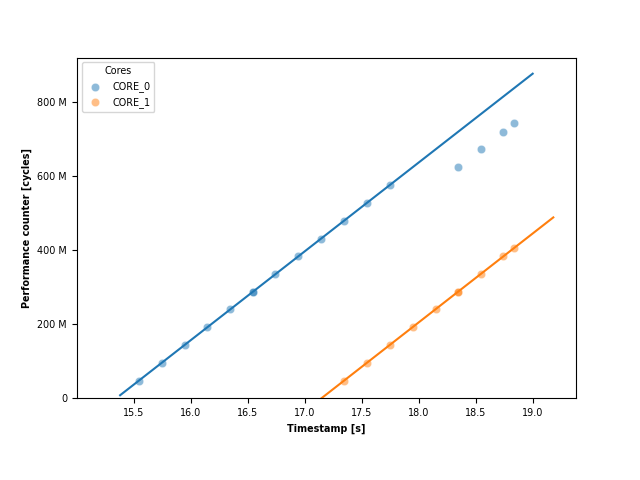

In [50]:
events = parse_trace(trace_log)

timestamps = compute_timestamps(events)
event_groups = compute_event_groups(events)
events = pd.concat([events, timestamps, event_groups], axis=1)

In [51]:
intervals = match_intervals(events, interval_match_keys)

events = events.sort_values('timestamp')
events

,local_id,perf_counter,context,state,event,core_id,timestamp,cum_perf_counter,event_group
global_id,,,,,,,,,
114,114,47903943,14227,BEGIN,SYNC,CORE_0,15.545894,47903943.0,SYNC
115,115,28,237,END,SYNC,CORE_0,15.545894,47903943.0,SYNC
116,116,45275,9700,BEGIN,CPX_SPI_TRANSFER,CORE_0,15.546082,47949190.0,CPX_SPI
117,117,356909,43688,END,CPX_SPI_TRANSFER,CORE_0,15.547382,48260824.0,CPX_SPI
118,118,690620,1508,BEGIN,CPX_SPI_TRANSFER,CORE_0,15.548773,48594535.0,CPX_SPI
...,...,...,...,...,...,...,...,...,...
3364,292,47013470,4092,END,CPX_TCP_SEND,CORE_1,NaN,NaN,CPX_TCP
3365,293,47205423,0,BEGIN,CPX_SPI_IDLE,CORE_1,NaN,NaN,CPX_SPI
3366,294,47207764,0,END,CPX_SPI_IDLE,CORE_1,NaN,NaN,CPX_SPI


In [52]:
intervals

start                                               \
                      event local_id perf_counter context  state core_id   
global_id                                                                  
114                    SYNC      114     47903943   14227  BEGIN  CORE_0   
300                    SYNC      300     48607734   20176  BEGIN  CORE_0   
478                    SYNC      478     47859768   22996  BEGIN  CORE_0   
660                    SYNC      660     47064236   22514  BEGIN  CORE_0   
838                    SYNC      838     48763962   29113  BEGIN  CORE_0   
...                     ...      ...          ...     ...    ...     ...   
3060       CPX_SPI_TRANSFER     3060     19192808    1508  BEGIN  CORE_0   
3062       CPX_SPI_TRANSFER     3062     19529628    5604  BEGIN  CORE_0   
3064       CPX_SPI_TRANSFER     3064     19862294    9700  BEGIN  CORE_0   
3066       CPX_SPI_TRANSFER     3066     20199548    1508  BEGIN  CORE_0   
3068       CPX_SPI_TRANSFER     3068     20532377    5604  BEGIN  CORE_0   

                                                                end           \
           timestamp cum_perf_counter event_group             event local_id   
global_id                                                                      
114        15.545894       47903943.0        SYNC              SYNC    115.0   
300        15.748566       96511677.0        SYNC              SYNC    301.0   
478        15.948120      144371445.0        SYNC              SYNC    479.0   
660        16.144356      191435681.0        SYNC              SYNC    661.0   
838        16.347680      240199643.0        SYNC              SYNC    839.0   
...              ...              ...         ...               ...      ...   
3060       18.428210      739181651.0     CPX_SPI  CPX_SPI_TRANSFER   3061.0   
3062       18.429614      739518471.0     CPX_SPI  CPX_SPI_TRANSFER   3063.0   
3064       18.431001      739851137.0     CPX_SPI  CPX_SPI_TRANSFER   3065.0   
3066       18.432407      740188391.0     CPX_SPI  CPX_SPI_TRANSFER   3067.0   
3068       18.433795      740521220.0     CPX_SPI  CPX_SPI_TRANSFER   3069.0   

                                                                           \
          perf_counter  context state core_id  timestamp cum_perf_counter   
global_id                                                                   
114               28.0    237.0   END  CORE_0  15.545894       47903943.0   
300               28.0    240.0   END  CORE_0  15.748566       96511677.0   
478               28.0    243.0   END  CORE_0  15.948120      144371445.0   
660               28.0    246.0   END  CORE_0  16.144356      191435681.0   
838               28.0    249.0   END  CORE_0  16.347680      240199643.0   
...                ...      ...   ...     ...        ...              ...   
3060        19502396.0  17112.0   END  CORE_0  18.429500      739491239.0   
3062        19838254.0  17112.0   END  CORE_0  18.430901      739827097.0   
3064        20171939.0  17112.0   END  CORE_0  18.432292      740160782.0   
3066        20508382.0  17112.0   END  CORE_0  18.433695      740497225.0   
3068        20628655.0  17112.0   END  CORE_0  18.434196      740617498.0   

                       duration                   
          event_group timestamp cum_perf_counter  
global_id                                         
114              SYNC  0.000000              0.0  
300              SYNC  0.000000              0.0  
478              SYNC  0.000000              0.0  
660              SYNC  0.000000              0.0  
838              SYNC  0.000000              0.0  
...               ...       ...              ...  
3060          CPX_SPI  0.001291         309588.0  
3062          CPX_SPI  0.001287         308626.0  
3064          CPX_SPI  0.001291         309645.0  
3066          CPX_SPI  0.001288         308834.0  
3068          CPX_SPI  0.000401          96278.0  

[3072 rows x 20 columns]

In [53]:
import matplotlib.collections as mcollections
import matplotlib.patches as mpatches

def rectplot(data, *, xmin, xmax, y, hue=None, palette=None, ax=None, hue_observed=False, **kwargs):    
    data = data.copy()
    
    if ax is None:
        _, ax = plt.subplots()

    xlim_min, xlim_max = data[xmin].min(), data[xmax].max()
    ax.axvline(xlim_min, c='k', lw=0.75, ls='--', zorder=-1)
    ax.axvline(xlim_max, c='k', lw=0.75, ls='--', zorder=-1)
    
    xlim_margin = 0.05 * (xlim_max - xlim_min)
    xlim_min, xlim_max = xlim_min - xlim_margin, xlim_max + xlim_margin
    ax.set_xlim(xlim_min, xlim_max)

    # data[xmin] = data[xmin].fillna(xlim_min - xlim_margin)
    # data[xmax] = data[xmax].fillna(xlim_max + xlim_margin)
    
    ax.invert_yaxis()
    
    if hue is None:
        groups = [data]
    else:
        if hue_observed:
            data[y] = data[y].cat.remove_unused_categories()
        
        groups = data \
            .groupby(hue, observed=True)
    
    palette = sns.color_palette(palette, n_colors=len(groups))
    
    for (_, group), color in zip(groups, palette):
        columns = [group[xmin], group[xmax], group[y].cat.codes]
        
        rects = []
        for _xmin, _xmax, _y in zip(*columns):
            width = _xmax - _xmin
            height = 0.5
            xy = (_xmin, _y - height / 2)

            rect = mpatches.Rectangle(xy, width, height)
            rects.append(rect)
        
        ax.add_collection(mcollections.PatchCollection(rects, color=color, **kwargs))
    
    ax.autoscale_view()
            
    categories = data[y].dtype.categories
    codes = np.arange(len(categories))
    ax.set_yticks(codes, categories)
    
    sns.despine(ax=ax)

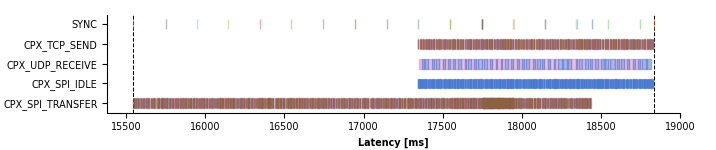

In [54]:
viz_df = intervals.copy()

rectplot(
    viz_df,
    xmin=('start', 'timestamp'), xmax=('end', 'timestamp'), y=('start', 'event'),
    hue=('start', 'context'),
    alpha=0.5,
    palette=sns.color_palette('muted'),
    hue_observed=True
)

class EngFormatterEx(mticker.EngFormatter):
    ENG_PREFIXES = {-3: ''}

plt.xlabel('Latency [ms]')
plt.gca().xaxis.set_major_formatter(EngFormatterEx())
plt.ylabel('Events')

plt.gcf().set_size_inches([7.16,  1.5])
plt.subplots_adjust(left=0.15, top=0.9, bottom=0.25, right=0.95)
plt.savefig('pipeline.svg', dpi=450)

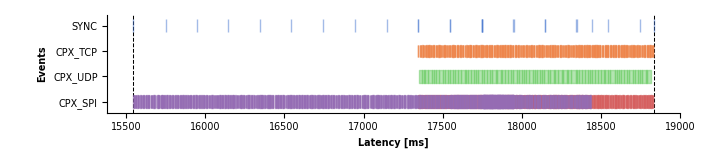

In [55]:
viz_df = intervals.copy()

rectplot(
    viz_df,
    xmin=('start', 'timestamp'), xmax=('end', 'timestamp'), y=('start', 'event_group'),
    hue=('start', 'event'),
    alpha=0.5,
    palette=sns.color_palette('muted'),
    hue_observed=True,
)

class EngFormatterEx(mticker.EngFormatter):
    ENG_PREFIXES = {-3: ''}

plt.xlabel('Latency [ms]')
plt.gca().xaxis.set_major_formatter(EngFormatterEx())
plt.ylabel('Events')

plt.gcf().set_size_inches([7.16,  1.5])
plt.subplots_adjust(left=0.15, top=0.9, bottom=0.25, right=0.95)
plt.savefig('pipeline.svg', dpi=450)